<a href="https://colab.research.google.com/github/sofiammatias/tick-tick-bloom/blob/main/ticktickbloomCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tick Tick Bloom Challenge (Driven Data)
The goal in this challenge is to use satellite imagery to detect and classify the severity of cyanobacteria blooms in small, inland water bodies. The resulting algorithm will help water quality managers better allocate resources for in situ sampling, and make more informed decisions around public health warnings for critical resources like drinking water reservoirs. Ultimately, more accurate and more timely detection of algal blooms helps keep both the human and marine life that rely on these water bodies safe and healthy.

## Imports

In [ ]:
!pip install geopandas

In [ ]:
!pip install planetary_computer
!pip install pystac_client

In [ ]:
!pip install rioxarray
!pip install odc-stac

In [ ]:
!pip install loguru

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
import cv2
import os
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import odc.stac
from pathlib import Path
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import geopandas as gpd
from shapely.geometry import Point
import geopy.distance as distance
import rioxarray
from IPython.display import Image
from PIL import Image as PILImage
import planetary_computer as pc
from pystac_client import Client

import tensorflow as tf
from keras.optimizers import RMSprop,SGD,Adam
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

%matplotlib inline

# Data: Collection and EDA

## Load critical files

In [103]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
files_path = '/content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/'
DATA_PATH = Path.cwd().parent.resolve() / files_path
MODEL_DIR = DATA_PATH / "model_CNN"

metadata_file = f'{files_path}metadata.csv'
train_labels_file = f'{files_path}/train_labels.csv'
submission_file = f"{files_path}/submission_format.csv"

In [9]:
metadata = pd.read_csv(metadata_file)
train_labels = pd.read_csv(train_labels_file)
train_labels_and_metadata = train_labels.merge(
    metadata, how="left", left_on="uid", right_on="uid", validate="1:1"
)

## Metadata.csv

In [10]:
metadata = pd.read_csv(metadata_file)

### Location

In [11]:
display(metadata.head())
metadata.split.value_counts(dropna=False)

uid   latitude   longitude        date  split
0  aabm  39.080319  -86.430867  2018-05-14  train
1  aabn  36.559700 -121.510000  2016-08-31   test
2  aacd  35.875083  -78.878434  2020-11-19  train
3  aaee  35.487000  -79.062133  2016-08-24  train
4  aaff  38.049471  -99.827001  2019-07-23  train

train    17060
test      6510
Name: split, dtype: int64

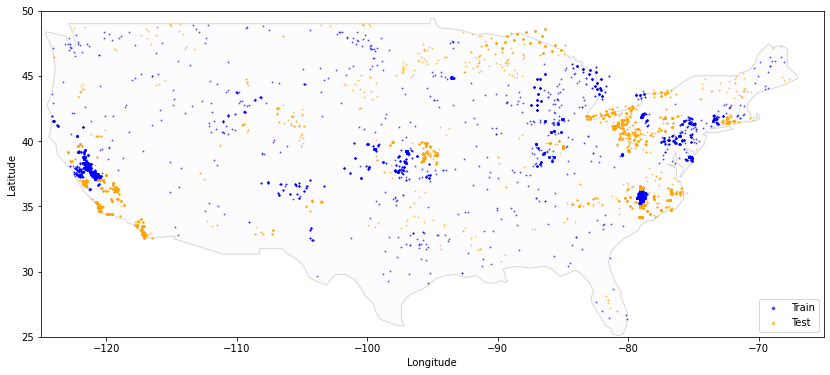

In [12]:
# load the default geopandas base map file to plot points on
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

fig, ax = plt.subplots(figsize=(15, 6))

# map the training data
base = world[world.name == "United States of America"].plot(
    edgecolor="gray", color="ghostwhite", figsize=(9, 4), alpha=0.3, ax=ax
)
train_meta = metadata[metadata["split"] == "train"]
geometry = [Point(xy) for xy in zip(train_meta["longitude"], train_meta["latitude"])]
gdf = gpd.GeoDataFrame(train_meta, geometry=geometry)
gdf.plot(ax=base, marker=".", markersize=3, color="blue", label="Train", alpha=0.6)

# map the test data
test_meta = metadata[metadata["split"] == "test"]
geometry = [Point(xy) for xy in zip(test_meta["longitude"], test_meta["latitude"])]
gdf = gpd.GeoDataFrame(test_meta, geometry=geometry)
gdf.plot(ax=base, marker=".", markersize=3, color="orange", label="Test", alpha=0.6)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.xlim([-125, -65])
plt.ylim([25, 50])
plt.legend(loc=4, markerscale=3)

### Date

min_date   max_date
split                      
test  2013-01-08 2021-12-29
train 2013-01-04 2021-12-14

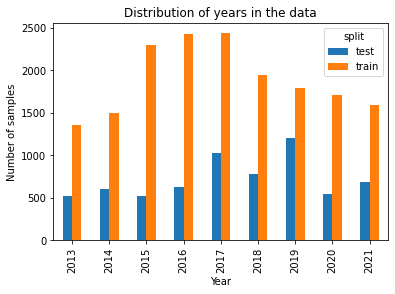

In [13]:
# convert date to pd.datetime
metadata.date = pd.to_datetime(metadata.date)

# what is the date range?
display (metadata.groupby("split").agg(min_date=("date", min), max_date=("date", max)))

# what years are in the data?
pd.crosstab(metadata.date.dt.year, metadata.split).plot(kind="bar")
plt.ylabel("Number of samples")
plt.xlabel("Year")
plt.title("Distribution of years in the data")
plt.show()

Seasons


summer    10813
spring     5045
fall       4758
winter     2954
Name: season, dtype: int64

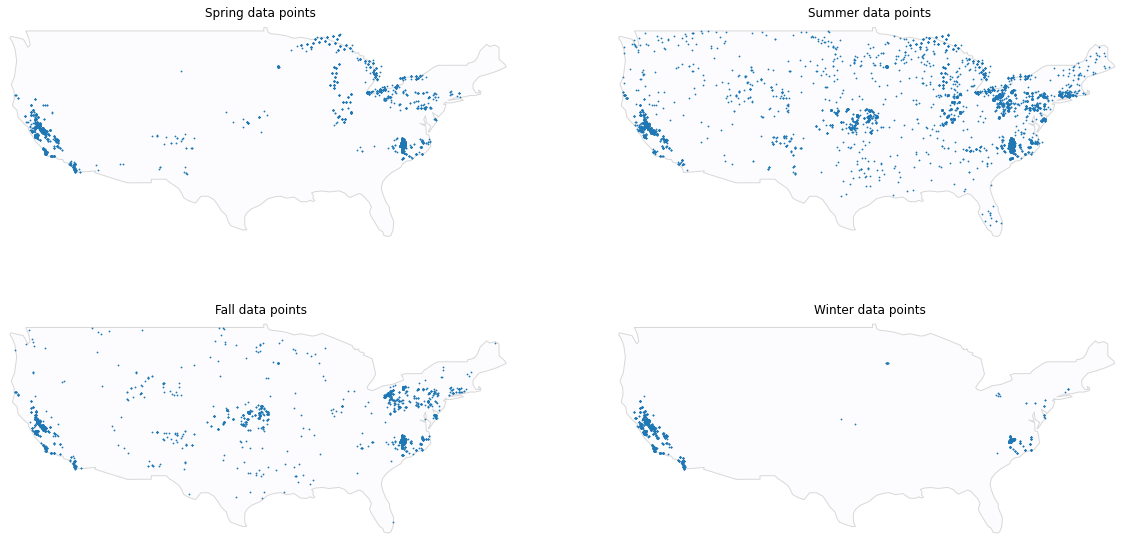

In [14]:
# what seasons are the data points from?
metadata["season"] = (
    metadata.date.dt.month.replace([12, 1, 2], "winter")
    .replace([3, 4, 5], "spring")
    .replace([6, 7, 8], "summer")
    .replace([9, 10, 11], "fall")
)
print ('Seasons')
display(metadata.season.value_counts())

# where is data from for each season?
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

for season, ax in zip(metadata.season.unique(), axes.flatten()):
    base = world[world.name == "United States of America"].plot(
        edgecolor="gray", color="ghostwhite", alpha=0.3, ax=ax
    )

    sub = metadata[metadata.season == season]
    geometry = [Point(xy) for xy in zip(sub["longitude"], sub["latitude"])]
    gdf = gpd.GeoDataFrame(sub, geometry=geometry)
    gdf.plot(ax=base, marker=".", markersize=2.5)
    ax.set_xlim([-125, -66])
    ax.set_ylim([25, 50])
    ax.set_title(f"{season.capitalize()} data points")
    ax.axis("off")

## Train Labels.csv

In [15]:
train_labels = pd.read_csv(train_labels_file)

In [16]:
display(train_labels.head())
train_labels.shape

uid   region  severity    density
0  aabm  midwest         1      585.0
1  aacd    south         1      290.0
2  aaee    south         1     1614.0
3  aaff  midwest         3   111825.0
4  aafl  midwest         4  2017313.0

(17060, 4)

In [17]:
train_labels_and_metadata = train_labels.merge(
    metadata, how="left", left_on="uid", right_on="uid", validate="1:1"
)
train_labels_and_metadata

uid   region  severity    density   latitude  longitude       date  \
0      aabm  midwest         1      585.0  39.080319 -86.430867 2018-05-14   
1      aacd    south         1      290.0  35.875083 -78.878434 2020-11-19   
2      aaee    south         1     1614.0  35.487000 -79.062133 2016-08-24   
3      aaff  midwest         3   111825.0  38.049471 -99.827001 2019-07-23   
4      aafl  midwest         4  2017313.0  39.474744 -86.898353 2021-08-23   
...     ...      ...       ...        ...        ...        ...        ...   
17055  zzsv    south         3   113125.0  38.707825 -75.080867 2018-06-27   
17056  zzuq    south         3   175726.0  35.794000 -79.015368 2015-08-06   
17057  zzwo  midwest         2    48510.0  39.792190 -99.971050 2017-06-19   
17058  zzwq    south         1     1271.0  35.794000 -79.012551 2015-03-24   
17059  zzyb    south         1     9682.0  35.742000 -79.238600 2016-11-21   

       split  season  
0      train  spring  
1      train    fall  
2      train  summer  
3      train  summer  
4      train  summer  
...      ...     ...  
17055  train  summer  
17056  train  summer  
17057  train  summer  
17058  train  spring  
17059  train    fall  

[17060 rows x 9 columns]

[0.00339977 0.20791325 0.15937866 0.18985932 0.439449  ]


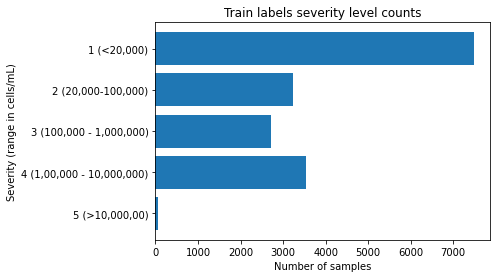

In [18]:
severity_counts = (
    train_labels.replace(
        {
            "severity": {
                1: "1 (<20,000)",
                2: "2 (20,000-100,000)",
                3: "3 (100,000 - 1,000,000)",
                4: "4 (1,00,000 - 10,000,000)",
                5: "5 (>10,000,00)",
            }
        }
    )
    .severity.value_counts()
    .sort_index(ascending=False)
)
plt.barh(severity_counts.index, severity_counts.values)
plt.xlabel("Number of samples")
plt.ylabel("Severity (range in cells/mL)")
plt.title("Train labels severity level counts")
weights = severity_counts.values /severity_counts.values.sum()
print (weights)

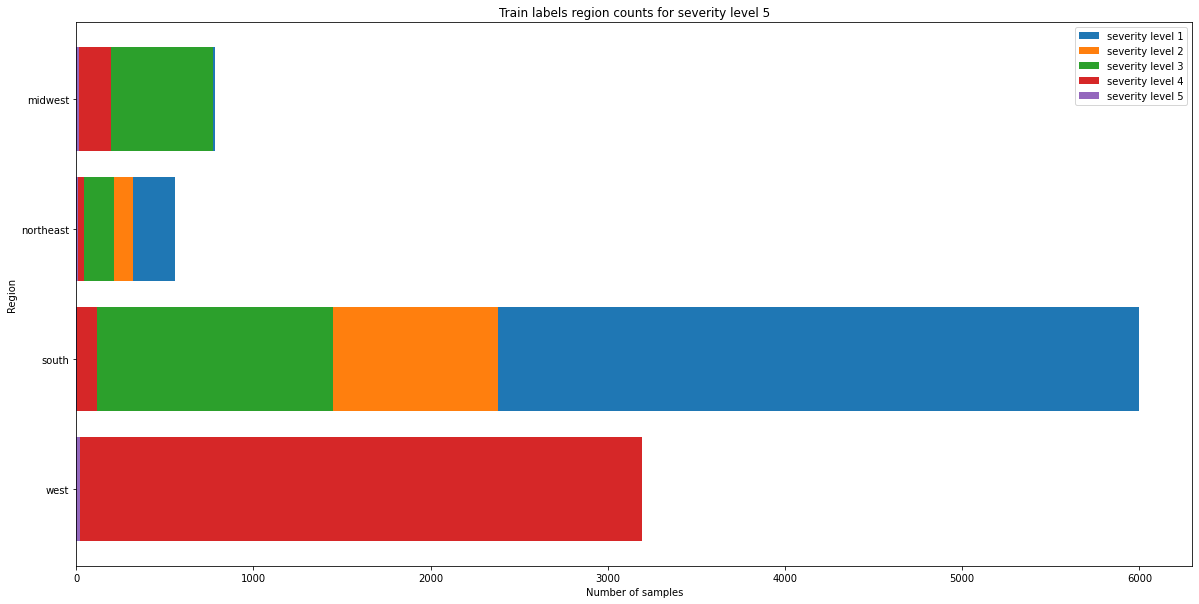

In [19]:
plt.figure (figsize=(20,10))

for severity_level in range(1, 6):
  region_counts = train_labels[train_labels.severity == severity_level].region.value_counts().sort_index(ascending=False)
  ax = plt.barh(region_counts.index, region_counts.values, label = f'severity level {severity_level}')

plt.xlabel("Number of samples")
plt.ylabel("Region")
plt.title(f'Train labels region counts for severity level {severity_level}')
plt.legend ()

In [20]:
train_labels.density.describe()

count    1.706000e+04
mean     1.074537e+06
std      6.836693e+06
min      0.000000e+00
25%      4.066000e+03
50%      3.270975e+04
75%      4.849192e+05
max      8.046675e+08
Name: density, dtype: float64

# Process Feature Data

Feature data is not provided directly. Instead, access to all feature data can only be done through **external, publicly available APIs**. Relevant imagery can be identified using the location and date of each sample, listed in metadata.csv.

Pull in matching satellite imagery will be done using Microsoft's Planetary Computer. Use only **Sentinel-2 L2A** and **Landsat Level-2** satellite imagery. Sentinel-2 L1C and Landsat Level-1 imagery are also allowed.

In [21]:
# Establish a connection to the STAC API
import planetary_computer as pc
from pystac_client import Client

catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1", modifier=pc.sign_inplace
)

## Location range: 
search an area with 50,000 meters on either side of our sample point (100,000 m x 100,000 m), to make sure we're pulling in all relevant imagery. This is just a starting point, and you can improve on how to best search for the correct location in the Planetary Computer.

## Time range: 
We want our feature data to be as close to the time of the sample as possible, because in algal blooms in small water bodies form and move very rapidly. Remember, you cannot use any data collected after the date of the sample.

Imagery taken with roughly 10 days of the sample will generally still be an accurate representation of environmental conditions at the time of the sample. For some data points you may not be able to get data within 10 days, and may have to use earlier data. We'll search the fifteen days up to the sample time, including the sample date.

# Select and Process one Image
We will get one example image to understand the process and change it if required. 

In [22]:
example_row = metadata[metadata.uid == "yeon"].iloc[0]
example_row

uid                         yeon
latitude                   36.08
longitude                 -78.37
date         2017-09-18 00:00:00
split                       test
season                      fall
Name: 21932, dtype: object

In [23]:
example_row_2 = train_labels[train_labels.uid == "garm"].iloc[0]
example_row_2

uid                garm
region             west
severity              5
density     12267752.74
Name: 3950, dtype: object

## Selection steps

In [24]:
# get our bounding box to search latitude and longitude coordinates
def get_bounding_box(latitude, longitude, meter_buffer=50000):
    """
    Given a latitude, longitude, and buffer in meters, returns a bounding
    box around the point with the buffer on the left, right, top, and bottom.

    Returns a list of [minx, miny, maxx, maxy]
    """
    distance_search = distance.distance(meters=meter_buffer)

    # calculate the lat/long bounds based on ground distance
    # bearings are cardinal directions to move (south, west, north, and east)
    min_lat = distance_search.destination((latitude, longitude), bearing=180)[0]
    min_long = distance_search.destination((latitude, longitude), bearing=270)[1]
    max_lat = distance_search.destination((latitude, longitude), bearing=0)[0]
    max_long = distance_search.destination((latitude, longitude), bearing=90)[1]

    return [min_long, min_lat, max_long, max_lat]

In [25]:
# get our date range to search, and format correctly for query
def get_date_range(date, time_buffer_days=45):
    """Get a date range to search for in the planetary computer based
    on a sample's date. The time range will include the sample date
    and time_buffer_days days prior

    Returns a string"""
    datetime_format = "%Y-%m-%dT"
    range_start = pd.to_datetime(date) - timedelta(days=time_buffer_days)
    date_range = f"{range_start.strftime(datetime_format)}/{pd.to_datetime(date).strftime(datetime_format)}"

    return date_range


In [26]:
#Get bounding box of interest area
bbox = get_bounding_box(example_row.latitude, example_row.longitude, meter_buffer=50000)
print ('\nBounding box:\n\n',bbox)

# get our date range to search, and format correctly for query
date_range = get_date_range(example_row.date).replace('T', '')
print ('\nDate range:\n\n',date_range)

# search the planetary computer sentinel-l2a and landsat level-2 collections
search = catalog.search(
    collections=["sentinel-2-l2a", "landsat-c2-l2"], bbox=bbox, datetime=date_range
)

# see how many items were returned
items = [item for item in search.get_all_items()]
print ('\nItems found:\n\n',len(items))

#Select best item



Bounding box:

 [-78.92510214344873, 35.629372185038925, -77.81489785655128, 36.530593861715936]

Date range:

 2017-08-04/2017-09-18

Items found:

 62


In [27]:
# get details of all of the items returned
item_details = pd.DataFrame(
    [
        {
            "datetime": item.datetime.strftime("%Y-%m-%d"),
            "platform": item.properties["platform"],
            "min_long": item.bbox[0],
            "max_long": item.bbox[2],
            "min_lat": item.bbox[1],
            "max_lat": item.bbox[3],
            "bbox": item.bbox,
            "item_obj": item,
        }
        for item in items
    ]
)

# check which rows actually contain the sample location
item_details["contains_sample_point"] = (
    (item_details.min_lat < example_row.latitude)
    & (item_details.max_lat > example_row.latitude)
    & (item_details.min_long < example_row.longitude)
    & (item_details.max_long > example_row.longitude)
)

print(
    f"Filtering from {len(item_details)} returned to {item_details.contains_sample_point.sum()} items that contain the sample location"
)

item_details = item_details[item_details["contains_sample_point"]]
item_details[["datetime", "platform", "contains_sample_point", "bbox"]].sort_values(
    by="datetime"
)

Filtering from 62 returned to 34 items that contain the sample location


datetime     platform  contains_sample_point  \
61  2017-08-04  Sentinel-2A                   True   
60  2017-08-04  Sentinel-2A                   True   
58  2017-08-04  Sentinel-2A                   True   
56  2017-08-05    landsat-7                   True   
55  2017-08-06    landsat-8                   True   
51  2017-08-12  Sentinel-2B                   True   
50  2017-08-12  Sentinel-2B                   True   
48  2017-08-12  Sentinel-2B                   True   
46  2017-08-13    landsat-8                   True   
45  2017-08-14    landsat-7                   True   
40  2017-08-17  Sentinel-2A                   True   
38  2017-08-19  Sentinel-2B                   True   
37  2017-08-19  Sentinel-2B                   True   
35  2017-08-19  Sentinel-2B                   True   
33  2017-08-21    landsat-7                   True   
32  2017-08-22    landsat-8                   True   
29  2017-08-24  Sentinel-2A                   True   
28  2017-08-24  Sentinel-2A                   True   
26  2017-08-24  Sentinel-2A                   True   
24  2017-08-29    landsat-8                   True   
23  2017-08-30    landsat-7                   True   
21  2017-09-06    landsat-7                   True   
18  2017-09-06  Sentinel-2A                   True   
17  2017-09-06  Sentinel-2A                   True   
15  2017-09-06  Sentinel-2A                   True   
14  2017-09-07    landsat-8                   True   
11  2017-09-08  Sentinel-2B                   True   
10  2017-09-08  Sentinel-2B                   True   
8   2017-09-08  Sentinel-2B                   True   
6   2017-09-13  Sentinel-2A                   True   
5   2017-09-13  Sentinel-2A                   True   
3   2017-09-13  Sentinel-2A                   True   
1   2017-09-14    landsat-8                   True   
0   2017-09-15    landsat-7                   True   

                                                 bbox  
61  [-78.72364076586805, 36.007451011934776, -77.5...  
60  [-78.80191386287372, 35.10721816203458, -77.55...  
58  [-78.37131820920371, 36.01049725766069, -77.11...  
56  [-80.64024447, 35.07019482, -77.91179152, 37.0...  
55  [-79.07858417, 34.92646493, -76.39235131, 37.1...  
51  [-78.78052649213598, 36.015188412779594, -77.5...  
50  [-78.80526871562567, 35.12051614226662, -77.86...  
48  [-78.37131820920371, 36.01049725766069, -77.56...  
46  [-80.53879426, 34.96604482, -77.95883133, 37.0...  
45  [-79.17162437, 35.02585494, -76.3447515, 37.05...  
40  [-78.37131820920371, 36.01049725766069, -77.56...  
38  [-78.72808282010432, 36.007451011934776, -77.5...  
37  [-78.80526871562567, 35.10721816203458, -77.55...  
35  [-78.37131820920371, 36.01049725766069, -77.11...  
33  [-80.63367447, 35.06724482, -77.90148151, 37.0...  
32  [-79.07858417, 34.92646493, -76.39564131, 37.1...  
29  [-78.72896566798235, 36.007451011934776, -77.5...  
28  [-78.80526871562567, 35.10721816203458, -77.55...  
26  [-78.37131820920371, 36.01049725766069, -77.11...  
24  [-80.53879426, 34.96596482, -77.95546133, 37.0...  
23  [-79.17528437, 35.02304494, -76.34470149, 37.0...  
21  [-80.64026447, 35.06749482, -77.91190153, 37.0...  
18  [-78.78052649213598, 36.015226218240315, -77.5...  
17  [-78.80526871562567, 35.12056456532173, -77.86...  
15  [-78.37131820920371, 36.01049725766069, -77.56...  
14  [-79.07185417, 34.92667493, -76.38907131, 37.1...  
11  [-78.72309076849749, 36.007451011934776, -77.5...  
10  [-78.80526871562567, 35.10721816203458, -77.55...  
8   [-78.37131820920371, 36.01049725766069, -77.11...  
6   [-78.72928100061031, 36.007451011934776, -77.5...  
5   [-78.80526871562567, 35.10721816203458, -77.55...  
3   [-78.37131820920371, 36.01049725766069, -77.11...  
1   [-80.52564426, 34.96572482, -77.94536133, 37.0...  
0   [-79.17513437, 35.02574494, -76.34804149, 37.0...

In [28]:
def select_best_item(items, date, latitude, longitude):
    """
    Select the best satellite item given a sample's date, latitude, and longitude.
    If any Sentinel-2 imagery is available, returns the closest sentinel-2 image by
    time. Otherwise, returns the closest Landsat imagery.

    Returns a tuple of (STAC item, item platform name, item date)
    """
    # get item details
    item_details = pd.DataFrame(
        [
            {
                "datetime": item.datetime.strftime("%Y-%m-%d"),
                "platform": item.properties["platform"],
                "min_long": item.bbox[0],
                "max_long": item.bbox[2],
                "min_lat": item.bbox[1],
                "max_lat": item.bbox[3],
                "item_obj": item,
            }
            for item in items
        ]
    )

    # filter to items that contain the point location, or return None if none contain the point
    item_details["contains_sample_point"] = (
        (item_details.min_lat < latitude)
        & (item_details.max_lat > latitude)
        & (item_details.min_long < longitude)
        & (item_details.max_long > longitude)
    )
    item_details = item_details[item_details["contains_sample_point"] == True]
    if len(item_details) == 0:
        return (np.nan, np.nan, np.nan)

    # add time difference between each item and the sample
    item_details["time_diff"] = pd.to_datetime(date) - pd.to_datetime(
        item_details["datetime"]
    )

    # if we have sentinel-2, filter to sentinel-2 images only
    item_details["sentinel"] = item_details.platform.str.lower().str.contains(
        "sentinel"
    )
    if item_details["sentinel"].any():
        item_details = item_details[item_details["sentinel"] == True]

    # return the closest imagery by time
    best_item = item_details.sort_values(by="time_diff", ascending=True).iloc[0]

    return (best_item["item_obj"], best_item["platform"], best_item["datetime"])

In [29]:
#Select best item
# 1 - filter to sentinel
# 2 - take closest by date
best_item, item_platform, item_date = select_best_item(
                    items, example_row.date, example_row.latitude, example_row.longitude
                )

item = best_item

# What assets are available?
for asset_key, asset in item.assets.items():
    print(f"{asset_key:<25} - {asset.title}")

AOT                       - Aerosol optical thickness (AOT)
B01                       - Band 1 - Coastal aerosol - 60m
B02                       - Band 2 - Blue - 10m
B03                       - Band 3 - Green - 10m
B04                       - Band 4 - Red - 10m
B05                       - Band 5 - Vegetation red edge 1 - 20m
B06                       - Band 6 - Vegetation red edge 2 - 20m
B07                       - Band 7 - Vegetation red edge 3 - 20m
B08                       - Band 8 - NIR - 10m
B09                       - Band 9 - Water vapor - 60m
B11                       - Band 11 - SWIR (1.6) - 20m
B12                       - Band 12 - SWIR (2.2) - 20m
B8A                       - Band 8A - Vegetation red edge 4 - 20m
SCL                       - Scene classfication map (SCL)
WVP                       - Water vapour (WVP)
visual                    - True color image
preview                   - Thumbnail
safe-manifest             - SAFE manifest
granule-metadata          - Granul

In [30]:
item

<Item id=S2A_MSIL2A_20170913T154901_R054_T18STF_20201020T002819>

## Visualizing Sentinel-2 imagery

To keep things simple, we'll just choose one image to input into our model. Keep in mind that it is possible to incorporate multiple images!

We'll narrow to one image in two steps:

- If any Sentinel imagery is available, filter to only Sentinel imagery. Sentinel-2 is higher resolution than Landsat, which is extremely helpful for blooms in small water bodies. In this case, two images are from Sentinel and contain the actual sample location.
- Select the item that is the closest time wise to the sampling date. This gives us a Sentinel-2A item that was captured on 10/20/2022 - two days before our sample was collected on 10/22.

This is a very simple way to choose the best image. 

Be aware that querying the Planetary Computer for all of the images is going to take a LONG time! You'll want to find ways to both save work as you go, and optimize your code for efficiency.

In [31]:
def crop_sentinel_image(item, bounding_box):
    """
    Given a STAC item from Sentinel-2 and a bounding box tuple in the format
    (minx, miny, maxx, maxy), return a cropped portion of the item's visual
    imagery in the bounding box.

    Returns the image as a numpy array with dimensions (color band, height, width)
    """
    (minx, miny, maxx, maxy) = bounding_box
    
    image = rioxarray.open_rasterio(pc.sign(item.assets["visual"].href)).rio.clip_box(
        minx=minx,
        miny=miny,
        maxx=maxx,
        maxy=maxy,
        crs="EPSG:4326",
    )

    return image.to_numpy()

In [32]:
# see the whole image
img = Image(url=item.assets["rendered_preview"].href, width=500)

Image(url=item.assets["rendered_preview"].href, width=500)

In [33]:
# get a smaller geographic bounding box
minx, miny, maxx, maxy = get_bounding_box(
    example_row.latitude, example_row.longitude, meter_buffer=3600
)

# get the zoomed in image array
bbox = (minx, miny, maxx, maxy)
zoomed_img_array = crop_sentinel_image(item, bbox)

print ('Array shape:', zoomed_img_array[0].shape)
zoomed_img_array[0]

Array shape: (746, 27)


array([[27, 27, 22, ..., 25, 24, 24],
       [27, 24, 21, ..., 25, 24, 24],
       [24, 22, 23, ..., 24, 23, 24],
       ...,
       [22, 22, 23, ..., 17, 17, 21],
       [21, 20, 21, ..., 22, 21, 22],
       [20, 20, 20, ..., 18, 21, 22]], dtype=uint8)

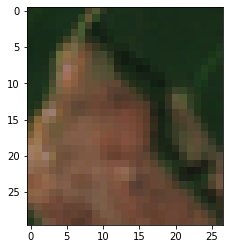

In [34]:
# we have to transpose some of the dimensions to plot
# matplotlib expects channels in a certain order
plt.imshow(np.transpose(zoomed_img_array[:, :30, :30], axes=[1, 2, 0]))

## CNN for Sentinel images

In [35]:
def severity_ohe(severity_val):
  """
  One Hot Encode our Target for TensorFlow processing
  """
  severity_cat = to_categorical(severity_val - 1, num_classes=5)
  return severity_cat

In [36]:
severity = severity_ohe(5)
severity.shape

(5,)

In [37]:
def image_norm(img_array):
  """
  Changes the image array from sentinel imagery into a numpy array fitted to be 
  used in CNN
  """
  i1,i2,i3 = img_array.shape
  shape = (i2, i3, i1)
  image_array_final=img_array.reshape (i2,i3,i1)
  return image_array_final, shape

In [38]:
image_array_sent, img_sent_shape = image_norm(zoomed_img_array)
#model_sent = initiate_model_sent(img_sent_shape)
#model_sent, history_s = train_model_sent(model_sent, image_array_sent, np.array([severity]))
#prediction = model_sent.predict(image_array_sent)
#history_s.history


## Visualizing Landsat imagery

STAC items from Sentinel and from Landsat are slightly different, so we'll have to use slightly different methods to pull imagery based on its satellite 

In [39]:
def crop_landsat_image(item, bounding_box):
    """
    Given a STAC item from Landsat and a bounding box tuple in the format
    (minx, miny, maxx, maxy), return a cropped portion of the item's visual
    imagery in the bounding box.

    Returns the image as a numpy array with dimensions (color band, height, width)
    """
    (minx, miny, maxx, maxy) = bounding_box

    image = odc.stac.stac_load(
        [pc.sign(item)], bands=["red", "green", "blue"], bbox=[minx, miny, maxx, maxy]
    ).isel(time=0)
    image_array = image[["red", "green", "blue"]].to_array().to_numpy()

    # normalize to 0 - 255 values
    image_array = cv2.normalize(image_array, None, 0, 255, cv2.NORM_MINMAX)

    return image_array

In [40]:
landsat_item = (
    item_details[item_details.platform.str.contains("landsat")]
    .sample(n=1, random_state=3)
    .iloc[0]
)
print ('\nLandsat image data:\n\n', landsat_item)

minx, miny, maxx, maxy = get_bounding_box(
    example_row.latitude, example_row.longitude, meter_buffer=150
)
bbox = (minx, miny, maxx, maxy)

item = landsat_item.item_obj

# we'll use the same cropped area as above
landsat_image_array = crop_landsat_image(item, bbox)
print ('\nRescaled numpy array image:\n\n', landsat_image_array[0].shape, landsat_image_array[0]) #numpy array

# load image but don't convert to numpy or rescale
image = odc.stac.stac_load(
    [pc.sign(item)], bands=["red", "green", "blue"], bbox=bbox
).isel(time=0)
image_array = image[["red", "green", "blue"]].to_array()

# values are not scaled 0 - 255 when first returned
print ('\nNot scaled image:\n\n', image_array[0])


Landsat image data:

 datetime                                                        2017-08-29
platform                                                         landsat-8
min_long                                                        -80.538794
max_long                                                        -77.955461
min_lat                                                          34.965965
max_lat                                                          37.097695
bbox                     [-80.53879426, 34.96596482, -77.95546133, 37.0...
item_obj                         <Item id=LC08_L2SP_016035_20170829_02_T2>
contains_sample_point                                                 True
Name: 24, dtype: object

Rescaled numpy array image:

 (11, 11) [[126 122 109 123 101 114 143 135 121 115 108]
 [117 120 110  95  91 114 132 116  96  82  86]
 [ 90  88  76  72  85 107 111  65  56  54  68]
 [ 75  73  66  85  98 105 100  59  48  53  63]
 [ 83  60  64  79  86  81  72  43  50  69  65]
 [ 

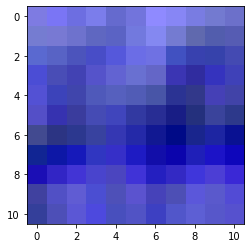

In [41]:
#Show rescaled image
plt.imshow(np.transpose(landsat_image_array, axes=[1, 2, 0]))

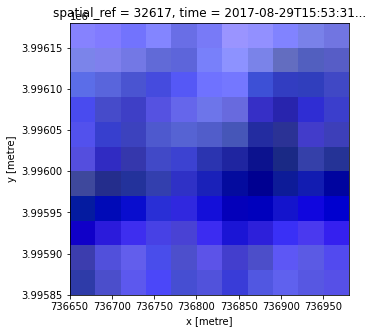

In [42]:
# image appears differently without rescaling
fig, ax = plt.subplots(figsize=(5, 5))
image_array.plot.imshow(robust=True, ax=ax)

## CNN model for landsat images

In [43]:
image_array_land = 0
landsat_image_array.shape

(3, 11, 11)

In [44]:
#image_array_land, img_land_shape = image_norm(landsat_image_array)
#model_land = initiate_model_land(img_land_shape)
#model_land, history_l = train_model_land(model_land, image_array_land, np.array([severity]))
#prediction = model_land.predict(image_array_land)
#history_l.history

# Getting All Images ("production")

We'll save out the processed features for each image as we go, to make sure we only have to run time-intensive parts of our code once.

For time, here we'll train on a randomly selected small subset of the training data. The cell below is highly time intensive, because for each row in the data we have to query the planetary computer catalog and process imagery.

We'll still include and predict on all of the test data.

In [45]:
# save image arrays in case we want to generate more features
IMAGE_ARRAY_SENT_DIR = DATA_PATH / "image_arrays_sentinel"
IMAGE_ARRAY_LAND_DIR = DATA_PATH / "image_arrays_landsat"
IMAGE_ARRAY_SENT_DIR.mkdir(exist_ok=True, parents=True)
IMAGE_ARRAY_LAND_DIR.mkdir(exist_ok=True, parents=True)

# Getting global params set
meter_buffer_init = 50000
meter_buffer_img = 400
enlarged_meter_buffer = 6000
cut_sentinel_image = 30
cut_landsat_image = 10
time_buffer = 45

# Splitting train dataset into 'train' and 'validation' for model evaluation
train_subset = train_labels_and_metadata[train_labels_and_metadata["split"] == "train"].copy()
rng = np.random.RandomState(30)
train_subset['split'] = rng.choice(
    ["train", "validation"], 
    size=len(metadata[metadata["split"] == "train"]), 
    replace=True, 
    p=[0.67, 0.33]
)

# take a random subset of the training/validation data. To better train the model,
# we don't define random_state to have different datasets.
train_subset = train_subset.sample(n=1500)

# combine train subset with all test data
metadata_subset = pd.concat([train_subset, metadata[metadata["split"] == "test"]])
print (metadata_subset.split.value_counts(dropna=False))
display (train_subset[:10])

test          6510
train          998
validation     502
Name: split, dtype: int64


uid     region  severity    density   latitude   longitude       date  \
12036  sgyt      south         2    22656.0  35.980000  -78.836924 2021-06-28   
16743  zmqt       west         4  8265000.0  37.828400 -121.984000 2015-02-06   
11804  rxfm      south         1      581.0  35.908283  -79.144147 2021-03-17   
4250   gmau      south         2    89158.0  35.633903  -79.297488 2015-08-06   
10284  ppbp  northeast         3   867333.5  40.073179  -76.894562 2018-07-16   
775    bezh      south         2    85420.0  35.876729  -78.891608 2021-10-12   
15434  xnoj       west         4  1940639.0  36.748900 -120.513000 2019-01-18   
6639   kbsl    midwest         2    51345.0  39.804820  -99.939150 2016-06-20   
11835  ryjt       west         3   979971.5  36.651900 -120.632000 2017-04-10   
9155   nxmj      south         1      436.0  35.687319  -79.198274 2021-06-17   

            split  season  
12036  validation  summer  
16743       train  winter  
11804       train  spring  
4250        train  summer  
10284       train  summer  
775    validation    fall  
15434  validation  winter  
6639   validation  summer  
11835       train  spring  
9155        train  summer

In [46]:
# this cell takes a LONG time because it iterates over all data!

# save outputs in dictionaries
selected_items = {}
features_sent_dict = {}
features_land_dict = {}
errored_ids = []

i=0
for row in tqdm(metadata_subset.itertuples(), total=len(metadata_subset)):
    # check if we've already saved the selected image array
    image_array_sent_pth = IMAGE_ARRAY_SENT_DIR / f"{row.uid}.npy"
    image_array_land_pth = IMAGE_ARRAY_LAND_DIR / f"{row.uid}.npy"
    print ('\nGetting image array nº', i,' from ',len(metadata_subset))

    if image_array_sent_pth.exists():
        with open(image_array_sent_pth, "rb") as f:
            image_array = np.load(f)
        print ('\nImage array nº',i,' from', image_array_sent_pth,'\n\n')
        image_feature = image_norm(image_array[:, :cut_sentinel_image, :cut_sentinel_image])
        print ('image sentinel shape:', image_feature[1])
        image_feature = image_norm(image_array[:, :cut_sentinel_image, :cut_sentinel_image])
        features_sent_dict[row.uid] = image_feature

    elif image_array_land_pth.exists():
        with open(image_array_land_pth, "rb") as f:
            image_array = np.load(f)
        print ('\nImage array nº',i,' from', image_array_land_pth,'\n\n')
        image_feature = image_norm(image_array[:, :cut_landsat_image, :cut_landsat_image])
        print ('image landsat shape:', image_feature[1])
        features_land_dict[row.uid] = image_feature
    
    # search and load the image array if not
    else:
        try:
            ## QUERY STAC API
            # get query ranges for location and date
            search_bbox = get_bounding_box(
                row.latitude, row.longitude, meter_buffer=meter_buffer_init
            )
            date_range = get_date_range(row.date, time_buffer_days=15).replace('T', '')

            # search the planetary computer
            search = catalog.search(
                collections=["sentinel-2-l2a", "landsat-c2-l2"],
                bbox=search_bbox,
                datetime=date_range,
            )
            items = [item for item in search.get_all_items()]

            ## GET BEST IMAGE
            if len(items) == 0:
                pass
            else:
                best_item, item_platform, item_date = select_best_item(
                    items, row.date, row.latitude, row.longitude
                )
                # add to dictionary tracking best items
                selected_items[row.uid] = {
                    "item_object": best_item,
                    "item_platform": item_platform,
                    "item_date": item_date,
                }

            ## CONVERT TO FEATURES
            # get small bbox just for features
            feature_bbox = get_bounding_box(
                row.latitude, row.longitude, meter_buffer=meter_buffer_img
            )

            # crop and normalize the image
            print ('\nImage array nº',i,' from STAC API\n\n')
            if "sentinel" in item_platform.lower():
                image_array = crop_sentinel_image(best_item, feature_bbox)
                # convert image to be used in CNN
                image_feature = image_norm(image_array[:, :cut_sentinel_image, :cut_sentinel_image])
                print ('\nImage sentinel shape:', image_feature[1])
                # save image array so we don't have to rerun             
                with open(image_array_sent_pth, "wb") as f:
                  np.save(f, image_array)
                features_sent_dict[row.uid] = image_feature

            else:
                image_array = crop_landsat_image(best_item, feature_bbox)
                # save image array so we don't have to rerun
                with open(image_array_land_pth, "wb") as f:
                    np.save(f, image_array)
                # convert image to be used in CNN
                image_feature = image_norm(image_array[:, :cut_landsat_image, :cut_landsat_image])
                print ('\nImage landsat shape:', image_feature[1])
                features_land_dict[row.uid] = image_feature
            
        except Exception as e: 
          print(e)
          errored_ids.append(row.uid)
    i += 1

  0%|          | 0/8010 [00:00<?, ?it/s]


Getting image array nº 0  from  8010

Image array nº 0  from STAC API




  0%|          | 1/8010 [00:25<55:49:03, 25.09s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1  from  8010

Image array nº 1  from STAC API




  0%|          | 2/8010 [00:27<25:48:06, 11.60s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 2  from  8010

Image array nº 2  from STAC API




  0%|          | 3/8010 [00:28<15:30:00,  6.97s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 3  from  8010

Image array nº 3  from STAC API




  0%|          | 4/8010 [00:31<11:27:01,  5.15s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 4  from  8010

Image array nº 4  from STAC API




  0%|          | 5/8010 [00:32<8:07:46,  3.66s/it] 


Image sentinel shape: (30, 30, 3)

Getting image array nº 5  from  8010

Image array nº 5  from STAC API




  0%|          | 6/8010 [00:33<6:07:11,  2.75s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 6  from  8010

Image array nº 6  from STAC API




  0%|          | 7/8010 [00:34<4:52:04,  2.19s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 7  from  8010

Image array nº 7  from STAC API



Image sentinel shape: (30, 30, 3)


  0%|          | 8/8010 [00:35<4:25:55,  1.99s/it]


Getting image array nº 8  from  8010

Image array nº 8  from STAC API




  0%|          | 9/8010 [00:36<3:57:03,  1.78s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 9  from  8010

Image array nº 9  from STAC API




  0%|          | 10/8010 [00:38<3:29:41,  1.57s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 10  from  8010

Image array nº 10  from STAC API




  0%|          | 11/8010 [00:39<3:27:31,  1.56s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 11  from  8010


  0%|          | 12/8010 [00:39<2:37:49,  1.18s/it]


Image array nº 11  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oegb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 12  from  8010

Image array nº 12  from STAC API




  0%|          | 13/8010 [00:40<2:32:32,  1.14s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 13  from  8010


  0%|          | 14/8010 [00:41<1:56:45,  1.14it/s]


Image array nº 13  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 14  from  8010

Image array nº 14  from STAC API




  0%|          | 15/8010 [00:43<2:59:17,  1.35s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 15  from  8010


  0%|          | 16/8010 [00:43<2:15:13,  1.01s/it]


Image array nº 15  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 16  from  8010

Image array nº 16  from STAC API




  0%|          | 17/8010 [00:44<2:16:38,  1.03s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 17  from  8010

Image array nº 17  from STAC API




  0%|          | 18/8010 [00:45<2:15:03,  1.01s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 18  from  8010

Image array nº 18  from STAC API




  0%|          | 19/8010 [00:48<3:03:21,  1.38s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 19  from  8010


  0%|          | 20/8010 [00:48<2:24:27,  1.08s/it]


Image array nº 19  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 20  from  8010

Image array nº 20  from STAC API




  0%|          | 21/8010 [00:50<2:56:07,  1.32s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 21  from  8010


  0%|          | 22/8010 [00:50<2:12:05,  1.01it/s]


Image array nº 21  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/uvyn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 22  from  8010

Image array nº 22  from STAC API




  0%|          | 23/8010 [00:51<2:11:55,  1.01it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 23  from  8010

Image array nº 23  from STAC API




  0%|          | 24/8010 [00:52<2:11:01,  1.02it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 24  from  8010

Image array nº 24  from STAC API




  0%|          | 25/8010 [00:54<2:51:20,  1.29s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 25  from  8010

Image array nº 25  from STAC API




  0%|          | 26/8010 [00:55<2:41:02,  1.21s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 26  from  8010

Image array nº 26  from STAC API




  0%|          | 27/8010 [00:57<3:09:22,  1.42s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 27  from  8010

Image array nº 27  from STAC API




  0%|          | 28/8010 [00:58<2:51:36,  1.29s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 28  from  8010

Image array nº 28  from STAC API




  0%|          | 29/8010 [00:59<2:36:17,  1.18s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 29  from  8010

Image array nº 29  from STAC API




  0%|          | 30/8010 [01:00<2:31:51,  1.14s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 30  from  8010

Image array nº 30  from STAC API




  0%|          | 31/8010 [01:02<3:05:22,  1.39s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 31  from  8010

Image array nº 31  from STAC API




  0%|          | 32/8010 [01:03<2:51:11,  1.29s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 32  from  8010

Image array nº 32  from STAC API




  0%|          | 33/8010 [01:06<3:52:28,  1.75s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 33  from  8010

Image array nº 33  from STAC API




  0%|          | 34/8010 [01:07<3:22:18,  1.52s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 34  from  8010

Image array nº 34  from STAC API




  0%|          | 35/8010 [01:09<3:37:24,  1.64s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 35  from  8010

Image array nº 35  from STAC API




  0%|          | 36/8010 [01:10<3:19:02,  1.50s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 36  from  8010

Image array nº 36  from STAC API




  0%|          | 37/8010 [01:12<3:22:18,  1.52s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 37  from  8010

Image array nº 37  from STAC API




  0%|          | 38/8010 [01:13<3:02:35,  1.37s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 38  from  8010

Image array nº 38  from STAC API




  0%|          | 39/8010 [01:15<3:24:51,  1.54s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 39  from  8010

Image array nº 39  from STAC API




  0%|          | 40/8010 [01:15<3:02:05,  1.37s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 40  from  8010


  1%|          | 41/8010 [01:16<2:16:03,  1.02s/it]


Image array nº 40  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hkxq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 41  from  8010


  1%|          | 42/8010 [01:16<1:44:08,  1.28it/s]


Image array nº 41  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/snzo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 42  from  8010

Image array nº 42  from STAC API




  1%|          | 43/8010 [01:17<1:49:43,  1.21it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 43  from  8010

Image array nº 43  from STAC API




  1%|          | 44/8010 [01:19<2:45:00,  1.24s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 44  from  8010

Image array nº 44  from STAC API




  1%|          | 45/8010 [01:21<3:23:17,  1.53s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 45  from  8010

Image array nº 45  from STAC API




  1%|          | 46/8010 [01:22<3:09:08,  1.42s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 46  from  8010

Image array nº 46  from STAC API




  1%|          | 47/8010 [01:24<2:58:30,  1.35s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 47  from  8010

Image array nº 47  from STAC API




  1%|          | 48/8010 [01:25<2:44:07,  1.24s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 48  from  8010

Image array nº 48  from STAC API




  1%|          | 49/8010 [01:27<3:19:37,  1.50s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 49  from  8010

Image array nº 49  from STAC API




  1%|          | 50/8010 [01:28<2:58:33,  1.35s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 50  from  8010

Image array nº 50  from STAC API




  1%|          | 51/8010 [01:30<3:32:37,  1.60s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 51  from  8010


  1%|          | 53/8010 [01:30<1:58:29,  1.12it/s]


Image array nº 51  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vxta.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 52  from  8010

Image array nº 52  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/djga.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 53  from  8010

Image array nº 53  from STAC API




  1%|          | 54/8010 [01:31<2:01:21,  1.09it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 54  from  8010

Image array nº 54  from STAC API




  1%|          | 55/8010 [01:32<2:03:20,  1.07it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 55  from  8010

Image array nº 55  from STAC API




  1%|          | 56/8010 [01:34<2:49:30,  1.28s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 56  from  8010

Image array nº 56  from STAC API




  1%|          | 57/8010 [01:36<3:16:49,  1.48s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 57  from  8010

Image array nº 57  from STAC API




  1%|          | 58/8010 [01:37<3:03:11,  1.38s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 58  from  8010

Image array nº 58  from STAC API




  1%|          | 59/8010 [01:39<3:13:40,  1.46s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 59  from  8010


  1%|          | 60/8010 [01:39<2:28:05,  1.12s/it]


Image array nº 59  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rwvu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 60  from  8010

Image array nº 60  from STAC API




  1%|          | 61/8010 [01:40<2:19:58,  1.06s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 61  from  8010

Image array nº 61  from STAC API




  1%|          | 62/8010 [01:42<2:59:50,  1.36s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 62  from  8010


  1%|          | 63/8010 [01:43<2:15:04,  1.02s/it]


Image array nº 62  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ivye.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 63  from  8010

Image array nº 63  from STAC API




  1%|          | 64/8010 [01:44<2:12:59,  1.00s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 64  from  8010

Image array nº 64  from STAC API




  1%|          | 65/8010 [01:44<1:58:03,  1.12it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 65  from  8010

Image array nº 65  from STAC API




  1%|          | 66/8010 [01:45<2:02:39,  1.08it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 66  from  8010

Image array nº 66  from STAC API




  1%|          | 67/8010 [01:47<2:48:12,  1.27s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 67  from  8010

Image array nº 67  from STAC API




  1%|          | 68/8010 [01:48<2:36:26,  1.18s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 68  from  8010


  1%|          | 69/8010 [01:48<1:57:46,  1.12it/s]


Image array nº 68  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fzlp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 69  from  8010

Image array nº 69  from STAC API




  1%|          | 70/8010 [01:49<2:01:43,  1.09it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 70  from  8010

Image array nº 70  from STAC API




  1%|          | 71/8010 [01:51<2:42:03,  1.22s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 71  from  8010

Image array nº 71  from STAC API




  1%|          | 72/8010 [01:54<3:18:53,  1.50s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 72  from  8010

Image array nº 72  from STAC API




  1%|          | 73/8010 [01:56<3:42:33,  1.68s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 73  from  8010

Image array nº 73  from STAC API




  1%|          | 74/8010 [01:57<3:17:32,  1.49s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 74  from  8010

Image array nº 74  from STAC API




  1%|          | 75/8010 [01:58<2:56:51,  1.34s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 75  from  8010

Image array nº 75  from STAC API




  1%|          | 77/8010 [01:59<2:03:44,  1.07it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 76  from  8010

Image array nº 76  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qmcb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 77  from  8010

Image array nº 77  from STAC API




  1%|          | 78/8010 [02:00<2:07:37,  1.04it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 78  from  8010

Image array nº 78  from STAC API




  1%|          | 79/8010 [02:02<3:06:41,  1.41s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 79  from  8010

Image array nº 79  from STAC API




  1%|          | 80/8010 [02:04<3:05:45,  1.41s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 80  from  8010

Image array nº 80  from STAC API




  1%|          | 81/8010 [02:05<3:03:57,  1.39s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 81  from  8010

Image array nº 81  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hyrz.npy 


image sentinel shape: 

  1%|          | 82/8010 [02:05<2:16:31,  1.03s/it]

(30, 30, 3)

Getting image array nº 82  from  8010

Image array nº 82  from STAC API




  1%|          | 83/8010 [02:06<2:14:55,  1.02s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 83  from  8010

Image array nº 83  from STAC API




  1%|          | 84/8010 [02:09<3:00:11,  1.36s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 84  from  8010

Image array nº 84  from STAC API




  1%|          | 85/8010 [02:10<2:48:47,  1.28s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 85  from  8010

Image array nº 85  from STAC API




  1%|          | 86/8010 [02:11<2:35:53,  1.18s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 86  from  8010

Image array nº 86  from STAC API




  1%|          | 87/8010 [02:13<3:06:47,  1.41s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 87  from  8010


  1%|          | 88/8010 [02:13<2:19:35,  1.06s/it]


Image array nº 87  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pcvp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 88  from  8010

Image array nº 88  from STAC API




  1%|          | 89/8010 [02:14<2:38:52,  1.20s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 89  from  8010

Image array nº 89  from STAC API




  1%|          | 90/8010 [02:15<2:30:25,  1.14s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 90  from  8010

Image array nº 90  from STAC API




  1%|          | 91/8010 [02:16<2:23:14,  1.09s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 91  from  8010

Image array nº 91  from STAC API




  1%|          | 92/8010 [02:17<2:20:32,  1.06s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 92  from  8010

Image array nº 92  from STAC API




  1%|          | 93/8010 [02:18<2:08:05,  1.03it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 93  from  8010

Image array nº 93  from STAC API




  1%|          | 94/8010 [02:20<2:30:18,  1.14s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 94  from  8010


  1%|          | 96/8010 [02:20<1:27:53,  1.50it/s]


Image array nº 94  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zhfg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 95  from  8010

Image array nº 95  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wzmf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 96  from  8010

Image array nº 96  from STAC API




  1%|          | 97/8010 [02:22<2:29:45,  1.14s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 97  from  8010

Image array nº 97  from STAC API




  1%|          | 98/8010 [02:23<2:28:08,  1.12s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 98  from  8010

Image array nº 98  from STAC API




  1%|          | 99/8010 [02:24<2:21:44,  1.08s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 99  from  8010

Image array nº 99  from STAC API




  1%|          | 100/8010 [02:26<2:55:45,  1.33s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 100  from  8010


  1%|▏         | 102/8010 [02:27<1:40:52,  1.31it/s]


Image array nº 100  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ntuj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 101  from  8010

Image array nº 101  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zqtb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 102  from  8010

Image array nº 102  from STAC API




  1%|▏         | 103/8010 [02:28<1:52:24,  1.17it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 103  from  8010

Image array nº 103  from STAC API




  1%|▏         | 104/8010 [02:30<2:45:18,  1.25s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 104  from  8010

Image array nº 104  from STAC API




  1%|▏         | 106/8010 [02:31<1:58:48,  1.11it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 105  from  8010

Image array nº 105  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/amow.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 106  from  8010


  1%|▏         | 107/8010 [02:32<1:45:36,  1.25it/s]


Image array nº 106  from STAC API



Image sentinel shape: (30, 30, 3)

Getting image array nº 107  from  8010

Image array nº 107  from STAC API




  1%|▏         | 108/8010 [02:34<2:32:36,  1.16s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 108  from  8010

Image array nº 108  from STAC API




  1%|▏         | 109/8010 [02:35<2:29:35,  1.14s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 109  from  8010

Image array nº 109  from STAC API




  1%|▏         | 110/8010 [02:37<3:00:19,  1.37s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 110  from  8010

Image array nº 110  from STAC API




  1%|▏         | 111/8010 [02:39<3:24:14,  1.55s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 111  from  8010

Image array nº 111  from STAC API




  1%|▏         | 112/8010 [02:40<3:00:52,  1.37s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 112  from  8010


  1%|▏         | 113/8010 [02:41<2:39:04,  1.21s/it]


Image array nº 112  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/butn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 113  from  8010

Image array nº 113  from STAC API




  1%|▏         | 114/8010 [02:42<2:33:13,  1.16s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 114  from  8010

Image array nº 114  from STAC API




  1%|▏         | 115/8010 [02:43<3:01:44,  1.38s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 115  from  8010

Image array nº 115  from STAC API




  1%|▏         | 116/8010 [02:44<2:48:25,  1.28s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 116  from  8010


  1%|▏         | 117/8010 [02:45<2:36:18,  1.19s/it]


Image array nº 116  from STAC API



Image sentinel shape: (30, 30, 3)

Getting image array nº 117  from  8010

Image array nº 117  from STAC API




  1%|▏         | 118/8010 [02:47<2:30:54,  1.15s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 118  from  8010

Image array nº 118  from STAC API




  1%|▏         | 119/8010 [02:48<2:25:46,  1.11s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 119  from  8010

Image array nº 119  from STAC API




  1%|▏         | 120/8010 [02:49<2:25:57,  1.11s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 120  from  8010

Image array nº 120  from STAC API




  2%|▏         | 121/8010 [02:51<3:08:30,  1.43s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 121  from  8010

Image array nº 121  from STAC API




  2%|▏         | 122/8010 [02:52<2:50:06,  1.29s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 122  from  8010

Image array nº 122  from STAC API




  2%|▏         | 123/8010 [02:53<2:54:57,  1.33s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 123  from  8010

Image array nº 123  from STAC API




  2%|▏         | 124/8010 [02:54<2:39:15,  1.21s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 124  from  8010

Image array nº 124  from STAC API




  2%|▏         | 125/8010 [02:55<2:29:13,  1.14s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 125  from  8010

Image array nº 125  from STAC API




  2%|▏         | 126/8010 [02:56<2:27:28,  1.12s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 126  from  8010

Image array nº 126  from STAC API




  2%|▏         | 127/8010 [02:57<2:23:11,  1.09s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 127  from  8010

Image array nº 127  from STAC API




  2%|▏         | 128/8010 [02:58<2:22:19,  1.08s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 128  from  8010

Image array nº 128  from STAC API




  2%|▏         | 129/8010 [02:59<2:05:45,  1.04it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 129  from  8010


  2%|▏         | 130/8010 [02:59<1:39:29,  1.32it/s]


Image array nº 129  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qfei.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 130  from  8010

Image array nº 130  from STAC API




  2%|▏         | 131/8010 [03:01<2:30:57,  1.15s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 131  from  8010

Image array nº 131  from STAC API




  2%|▏         | 132/8010 [03:02<2:30:53,  1.15s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 132  from  8010

Image array nº 132  from STAC API




  2%|▏         | 133/8010 [03:04<2:31:52,  1.16s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 133  from  8010


  2%|▏         | 134/8010 [03:04<1:55:46,  1.13it/s]


Image array nº 133  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jtet.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 134  from  8010

Image array nº 134  from STAC API




  2%|▏         | 135/8010 [03:05<2:01:34,  1.08it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 135  from  8010


  2%|▏         | 136/8010 [03:05<1:35:16,  1.38it/s]


Image array nº 135  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sszm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 136  from  8010

Image array nº 136  from STAC API




  2%|▏         | 137/8010 [03:06<1:48:03,  1.21it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 137  from  8010


  2%|▏         | 138/8010 [03:07<1:45:13,  1.25it/s]


Image array nº 137  from STAC API



Image sentinel shape: (30, 30, 3)

Getting image array nº 138  from  8010


  2%|▏         | 139/8010 [03:07<1:21:53,  1.60it/s]


Image array nº 138  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jvwn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 139  from  8010

Image array nº 139  from STAC API




  2%|▏         | 140/8010 [03:09<2:16:09,  1.04s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 140  from  8010

Image array nº 140  from STAC API




  2%|▏         | 141/8010 [03:12<3:39:06,  1.67s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 141  from  8010

Image array nº 141  from STAC API




  2%|▏         | 142/8010 [03:13<3:12:22,  1.47s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 142  from  8010

Image array nº 142  from STAC API




  2%|▏         | 143/8010 [03:14<2:53:55,  1.33s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 143  from  8010


  2%|▏         | 144/8010 [03:15<2:23:38,  1.10s/it]


Image array nº 143  from STAC API



Image sentinel shape: (30, 30, 3)

Getting image array nº 144  from  8010

Image array nº 144  from STAC API




  2%|▏         | 145/8010 [03:17<3:03:01,  1.40s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 145  from  8010


  2%|▏         | 146/8010 [03:17<2:17:13,  1.05s/it]


Image array nº 145  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jvtk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 146  from  8010

Image array nº 146  from STAC API




  2%|▏         | 147/8010 [03:18<2:16:16,  1.04s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 147  from  8010

Image array nº 147  from STAC API




  2%|▏         | 148/8010 [03:20<2:50:22,  1.30s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 148  from  8010

Image array nº 148  from STAC API




  2%|▏         | 149/8010 [03:22<3:02:58,  1.40s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 149  from  8010

Image array nº 149  from STAC API




  2%|▏         | 150/8010 [03:23<2:52:38,  1.32s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 150  from  8010

Image array nº 150  from STAC API




  2%|▏         | 151/8010 [03:25<3:17:09,  1.51s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 151  from  8010

Image array nº 151  from STAC API




  2%|▏         | 152/8010 [03:26<3:00:26,  1.38s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 152  from  8010

Image array nº 152  from STAC API




  2%|▏         | 153/8010 [03:28<3:27:42,  1.59s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 153  from  8010

Image array nº 153  from STAC API




  2%|▏         | 155/8010 [03:30<2:43:12,  1.25s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 154  from  8010

Image array nº 154  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eslz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 155  from  8010


  2%|▏         | 156/8010 [03:30<2:02:09,  1.07it/s]


Image array nº 155  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vtpo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 156  from  8010

Image array nº 156  from STAC API




  2%|▏         | 157/8010 [03:31<2:02:01,  1.07it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 157  from  8010


  2%|▏         | 158/8010 [03:32<1:40:12,  1.31it/s]


Image array nº 157  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/eulj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 158  from  8010


  2%|▏         | 159/8010 [03:32<1:34:19,  1.39it/s]


Image array nº 158  from STAC API



Image sentinel shape: (30, 30, 3)

Getting image array nº 159  from  8010


  2%|▏         | 160/8010 [03:33<1:16:39,  1.71it/s]


Image array nº 159  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 160  from  8010

Image array nº 160  from STAC API




  2%|▏         | 161/8010 [03:33<1:27:23,  1.50it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 161  from  8010

Image array nº 161  from STAC API




  2%|▏         | 162/8010 [03:34<1:43:04,  1.27it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 162  from  8010

Image array nº 162  from STAC API




  2%|▏         | 163/8010 [03:36<1:59:59,  1.09it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 163  from  8010

Image array nº 163  from STAC API




  2%|▏         | 164/8010 [03:38<2:40:14,  1.23s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 164  from  8010

Image array nº 164  from STAC API




  2%|▏         | 165/8010 [03:40<3:09:15,  1.45s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 165  from  8010

Image array nº 165  from STAC API




  2%|▏         | 166/8010 [03:41<2:56:14,  1.35s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 166  from  8010

Image array nº 166  from STAC API




  2%|▏         | 167/8010 [03:42<2:41:54,  1.24s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 167  from  8010


  2%|▏         | 168/8010 [03:42<2:04:53,  1.05it/s]


Image array nº 167  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vhvl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 168  from  8010

Image array nº 168  from STAC API




  2%|▏         | 169/8010 [03:43<2:08:34,  1.02it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 169  from  8010

Image array nº 169  from STAC API




  2%|▏         | 170/8010 [03:45<2:28:58,  1.14s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 170  from  8010

Image array nº 170  from STAC API




  2%|▏         | 171/8010 [03:46<2:25:41,  1.12s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 171  from  8010

Image array nº 171  from STAC API




  2%|▏         | 172/8010 [03:48<3:06:00,  1.42s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 172  from  8010

Image array nº 172  from STAC API




  2%|▏         | 173/8010 [03:49<2:53:18,  1.33s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 173  from  8010

Image array nº 173  from STAC API




  2%|▏         | 174/8010 [03:50<2:38:56,  1.22s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 174  from  8010

Image array nº 174  from STAC API




  2%|▏         | 175/8010 [03:51<2:25:17,  1.11s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 175  from  8010


  2%|▏         | 176/8010 [03:51<1:50:15,  1.18it/s]


Image array nº 175  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/divk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 176  from  8010

Image array nº 176  from STAC API




  2%|▏         | 177/8010 [03:52<1:54:28,  1.14it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 177  from  8010

Image array nº 177  from STAC API




  2%|▏         | 178/8010 [03:54<2:33:10,  1.17s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 178  from  8010


  2%|▏         | 179/8010 [03:54<2:00:18,  1.08it/s]


Image array nº 178  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 179  from  8010

Image array nº 179  from STAC API




  2%|▏         | 180/8010 [03:56<2:31:22,  1.16s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 180  from  8010

Image array nº 180  from STAC API




  2%|▏         | 181/8010 [03:57<2:22:10,  1.09s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 181  from  8010

Image array nº 181  from STAC API




  2%|▏         | 182/8010 [03:58<2:18:16,  1.06s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 182  from  8010

Image array nº 182  from STAC API




  2%|▏         | 183/8010 [04:00<2:49:37,  1.30s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 183  from  8010

Image array nº 183  from STAC API




  2%|▏         | 184/8010 [04:01<2:40:26,  1.23s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 184  from  8010

Image array nº 184  from STAC API




  2%|▏         | 185/8010 [04:02<2:57:57,  1.36s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 185  from  8010


  2%|▏         | 186/8010 [04:03<2:15:45,  1.04s/it]


Image array nº 185  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mcuu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 186  from  8010

Image array nº 186  from STAC API




  2%|▏         | 187/8010 [04:09<5:43:04,  2.63s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 187  from  8010

Image array nº 187  from STAC API




  2%|▏         | 188/8010 [04:10<4:45:44,  2.19s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 188  from  8010

Image array nº 188  from STAC API




  2%|▏         | 189/8010 [04:11<4:00:00,  1.84s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 189  from  8010


  2%|▏         | 190/8010 [04:11<2:56:32,  1.35s/it]


Image array nº 189  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ksay.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 190  from  8010

Image array nº 190  from STAC API




  2%|▏         | 192/8010 [04:13<2:03:11,  1.06it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 191  from  8010

Image array nº 191  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/irwu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 192  from  8010

Image array nº 192  from STAC API




  2%|▏         | 193/8010 [04:14<2:15:52,  1.04s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 193  from  8010

Image array nº 193  from STAC API



Image sentinel shape: (30, 30, 3)


  2%|▏         | 195/8010 [04:15<1:32:24,  1.41it/s]


Getting image array nº 194  from  8010

Image array nº 194  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bscq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 195  from  8010

Image array nº 195  from STAC API




  2%|▏         | 196/8010 [04:17<2:31:58,  1.17s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 196  from  8010

Image array nº 196  from STAC API




  2%|▏         | 197/8010 [04:19<3:07:18,  1.44s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 197  from  8010

Image array nº 197  from STAC API




  2%|▏         | 198/8010 [04:21<3:27:40,  1.60s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 198  from  8010

Image array nº 198  from STAC API




  2%|▏         | 199/8010 [04:22<3:12:56,  1.48s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 199  from  8010

Image array nº 199  from STAC API




  2%|▏         | 200/8010 [04:24<3:34:56,  1.65s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 200  from  8010


  3%|▎         | 201/8010 [04:24<2:39:21,  1.22s/it]


Image array nº 200  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wnww.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 201  from  8010

Image array nº 201  from STAC API




  3%|▎         | 202/8010 [04:26<2:39:05,  1.22s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 202  from  8010

Image array nº 202  from STAC API




  3%|▎         | 203/8010 [04:29<3:49:13,  1.76s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 203  from  8010

Image array nº 203  from STAC API




  3%|▎         | 204/8010 [04:30<3:13:39,  1.49s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 204  from  8010

Image array nº 204  from STAC API




  3%|▎         | 205/8010 [04:32<3:39:46,  1.69s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 205  from  8010

Image array nº 205  from STAC API




  3%|▎         | 206/8010 [04:33<3:11:08,  1.47s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 206  from  8010

Image array nº 206  from STAC API




  3%|▎         | 207/8010 [04:34<2:49:44,  1.31s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 207  from  8010

Image array nº 207  from STAC API




  3%|▎         | 208/8010 [04:35<2:39:36,  1.23s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 208  from  8010


  3%|▎         | 209/8010 [04:35<2:00:18,  1.08it/s]


Image array nº 208  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hbof.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 209  from  8010

Image array nº 209  from STAC API




  3%|▎         | 210/8010 [04:36<2:06:22,  1.03it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 210  from  8010

Image array nº 210  from STAC API




  3%|▎         | 211/8010 [04:37<2:08:24,  1.01it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 211  from  8010

Image array nº 211  from STAC API




  3%|▎         | 212/8010 [04:38<1:53:11,  1.15it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 212  from  8010

Image array nº 212  from STAC API




  3%|▎         | 213/8010 [04:40<2:45:05,  1.27s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 213  from  8010

Image array nº 213  from STAC API




  3%|▎         | 214/8010 [04:40<2:20:32,  1.08s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 214  from  8010

Image array nº 214  from STAC API




  3%|▎         | 215/8010 [04:41<2:16:10,  1.05s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 215  from  8010


  3%|▎         | 216/8010 [04:42<1:45:02,  1.24it/s]


Image array nº 215  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wehe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 216  from  8010


  3%|▎         | 218/8010 [04:42<1:05:16,  1.99it/s]


Image array nº 216  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tkya.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 217  from  8010

Image array nº 217  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/psxv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 218  from  8010

Image array nº 218  from STAC API




  3%|▎         | 219/8010 [04:44<2:18:31,  1.07s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 219  from  8010

Image array nº 219  from STAC API




  3%|▎         | 220/8010 [04:45<2:12:17,  1.02s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 220  from  8010

Image array nº 220  from STAC API




  3%|▎         | 221/8010 [04:47<2:47:23,  1.29s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 221  from  8010

Image array nº 221  from STAC API




  3%|▎         | 222/8010 [04:48<2:23:31,  1.11s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 222  from  8010

Image array nº 222  from STAC API




  3%|▎         | 223/8010 [04:49<2:10:57,  1.01s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 223  from  8010

Image array nº 223  from STAC API




  3%|▎         | 224/8010 [04:51<2:49:28,  1.31s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 224  from  8010


  3%|▎         | 225/8010 [04:51<2:14:01,  1.03s/it]


Image array nº 224  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 225  from  8010

Image array nº 225  from STAC API




  3%|▎         | 226/8010 [04:53<2:57:38,  1.37s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 226  from  8010

Image array nº 226  from STAC API




  3%|▎         | 227/8010 [04:55<3:24:27,  1.58s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 227  from  8010

Image array nº 227  from STAC API




  3%|▎         | 229/8010 [04:57<2:14:10,  1.03s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 228  from  8010

Image array nº 228  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ldgv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 229  from  8010

Image array nº 229  from STAC API




  3%|▎         | 230/8010 [04:59<2:57:36,  1.37s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 230  from  8010

Image array nº 230  from STAC API




  3%|▎         | 231/8010 [05:00<2:50:11,  1.31s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 231  from  8010

Image array nº 231  from STAC API




  3%|▎         | 232/8010 [05:01<2:38:06,  1.22s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 232  from  8010

Image array nº 232  from STAC API




  3%|▎         | 233/8010 [05:03<3:06:36,  1.44s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 233  from  8010

Image array nº 233  from STAC API




  3%|▎         | 234/8010 [05:04<3:09:56,  1.47s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 234  from  8010


  3%|▎         | 235/8010 [05:05<2:22:08,  1.10s/it]


Image array nº 234  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rnbw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 235  from  8010

Image array nº 235  from STAC API




  3%|▎         | 236/8010 [05:07<3:07:47,  1.45s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 236  from  8010

Image array nº 236  from STAC API




  3%|▎         | 237/8010 [05:08<2:48:25,  1.30s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 237  from  8010

Image array nº 237  from STAC API




  3%|▎         | 238/8010 [05:09<2:47:11,  1.29s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 238  from  8010

Image array nº 238  from STAC API




  3%|▎         | 239/8010 [05:10<2:42:32,  1.26s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 239  from  8010

Image array nº 239  from STAC API




  3%|▎         | 240/8010 [05:11<2:31:05,  1.17s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 240  from  8010


  3%|▎         | 241/8010 [05:11<1:54:55,  1.13it/s]


Image array nº 240  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/giwy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 241  from  8010


  3%|▎         | 242/8010 [05:12<1:29:54,  1.44it/s]


Image array nº 241  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gqmi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 242  from  8010

Image array nº 242  from STAC API




  3%|▎         | 243/8010 [05:13<1:41:30,  1.28it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 243  from  8010

Image array nº 243  from STAC API




  3%|▎         | 244/8010 [05:14<2:08:38,  1.01it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 244  from  8010

Image array nº 244  from STAC API




  3%|▎         | 245/8010 [05:15<2:09:59,  1.00s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 245  from  8010

Image array nº 245  from STAC API




  3%|▎         | 246/8010 [05:17<2:46:43,  1.29s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 246  from  8010

Image array nº 246  from STAC API




  3%|▎         | 247/8010 [05:20<3:29:54,  1.62s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 247  from  8010

Image array nº 247  from STAC API




  3%|▎         | 248/8010 [05:21<3:08:38,  1.46s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 248  from  8010

Image array nº 248  from STAC API




  3%|▎         | 249/8010 [05:22<2:57:12,  1.37s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 249  from  8010

Image array nº 249  from STAC API




  3%|▎         | 250/8010 [05:24<3:21:00,  1.55s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 250  from  8010


  3%|▎         | 251/8010 [05:24<2:29:17,  1.15s/it]


Image array nº 250  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xwur.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 251  from  8010

Image array nº 251  from STAC API




  3%|▎         | 252/8010 [05:25<2:17:34,  1.06s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 252  from  8010

Image array nº 252  from STAC API




  3%|▎         | 253/8010 [05:26<2:16:01,  1.05s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 253  from  8010

Image array nº 253  from STAC API




  3%|▎         | 254/8010 [05:27<2:17:33,  1.06s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 254  from  8010

Image array nº 254  from STAC API



Image sentinel shape: (30, 30, 3)


  3%|▎         | 255/8010 [05:28<2:32:24,  1.18s/it]


Getting image array nº 255  from  8010

Image array nº 255  from STAC API




  3%|▎         | 256/8010 [05:29<2:28:51,  1.15s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 256  from  8010

Image array nº 256  from STAC API




  3%|▎         | 257/8010 [05:30<2:23:20,  1.11s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 257  from  8010

Image array nº 257  from STAC API




  3%|▎         | 258/8010 [05:31<2:18:56,  1.08s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 258  from  8010

Image array nº 258  from STAC API




  3%|▎         | 259/8010 [05:32<2:14:22,  1.04s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 259  from  8010

Image array nº 259  from STAC API




  3%|▎         | 260/8010 [05:33<2:11:25,  1.02s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 260  from  8010

Image array nº 260  from STAC API




  3%|▎         | 261/8010 [05:34<2:12:56,  1.03s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 261  from  8010

Image array nº 261  from STAC API




  3%|▎         | 262/8010 [05:36<2:34:17,  1.19s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 262  from  8010

Image array nº 262  from STAC API




  3%|▎         | 263/8010 [05:38<3:01:43,  1.41s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 263  from  8010

Image array nº 263  from STAC API




  3%|▎         | 264/8010 [05:39<2:46:18,  1.29s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 264  from  8010

Image array nº 264  from STAC API




  3%|▎         | 265/8010 [05:41<3:28:47,  1.62s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 265  from  8010

Image array nº 265  from STAC API




  3%|▎         | 266/8010 [05:42<3:04:58,  1.43s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 266  from  8010

Image array nº 266  from STAC API




  3%|▎         | 267/8010 [05:43<2:52:18,  1.34s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 267  from  8010

Image array nº 267  from STAC API




  3%|▎         | 268/8010 [05:46<3:21:53,  1.56s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 268  from  8010

Image array nº 268  from STAC API




  3%|▎         | 269/8010 [05:46<2:57:33,  1.38s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 269  from  8010

Image array nº 269  from STAC API




  3%|▎         | 270/8010 [05:48<3:07:31,  1.45s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 270  from  8010

Image array nº 270  from STAC API




  3%|▎         | 271/8010 [05:49<2:35:39,  1.21s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 271  from  8010

Image array nº 271  from STAC API




  3%|▎         | 272/8010 [05:50<2:17:59,  1.07s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 272  from  8010

Image array nº 272  from STAC API




  3%|▎         | 273/8010 [05:51<2:15:02,  1.05s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 273  from  8010

Image array nº 273  from STAC API




  3%|▎         | 274/8010 [05:53<2:53:25,  1.35s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 274  from  8010

Image array nº 274  from STAC API




  3%|▎         | 275/8010 [05:54<2:39:54,  1.24s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 275  from  8010

Image array nº 275  from STAC API




  3%|▎         | 276/8010 [05:54<2:18:41,  1.08s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 276  from  8010

Image array nº 276  from STAC API




  3%|▎         | 277/8010 [05:55<2:12:55,  1.03s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 277  from  8010

Image array nº 277  from STAC API




  3%|▎         | 278/8010 [05:56<2:12:29,  1.03s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 278  from  8010


  3%|▎         | 279/8010 [05:56<1:40:36,  1.28it/s]


Image array nº 278  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ghww.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 279  from  8010

Image array nº 279  from STAC API




  3%|▎         | 280/8010 [05:58<1:56:38,  1.10it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 280  from  8010

Image array nº 280  from STAC API




  4%|▎         | 281/8010 [05:58<1:50:56,  1.16it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 281  from  8010


  4%|▎         | 282/8010 [05:59<1:30:30,  1.42it/s]


Image array nº 281  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dspx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 282  from  8010


  4%|▎         | 283/8010 [05:59<1:12:48,  1.77it/s]


Image array nº 282  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cksh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 283  from  8010

Image array nº 283  from STAC API




  4%|▎         | 284/8010 [06:01<2:04:09,  1.04it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 284  from  8010

Image array nº 284  from STAC API




  4%|▎         | 285/8010 [06:02<2:11:42,  1.02s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 285  from  8010

Image array nº 285  from STAC API




  4%|▎         | 286/8010 [06:03<2:04:23,  1.03it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 286  from  8010

Image array nº 286  from STAC API




  4%|▎         | 288/8010 [06:04<1:39:38,  1.29it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 287  from  8010

Image array nº 287  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yzag.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 288  from  8010

Image array nº 288  from STAC API




  4%|▎         | 289/8010 [06:06<2:34:01,  1.20s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 289  from  8010

Image array nº 289  from STAC API




  4%|▎         | 290/8010 [06:08<2:36:28,  1.22s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 290  from  8010

Image array nº 290  from STAC API




  4%|▎         | 291/8010 [06:08<2:20:33,  1.09s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 291  from  8010

Image array nº 291  from STAC API




  4%|▎         | 292/8010 [06:09<2:14:55,  1.05s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 292  from  8010

Image array nº 292  from STAC API




  4%|▎         | 293/8010 [06:10<2:12:15,  1.03s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 293  from  8010

Image array nº 293  from STAC API




  4%|▎         | 294/8010 [06:12<2:50:52,  1.33s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 294  from  8010

Image array nº 294  from STAC API




  4%|▎         | 295/8010 [06:14<2:55:48,  1.37s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 295  from  8010

Image array nº 295  from STAC API




  4%|▎         | 296/8010 [06:15<2:42:14,  1.26s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 296  from  8010

Image array nº 296  from STAC API




  4%|▎         | 297/8010 [06:16<2:31:28,  1.18s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 297  from  8010

Image array nº 297  from STAC API




  4%|▎         | 298/8010 [06:18<3:00:19,  1.40s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 298  from  8010

Image array nº 298  from STAC API




  4%|▎         | 299/8010 [06:18<2:34:05,  1.20s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 299  from  8010

Image array nº 299  from STAC API




  4%|▎         | 300/8010 [06:19<2:26:25,  1.14s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 300  from  8010

Image array nº 300  from STAC API




  4%|▍         | 301/8010 [06:20<2:22:10,  1.11s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 301  from  8010

Image array nº 301  from STAC API




  4%|▍         | 302/8010 [06:22<2:53:41,  1.35s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 302  from  8010

Image array nº 302  from STAC API




  4%|▍         | 303/8010 [06:23<2:31:01,  1.18s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 303  from  8010

Image array nº 303  from STAC API




  4%|▍         | 304/8010 [06:24<2:24:44,  1.13s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 304  from  8010

Image array nº 304  from STAC API




  4%|▍         | 305/8010 [06:26<2:58:42,  1.39s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 305  from  8010

Image array nº 305  from STAC API




  4%|▍         | 306/8010 [06:28<3:24:54,  1.60s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 306  from  8010

Image array nº 306  from STAC API




  4%|▍         | 307/8010 [06:29<2:58:11,  1.39s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 307  from  8010

Image array nº 307  from STAC API




  4%|▍         | 308/8010 [06:31<3:23:04,  1.58s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 308  from  8010

Image array nº 308  from STAC API




  4%|▍         | 309/8010 [06:32<2:46:23,  1.30s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 309  from  8010

Image array nº 309  from STAC API




  4%|▍         | 310/8010 [06:34<3:09:48,  1.48s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 310  from  8010

Image array nº 310  from STAC API




  4%|▍         | 311/8010 [06:35<2:49:54,  1.32s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 311  from  8010

Image array nº 311  from STAC API




  4%|▍         | 312/8010 [06:36<2:38:01,  1.23s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 312  from  8010

Image array nº 312  from STAC API




  4%|▍         | 313/8010 [06:41<4:59:15,  2.33s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 313  from  8010

Image array nº 313  from STAC API




  4%|▍         | 314/8010 [06:42<4:15:37,  1.99s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 314  from  8010

Image array nº 314  from STAC API




  4%|▍         | 315/8010 [06:44<4:39:55,  2.18s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 315  from  8010

Image array nº 315  from STAC API




  4%|▍         | 316/8010 [06:47<4:43:41,  2.21s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 316  from  8010

Image array nº 316  from STAC API




  4%|▍         | 317/8010 [06:48<4:03:16,  1.90s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 317  from  8010

Image array nº 317  from STAC API




  4%|▍         | 318/8010 [06:49<3:30:06,  1.64s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 318  from  8010

Image array nº 318  from STAC API




  4%|▍         | 319/8010 [06:50<2:56:57,  1.38s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 319  from  8010


  4%|▍         | 320/8010 [06:50<2:12:11,  1.03s/it]


Image array nº 319  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ezou.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 320  from  8010


  4%|▍         | 321/8010 [06:50<1:42:50,  1.25it/s]


Image array nº 320  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xhuc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 321  from  8010

Image array nº 321  from STAC API




  4%|▍         | 322/8010 [06:52<2:36:35,  1.22s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 322  from  8010

Image array nº 322  from STAC API




  4%|▍         | 323/8010 [06:53<2:28:21,  1.16s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 323  from  8010

Image array nº 323  from STAC API




  4%|▍         | 324/8010 [06:56<3:37:35,  1.70s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 324  from  8010

Image array nº 324  from STAC API




  4%|▍         | 325/8010 [06:57<2:58:20,  1.39s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 325  from  8010

Image array nº 325  from STAC API




  4%|▍         | 326/8010 [06:59<3:17:30,  1.54s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 326  from  8010

Image array nº 326  from STAC API




  4%|▍         | 327/8010 [07:00<3:17:29,  1.54s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 327  from  8010

Image array nº 327  from STAC API




  4%|▍         | 328/8010 [07:02<2:57:18,  1.38s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 328  from  8010


  4%|▍         | 329/8010 [07:02<2:12:00,  1.03s/it]


Image array nº 328  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/orcf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 329  from  8010

Image array nº 329  from STAC API




  4%|▍         | 330/8010 [07:03<2:10:39,  1.02s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 330  from  8010

Image array nº 330  from STAC API




  4%|▍         | 331/8010 [07:05<2:44:16,  1.28s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 331  from  8010

Image array nº 331  from STAC API




  4%|▍         | 332/8010 [07:06<2:32:17,  1.19s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 332  from  8010

Image array nº 332  from STAC API




  4%|▍         | 333/8010 [07:07<2:27:24,  1.15s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 333  from  8010

Image array nº 333  from STAC API




  4%|▍         | 334/8010 [07:08<2:21:28,  1.11s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 334  from  8010

Image array nº 334  from STAC API




  4%|▍         | 335/8010 [07:09<2:14:36,  1.05s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 335  from  8010

Image array nº 335  from STAC API




  4%|▍         | 336/8010 [07:09<2:06:43,  1.01it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 336  from  8010

Image array nº 336  from STAC API




  4%|▍         | 337/8010 [07:11<2:30:36,  1.18s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 337  from  8010

Image array nº 337  from STAC API




  4%|▍         | 338/8010 [07:12<2:25:22,  1.14s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 338  from  8010

Image array nº 338  from STAC API




  4%|▍         | 339/8010 [07:13<2:21:18,  1.11s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 339  from  8010


  4%|▍         | 340/8010 [07:13<1:47:18,  1.19it/s]


Image array nº 339  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tgse.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 340  from  8010

Image array nº 340  from STAC API




  4%|▍         | 341/8010 [07:15<2:36:25,  1.22s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 341  from  8010


  4%|▍         | 342/8010 [07:16<2:08:37,  1.01s/it]


Image array nº 341  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 342  from  8010

Image array nº 342  from STAC API




  4%|▍         | 343/8010 [07:17<1:55:17,  1.11it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 343  from  8010


  4%|▍         | 344/8010 [07:17<1:29:16,  1.43it/s]


Image array nº 343  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qvqu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 344  from  8010

Image array nº 344  from STAC API




  4%|▍         | 345/8010 [07:18<1:44:26,  1.22it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 345  from  8010

Image array nº 345  from STAC API




  4%|▍         | 346/8010 [07:19<1:53:58,  1.12it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 346  from  8010

Image array nº 346  from STAC API




  4%|▍         | 347/8010 [07:21<2:41:31,  1.26s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 347  from  8010


  4%|▍         | 348/8010 [07:21<2:02:59,  1.04it/s]


Image array nº 347  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rjyw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 348  from  8010

Image array nº 348  from STAC API




  4%|▍         | 349/8010 [07:22<2:03:28,  1.03it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 349  from  8010

Image array nº 349  from STAC API




  4%|▍         | 350/8010 [07:23<2:04:27,  1.03it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 350  from  8010

Image array nº 350  from STAC API




  4%|▍         | 352/8010 [07:25<1:48:37,  1.18it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 351  from  8010

Image array nº 351  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/natf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 352  from  8010

Image array nº 352  from STAC API




  4%|▍         | 353/8010 [07:26<1:46:26,  1.20it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 353  from  8010

Image array nº 353  from STAC API




  4%|▍         | 354/8010 [07:28<2:31:40,  1.19s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 354  from  8010

Image array nº 354  from STAC API




  4%|▍         | 355/8010 [07:30<3:04:29,  1.45s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 355  from  8010

Image array nº 355  from STAC API




  4%|▍         | 356/8010 [07:32<3:27:51,  1.63s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 356  from  8010

Image array nº 356  from STAC API




  4%|▍         | 357/8010 [07:33<3:12:08,  1.51s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 357  from  8010


  4%|▍         | 358/8010 [07:33<2:22:35,  1.12s/it]


Image array nº 357  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dpdx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 358  from  8010

Image array nº 358  from STAC API




  4%|▍         | 359/8010 [07:35<2:56:59,  1.39s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 359  from  8010

Image array nº 359  from STAC API



Image sentinel shape: (30, 30, 3)


  4%|▍         | 360/8010 [07:36<2:27:48,  1.16s/it]


Getting image array nº 360  from  8010

Image array nº 360  from STAC API




  5%|▍         | 361/8010 [07:37<2:21:15,  1.11s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 361  from  8010


  5%|▍         | 362/8010 [07:37<1:48:19,  1.18it/s]


Image array nº 361  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/spks.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 362  from  8010

Image array nº 362  from STAC API




  5%|▍         | 363/8010 [07:38<1:45:39,  1.21it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 363  from  8010

Image array nº 363  from STAC API




  5%|▍         | 364/8010 [07:39<1:53:44,  1.12it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 364  from  8010


  5%|▍         | 365/8010 [07:40<1:36:32,  1.32it/s]


Image array nº 364  from STAC API



Image sentinel shape: (30, 30, 3)

Getting image array nº 365  from  8010

Image array nº 365  from STAC API




  5%|▍         | 367/8010 [07:41<1:21:26,  1.56it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 366  from  8010

Image array nº 366  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zhaz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 367  from  8010

Image array nº 367  from STAC API




  5%|▍         | 368/8010 [07:42<1:34:43,  1.34it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 368  from  8010

Image array nº 368  from STAC API




  5%|▍         | 369/8010 [07:44<2:19:37,  1.10s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 369  from  8010

Image array nº 369  from STAC API




  5%|▍         | 370/8010 [07:45<2:15:26,  1.06s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 370  from  8010

Image array nº 370  from STAC API




  5%|▍         | 371/8010 [07:45<2:02:19,  1.04it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 371  from  8010

Image array nº 371  from STAC API




  5%|▍         | 372/8010 [07:46<1:55:42,  1.10it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 372  from  8010

Image array nº 372  from STAC API




  5%|▍         | 373/8010 [09:25<64:32:12, 30.42s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 373  from  8010

Image array nº 373  from STAC API




  5%|▍         | 374/8010 [09:27<46:06:40, 21.74s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 374  from  8010

Image array nº 374  from STAC API




  5%|▍         | 375/8010 [09:28<32:44:46, 15.44s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 375  from  8010

Image array nº 375  from STAC API




  5%|▍         | 376/8010 [09:30<24:09:29, 11.39s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 376  from  8010

Image array nº 376  from STAC API




  5%|▍         | 377/8010 [09:31<17:58:18,  8.48s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 377  from  8010


  5%|▍         | 378/8010 [09:32<12:50:44,  6.06s/it]


Image array nº 377  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jrba.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 378  from  8010

Image array nº 378  from STAC API




  5%|▍         | 379/8010 [09:33<10:04:13,  4.75s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 379  from  8010

Image array nº 379  from STAC API




  5%|▍         | 380/8010 [09:35<7:46:33,  3.67s/it] 


Image sentinel shape: (30, 30, 3)

Getting image array nº 380  from  8010

Image array nº 380  from STAC API




  5%|▍         | 381/8010 [09:35<5:56:47,  2.81s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 381  from  8010

Image array nº 381  from STAC API




  5%|▍         | 382/8010 [09:36<4:47:18,  2.26s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 382  from  8010

Image array nº 382  from STAC API




  5%|▍         | 383/8010 [09:37<4:00:41,  1.89s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 383  from  8010

Image array nº 383  from STAC API




  5%|▍         | 384/8010 [09:39<4:08:01,  1.95s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 384  from  8010


  5%|▍         | 385/8010 [09:40<3:10:47,  1.50s/it]


Image array nº 384  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 385  from  8010


  5%|▍         | 386/8010 [09:40<2:22:32,  1.12s/it]


Image array nº 385  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yvch.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 386  from  8010

Image array nº 386  from STAC API




  5%|▍         | 387/8010 [09:43<3:39:02,  1.72s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 387  from  8010

Image array nº 387  from STAC API




  5%|▍         | 388/8010 [09:44<3:02:09,  1.43s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 388  from  8010

Image array nº 388  from STAC API




  5%|▍         | 389/8010 [09:45<2:51:42,  1.35s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 389  from  8010

Image array nº 389  from STAC API




  5%|▍         | 390/8010 [09:48<3:31:58,  1.67s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 390  from  8010

Image array nº 390  from STAC API




  5%|▍         | 391/8010 [09:49<3:14:10,  1.53s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 391  from  8010


  5%|▍         | 392/8010 [09:49<2:24:51,  1.14s/it]


Image array nº 391  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gjwb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 392  from  8010

Image array nº 392  from STAC API




  5%|▍         | 394/8010 [09:50<1:46:17,  1.19it/s]

No data found in bounds.

Getting image array nº 393  from  8010

Image array nº 393  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ixqm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 394  from  8010

Image array nº 394  from STAC API




  5%|▍         | 395/8010 [09:53<2:53:19,  1.37s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 395  from  8010

Image array nº 395  from STAC API




  5%|▍         | 396/8010 [09:54<2:36:51,  1.24s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 396  from  8010

Image array nº 396  from STAC API




  5%|▍         | 397/8010 [09:56<3:14:11,  1.53s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 397  from  8010


  5%|▍         | 399/8010 [09:56<1:49:04,  1.16it/s]


Image array nº 397  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/duie.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 398  from  8010

Image array nº 398  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ijdu.npy 


image sentinel shape: (30, 30, 3)


  5%|▍         | 400/8010 [09:57<1:23:56,  1.51it/s]


Getting image array nº 399  from  8010

Image array nº 399  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rgbz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 400  from  8010

Image array nº 400  from STAC API



Image sentinel shape: (30, 30, 3)


  5%|▌         | 401/8010 [09:57<1:20:05,  1.58it/s]


Getting image array nº 401  from  8010


  5%|▌         | 402/8010 [09:59<2:15:44,  1.07s/it]


Image array nº 401  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 402  from  8010

Image array nº 402  from STAC API




  5%|▌         | 403/8010 [10:00<2:14:27,  1.06s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 403  from  8010

Image array nº 403  from STAC API




  5%|▌         | 404/8010 [10:02<2:32:45,  1.21s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 404  from  8010

Image array nº 404  from STAC API




  5%|▌         | 405/8010 [10:04<3:01:31,  1.43s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 405  from  8010


  5%|▌         | 406/8010 [10:04<2:20:27,  1.11s/it]


Image array nº 405  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xojp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 406  from  8010

Image array nº 406  from STAC API




  5%|▌         | 407/8010 [10:06<2:56:54,  1.40s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 407  from  8010

Image array nº 407  from STAC API




  5%|▌         | 408/8010 [10:08<3:17:52,  1.56s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 408  from  8010

Image array nº 408  from STAC API




  5%|▌         | 409/8010 [10:09<2:54:36,  1.38s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 409  from  8010

Image array nº 409  from STAC API




  5%|▌         | 410/8010 [10:10<2:52:43,  1.36s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 410  from  8010


  5%|▌         | 411/8010 [10:11<2:09:05,  1.02s/it]


Image array nº 410  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mmwy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 411  from  8010

Image array nº 411  from STAC API




  5%|▌         | 412/8010 [10:11<1:59:27,  1.06it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 412  from  8010

Image array nº 412  from STAC API




  5%|▌         | 413/8010 [10:13<2:34:28,  1.22s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 413  from  8010


  5%|▌         | 414/8010 [10:14<1:57:42,  1.08it/s]


Image array nº 413  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cyfb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 414  from  8010

Image array nº 414  from STAC API




  5%|▌         | 415/8010 [10:16<2:38:32,  1.25s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 415  from  8010

Image array nº 415  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vkrv.npy 



  5%|▌         | 416/8010 [10:16<1:58:39,  1.07it/s]


image landsat shape: (10, 10, 3)

Getting image array nº 416  from  8010

Image array nº 416  from STAC API




  5%|▌         | 417/8010 [10:17<2:02:07,  1.04it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 417  from  8010

Image array nº 417  from STAC API




  5%|▌         | 418/8010 [10:19<2:38:39,  1.25s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 418  from  8010


  5%|▌         | 419/8010 [10:19<2:03:40,  1.02it/s]


Image array nº 418  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sqys.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 419  from  8010

Image array nº 419  from STAC API




  5%|▌         | 420/8010 [10:21<2:39:28,  1.26s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 420  from  8010

Image array nº 420  from STAC API




  5%|▌         | 421/8010 [10:24<3:28:00,  1.64s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 421  from  8010

Image array nº 421  from STAC API




  5%|▌         | 422/8010 [10:25<3:27:44,  1.64s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 422  from  8010

Image array nº 422  from STAC API




  5%|▌         | 423/8010 [10:27<3:44:26,  1.77s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 423  from  8010

Image array nº 423  from STAC API




  5%|▌         | 424/8010 [10:28<3:09:57,  1.50s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 424  from  8010

Image array nº 424  from STAC API




  5%|▌         | 425/8010 [10:29<2:53:23,  1.37s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 425  from  8010

Image array nº 425  from STAC API




  5%|▌         | 426/8010 [10:30<2:33:59,  1.22s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 426  from  8010

Image array nº 426  from STAC API




  5%|▌         | 427/8010 [10:31<2:18:00,  1.09s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 427  from  8010

Image array nº 427  from STAC API




  5%|▌         | 428/8010 [10:32<2:07:59,  1.01s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 428  from  8010

Image array nº 428  from STAC API




  5%|▌         | 429/8010 [10:34<2:42:55,  1.29s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 429  from  8010

Image array nº 429  from STAC API




  5%|▌         | 430/8010 [10:35<2:50:03,  1.35s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 430  from  8010

Image array nº 430  from STAC API




  5%|▌         | 431/8010 [10:37<3:12:41,  1.53s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 431  from  8010

Image array nº 431  from STAC API




  5%|▌         | 432/8010 [10:38<2:53:12,  1.37s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 432  from  8010

Image array nº 432  from STAC API




  5%|▌         | 433/8010 [10:39<2:42:30,  1.29s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 433  from  8010

Image array nº 433  from STAC API




  5%|▌         | 434/8010 [10:40<2:29:58,  1.19s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 434  from  8010


  5%|▌         | 435/8010 [10:40<1:57:12,  1.08it/s]


Image array nº 434  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bgwq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 435  from  8010

Image array nº 435  from STAC API




  5%|▌         | 436/8010 [10:42<2:18:28,  1.10s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 436  from  8010

Image array nº 436  from STAC API




  5%|▌         | 437/8010 [10:43<2:14:28,  1.07s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 437  from  8010

Image array nº 437  from STAC API




  5%|▌         | 438/8010 [10:44<2:15:11,  1.07s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 438  from  8010

Image array nº 438  from STAC API




  5%|▌         | 439/8010 [10:45<2:11:21,  1.04s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 439  from  8010

Image array nº 439  from STAC API




  5%|▌         | 440/8010 [10:46<2:10:15,  1.03s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 440  from  8010


  6%|▌         | 441/8010 [10:46<1:39:09,  1.27it/s]


Image array nº 440  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wnfg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 441  from  8010

Image array nº 441  from STAC API




  6%|▌         | 443/8010 [10:48<1:39:39,  1.27it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 442  from  8010

Image array nº 442  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xpkh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 443  from  8010

Image array nº 443  from STAC API




  6%|▌         | 444/8010 [10:49<1:43:03,  1.22it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 444  from  8010

Image array nº 444  from STAC API




  6%|▌         | 445/8010 [10:50<1:48:06,  1.17it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 445  from  8010

Image array nº 445  from STAC API




  6%|▌         | 446/8010 [10:51<1:54:16,  1.10it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 446  from  8010


  6%|▌         | 447/8010 [10:51<1:28:20,  1.43it/s]


Image array nº 446  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aysq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 447  from  8010

Image array nº 447  from STAC API




  6%|▌         | 448/8010 [10:52<1:44:14,  1.21it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 448  from  8010

Image array nº 448  from STAC API




  6%|▌         | 449/8010 [10:54<2:34:53,  1.23s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 449  from  8010


  6%|▌         | 450/8010 [10:55<2:01:21,  1.04it/s]


Image array nº 449  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bown.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 450  from  8010

Image array nº 450  from STAC API




  6%|▌         | 451/8010 [10:56<2:02:34,  1.03it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 451  from  8010

Image array nº 451  from STAC API




  6%|▌         | 452/8010 [10:57<2:04:08,  1.01it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 452  from  8010

Image array nº 452  from STAC API




  6%|▌         | 453/8010 [10:58<1:57:04,  1.08it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 453  from  8010

Image array nº 453  from STAC API




  6%|▌         | 454/8010 [10:59<2:11:45,  1.05s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 454  from  8010

Image array nº 454  from STAC API




  6%|▌         | 455/8010 [11:00<2:09:44,  1.03s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 455  from  8010


  6%|▌         | 456/8010 [11:00<1:45:54,  1.19it/s]


Image array nº 455  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 456  from  8010

Image array nº 456  from STAC API




  6%|▌         | 457/8010 [11:02<2:09:41,  1.03s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 457  from  8010

Image array nº 457  from STAC API




  6%|▌         | 458/8010 [11:03<2:29:57,  1.19s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 458  from  8010

Image array nº 458  from STAC API




  6%|▌         | 459/8010 [11:05<3:01:59,  1.45s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 459  from  8010

Image array nº 459  from STAC API




  6%|▌         | 460/8010 [11:07<3:22:04,  1.61s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 460  from  8010

Image array nº 460  from STAC API




  6%|▌         | 461/8010 [11:08<2:56:07,  1.40s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 461  from  8010

Image array nº 461  from STAC API




  6%|▌         | 462/8010 [11:09<2:40:23,  1.28s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 462  from  8010

Image array nº 462  from STAC API




  6%|▌         | 463/8010 [11:10<2:31:27,  1.20s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 463  from  8010

Image array nº 463  from STAC API




  6%|▌         | 464/8010 [11:12<2:58:52,  1.42s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 464  from  8010

Image array nº 464  from STAC API




  6%|▌         | 465/8010 [11:13<2:47:08,  1.33s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 465  from  8010

Image array nº 465  from STAC API




  6%|▌         | 466/8010 [11:14<2:31:07,  1.20s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 466  from  8010

Image array nº 466  from STAC API




  6%|▌         | 467/8010 [11:15<2:19:52,  1.11s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 467  from  8010


  6%|▌         | 468/8010 [11:16<1:56:21,  1.08it/s]


Image array nº 467  from STAC API



Image sentinel shape: (30, 30, 3)

Getting image array nº 468  from  8010


  6%|▌         | 469/8010 [11:16<1:28:18,  1.42it/s]


Image array nº 468  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ubyy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 469  from  8010


  6%|▌         | 470/8010 [11:16<1:10:56,  1.77it/s]


Image array nº 469  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ekfq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 470  from  8010

Image array nº 470  from STAC API




  6%|▌         | 471/8010 [11:18<2:11:10,  1.04s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 471  from  8010

Image array nº 471  from STAC API




  6%|▌         | 472/8010 [11:19<2:01:15,  1.04it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 472  from  8010


  6%|▌         | 473/8010 [11:19<1:34:57,  1.32it/s]


Image array nº 472  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qact.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 473  from  8010


  6%|▌         | 474/8010 [11:20<1:17:15,  1.63it/s]


Image array nº 473  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eqjd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 474  from  8010


  6%|▌         | 475/8010 [11:20<1:16:40,  1.64it/s]


Image array nº 474  from STAC API


No data found in bounds.

Getting image array nº 475  from  8010

Image array nº 475  from STAC API




  6%|▌         | 476/8010 [11:22<1:54:25,  1.10it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 476  from  8010

Image array nº 476  from STAC API




  6%|▌         | 477/8010 [11:23<2:04:35,  1.01it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 477  from  8010

Image array nº 477  from STAC API




  6%|▌         | 478/8010 [11:24<1:56:51,  1.07it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 478  from  8010


  6%|▌         | 479/8010 [11:24<1:30:23,  1.39it/s]


Image array nº 478  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vbpu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 479  from  8010

Image array nº 479  from STAC API




  6%|▌         | 480/8010 [11:25<1:29:12,  1.41it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 480  from  8010

Image array nº 480  from STAC API




  6%|▌         | 482/8010 [11:27<1:47:53,  1.16it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 481  from  8010

Image array nº 481  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/agvj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 482  from  8010

Image array nº 482  from STAC API




  6%|▌         | 483/8010 [11:28<1:58:25,  1.06it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 483  from  8010

Image array nº 483  from STAC API




  6%|▌         | 484/8010 [11:29<1:54:36,  1.09it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 484  from  8010


  6%|▌         | 485/8010 [11:29<1:29:57,  1.39it/s]


Image array nº 484  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sjdw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 485  from  8010


  6%|▌         | 486/8010 [11:30<1:18:01,  1.61it/s]


Image array nº 485  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 486  from  8010

Image array nº 486  from STAC API




  6%|▌         | 487/8010 [11:32<2:13:06,  1.06s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 487  from  8010

Image array nº 487  from STAC API




  6%|▌         | 488/8010 [11:34<2:45:18,  1.32s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 488  from  8010


  6%|▌         | 489/8010 [11:34<2:04:47,  1.00it/s]


Image array nº 488  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zdge.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 489  from  8010

Image array nº 489  from STAC API




  6%|▌         | 490/8010 [11:35<1:55:51,  1.08it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 490  from  8010

Image array nº 490  from STAC API




  6%|▌         | 491/8010 [11:36<2:18:53,  1.11s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 491  from  8010

Image array nº 491  from STAC API




  6%|▌         | 492/8010 [11:37<2:05:26,  1.00s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 492  from  8010

Image array nº 492  from STAC API




  6%|▌         | 493/8010 [11:38<2:05:42,  1.00s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 493  from  8010

Image array nº 493  from STAC API




  6%|▌         | 494/8010 [11:40<2:26:31,  1.17s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 494  from  8010

Image array nº 494  from STAC API




  6%|▌         | 495/8010 [11:42<3:05:14,  1.48s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 495  from  8010

Image array nº 495  from STAC API




  6%|▌         | 496/8010 [11:43<2:47:23,  1.34s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 496  from  8010


  6%|▌         | 497/8010 [11:43<2:09:22,  1.03s/it]


Image array nº 496  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 497  from  8010

Image array nº 497  from STAC API




  6%|▌         | 498/8010 [11:45<2:54:20,  1.39s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 498  from  8010

Image array nº 498  from STAC API




  6%|▌         | 499/8010 [11:46<2:44:35,  1.31s/it]

No data found in bounds.

Getting image array nº 499  from  8010

Image array nº 499  from STAC API




  6%|▌         | 500/8010 [11:48<2:58:17,  1.42s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 500  from  8010

Image array nº 500  from STAC API




  6%|▋         | 501/8010 [11:50<3:23:17,  1.62s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 501  from  8010

Image array nº 501  from STAC API




  6%|▋         | 502/8010 [11:51<3:05:20,  1.48s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 502  from  8010

Image array nº 502  from STAC API




  6%|▋         | 503/8010 [11:52<2:45:35,  1.32s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 503  from  8010


  6%|▋         | 504/8010 [11:53<2:05:01,  1.00it/s]


Image array nº 503  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qius.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 504  from  8010

Image array nº 504  from STAC API




  6%|▋         | 505/8010 [11:53<2:04:34,  1.00it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 505  from  8010

Image array nº 505  from STAC API




  6%|▋         | 506/8010 [11:54<2:00:33,  1.04it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 506  from  8010

Image array nº 506  from STAC API




  6%|▋         | 507/8010 [11:55<2:02:54,  1.02it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 507  from  8010

Image array nº 507  from STAC API




  6%|▋         | 508/8010 [11:56<2:00:35,  1.04it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 508  from  8010


  6%|▋         | 509/8010 [11:57<1:34:46,  1.32it/s]


Image array nº 508  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lwpq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 509  from  8010

Image array nº 509  from STAC API




  6%|▋         | 510/8010 [11:59<2:34:25,  1.24s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 510  from  8010

Image array nº 510  from STAC API




  6%|▋         | 511/8010 [12:01<3:08:12,  1.51s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 511  from  8010


  6%|▋         | 512/8010 [12:01<2:21:43,  1.13s/it]


Image array nº 511  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 512  from  8010

Image array nº 512  from STAC API




  6%|▋         | 513/8010 [12:04<3:11:47,  1.53s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 513  from  8010

Image array nº 513  from STAC API




  6%|▋         | 514/8010 [12:06<3:17:55,  1.58s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 514  from  8010


  6%|▋         | 515/8010 [12:06<2:36:08,  1.25s/it]


Image array nº 514  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tsoq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 515  from  8010

Image array nº 515  from STAC API




  6%|▋         | 516/8010 [12:07<2:26:56,  1.18s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 516  from  8010

Image array nº 516  from STAC API




  6%|▋         | 517/8010 [12:09<2:55:37,  1.41s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 517  from  8010

Image array nº 517  from STAC API




  6%|▋         | 518/8010 [12:11<3:12:50,  1.54s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 518  from  8010


  6%|▋         | 519/8010 [12:11<2:23:57,  1.15s/it]


Image array nº 518  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/guxw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 519  from  8010

Image array nº 519  from STAC API




  6%|▋         | 520/8010 [12:12<2:13:31,  1.07s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 520  from  8010


  7%|▋         | 521/8010 [12:12<1:43:55,  1.20it/s]


Image array nº 520  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 521  from  8010

Image array nº 521  from STAC API




  7%|▋         | 522/8010 [12:14<2:35:22,  1.24s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 522  from  8010

Image array nº 522  from STAC API




  7%|▋         | 523/8010 [12:15<2:24:48,  1.16s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 523  from  8010

Image array nº 523  from STAC API




  7%|▋         | 524/8010 [12:17<2:52:34,  1.38s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 524  from  8010

Image array nº 524  from STAC API




  7%|▋         | 525/8010 [12:20<3:25:55,  1.65s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 525  from  8010

Image array nº 525  from STAC API




  7%|▋         | 526/8010 [12:21<3:03:58,  1.47s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 526  from  8010

Image array nº 526  from STAC API




  7%|▋         | 527/8010 [12:23<3:24:58,  1.64s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 527  from  8010


  7%|▋         | 528/8010 [12:23<2:31:29,  1.21s/it]


Image array nº 527  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bxss.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 528  from  8010

Image array nº 528  from STAC API




  7%|▋         | 529/8010 [12:24<2:24:38,  1.16s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 529  from  8010

Image array nº 529  from STAC API




  7%|▋         | 530/8010 [12:25<2:23:51,  1.15s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 530  from  8010

Image array nº 530  from STAC API




  7%|▋         | 531/8010 [12:26<2:10:41,  1.05s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 531  from  8010

Image array nº 531  from STAC API




  7%|▋         | 532/8010 [12:28<2:42:01,  1.30s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 532  from  8010

Image array nº 532  from STAC API




  7%|▋         | 533/8010 [12:29<2:35:34,  1.25s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 533  from  8010

Image array nº 533  from STAC API




  7%|▋         | 534/8010 [12:31<3:02:51,  1.47s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 534  from  8010

Image array nº 534  from STAC API




  7%|▋         | 535/8010 [12:32<2:44:25,  1.32s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 535  from  8010

Image array nº 535  from STAC API




  7%|▋         | 536/8010 [12:33<2:33:13,  1.23s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 536  from  8010

Image array nº 536  from STAC API




  7%|▋         | 537/8010 [12:34<2:28:36,  1.19s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 537  from  8010

Image array nº 537  from STAC API




  7%|▋         | 538/8010 [12:35<2:19:10,  1.12s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 538  from  8010

Image array nº 538  from STAC API




  7%|▋         | 539/8010 [12:37<2:57:45,  1.43s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 539  from  8010


  7%|▋         | 540/8010 [12:37<2:20:53,  1.13s/it]


Image array nº 539  from STAC API



Image sentinel shape: (30, 30, 3)

Getting image array nº 540  from  8010

Image array nº 540  from STAC API




  7%|▋         | 541/8010 [12:39<2:52:20,  1.38s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 541  from  8010

Image array nº 541  from STAC API




  7%|▋         | 542/8010 [12:40<2:36:12,  1.26s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 542  from  8010

Image array nº 542  from STAC API




  7%|▋         | 543/8010 [12:41<2:26:04,  1.17s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 543  from  8010


  7%|▋         | 544/8010 [12:42<1:49:58,  1.13it/s]


Image array nº 543  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/izso.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 544  from  8010

Image array nº 544  from STAC API




  7%|▋         | 545/8010 [12:43<1:54:21,  1.09it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 545  from  8010

Image array nº 545  from STAC API




  7%|▋         | 546/8010 [12:45<2:31:48,  1.22s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 546  from  8010


  7%|▋         | 547/8010 [12:45<1:57:15,  1.06it/s]


Image array nº 546  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 547  from  8010

Image array nº 547  from STAC API




  7%|▋         | 548/8010 [12:46<1:51:59,  1.11it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 548  from  8010

Image array nº 548  from STAC API




  7%|▋         | 549/8010 [12:47<1:57:56,  1.05it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 549  from  8010

Image array nº 549  from STAC API




  7%|▋         | 550/8010 [12:48<1:59:45,  1.04it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 550  from  8010

Image array nº 550  from STAC API




  7%|▋         | 551/8010 [12:49<2:08:38,  1.03s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 551  from  8010

Image array nº 551  from STAC API




  7%|▋         | 552/8010 [12:50<2:07:43,  1.03s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 552  from  8010

Image array nº 552  from STAC API




  7%|▋         | 553/8010 [12:52<2:34:00,  1.24s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 553  from  8010

Image array nº 553  from STAC API




  7%|▋         | 554/8010 [12:53<2:21:49,  1.14s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 554  from  8010

Image array nº 554  from STAC API




  7%|▋         | 555/8010 [12:55<3:03:49,  1.48s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 555  from  8010

Image array nº 555  from STAC API




  7%|▋         | 556/8010 [12:57<3:25:20,  1.65s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 556  from  8010

Image array nº 556  from STAC API




  7%|▋         | 557/8010 [12:58<3:20:32,  1.61s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 557  from  8010


  7%|▋         | 558/8010 [12:59<2:30:47,  1.21s/it]


Image array nº 557  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yepo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 558  from  8010


  7%|▋         | 559/8010 [12:59<1:57:20,  1.06it/s]


Image array nº 558  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ahuv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 559  from  8010

Image array nº 559  from STAC API




  7%|▋         | 561/8010 [13:01<2:00:02,  1.03it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 560  from  8010

Image array nº 560  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zzkp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 561  from  8010

Image array nº 561  from STAC API




  7%|▋         | 562/8010 [13:03<2:35:03,  1.25s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 562  from  8010

Image array nº 562  from STAC API




  7%|▋         | 563/8010 [13:04<2:17:01,  1.10s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 563  from  8010

Image array nº 563  from STAC API




  7%|▋         | 564/8010 [13:05<1:57:38,  1.05it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 564  from  8010

Image array nº 564  from STAC API




  7%|▋         | 565/8010 [13:07<2:46:30,  1.34s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 565  from  8010

Image array nº 565  from STAC API




  7%|▋         | 566/8010 [13:09<3:18:11,  1.60s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 566  from  8010


  7%|▋         | 567/8010 [13:09<2:26:27,  1.18s/it]


Image array nº 566  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/aqqs.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 567  from  8010


  7%|▋         | 568/8010 [13:10<1:53:24,  1.09it/s]


Image array nº 567  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 568  from  8010

Image array nº 568  from STAC API




  7%|▋         | 569/8010 [13:11<2:09:51,  1.05s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 569  from  8010

Image array nº 569  from STAC API




  7%|▋         | 570/8010 [13:12<2:00:33,  1.03it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 570  from  8010

Image array nº 570  from STAC API




  7%|▋         | 571/8010 [13:12<1:51:02,  1.12it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 571  from  8010


  7%|▋         | 572/8010 [13:13<1:25:47,  1.45it/s]


Image array nº 571  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kaft.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 572  from  8010


  7%|▋         | 574/8010 [13:13<54:30,  2.27it/s]  


Image array nº 572  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/expe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 573  from  8010

Image array nº 573  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wprm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 574  from  8010


  7%|▋         | 575/8010 [13:14<59:13,  2.09it/s]


Image array nº 574  from STAC API



Image sentinel shape: (30, 30, 3)

Getting image array nº 575  from  8010

Image array nº 575  from STAC API




  7%|▋         | 576/8010 [13:16<2:04:34,  1.01s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 576  from  8010

Image array nº 576  from STAC API




  7%|▋         | 577/8010 [13:17<2:09:39,  1.05s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 577  from  8010

Image array nº 577  from STAC API




  7%|▋         | 578/8010 [13:18<2:07:40,  1.03s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 578  from  8010

Image array nº 578  from STAC API




  7%|▋         | 579/8010 [13:19<2:06:59,  1.03s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 579  from  8010

Image array nº 579  from STAC API




  7%|▋         | 580/8010 [13:21<2:48:02,  1.36s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 580  from  8010

Image array nº 580  from STAC API




  7%|▋         | 581/8010 [13:22<2:33:24,  1.24s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 581  from  8010

Image array nº 581  from STAC API




  7%|▋         | 582/8010 [13:23<2:20:15,  1.13s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 582  from  8010


  7%|▋         | 583/8010 [13:23<1:46:46,  1.16it/s]


Image array nº 582  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uscb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 583  from  8010

Image array nº 583  from STAC API




  7%|▋         | 584/8010 [13:24<1:46:38,  1.16it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 584  from  8010

Image array nº 584  from STAC API




  7%|▋         | 585/8010 [13:25<1:54:13,  1.08it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 585  from  8010

Image array nº 585  from STAC API




  7%|▋         | 586/8010 [13:26<2:01:39,  1.02it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 586  from  8010

Image array nº 586  from STAC API




  7%|▋         | 587/8010 [13:27<2:03:35,  1.00it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 587  from  8010

Image array nº 587  from STAC API




  7%|▋         | 588/8010 [13:28<2:08:44,  1.04s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 588  from  8010

Image array nº 588  from STAC API




  7%|▋         | 589/8010 [13:29<2:09:34,  1.05s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 589  from  8010

Image array nº 589  from STAC API




  7%|▋         | 590/8010 [13:31<2:11:15,  1.06s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 590  from  8010

Image array nº 590  from STAC API




  7%|▋         | 591/8010 [13:32<2:29:31,  1.21s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 591  from  8010

Image array nº 591  from STAC API




  7%|▋         | 592/8010 [13:33<2:23:46,  1.16s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 592  from  8010

Image array nº 592  from STAC API




  7%|▋         | 593/8010 [13:34<2:22:02,  1.15s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 593  from  8010

Image array nº 593  from STAC API




  7%|▋         | 594/8010 [13:35<2:20:47,  1.14s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 594  from  8010


  7%|▋         | 595/8010 [13:36<1:46:15,  1.16it/s]


Image array nº 594  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hhyg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 595  from  8010


  7%|▋         | 596/8010 [13:36<1:23:19,  1.48it/s]


Image array nº 595  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kehw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 596  from  8010


  7%|▋         | 597/8010 [13:37<1:55:16,  1.07it/s]


Image array nº 596  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 597  from  8010

Image array nº 597  from STAC API




  7%|▋         | 598/8010 [13:39<2:13:43,  1.08s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 598  from  8010

Image array nº 598  from STAC API




  7%|▋         | 599/8010 [13:40<2:17:42,  1.11s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 599  from  8010

Image array nº 599  from STAC API




  7%|▋         | 600/8010 [13:41<2:20:05,  1.13s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 600  from  8010

Image array nº 600  from STAC API




  8%|▊         | 601/8010 [13:44<3:20:44,  1.63s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 601  from  8010

Image array nº 601  from STAC API




  8%|▊         | 602/8010 [13:46<3:44:15,  1.82s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 602  from  8010

Image array nº 602  from STAC API




  8%|▊         | 603/8010 [13:49<4:02:29,  1.96s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 603  from  8010


  8%|▊         | 604/8010 [13:49<3:03:40,  1.49s/it]


Image array nº 603  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/sypk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 604  from  8010


  8%|▊         | 605/8010 [13:50<2:42:38,  1.32s/it]


Image array nº 604  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 605  from  8010

Image array nº 605  from STAC API




  8%|▊         | 606/8010 [13:51<2:50:42,  1.38s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 606  from  8010

Image array nº 606  from STAC API




  8%|▊         | 607/8010 [13:52<2:34:52,  1.26s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 607  from  8010

Image array nº 607  from STAC API




  8%|▊         | 608/8010 [13:53<2:18:07,  1.12s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 608  from  8010

Image array nº 608  from STAC API




  8%|▊         | 609/8010 [13:54<2:17:15,  1.11s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 609  from  8010


  8%|▊         | 610/8010 [13:55<1:46:36,  1.16it/s]


Image array nº 609  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/clpz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 610  from  8010

Image array nº 610  from STAC API




  8%|▊         | 611/8010 [13:55<1:47:41,  1.15it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 611  from  8010

Image array nº 611  from STAC API




  8%|▊         | 612/8010 [13:57<2:26:10,  1.19s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 612  from  8010


  8%|▊         | 613/8010 [13:58<1:55:52,  1.06it/s]


Image array nº 612  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vxor.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 613  from  8010

Image array nº 613  from STAC API




  8%|▊         | 614/8010 [13:59<2:00:40,  1.02it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 614  from  8010

Image array nº 614  from STAC API




  8%|▊         | 615/8010 [14:00<2:27:10,  1.19s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 615  from  8010

Image array nº 615  from STAC API




  8%|▊         | 616/8010 [14:01<2:17:30,  1.12s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 616  from  8010

Image array nº 616  from STAC API




  8%|▊         | 617/8010 [14:02<2:02:20,  1.01it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 617  from  8010

Image array nº 617  from STAC API




  8%|▊         | 618/8010 [14:03<2:04:44,  1.01s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 618  from  8010

Image array nº 618  from STAC API




  8%|▊         | 619/8010 [14:05<2:36:34,  1.27s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 619  from  8010

Image array nº 619  from STAC API




  8%|▊         | 620/8010 [14:07<3:02:26,  1.48s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 620  from  8010


  8%|▊         | 621/8010 [14:07<2:16:04,  1.10s/it]


Image array nº 620  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pkgf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 621  from  8010

Image array nº 621  from STAC API




  8%|▊         | 622/8010 [14:08<2:13:10,  1.08s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 622  from  8010

Image array nº 622  from STAC API




  8%|▊         | 623/8010 [14:11<3:01:15,  1.47s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 623  from  8010

Image array nº 623  from STAC API




  8%|▊         | 624/8010 [14:12<2:50:05,  1.38s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 624  from  8010

Image array nº 624  from STAC API




  8%|▊         | 625/8010 [14:13<2:57:29,  1.44s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 625  from  8010


  8%|▊         | 626/8010 [14:14<2:14:23,  1.09s/it]


Image array nº 625  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gnsw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 626  from  8010

Image array nº 626  from STAC API




  8%|▊         | 627/8010 [14:15<2:10:16,  1.06s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 627  from  8010

Image array nº 627  from STAC API




  8%|▊         | 628/8010 [14:17<2:46:04,  1.35s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 628  from  8010


  8%|▊         | 629/8010 [14:17<2:06:30,  1.03s/it]


Image array nº 628  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 629  from  8010

Image array nº 629  from STAC API




  8%|▊         | 630/8010 [14:18<2:03:45,  1.01s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 630  from  8010

Image array nº 630  from STAC API




  8%|▊         | 631/8010 [14:19<2:00:39,  1.02it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 631  from  8010

Image array nº 631  from STAC API




  8%|▊         | 632/8010 [14:20<2:07:03,  1.03s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 632  from  8010

Image array nº 632  from STAC API




  8%|▊         | 633/8010 [14:22<2:35:56,  1.27s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 633  from  8010


  8%|▊         | 634/8010 [14:22<1:57:58,  1.04it/s]


Image array nº 633  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/efeb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 634  from  8010

Image array nº 634  from STAC API




  8%|▊         | 635/8010 [14:23<2:12:25,  1.08s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 635  from  8010


  8%|▊         | 636/8010 [14:24<1:41:26,  1.21it/s]


Image array nº 635  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/apsf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 636  from  8010

Image array nº 636  from STAC API




  8%|▊         | 638/8010 [14:25<1:24:31,  1.45it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 637  from  8010

Image array nº 637  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kain.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 638  from  8010

Image array nº 638  from STAC API




  8%|▊         | 639/8010 [14:28<3:02:22,  1.48s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 639  from  8010

Image array nº 639  from STAC API




  8%|▊         | 640/8010 [14:31<3:42:23,  1.81s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 640  from  8010

Image array nº 640  from STAC API




  8%|▊         | 641/8010 [14:32<3:29:35,  1.71s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 641  from  8010


  8%|▊         | 642/8010 [14:32<2:34:56,  1.26s/it]


Image array nº 641  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vbms.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 642  from  8010

Image array nº 642  from STAC API




  8%|▊         | 643/8010 [14:34<2:27:22,  1.20s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 643  from  8010

Image array nº 643  from STAC API




  8%|▊         | 644/8010 [14:34<2:15:18,  1.10s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 644  from  8010

Image array nº 644  from STAC API




  8%|▊         | 645/8010 [14:35<2:04:41,  1.02s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 645  from  8010

Image array nº 645  from STAC API




  8%|▊         | 646/8010 [14:36<1:51:57,  1.10it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 646  from  8010


  8%|▊         | 647/8010 [14:36<1:26:30,  1.42it/s]


Image array nº 646  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yybh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 647  from  8010

Image array nº 647  from STAC API




  8%|▊         | 648/8010 [14:37<1:34:08,  1.30it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 648  from  8010


  8%|▊         | 649/8010 [14:37<1:16:00,  1.61it/s]


Image array nº 648  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zqxy.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 649  from  8010

Image array nº 649  from STAC API




  8%|▊         | 650/8010 [14:38<1:27:31,  1.40it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 650  from  8010

Image array nº 650  from STAC API




  8%|▊         | 651/8010 [14:39<1:41:02,  1.21it/s]

No data found in bounds.

Getting image array nº 651  from  8010


  8%|▊         | 652/8010 [14:40<1:20:38,  1.52it/s]


Image array nº 651  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bito.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 652  from  8010

Image array nº 652  from STAC API




  8%|▊         | 653/8010 [14:41<1:33:40,  1.31it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 653  from  8010

Image array nº 653  from STAC API




  8%|▊         | 654/8010 [14:42<1:42:08,  1.20it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 654  from  8010

Image array nº 654  from STAC API




  8%|▊         | 655/8010 [14:43<1:47:22,  1.14it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 655  from  8010

Image array nº 655  from STAC API




  8%|▊         | 656/8010 [14:44<1:51:54,  1.10it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 656  from  8010


  8%|▊         | 657/8010 [14:44<1:25:33,  1.43it/s]


Image array nº 656  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/krrp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 657  from  8010


  8%|▊         | 658/8010 [14:44<1:21:46,  1.50it/s]


Image array nº 657  from STAC API



Image sentinel shape: (30, 30, 3)

Getting image array nº 658  from  8010


  8%|▊         | 659/8010 [14:45<1:06:26,  1.84it/s]


Image array nº 658  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cflf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 659  from  8010

Image array nº 659  from STAC API




  8%|▊         | 660/8010 [14:47<2:10:57,  1.07s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 660  from  8010


  8%|▊         | 661/8010 [14:47<1:39:44,  1.23it/s]


Image array nº 660  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tskq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 661  from  8010


  8%|▊         | 662/8010 [14:47<1:19:22,  1.54it/s]


Image array nº 661  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/svzm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 662  from  8010


  8%|▊         | 663/8010 [14:48<1:08:49,  1.78it/s]


Image array nº 662  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 663  from  8010

Image array nº 663  from STAC API




  8%|▊         | 664/8010 [14:49<1:27:30,  1.40it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 664  from  8010

Image array nº 664  from STAC API




  8%|▊         | 665/8010 [14:50<1:44:41,  1.17it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 665  from  8010


  8%|▊         | 666/8010 [14:50<1:20:32,  1.52it/s]


Image array nº 665  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vewc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 666  from  8010

Image array nº 666  from STAC API




  8%|▊         | 667/8010 [14:52<1:44:47,  1.17it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 667  from  8010


  8%|▊         | 668/8010 [14:52<1:45:23,  1.16it/s]


Image array nº 667  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lnuo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 668  from  8010


  8%|▊         | 669/8010 [14:53<1:24:05,  1.46it/s]


Image array nº 668  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 669  from  8010

Image array nº 669  from STAC API




  8%|▊         | 670/8010 [14:53<1:23:01,  1.47it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 670  from  8010


  8%|▊         | 671/8010 [14:54<1:11:00,  1.72it/s]


Image array nº 670  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nkfj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 671  from  8010

Image array nº 671  from STAC API




  8%|▊         | 672/8010 [14:55<1:31:29,  1.34it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 672  from  8010


  8%|▊         | 673/8010 [14:55<1:14:42,  1.64it/s]


Image array nº 672  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/msjg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 673  from  8010

Image array nº 673  from STAC API




  8%|▊         | 674/8010 [14:56<1:21:59,  1.49it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 674  from  8010

Image array nº 674  from STAC API




  8%|▊         | 675/8010 [14:57<1:33:39,  1.31it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 675  from  8010


  8%|▊         | 677/8010 [14:57<59:06,  2.07it/s]  


Image array nº 675  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hlth.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 676  from  8010

Image array nº 676  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ipnk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 677  from  8010

Image array nº 677  from STAC API




  8%|▊         | 678/8010 [14:59<1:56:09,  1.05it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 678  from  8010


  8%|▊         | 679/8010 [15:00<1:29:03,  1.37it/s]


Image array nº 678  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tdxk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 679  from  8010

Image array nº 679  from STAC API




  8%|▊         | 680/8010 [15:00<1:30:19,  1.35it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 680  from  8010

Image array nº 680  from STAC API




  9%|▊         | 681/8010 [15:02<2:19:40,  1.14s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 681  from  8010

Image array nº 681  from STAC API




  9%|▊         | 682/8010 [15:04<2:49:46,  1.39s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 682  from  8010


  9%|▊         | 683/8010 [15:05<2:08:06,  1.05s/it]


Image array nº 682  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/msee.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 683  from  8010

Image array nº 683  from STAC API




  9%|▊         | 684/8010 [15:07<2:52:58,  1.42s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 684  from  8010

Image array nº 684  from STAC API




  9%|▊         | 685/8010 [15:09<3:21:18,  1.65s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 685  from  8010

Image array nº 685  from STAC API




  9%|▊         | 686/8010 [15:11<3:19:10,  1.63s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 686  from  8010

Image array nº 686  from STAC API




  9%|▊         | 687/8010 [15:12<2:54:56,  1.43s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 687  from  8010

Image array nº 687  from STAC API




  9%|▊         | 688/8010 [15:13<2:45:46,  1.36s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 688  from  8010

Image array nº 688  from STAC API




  9%|▊         | 689/8010 [15:14<2:22:09,  1.17s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 689  from  8010

Image array nº 689  from STAC API




  9%|▊         | 690/8010 [15:15<2:15:31,  1.11s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 690  from  8010

Image array nº 690  from STAC API




  9%|▊         | 691/8010 [15:16<2:13:43,  1.10s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 691  from  8010


  9%|▊         | 692/8010 [15:16<1:54:50,  1.06it/s]


Image array nº 691  from STAC API



Image sentinel shape: (30, 30, 3)

Getting image array nº 692  from  8010

Image array nº 692  from STAC API




  9%|▊         | 693/8010 [15:18<2:29:15,  1.22s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 693  from  8010

Image array nº 693  from STAC API




  9%|▊         | 694/8010 [15:20<3:03:49,  1.51s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 694  from  8010


  9%|▊         | 695/8010 [15:21<2:16:20,  1.12s/it]


Image array nº 694  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bohh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 695  from  8010

Image array nº 695  from STAC API




  9%|▊         | 696/8010 [15:21<2:08:23,  1.05s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 696  from  8010

Image array nº 696  from STAC API




  9%|▊         | 697/8010 [15:24<3:02:13,  1.50s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 697  from  8010

Image array nº 697  from STAC API




  9%|▊         | 698/8010 [15:25<2:43:31,  1.34s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 698  from  8010

Image array nº 698  from STAC API




  9%|▊         | 699/8010 [15:27<3:16:18,  1.61s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 699  from  8010

Image array nº 699  from STAC API




  9%|▉         | 701/8010 [15:29<2:21:56,  1.17s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 700  from  8010

Image array nº 700  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/npnn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 701  from  8010


  9%|▉         | 702/8010 [15:29<1:47:31,  1.13it/s]


Image array nº 701  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fmzv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 702  from  8010

Image array nº 702  from STAC API




  9%|▉         | 703/8010 [15:31<2:40:02,  1.31s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 703  from  8010

Image array nº 703  from STAC API




  9%|▉         | 704/8010 [15:32<2:28:24,  1.22s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 704  from  8010


  9%|▉         | 705/8010 [15:41<6:46:32,  3.34s/it]

('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer'))

Getting image array nº 705  from  8010

Image array nº 705  from STAC API




  9%|▉         | 706/8010 [15:42<5:45:05,  2.83s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 706  from  8010

Image array nº 706  from STAC API




  9%|▉         | 707/8010 [15:43<4:32:06,  2.24s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 707  from  8010

Image array nº 707  from STAC API




  9%|▉         | 708/8010 [15:44<3:47:28,  1.87s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 708  from  8010

Image array nº 708  from STAC API




  9%|▉         | 709/8010 [15:45<3:10:11,  1.56s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 709  from  8010

Image array nº 709  from STAC API




  9%|▉         | 710/8010 [15:46<2:51:43,  1.41s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 710  from  8010

Image array nº 710  from STAC API




  9%|▉         | 711/8010 [15:48<2:55:30,  1.44s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 711  from  8010

Image array nº 711  from STAC API




  9%|▉         | 712/8010 [15:50<3:16:28,  1.62s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 712  from  8010

Image array nº 712  from STAC API




  9%|▉         | 713/8010 [15:50<2:45:36,  1.36s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 713  from  8010

Image array nº 713  from STAC API




  9%|▉         | 714/8010 [15:52<2:39:34,  1.31s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 714  from  8010

Image array nº 714  from STAC API




  9%|▉         | 715/8010 [15:53<2:45:57,  1.37s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 715  from  8010

Image array nº 715  from STAC API




  9%|▉         | 716/8010 [15:55<3:18:50,  1.64s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 716  from  8010

Image array nº 716  from STAC API




  9%|▉         | 717/8010 [15:56<2:46:32,  1.37s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 717  from  8010

Image array nº 717  from STAC API




  9%|▉         | 718/8010 [15:57<2:38:41,  1.31s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 718  from  8010

Image array nº 718  from STAC API




  9%|▉         | 719/8010 [15:58<2:32:48,  1.26s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 719  from  8010

Image array nº 719  from STAC API




  9%|▉         | 720/8010 [16:00<2:40:16,  1.32s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 720  from  8010


  9%|▉         | 721/8010 [16:00<2:01:57,  1.00s/it]


Image array nº 720  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cncl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 721  from  8010

Image array nº 721  from STAC API




  9%|▉         | 722/8010 [16:01<1:59:35,  1.02it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 722  from  8010

Image array nº 722  from STAC API




  9%|▉         | 723/8010 [16:02<1:56:15,  1.04it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 723  from  8010

Image array nº 723  from STAC API




  9%|▉         | 724/8010 [16:04<2:33:30,  1.26s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 724  from  8010

Image array nº 724  from STAC API




  9%|▉         | 725/8010 [16:05<2:19:58,  1.15s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 725  from  8010

Image array nº 725  from STAC API




  9%|▉         | 726/8010 [16:06<2:04:12,  1.02s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 726  from  8010

Image array nº 726  from STAC API




  9%|▉         | 727/8010 [16:08<2:40:36,  1.32s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 727  from  8010

Image array nº 727  from STAC API




  9%|▉         | 728/8010 [16:09<2:26:22,  1.21s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 728  from  8010

Image array nº 728  from STAC API




  9%|▉         | 729/8010 [16:10<2:52:22,  1.42s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 729  from  8010


  9%|▉         | 730/8010 [16:11<2:08:38,  1.06s/it]


Image array nº 729  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tjlb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 730  from  8010

Image array nº 730  from STAC API




  9%|▉         | 731/8010 [16:11<1:57:29,  1.03it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 731  from  8010

Image array nº 731  from STAC API




  9%|▉         | 732/8010 [16:12<1:55:41,  1.05it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 732  from  8010

Image array nº 732  from STAC API




  9%|▉         | 733/8010 [16:13<1:57:30,  1.03it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 733  from  8010

Image array nº 733  from STAC API




  9%|▉         | 734/8010 [16:14<2:03:09,  1.02s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 734  from  8010

Image array nº 734  from STAC API




  9%|▉         | 735/8010 [16:15<1:59:24,  1.02it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 735  from  8010

Image array nº 735  from STAC API




  9%|▉         | 736/8010 [16:17<2:04:16,  1.03s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 736  from  8010

Image array nº 736  from STAC API




  9%|▉         | 737/8010 [16:19<2:42:41,  1.34s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 737  from  8010

Image array nº 737  from STAC API




  9%|▉         | 738/8010 [16:19<2:25:56,  1.20s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 738  from  8010

Image array nº 738  from STAC API




  9%|▉         | 739/8010 [16:20<2:18:28,  1.14s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 739  from  8010

Image array nº 739  from STAC API




  9%|▉         | 740/8010 [16:23<3:01:35,  1.50s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 740  from  8010

Image array nº 740  from STAC API




  9%|▉         | 741/8010 [16:24<2:34:51,  1.28s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 741  from  8010

Image array nº 741  from STAC API




  9%|▉         | 742/8010 [16:25<2:23:12,  1.18s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 742  from  8010

Image array nº 742  from STAC API




  9%|▉         | 743/8010 [16:25<2:13:27,  1.10s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 743  from  8010

Image array nº 743  from STAC API




  9%|▉         | 744/8010 [16:27<2:12:53,  1.10s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 744  from  8010

Image array nº 744  from STAC API




  9%|▉         | 745/8010 [16:28<2:12:04,  1.09s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 745  from  8010

Image array nº 745  from STAC API




  9%|▉         | 746/8010 [16:29<2:35:49,  1.29s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 746  from  8010

Image array nº 746  from STAC API




  9%|▉         | 747/8010 [16:30<2:28:05,  1.22s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 747  from  8010

Image array nº 747  from STAC API




  9%|▉         | 748/8010 [16:32<2:26:55,  1.21s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 748  from  8010

Image array nº 748  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hgjl.npy 


image sentinel shape: (30, 30, 3)


  9%|▉         | 749/8010 [16:32<1:49:56,  1.10it/s]


Getting image array nº 749  from  8010

Image array nº 749  from STAC API




  9%|▉         | 750/8010 [16:33<1:57:27,  1.03it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 750  from  8010

Image array nº 750  from STAC API




  9%|▉         | 751/8010 [16:34<2:12:52,  1.10s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 751  from  8010

Image array nº 751  from STAC API




  9%|▉         | 752/8010 [16:35<2:09:55,  1.07s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 752  from  8010

Image array nº 752  from STAC API




  9%|▉         | 753/8010 [16:37<2:26:06,  1.21s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 753  from  8010

Image array nº 753  from STAC API




  9%|▉         | 754/8010 [16:38<2:18:10,  1.14s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 754  from  8010

Image array nº 754  from STAC API




  9%|▉         | 755/8010 [16:39<2:01:48,  1.01s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 755  from  8010

Image array nº 755  from STAC API




  9%|▉         | 756/8010 [16:40<2:05:24,  1.04s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 756  from  8010

Image array nº 756  from STAC API




  9%|▉         | 757/8010 [16:41<2:09:13,  1.07s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 757  from  8010

Image array nº 757  from STAC API




  9%|▉         | 758/8010 [16:43<2:49:23,  1.40s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 758  from  8010


  9%|▉         | 759/8010 [16:44<2:23:46,  1.19s/it]


Image array nº 758  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 759  from  8010

Image array nº 759  from STAC API




  9%|▉         | 760/8010 [16:45<2:30:43,  1.25s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 760  from  8010

Image array nº 760  from STAC API




 10%|▉         | 761/8010 [16:46<2:29:15,  1.24s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 761  from  8010

Image array nº 761  from STAC API




 10%|▉         | 762/8010 [16:47<2:15:48,  1.12s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 762  from  8010

Image array nº 762  from STAC API




 10%|▉         | 763/8010 [16:49<2:40:16,  1.33s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 763  from  8010

Image array nº 763  from STAC API




 10%|▉         | 764/8010 [16:50<2:18:49,  1.15s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 764  from  8010

Image array nº 764  from STAC API




 10%|▉         | 765/8010 [16:51<2:11:58,  1.09s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 765  from  8010

Image array nº 765  from STAC API




 10%|▉         | 766/8010 [16:52<2:07:30,  1.06s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 766  from  8010

Image array nº 766  from STAC API




 10%|▉         | 767/8010 [16:53<2:06:24,  1.05s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 767  from  8010

Image array nº 767  from STAC API




 10%|▉         | 768/8010 [16:53<1:58:03,  1.02it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 768  from  8010


 10%|▉         | 769/8010 [16:54<1:30:39,  1.33it/s]


Image array nº 768  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/yhlm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 769  from  8010

Image array nº 769  from STAC API




 10%|▉         | 770/8010 [16:56<2:26:26,  1.21s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 770  from  8010

Image array nº 770  from STAC API




 10%|▉         | 771/8010 [16:58<2:41:59,  1.34s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 771  from  8010


 10%|▉         | 772/8010 [16:58<2:09:24,  1.07s/it]


Image array nº 771  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 772  from  8010

Image array nº 772  from STAC API




 10%|▉         | 773/8010 [17:00<2:29:22,  1.24s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 773  from  8010

Image array nº 773  from STAC API




 10%|▉         | 774/8010 [17:01<2:20:20,  1.16s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 774  from  8010

Image array nº 774  from STAC API




 10%|▉         | 775/8010 [17:01<2:07:57,  1.06s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 775  from  8010

Image array nº 775  from STAC API




 10%|▉         | 776/8010 [17:03<2:40:00,  1.33s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 776  from  8010

Image array nº 776  from STAC API




 10%|▉         | 777/8010 [17:47<27:59:47, 13.93s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 777  from  8010

Image array nº 777  from STAC API




 10%|▉         | 778/8010 [17:48<20:31:05, 10.21s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 778  from  8010

Image array nº 778  from STAC API




 10%|▉         | 779/8010 [17:49<14:58:36,  7.46s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 779  from  8010

Image array nº 779  from STAC API




 10%|▉         | 780/8010 [17:50<11:02:07,  5.49s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 780  from  8010

Image array nº 780  from STAC API




 10%|▉         | 781/8010 [19:55<82:45:50, 41.22s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 781  from  8010

Image array nº 781  from STAC API




 10%|▉         | 782/8010 [19:56<58:49:54, 29.30s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 782  from  8010

Image array nº 782  from STAC API




 10%|▉         | 783/8010 [19:57<41:51:03, 20.85s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 783  from  8010

Image array nº 783  from STAC API




 10%|▉         | 784/8010 [20:00<30:56:55, 15.42s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 784  from  8010

Image array nº 784  from STAC API




 10%|▉         | 785/8010 [20:02<22:33:31, 11.24s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 785  from  8010


 10%|▉         | 786/8010 [20:02<15:55:33,  7.94s/it]


Image array nº 785  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ezsp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 786  from  8010

Image array nº 786  from STAC API




 10%|▉         | 788/8010 [20:04<8:31:59,  4.25s/it] 


Image landsat shape: (10, 10, 3)

Getting image array nº 787  from  8010

Image array nº 787  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ujgb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 788  from  8010

Image array nº 788  from STAC API




 10%|▉         | 789/8010 [20:06<7:09:48,  3.57s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 789  from  8010

Image array nº 789  from STAC API




 10%|▉         | 790/8010 [20:07<6:11:28,  3.09s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 790  from  8010

Image array nº 790  from STAC API




 10%|▉         | 791/8010 [20:09<5:02:36,  2.52s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 791  from  8010

Image array nº 791  from STAC API




 10%|▉         | 792/8010 [20:13<5:58:56,  2.98s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 792  from  8010


 10%|▉         | 793/8010 [20:13<4:21:34,  2.17s/it]


Image array nº 792  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 793  from  8010

Image array nº 793  from STAC API




 10%|▉         | 794/8010 [20:15<4:14:32,  2.12s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 794  from  8010


 10%|▉         | 795/8010 [20:15<3:08:12,  1.57s/it]


Image array nº 794  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 795  from  8010

Image array nº 795  from STAC API




 10%|▉         | 796/8010 [20:16<2:51:47,  1.43s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 796  from  8010

Image array nº 796  from STAC API




 10%|▉         | 797/8010 [20:17<2:38:03,  1.31s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 797  from  8010

Image array nº 797  from STAC API




 10%|▉         | 798/8010 [20:19<2:29:39,  1.25s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 798  from  8010

Image array nº 798  from STAC API




 10%|▉         | 799/8010 [20:20<2:20:37,  1.17s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 799  from  8010


 10%|▉         | 800/8010 [20:20<1:48:05,  1.11it/s]


Image array nº 799  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 800  from  8010

Image array nº 800  from STAC API




 10%|█         | 801/8010 [20:21<1:43:19,  1.16it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 801  from  8010

Image array nº 801  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/udnc.npy 


image sentinel shape: 

 10%|█         | 802/8010 [20:21<1:19:23,  1.51it/s]

(30, 30, 3)

Getting image array nº 802  from  8010

Image array nº 802  from STAC API




 10%|█         | 803/8010 [20:22<1:33:23,  1.29it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 803  from  8010

Image array nº 803  from STAC API




 10%|█         | 804/8010 [20:23<1:33:06,  1.29it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 804  from  8010

Image array nº 804  from STAC API




 10%|█         | 805/8010 [20:25<2:35:09,  1.29s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 805  from  8010

Image array nº 805  from STAC API




 10%|█         | 806/8010 [20:26<2:29:45,  1.25s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 806  from  8010

Image array nº 806  from STAC API




 10%|█         | 807/8010 [20:27<2:18:43,  1.16s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 807  from  8010

Image array nº 807  from STAC API




 10%|█         | 808/8010 [20:28<2:09:33,  1.08s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 808  from  8010

Image array nº 808  from STAC API




 10%|█         | 809/8010 [20:29<2:11:51,  1.10s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 809  from  8010

Image array nº 809  from STAC API




 10%|█         | 810/8010 [20:31<2:43:06,  1.36s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 810  from  8010

Image array nº 810  from STAC API




 10%|█         | 811/8010 [20:33<3:05:41,  1.55s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 811  from  8010

Image array nº 811  from STAC API




 10%|█         | 812/8010 [20:34<2:54:17,  1.45s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 812  from  8010

Image array nº 812  from STAC API




 10%|█         | 813/8010 [20:35<2:38:46,  1.32s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 813  from  8010


 10%|█         | 814/8010 [20:36<2:00:14,  1.00s/it]


Image array nº 813  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zfoc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 814  from  8010

Image array nº 814  from STAC API




 10%|█         | 815/8010 [20:38<2:57:36,  1.48s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 815  from  8010

Image array nº 815  from STAC API




 10%|█         | 816/8010 [20:39<2:32:58,  1.28s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 816  from  8010


 10%|█         | 817/8010 [20:39<2:00:31,  1.01s/it]


Image array nº 816  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lqmn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 817  from  8010

Image array nº 817  from STAC API




 10%|█         | 818/8010 [20:41<2:38:07,  1.32s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 818  from  8010

Image array nº 818  from STAC API




 10%|█         | 819/8010 [20:42<2:26:04,  1.22s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 819  from  8010

Image array nº 819  from STAC API




 10%|█         | 820/8010 [20:45<3:03:35,  1.53s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 820  from  8010

Image array nº 820  from STAC API




 10%|█         | 821/8010 [20:46<2:44:35,  1.37s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 821  from  8010

Image array nº 821  from STAC API




 10%|█         | 822/8010 [20:47<2:32:49,  1.28s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 822  from  8010

Image array nº 822  from STAC API




 10%|█         | 823/8010 [20:48<2:31:29,  1.26s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 823  from  8010

Image array nº 823  from STAC API




 10%|█         | 824/8010 [20:49<2:22:14,  1.19s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 824  from  8010

Image array nº 824  from STAC API




 10%|█         | 826/8010 [20:50<1:36:41,  1.24it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 825  from  8010

Image array nº 825  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fpjt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 826  from  8010

Image array nº 826  from STAC API




 10%|█         | 827/8010 [20:51<1:52:53,  1.06it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 827  from  8010

Image array nº 827  from STAC API




 10%|█         | 828/8010 [20:53<2:02:32,  1.02s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 828  from  8010

Image array nº 828  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cazn.npy 


image sentinel shape:

 10%|█         | 829/8010 [20:53<1:32:49,  1.29it/s]

 (30, 30, 3)

Getting image array nº 829  from  8010

Image array nº 829  from STAC API




 10%|█         | 830/8010 [20:55<2:18:58,  1.16s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 830  from  8010


 10%|█         | 831/8010 [20:55<1:44:33,  1.14it/s]


Image array nº 830  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vkwi.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 831  from  8010


 10%|█         | 832/8010 [20:55<1:22:38,  1.45it/s]


Image array nº 831  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qkxj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 832  from  8010


 10%|█         | 833/8010 [20:55<1:05:34,  1.82it/s]


Image array nº 832  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cudh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 833  from  8010

Image array nº 833  from STAC API




 10%|█         | 834/8010 [20:57<1:26:48,  1.38it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 834  from  8010

Image array nº 834  from STAC API




 10%|█         | 835/8010 [20:58<1:56:02,  1.03it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 835  from  8010

Image array nº 835  from STAC API




 10%|█         | 836/8010 [20:59<2:06:33,  1.06s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 836  from  8010

Image array nº 836  from STAC API




 10%|█         | 837/8010 [21:00<1:56:24,  1.03it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 837  from  8010


 10%|█         | 838/8010 [21:01<1:36:42,  1.24it/s]


Image array nº 837  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 838  from  8010

Image array nº 838  from STAC API




 10%|█         | 839/8010 [21:02<1:45:07,  1.14it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 839  from  8010

Image array nº 839  from STAC API




 10%|█         | 840/8010 [21:03<1:53:16,  1.05it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 840  from  8010


 10%|█         | 841/8010 [21:03<1:41:24,  1.18it/s]


Image array nº 840  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 841  from  8010

Image array nº 841  from STAC API




 11%|█         | 842/8010 [21:05<1:55:26,  1.03it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 842  from  8010

Image array nº 842  from STAC API




 11%|█         | 843/8010 [21:06<2:09:35,  1.08s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 843  from  8010


 11%|█         | 844/8010 [21:06<1:45:50,  1.13it/s]


Image array nº 843  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/yhsp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 844  from  8010

Image array nº 844  from STAC API




 11%|█         | 845/8010 [21:07<1:48:27,  1.10it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 845  from  8010

Image array nº 845  from STAC API




 11%|█         | 846/8010 [21:10<2:34:23,  1.29s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 846  from  8010

Image array nº 846  from STAC API




 11%|█         | 847/8010 [21:10<2:10:37,  1.09s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 847  from  8010


 11%|█         | 848/8010 [21:10<1:41:34,  1.18it/s]


Image array nº 847  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dnef.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 848  from  8010

Image array nº 848  from STAC API




 11%|█         | 849/8010 [21:11<1:47:47,  1.11it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 849  from  8010

Image array nº 849  from STAC API




 11%|█         | 850/8010 [21:13<2:07:15,  1.07s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 850  from  8010


 11%|█         | 851/8010 [21:13<1:37:20,  1.23it/s]


Image array nº 850  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/swaz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 851  from  8010


 11%|█         | 852/8010 [21:14<1:23:21,  1.43it/s]


Image array nº 851  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 852  from  8010

Image array nº 852  from STAC API




 11%|█         | 853/8010 [21:15<1:39:03,  1.20it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 853  from  8010

Image array nº 853  from STAC API




 11%|█         | 854/8010 [21:16<1:57:52,  1.01it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 854  from  8010

Image array nº 854  from STAC API




 11%|█         | 855/8010 [21:17<2:02:05,  1.02s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 855  from  8010

Image array nº 855  from STAC API




 11%|█         | 856/8010 [21:18<1:56:10,  1.03it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 856  from  8010

Image array nº 856  from STAC API




 11%|█         | 857/8010 [21:20<2:17:45,  1.16s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 857  from  8010

Image array nº 857  from STAC API




 11%|█         | 858/8010 [21:20<2:07:43,  1.07s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 858  from  8010

Image array nº 858  from STAC API




 11%|█         | 859/8010 [21:23<2:49:33,  1.42s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 859  from  8010

Image array nº 859  from STAC API




 11%|█         | 860/8010 [21:24<2:46:29,  1.40s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 860  from  8010

Image array nº 860  from STAC API




 11%|█         | 861/8010 [21:25<2:24:30,  1.21s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 861  from  8010


 11%|█         | 862/8010 [21:25<1:52:13,  1.06it/s]


Image array nº 861  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 862  from  8010


 11%|█         | 863/8010 [21:26<1:40:54,  1.18it/s]


Image array nº 862  from STAC API


No data found in bounds.

Getting image array nº 863  from  8010

Image array nº 863  from STAC API




 11%|█         | 864/8010 [21:28<2:29:35,  1.26s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 864  from  8010


 11%|█         | 865/8010 [21:28<1:54:30,  1.04it/s]


Image array nº 864  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cpxc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 865  from  8010


 11%|█         | 866/8010 [21:29<1:28:46,  1.34it/s]


Image array nº 865  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lqvk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 866  from  8010

Image array nº 866  from STAC API




 11%|█         | 867/8010 [21:30<1:42:11,  1.16it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 867  from  8010

Image array nº 867  from STAC API




 11%|█         | 868/8010 [21:31<1:48:34,  1.10it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 868  from  8010

Image array nº 868  from STAC API




 11%|█         | 869/8010 [21:33<2:51:34,  1.44s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 869  from  8010

Image array nº 869  from STAC API




 11%|█         | 870/8010 [21:35<2:47:25,  1.41s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 870  from  8010

Image array nº 870  from STAC API




 11%|█         | 871/8010 [21:36<2:30:01,  1.26s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 871  from  8010

Image array nº 871  from STAC API




 11%|█         | 873/8010 [21:38<2:04:36,  1.05s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 872  from  8010

Image array nº 872  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nqvh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 873  from  8010


 11%|█         | 874/8010 [21:38<1:52:36,  1.06it/s]


Image array nº 873  from STAC API



Image sentinel shape: (30, 30, 3)

Getting image array nº 874  from  8010

Image array nº 874  from STAC API




 11%|█         | 875/8010 [21:39<2:01:44,  1.02s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 875  from  8010

Image array nº 875  from STAC API




 11%|█         | 876/8010 [21:41<2:03:53,  1.04s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 876  from  8010

Image array nº 876  from STAC API




 11%|█         | 877/8010 [21:42<2:28:23,  1.25s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 877  from  8010

Image array nº 877  from STAC API




 11%|█         | 878/8010 [21:43<2:22:22,  1.20s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 878  from  8010

Image array nº 878  from STAC API




 11%|█         | 879/8010 [21:45<2:33:17,  1.29s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 879  from  8010

Image array nº 879  from STAC API




 11%|█         | 880/8010 [21:46<2:32:18,  1.28s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 880  from  8010

Image array nº 880  from STAC API




 11%|█         | 881/8010 [21:47<2:20:24,  1.18s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 881  from  8010

Image array nº 881  from STAC API




 11%|█         | 882/8010 [21:48<2:06:14,  1.06s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 882  from  8010


 11%|█         | 883/8010 [21:48<1:37:25,  1.22it/s]


Image array nº 882  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rkrm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 883  from  8010

Image array nº 883  from STAC API




 11%|█         | 884/8010 [21:49<1:43:38,  1.15it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 884  from  8010

Image array nº 884  from STAC API




 11%|█         | 885/8010 [21:51<2:23:18,  1.21s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 885  from  8010

Image array nº 885  from STAC API




 11%|█         | 886/8010 [21:53<2:34:39,  1.30s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 886  from  8010

Image array nº 886  from STAC API




 11%|█         | 887/8010 [21:54<2:24:06,  1.21s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 887  from  8010

Image array nº 887  from STAC API




 11%|█         | 888/8010 [21:55<2:15:49,  1.14s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 888  from  8010

Image array nº 888  from STAC API




 11%|█         | 889/8010 [21:56<2:14:19,  1.13s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 889  from  8010

Image array nº 889  from STAC API




 11%|█         | 890/8010 [21:58<2:56:46,  1.49s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 890  from  8010

Image array nº 890  from STAC API




 11%|█         | 891/8010 [21:59<2:44:13,  1.38s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 891  from  8010

Image array nº 891  from STAC API




 11%|█         | 892/8010 [22:01<3:00:24,  1.52s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 892  from  8010

Image array nº 892  from STAC API




 11%|█         | 893/8010 [22:03<3:04:02,  1.55s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 893  from  8010

Image array nº 893  from STAC API




 11%|█         | 894/8010 [22:04<3:04:08,  1.55s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 894  from  8010


 11%|█         | 895/8010 [22:05<2:20:54,  1.19s/it]


Image array nº 894  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tolm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 895  from  8010

Image array nº 895  from STAC API




 11%|█         | 896/8010 [22:06<2:14:59,  1.14s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 896  from  8010

Image array nº 896  from STAC API




 11%|█         | 898/8010 [22:08<2:11:55,  1.11s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 897  from  8010

Image array nº 897  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/femk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 898  from  8010

Image array nº 898  from STAC API




 11%|█         | 899/8010 [22:10<2:26:51,  1.24s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 899  from  8010

Image array nº 899  from STAC API




 11%|█         | 900/8010 [22:11<2:34:23,  1.30s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 900  from  8010

Image array nº 900  from STAC API




 11%|█         | 901/8010 [22:13<2:37:56,  1.33s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 901  from  8010

Image array nº 901  from STAC API




 11%|█▏        | 902/8010 [22:14<2:33:05,  1.29s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 902  from  8010

Image array nº 902  from STAC API




 11%|█▏        | 903/8010 [22:15<2:48:26,  1.42s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 903  from  8010

Image array nº 903  from STAC API




 11%|█▏        | 904/8010 [22:17<2:52:32,  1.46s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 904  from  8010


 11%|█▏        | 905/8010 [22:17<2:08:42,  1.09s/it]


Image array nº 904  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ioku.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 905  from  8010

Image array nº 905  from STAC API




 11%|█▏        | 906/8010 [22:18<1:59:40,  1.01s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 906  from  8010


 11%|█▏        | 907/8010 [22:18<1:34:24,  1.25it/s]


Image array nº 906  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 907  from  8010

Image array nº 907  from STAC API




 11%|█▏        | 909/8010 [22:19<1:11:53,  1.65it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 908  from  8010

Image array nº 908  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nvsh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 909  from  8010

Image array nº 909  from STAC API




 11%|█▏        | 910/8010 [22:20<1:29:32,  1.32it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 910  from  8010

Image array nº 910  from STAC API




 11%|█▏        | 911/8010 [22:21<1:40:00,  1.18it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 911  from  8010

Image array nº 911  from STAC API




 11%|█▏        | 912/8010 [22:23<1:47:33,  1.10it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 912  from  8010

Image array nº 912  from STAC API




 11%|█▏        | 913/8010 [22:24<2:07:53,  1.08s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 913  from  8010

Image array nº 913  from STAC API




 11%|█▏        | 914/8010 [22:25<1:56:28,  1.02it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 914  from  8010

Image array nº 914  from STAC API




 11%|█▏        | 915/8010 [22:26<2:00:38,  1.02s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 915  from  8010


 11%|█▏        | 916/8010 [22:27<1:48:07,  1.09it/s]


Image array nº 915  from STAC API



Image sentinel shape: (30, 30, 3)

Getting image array nº 916  from  8010

Image array nº 916  from STAC API




 11%|█▏        | 917/8010 [22:28<2:24:22,  1.22s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 917  from  8010

Image array nº 917  from STAC API




 11%|█▏        | 918/8010 [22:30<2:48:10,  1.42s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 918  from  8010

Image array nº 918  from STAC API




 11%|█▏        | 919/8010 [22:31<2:22:58,  1.21s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 919  from  8010

Image array nº 919  from STAC API




 11%|█▏        | 920/8010 [22:32<2:20:42,  1.19s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 920  from  8010

Image array nº 920  from STAC API




 11%|█▏        | 921/8010 [22:33<2:17:34,  1.16s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 921  from  8010

Image array nº 921  from STAC API




 12%|█▏        | 922/8010 [22:35<2:31:35,  1.28s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 922  from  8010


 12%|█▏        | 923/8010 [22:35<1:54:58,  1.03it/s]


Image array nº 922  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/szaw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 923  from  8010

Image array nº 923  from STAC API




 12%|█▏        | 924/8010 [22:38<2:50:00,  1.44s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 924  from  8010


 12%|█▏        | 925/8010 [22:38<2:10:13,  1.10s/it]


Image array nº 924  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 925  from  8010

Image array nº 925  from STAC API




 12%|█▏        | 926/8010 [22:39<2:23:07,  1.21s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 926  from  8010

Image array nº 926  from STAC API




 12%|█▏        | 927/8010 [22:41<2:47:56,  1.42s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 927  from  8010

Image array nº 927  from STAC API




 12%|█▏        | 928/8010 [22:42<2:34:57,  1.31s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 928  from  8010


 12%|█▏        | 929/8010 [22:43<1:56:10,  1.02it/s]


Image array nº 928  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jglz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 929  from  8010


 12%|█▏        | 930/8010 [22:43<1:29:29,  1.32it/s]


Image array nº 929  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zbzh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 930  from  8010

Image array nº 930  from STAC API




 12%|█▏        | 931/8010 [22:44<1:40:07,  1.18it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 931  from  8010

Image array nº 931  from STAC API




 12%|█▏        | 932/8010 [22:46<2:06:30,  1.07s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 932  from  8010


 12%|█▏        | 933/8010 [22:46<1:36:57,  1.22it/s]


Image array nº 932  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vluh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 933  from  8010

Image array nº 933  from STAC API




 12%|█▏        | 934/8010 [22:47<1:41:04,  1.17it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 934  from  8010

Image array nº 934  from STAC API




 12%|█▏        | 935/8010 [22:48<2:02:04,  1.04s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 935  from  8010

Image array nº 935  from STAC API




 12%|█▏        | 936/8010 [22:49<2:00:51,  1.03s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 936  from  8010

Image array nº 936  from STAC API




 12%|█▏        | 937/8010 [22:50<1:48:12,  1.09it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 937  from  8010


 12%|█▏        | 938/8010 [22:50<1:24:33,  1.39it/s]


Image array nº 937  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/urty.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 938  from  8010


 12%|█▏        | 939/8010 [22:51<1:16:37,  1.54it/s]


Image array nº 938  from STAC API



Image sentinel shape: (30, 30, 3)

Getting image array nº 939  from  8010


 12%|█▏        | 940/8010 [22:51<1:02:18,  1.89it/s]


Image array nº 939  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tyoq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 940  from  8010

Image array nº 940  from STAC API




 12%|█▏        | 941/8010 [22:53<1:54:26,  1.03it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 941  from  8010

Image array nº 941  from STAC API




 12%|█▏        | 942/8010 [22:54<2:13:26,  1.13s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 942  from  8010

Image array nº 942  from STAC API




 12%|█▏        | 943/8010 [22:55<2:03:09,  1.05s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 943  from  8010

Image array nº 943  from STAC API




 12%|█▏        | 944/8010 [22:57<2:24:15,  1.22s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 944  from  8010

Image array nº 944  from STAC API




 12%|█▏        | 945/8010 [22:58<2:11:33,  1.12s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 945  from  8010

Image array nº 945  from STAC API




 12%|█▏        | 946/8010 [22:59<2:14:42,  1.14s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 946  from  8010

Image array nº 946  from STAC API




 12%|█▏        | 947/8010 [23:00<2:04:23,  1.06s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 947  from  8010

Image array nº 947  from STAC API




 12%|█▏        | 949/8010 [23:01<1:31:50,  1.28it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 948  from  8010

Image array nº 948  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qwll.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 949  from  8010

Image array nº 949  from STAC API




 12%|█▏        | 950/8010 [23:03<2:12:49,  1.13s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 950  from  8010

Image array nº 950  from STAC API




 12%|█▏        | 951/8010 [23:04<2:01:28,  1.03s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 951  from  8010

Image array nº 951  from STAC API




 12%|█▏        | 952/8010 [23:05<2:00:49,  1.03s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 952  from  8010


 12%|█▏        | 953/8010 [23:05<1:32:14,  1.28it/s]


Image array nº 952  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jcmf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 953  from  8010

Image array nº 953  from STAC API




 12%|█▏        | 954/8010 [23:07<2:04:51,  1.06s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 954  from  8010


 12%|█▏        | 955/8010 [23:07<1:36:59,  1.21it/s]


Image array nº 954  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wctu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 955  from  8010

Image array nº 955  from STAC API




 12%|█▏        | 956/8010 [23:08<1:36:11,  1.22it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 956  from  8010


 12%|█▏        | 957/8010 [23:08<1:14:15,  1.58it/s]


Image array nº 956  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dcyz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 957  from  8010

Image array nº 957  from STAC API




 12%|█▏        | 958/8010 [23:10<2:03:03,  1.05s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 958  from  8010


 12%|█▏        | 959/8010 [23:10<1:36:38,  1.22it/s]


Image array nº 958  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/oxmx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 959  from  8010

Image array nº 959  from STAC API




 12%|█▏        | 960/8010 [23:12<1:56:34,  1.01it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 960  from  8010

Image array nº 960  from STAC API




 12%|█▏        | 961/8010 [23:13<2:11:55,  1.12s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 961  from  8010

Image array nº 961  from STAC API




 12%|█▏        | 962/8010 [23:15<2:27:06,  1.25s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 962  from  8010


 12%|█▏        | 963/8010 [23:15<1:55:21,  1.02it/s]


Image array nº 962  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tcbl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 963  from  8010

Image array nº 963  from STAC API




 12%|█▏        | 964/8010 [23:16<1:54:48,  1.02it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 964  from  8010


 12%|█▏        | 965/8010 [23:16<1:30:07,  1.30it/s]


Image array nº 964  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/riiq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 965  from  8010


 12%|█▏        | 966/8010 [23:17<1:39:34,  1.18it/s]


Image array nº 965  from STAC API



Image sentinel shape: (30, 30, 3)

Getting image array nº 966  from  8010

Image array nº 966  from STAC API




 12%|█▏        | 967/8010 [23:18<1:51:34,  1.05it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 967  from  8010

Image array nº 967  from STAC API




 12%|█▏        | 968/8010 [23:21<2:44:08,  1.40s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 968  from  8010

Image array nº 968  from STAC API




 12%|█▏        | 969/8010 [23:22<2:29:52,  1.28s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 969  from  8010

Image array nº 969  from STAC API




 12%|█▏        | 970/8010 [23:23<2:28:02,  1.26s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 970  from  8010

Image array nº 970  from STAC API




 12%|█▏        | 971/8010 [23:25<2:43:30,  1.39s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 971  from  8010

Image array nº 971  from STAC API




 12%|█▏        | 972/8010 [23:26<2:27:17,  1.26s/it]

No data found in bounds.

Getting image array nº 972  from  8010

Image array nº 972  from STAC API




 12%|█▏        | 973/8010 [23:26<2:10:52,  1.12s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 973  from  8010


 12%|█▏        | 974/8010 [23:27<1:40:43,  1.16it/s]


Image array nº 973  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pwdo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 974  from  8010

Image array nº 974  from STAC API




 12%|█▏        | 975/8010 [23:28<1:46:08,  1.10it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 975  from  8010

Image array nº 975  from STAC API




 12%|█▏        | 976/8010 [23:29<2:08:29,  1.10s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 976  from  8010

Image array nº 976  from STAC API




 12%|█▏        | 977/8010 [23:30<2:05:17,  1.07s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 977  from  8010

Image array nº 977  from STAC API




 12%|█▏        | 978/8010 [23:31<2:08:55,  1.10s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 978  from  8010

Image array nº 978  from STAC API




 12%|█▏        | 979/8010 [23:33<2:40:14,  1.37s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 979  from  8010


 12%|█▏        | 980/8010 [23:34<2:00:47,  1.03s/it]


Image array nº 979  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vzlq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 980  from  8010

Image array nº 980  from STAC API




 12%|█▏        | 981/8010 [23:35<2:03:43,  1.06s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 981  from  8010

Image array nº 981  from STAC API




 12%|█▏        | 982/8010 [23:36<2:08:47,  1.10s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 982  from  8010

Image array nº 982  from STAC API




 12%|█▏        | 983/8010 [23:37<1:59:17,  1.02s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 983  from  8010

Image array nº 983  from STAC API




 12%|█▏        | 984/8010 [23:39<2:26:28,  1.25s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 984  from  8010

Image array nº 984  from STAC API




 12%|█▏        | 985/8010 [23:41<2:57:53,  1.52s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 985  from  8010


 12%|█▏        | 986/8010 [23:41<2:13:55,  1.14s/it]


Image array nº 985  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bqsw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 986  from  8010


 12%|█▏        | 987/8010 [23:41<1:47:02,  1.09it/s]


Image array nº 986  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bwxa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 987  from  8010

Image array nº 987  from STAC API




 12%|█▏        | 988/8010 [23:43<1:56:05,  1.01it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 988  from  8010

Image array nº 988  from STAC API




 12%|█▏        | 989/8010 [23:46<3:09:20,  1.62s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 989  from  8010

Image array nº 989  from STAC API




 12%|█▏        | 990/8010 [23:47<3:12:57,  1.65s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 990  from  8010

Image array nº 990  from STAC API




 12%|█▏        | 991/8010 [23:49<2:57:01,  1.51s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 991  from  8010

Image array nº 991  from STAC API




 12%|█▏        | 992/8010 [23:50<3:03:10,  1.57s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 992  from  8010

Image array nº 992  from STAC API




 12%|█▏        | 993/8010 [23:52<3:01:44,  1.55s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 993  from  8010


 12%|█▏        | 994/8010 [23:52<2:30:58,  1.29s/it]


Image array nº 993  from STAC API



Image sentinel shape: (30, 30, 3)

Getting image array nº 994  from  8010

Image array nº 994  from STAC API




 12%|█▏        | 995/8010 [23:54<2:22:21,  1.22s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 995  from  8010


 12%|█▏        | 996/8010 [23:54<1:48:33,  1.08it/s]


Image array nº 995  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/okjn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 996  from  8010

Image array nº 996  from STAC API




 12%|█▏        | 997/8010 [23:56<2:35:02,  1.33s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 997  from  8010

Image array nº 997  from STAC API




 12%|█▏        | 998/8010 [23:58<3:05:10,  1.58s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 998  from  8010

Image array nº 998  from STAC API




 12%|█▏        | 999/8010 [24:01<3:35:32,  1.84s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 999  from  8010

Image array nº 999  from STAC API




 12%|█▏        | 1000/8010 [24:02<3:03:58,  1.57s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1000  from  8010


 12%|█▏        | 1001/8010 [24:02<2:21:19,  1.21s/it]


Image array nº 1000  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/usqh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1001  from  8010

Image array nº 1001  from STAC API




 13%|█▎        | 1002/8010 [24:03<2:09:55,  1.11s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1002  from  8010

Image array nº 1002  from STAC API




 13%|█▎        | 1003/8010 [24:04<2:12:13,  1.13s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1003  from  8010

Image array nº 1003  from STAC API




 13%|█▎        | 1004/8010 [24:06<2:52:00,  1.47s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1004  from  8010


 13%|█▎        | 1005/8010 [24:07<2:16:44,  1.17s/it]


Image array nº 1004  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ryzn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1005  from  8010

Image array nº 1005  from STAC API




 13%|█▎        | 1006/8010 [24:08<2:11:23,  1.13s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1006  from  8010


 13%|█▎        | 1007/8010 [24:08<1:46:19,  1.10it/s]


Image array nº 1006  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lmxf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1007  from  8010

Image array nº 1007  from STAC API




 13%|█▎        | 1008/8010 [24:11<2:53:49,  1.49s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1008  from  8010


 13%|█▎        | 1009/8010 [24:11<2:11:22,  1.13s/it]


Image array nº 1008  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mtpc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1009  from  8010


 13%|█▎        | 1010/8010 [24:12<1:42:48,  1.13it/s]


Image array nº 1009  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 1010  from  8010

Image array nº 1010  from STAC API




 13%|█▎        | 1011/8010 [24:13<1:47:27,  1.09it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1011  from  8010

Image array nº 1011  from STAC API




 13%|█▎        | 1012/8010 [24:14<1:49:51,  1.06it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1012  from  8010

Image array nº 1012  from STAC API




 13%|█▎        | 1013/8010 [24:15<2:15:57,  1.17s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1013  from  8010

Image array nº 1013  from STAC API




 13%|█▎        | 1014/8010 [24:18<3:04:38,  1.58s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1014  from  8010

Image array nº 1014  from STAC API




 13%|█▎        | 1015/8010 [24:19<2:49:13,  1.45s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1015  from  8010

Image array nº 1015  from STAC API




 13%|█▎        | 1016/8010 [24:21<3:17:52,  1.70s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1016  from  8010

Image array nº 1016  from STAC API




 13%|█▎        | 1017/8010 [24:22<2:45:24,  1.42s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1017  from  8010


 13%|█▎        | 1018/8010 [24:22<2:06:38,  1.09s/it]


Image array nº 1017  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jqfp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1018  from  8010

Image array nº 1018  from STAC API




 13%|█▎        | 1019/8010 [24:23<1:59:39,  1.03s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1019  from  8010

Image array nº 1019  from STAC API




 13%|█▎        | 1020/8010 [24:25<2:34:00,  1.32s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1020  from  8010

Image array nº 1020  from STAC API




 13%|█▎        | 1021/8010 [24:26<2:18:41,  1.19s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1021  from  8010


 13%|█▎        | 1022/8010 [24:27<1:48:47,  1.07it/s]


Image array nº 1021  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 1022  from  8010

Image array nº 1022  from STAC API




 13%|█▎        | 1023/8010 [24:28<1:51:18,  1.05it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1023  from  8010

Image array nº 1023  from STAC API




 13%|█▎        | 1024/8010 [24:28<1:45:39,  1.10it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1024  from  8010

Image array nº 1024  from STAC API




 13%|█▎        | 1025/8010 [24:29<1:46:32,  1.09it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1025  from  8010

Image array nº 1025  from STAC API




 13%|█▎        | 1026/8010 [24:31<2:07:58,  1.10s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1026  from  8010

Image array nº 1026  from STAC API




 13%|█▎        | 1027/8010 [24:33<2:34:48,  1.33s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1027  from  8010

Image array nº 1027  from STAC API




 13%|█▎        | 1028/8010 [24:34<2:31:48,  1.30s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1028  from  8010

Image array nº 1028  from STAC API




 13%|█▎        | 1029/8010 [24:35<2:20:08,  1.20s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1029  from  8010


 13%|█▎        | 1030/8010 [24:35<1:44:56,  1.11it/s]


Image array nº 1029  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jvjg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1030  from  8010

Image array nº 1030  from STAC API




 13%|█▎        | 1031/8010 [24:36<1:49:06,  1.07it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1031  from  8010

Image array nº 1031  from STAC API




 13%|█▎        | 1032/8010 [24:37<1:58:51,  1.02s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1032  from  8010

Image array nº 1032  from STAC API




 13%|█▎        | 1033/8010 [24:38<2:00:07,  1.03s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1033  from  8010


 13%|█▎        | 1034/8010 [24:39<1:33:49,  1.24it/s]


Image array nº 1033  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qmir.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1034  from  8010


 13%|█▎        | 1035/8010 [24:39<1:21:45,  1.42it/s]


Image array nº 1034  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 1035  from  8010

Image array nº 1035  from STAC API




 13%|█▎        | 1036/8010 [24:40<1:32:56,  1.25it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1036  from  8010

Image array nº 1036  from STAC API




 13%|█▎        | 1037/8010 [24:41<1:36:48,  1.20it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1037  from  8010

Image array nº 1037  from STAC API




 13%|█▎        | 1038/8010 [24:42<1:57:39,  1.01s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1038  from  8010

Image array nº 1038  from STAC API




 13%|█▎        | 1039/8010 [24:44<2:11:48,  1.13s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1039  from  8010

Image array nº 1039  from STAC API




 13%|█▎        | 1040/8010 [24:45<2:19:21,  1.20s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1040  from  8010

Image array nº 1040  from STAC API




 13%|█▎        | 1041/8010 [24:46<2:08:25,  1.11s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1041  from  8010

Image array nº 1041  from STAC API




 13%|█▎        | 1042/8010 [24:48<2:34:38,  1.33s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1042  from  8010

Image array nº 1042  from STAC API




 13%|█▎        | 1043/8010 [24:49<2:18:53,  1.20s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1043  from  8010

Image array nº 1043  from STAC API




 13%|█▎        | 1044/8010 [24:50<2:10:51,  1.13s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1044  from  8010


 13%|█▎        | 1045/8010 [24:50<1:39:18,  1.17it/s]


Image array nº 1044  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wymn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1045  from  8010

Image array nº 1045  from STAC API




 13%|█▎        | 1046/8010 [24:51<1:48:19,  1.07it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1046  from  8010

Image array nº 1046  from STAC API




 13%|█▎        | 1047/8010 [24:52<1:48:21,  1.07it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1047  from  8010

Image array nº 1047  from STAC API




 13%|█▎        | 1048/8010 [24:53<1:48:26,  1.07it/s]

No data found in bounds.

Getting image array nº 1048  from  8010

Image array nº 1048  from STAC API




 13%|█▎        | 1049/8010 [24:54<2:03:39,  1.07s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1049  from  8010

Image array nº 1049  from STAC API




 13%|█▎        | 1050/8010 [24:55<2:03:09,  1.06s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1050  from  8010

Image array nº 1050  from STAC API




 13%|█▎        | 1051/8010 [24:57<2:07:22,  1.10s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1051  from  8010

Image array nº 1051  from STAC API




 13%|█▎        | 1052/8010 [24:58<2:08:05,  1.10s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1052  from  8010


 13%|█▎        | 1053/8010 [24:59<1:58:08,  1.02s/it]


Image array nº 1052  from STAC API



Image sentinel shape: (30, 30, 3)

Getting image array nº 1053  from  8010

Image array nº 1053  from STAC API




 13%|█▎        | 1054/8010 [25:00<2:16:02,  1.17s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1054  from  8010

Image array nº 1054  from STAC API




 13%|█▎        | 1055/8010 [25:01<2:08:15,  1.11s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1055  from  8010


 13%|█▎        | 1056/8010 [25:01<1:43:00,  1.13it/s]


Image array nº 1055  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/yzpf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1056  from  8010

Image array nº 1056  from STAC API




 13%|█▎        | 1057/8010 [25:02<1:42:51,  1.13it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1057  from  8010

Image array nº 1057  from STAC API




 13%|█▎        | 1058/8010 [25:03<1:41:11,  1.15it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1058  from  8010

Image array nº 1058  from STAC API




 13%|█▎        | 1059/8010 [25:04<1:49:05,  1.06it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1059  from  8010

Image array nº 1059  from STAC API




 13%|█▎        | 1060/8010 [25:05<1:56:12,  1.00s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1060  from  8010

Image array nº 1060  from STAC API




 13%|█▎        | 1061/8010 [25:06<1:58:26,  1.02s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1061  from  8010

Image array nº 1061  from STAC API




 13%|█▎        | 1062/8010 [25:08<2:06:50,  1.10s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1062  from  8010

Image array nº 1062  from STAC API




 13%|█▎        | 1063/8010 [25:10<2:48:09,  1.45s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1063  from  8010

Image array nº 1063  from STAC API




 13%|█▎        | 1064/8010 [25:11<2:39:20,  1.38s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1064  from  8010

Image array nº 1064  from STAC API




 13%|█▎        | 1065/8010 [25:12<2:23:30,  1.24s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1065  from  8010

Image array nº 1065  from STAC API




 13%|█▎        | 1066/8010 [25:13<2:06:53,  1.10s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1066  from  8010

Image array nº 1066  from STAC API




 13%|█▎        | 1067/8010 [25:15<2:41:40,  1.40s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1067  from  8010

Image array nº 1067  from STAC API




 13%|█▎        | 1068/8010 [25:17<3:15:23,  1.69s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1068  from  8010


 13%|█▎        | 1069/8010 [25:18<2:28:27,  1.28s/it]


Image array nº 1068  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 1069  from  8010

Image array nº 1069  from STAC API




 13%|█▎        | 1070/8010 [25:20<3:02:10,  1.57s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1070  from  8010

Image array nº 1070  from STAC API




 13%|█▎        | 1071/8010 [25:22<3:12:32,  1.66s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1071  from  8010

Image array nº 1071  from STAC API




 13%|█▎        | 1072/8010 [25:23<3:01:49,  1.57s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1072  from  8010


 13%|█▎        | 1073/8010 [25:23<2:16:50,  1.18s/it]


Image array nº 1072  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gbgt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1073  from  8010

Image array nº 1073  from STAC API




 13%|█▎        | 1074/8010 [25:25<2:33:12,  1.33s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1074  from  8010

Image array nº 1074  from STAC API




 13%|█▎        | 1075/8010 [25:28<3:34:24,  1.85s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1075  from  8010

Image array nº 1075  from STAC API




 13%|█▎        | 1076/8010 [25:31<3:58:31,  2.06s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1076  from  8010

Image array nº 1076  from STAC API




 13%|█▎        | 1077/8010 [25:33<3:53:26,  2.02s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1077  from  8010

Image array nº 1077  from STAC API




 13%|█▎        | 1078/8010 [25:35<4:11:42,  2.18s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1078  from  8010

Image array nº 1078  from STAC API




 13%|█▎        | 1079/8010 [25:37<3:54:14,  2.03s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1079  from  8010

Image array nº 1079  from STAC API




 13%|█▎        | 1080/8010 [25:38<3:32:24,  1.84s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1080  from  8010

Image array nº 1080  from STAC API




 13%|█▎        | 1081/8010 [25:39<3:07:41,  1.63s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1081  from  8010

Image array nº 1081  from STAC API




 14%|█▎        | 1082/8010 [25:40<2:40:53,  1.39s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1082  from  8010

Image array nº 1082  from STAC API




 14%|█▎        | 1083/8010 [25:41<2:24:08,  1.25s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1083  from  8010

Image array nº 1083  from STAC API




 14%|█▎        | 1084/8010 [25:43<2:35:41,  1.35s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1084  from  8010

Image array nº 1084  from STAC API




 14%|█▎        | 1085/8010 [25:44<2:16:27,  1.18s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1085  from  8010


 14%|█▎        | 1086/8010 [25:44<1:52:09,  1.03it/s]


Image array nº 1085  from STAC API



Image sentinel shape: (30, 30, 3)

Getting image array nº 1086  from  8010

Image array nº 1086  from STAC API




 14%|█▎        | 1087/8010 [25:46<2:12:35,  1.15s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1087  from  8010

Image array nº 1087  from STAC API




 14%|█▎        | 1088/8010 [25:48<3:07:07,  1.62s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1088  from  8010


 14%|█▎        | 1089/8010 [25:49<2:19:58,  1.21s/it]


Image array nº 1088  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bwet.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1089  from  8010

Image array nº 1089  from STAC API




 14%|█▎        | 1090/8010 [25:49<2:07:21,  1.10s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1090  from  8010

Image array nº 1090  from STAC API




 14%|█▎        | 1091/8010 [25:51<2:07:58,  1.11s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1091  from  8010


 14%|█▎        | 1092/8010 [25:51<1:38:46,  1.17it/s]


Image array nº 1091  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jniv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1092  from  8010

Image array nº 1092  from STAC API




 14%|█▎        | 1093/8010 [25:53<2:38:24,  1.37s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1093  from  8010


 14%|█▎        | 1094/8010 [25:54<2:07:37,  1.11s/it]


Image array nº 1093  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oduo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1094  from  8010

Image array nº 1094  from STAC API




 14%|█▎        | 1096/8010 [25:55<1:33:46,  1.23it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1095  from  8010

Image array nº 1095  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zbjm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1096  from  8010

Image array nº 1096  from STAC API




 14%|█▎        | 1097/8010 [25:57<2:20:34,  1.22s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1097  from  8010

Image array nº 1097  from STAC API




 14%|█▎        | 1098/8010 [25:58<2:11:39,  1.14s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1098  from  8010

Image array nº 1098  from STAC API




 14%|█▎        | 1099/8010 [26:00<2:31:43,  1.32s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1099  from  8010

Image array nº 1099  from STAC API




 14%|█▎        | 1100/8010 [26:01<2:20:14,  1.22s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1100  from  8010

Image array nº 1100  from STAC API




 14%|█▎        | 1101/8010 [26:02<2:20:04,  1.22s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1101  from  8010

Image array nº 1101  from STAC API




 14%|█▍        | 1102/8010 [26:04<2:33:36,  1.33s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1102  from  8010

Image array nº 1102  from STAC API




 14%|█▍        | 1103/8010 [26:05<2:22:03,  1.23s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1103  from  8010

Image array nº 1103  from STAC API




 14%|█▍        | 1104/8010 [26:06<2:31:39,  1.32s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1104  from  8010


 14%|█▍        | 1105/8010 [26:07<1:58:07,  1.03s/it]


Image array nº 1104  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 1105  from  8010

Image array nº 1105  from STAC API




 14%|█▍        | 1106/8010 [26:09<2:29:28,  1.30s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1106  from  8010

Image array nº 1106  from STAC API




 14%|█▍        | 1107/8010 [26:11<2:54:45,  1.52s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1107  from  8010

Image array nº 1107  from STAC API




 14%|█▍        | 1108/8010 [26:12<2:56:54,  1.54s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1108  from  8010

Image array nº 1108  from STAC API




 14%|█▍        | 1109/8010 [26:13<2:37:44,  1.37s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1109  from  8010


 14%|█▍        | 1110/8010 [26:14<2:08:07,  1.11s/it]


Image array nº 1109  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mqba.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1110  from  8010


 14%|█▍        | 1111/8010 [26:14<1:40:06,  1.15it/s]


Image array nº 1110  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dauw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1111  from  8010

Image array nº 1111  from STAC API




 14%|█▍        | 1112/8010 [26:16<2:20:00,  1.22s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1112  from  8010

Image array nº 1112  from STAC API




 14%|█▍        | 1113/8010 [26:17<2:03:09,  1.07s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1113  from  8010

Image array nº 1113  from STAC API




 14%|█▍        | 1114/8010 [29:22<107:43:40, 56.24s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1114  from  8010

Image array nº 1114  from STAC API




 14%|█▍        | 1115/8010 [29:25<77:09:23, 40.28s/it] 


Image landsat shape: (10, 10, 3)

Getting image array nº 1115  from  8010

Image array nº 1115  from STAC API




 14%|█▍        | 1116/8010 [29:26<54:56:42, 28.69s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1116  from  8010

Image array nº 1116  from STAC API




 14%|█▍        | 1117/8010 [29:27<38:51:34, 20.30s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1117  from  8010

Image array nº 1117  from STAC API




 14%|█▍        | 1118/8010 [29:28<27:49:59, 14.54s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1118  from  8010

Image array nº 1118  from STAC API




 14%|█▍        | 1119/8010 [29:30<20:13:32, 10.57s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1119  from  8010

Image array nº 1119  from STAC API




 14%|█▍        | 1120/8010 [29:31<15:14:16,  7.96s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1120  from  8010

Image array nº 1120  from STAC API




 14%|█▍        | 1121/8010 [29:33<11:20:43,  5.93s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1121  from  8010

Image array nº 1121  from STAC API




 14%|█▍        | 1122/8010 [29:33<8:24:01,  4.39s/it] 


Image sentinel shape: (30, 30, 3)

Getting image array nº 1122  from  8010

Image array nº 1122  from STAC API




 14%|█▍        | 1123/8010 [29:35<6:32:02,  3.42s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1123  from  8010

Image array nº 1123  from STAC API




 14%|█▍        | 1124/8010 [29:36<5:38:06,  2.95s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1124  from  8010


 14%|█▍        | 1125/8010 [29:37<4:05:49,  2.14s/it]


Image array nº 1124  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 1125  from  8010

Image array nº 1125  from STAC API




 14%|█▍        | 1126/8010 [29:38<3:24:12,  1.78s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1126  from  8010

Image array nº 1126  from STAC API




 14%|█▍        | 1127/8010 [29:38<2:48:36,  1.47s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1127  from  8010

Image array nº 1127  from STAC API




 14%|█▍        | 1129/8010 [29:39<1:46:11,  1.08it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1128  from  8010

Image array nº 1128  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vtgt.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1129  from  8010

Image array nº 1129  from STAC API




 14%|█▍        | 1130/8010 [29:41<2:24:56,  1.26s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1130  from  8010

Image array nº 1130  from STAC API




 14%|█▍        | 1131/8010 [29:43<2:47:50,  1.46s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1131  from  8010

Image array nº 1131  from STAC API




 14%|█▍        | 1132/8010 [29:44<2:26:23,  1.28s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1132  from  8010

Image array nº 1132  from STAC API




 14%|█▍        | 1133/8010 [29:46<2:56:40,  1.54s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1133  from  8010


 14%|█▍        | 1134/8010 [29:46<2:11:34,  1.15s/it]


Image array nº 1133  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lahe.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1134  from  8010


 14%|█▍        | 1135/8010 [29:47<1:40:13,  1.14it/s]


Image array nº 1134  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/aqve.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1135  from  8010

Image array nº 1135  from STAC API




 14%|█▍        | 1136/8010 [29:48<1:59:43,  1.05s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1136  from  8010

Image array nº 1136  from STAC API




 14%|█▍        | 1138/8010 [29:50<1:41:32,  1.13it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1137  from  8010

Image array nº 1137  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wjai.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1138  from  8010

Image array nº 1138  from STAC API




 14%|█▍        | 1139/8010 [29:51<2:03:45,  1.08s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1139  from  8010

Image array nº 1139  from STAC API




 14%|█▍        | 1140/8010 [29:52<1:57:24,  1.03s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1140  from  8010


 14%|█▍        | 1141/8010 [29:52<1:30:05,  1.27it/s]


Image array nº 1140  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aznr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1141  from  8010

Image array nº 1141  from STAC API




 14%|█▍        | 1142/8010 [29:53<1:35:16,  1.20it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1142  from  8010

Image array nº 1142  from STAC API




 14%|█▍        | 1143/8010 [29:54<1:36:27,  1.19it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1143  from  8010

Image array nº 1143  from STAC API




 14%|█▍        | 1144/8010 [29:55<1:41:59,  1.12it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1144  from  8010


 14%|█▍        | 1145/8010 [29:56<1:21:04,  1.41it/s]


Image array nº 1144  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aekm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1145  from  8010

Image array nº 1145  from STAC API




 14%|█▍        | 1146/8010 [29:57<1:53:54,  1.00it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1146  from  8010

Image array nº 1146  from STAC API




 14%|█▍        | 1147/8010 [29:59<2:10:56,  1.14s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1147  from  8010

Image array nº 1147  from STAC API




 14%|█▍        | 1148/8010 [30:00<2:28:26,  1.30s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1148  from  8010

Image array nº 1148  from STAC API




 14%|█▍        | 1149/8010 [30:02<2:39:17,  1.39s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1149  from  8010

Image array nº 1149  from STAC API




 14%|█▍        | 1150/8010 [30:03<2:29:10,  1.30s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1150  from  8010

Image array nº 1150  from STAC API




 14%|█▍        | 1152/8010 [30:05<1:55:44,  1.01s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1151  from  8010

Image array nº 1151  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/inps.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1152  from  8010

Image array nº 1152  from STAC API




 14%|█▍        | 1153/8010 [30:06<2:11:22,  1.15s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1153  from  8010

Image array nº 1153  from STAC API




 14%|█▍        | 1154/8010 [30:07<2:07:37,  1.12s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1154  from  8010


 14%|█▍        | 1155/8010 [30:08<1:38:20,  1.16it/s]


Image array nº 1154  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fvzf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1155  from  8010

Image array nº 1155  from STAC API




 14%|█▍        | 1156/8010 [30:10<2:22:35,  1.25s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1156  from  8010

Image array nº 1156  from STAC API




 14%|█▍        | 1157/8010 [30:11<2:28:49,  1.30s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1157  from  8010

Image array nº 1157  from STAC API




 14%|█▍        | 1158/8010 [30:12<2:25:17,  1.27s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1158  from  8010

Image array nº 1158  from STAC API




 14%|█▍        | 1159/8010 [30:13<2:17:11,  1.20s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1159  from  8010


 14%|█▍        | 1160/8010 [30:14<1:43:09,  1.11it/s]


Image array nº 1159  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/crac.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1160  from  8010

Image array nº 1160  from STAC API




 14%|█▍        | 1161/8010 [30:18<3:28:52,  1.83s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1161  from  8010

Image array nº 1161  from STAC API




 15%|█▍        | 1162/8010 [30:20<3:40:36,  1.93s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1162  from  8010

Image array nº 1162  from STAC API




 15%|█▍        | 1163/8010 [30:21<3:04:06,  1.61s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1163  from  8010


 15%|█▍        | 1164/8010 [30:21<2:17:24,  1.20s/it]


Image array nº 1163  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gpco.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1164  from  8010


 15%|█▍        | 1165/8010 [30:21<1:46:05,  1.08it/s]


Image array nº 1164  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 1165  from  8010


 15%|█▍        | 1166/8010 [30:21<1:21:54,  1.39it/s]


Image array nº 1165  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lqag.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1166  from  8010

Image array nº 1166  from STAC API




 15%|█▍        | 1167/8010 [30:23<1:48:17,  1.05it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1167  from  8010

Image array nº 1167  from STAC API




 15%|█▍        | 1168/8010 [30:24<1:45:40,  1.08it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1168  from  8010

Image array nº 1168  from STAC API




 15%|█▍        | 1169/8010 [30:24<1:37:50,  1.17it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1169  from  8010

Image array nº 1169  from STAC API




 15%|█▍        | 1170/8010 [30:26<1:49:07,  1.04it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1170  from  8010

Image array nº 1170  from STAC API




 15%|█▍        | 1171/8010 [30:27<2:18:52,  1.22s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1171  from  8010

Image array nº 1171  from STAC API




 15%|█▍        | 1172/8010 [30:28<2:04:38,  1.09s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1172  from  8010

Image array nº 1172  from STAC API




 15%|█▍        | 1173/8010 [30:29<1:52:40,  1.01it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1173  from  8010

Image array nº 1173  from STAC API




 15%|█▍        | 1174/8010 [30:30<1:46:14,  1.07it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1174  from  8010


 15%|█▍        | 1175/8010 [30:30<1:27:36,  1.30it/s]


Image array nº 1174  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cssf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1175  from  8010


 15%|█▍        | 1176/8010 [30:30<1:10:37,  1.61it/s]


Image array nº 1175  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mlun.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1176  from  8010

Image array nº 1176  from STAC API




 15%|█▍        | 1177/8010 [30:32<1:55:12,  1.01s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1177  from  8010

Image array nº 1177  from STAC API




 15%|█▍        | 1178/8010 [30:34<2:00:04,  1.05s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1178  from  8010

Image array nº 1178  from STAC API




 15%|█▍        | 1180/8010 [30:36<1:54:20,  1.00s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1179  from  8010

Image array nº 1179  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fmaa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1180  from  8010

Image array nº 1180  from STAC API




 15%|█▍        | 1181/8010 [30:38<2:38:46,  1.40s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1181  from  8010

Image array nº 1181  from STAC API




 15%|█▍        | 1182/8010 [30:40<2:44:07,  1.44s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1182  from  8010

Image array nº 1182  from STAC API




 15%|█▍        | 1183/8010 [30:41<2:33:03,  1.35s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1183  from  8010

Image array nº 1183  from STAC API




 15%|█▍        | 1184/8010 [30:42<2:27:31,  1.30s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1184  from  8010


 15%|█▍        | 1185/8010 [30:42<1:58:38,  1.04s/it]


Image array nº 1184  from STAC API



Image sentinel shape: (30, 30, 3)

Getting image array nº 1185  from  8010

Image array nº 1185  from STAC API




 15%|█▍        | 1186/8010 [30:45<2:34:32,  1.36s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1186  from  8010

Image array nº 1186  from STAC API




 15%|█▍        | 1187/8010 [30:45<2:13:53,  1.18s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1187  from  8010

Image array nº 1187  from STAC API




 15%|█▍        | 1188/8010 [30:47<2:47:09,  1.47s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1188  from  8010

Image array nº 1188  from STAC API




 15%|█▍        | 1189/8010 [30:48<2:31:51,  1.34s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1189  from  8010

Image array nº 1189  from STAC API




 15%|█▍        | 1190/8010 [30:49<2:09:31,  1.14s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1190  from  8010


 15%|█▍        | 1191/8010 [30:50<1:43:27,  1.10it/s]


Image array nº 1190  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zqci.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1191  from  8010

Image array nº 1191  from STAC API




 15%|█▍        | 1192/8010 [30:52<2:29:27,  1.32s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1192  from  8010

Image array nº 1192  from STAC API




 15%|█▍        | 1193/8010 [30:53<2:17:24,  1.21s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1193  from  8010

Image array nº 1193  from STAC API




 15%|█▍        | 1194/8010 [30:54<2:30:19,  1.32s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1194  from  8010

Image array nº 1194  from STAC API




 15%|█▍        | 1195/8010 [30:55<2:19:20,  1.23s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1195  from  8010

Image array nº 1195  from STAC API




 15%|█▍        | 1196/8010 [30:56<2:10:41,  1.15s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1196  from  8010

Image array nº 1196  from STAC API




 15%|█▍        | 1197/8010 [30:57<2:05:48,  1.11s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1197  from  8010

Image array nº 1197  from STAC API




 15%|█▍        | 1198/8010 [30:58<2:02:23,  1.08s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1198  from  8010

Image array nº 1198  from STAC API




 15%|█▍        | 1199/8010 [30:59<2:04:08,  1.09s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1199  from  8010

Image array nº 1199  from STAC API




 15%|█▍        | 1200/8010 [31:01<2:32:21,  1.34s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1200  from  8010

Image array nº 1200  from STAC API




 15%|█▍        | 1201/8010 [31:03<2:34:09,  1.36s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1201  from  8010

Image array nº 1201  from STAC API




 15%|█▌        | 1202/8010 [31:03<2:12:59,  1.17s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1202  from  8010

Image array nº 1202  from STAC API




 15%|█▌        | 1203/8010 [31:05<2:30:57,  1.33s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1203  from  8010

Image array nº 1203  from STAC API




 15%|█▌        | 1204/8010 [31:06<2:16:58,  1.21s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1204  from  8010


 15%|█▌        | 1205/8010 [31:06<1:46:04,  1.07it/s]


Image array nº 1204  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nuzv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1205  from  8010

Image array nº 1205  from STAC API




 15%|█▌        | 1206/8010 [31:07<1:49:02,  1.04it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1206  from  8010

Image array nº 1206  from STAC API




 15%|█▌        | 1207/8010 [31:08<1:46:18,  1.07it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1207  from  8010

Image array nº 1207  from STAC API




 15%|█▌        | 1208/8010 [31:09<1:39:57,  1.13it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1208  from  8010

Image array nº 1208  from STAC API




 15%|█▌        | 1209/8010 [31:10<1:37:20,  1.16it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1209  from  8010

Image array nº 1209  from STAC API




 15%|█▌        | 1210/8010 [34:14<105:40:10, 55.94s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1210  from  8010


 15%|█▌        | 1211/8010 [34:15<74:08:56, 39.26s/it] 


Image array nº 1210  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gdoh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1211  from  8010

Image array nº 1211  from STAC API




 15%|█▌        | 1212/8010 [34:18<53:29:45, 28.33s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1212  from  8010

Image array nº 1212  from STAC API




 15%|█▌        | 1213/8010 [34:18<37:59:21, 20.12s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1213  from  8010

Image array nº 1213  from STAC API




 15%|█▌        | 1214/8010 [34:19<26:56:49, 14.27s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1214  from  8010

Image array nº 1214  from STAC API




 15%|█▌        | 1215/8010 [34:21<19:58:26, 10.58s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1215  from  8010

Image array nº 1215  from STAC API




 15%|█▌        | 1216/8010 [34:22<14:26:52,  7.66s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1216  from  8010

Image array nº 1216  from STAC API




 15%|█▌        | 1217/8010 [34:23<10:29:10,  5.56s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1217  from  8010


 15%|█▌        | 1218/8010 [34:23<7:31:14,  3.99s/it] 


Image array nº 1217  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vftu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1218  from  8010

Image array nº 1218  from STAC API




 15%|█▌        | 1219/8010 [34:24<5:49:12,  3.09s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1219  from  8010

Image array nº 1219  from STAC API




 15%|█▌        | 1220/8010 [34:26<5:22:40,  2.85s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1220  from  8010

Image array nº 1220  from STAC API




 15%|█▌        | 1221/8010 [34:27<4:20:41,  2.30s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1221  from  8010


 15%|█▌        | 1222/8010 [34:28<3:22:34,  1.79s/it]


Image array nº 1221  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 1222  from  8010

Image array nº 1222  from STAC API




 15%|█▌        | 1223/8010 [34:29<3:12:15,  1.70s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1223  from  8010

Image array nº 1223  from STAC API




 15%|█▌        | 1224/8010 [34:30<2:43:09,  1.44s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1224  from  8010


 15%|█▌        | 1225/8010 [34:31<2:07:33,  1.13s/it]


Image array nº 1224  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/uutm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1225  from  8010

Image array nº 1225  from STAC API




 15%|█▌        | 1226/8010 [34:31<1:52:24,  1.01it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1226  from  8010


 15%|█▌        | 1227/8010 [34:31<1:27:09,  1.30it/s]


Image array nº 1226  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 1227  from  8010

Image array nº 1227  from STAC API




 15%|█▌        | 1228/8010 [34:32<1:29:46,  1.26it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1228  from  8010

Image array nº 1228  from STAC API




 15%|█▌        | 1229/8010 [34:33<1:28:31,  1.28it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1229  from  8010

Image array nº 1229  from STAC API




 15%|█▌        | 1230/8010 [34:34<1:38:56,  1.14it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1230  from  8010


 15%|█▌        | 1231/8010 [34:34<1:18:12,  1.44it/s]


Image array nº 1230  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/znfl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1231  from  8010

Image array nº 1231  from STAC API




 15%|█▌        | 1232/8010 [34:36<1:47:45,  1.05it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1232  from  8010

Image array nº 1232  from STAC API




 15%|█▌        | 1233/8010 [34:39<3:10:03,  1.68s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1233  from  8010

Image array nº 1233  from STAC API




 15%|█▌        | 1234/8010 [34:42<3:28:38,  1.85s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1234  from  8010

Image array nº 1234  from STAC API




 15%|█▌        | 1235/8010 [34:42<2:54:12,  1.54s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1235  from  8010

Image array nº 1235  from STAC API




 15%|█▌        | 1236/8010 [34:43<2:28:19,  1.31s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1236  from  8010

Image array nº 1236  from STAC API




 15%|█▌        | 1237/8010 [34:45<2:41:10,  1.43s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1237  from  8010


 15%|█▌        | 1238/8010 [34:46<2:13:34,  1.18s/it]


Image array nº 1237  from STAC API



Image sentinel shape: (30, 30, 3)

Getting image array nº 1238  from  8010

Image array nº 1238  from STAC API




 15%|█▌        | 1239/8010 [34:46<1:59:42,  1.06s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1239  from  8010

Image array nº 1239  from STAC API




 15%|█▌        | 1240/8010 [34:47<1:54:51,  1.02s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1240  from  8010

Image array nº 1240  from STAC API




 15%|█▌        | 1241/8010 [34:48<1:48:45,  1.04it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1241  from  8010

Image array nº 1241  from STAC API




 16%|█▌        | 1242/8010 [34:50<2:21:21,  1.25s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1242  from  8010

Image array nº 1242  from STAC API




 16%|█▌        | 1243/8010 [34:52<2:55:11,  1.55s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1243  from  8010

Image array nº 1243  from STAC API




 16%|█▌        | 1244/8010 [34:54<2:46:30,  1.48s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1244  from  8010


 16%|█▌        | 1245/8010 [34:54<2:06:36,  1.12s/it]


Image array nº 1244  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ddaf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1245  from  8010

Image array nº 1245  from STAC API




 16%|█▌        | 1246/8010 [34:55<2:04:05,  1.10s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1246  from  8010


 16%|█▌        | 1247/8010 [34:55<1:37:25,  1.16it/s]


Image array nº 1246  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vbwr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1247  from  8010

Image array nº 1247  from STAC API




 16%|█▌        | 1248/8010 [34:56<1:41:36,  1.11it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1248  from  8010

Image array nº 1248  from STAC API




 16%|█▌        | 1249/8010 [34:58<2:02:23,  1.09s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1249  from  8010

Image array nº 1249  from STAC API




 16%|█▌        | 1250/8010 [34:59<2:17:15,  1.22s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1250  from  8010

Image array nº 1250  from STAC API




 16%|█▌        | 1251/8010 [35:01<2:30:25,  1.34s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1251  from  8010


 16%|█▌        | 1252/8010 [35:01<1:53:35,  1.01s/it]


Image array nº 1251  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ttpv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1252  from  8010

Image array nº 1252  from STAC API




 16%|█▌        | 1253/8010 [35:02<1:43:46,  1.09it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1253  from  8010

Image array nº 1253  from STAC API



Image sentinel shape: (30, 30, 3)


 16%|█▌        | 1254/8010 [35:04<2:43:59,  1.46s/it]


Getting image array nº 1254  from  8010

Image array nº 1254  from STAC API




 16%|█▌        | 1255/8010 [35:05<2:28:06,  1.32s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1255  from  8010

Image array nº 1255  from STAC API




 16%|█▌        | 1256/8010 [35:06<2:17:35,  1.22s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1256  from  8010

Image array nº 1256  from STAC API




 16%|█▌        | 1257/8010 [35:07<2:09:18,  1.15s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1257  from  8010


 16%|█▌        | 1259/8010 [35:08<1:15:16,  1.49it/s]


Image array nº 1257  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ymnr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1258  from  8010

Image array nº 1258  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tvhh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1259  from  8010

Image array nº 1259  from STAC API




 16%|█▌        | 1260/8010 [35:09<1:19:17,  1.42it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1260  from  8010

Image array nº 1260  from STAC API



Image sentinel shape: (30, 30, 3)


 16%|█▌        | 1261/8010 [35:09<1:18:00,  1.44it/s]


Getting image array nº 1261  from  8010

Image array nº 1261  from STAC API




 16%|█▌        | 1262/8010 [35:10<1:33:45,  1.20it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1262  from  8010

Image array nº 1262  from STAC API




 16%|█▌        | 1263/8010 [35:11<1:30:50,  1.24it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1263  from  8010

Image array nº 1263  from STAC API




 16%|█▌        | 1264/8010 [35:12<1:34:54,  1.18it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1264  from  8010

Image array nº 1264  from STAC API




 16%|█▌        | 1265/8010 [35:13<1:40:11,  1.12it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1265  from  8010

Image array nº 1265  from STAC API




 16%|█▌        | 1266/8010 [35:14<1:35:42,  1.17it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1266  from  8010


 16%|█▌        | 1267/8010 [35:14<1:16:08,  1.48it/s]


Image array nº 1266  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 1267  from  8010

Image array nº 1267  from STAC API




 16%|█▌        | 1268/8010 [35:15<1:21:24,  1.38it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1268  from  8010

Image array nº 1268  from STAC API




 16%|█▌        | 1269/8010 [35:16<1:20:17,  1.40it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1269  from  8010

Image array nº 1269  from STAC API




 16%|█▌        | 1270/8010 [35:17<1:25:17,  1.32it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1270  from  8010


 16%|█▌        | 1271/8010 [35:17<1:06:36,  1.69it/s]


Image array nº 1270  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dlsr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1271  from  8010

Image array nº 1271  from STAC API




 16%|█▌        | 1272/8010 [35:18<1:26:31,  1.30it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1272  from  8010

Image array nº 1272  from STAC API




 16%|█▌        | 1273/8010 [35:20<2:16:04,  1.21s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1273  from  8010


 16%|█▌        | 1274/8010 [35:21<1:44:38,  1.07it/s]


Image array nº 1273  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oqod.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1274  from  8010


 16%|█▌        | 1275/8010 [35:21<1:21:34,  1.38it/s]


Image array nº 1274  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zfbq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1275  from  8010

Image array nº 1275  from STAC API




 16%|█▌        | 1276/8010 [35:22<1:30:09,  1.24it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1276  from  8010

Image array nº 1276  from STAC API




 16%|█▌        | 1277/8010 [35:23<1:43:31,  1.08it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1277  from  8010

Image array nº 1277  from STAC API




 16%|█▌        | 1278/8010 [35:24<1:44:32,  1.07it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1278  from  8010

Image array nº 1278  from STAC API




 16%|█▌        | 1279/8010 [35:25<1:41:22,  1.11it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1279  from  8010

Image array nº 1279  from STAC API




 16%|█▌        | 1280/8010 [35:26<1:38:24,  1.14it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1280  from  8010

Image array nº 1280  from STAC API




 16%|█▌        | 1281/8010 [35:26<1:36:05,  1.17it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1281  from  8010


 16%|█▌        | 1282/8010 [35:27<1:14:56,  1.50it/s]


Image array nº 1281  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gnss.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1282  from  8010

Image array nº 1282  from STAC API




 16%|█▌        | 1283/8010 [35:27<1:17:14,  1.45it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1283  from  8010

Image array nº 1283  from STAC API




 16%|█▌        | 1284/8010 [35:29<1:48:12,  1.04it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1284  from  8010

Image array nº 1284  from STAC API




 16%|█▌        | 1285/8010 [35:30<1:42:02,  1.10it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1285  from  8010

Image array nº 1285  from STAC API




 16%|█▌        | 1286/8010 [35:31<1:38:08,  1.14it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1286  from  8010

Image array nº 1286  from STAC API




 16%|█▌        | 1287/8010 [35:32<1:49:48,  1.02it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1287  from  8010


 16%|█▌        | 1288/8010 [35:32<1:26:57,  1.29it/s]


Image array nº 1287  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 1288  from  8010

Image array nº 1288  from STAC API




 16%|█▌        | 1289/8010 [35:33<1:34:24,  1.19it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1289  from  8010

Image array nº 1289  from STAC API




 16%|█▌        | 1290/8010 [35:34<1:34:14,  1.19it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1290  from  8010

Image array nº 1290  from STAC API




 16%|█▌        | 1291/8010 [35:36<2:17:35,  1.23s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1291  from  8010

Image array nº 1291  from STAC API




 16%|█▌        | 1292/8010 [35:37<2:11:24,  1.17s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1292  from  8010

Image array nº 1292  from STAC API




 16%|█▌        | 1294/8010 [35:38<1:31:12,  1.23it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1293  from  8010

Image array nº 1293  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vseg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1294  from  8010

Image array nº 1294  from STAC API




 16%|█▌        | 1295/8010 [35:39<1:34:34,  1.18it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1295  from  8010

Image array nº 1295  from STAC API




 16%|█▌        | 1296/8010 [35:40<1:38:28,  1.14it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1296  from  8010


 16%|█▌        | 1297/8010 [35:40<1:16:05,  1.47it/s]


Image array nº 1296  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pxmq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1297  from  8010

Image array nº 1297  from STAC API



Image sentinel shape: (30, 30, 3)


 16%|█▌        | 1298/8010 [35:41<1:20:33,  1.39it/s]


Getting image array nº 1298  from  8010


 16%|█▌        | 1299/8010 [35:42<1:24:50,  1.32it/s]


Image array nº 1298  from STAC API



Image sentinel shape: (30, 30, 3)

Getting image array nº 1299  from  8010

Image array nº 1299  from STAC API




 16%|█▌        | 1300/8010 [35:43<1:24:53,  1.32it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1300  from  8010


 16%|█▌        | 1301/8010 [35:43<1:06:03,  1.69it/s]


Image array nº 1300  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lcce.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1301  from  8010

Image array nº 1301  from STAC API




 16%|█▋        | 1302/8010 [35:44<1:22:15,  1.36it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1302  from  8010


 16%|█▋        | 1303/8010 [35:44<1:05:03,  1.72it/s]


Image array nº 1302  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/otez.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1303  from  8010

Image array nº 1303  from STAC API




 16%|█▋        | 1304/8010 [35:45<1:14:14,  1.51it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1304  from  8010


 16%|█▋        | 1305/8010 [35:45<58:35,  1.91it/s]  


Image array nº 1304  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/emhz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1305  from  8010

Image array nº 1305  from STAC API




 16%|█▋        | 1306/8010 [35:47<1:33:04,  1.20it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1306  from  8010

Image array nº 1306  from STAC API




 16%|█▋        | 1307/8010 [35:48<1:31:34,  1.22it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1307  from  8010

Image array nº 1307  from STAC API




 16%|█▋        | 1308/8010 [35:49<1:51:58,  1.00s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1308  from  8010

Image array nº 1308  from STAC API




 16%|█▋        | 1309/8010 [35:50<1:49:28,  1.02it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1309  from  8010

Image array nº 1309  from STAC API




 16%|█▋        | 1310/8010 [35:52<2:30:02,  1.34s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1310  from  8010

Image array nº 1310  from STAC API




 16%|█▋        | 1311/8010 [35:53<2:14:42,  1.21s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1311  from  8010

Image array nº 1311  from STAC API




 16%|█▋        | 1312/8010 [35:54<2:08:26,  1.15s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1312  from  8010

Image array nº 1312  from STAC API




 16%|█▋        | 1313/8010 [35:55<2:17:13,  1.23s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1313  from  8010

Image array nº 1313  from STAC API




 16%|█▋        | 1314/8010 [35:57<2:28:42,  1.33s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1314  from  8010

Image array nº 1314  from STAC API




 16%|█▋        | 1315/8010 [35:58<2:10:42,  1.17s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1315  from  8010

Image array nº 1315  from STAC API




 16%|█▋        | 1316/8010 [35:59<2:06:43,  1.14s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1316  from  8010

Image array nº 1316  from STAC API




 16%|█▋        | 1317/8010 [36:00<1:55:34,  1.04s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1317  from  8010

Image array nº 1317  from STAC API




 16%|█▋        | 1318/8010 [36:00<1:47:03,  1.04it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1318  from  8010


 16%|█▋        | 1319/8010 [36:01<1:23:17,  1.34it/s]


Image array nº 1318  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lpsy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1319  from  8010

Image array nº 1319  from STAC API




 16%|█▋        | 1320/8010 [36:02<1:48:10,  1.03it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1320  from  8010

Image array nº 1320  from STAC API




 16%|█▋        | 1321/8010 [36:03<1:41:28,  1.10it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1321  from  8010

Image array nº 1321  from STAC API




 17%|█▋        | 1322/8010 [36:04<1:39:03,  1.13it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1322  from  8010

Image array nº 1322  from STAC API




 17%|█▋        | 1323/8010 [36:06<2:14:58,  1.21s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1323  from  8010

Image array nº 1323  from STAC API




 17%|█▋        | 1324/8010 [36:07<2:23:02,  1.28s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1324  from  8010

Image array nº 1324  from STAC API




 17%|█▋        | 1325/8010 [36:08<2:14:55,  1.21s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1325  from  8010


 17%|█▋        | 1326/8010 [36:08<1:43:29,  1.08it/s]


Image array nº 1325  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 1326  from  8010


 17%|█▋        | 1327/8010 [36:09<1:27:53,  1.27it/s]


Image array nº 1326  from STAC API



Image sentinel shape: (30, 30, 3)

Getting image array nº 1327  from  8010

Image array nº 1327  from STAC API




 17%|█▋        | 1328/8010 [36:10<1:46:45,  1.04it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1328  from  8010

Image array nº 1328  from STAC API




 17%|█▋        | 1329/8010 [36:12<2:15:22,  1.22s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1329  from  8010

Image array nº 1329  from STAC API




 17%|█▋        | 1330/8010 [36:13<2:18:52,  1.25s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1330  from  8010

Image array nº 1330  from STAC API




 17%|█▋        | 1331/8010 [36:15<2:32:52,  1.37s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1331  from  8010

Image array nº 1331  from STAC API




 17%|█▋        | 1332/8010 [36:17<2:59:52,  1.62s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1332  from  8010

Image array nº 1332  from STAC API




 17%|█▋        | 1333/8010 [36:19<2:56:10,  1.58s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1333  from  8010


 17%|█▋        | 1334/8010 [36:19<2:10:21,  1.17s/it]


Image array nº 1333  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ajim.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1334  from  8010

Image array nº 1334  from STAC API




 17%|█▋        | 1335/8010 [36:20<2:04:21,  1.12s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1335  from  8010

Image array nº 1335  from STAC API




 17%|█▋        | 1336/8010 [36:21<1:57:33,  1.06s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1336  from  8010

Image array nº 1336  from STAC API




 17%|█▋        | 1337/8010 [36:22<1:53:54,  1.02s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1337  from  8010


 17%|█▋        | 1338/8010 [36:22<1:27:00,  1.28it/s]


Image array nº 1337  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/onbw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1338  from  8010

Image array nº 1338  from STAC API




 17%|█▋        | 1339/8010 [36:23<1:28:56,  1.25it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1339  from  8010

Image array nº 1339  from STAC API




 17%|█▋        | 1340/8010 [36:24<1:51:13,  1.00s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1340  from  8010

Image array nº 1340  from STAC API




 17%|█▋        | 1341/8010 [36:25<1:49:43,  1.01it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1341  from  8010

Image array nº 1341  from STAC API




 17%|█▋        | 1342/8010 [36:27<2:11:09,  1.18s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1342  from  8010

Image array nº 1342  from STAC API



Image sentinel shape: (30, 30, 3)


 17%|█▋        | 1343/8010 [36:28<1:53:16,  1.02s/it]


Getting image array nº 1343  from  8010

Image array nº 1343  from STAC API




 17%|█▋        | 1344/8010 [36:28<1:46:38,  1.04it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1344  from  8010

Image array nº 1344  from STAC API




 17%|█▋        | 1345/8010 [36:31<2:33:11,  1.38s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1345  from  8010


 17%|█▋        | 1346/8010 [36:31<1:54:09,  1.03s/it]


Image array nº 1345  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mfqx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1346  from  8010

Image array nº 1346  from STAC API




 17%|█▋        | 1347/8010 [36:32<1:52:12,  1.01s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1347  from  8010


 17%|█▋        | 1348/8010 [36:32<1:25:12,  1.30it/s]


Image array nº 1347  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bmab.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1348  from  8010

Image array nº 1348  from STAC API




 17%|█▋        | 1349/8010 [36:33<1:21:20,  1.36it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1349  from  8010

Image array nº 1349  from STAC API




 17%|█▋        | 1350/8010 [36:35<2:01:21,  1.09s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1350  from  8010

Image array nº 1350  from STAC API




 17%|█▋        | 1351/8010 [36:36<2:21:42,  1.28s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1351  from  8010

Image array nº 1351  from STAC API




 17%|█▋        | 1352/8010 [36:38<2:16:49,  1.23s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1352  from  8010

Image array nº 1352  from STAC API




 17%|█▋        | 1353/8010 [36:38<2:01:46,  1.10s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1353  from  8010

Image array nº 1353  from STAC API




 17%|█▋        | 1354/8010 [36:39<1:51:08,  1.00s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1354  from  8010

Image array nº 1354  from STAC API




 17%|█▋        | 1355/8010 [36:43<3:26:54,  1.87s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1355  from  8010

Image array nº 1355  from STAC API




 17%|█▋        | 1356/8010 [36:44<2:50:02,  1.53s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1356  from  8010


 17%|█▋        | 1357/8010 [36:44<2:15:10,  1.22s/it]


Image array nº 1356  from STAC API



Image sentinel shape: (30, 30, 3)

Getting image array nº 1357  from  8010

Image array nº 1357  from STAC API




 17%|█▋        | 1358/8010 [36:46<2:24:12,  1.30s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1358  from  8010

Image array nº 1358  from STAC API




 17%|█▋        | 1359/8010 [36:52<5:12:49,  2.82s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1359  from  8010

Image array nº 1359  from STAC API




 17%|█▋        | 1360/8010 [36:54<4:42:08,  2.55s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1360  from  8010

Image array nº 1360  from STAC API




 17%|█▋        | 1361/8010 [36:56<4:37:31,  2.50s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1361  from  8010

Image array nº 1361  from STAC API




 17%|█▋        | 1362/8010 [36:57<3:49:25,  2.07s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1362  from  8010

Image array nº 1362  from STAC API




 17%|█▋        | 1363/8010 [36:59<3:17:28,  1.78s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1363  from  8010

Image array nº 1363  from STAC API




 17%|█▋        | 1364/8010 [37:00<3:16:14,  1.77s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1364  from  8010

Image array nº 1364  from STAC API




 17%|█▋        | 1365/8010 [37:01<2:51:24,  1.55s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1365  from  8010

Image array nº 1365  from STAC API




 17%|█▋        | 1366/8010 [37:03<2:56:42,  1.60s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1366  from  8010

Image array nº 1366  from STAC API




 17%|█▋        | 1367/8010 [37:05<2:58:28,  1.61s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1367  from  8010

Image array nº 1367  from STAC API




 17%|█▋        | 1368/8010 [37:06<2:40:12,  1.45s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1368  from  8010

Image array nº 1368  from STAC API




 17%|█▋        | 1369/8010 [37:07<2:16:29,  1.23s/it]

No data found in bounds.

Getting image array nº 1369  from  8010

Image array nº 1369  from STAC API




 17%|█▋        | 1370/8010 [37:08<2:08:14,  1.16s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1370  from  8010

Image array nº 1370  from STAC API




 17%|█▋        | 1371/8010 [37:08<2:01:55,  1.10s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1371  from  8010

Image array nº 1371  from STAC API




 17%|█▋        | 1372/8010 [37:09<1:51:02,  1.00s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1372  from  8010

Image array nº 1372  from STAC API




 17%|█▋        | 1373/8010 [37:10<1:57:57,  1.07s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1373  from  8010

Image array nº 1373  from STAC API




 17%|█▋        | 1374/8010 [37:12<2:02:47,  1.11s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1374  from  8010

Image array nº 1374  from STAC API




 17%|█▋        | 1375/8010 [37:13<1:59:06,  1.08s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1375  from  8010


 17%|█▋        | 1376/8010 [37:13<1:32:05,  1.20it/s]


Image array nº 1375  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pcnl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1376  from  8010

Image array nº 1376  from STAC API




 17%|█▋        | 1377/8010 [37:15<2:13:29,  1.21s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1377  from  8010

Image array nº 1377  from STAC API




 17%|█▋        | 1378/8010 [37:16<2:07:53,  1.16s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1378  from  8010

Image array nº 1378  from STAC API




 17%|█▋        | 1379/8010 [37:17<2:04:48,  1.13s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1379  from  8010

Image array nº 1379  from STAC API




 17%|█▋        | 1380/8010 [37:18<1:58:06,  1.07s/it]

No data found in bounds.

Getting image array nº 1380  from  8010


 17%|█▋        | 1381/8010 [37:18<1:30:25,  1.22it/s]


Image array nº 1380  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kcsr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1381  from  8010

Image array nº 1381  from STAC API




 17%|█▋        | 1382/8010 [37:19<1:34:54,  1.16it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1382  from  8010

Image array nº 1382  from STAC API




 17%|█▋        | 1383/8010 [37:20<1:38:27,  1.12it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1383  from  8010


 17%|█▋        | 1384/8010 [37:20<1:16:55,  1.44it/s]


Image array nº 1383  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/upkt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1384  from  8010


 17%|█▋        | 1386/8010 [37:21<48:42,  2.27it/s]  


Image array nº 1384  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/piyr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1385  from  8010

Image array nº 1385  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wjau.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1386  from  8010

Image array nº 1386  from STAC API




 17%|█▋        | 1387/8010 [37:22<58:27,  1.89it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1387  from  8010

Image array nº 1387  from STAC API




 17%|█▋        | 1388/8010 [37:23<1:11:14,  1.55it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1388  from  8010

Image array nº 1388  from STAC API




 17%|█▋        | 1389/8010 [37:23<1:14:12,  1.49it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1389  from  8010

Image array nº 1389  from STAC API




 17%|█▋        | 1390/8010 [37:24<1:20:16,  1.37it/s]

No data found in bounds.

Getting image array nº 1390  from  8010

Image array nº 1390  from STAC API




 17%|█▋        | 1391/8010 [37:25<1:31:30,  1.21it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1391  from  8010

Image array nº 1391  from STAC API




 17%|█▋        | 1392/8010 [37:26<1:33:55,  1.17it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1392  from  8010

Image array nº 1392  from STAC API




 17%|█▋        | 1393/8010 [37:28<2:12:30,  1.20s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1393  from  8010

Image array nº 1393  from STAC API




 17%|█▋        | 1394/8010 [37:29<2:06:14,  1.14s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1394  from  8010

Image array nº 1394  from STAC API




 17%|█▋        | 1395/8010 [37:30<2:01:59,  1.11s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1395  from  8010

Image array nº 1395  from STAC API




 17%|█▋        | 1396/8010 [37:31<1:57:54,  1.07s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1396  from  8010

Image array nº 1396  from STAC API




 17%|█▋        | 1397/8010 [37:32<1:48:07,  1.02it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1397  from  8010

Image array nº 1397  from STAC API




 17%|█▋        | 1398/8010 [37:34<2:17:51,  1.25s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1398  from  8010

Image array nº 1398  from STAC API




 17%|█▋        | 1399/8010 [37:36<2:44:50,  1.50s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1399  from  8010


 17%|█▋        | 1400/8010 [37:36<2:04:28,  1.13s/it]


Image array nº 1399  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 1400  from  8010


 17%|█▋        | 1401/8010 [37:36<1:35:34,  1.15it/s]


Image array nº 1400  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wopx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1401  from  8010

Image array nº 1401  from STAC API




 18%|█▊        | 1402/8010 [37:38<1:44:56,  1.05it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1402  from  8010

Image array nº 1402  from STAC API




 18%|█▊        | 1403/8010 [37:39<1:51:38,  1.01s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1403  from  8010

Image array nº 1403  from STAC API




 18%|█▊        | 1404/8010 [37:39<1:44:39,  1.05it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1404  from  8010

Image array nº 1404  from STAC API




 18%|█▊        | 1405/8010 [37:40<1:34:38,  1.16it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1405  from  8010

Image array nº 1405  from STAC API




 18%|█▊        | 1406/8010 [37:41<1:39:57,  1.10it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1406  from  8010


 18%|█▊        | 1407/8010 [37:41<1:17:35,  1.42it/s]


Image array nº 1406  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yvin.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1407  from  8010

Image array nº 1407  from STAC API




 18%|█▊        | 1408/8010 [37:42<1:27:34,  1.26it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1408  from  8010

Image array nº 1408  from STAC API




 18%|█▊        | 1409/8010 [37:44<2:05:09,  1.14s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1409  from  8010

Image array nº 1409  from STAC API




 18%|█▊        | 1410/8010 [37:46<2:18:54,  1.26s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1410  from  8010

Image array nº 1410  from STAC API




 18%|█▊        | 1411/8010 [37:48<2:53:03,  1.57s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1411  from  8010

Image array nº 1411  from STAC API




 18%|█▊        | 1412/8010 [37:49<2:36:09,  1.42s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1412  from  8010

Image array nº 1412  from STAC API




 18%|█▊        | 1413/8010 [37:50<2:18:37,  1.26s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1413  from  8010


 18%|█▊        | 1414/8010 [37:51<1:58:13,  1.08s/it]


Image array nº 1413  from STAC API


No data found in bounds.

Getting image array nº 1414  from  8010

Image array nº 1414  from STAC API




 18%|█▊        | 1415/8010 [37:52<1:55:57,  1.05s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1415  from  8010

Image array nº 1415  from STAC API




 18%|█▊        | 1416/8010 [37:55<3:02:34,  1.66s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1416  from  8010

Image array nº 1416  from STAC API




 18%|█▊        | 1417/8010 [37:56<2:33:22,  1.40s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1417  from  8010

Image array nº 1417  from STAC API




 18%|█▊        | 1418/8010 [37:57<2:20:01,  1.27s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1418  from  8010

Image array nº 1418  from STAC API




 18%|█▊        | 1419/8010 [37:57<2:02:42,  1.12s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1419  from  8010

Image array nº 1419  from STAC API




 18%|█▊        | 1420/8010 [37:58<1:55:35,  1.05s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1420  from  8010


 18%|█▊        | 1421/8010 [37:58<1:28:27,  1.24it/s]


Image array nº 1420  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xcan.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1421  from  8010

Image array nº 1421  from STAC API




 18%|█▊        | 1422/8010 [37:59<1:33:21,  1.18it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1422  from  8010

Image array nº 1422  from STAC API




 18%|█▊        | 1423/8010 [38:01<1:55:08,  1.05s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1423  from  8010


 18%|█▊        | 1424/8010 [38:01<1:27:26,  1.26it/s]


Image array nº 1423  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tcph.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1424  from  8010

Image array nº 1424  from STAC API




 18%|█▊        | 1426/8010 [38:02<1:10:21,  1.56it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1425  from  8010

Image array nº 1425  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lctt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1426  from  8010

Image array nº 1426  from STAC API




 18%|█▊        | 1427/8010 [38:03<1:20:46,  1.36it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1427  from  8010

Image array nº 1427  from STAC API




 18%|█▊        | 1428/8010 [38:05<2:01:04,  1.10s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1428  from  8010


 18%|█▊        | 1429/8010 [38:06<1:44:17,  1.05it/s]


Image array nº 1428  from STAC API



Image sentinel shape: (30, 30, 3)

Getting image array nº 1429  from  8010

Image array nº 1429  from STAC API




 18%|█▊        | 1430/8010 [38:07<1:37:30,  1.12it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1430  from  8010


 18%|█▊        | 1431/8010 [38:07<1:16:39,  1.43it/s]


Image array nº 1430  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ciny.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1431  from  8010

Image array nº 1431  from STAC API




 18%|█▊        | 1432/8010 [38:09<2:05:59,  1.15s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1432  from  8010


 18%|█▊        | 1433/8010 [38:09<1:34:54,  1.15it/s]


Image array nº 1432  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cbah.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1433  from  8010

Image array nº 1433  from STAC API




 18%|█▊        | 1434/8010 [38:11<1:54:06,  1.04s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1434  from  8010

Image array nº 1434  from STAC API




 18%|█▊        | 1435/8010 [38:12<1:52:27,  1.03s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1435  from  8010

Image array nº 1435  from STAC API




 18%|█▊        | 1436/8010 [38:12<1:43:41,  1.06it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1436  from  8010


 18%|█▊        | 1437/8010 [38:13<1:19:07,  1.38it/s]


Image array nº 1436  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bbue.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1437  from  8010

Image array nº 1437  from STAC API




 18%|█▊        | 1438/8010 [38:14<1:26:05,  1.27it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1438  from  8010

Image array nº 1438  from STAC API




 18%|█▊        | 1439/8010 [38:15<1:35:08,  1.15it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1439  from  8010

Image array nº 1439  from STAC API




 18%|█▊        | 1440/8010 [38:17<2:16:12,  1.24s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1440  from  8010

Image array nº 1440  from STAC API




 18%|█▊        | 1441/8010 [38:18<2:08:35,  1.17s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1441  from  8010

Image array nº 1441  from STAC API




 18%|█▊        | 1442/8010 [38:18<1:52:34,  1.03s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1442  from  8010


 18%|█▊        | 1443/8010 [38:19<1:38:22,  1.11it/s]


Image array nº 1442  from STAC API



Image sentinel shape: (30, 30, 3)

Getting image array nº 1443  from  8010

Image array nº 1443  from STAC API




 18%|█▊        | 1444/8010 [38:20<1:56:47,  1.07s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1444  from  8010

Image array nº 1444  from STAC API




 18%|█▊        | 1445/8010 [38:22<1:59:51,  1.10s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1445  from  8010

Image array nº 1445  from STAC API




 18%|█▊        | 1447/8010 [38:24<1:53:41,  1.04s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1446  from  8010

Image array nº 1446  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/flae.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1447  from  8010


 18%|█▊        | 1448/8010 [38:24<1:27:20,  1.25it/s]


Image array nº 1447  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/flrr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1448  from  8010

Image array nº 1448  from STAC API




 18%|█▊        | 1449/8010 [38:25<1:44:09,  1.05it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1449  from  8010


 18%|█▊        | 1450/8010 [38:26<1:20:27,  1.36it/s]


Image array nº 1449  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lcph.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1450  from  8010

Image array nº 1450  from STAC API




 18%|█▊        | 1451/8010 [38:27<1:24:47,  1.29it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1451  from  8010


 18%|█▊        | 1452/8010 [38:27<1:07:12,  1.63it/s]


Image array nº 1451  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nelu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1452  from  8010


 18%|█▊        | 1453/8010 [38:27<1:05:16,  1.67it/s]


Image array nº 1452  from STAC API



Image sentinel shape: (30, 30, 3)

Getting image array nº 1453  from  8010

Image array nº 1453  from STAC API




 18%|█▊        | 1454/8010 [38:29<1:24:42,  1.29it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1454  from  8010

Image array nº 1454  from STAC API




 18%|█▊        | 1455/8010 [38:30<1:31:34,  1.19it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1455  from  8010

Image array nº 1455  from STAC API




 18%|█▊        | 1456/8010 [38:31<1:42:57,  1.06it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1456  from  8010


 18%|█▊        | 1457/8010 [38:31<1:19:53,  1.37it/s]


Image array nº 1456  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jbjj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1457  from  8010

Image array nº 1457  from STAC API




 18%|█▊        | 1458/8010 [38:32<1:27:35,  1.25it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1458  from  8010

Image array nº 1458  from STAC API




 18%|█▊        | 1460/8010 [38:33<1:13:58,  1.48it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1459  from  8010

Image array nº 1459  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vutw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1460  from  8010

Image array nº 1460  from STAC API




 18%|█▊        | 1461/8010 [38:35<1:55:49,  1.06s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1461  from  8010


 18%|█▊        | 1462/8010 [38:35<1:28:06,  1.24it/s]


Image array nº 1461  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/idrd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1462  from  8010

Image array nº 1462  from STAC API




 18%|█▊        | 1463/8010 [38:36<1:27:48,  1.24it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1463  from  8010

Image array nº 1463  from STAC API




 18%|█▊        | 1464/8010 [38:37<1:28:18,  1.24it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1464  from  8010

Image array nº 1464  from STAC API




 18%|█▊        | 1465/8010 [38:38<1:28:27,  1.23it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1465  from  8010

Image array nº 1465  from STAC API




 18%|█▊        | 1466/8010 [38:39<1:24:40,  1.29it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1466  from  8010

Image array nº 1466  from STAC API




 18%|█▊        | 1467/8010 [38:40<1:54:46,  1.05s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1467  from  8010

Image array nº 1467  from STAC API




 18%|█▊        | 1468/8010 [38:41<1:47:56,  1.01it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1468  from  8010

Image array nº 1468  from STAC API




 18%|█▊        | 1469/8010 [38:42<1:45:36,  1.03it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1469  from  8010

Image array nº 1469  from STAC API



Image sentinel shape: (30, 30, 3)


 18%|█▊        | 1470/8010 [38:43<1:33:57,  1.16it/s]


Getting image array nº 1470  from  8010

Image array nº 1470  from STAC API




 18%|█▊        | 1471/8010 [38:44<2:01:34,  1.12s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1471  from  8010

Image array nº 1471  from STAC API




 18%|█▊        | 1472/8010 [38:45<1:49:16,  1.00s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1472  from  8010

Image array nº 1472  from STAC API




 18%|█▊        | 1473/8010 [38:46<1:42:56,  1.06it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1473  from  8010

Image array nº 1473  from STAC API




 18%|█▊        | 1474/8010 [38:47<1:41:52,  1.07it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1474  from  8010

Image array nº 1474  from STAC API




 18%|█▊        | 1475/8010 [38:48<1:50:54,  1.02s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1475  from  8010

Image array nº 1475  from STAC API




 18%|█▊        | 1476/8010 [38:50<2:23:02,  1.31s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1476  from  8010

Image array nº 1476  from STAC API




 18%|█▊        | 1477/8010 [38:51<2:18:34,  1.27s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1477  from  8010

Image array nº 1477  from STAC API




 18%|█▊        | 1478/8010 [38:53<2:32:07,  1.40s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1478  from  8010

Image array nº 1478  from STAC API




 18%|█▊        | 1479/8010 [38:54<2:11:13,  1.21s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1479  from  8010

Image array nº 1479  from STAC API




 18%|█▊        | 1480/8010 [38:54<1:57:16,  1.08s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1480  from  8010

Image array nº 1480  from STAC API




 18%|█▊        | 1481/8010 [38:55<1:55:44,  1.06s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1481  from  8010


 19%|█▊        | 1482/8010 [38:56<1:29:36,  1.21it/s]


Image array nº 1481  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ypqh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1482  from  8010

Image array nº 1482  from STAC API




 19%|█▊        | 1483/8010 [38:57<1:32:44,  1.17it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1483  from  8010

Image array nº 1483  from STAC API




 19%|█▊        | 1484/8010 [38:58<1:55:59,  1.07s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1484  from  8010

Image array nº 1484  from STAC API




 19%|█▊        | 1485/8010 [38:59<1:52:37,  1.04s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1485  from  8010

Image array nº 1485  from STAC API




 19%|█▊        | 1486/8010 [39:00<1:45:42,  1.03it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1486  from  8010


 19%|█▊        | 1487/8010 [39:00<1:22:00,  1.33it/s]


Image array nº 1486  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 1487  from  8010

Image array nº 1487  from STAC API




 19%|█▊        | 1488/8010 [39:01<1:29:17,  1.22it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1488  from  8010

Image array nº 1488  from STAC API




 19%|█▊        | 1489/8010 [39:02<1:32:39,  1.17it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1489  from  8010

Image array nº 1489  from STAC API




 19%|█▊        | 1490/8010 [39:03<1:30:12,  1.20it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1490  from  8010


 19%|█▊        | 1491/8010 [39:03<1:09:49,  1.56it/s]


Image array nº 1490  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zlwu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1491  from  8010

Image array nº 1491  from STAC API




 19%|█▊        | 1493/8010 [39:05<1:22:40,  1.31it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1492  from  8010

Image array nº 1492  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ufwb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1493  from  8010

Image array nº 1493  from STAC API




 19%|█▊        | 1494/8010 [39:07<1:59:14,  1.10s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1494  from  8010


 19%|█▊        | 1495/8010 [39:07<1:30:53,  1.19it/s]


Image array nº 1494  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zvay.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1495  from  8010

Image array nº 1495  from STAC API




 19%|█▊        | 1496/8010 [39:08<1:36:02,  1.13it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1496  from  8010

Image array nº 1496  from STAC API




 19%|█▊        | 1497/8010 [39:10<1:54:56,  1.06s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1497  from  8010

Image array nº 1497  from STAC API




 19%|█▊        | 1498/8010 [39:11<1:52:33,  1.04s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1498  from  8010

Image array nº 1498  from STAC API




 19%|█▊        | 1499/8010 [39:11<1:40:54,  1.08it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1499  from  8010

Image array nº 1499  from STAC API




 19%|█▊        | 1500/8010 [39:12<1:43:24,  1.05it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1500  from  8010


 19%|█▊        | 1501/8010 [39:13<1:23:54,  1.29it/s]


Image array nº 1500  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aabn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1501  from  8010


 19%|█▉        | 1502/8010 [39:13<1:05:48,  1.65it/s]


Image array nº 1501  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/aair.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1502  from  8010


 19%|█▉        | 1503/8010 [39:13<52:53,  2.05it/s]  


Image array nº 1502  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/aajw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1503  from  8010


 19%|█▉        | 1504/8010 [39:13<44:27,  2.44it/s]


Image array nº 1503  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aalr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1504  from  8010


 19%|█▉        | 1506/8010 [39:14<34:02,  3.18it/s]


Image array nº 1504  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aalw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1505  from  8010

Image array nº 1505  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aamp.npy 


image sentinel shape: (30, 30, 3)


 19%|█▉        | 1507/8010 [39:14<29:59,  3.61it/s]


Getting image array nº 1506  from  8010

Image array nº 1506  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aapj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1507  from  8010


 19%|█▉        | 1508/8010 [39:14<27:42,  3.91it/s]


Image array nº 1507  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/aaqf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1508  from  8010


 19%|█▉        | 1509/8010 [39:14<26:50,  4.04it/s]


Image array nº 1508  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aauy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1509  from  8010


 19%|█▉        | 1510/8010 [39:15<25:45,  4.21it/s]


Image array nº 1509  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aava.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1510  from  8010


 19%|█▉        | 1512/8010 [39:15<23:41,  4.57it/s]


Image array nº 1510  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aavi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1511  from  8010

Image array nº 1511  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aavk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1512  from  8010


 19%|█▉        | 1513/8010 [39:15<23:51,  4.54it/s]


Image array nº 1512  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aaxc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1513  from  8010


 19%|█▉        | 1514/8010 [39:16<23:40,  4.57it/s]


Image array nº 1513  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aays.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1514  from  8010


 19%|█▉        | 1515/8010 [39:16<23:18,  4.64it/s]


Image array nº 1514  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/abdc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1515  from  8010


 19%|█▉        | 1516/8010 [39:16<24:22,  4.44it/s]


Image array nº 1515  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/abdw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1516  from  8010


 19%|█▉        | 1517/8010 [39:16<25:57,  4.17it/s]


Image array nº 1516  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/abeu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1517  from  8010


 19%|█▉        | 1518/8010 [39:17<27:24,  3.95it/s]


Image array nº 1517  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/abhd.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1518  from  8010


 19%|█▉        | 1519/8010 [39:17<28:02,  3.86it/s]


Image array nº 1518  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/abit.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1519  from  8010


 19%|█▉        | 1520/8010 [39:17<26:59,  4.01it/s]


Image array nº 1519  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/abjq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1520  from  8010


 19%|█▉        | 1522/8010 [39:17<23:52,  4.53it/s]


Image array nº 1520  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/abjr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1521  from  8010

Image array nº 1521  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/abkx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1522  from  8010


 19%|█▉        | 1523/8010 [39:18<26:29,  4.08it/s]


Image array nº 1522  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/absk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1523  from  8010


 19%|█▉        | 1524/8010 [39:18<27:21,  3.95it/s]


Image array nº 1523  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/absx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1524  from  8010


 19%|█▉        | 1526/8010 [39:18<24:10,  4.47it/s]


Image array nº 1524  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/abvn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1525  from  8010

Image array nº 1525  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/abzb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1526  from  8010


 19%|█▉        | 1527/8010 [39:19<23:58,  4.51it/s]


Image array nº 1526  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/acex.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1527  from  8010


 19%|█▉        | 1528/8010 [39:19<26:16,  4.11it/s]


Image array nº 1527  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/acje.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1528  from  8010


 19%|█▉        | 1529/8010 [39:19<25:09,  4.29it/s]


Image array nº 1528  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ackx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1529  from  8010


 19%|█▉        | 1531/8010 [39:20<24:25,  4.42it/s]


Image array nº 1529  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/acqu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1530  from  8010

Image array nº 1530  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/acta.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1531  from  8010


 19%|█▉        | 1532/8010 [39:20<25:07,  4.30it/s]


Image array nº 1531  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/actx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1532  from  8010


 19%|█▉        | 1533/8010 [39:20<25:34,  4.22it/s]


Image array nº 1532  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/acwc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1533  from  8010


 19%|█▉        | 1534/8010 [39:20<26:53,  4.01it/s]


Image array nº 1533  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/acwm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1534  from  8010


 19%|█▉        | 1535/8010 [39:21<36:06,  2.99it/s]


Image array nº 1534  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/acwy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1535  from  8010


 19%|█▉        | 1536/8010 [39:21<32:34,  3.31it/s]


Image array nº 1535  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/addj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1536  from  8010


 19%|█▉        | 1537/8010 [39:21<30:38,  3.52it/s]


Image array nº 1536  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/adgs.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1537  from  8010

Image array nº 1537  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/admd.npy 




 19%|█▉        | 1538/8010 [39:22<28:02,  3.85it/s]

image sentinel shape: (30, 30, 3)

Getting image array nº 1538  from  8010


 19%|█▉        | 1539/8010 [39:22<27:11,  3.97it/s]


Image array nº 1538  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/admk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1539  from  8010


 19%|█▉        | 1540/8010 [39:22<26:07,  4.13it/s]


Image array nº 1539  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/adra.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1540  from  8010


 19%|█▉        | 1542/8010 [39:22<24:45,  4.35it/s]


Image array nº 1540  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/advr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1541  from  8010

Image array nº 1541  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/aecj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1542  from  8010


 19%|█▉        | 1543/8010 [39:23<24:55,  4.33it/s]


Image array nº 1542  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aeea.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1543  from  8010


 19%|█▉        | 1544/8010 [39:23<24:57,  4.32it/s]


Image array nº 1543  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aepe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1544  from  8010


 19%|█▉        | 1545/8010 [39:23<25:01,  4.30it/s]


Image array nº 1544  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aeud.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1545  from  8010


 19%|█▉        | 1546/8010 [39:23<24:35,  4.38it/s]


Image array nº 1545  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aexm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1546  from  8010


 19%|█▉        | 1548/8010 [39:24<22:28,  4.79it/s]


Image array nº 1546  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aeyg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1547  from  8010

Image array nº 1547  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aezm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1548  from  8010


 19%|█▉        | 1549/8010 [39:24<23:18,  4.62it/s]


Image array nº 1548  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/afef.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1549  from  8010


 19%|█▉        | 1550/8010 [39:24<23:10,  4.65it/s]


Image array nº 1549  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/afgk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1550  from  8010


 19%|█▉        | 1552/8010 [39:25<22:05,  4.87it/s]


Image array nº 1550  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/afhy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1551  from  8010

Image array nº 1551  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/afix.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1552  from  8010


 19%|█▉        | 1553/8010 [39:25<22:09,  4.86it/s]


Image array nº 1552  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/afjv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1553  from  8010


 19%|█▉        | 1554/8010 [39:25<22:31,  4.78it/s]


Image array nº 1553  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/afpq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1554  from  8010

Image array nº 1554  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/afpw.npy 




 19%|█▉        | 1556/8010 [39:25<21:55,  4.90it/s]

image sentinel shape: (30, 30, 3)

Getting image array nº 1555  from  8010

Image array nº 1555  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/agbg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1556  from  8010


 19%|█▉        | 1557/8010 [39:26<22:19,  4.82it/s]


Image array nº 1556  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/agca.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1557  from  8010


 19%|█▉        | 1559/8010 [39:26<22:00,  4.89it/s]


Image array nº 1557  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/agcl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1558  from  8010

Image array nº 1558  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/agcm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1559  from  8010


 19%|█▉        | 1560/8010 [39:26<23:20,  4.61it/s]


Image array nº 1559  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/agdv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1560  from  8010


 19%|█▉        | 1561/8010 [39:27<24:43,  4.35it/s]


Image array nº 1560  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/aggt.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1561  from  8010


 20%|█▉        | 1563/8010 [39:27<22:38,  4.74it/s]


Image array nº 1561  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aghh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1562  from  8010

Image array nº 1562  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/agis.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1563  from  8010


 20%|█▉        | 1565/8010 [39:27<20:16,  5.30it/s]


Image array nº 1563  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/agku.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1564  from  8010

Image array nº 1564  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aguh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1565  from  8010


 20%|█▉        | 1566/8010 [39:28<24:56,  4.31it/s]


Image array nº 1565  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/agxq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1566  from  8010


 20%|█▉        | 1567/8010 [39:28<24:35,  4.37it/s]


Image array nº 1566  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ahdy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1567  from  8010


 20%|█▉        | 1568/8010 [39:28<26:59,  3.98it/s]


Image array nº 1567  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ahek.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1568  from  8010


 20%|█▉        | 1570/8010 [39:29<29:08,  3.68it/s]


Image array nº 1568  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ahgg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1569  from  8010

Image array nº 1569  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ahgi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1570  from  8010


 20%|█▉        | 1571/8010 [39:29<27:13,  3.94it/s]


Image array nº 1570  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ahgo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1571  from  8010


 20%|█▉        | 1573/8010 [39:29<25:24,  4.22it/s]


Image array nº 1571  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ahhm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1572  from  8010

Image array nº 1572  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ahst.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1573  from  8010


 20%|█▉        | 1574/8010 [39:30<27:04,  3.96it/s]


Image array nº 1573  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ahwu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1574  from  8010


 20%|█▉        | 1575/8010 [39:30<25:36,  4.19it/s]


Image array nº 1574  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ahxa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1575  from  8010


 20%|█▉        | 1577/8010 [39:30<23:18,  4.60it/s]


Image array nº 1575  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ahya.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1576  from  8010

Image array nº 1576  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aidb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1577  from  8010


 20%|█▉        | 1579/8010 [39:31<22:16,  4.81it/s]


Image array nº 1577  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/aids.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1578  from  8010

Image array nº 1578  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aihm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1579  from  8010


 20%|█▉        | 1580/8010 [39:31<23:29,  4.56it/s]


Image array nº 1579  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aiii.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1580  from  8010


 20%|█▉        | 1581/8010 [39:31<23:20,  4.59it/s]


Image array nº 1580  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aimy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1581  from  8010


 20%|█▉        | 1582/8010 [39:31<23:47,  4.50it/s]


Image array nº 1581  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/aipr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1582  from  8010


 20%|█▉        | 1583/8010 [39:32<23:59,  4.46it/s]


Image array nº 1582  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aiqi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1583  from  8010


 20%|█▉        | 1584/8010 [39:32<24:57,  4.29it/s]


Image array nº 1583  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/aiwo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1584  from  8010


 20%|█▉        | 1585/8010 [39:32<25:21,  4.22it/s]


Image array nº 1584  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aixq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1585  from  8010


 20%|█▉        | 1586/8010 [39:32<24:57,  4.29it/s]


Image array nº 1585  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ajev.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1586  from  8010


 20%|█▉        | 1587/8010 [39:33<26:26,  4.05it/s]


Image array nº 1586  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ajfp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1587  from  8010


 20%|█▉        | 1589/8010 [39:33<23:06,  4.63it/s]


Image array nº 1587  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ajft.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1588  from  8010

Image array nº 1588  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ajfv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1589  from  8010


 20%|█▉        | 1590/8010 [39:33<23:53,  4.48it/s]


Image array nº 1589  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ajkz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1590  from  8010


 20%|█▉        | 1591/8010 [39:33<23:23,  4.58it/s]


Image array nº 1590  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ajqf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1591  from  8010


 20%|█▉        | 1592/8010 [39:34<23:10,  4.62it/s]


Image array nº 1591  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ajqv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1592  from  8010


 20%|█▉        | 1594/8010 [39:34<21:46,  4.91it/s]


Image array nº 1592  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ajvc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1593  from  8010

Image array nº 1593  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ajxf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1594  from  8010


 20%|█▉        | 1595/8010 [39:34<21:20,  5.01it/s]


Image array nº 1594  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ajzm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1595  from  8010

Image array nº 1595  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/akao.npy 




 20%|█▉        | 1597/8010 [39:35<21:10,  5.05it/s]

image sentinel shape: (30, 30, 3)

Getting image array nº 1596  from  8010

Image array nº 1596  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/akbk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1597  from  8010


 20%|█▉        | 1598/8010 [39:35<22:47,  4.69it/s]


Image array nº 1597  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/akgs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1598  from  8010


 20%|█▉        | 1599/8010 [39:35<23:39,  4.52it/s]


Image array nº 1598  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/akhe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1599  from  8010


 20%|█▉        | 1600/8010 [39:35<23:05,  4.63it/s]


Image array nº 1599  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/akka.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1600  from  8010


 20%|█▉        | 1601/8010 [39:36<23:15,  4.59it/s]


Image array nº 1600  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/akst.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1601  from  8010


 20%|██        | 1602/8010 [39:36<23:13,  4.60it/s]


Image array nº 1601  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/akxm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1602  from  8010


 20%|██        | 1604/8010 [39:36<22:40,  4.71it/s]


Image array nº 1602  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aler.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1603  from  8010

Image array nº 1603  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/alez.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1604  from  8010


 20%|██        | 1605/8010 [39:36<20:54,  5.10it/s]


Image array nº 1604  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/alfc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1605  from  8010


 20%|██        | 1606/8010 [39:37<21:35,  4.94it/s]


Image array nº 1605  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/algg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1606  from  8010


 20%|██        | 1608/8010 [39:37<20:42,  5.15it/s]


Image array nº 1606  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/algi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1607  from  8010

Image array nº 1607  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/algu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1608  from  8010


 20%|██        | 1609/8010 [39:37<20:44,  5.15it/s]


Image array nº 1608  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/alhz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1609  from  8010


 20%|██        | 1610/8010 [39:37<21:09,  5.04it/s]


Image array nº 1609  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/allm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1610  from  8010


 20%|██        | 1611/8010 [39:38<21:29,  4.96it/s]


Image array nº 1610  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/alrk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1611  from  8010


 20%|██        | 1612/8010 [39:38<34:33,  3.09it/s]


Image array nº 1611  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/alvh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1612  from  8010


 20%|██        | 1614/8010 [39:39<27:55,  3.82it/s]


Image array nº 1612  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/alwh.npy 


image sentinel shape: (6, 30, 3)

Getting image array nº 1613  from  8010

Image array nº 1613  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/amat.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1614  from  8010


 20%|██        | 1615/8010 [39:39<26:08,  4.08it/s]


Image array nº 1614  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ambi.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1615  from  8010


 20%|██        | 1616/8010 [39:39<26:33,  4.01it/s]


Image array nº 1615  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/amjb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1616  from  8010


 20%|██        | 1617/8010 [39:39<26:11,  4.07it/s]


Image array nº 1616  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/amjh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1617  from  8010


 20%|██        | 1618/8010 [39:40<26:35,  4.01it/s]


Image array nº 1617  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/amjn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1618  from  8010


 20%|██        | 1619/8010 [39:40<25:37,  4.16it/s]


Image array nº 1618  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/amks.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1619  from  8010


 20%|██        | 1620/8010 [39:40<24:26,  4.36it/s]


Image array nº 1619  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ammz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1620  from  8010


 20%|██        | 1621/8010 [39:40<24:37,  4.32it/s]


Image array nº 1620  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/amos.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1621  from  8010


 20%|██        | 1622/8010 [39:40<23:47,  4.47it/s]


Image array nº 1621  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/amtr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1622  from  8010


 20%|██        | 1623/8010 [39:41<25:25,  4.19it/s]


Image array nº 1622  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/amwf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1623  from  8010


 20%|██        | 1624/8010 [39:41<29:40,  3.59it/s]


Image array nº 1623  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/amxb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1624  from  8010


 20%|██        | 1625/8010 [39:41<28:10,  3.78it/s]


Image array nº 1624  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/amzo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1625  from  8010


 20%|██        | 1626/8010 [39:42<26:50,  3.96it/s]


Image array nº 1625  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/anjy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1626  from  8010


 20%|██        | 1627/8010 [39:42<26:05,  4.08it/s]


Image array nº 1626  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/anlo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1627  from  8010


 20%|██        | 1628/8010 [39:42<25:44,  4.13it/s]


Image array nº 1627  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/anmf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1628  from  8010


 20%|██        | 1629/8010 [39:42<26:05,  4.08it/s]


Image array nº 1628  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/anuf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1629  from  8010


 20%|██        | 1630/8010 [39:42<25:34,  4.16it/s]


Image array nº 1629  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/anvh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1630  from  8010


 20%|██        | 1631/8010 [39:43<26:14,  4.05it/s]


Image array nº 1630  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/anvn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1631  from  8010


 20%|██        | 1632/8010 [39:43<26:38,  3.99it/s]


Image array nº 1631  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/anwv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1632  from  8010


 20%|██        | 1633/8010 [39:43<25:44,  4.13it/s]


Image array nº 1632  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/anxo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1633  from  8010


 20%|██        | 1634/8010 [39:43<25:18,  4.20it/s]


Image array nº 1633  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aoab.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1634  from  8010


 20%|██        | 1635/8010 [39:44<24:53,  4.27it/s]


Image array nº 1634  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aogk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1635  from  8010


 20%|██        | 1637/8010 [39:44<23:14,  4.57it/s]


Image array nº 1635  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/aogy.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1636  from  8010

Image array nº 1636  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aogz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1637  from  8010


 20%|██        | 1638/8010 [39:45<28:41,  3.70it/s]


Image array nº 1637  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aold.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1638  from  8010


 20%|██        | 1639/8010 [39:45<29:45,  3.57it/s]


Image array nº 1638  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aolg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1639  from  8010


 20%|██        | 1641/8010 [39:45<26:57,  3.94it/s]


Image array nº 1639  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aoqa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1640  from  8010

Image array nº 1640  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/aoqj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1641  from  8010


 20%|██        | 1642/8010 [39:46<26:21,  4.03it/s]


Image array nº 1641  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/aosf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1642  from  8010


 21%|██        | 1644/8010 [39:46<24:53,  4.26it/s]


Image array nº 1642  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aosw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1643  from  8010

Image array nº 1643  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/apbg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1644  from  8010


 21%|██        | 1645/8010 [39:46<25:47,  4.11it/s]


Image array nº 1644  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aped.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1645  from  8010


 21%|██        | 1647/8010 [39:47<23:29,  4.51it/s]


Image array nº 1645  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/apms.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1646  from  8010

Image array nº 1646  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/apob.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1647  from  8010


 21%|██        | 1648/8010 [39:47<25:36,  4.14it/s]


Image array nº 1647  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aprx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1648  from  8010


 21%|██        | 1649/8010 [39:47<27:11,  3.90it/s]


Image array nº 1648  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aptf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1649  from  8010


 21%|██        | 1650/8010 [39:48<28:22,  3.74it/s]


Image array nº 1649  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/apwp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1650  from  8010


 21%|██        | 1651/8010 [39:48<27:18,  3.88it/s]


Image array nº 1650  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/apya.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1651  from  8010


 21%|██        | 1652/8010 [39:48<25:58,  4.08it/s]


Image array nº 1651  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aqah.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1652  from  8010


 21%|██        | 1654/8010 [39:48<22:59,  4.61it/s]


Image array nº 1652  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aqii.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1653  from  8010

Image array nº 1653  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/aqju.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1654  from  8010


 21%|██        | 1656/8010 [39:49<20:17,  5.22it/s]


Image array nº 1654  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aqkr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1655  from  8010

Image array nº 1655  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aqmh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1656  from  8010


 21%|██        | 1657/8010 [39:49<20:16,  5.22it/s]


Image array nº 1656  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/aqqd.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1657  from  8010


 21%|██        | 1658/8010 [39:49<21:03,  5.03it/s]


Image array nº 1657  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aqtk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1658  from  8010


 21%|██        | 1660/8010 [39:50<20:46,  5.09it/s]


Image array nº 1658  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/aqvn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1659  from  8010

Image array nº 1659  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aqwz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1660  from  8010


 21%|██        | 1662/8010 [39:50<21:52,  4.84it/s]


Image array nº 1660  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aqyb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1661  from  8010

Image array nº 1661  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aqyz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1662  from  8010


 21%|██        | 1663/8010 [39:50<22:46,  4.65it/s]


Image array nº 1662  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/arck.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1663  from  8010


 21%|██        | 1665/8010 [39:51<22:25,  4.72it/s]


Image array nº 1663  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/arlq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1664  from  8010

Image array nº 1664  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/armw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1665  from  8010


 21%|██        | 1666/8010 [39:51<23:30,  4.50it/s]


Image array nº 1665  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aros.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1666  from  8010


 21%|██        | 1667/8010 [39:51<24:23,  4.33it/s]


Image array nº 1666  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/artb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1667  from  8010


 21%|██        | 1668/8010 [39:51<25:18,  4.18it/s]


Image array nº 1667  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/asat.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1668  from  8010


 21%|██        | 1669/8010 [39:52<27:26,  3.85it/s]


Image array nº 1668  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ascz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1669  from  8010


 21%|██        | 1670/8010 [39:52<27:44,  3.81it/s]


Image array nº 1669  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/asdr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1670  from  8010


 21%|██        | 1671/8010 [39:52<28:30,  3.71it/s]


Image array nº 1670  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/asge.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1671  from  8010


 21%|██        | 1673/8010 [39:53<23:50,  4.43it/s]


Image array nº 1671  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/asgy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1672  from  8010

Image array nº 1672  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/asjf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1673  from  8010


 21%|██        | 1674/8010 [39:53<24:15,  4.35it/s]


Image array nº 1673  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/asqy.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1674  from  8010


 21%|██        | 1675/8010 [39:53<24:00,  4.40it/s]


Image array nº 1674  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/astm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1675  from  8010


 21%|██        | 1676/8010 [39:53<24:21,  4.33it/s]


Image array nº 1675  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/asur.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1676  from  8010


 21%|██        | 1677/8010 [39:54<24:09,  4.37it/s]


Image array nº 1676  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/asvb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1677  from  8010


 21%|██        | 1679/8010 [39:54<21:41,  4.87it/s]


Image array nº 1677  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/asxp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1678  from  8010

Image array nº 1678  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/asyc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1679  from  8010


 21%|██        | 1680/8010 [39:54<23:06,  4.57it/s]


Image array nº 1679  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/atbg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1680  from  8010


 21%|██        | 1682/8010 [39:55<23:31,  4.48it/s]


Image array nº 1680  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/atdm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1681  from  8010

Image array nº 1681  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/atgo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1682  from  8010


 21%|██        | 1683/8010 [39:55<23:44,  4.44it/s]


Image array nº 1682  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/atio.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1683  from  8010


 21%|██        | 1685/8010 [39:55<22:52,  4.61it/s]


Image array nº 1683  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/atlt.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1684  from  8010

Image array nº 1684  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/atnn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1685  from  8010


 21%|██        | 1686/8010 [39:55<22:43,  4.64it/s]


Image array nº 1685  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/atns.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1686  from  8010


 21%|██        | 1688/8010 [39:56<22:17,  4.73it/s]


Image array nº 1686  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/attw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1687  from  8010

Image array nº 1687  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/atun.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1688  from  8010


 21%|██        | 1689/8010 [39:56<23:10,  4.55it/s]


Image array nº 1688  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/auau.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1689  from  8010


 21%|██        | 1690/8010 [39:56<23:14,  4.53it/s]


Image array nº 1689  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/aubm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1690  from  8010


 21%|██        | 1691/8010 [39:57<23:35,  4.46it/s]


Image array nº 1690  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/augy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1691  from  8010


 21%|██        | 1692/8010 [39:57<25:38,  4.11it/s]


Image array nº 1691  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/auho.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1692  from  8010


 21%|██        | 1693/8010 [39:57<25:09,  4.18it/s]


Image array nº 1692  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aulp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1693  from  8010


 21%|██        | 1694/8010 [39:57<24:41,  4.26it/s]


Image array nº 1693  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aunk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1694  from  8010


 21%|██        | 1695/8010 [39:58<24:26,  4.31it/s]


Image array nº 1694  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/auti.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1695  from  8010


 21%|██        | 1696/8010 [39:58<24:44,  4.25it/s]


Image array nº 1695  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/auts.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1696  from  8010

Image array nº 1696  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/auuq.npy 


image sentinel shape: (30, 30, 3)

 21%|██        | 1697/8010 [39:58<23:40,  4.44it/s]



Getting image array nº 1697  from  8010


 21%|██        | 1698/8010 [39:58<23:37,  4.45it/s]


Image array nº 1697  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/auwt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1698  from  8010


 21%|██        | 1699/8010 [39:58<23:12,  4.53it/s]


Image array nº 1698  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/avof.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1699  from  8010


 21%|██        | 1700/8010 [39:59<23:41,  4.44it/s]


Image array nº 1699  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/avqi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1700  from  8010


 21%|██        | 1701/8010 [39:59<24:36,  4.27it/s]


Image array nº 1700  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/avsn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1701  from  8010


 21%|██        | 1702/8010 [39:59<24:22,  4.31it/s]


Image array nº 1701  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/avts.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1702  from  8010


 21%|██▏       | 1703/8010 [39:59<23:41,  4.44it/s]


Image array nº 1702  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/awij.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1703  from  8010


 21%|██▏       | 1704/8010 [40:00<24:54,  4.22it/s]


Image array nº 1703  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/awkt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1704  from  8010


 21%|██▏       | 1705/8010 [40:00<24:52,  4.22it/s]


Image array nº 1704  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/awmx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1705  from  8010


 21%|██▏       | 1707/8010 [40:00<23:45,  4.42it/s]


Image array nº 1705  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/awoa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1706  from  8010

Image array nº 1706  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/awos.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1707  from  8010


 21%|██▏       | 1709/8010 [40:01<22:25,  4.68it/s]


Image array nº 1707  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/awrj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1708  from  8010

Image array nº 1708  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/awsa.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1709  from  8010


 21%|██▏       | 1710/8010 [40:01<24:17,  4.32it/s]


Image array nº 1709  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/awts.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1710  from  8010


 21%|██▏       | 1711/8010 [40:01<23:41,  4.43it/s]


Image array nº 1710  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/awwn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1711  from  8010


 21%|██▏       | 1712/8010 [40:01<23:15,  4.51it/s]


Image array nº 1711  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/axbh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1712  from  8010


 21%|██▏       | 1713/8010 [40:02<26:03,  4.03it/s]


Image array nº 1712  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/axie.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1713  from  8010


 21%|██▏       | 1714/8010 [40:02<27:30,  3.81it/s]


Image array nº 1713  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/axlb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1714  from  8010


 21%|██▏       | 1715/8010 [40:02<26:44,  3.92it/s]


Image array nº 1714  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/axru.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1715  from  8010


 21%|██▏       | 1716/8010 [40:03<26:26,  3.97it/s]


Image array nº 1715  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/axux.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1716  from  8010


 21%|██▏       | 1717/8010 [40:03<25:57,  4.04it/s]


Image array nº 1716  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/axzj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1717  from  8010


 21%|██▏       | 1718/8010 [40:03<25:12,  4.16it/s]


Image array nº 1717  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aybc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1718  from  8010


 21%|██▏       | 1719/8010 [40:03<24:46,  4.23it/s]


Image array nº 1718  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ayds.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1719  from  8010


 21%|██▏       | 1720/8010 [40:03<25:03,  4.18it/s]


Image array nº 1719  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ayfi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1720  from  8010


 21%|██▏       | 1722/8010 [40:04<23:19,  4.49it/s]


Image array nº 1720  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ayhj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1721  from  8010

Image array nº 1721  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ayjf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1722  from  8010


 22%|██▏       | 1723/8010 [40:04<21:59,  4.76it/s]


Image array nº 1722  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aylk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1723  from  8010


 22%|██▏       | 1724/8010 [40:04<22:25,  4.67it/s]


Image array nº 1723  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ayna.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1724  from  8010


 22%|██▏       | 1725/8010 [40:05<23:52,  4.39it/s]


Image array nº 1724  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/aypd.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1725  from  8010


 22%|██▏       | 1726/8010 [40:05<23:55,  4.38it/s]


Image array nº 1725  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aysb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1726  from  8010


 22%|██▏       | 1727/8010 [40:05<28:37,  3.66it/s]


Image array nº 1726  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ayup.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1727  from  8010


 22%|██▏       | 1728/8010 [40:05<26:31,  3.95it/s]


Image array nº 1727  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ayyk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1728  from  8010


 22%|██▏       | 1730/8010 [40:06<23:05,  4.53it/s]


Image array nº 1728  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/azal.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1729  from  8010

Image array nº 1729  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/azaz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1730  from  8010


 22%|██▏       | 1731/8010 [40:06<22:50,  4.58it/s]


Image array nº 1730  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/azdp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1731  from  8010


 22%|██▏       | 1732/8010 [40:06<24:20,  4.30it/s]


Image array nº 1731  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/azgk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1732  from  8010


 22%|██▏       | 1734/8010 [40:07<22:58,  4.55it/s]


Image array nº 1732  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/azie.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1733  from  8010

Image array nº 1733  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/azln.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1734  from  8010


 22%|██▏       | 1735/8010 [40:07<26:20,  3.97it/s]


Image array nº 1734  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/azmp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1735  from  8010


 22%|██▏       | 1736/8010 [40:07<25:52,  4.04it/s]


Image array nº 1735  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/azoh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1736  from  8010


 22%|██▏       | 1738/8010 [40:08<25:43,  4.06it/s]


Image array nº 1736  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/azru.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1737  from  8010

Image array nº 1737  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/azti.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1738  from  8010


 22%|██▏       | 1739/8010 [40:08<24:45,  4.22it/s]


Image array nº 1738  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/azvh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1739  from  8010


 22%|██▏       | 1741/8010 [40:08<22:03,  4.74it/s]


Image array nº 1739  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/azvj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1740  from  8010

Image array nº 1740  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/azwc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1741  from  8010


 22%|██▏       | 1742/8010 [40:09<26:04,  4.01it/s]


Image array nº 1741  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/azza.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1742  from  8010


 22%|██▏       | 1743/8010 [40:09<26:17,  3.97it/s]


Image array nº 1742  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/baag.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1743  from  8010


 22%|██▏       | 1744/8010 [40:09<28:53,  3.62it/s]


Image array nº 1743  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bams.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1744  from  8010


 22%|██▏       | 1745/8010 [40:10<27:58,  3.73it/s]


Image array nº 1744  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bapo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1745  from  8010


 22%|██▏       | 1747/8010 [40:10<24:14,  4.31it/s]


Image array nº 1745  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bapu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1746  from  8010

Image array nº 1746  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/barv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1747  from  8010


 22%|██▏       | 1748/8010 [40:10<24:34,  4.25it/s]


Image array nº 1747  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/batr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1748  from  8010


 22%|██▏       | 1749/8010 [40:10<26:15,  3.97it/s]


Image array nº 1748  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bavg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1749  from  8010


 22%|██▏       | 1750/8010 [40:11<26:06,  4.00it/s]


Image array nº 1749  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bawf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1750  from  8010


 22%|██▏       | 1752/8010 [40:11<23:20,  4.47it/s]


Image array nº 1750  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bbbs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1751  from  8010

Image array nº 1751  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bbcs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1752  from  8010


 22%|██▏       | 1753/8010 [40:11<23:42,  4.40it/s]


Image array nº 1752  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bbdt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1753  from  8010


 22%|██▏       | 1754/8010 [40:12<23:02,  4.53it/s]


Image array nº 1753  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bbfy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1754  from  8010


 22%|██▏       | 1755/8010 [40:12<25:49,  4.04it/s]


Image array nº 1754  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bbgp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1755  from  8010


 22%|██▏       | 1756/8010 [40:12<25:57,  4.02it/s]


Image array nº 1755  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bbki.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1756  from  8010


 22%|██▏       | 1757/8010 [40:12<29:19,  3.55it/s]


Image array nº 1756  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bbpm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1757  from  8010


 22%|██▏       | 1759/8010 [40:13<26:56,  3.87it/s]


Image array nº 1757  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bbrp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1758  from  8010

Image array nº 1758  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bcbl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1759  from  8010


 22%|██▏       | 1761/8010 [40:13<25:37,  4.06it/s]


Image array nº 1759  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bccm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1760  from  8010

Image array nº 1760  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bcdh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1761  from  8010


 22%|██▏       | 1762/8010 [40:14<24:36,  4.23it/s]


Image array nº 1761  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bckk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1762  from  8010


 22%|██▏       | 1764/8010 [40:14<22:45,  4.58it/s]


Image array nº 1762  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bckt.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1763  from  8010

Image array nº 1763  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bckw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1764  from  8010


 22%|██▏       | 1765/8010 [40:14<23:07,  4.50it/s]


Image array nº 1764  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bcln.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1765  from  8010


 22%|██▏       | 1766/8010 [40:15<23:29,  4.43it/s]


Image array nº 1765  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bcoz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1766  from  8010


 22%|██▏       | 1768/8010 [40:15<21:22,  4.87it/s]


Image array nº 1766  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bcqe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1767  from  8010

Image array nº 1767  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bcux.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1768  from  8010


 22%|██▏       | 1769/8010 [40:15<22:17,  4.67it/s]


Image array nº 1768  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bcvc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1769  from  8010


 22%|██▏       | 1770/8010 [40:15<23:55,  4.35it/s]


Image array nº 1769  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bcym.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1770  from  8010


 22%|██▏       | 1771/8010 [40:16<24:43,  4.21it/s]


Image array nº 1770  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bder.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1771  from  8010


 22%|██▏       | 1772/8010 [40:16<24:20,  4.27it/s]


Image array nº 1771  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bdof.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1772  from  8010


 22%|██▏       | 1773/8010 [40:16<24:38,  4.22it/s]


Image array nº 1772  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bdpx.npy 


image sentinel shape: (30, 19, 3)

Getting image array nº 1773  from  8010


 22%|██▏       | 1774/8010 [40:16<24:05,  4.32it/s]


Image array nº 1773  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/beac.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1774  from  8010


 22%|██▏       | 1775/8010 [40:17<25:19,  4.10it/s]


Image array nº 1774  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/becp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1775  from  8010


 22%|██▏       | 1776/8010 [40:17<25:17,  4.11it/s]


Image array nº 1775  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/befg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1776  from  8010


 22%|██▏       | 1777/8010 [40:17<24:41,  4.21it/s]


Image array nº 1776  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/begv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1777  from  8010


 22%|██▏       | 1778/8010 [40:17<24:06,  4.31it/s]


Image array nº 1777  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/beix.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1778  from  8010


 22%|██▏       | 1779/8010 [40:18<25:47,  4.03it/s]


Image array nº 1778  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/belz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1779  from  8010


 22%|██▏       | 1780/8010 [40:18<25:53,  4.01it/s]


Image array nº 1779  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bepw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1780  from  8010


 22%|██▏       | 1782/8010 [40:18<23:16,  4.46it/s]


Image array nº 1780  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/beqt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1781  from  8010

Image array nº 1781  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/besg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1782  from  8010


 22%|██▏       | 1783/8010 [40:19<24:45,  4.19it/s]


Image array nº 1782  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/besp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1783  from  8010


 22%|██▏       | 1784/8010 [40:19<24:14,  4.28it/s]


Image array nº 1783  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bexl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1784  from  8010


 22%|██▏       | 1785/8010 [40:19<24:40,  4.21it/s]


Image array nº 1784  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/beyi.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1785  from  8010


 22%|██▏       | 1787/8010 [40:19<23:13,  4.47it/s]


Image array nº 1785  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/beyq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1786  from  8010

Image array nº 1786  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bfbs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1787  from  8010


 22%|██▏       | 1788/8010 [40:20<22:55,  4.52it/s]


Image array nº 1787  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bfea.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1788  from  8010


 22%|██▏       | 1790/8010 [40:20<20:56,  4.95it/s]


Image array nº 1788  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bfes.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1789  from  8010

Image array nº 1789  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bffg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1790  from  8010


 22%|██▏       | 1791/8010 [40:20<25:17,  4.10it/s]


Image array nº 1790  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bfgd.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1791  from  8010


 22%|██▏       | 1792/8010 [40:21<25:42,  4.03it/s]


Image array nº 1791  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bfrc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1792  from  8010


 22%|██▏       | 1793/8010 [40:21<26:05,  3.97it/s]


Image array nº 1792  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bfuc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1793  from  8010


 22%|██▏       | 1794/8010 [40:21<24:50,  4.17it/s]


Image array nº 1793  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bfvp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1794  from  8010


 22%|██▏       | 1796/8010 [40:21<22:41,  4.56it/s]


Image array nº 1794  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bfxh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1795  from  8010

Image array nº 1795  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bgbv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1796  from  8010


 22%|██▏       | 1797/8010 [40:22<26:37,  3.89it/s]


Image array nº 1796  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bgci.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1797  from  8010


 22%|██▏       | 1798/8010 [40:22<26:38,  3.89it/s]


Image array nº 1797  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bgll.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1798  from  8010


 22%|██▏       | 1800/8010 [40:23<27:25,  3.77it/s]


Image array nº 1798  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bgnz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1799  from  8010

Image array nº 1799  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bgph.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1800  from  8010


 22%|██▏       | 1802/8010 [40:23<23:19,  4.44it/s]


Image array nº 1800  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bgqk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1801  from  8010

Image array nº 1801  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bgtl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1802  from  8010


 23%|██▎       | 1804/8010 [40:23<22:05,  4.68it/s]


Image array nº 1802  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bgva.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1803  from  8010

Image array nº 1803  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bgvw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1804  from  8010


 23%|██▎       | 1805/8010 [40:24<21:26,  4.82it/s]


Image array nº 1804  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bhbi.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1805  from  8010


 23%|██▎       | 1806/8010 [40:24<27:45,  3.73it/s]


Image array nº 1805  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bhek.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1806  from  8010


 23%|██▎       | 1807/8010 [40:24<25:41,  4.03it/s]


Image array nº 1806  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bhfd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1807  from  8010


 23%|██▎       | 1808/8010 [40:24<24:18,  4.25it/s]


Image array nº 1807  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bhff.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1808  from  8010


 23%|██▎       | 1810/8010 [40:25<23:04,  4.48it/s]


Image array nº 1808  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bhfm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1809  from  8010

Image array nº 1809  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bhos.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1810  from  8010


 23%|██▎       | 1811/8010 [40:25<22:18,  4.63it/s]


Image array nº 1810  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bhry.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1811  from  8010


 23%|██▎       | 1813/8010 [40:26<21:38,  4.77it/s]


Image array nº 1811  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/biit.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1812  from  8010

Image array nº 1812  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bijp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1813  from  8010


 23%|██▎       | 1815/8010 [40:26<20:42,  4.98it/s]


Image array nº 1813  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/biry.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1814  from  8010

Image array nº 1814  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bjct.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1815  from  8010


 23%|██▎       | 1816/8010 [40:26<20:46,  4.97it/s]


Image array nº 1815  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bjdy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1816  from  8010


 23%|██▎       | 1817/8010 [40:26<21:05,  4.89it/s]


Image array nº 1816  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bjiu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1817  from  8010


 23%|██▎       | 1818/8010 [40:27<22:04,  4.67it/s]


Image array nº 1817  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bjpu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1818  from  8010


 23%|██▎       | 1820/8010 [40:27<20:58,  4.92it/s]


Image array nº 1818  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bjqz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1819  from  8010

Image array nº 1819  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bjtq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1820  from  8010


 23%|██▎       | 1821/8010 [40:27<24:06,  4.28it/s]


Image array nº 1820  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bjwj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1821  from  8010


 23%|██▎       | 1823/8010 [40:28<22:44,  4.53it/s]


Image array nº 1821  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bjxc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1822  from  8010

Image array nº 1822  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bjxt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1823  from  8010


 23%|██▎       | 1824/8010 [40:28<23:21,  4.41it/s]


Image array nº 1823  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bjxy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1824  from  8010


 23%|██▎       | 1825/8010 [40:28<23:12,  4.44it/s]


Image array nº 1824  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bjxz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1825  from  8010


 23%|██▎       | 1826/8010 [40:28<23:13,  4.44it/s]


Image array nº 1825  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bjyl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1826  from  8010


 23%|██▎       | 1828/8010 [40:29<21:51,  4.71it/s]


Image array nº 1826  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bjyo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1827  from  8010

Image array nº 1827  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bkem.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1828  from  8010


 23%|██▎       | 1829/8010 [40:29<21:42,  4.74it/s]


Image array nº 1828  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bkgt.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1829  from  8010


 23%|██▎       | 1830/8010 [40:29<23:08,  4.45it/s]


Image array nº 1829  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bkgv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1830  from  8010


 23%|██▎       | 1832/8010 [40:30<21:37,  4.76it/s]


Image array nº 1830  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bkmd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1831  from  8010

Image array nº 1831  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bkpj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1832  from  8010


 23%|██▎       | 1833/8010 [40:30<23:04,  4.46it/s]


Image array nº 1832  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bkqd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1833  from  8010


 23%|██▎       | 1835/8010 [40:30<21:16,  4.84it/s]


Image array nº 1833  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bkwm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1834  from  8010

Image array nº 1834  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bkyh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1835  from  8010


 23%|██▎       | 1836/8010 [40:30<20:32,  5.01it/s]


Image array nº 1835  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bkyr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1836  from  8010


 23%|██▎       | 1838/8010 [40:31<21:29,  4.79it/s]


Image array nº 1836  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bkzb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1837  from  8010

Image array nº 1837  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bkzq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1838  from  8010


 23%|██▎       | 1839/8010 [40:31<22:37,  4.55it/s]


Image array nº 1838  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/blif.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1839  from  8010


 23%|██▎       | 1841/8010 [40:32<22:03,  4.66it/s]


Image array nº 1839  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/blil.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1840  from  8010

Image array nº 1840  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/blne.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1841  from  8010


 23%|██▎       | 1842/8010 [40:32<21:08,  4.86it/s]


Image array nº 1841  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bloh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1842  from  8010


 23%|██▎       | 1844/8010 [40:32<21:48,  4.71it/s]


Image array nº 1842  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/blra.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1843  from  8010

Image array nº 1843  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/blrw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1844  from  8010


 23%|██▎       | 1845/8010 [40:32<22:02,  4.66it/s]


Image array nº 1844  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/blui.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1845  from  8010


 23%|██▎       | 1847/8010 [40:33<29:04,  3.53it/s]


Image array nº 1845  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/blwy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1846  from  8010

Image array nº 1846  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/blza.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1847  from  8010


 23%|██▎       | 1848/8010 [40:33<26:45,  3.84it/s]


Image array nº 1847  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bmac.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1848  from  8010


 23%|██▎       | 1849/8010 [40:34<28:55,  3.55it/s]


Image array nº 1848  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bmdf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1849  from  8010


 23%|██▎       | 1850/8010 [40:34<28:25,  3.61it/s]


Image array nº 1849  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bmfm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1850  from  8010


 23%|██▎       | 1851/8010 [40:34<27:11,  3.78it/s]


Image array nº 1850  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bmuh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1851  from  8010


 23%|██▎       | 1852/8010 [40:34<26:19,  3.90it/s]


Image array nº 1851  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bmvc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1852  from  8010


 23%|██▎       | 1854/8010 [40:35<24:10,  4.25it/s]


Image array nº 1852  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bmxf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1853  from  8010

Image array nº 1853  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bnar.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1854  from  8010


 23%|██▎       | 1856/8010 [40:35<24:05,  4.26it/s]


Image array nº 1854  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bncy.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1855  from  8010

Image array nº 1855  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bneq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1856  from  8010


 23%|██▎       | 1857/8010 [40:36<23:50,  4.30it/s]


Image array nº 1856  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bnfn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1857  from  8010


 23%|██▎       | 1858/8010 [40:36<23:34,  4.35it/s]


Image array nº 1857  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bnnl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1858  from  8010


 23%|██▎       | 1860/8010 [40:36<22:07,  4.63it/s]


Image array nº 1858  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bnvv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1859  from  8010

Image array nº 1859  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bnvy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1860  from  8010


 23%|██▎       | 1861/8010 [40:36<22:07,  4.63it/s]


Image array nº 1860  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bnxl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1861  from  8010


 23%|██▎       | 1862/8010 [40:37<22:32,  4.55it/s]


Image array nº 1861  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bnzq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1862  from  8010


 23%|██▎       | 1863/8010 [40:37<22:07,  4.63it/s]


Image array nº 1862  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/body.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1863  from  8010


 23%|██▎       | 1864/8010 [40:37<22:50,  4.48it/s]


Image array nº 1863  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bofk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1864  from  8010


 23%|██▎       | 1865/8010 [40:37<22:13,  4.61it/s]


Image array nº 1864  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bonv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1865  from  8010


 23%|██▎       | 1866/8010 [40:38<22:10,  4.62it/s]


Image array nº 1865  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/boqk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1866  from  8010


 23%|██▎       | 1867/8010 [40:38<22:03,  4.64it/s]


Image array nº 1866  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/boso.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1867  from  8010


 23%|██▎       | 1869/8010 [40:38<20:39,  4.95it/s]


Image array nº 1867  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bosu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1868  from  8010

Image array nº 1868  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bovo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1869  from  8010


 23%|██▎       | 1871/8010 [40:39<20:35,  4.97it/s]


Image array nº 1869  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bowc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1870  from  8010

Image array nº 1870  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bowd.npy 


image landsat shape: (10, 10, 3)


 23%|██▎       | 1872/8010 [40:39<20:10,  5.07it/s]


Getting image array nº 1871  from  8010

Image array nº 1871  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/boyg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1872  from  8010


 23%|██▎       | 1874/8010 [40:39<20:25,  5.01it/s]


Image array nº 1872  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bozt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1873  from  8010

Image array nº 1873  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bpaf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1874  from  8010


 23%|██▎       | 1875/8010 [40:39<21:35,  4.74it/s]


Image array nº 1874  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bpbp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1875  from  8010


 23%|██▎       | 1877/8010 [40:40<20:28,  4.99it/s]


Image array nº 1875  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bpcd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1876  from  8010

Image array nº 1876  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bpcx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1877  from  8010


 23%|██▎       | 1878/8010 [40:40<21:29,  4.75it/s]


Image array nº 1877  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bpdt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1878  from  8010


 23%|██▎       | 1879/8010 [40:40<21:39,  4.72it/s]


Image array nº 1878  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bpnf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1879  from  8010


 23%|██▎       | 1881/8010 [40:41<21:13,  4.81it/s]


Image array nº 1879  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bpoc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1880  from  8010

Image array nº 1880  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bpop.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1881  from  8010


 23%|██▎       | 1882/8010 [40:41<21:12,  4.82it/s]


Image array nº 1881  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bppq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1882  from  8010


 24%|██▎       | 1883/8010 [40:41<21:22,  4.78it/s]


Image array nº 1882  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bpxe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1883  from  8010


 24%|██▎       | 1884/8010 [40:41<22:07,  4.61it/s]


Image array nº 1883  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bpxs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1884  from  8010


 24%|██▎       | 1886/8010 [40:42<21:25,  4.76it/s]


Image array nº 1884  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bpzk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1885  from  8010

Image array nº 1885  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bqak.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1886  from  8010


 24%|██▎       | 1887/8010 [40:42<21:55,  4.66it/s]


Image array nº 1886  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bqas.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1887  from  8010


 24%|██▎       | 1888/8010 [40:42<21:32,  4.74it/s]


Image array nº 1887  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bqeg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1888  from  8010


 24%|██▎       | 1889/8010 [40:42<24:11,  4.22it/s]


Image array nº 1888  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bqip.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1889  from  8010


 24%|██▎       | 1890/8010 [40:43<23:15,  4.39it/s]


Image array nº 1889  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bqjj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1890  from  8010


 24%|██▎       | 1891/8010 [40:43<24:00,  4.25it/s]


Image array nº 1890  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bqlt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1891  from  8010


 24%|██▎       | 1892/8010 [40:43<23:38,  4.31it/s]


Image array nº 1891  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bqni.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1892  from  8010


 24%|██▎       | 1893/8010 [40:43<22:45,  4.48it/s]


Image array nº 1892  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bqqg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1893  from  8010


 24%|██▎       | 1894/8010 [40:44<22:10,  4.60it/s]


Image array nº 1893  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bqwk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1894  from  8010


 24%|██▎       | 1896/8010 [40:44<21:31,  4.73it/s]


Image array nº 1894  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bqwm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1895  from  8010

Image array nº 1895  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bqzc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1896  from  8010


 24%|██▎       | 1897/8010 [40:44<20:22,  5.00it/s]


Image array nº 1896  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bqze.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1897  from  8010


 24%|██▎       | 1899/8010 [40:45<21:09,  4.81it/s]


Image array nº 1897  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/brbn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1898  from  8010

Image array nº 1898  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/brbx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1899  from  8010


 24%|██▎       | 1900/8010 [40:45<20:57,  4.86it/s]


Image array nº 1899  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/brdy.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1900  from  8010


 24%|██▎       | 1901/8010 [40:45<21:04,  4.83it/s]


Image array nº 1900  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/brfy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1901  from  8010


 24%|██▎       | 1902/8010 [40:45<21:28,  4.74it/s]


Image array nº 1901  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/brgi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1902  from  8010


 24%|██▍       | 1903/8010 [40:45<22:48,  4.46it/s]


Image array nº 1902  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/brhs.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1903  from  8010


 24%|██▍       | 1905/8010 [40:46<22:24,  4.54it/s]


Image array nº 1903  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/brml.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1904  from  8010

Image array nº 1904  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/brpt.npy 


image sentinel shape: (30, 30, 3)


 24%|██▍       | 1906/8010 [40:46<21:28,  4.74it/s]


Getting image array nº 1905  from  8010

Image array nº 1905  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/brsc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1906  from  8010


 24%|██▍       | 1908/8010 [40:47<23:20,  4.36it/s]


Image array nº 1906  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/brvj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1907  from  8010

Image array nº 1907  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/brwa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1908  from  8010


 24%|██▍       | 1909/8010 [40:47<21:09,  4.81it/s]


Image array nº 1908  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/brxt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1909  from  8010


 24%|██▍       | 1910/8010 [40:47<21:02,  4.83it/s]


Image array nº 1909  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bsib.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1910  from  8010


 24%|██▍       | 1912/8010 [40:47<20:53,  4.86it/s]


Image array nº 1910  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bsir.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1911  from  8010

Image array nº 1911  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bsjr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1912  from  8010


 24%|██▍       | 1914/8010 [40:48<20:27,  4.97it/s]


Image array nº 1912  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bslg.npy 


image sentinel shape: (6, 30, 3)

Getting image array nº 1913  from  8010

Image array nº 1913  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bsrk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1914  from  8010


 24%|██▍       | 1916/8010 [40:48<19:03,  5.33it/s]


Image array nº 1914  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bste.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1915  from  8010

Image array nº 1915  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bswf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1916  from  8010


 24%|██▍       | 1917/8010 [40:48<20:13,  5.02it/s]


Image array nº 1916  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bswl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1917  from  8010


 24%|██▍       | 1918/8010 [40:49<20:37,  4.92it/s]


Image array nº 1917  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bsys.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1918  from  8010


 24%|██▍       | 1920/8010 [40:49<19:10,  5.29it/s]


Image array nº 1918  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/btbu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1919  from  8010

Image array nº 1919  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/btfg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1920  from  8010


 24%|██▍       | 1921/8010 [40:49<19:26,  5.22it/s]


Image array nº 1920  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/btib.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1921  from  8010


 24%|██▍       | 1922/8010 [40:49<19:49,  5.12it/s]


Image array nº 1921  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/btkh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1922  from  8010


 24%|██▍       | 1923/8010 [40:50<25:06,  4.04it/s]


Image array nº 1922  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/btks.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1923  from  8010


 24%|██▍       | 1924/8010 [40:50<28:59,  3.50it/s]


Image array nº 1923  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/btvc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1924  from  8010


 24%|██▍       | 1926/8010 [40:51<24:40,  4.11it/s]


Image array nº 1924  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/btye.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1925  from  8010

Image array nº 1925  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/btyr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1926  from  8010


 24%|██▍       | 1927/8010 [40:51<23:53,  4.24it/s]


Image array nº 1926  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/btzp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1927  from  8010


 24%|██▍       | 1929/8010 [40:51<21:55,  4.62it/s]


Image array nº 1927  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bulc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1928  from  8010

Image array nº 1928  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/buol.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1929  from  8010


 24%|██▍       | 1930/8010 [40:51<22:34,  4.49it/s]


Image array nº 1929  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/butv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1930  from  8010


 24%|██▍       | 1931/8010 [40:52<22:33,  4.49it/s]


Image array nº 1930  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/buus.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1931  from  8010


 24%|██▍       | 1932/8010 [40:52<22:03,  4.59it/s]


Image array nº 1931  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/buwx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1932  from  8010


 24%|██▍       | 1934/8010 [40:52<22:11,  4.56it/s]


Image array nº 1932  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bvac.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1933  from  8010

Image array nº 1933  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bvda.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1934  from  8010


 24%|██▍       | 1935/8010 [40:52<22:10,  4.57it/s]


Image array nº 1934  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bvil.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1935  from  8010


 24%|██▍       | 1936/8010 [40:53<23:51,  4.24it/s]


Image array nº 1935  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bvis.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1936  from  8010


 24%|██▍       | 1937/8010 [40:53<23:56,  4.23it/s]


Image array nº 1936  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bvjq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1937  from  8010


 24%|██▍       | 1939/8010 [40:53<22:20,  4.53it/s]


Image array nº 1937  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bvjz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1938  from  8010

Image array nº 1938  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bvlq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1939  from  8010


 24%|██▍       | 1940/8010 [40:54<21:57,  4.61it/s]


Image array nº 1939  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bvmr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1940  from  8010


 24%|██▍       | 1941/8010 [40:54<22:02,  4.59it/s]


Image array nº 1940  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bvoe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1941  from  8010


 24%|██▍       | 1942/8010 [40:54<22:09,  4.57it/s]


Image array nº 1941  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bvsu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1942  from  8010


 24%|██▍       | 1943/8010 [40:54<22:28,  4.50it/s]


Image array nº 1942  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bvtv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1943  from  8010


 24%|██▍       | 1944/8010 [40:55<23:02,  4.39it/s]


Image array nº 1943  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bvxb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1944  from  8010


 24%|██▍       | 1945/8010 [40:55<22:17,  4.54it/s]


Image array nº 1944  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bvyx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1945  from  8010


 24%|██▍       | 1946/8010 [40:55<24:48,  4.07it/s]


Image array nº 1945  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bwao.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1946  from  8010


 24%|██▍       | 1947/8010 [40:55<25:46,  3.92it/s]


Image array nº 1946  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bwhw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1947  from  8010


 24%|██▍       | 1949/8010 [40:56<22:48,  4.43it/s]


Image array nº 1947  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bwjr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1948  from  8010

Image array nº 1948  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bwkg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1949  from  8010


 24%|██▍       | 1950/8010 [40:56<21:44,  4.65it/s]


Image array nº 1949  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bwkt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1950  from  8010


 24%|██▍       | 1951/8010 [40:56<22:23,  4.51it/s]


Image array nº 1950  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bwmp.npy 


image sentinel shape: (14, 30, 3)

Getting image array nº 1951  from  8010


 24%|██▍       | 1952/8010 [40:56<22:06,  4.57it/s]


Image array nº 1951  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bwnw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1952  from  8010


 24%|██▍       | 1953/8010 [40:57<23:01,  4.38it/s]


Image array nº 1952  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bwny.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1953  from  8010


 24%|██▍       | 1954/8010 [40:57<23:19,  4.33it/s]


Image array nº 1953  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bwps.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1954  from  8010


 24%|██▍       | 1955/8010 [40:57<22:58,  4.39it/s]


Image array nº 1954  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bwqy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1955  from  8010


 24%|██▍       | 1956/8010 [40:57<23:07,  4.36it/s]


Image array nº 1955  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bwri.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1956  from  8010


 24%|██▍       | 1957/8010 [40:57<22:26,  4.50it/s]


Image array nº 1956  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bwrm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1957  from  8010


 24%|██▍       | 1959/8010 [40:58<21:35,  4.67it/s]


Image array nº 1957  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bwsk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1958  from  8010

Image array nº 1958  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bwte.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1959  from  8010


 24%|██▍       | 1960/8010 [40:58<21:37,  4.66it/s]


Image array nº 1959  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bwuz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1960  from  8010


 24%|██▍       | 1962/8010 [40:59<20:20,  4.95it/s]


Image array nº 1960  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bwvt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1961  from  8010

Image array nº 1961  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bxav.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1962  from  8010


 25%|██▍       | 1963/8010 [40:59<20:38,  4.88it/s]


Image array nº 1962  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bxbw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1963  from  8010


 25%|██▍       | 1964/8010 [40:59<22:52,  4.41it/s]


Image array nº 1963  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bxgm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1964  from  8010


 25%|██▍       | 1965/8010 [40:59<22:47,  4.42it/s]


Image array nº 1964  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bxgy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1965  from  8010


 25%|██▍       | 1967/8010 [41:00<22:40,  4.44it/s]


Image array nº 1965  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bxmo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1966  from  8010

Image array nº 1966  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bxnc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1967  from  8010


 25%|██▍       | 1968/8010 [41:00<22:12,  4.53it/s]


Image array nº 1967  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bxno.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1968  from  8010


 25%|██▍       | 1970/8010 [41:00<21:41,  4.64it/s]


Image array nº 1968  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bxth.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1969  from  8010

Image array nº 1969  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bxvn.npy 


image sentinel shape: (30, 30, 3)


 25%|██▍       | 1971/8010 [41:01<20:54,  4.81it/s]


Getting image array nº 1970  from  8010

Image array nº 1970  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bycy.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1971  from  8010


 25%|██▍       | 1972/8010 [41:01<20:37,  4.88it/s]


Image array nº 1971  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/byfh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1972  from  8010


 25%|██▍       | 1973/8010 [41:01<20:35,  4.89it/s]


Image array nº 1972  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bygm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1973  from  8010


 25%|██▍       | 1974/8010 [41:01<20:56,  4.80it/s]


Image array nº 1973  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/byhu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1974  from  8010


 25%|██▍       | 1975/8010 [41:01<21:28,  4.68it/s]


Image array nº 1974  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bylg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1975  from  8010


 25%|██▍       | 1976/8010 [41:02<23:22,  4.30it/s]


Image array nº 1975  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bylw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1976  from  8010


 25%|██▍       | 1977/8010 [41:02<22:57,  4.38it/s]


Image array nº 1976  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/byry.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1977  from  8010


 25%|██▍       | 1978/8010 [41:02<23:07,  4.35it/s]


Image array nº 1977  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/byto.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1978  from  8010


 25%|██▍       | 1979/8010 [41:02<23:55,  4.20it/s]


Image array nº 1978  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/byuf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1979  from  8010


 25%|██▍       | 1980/8010 [41:03<23:32,  4.27it/s]


Image array nº 1979  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/byur.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1980  from  8010


 25%|██▍       | 1982/8010 [41:03<22:06,  4.54it/s]


Image array nº 1980  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/byzo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1981  from  8010

Image array nº 1981  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bzce.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1982  from  8010


 25%|██▍       | 1984/8010 [41:03<21:25,  4.69it/s]


Image array nº 1982  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bzfe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1983  from  8010

Image array nº 1983  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bzfn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1984  from  8010


 25%|██▍       | 1985/8010 [41:04<20:09,  4.98it/s]


Image array nº 1984  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bzha.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1985  from  8010


 25%|██▍       | 1986/8010 [41:04<21:05,  4.76it/s]


Image array nº 1985  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bzkh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1986  from  8010


 25%|██▍       | 1987/8010 [41:04<23:56,  4.19it/s]


Image array nº 1986  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bzkq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1987  from  8010


 25%|██▍       | 1988/8010 [41:04<23:24,  4.29it/s]


Image array nº 1987  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bznp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1988  from  8010


 25%|██▍       | 1989/8010 [41:05<24:50,  4.04it/s]


Image array nº 1988  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bznu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1989  from  8010


 25%|██▍       | 1990/8010 [41:05<23:29,  4.27it/s]


Image array nº 1989  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bzqi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1990  from  8010


 25%|██▍       | 1992/8010 [41:05<22:01,  4.55it/s]


Image array nº 1990  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bzwf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1991  from  8010

Image array nº 1991  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bzxy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1992  from  8010


 25%|██▍       | 1993/8010 [41:05<21:33,  4.65it/s]


Image array nº 1992  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bzyk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1993  from  8010


 25%|██▍       | 1994/8010 [41:06<21:07,  4.74it/s]


Image array nº 1993  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cada.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1994  from  8010


 25%|██▍       | 1996/8010 [41:06<20:27,  4.90it/s]


Image array nº 1994  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cadb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1995  from  8010

Image array nº 1995  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/caic.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1996  from  8010


 25%|██▍       | 1997/8010 [41:06<22:21,  4.48it/s]


Image array nº 1996  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/camd.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1997  from  8010


 25%|██▍       | 1999/8010 [41:07<20:56,  4.78it/s]


Image array nº 1997  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/capf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1998  from  8010

Image array nº 1998  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/capm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1999  from  8010


 25%|██▍       | 2001/8010 [41:07<20:18,  4.93it/s]


Image array nº 1999  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/caqq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2000  from  8010

Image array nº 2000  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/casu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2001  from  8010


 25%|██▌       | 2003/8010 [41:08<19:44,  5.07it/s]


Image array nº 2001  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cawc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2002  from  8010

Image array nº 2002  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/caxj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2003  from  8010


 25%|██▌       | 2005/8010 [41:08<20:26,  4.90it/s]


Image array nº 2003  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/caye.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2004  from  8010

Image array nº 2004  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cayg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2005  from  8010


 25%|██▌       | 2007/8010 [41:08<20:27,  4.89it/s]


Image array nº 2005  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cbcy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2006  from  8010

Image array nº 2006  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cbdb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2007  from  8010


 25%|██▌       | 2008/8010 [41:09<20:44,  4.82it/s]


Image array nº 2007  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cbec.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2008  from  8010


 25%|██▌       | 2009/8010 [41:09<22:03,  4.53it/s]


Image array nº 2008  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cbep.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2009  from  8010


 25%|██▌       | 2010/8010 [41:09<22:01,  4.54it/s]


Image array nº 2009  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cbke.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2010  from  8010


 25%|██▌       | 2012/8010 [41:09<21:08,  4.73it/s]


Image array nº 2010  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cbkl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2011  from  8010

Image array nº 2011  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cboa.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2012  from  8010


 25%|██▌       | 2013/8010 [41:10<20:23,  4.90it/s]


Image array nº 2012  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cbol.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2013  from  8010


 25%|██▌       | 2014/8010 [41:10<21:06,  4.74it/s]


Image array nº 2013  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cbor.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2014  from  8010


 25%|██▌       | 2016/8010 [41:10<20:27,  4.88it/s]


Image array nº 2014  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cbpk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2015  from  8010

Image array nº 2015  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cbpq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2016  from  8010


 25%|██▌       | 2017/8010 [41:10<20:05,  4.97it/s]


Image array nº 2016  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cbpv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2017  from  8010


 25%|██▌       | 2018/8010 [41:11<20:17,  4.92it/s]


Image array nº 2017  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cbsd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2018  from  8010


 25%|██▌       | 2019/8010 [41:11<21:20,  4.68it/s]


Image array nº 2018  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cbsu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2019  from  8010


 25%|██▌       | 2021/8010 [41:11<20:39,  4.83it/s]


Image array nº 2019  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ccix.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2020  from  8010

Image array nº 2020  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cckk.npy 


image sentinel shape: (14, 30, 3)

Getting image array nº 2021  from  8010


 25%|██▌       | 2023/8010 [41:12<20:11,  4.94it/s]


Image array nº 2021  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ccmc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2022  from  8010

Image array nº 2022  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ccof.npy 


image sentinel shape: (30, 30, 3)


 25%|██▌       | 2024/8010 [41:12<20:17,  4.92it/s]


Getting image array nº 2023  from  8010

Image array nº 2023  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ccrk.npy 


image landsat shape: (10, 10, 3)


 25%|██▌       | 2025/8010 [41:12<19:37,  5.08it/s]


Getting image array nº 2024  from  8010

Image array nº 2024  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cctg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2025  from  8010


 25%|██▌       | 2026/8010 [41:12<20:07,  4.96it/s]


Image array nº 2025  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cczl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2026  from  8010


 25%|██▌       | 2027/8010 [41:13<21:18,  4.68it/s]


Image array nº 2026  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cdag.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2027  from  8010


 25%|██▌       | 2028/8010 [41:13<21:27,  4.65it/s]


Image array nº 2027  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cdci.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2028  from  8010


 25%|██▌       | 2030/8010 [41:13<21:14,  4.69it/s]


Image array nº 2028  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cdkq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2029  from  8010

Image array nº 2029  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cdpd.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2030  from  8010


 25%|██▌       | 2031/8010 [41:13<21:09,  4.71it/s]


Image array nº 2030  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cdxy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2031  from  8010


 25%|██▌       | 2032/8010 [41:14<21:08,  4.71it/s]


Image array nº 2031  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cdye.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2032  from  8010


 25%|██▌       | 2034/8010 [41:14<20:23,  4.88it/s]


Image array nº 2032  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cdys.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2033  from  8010

Image array nº 2033  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ceci.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2034  from  8010


 25%|██▌       | 2036/8010 [41:14<19:20,  5.15it/s]


Image array nº 2034  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cecw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2035  from  8010

Image array nº 2035  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cepb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2036  from  8010


 25%|██▌       | 2037/8010 [41:15<20:01,  4.97it/s]


Image array nº 2036  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cepm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2037  from  8010


 25%|██▌       | 2038/8010 [41:15<20:39,  4.82it/s]


Image array nº 2037  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ceri.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2038  from  8010


 25%|██▌       | 2039/8010 [41:15<20:26,  4.87it/s]


Image array nº 2038  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cezr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2039  from  8010


 25%|██▌       | 2041/8010 [41:15<20:12,  4.92it/s]


Image array nº 2039  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cfds.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2040  from  8010

Image array nº 2040  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cfec.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2041  from  8010


 26%|██▌       | 2043/8010 [41:16<19:18,  5.15it/s]


Image array nº 2041  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cfgc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2042  from  8010

Image array nº 2042  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cfgu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2043  from  8010


 26%|██▌       | 2044/8010 [41:16<19:47,  5.03it/s]


Image array nº 2043  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cfkq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2044  from  8010


 26%|██▌       | 2046/8010 [41:16<20:18,  4.90it/s]


Image array nº 2044  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cfms.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2045  from  8010

Image array nº 2045  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cfqk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2046  from  8010


 26%|██▌       | 2047/8010 [41:17<20:31,  4.84it/s]


Image array nº 2046  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cfuc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2047  from  8010


 26%|██▌       | 2048/8010 [41:17<21:24,  4.64it/s]


Image array nº 2047  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cfvr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2048  from  8010

Image array nº 2048  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cfvu.npy 


image sentinel shape: (30, 30, 3)


 26%|██▌       | 2049/8010 [41:17<20:51,  4.76it/s]


Getting image array nº 2049  from  8010


 26%|██▌       | 2051/8010 [41:18<21:07,  4.70it/s]


Image array nº 2049  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cfwb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2050  from  8010

Image array nº 2050  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cfwm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2051  from  8010


 26%|██▌       | 2052/8010 [41:18<20:10,  4.92it/s]


Image array nº 2051  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cfwq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2052  from  8010


 26%|██▌       | 2054/8010 [41:18<20:27,  4.85it/s]


Image array nº 2052  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cfyl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2053  from  8010

Image array nº 2053  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cfzv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2054  from  8010


 26%|██▌       | 2055/8010 [41:18<20:31,  4.84it/s]


Image array nº 2054  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cgaj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2055  from  8010


 26%|██▌       | 2056/8010 [41:19<21:14,  4.67it/s]


Image array nº 2055  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cgik.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2056  from  8010


 26%|██▌       | 2057/8010 [41:19<23:24,  4.24it/s]


Image array nº 2056  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cgjx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2057  from  8010


 26%|██▌       | 2058/8010 [41:19<24:19,  4.08it/s]


Image array nº 2057  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cgpp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2058  from  8010


 26%|██▌       | 2060/8010 [41:20<21:40,  4.57it/s]


Image array nº 2058  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cgqf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2059  from  8010

Image array nº 2059  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cgrz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2060  from  8010


 26%|██▌       | 2062/8010 [41:20<20:17,  4.88it/s]


Image array nº 2060  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cguj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2061  from  8010

Image array nº 2061  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cgvb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2062  from  8010


 26%|██▌       | 2063/8010 [41:20<20:15,  4.89it/s]


Image array nº 2062  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cgzv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2063  from  8010


 26%|██▌       | 2064/8010 [41:20<21:42,  4.57it/s]


Image array nº 2063  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/chcf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2064  from  8010


 26%|██▌       | 2065/8010 [41:21<24:29,  4.05it/s]


Image array nº 2064  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/chgk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2065  from  8010


 26%|██▌       | 2066/8010 [41:21<26:30,  3.74it/s]


Image array nº 2065  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/chim.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2066  from  8010


 26%|██▌       | 2067/8010 [41:21<24:55,  3.97it/s]


Image array nº 2066  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/chmp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2067  from  8010


 26%|██▌       | 2068/8010 [41:22<26:21,  3.76it/s]


Image array nº 2067  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/chqb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2068  from  8010


 26%|██▌       | 2070/8010 [41:22<22:12,  4.46it/s]


Image array nº 2068  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/chqn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2069  from  8010

Image array nº 2069  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/chrg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2070  from  8010


 26%|██▌       | 2071/8010 [41:22<21:24,  4.62it/s]


Image array nº 2070  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cigc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2071  from  8010


 26%|██▌       | 2072/8010 [41:22<22:09,  4.47it/s]


Image array nº 2071  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cihn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2072  from  8010


 26%|██▌       | 2073/8010 [41:23<22:20,  4.43it/s]


Image array nº 2072  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cijg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2073  from  8010


 26%|██▌       | 2074/8010 [41:23<21:52,  4.52it/s]


Image array nº 2073  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cikk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2074  from  8010


 26%|██▌       | 2075/8010 [41:23<22:35,  4.38it/s]


Image array nº 2074  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cimh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2075  from  8010


 26%|██▌       | 2077/8010 [41:23<21:09,  4.67it/s]


Image array nº 2075  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cinm.npy 


image sentinel shape: (14, 30, 3)

Getting image array nº 2076  from  8010

Image array nº 2076  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cior.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2077  from  8010


 26%|██▌       | 2078/8010 [41:24<20:58,  4.71it/s]


Image array nº 2077  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ciou.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2078  from  8010


 26%|██▌       | 2079/8010 [41:24<20:55,  4.72it/s]


Image array nº 2078  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cipg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2079  from  8010


 26%|██▌       | 2081/8010 [41:24<20:41,  4.78it/s]


Image array nº 2079  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cipt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2080  from  8010

Image array nº 2080  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ciua.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2081  from  8010


 26%|██▌       | 2082/8010 [41:24<20:23,  4.84it/s]


Image array nº 2081  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ciwx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2082  from  8010


 26%|██▌       | 2083/8010 [41:25<21:43,  4.55it/s]


Image array nº 2082  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cjdh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2083  from  8010


 26%|██▌       | 2084/8010 [41:25<21:21,  4.63it/s]


Image array nº 2083  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cjme.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2084  from  8010


 26%|██▌       | 2085/8010 [41:25<22:29,  4.39it/s]


Image array nº 2084  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cjpx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2085  from  8010


 26%|██▌       | 2086/8010 [41:25<22:03,  4.48it/s]


Image array nº 2085  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cjqc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2086  from  8010


 26%|██▌       | 2087/8010 [41:26<21:48,  4.53it/s]


Image array nº 2086  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cjyr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2087  from  8010


 26%|██▌       | 2088/8010 [41:26<21:22,  4.62it/s]


Image array nº 2087  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ckbt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2088  from  8010


 26%|██▌       | 2090/8010 [41:26<21:01,  4.69it/s]


Image array nº 2088  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ckbu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2089  from  8010

Image array nº 2089  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ckef.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2090  from  8010


 26%|██▌       | 2092/8010 [41:27<21:28,  4.59it/s]


Image array nº 2090  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ckfk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2091  from  8010

Image array nº 2091  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ckif.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2092  from  8010


 26%|██▌       | 2093/8010 [41:27<21:52,  4.51it/s]


Image array nº 2092  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ckim.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2093  from  8010


 26%|██▌       | 2094/8010 [41:27<22:46,  4.33it/s]


Image array nº 2093  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ckmi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2094  from  8010


 26%|██▌       | 2095/8010 [41:27<22:39,  4.35it/s]


Image array nº 2094  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cktl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2095  from  8010


 26%|██▌       | 2096/8010 [41:28<22:38,  4.35it/s]


Image array nº 2095  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cktr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2096  from  8010


 26%|██▌       | 2098/8010 [41:28<22:55,  4.30it/s]


Image array nº 2096  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ckve.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2097  from  8010

Image array nº 2097  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ckxy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2098  from  8010


 26%|██▌       | 2099/8010 [41:28<22:55,  4.30it/s]


Image array nº 2098  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/clcu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2099  from  8010


 26%|██▌       | 2101/8010 [41:29<21:37,  4.55it/s]


Image array nº 2099  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/clcv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2100  from  8010

Image array nº 2100  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/clcy.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2101  from  8010


 26%|██▌       | 2102/8010 [41:29<21:09,  4.65it/s]


Image array nº 2101  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/clex.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2102  from  8010


 26%|██▋       | 2104/8010 [41:29<20:31,  4.80it/s]


Image array nº 2102  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/clgc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2103  from  8010

Image array nº 2103  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/clhx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2104  from  8010


 26%|██▋       | 2105/8010 [41:30<21:42,  4.53it/s]


Image array nº 2104  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/clmh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2105  from  8010

Image array nº 2105  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/clnt.npy 




 26%|██▋       | 2107/8010 [41:30<19:45,  4.98it/s]

image sentinel shape: (30, 30, 3)

Getting image array nº 2106  from  8010

Image array nº 2106  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/clsy.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2107  from  8010


 26%|██▋       | 2109/8010 [41:30<19:28,  5.05it/s]


Image array nº 2107  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cltq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2108  from  8010

Image array nº 2108  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/clxr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2109  from  8010


 26%|██▋       | 2110/8010 [41:31<19:49,  4.96it/s]


Image array nº 2109  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cmcj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2110  from  8010


 26%|██▋       | 2111/8010 [41:31<21:00,  4.68it/s]


Image array nº 2110  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cmgj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2111  from  8010


 26%|██▋       | 2112/8010 [41:31<21:00,  4.68it/s]


Image array nº 2111  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cmrb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2112  from  8010


 26%|██▋       | 2113/8010 [41:31<22:54,  4.29it/s]


Image array nº 2112  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cmrs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2113  from  8010


 26%|██▋       | 2114/8010 [41:32<23:39,  4.15it/s]


Image array nº 2113  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cmxp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2114  from  8010


 26%|██▋       | 2116/8010 [41:32<22:02,  4.46it/s]


Image array nº 2114  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cmze.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2115  from  8010

Image array nº 2115  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cnct.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2116  from  8010


 26%|██▋       | 2117/8010 [41:32<21:26,  4.58it/s]


Image array nº 2116  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cngx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2117  from  8010


 26%|██▋       | 2119/8010 [41:33<21:19,  4.61it/s]


Image array nº 2117  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cnhs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2118  from  8010

Image array nº 2118  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cnqa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2119  from  8010


 26%|██▋       | 2121/8010 [41:33<20:03,  4.89it/s]


Image array nº 2119  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cnrg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2120  from  8010

Image array nº 2120  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cnsf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2121  from  8010


 26%|██▋       | 2122/8010 [41:33<19:16,  5.09it/s]


Image array nº 2121  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cnsl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2122  from  8010


 27%|██▋       | 2123/8010 [41:34<19:36,  5.00it/s]


Image array nº 2122  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cntm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2123  from  8010


 27%|██▋       | 2124/8010 [41:34<20:20,  4.82it/s]


Image array nº 2123  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cnun.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2124  from  8010


 27%|██▋       | 2125/8010 [41:34<21:08,  4.64it/s]


Image array nº 2124  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cnut.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2125  from  8010


 27%|██▋       | 2127/8010 [41:34<20:40,  4.74it/s]


Image array nº 2125  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cnvw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2126  from  8010

Image array nº 2126  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cnxj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2127  from  8010


 27%|██▋       | 2129/8010 [41:35<21:21,  4.59it/s]


Image array nº 2127  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cnxk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2128  from  8010

Image array nº 2128  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cnzt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2129  from  8010


 27%|██▋       | 2130/8010 [41:35<20:55,  4.68it/s]


Image array nº 2129  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/coao.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2130  from  8010


 27%|██▋       | 2132/8010 [41:35<20:05,  4.88it/s]


Image array nº 2130  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cobg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2131  from  8010

Image array nº 2131  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cobk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2132  from  8010


 27%|██▋       | 2134/8010 [41:36<20:12,  4.85it/s]


Image array nº 2132  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cofk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2133  from  8010

Image array nº 2133  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cofy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2134  from  8010


 27%|██▋       | 2135/8010 [41:36<21:33,  4.54it/s]


Image array nº 2134  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cogu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2135  from  8010


 27%|██▋       | 2136/8010 [41:36<21:06,  4.64it/s]


Image array nº 2135  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/coje.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2136  from  8010


 27%|██▋       | 2137/8010 [41:37<21:51,  4.48it/s]


Image array nº 2136  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cojx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2137  from  8010


 27%|██▋       | 2138/8010 [41:37<21:59,  4.45it/s]


Image array nº 2137  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cokv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2138  from  8010


 27%|██▋       | 2139/8010 [41:37<22:27,  4.36it/s]


Image array nº 2138  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/conf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2139  from  8010


 27%|██▋       | 2140/8010 [41:37<21:45,  4.50it/s]


Image array nº 2139  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/corg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2140  from  8010


 27%|██▋       | 2142/8010 [41:38<20:51,  4.69it/s]


Image array nº 2140  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/covp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2141  from  8010

Image array nº 2141  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/covv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2142  from  8010


 27%|██▋       | 2143/8010 [41:38<20:24,  4.79it/s]


Image array nº 2142  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cozt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2143  from  8010


 27%|██▋       | 2144/8010 [41:38<20:20,  4.81it/s]


Image array nº 2143  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cpbj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2144  from  8010


 27%|██▋       | 2145/8010 [41:38<22:12,  4.40it/s]


Image array nº 2144  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cpry.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2145  from  8010


 27%|██▋       | 2146/8010 [41:39<23:12,  4.21it/s]


Image array nº 2145  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cpzg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2146  from  8010


 27%|██▋       | 2147/8010 [41:39<22:49,  4.28it/s]


Image array nº 2146  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cqcs.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2147  from  8010


 27%|██▋       | 2149/8010 [41:39<21:45,  4.49it/s]


Image array nº 2147  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cqdp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2148  from  8010

Image array nº 2148  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cqmn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2149  from  8010


 27%|██▋       | 2150/8010 [41:40<21:55,  4.45it/s]


Image array nº 2149  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cqmo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2150  from  8010


 27%|██▋       | 2151/8010 [41:40<22:01,  4.43it/s]


Image array nº 2150  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cqpa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2151  from  8010


 27%|██▋       | 2152/8010 [41:40<21:54,  4.46it/s]


Image array nº 2151  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cqqi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2152  from  8010


 27%|██▋       | 2154/8010 [41:40<20:11,  4.84it/s]


Image array nº 2152  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cqrh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2153  from  8010

Image array nº 2153  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cqsk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2154  from  8010


 27%|██▋       | 2155/8010 [41:41<19:07,  5.10it/s]


Image array nº 2154  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cqte.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2155  from  8010


 27%|██▋       | 2157/8010 [41:41<18:56,  5.15it/s]


Image array nº 2155  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cqvp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2156  from  8010

Image array nº 2156  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cqym.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2157  from  8010


 27%|██▋       | 2159/8010 [41:41<19:12,  5.08it/s]


Image array nº 2157  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cqzg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2158  from  8010

Image array nº 2158  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/crbh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2159  from  8010


 27%|██▋       | 2161/8010 [41:42<18:58,  5.14it/s]


Image array nº 2159  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/crel.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2160  from  8010

Image array nº 2160  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/crgg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2161  from  8010


 27%|██▋       | 2162/8010 [41:42<19:32,  4.99it/s]


Image array nº 2161  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/crgm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2162  from  8010


 27%|██▋       | 2163/8010 [41:42<19:56,  4.89it/s]


Image array nº 2162  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/crhn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2163  from  8010


 27%|██▋       | 2164/8010 [41:42<20:24,  4.77it/s]


Image array nº 2163  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/crny.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2164  from  8010


 27%|██▋       | 2166/8010 [41:43<20:18,  4.79it/s]


Image array nº 2164  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/croa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2165  from  8010

Image array nº 2165  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/crod.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2166  from  8010


 27%|██▋       | 2167/8010 [41:43<20:17,  4.80it/s]


Image array nº 2166  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/crrj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2167  from  8010


 27%|██▋       | 2168/8010 [41:43<21:53,  4.45it/s]


Image array nº 2167  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/crrm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2168  from  8010


 27%|██▋       | 2169/8010 [41:43<22:19,  4.36it/s]


Image array nº 2168  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/crrx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2169  from  8010


 27%|██▋       | 2171/8010 [41:44<20:32,  4.74it/s]


Image array nº 2169  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/crub.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2170  from  8010

Image array nº 2170  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/crzs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2171  from  8010


 27%|██▋       | 2172/8010 [41:44<20:55,  4.65it/s]


Image array nº 2171  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/csgl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2172  from  8010


 27%|██▋       | 2173/8010 [41:44<21:53,  4.44it/s]


Image array nº 2172  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/csjz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2173  from  8010


 27%|██▋       | 2175/8010 [41:45<19:59,  4.87it/s]


Image array nº 2173  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cslh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2174  from  8010

Image array nº 2174  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/csna.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2175  from  8010


 27%|██▋       | 2176/8010 [41:45<19:57,  4.87it/s]


Image array nº 2175  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/csov.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2176  from  8010


 27%|██▋       | 2178/8010 [41:45<20:04,  4.84it/s]


Image array nº 2176  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/csqv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2177  from  8010

Image array nº 2177  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/csqx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2178  from  8010


 27%|██▋       | 2180/8010 [41:46<19:45,  4.92it/s]


Image array nº 2178  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cssb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2179  from  8010

Image array nº 2179  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/csuz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2180  from  8010


 27%|██▋       | 2181/8010 [41:46<21:01,  4.62it/s]


Image array nº 2180  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ctcw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2181  from  8010


 27%|██▋       | 2183/8010 [41:46<20:23,  4.76it/s]


Image array nº 2181  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cteg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2182  from  8010

Image array nº 2182  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ctel.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2183  from  8010


 27%|██▋       | 2185/8010 [41:47<18:10,  5.34it/s]


Image array nº 2183  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ctnk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2184  from  8010

Image array nº 2184  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ctsj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2185  from  8010


 27%|██▋       | 2187/8010 [41:47<19:12,  5.05it/s]


Image array nº 2185  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ctta.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2186  from  8010

Image array nº 2186  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ctvu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2187  from  8010


 27%|██▋       | 2188/8010 [41:47<18:08,  5.35it/s]


Image array nº 2187  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cubo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2188  from  8010


 27%|██▋       | 2189/8010 [41:48<19:14,  5.04it/s]


Image array nº 2188  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cugn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2189  from  8010


 27%|██▋       | 2190/8010 [41:48<19:41,  4.93it/s]


Image array nº 2189  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cujm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2190  from  8010


 27%|██▋       | 2192/8010 [41:48<19:53,  4.87it/s]


Image array nº 2190  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cukg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2191  from  8010

Image array nº 2191  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cukm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2192  from  8010


 27%|██▋       | 2193/8010 [41:48<20:23,  4.76it/s]


Image array nº 2192  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cuku.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2193  from  8010


 27%|██▋       | 2194/8010 [41:49<20:20,  4.77it/s]


Image array nº 2193  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cupl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2194  from  8010


 27%|██▋       | 2196/8010 [41:49<20:26,  4.74it/s]


Image array nº 2194  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cuqj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2195  from  8010

Image array nº 2195  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cusa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2196  from  8010


 27%|██▋       | 2197/8010 [41:49<20:05,  4.82it/s]


Image array nº 2196  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cuss.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2197  from  8010


 27%|██▋       | 2198/8010 [41:50<22:38,  4.28it/s]


Image array nº 2197  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cvcw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2198  from  8010


 27%|██▋       | 2200/8010 [41:50<20:36,  4.70it/s]


Image array nº 2198  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cveh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2199  from  8010

Image array nº 2199  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cvez.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2200  from  8010


 27%|██▋       | 2201/8010 [41:50<20:28,  4.73it/s]


Image array nº 2200  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cvfy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2201  from  8010


 27%|██▋       | 2202/8010 [41:50<20:30,  4.72it/s]


Image array nº 2201  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cvkq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2202  from  8010


 28%|██▊       | 2204/8010 [41:51<19:39,  4.92it/s]


Image array nº 2202  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cvls.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2203  from  8010

Image array nº 2203  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cvmi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2204  from  8010


 28%|██▊       | 2205/8010 [41:51<18:30,  5.23it/s]


Image array nº 2204  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cvuf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2205  from  8010


 28%|██▊       | 2206/8010 [41:51<19:05,  5.07it/s]


Image array nº 2205  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cvwb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2206  from  8010


 28%|██▊       | 2208/8010 [41:52<19:04,  5.07it/s]


Image array nº 2206  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cvwz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2207  from  8010

Image array nº 2207  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cwev.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2208  from  8010


 28%|██▊       | 2209/8010 [41:52<19:33,  4.94it/s]


Image array nº 2208  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cwrw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2209  from  8010


 28%|██▊       | 2210/8010 [41:52<20:26,  4.73it/s]


Image array nº 2209  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cwup.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2210  from  8010


 28%|██▊       | 2211/8010 [41:52<20:27,  4.72it/s]


Image array nº 2210  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cxap.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2211  from  8010


 28%|██▊       | 2213/8010 [41:53<19:41,  4.91it/s]


Image array nº 2211  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cxbl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2212  from  8010

Image array nº 2212  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cxbq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2213  from  8010


 28%|██▊       | 2215/8010 [41:53<18:46,  5.14it/s]


Image array nº 2213  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cxej.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2214  from  8010

Image array nº 2214  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cxjr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2215  from  8010


 28%|██▊       | 2216/8010 [41:53<20:01,  4.82it/s]


Image array nº 2215  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cxmp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2216  from  8010


 28%|██▊       | 2217/8010 [41:53<21:25,  4.51it/s]


Image array nº 2216  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cxmw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2217  from  8010


 28%|██▊       | 2219/8010 [41:54<21:25,  4.51it/s]


Image array nº 2217  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cxoh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2218  from  8010

Image array nº 2218  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cyem.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2219  from  8010


 28%|██▊       | 2220/8010 [41:54<21:42,  4.45it/s]


Image array nº 2219  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cyfg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2220  from  8010


 28%|██▊       | 2221/8010 [41:54<22:15,  4.33it/s]


Image array nº 2220  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cygr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2221  from  8010


 28%|██▊       | 2223/8010 [41:55<22:08,  4.35it/s]


Image array nº 2221  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cymm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2222  from  8010

Image array nº 2222  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cypv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2223  from  8010


 28%|██▊       | 2225/8010 [41:55<20:08,  4.79it/s]


Image array nº 2223  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cytg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2224  from  8010

Image array nº 2224  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cywf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2225  from  8010


 28%|██▊       | 2227/8010 [41:56<19:42,  4.89it/s]


Image array nº 2225  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cywk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2226  from  8010

Image array nº 2226  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cyxo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2227  from  8010


 28%|██▊       | 2228/8010 [41:56<19:51,  4.85it/s]


Image array nº 2227  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cyyl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2228  from  8010


 28%|██▊       | 2229/8010 [41:56<20:45,  4.64it/s]


Image array nº 2228  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cyze.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2229  from  8010


 28%|██▊       | 2230/8010 [41:56<20:40,  4.66it/s]


Image array nº 2229  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/czdo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2230  from  8010


 28%|██▊       | 2231/8010 [41:57<20:39,  4.66it/s]


Image array nº 2230  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/czdy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2231  from  8010


 28%|██▊       | 2232/8010 [41:57<21:08,  4.55it/s]


Image array nº 2231  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/czgq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2232  from  8010


 28%|██▊       | 2233/8010 [41:57<21:55,  4.39it/s]


Image array nº 2232  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/czlf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2233  from  8010


 28%|██▊       | 2235/8010 [41:57<20:23,  4.72it/s]


Image array nº 2233  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/czqq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2234  from  8010

Image array nº 2234  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/czts.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2235  from  8010


 28%|██▊       | 2237/8010 [41:58<19:03,  5.05it/s]


Image array nº 2235  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dacs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2236  from  8010

Image array nº 2236  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dact.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2237  from  8010


 28%|██▊       | 2238/8010 [41:58<18:41,  5.15it/s]


Image array nº 2237  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/daiq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2238  from  8010


 28%|██▊       | 2239/8010 [41:58<19:30,  4.93it/s]


Image array nº 2238  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dakc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2239  from  8010


 28%|██▊       | 2241/8010 [41:59<20:51,  4.61it/s]


Image array nº 2239  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dalj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2240  from  8010

Image array nº 2240  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/daov.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2241  from  8010


 28%|██▊       | 2242/8010 [41:59<22:01,  4.37it/s]


Image array nº 2241  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/daow.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2242  from  8010


 28%|██▊       | 2243/8010 [41:59<21:36,  4.45it/s]


Image array nº 2242  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dapt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2243  from  8010


 28%|██▊       | 2244/8010 [41:59<21:49,  4.40it/s]


Image array nº 2243  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/davb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2244  from  8010


 28%|██▊       | 2245/8010 [42:00<21:26,  4.48it/s]


Image array nº 2244  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/davl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2245  from  8010


 28%|██▊       | 2247/8010 [42:00<20:02,  4.79it/s]


Image array nº 2245  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/daxo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2246  from  8010

Image array nº 2246  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dazb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2247  from  8010


 28%|██▊       | 2248/8010 [42:00<18:58,  5.06it/s]


Image array nº 2247  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dbbm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2248  from  8010


 28%|██▊       | 2250/8010 [42:01<19:31,  4.92it/s]


Image array nº 2248  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dbci.npy 


image sentinel shape: (6, 30, 3)

Getting image array nº 2249  from  8010

Image array nº 2249  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dbcy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2250  from  8010


 28%|██▊       | 2252/8010 [42:01<19:15,  4.98it/s]


Image array nº 2250  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dbpe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2251  from  8010

Image array nº 2251  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dbsi.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2252  from  8010


 28%|██▊       | 2253/8010 [42:01<18:43,  5.12it/s]


Image array nº 2252  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dbtx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2253  from  8010


 28%|██▊       | 2255/8010 [42:02<19:53,  4.82it/s]


Image array nº 2253  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dbuh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2254  from  8010

Image array nº 2254  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dbuy.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2255  from  8010


 28%|██▊       | 2257/8010 [42:02<18:15,  5.25it/s]


Image array nº 2255  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dbvq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2256  from  8010

Image array nº 2256  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dbxc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2257  from  8010


 28%|██▊       | 2259/8010 [42:02<19:00,  5.04it/s]


Image array nº 2257  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dbxj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2258  from  8010

Image array nº 2258  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dccc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2259  from  8010


 28%|██▊       | 2260/8010 [42:03<23:15,  4.12it/s]


Image array nº 2259  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dccn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2260  from  8010


 28%|██▊       | 2262/8010 [42:03<20:33,  4.66it/s]


Image array nº 2260  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dcgw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2261  from  8010

Image array nº 2261  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dcgy.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2262  from  8010


 28%|██▊       | 2263/8010 [42:03<19:58,  4.80it/s]


Image array nº 2262  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dcil.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2263  from  8010


 28%|██▊       | 2264/8010 [42:04<20:15,  4.73it/s]


Image array nº 2263  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dcpd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2264  from  8010


 28%|██▊       | 2265/8010 [42:04<21:25,  4.47it/s]


Image array nº 2264  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dcud.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2265  from  8010


 28%|██▊       | 2266/8010 [42:04<23:15,  4.12it/s]


Image array nº 2265  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dcxg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2266  from  8010


 28%|██▊       | 2267/8010 [42:04<24:00,  3.99it/s]


Image array nº 2266  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dcxh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2267  from  8010


 28%|██▊       | 2268/8010 [42:05<23:29,  4.07it/s]


Image array nº 2267  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ddgf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2268  from  8010


 28%|██▊       | 2270/8010 [42:05<22:27,  4.26it/s]


Image array nº 2268  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ddgx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2269  from  8010

Image array nº 2269  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ddhc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2270  from  8010


 28%|██▊       | 2271/8010 [42:05<21:38,  4.42it/s]


Image array nº 2270  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ddjn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2271  from  8010


 28%|██▊       | 2272/8010 [42:06<22:37,  4.23it/s]


Image array nº 2271  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ddlh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2272  from  8010


 28%|██▊       | 2273/8010 [42:06<21:36,  4.42it/s]


Image array nº 2272  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ddql.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2273  from  8010


 28%|██▊       | 2274/8010 [42:06<21:35,  4.43it/s]


Image array nº 2273  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ddyg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2274  from  8010


 28%|██▊       | 2275/8010 [42:06<22:20,  4.28it/s]


Image array nº 2274  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ddzj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2275  from  8010


 28%|██▊       | 2277/8010 [42:07<20:58,  4.56it/s]


Image array nº 2275  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ddzs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2276  from  8010

Image array nº 2276  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ddzv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2277  from  8010


 28%|██▊       | 2279/8010 [42:07<20:57,  4.56it/s]


Image array nº 2277  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/deei.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2278  from  8010

Image array nº 2278  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/defq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2279  from  8010


 28%|██▊       | 2281/8010 [42:07<19:25,  4.92it/s]


Image array nº 2279  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/degp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2280  from  8010

Image array nº 2280  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/degr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2281  from  8010


 28%|██▊       | 2282/8010 [42:08<19:02,  5.01it/s]


Image array nº 2281  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/deib.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2282  from  8010


 29%|██▊       | 2284/8010 [42:08<19:00,  5.02it/s]


Image array nº 2282  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/demv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2283  from  8010

Image array nº 2283  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/deoz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2284  from  8010


 29%|██▊       | 2286/8010 [42:08<18:36,  5.13it/s]


Image array nº 2284  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/depf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2285  from  8010

Image array nº 2285  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/devg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2286  from  8010


 29%|██▊       | 2288/8010 [42:09<18:45,  5.08it/s]


Image array nº 2286  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dexc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2287  from  8010

Image array nº 2287  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/deyp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2288  from  8010


 29%|██▊       | 2289/8010 [42:09<19:25,  4.91it/s]


Image array nº 2288  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/deyt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2289  from  8010


 29%|██▊       | 2290/8010 [42:09<20:05,  4.74it/s]


Image array nº 2289  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dfbj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2290  from  8010


 29%|██▊       | 2292/8010 [42:10<19:25,  4.91it/s]


Image array nº 2290  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dfbk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2291  from  8010

Image array nº 2291  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dfdn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2292  from  8010


 29%|██▊       | 2294/8010 [42:10<18:42,  5.09it/s]


Image array nº 2292  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dffh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2293  from  8010

Image array nº 2293  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dfil.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2294  from  8010


 29%|██▊       | 2296/8010 [42:11<21:41,  4.39it/s]


Image array nº 2294  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dfol.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2295  from  8010

Image array nº 2295  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dfsa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2296  from  8010


 29%|██▊       | 2297/8010 [42:11<21:12,  4.49it/s]


Image array nº 2296  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dfxn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2297  from  8010


 29%|██▊       | 2298/8010 [42:11<21:14,  4.48it/s]


Image array nº 2297  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dfzl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2298  from  8010

Image array nº 2298  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dfzt.npy 




 29%|██▊       | 2299/8010 [42:11<20:37,  4.61it/s]

image landsat shape: (10, 10, 3)

Getting image array nº 2299  from  8010


 29%|██▊       | 2301/8010 [42:12<19:34,  4.86it/s]


Image array nº 2299  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dgba.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2300  from  8010

Image array nº 2300  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dgek.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2301  from  8010


 29%|██▊       | 2302/8010 [42:12<19:08,  4.97it/s]


Image array nº 2301  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dgih.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2302  from  8010


 29%|██▉       | 2303/8010 [42:12<19:33,  4.86it/s]


Image array nº 2302  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dgjz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2303  from  8010


 29%|██▉       | 2304/8010 [42:12<20:25,  4.66it/s]


Image array nº 2303  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dglr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2304  from  8010


 29%|██▉       | 2305/8010 [42:13<22:15,  4.27it/s]


Image array nº 2304  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dgmf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2305  from  8010


 29%|██▉       | 2306/8010 [42:13<23:11,  4.10it/s]


Image array nº 2305  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dgsn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2306  from  8010


 29%|██▉       | 2308/8010 [42:13<21:57,  4.33it/s]


Image array nº 2306  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dgsx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2307  from  8010

Image array nº 2307  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dgti.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2308  from  8010


 29%|██▉       | 2310/8010 [42:14<19:46,  4.80it/s]


Image array nº 2308  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dgvl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2309  from  8010

Image array nº 2309  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dgyn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2310  from  8010


 29%|██▉       | 2312/8010 [42:14<19:39,  4.83it/s]


Image array nº 2310  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dgyq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2311  from  8010

Image array nº 2311  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dhbd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2312  from  8010


 29%|██▉       | 2313/8010 [42:14<19:34,  4.85it/s]


Image array nº 2312  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dhbf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2313  from  8010


 29%|██▉       | 2315/8010 [42:15<18:59,  5.00it/s]


Image array nº 2313  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dhfj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2314  from  8010

Image array nº 2314  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dhhf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2315  from  8010


 29%|██▉       | 2316/8010 [42:15<20:27,  4.64it/s]


Image array nº 2315  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dhih.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2316  from  8010


 29%|██▉       | 2317/8010 [42:15<20:58,  4.52it/s]


Image array nº 2316  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dhlb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2317  from  8010


 29%|██▉       | 2318/8010 [42:15<20:42,  4.58it/s]


Image array nº 2317  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dhle.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2318  from  8010


 29%|██▉       | 2319/8010 [42:16<21:06,  4.49it/s]


Image array nº 2318  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dhpv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2319  from  8010


 29%|██▉       | 2320/8010 [42:16<24:33,  3.86it/s]


Image array nº 2319  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dhpw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2320  from  8010


 29%|██▉       | 2322/8010 [42:16<20:56,  4.53it/s]


Image array nº 2320  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dhsj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2321  from  8010

Image array nº 2321  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dhsv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2322  from  8010


 29%|██▉       | 2323/8010 [42:16<20:40,  4.58it/s]


Image array nº 2322  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dhtg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2323  from  8010


 29%|██▉       | 2325/8010 [42:17<19:28,  4.86it/s]


Image array nº 2323  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dhwx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2324  from  8010

Image array nº 2324  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dibp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2325  from  8010


 29%|██▉       | 2327/8010 [42:17<19:47,  4.78it/s]


Image array nº 2325  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/didl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2326  from  8010

Image array nº 2326  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/difd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2327  from  8010


 29%|██▉       | 2329/8010 [42:18<18:24,  5.14it/s]


Image array nº 2327  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dinb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2328  from  8010

Image array nº 2328  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dinw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2329  from  8010


 29%|██▉       | 2330/8010 [42:18<20:35,  4.60it/s]


Image array nº 2329  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/diql.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2330  from  8010


 29%|██▉       | 2331/8010 [42:18<21:10,  4.47it/s]


Image array nº 2330  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/diqx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2331  from  8010


 29%|██▉       | 2333/8010 [42:19<19:26,  4.87it/s]


Image array nº 2331  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/diro.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2332  from  8010

Image array nº 2332  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dius.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2333  from  8010


 29%|██▉       | 2334/8010 [42:19<21:45,  4.35it/s]


Image array nº 2333  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/djas.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2334  from  8010


 29%|██▉       | 2336/8010 [42:19<20:48,  4.55it/s]


Image array nº 2334  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/djcf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2335  from  8010

Image array nº 2335  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/djgq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2336  from  8010


 29%|██▉       | 2338/8010 [42:20<19:11,  4.93it/s]


Image array nº 2336  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/djka.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2337  from  8010

Image array nº 2337  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/djld.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2338  from  8010


 29%|██▉       | 2339/8010 [42:20<19:59,  4.73it/s]


Image array nº 2338  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/djmt.npy 


image sentinel shape: (30, 19, 3)

Getting image array nº 2339  from  8010


 29%|██▉       | 2340/8010 [42:20<20:29,  4.61it/s]


Image array nº 2339  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/djqq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2340  from  8010


 29%|██▉       | 2341/8010 [42:20<20:42,  4.56it/s]


Image array nº 2340  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/djtw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2341  from  8010


 29%|██▉       | 2343/8010 [42:21<20:09,  4.68it/s]


Image array nº 2341  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/djxb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2342  from  8010

Image array nº 2342  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/djym.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2343  from  8010


 29%|██▉       | 2345/8010 [42:21<19:37,  4.81it/s]


Image array nº 2343  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dkec.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2344  from  8010

Image array nº 2344  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dkem.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2345  from  8010


 29%|██▉       | 2346/8010 [42:21<20:53,  4.52it/s]


Image array nº 2345  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dkgx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2346  from  8010


 29%|██▉       | 2347/8010 [42:22<21:48,  4.33it/s]


Image array nº 2346  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dkht.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2347  from  8010


 29%|██▉       | 2349/8010 [42:22<20:23,  4.63it/s]


Image array nº 2347  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dkks.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2348  from  8010

Image array nº 2348  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dkli.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2349  from  8010


 29%|██▉       | 2350/8010 [42:22<18:59,  4.97it/s]


Image array nº 2349  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dkmr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2350  from  8010


 29%|██▉       | 2351/8010 [42:22<18:57,  4.97it/s]


Image array nº 2350  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dkuf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2351  from  8010


 29%|██▉       | 2352/8010 [42:23<19:49,  4.76it/s]


Image array nº 2351  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dkzz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2352  from  8010


 29%|██▉       | 2353/8010 [42:23<23:26,  4.02it/s]


Image array nº 2352  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dldr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2353  from  8010


 29%|██▉       | 2354/8010 [42:23<22:28,  4.19it/s]


Image array nº 2353  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dlei.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2354  from  8010


 29%|██▉       | 2356/8010 [42:24<21:09,  4.45it/s]


Image array nº 2354  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dleu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2355  from  8010

Image array nº 2355  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dlfo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2356  from  8010


 29%|██▉       | 2357/8010 [42:24<21:55,  4.30it/s]


Image array nº 2356  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dlis.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2357  from  8010


 29%|██▉       | 2358/8010 [42:24<21:39,  4.35it/s]


Image array nº 2357  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dlnc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2358  from  8010


 29%|██▉       | 2360/8010 [42:25<19:54,  4.73it/s]


Image array nº 2358  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dlom.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2359  from  8010

Image array nº 2359  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dlps.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2360  from  8010


 29%|██▉       | 2361/8010 [42:25<20:26,  4.61it/s]


Image array nº 2360  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dlwa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2361  from  8010


 30%|██▉       | 2363/8010 [42:25<20:04,  4.69it/s]


Image array nº 2361  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dlwm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2362  from  8010

Image array nº 2362  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dmaa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2363  from  8010


 30%|██▉       | 2364/8010 [42:25<19:44,  4.77it/s]


Image array nº 2363  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dmbs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2364  from  8010


 30%|██▉       | 2366/8010 [42:26<19:10,  4.91it/s]


Image array nº 2364  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dmby.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2365  from  8010

Image array nº 2365  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dmee.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2366  from  8010


 30%|██▉       | 2368/8010 [42:26<17:45,  5.30it/s]


Image array nº 2366  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dmie.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2367  from  8010

Image array nº 2367  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dmiw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2368  from  8010


 30%|██▉       | 2370/8010 [42:27<19:19,  4.86it/s]


Image array nº 2368  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dmjo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2369  from  8010

Image array nº 2369  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dmjp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2370  from  8010


 30%|██▉       | 2371/8010 [42:27<24:04,  3.90it/s]


Image array nº 2370  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dmkf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2371  from  8010


 30%|██▉       | 2373/8010 [42:27<22:50,  4.11it/s]


Image array nº 2371  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dmlo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2372  from  8010

Image array nº 2372  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dmmq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2373  from  8010


 30%|██▉       | 2375/8010 [42:28<20:13,  4.65it/s]


Image array nº 2373  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dmob.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2374  from  8010

Image array nº 2374  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dmov.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2375  from  8010


 30%|██▉       | 2376/8010 [42:28<20:39,  4.55it/s]


Image array nº 2375  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dmru.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2376  from  8010


 30%|██▉       | 2377/8010 [42:28<21:34,  4.35it/s]


Image array nº 2376  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dmsr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2377  from  8010


 30%|██▉       | 2379/8010 [42:29<20:24,  4.60it/s]


Image array nº 2377  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dmwh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2378  from  8010

Image array nº 2378  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dmyi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2379  from  8010


 30%|██▉       | 2380/8010 [42:29<19:45,  4.75it/s]


Image array nº 2379  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dnbf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2380  from  8010


 30%|██▉       | 2382/8010 [42:29<19:00,  4.93it/s]


Image array nº 2380  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dnde.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2381  from  8010

Image array nº 2381  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dnot.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2382  from  8010


 30%|██▉       | 2383/8010 [42:30<19:08,  4.90it/s]


Image array nº 2382  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dnqh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2383  from  8010


 30%|██▉       | 2385/8010 [42:30<19:42,  4.76it/s]


Image array nº 2383  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dnqr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2384  from  8010

Image array nº 2384  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dnra.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2385  from  8010


 30%|██▉       | 2386/8010 [42:30<19:33,  4.79it/s]


Image array nº 2385  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dnuy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2386  from  8010


 30%|██▉       | 2388/8010 [42:31<20:42,  4.52it/s]


Image array nº 2386  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dodf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2387  from  8010

Image array nº 2387  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dods.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2388  from  8010


 30%|██▉       | 2390/8010 [42:31<18:33,  5.05it/s]


Image array nº 2388  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/doek.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2389  from  8010

Image array nº 2389  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dofp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2390  from  8010


 30%|██▉       | 2392/8010 [42:31<18:28,  5.07it/s]


Image array nº 2390  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/doft.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2391  from  8010

Image array nº 2391  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dohg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2392  from  8010


 30%|██▉       | 2393/8010 [42:32<18:21,  5.10it/s]


Image array nº 2392  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/domd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2393  from  8010


 30%|██▉       | 2394/8010 [42:32<19:45,  4.74it/s]


Image array nº 2393  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dooq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2394  from  8010


 30%|██▉       | 2396/8010 [42:32<19:16,  4.85it/s]


Image array nº 2394  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dopu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2395  from  8010

Image array nº 2395  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/doqj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2396  from  8010


 30%|██▉       | 2397/8010 [42:33<19:21,  4.83it/s]


Image array nº 2396  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dovc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2397  from  8010


 30%|██▉       | 2399/8010 [42:33<18:05,  5.17it/s]


Image array nº 2397  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/doxj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2398  from  8010

Image array nº 2398  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dozf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2399  from  8010


 30%|██▉       | 2400/8010 [42:33<18:32,  5.04it/s]


Image array nº 2399  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dpfl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2400  from  8010


 30%|██▉       | 2401/8010 [42:33<19:22,  4.82it/s]


Image array nº 2400  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dphp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2401  from  8010


 30%|███       | 2403/8010 [42:34<18:00,  5.19it/s]


Image array nº 2401  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dpih.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2402  from  8010

Image array nº 2402  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dpjv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2403  from  8010


 30%|███       | 2404/8010 [42:34<19:04,  4.90it/s]


Image array nº 2403  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dpmo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2404  from  8010


 30%|███       | 2405/8010 [42:34<19:43,  4.74it/s]


Image array nº 2404  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dpnd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2405  from  8010


 30%|███       | 2406/8010 [42:34<20:19,  4.60it/s]


Image array nº 2405  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dpnf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2406  from  8010


 30%|███       | 2407/8010 [42:35<20:16,  4.60it/s]


Image array nº 2406  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dpqf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2407  from  8010


 30%|███       | 2408/8010 [42:35<20:56,  4.46it/s]


Image array nº 2407  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dpws.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2408  from  8010


 30%|███       | 2409/8010 [42:35<20:49,  4.48it/s]


Image array nº 2408  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dpwy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2409  from  8010


 30%|███       | 2410/8010 [42:35<21:16,  4.39it/s]


Image array nº 2409  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dpzd.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2410  from  8010


 30%|███       | 2411/8010 [42:36<21:09,  4.41it/s]


Image array nº 2410  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dqav.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2411  from  8010


 30%|███       | 2412/8010 [42:36<20:58,  4.45it/s]


Image array nº 2411  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dqdq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2412  from  8010


 30%|███       | 2413/8010 [42:36<20:56,  4.46it/s]


Image array nº 2412  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dqqf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2413  from  8010


 30%|███       | 2414/8010 [42:36<22:00,  4.24it/s]


Image array nº 2413  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dqwc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2414  from  8010


 30%|███       | 2416/8010 [42:37<20:34,  4.53it/s]


Image array nº 2414  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/drdz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2415  from  8010

Image array nº 2415  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/drfk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2416  from  8010


 30%|███       | 2417/8010 [42:37<20:20,  4.58it/s]


Image array nº 2416  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/drhk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2417  from  8010


 30%|███       | 2418/8010 [42:37<20:16,  4.60it/s]


Image array nº 2417  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dril.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2418  from  8010


 30%|███       | 2420/8010 [42:37<19:40,  4.74it/s]


Image array nº 2418  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/drkm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2419  from  8010

Image array nº 2419  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/drne.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2420  from  8010


 30%|███       | 2421/8010 [42:38<20:29,  4.54it/s]


Image array nº 2420  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/drnk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2421  from  8010


 30%|███       | 2423/8010 [42:38<18:34,  5.01it/s]


Image array nº 2421  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/drrp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2422  from  8010

Image array nº 2422  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/drxo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2423  from  8010


 30%|███       | 2424/8010 [42:38<20:48,  4.47it/s]


Image array nº 2423  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/drzb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2424  from  8010


 30%|███       | 2426/8010 [42:39<19:13,  4.84it/s]


Image array nº 2424  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dsbb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2425  from  8010

Image array nº 2425  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dsbc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2426  from  8010


 30%|███       | 2428/8010 [42:39<18:46,  4.95it/s]


Image array nº 2426  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dsby.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2427  from  8010

Image array nº 2427  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dshz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2428  from  8010


 30%|███       | 2430/8010 [42:40<17:19,  5.37it/s]


Image array nº 2428  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dspp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2429  from  8010

Image array nº 2429  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dssq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2430  from  8010


 30%|███       | 2432/8010 [42:40<17:59,  5.17it/s]


Image array nº 2430  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dsti.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2431  from  8010

Image array nº 2431  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dtdg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2432  from  8010


 30%|███       | 2433/8010 [42:40<18:42,  4.97it/s]


Image array nº 2432  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dtgf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2433  from  8010


 30%|███       | 2434/8010 [42:40<18:45,  4.95it/s]


Image array nº 2433  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dtot.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2434  from  8010


 30%|███       | 2435/8010 [42:41<19:27,  4.78it/s]


Image array nº 2434  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dtrk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2435  from  8010


 30%|███       | 2437/8010 [42:41<18:35,  5.00it/s]


Image array nº 2435  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dtva.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2436  from  8010

Image array nº 2436  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dtyc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2437  from  8010


 30%|███       | 2439/8010 [42:41<17:32,  5.29it/s]


Image array nº 2437  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dtzu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2438  from  8010

Image array nº 2438  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/duat.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2439  from  8010


 30%|███       | 2441/8010 [42:42<16:49,  5.52it/s]


Image array nº 2439  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dudk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2440  from  8010

Image array nº 2440  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dufz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2441  from  8010


 30%|███       | 2442/8010 [42:42<20:38,  4.49it/s]


Image array nº 2441  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/duhk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2442  from  8010


 30%|███       | 2443/8010 [42:42<20:36,  4.50it/s]


Image array nº 2442  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/duiw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2443  from  8010


 31%|███       | 2445/8010 [42:43<22:26,  4.13it/s]


Image array nº 2443  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dupy.npy 


image sentinel shape: (14, 30, 3)

Getting image array nº 2444  from  8010

Image array nº 2444  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/duxo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2445  from  8010


 31%|███       | 2446/8010 [42:43<21:56,  4.23it/s]


Image array nº 2445  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/duyl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2446  from  8010

Image array nº 2446  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dvav.npy 


image sentinel shape: (30, 30, 3)


 31%|███       | 2448/8010 [42:43<19:40,  4.71it/s]


Getting image array nº 2447  from  8010

Image array nº 2447  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dvcx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2448  from  8010


 31%|███       | 2449/8010 [42:44<18:13,  5.08it/s]


Image array nº 2448  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dvdj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2449  from  8010


 31%|███       | 2451/8010 [42:44<17:42,  5.23it/s]


Image array nº 2449  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dvdr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2450  from  8010

Image array nº 2450  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dvgh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2451  from  8010


 31%|███       | 2452/8010 [42:44<18:47,  4.93it/s]


Image array nº 2451  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dvmf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2452  from  8010


 31%|███       | 2453/8010 [42:44<19:48,  4.67it/s]


Image array nº 2452  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dvow.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2453  from  8010


 31%|███       | 2454/8010 [42:45<22:00,  4.21it/s]


Image array nº 2453  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dwaf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2454  from  8010


 31%|███       | 2455/8010 [42:45<21:27,  4.31it/s]


Image array nº 2454  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dwcq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2455  from  8010


 31%|███       | 2456/8010 [42:45<22:04,  4.19it/s]


Image array nº 2455  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dwfm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2456  from  8010


 31%|███       | 2458/8010 [42:46<20:11,  4.58it/s]


Image array nº 2456  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dwge.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2457  from  8010

Image array nº 2457  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dwix.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2458  from  8010


 31%|███       | 2459/8010 [42:46<19:27,  4.75it/s]


Image array nº 2458  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dwjw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2459  from  8010


 31%|███       | 2460/8010 [42:46<20:06,  4.60it/s]


Image array nº 2459  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dwlm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2460  from  8010


 31%|███       | 2461/8010 [42:46<21:08,  4.37it/s]


Image array nº 2460  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dwna.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2461  from  8010


 31%|███       | 2462/8010 [42:46<21:49,  4.24it/s]


Image array nº 2461  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dwod.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2462  from  8010


 31%|███       | 2463/8010 [42:47<23:25,  3.95it/s]


Image array nº 2462  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dwog.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2463  from  8010


 31%|███       | 2464/8010 [42:47<22:03,  4.19it/s]


Image array nº 2463  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dwsl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2464  from  8010


 31%|███       | 2466/8010 [42:47<19:46,  4.67it/s]


Image array nº 2464  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dwvc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2465  from  8010

Image array nº 2465  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dwwk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2466  from  8010


 31%|███       | 2467/8010 [42:48<19:42,  4.69it/s]


Image array nº 2466  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dwxu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2467  from  8010


 31%|███       | 2468/8010 [42:48<20:36,  4.48it/s]


Image array nº 2467  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dxbt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2468  from  8010


 31%|███       | 2469/8010 [42:48<20:50,  4.43it/s]


Image array nº 2468  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dxce.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2469  from  8010


 31%|███       | 2471/8010 [42:49<24:57,  3.70it/s]


Image array nº 2469  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dxef.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2470  from  8010

Image array nº 2470  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dxfb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2471  from  8010


 31%|███       | 2473/8010 [42:49<21:59,  4.19it/s]


Image array nº 2471  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dxhu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2472  from  8010

Image array nº 2472  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dxly.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2473  from  8010


 31%|███       | 2474/8010 [42:49<22:02,  4.19it/s]


Image array nº 2473  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dxvp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2474  from  8010


 31%|███       | 2476/8010 [42:50<21:00,  4.39it/s]


Image array nº 2474  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dxvy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2475  from  8010

Image array nº 2475  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dydj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2476  from  8010


 31%|███       | 2477/8010 [42:50<21:01,  4.39it/s]


Image array nº 2476  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dygn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2477  from  8010


 31%|███       | 2478/8010 [42:50<20:48,  4.43it/s]


Image array nº 2477  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dyhr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2478  from  8010


 31%|███       | 2479/8010 [42:50<20:14,  4.55it/s]


Image array nº 2478  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dyjg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2479  from  8010


 31%|███       | 2480/8010 [42:51<20:10,  4.57it/s]


Image array nº 2479  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dyki.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2480  from  8010


 31%|███       | 2481/8010 [42:51<19:56,  4.62it/s]


Image array nº 2480  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dykj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2481  from  8010


 31%|███       | 2482/8010 [42:51<20:00,  4.60it/s]


Image array nº 2481  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dyqt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2482  from  8010


 31%|███       | 2483/8010 [42:51<19:42,  4.68it/s]


Image array nº 2482  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dyqu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2483  from  8010


 31%|███       | 2484/8010 [42:52<19:53,  4.63it/s]


Image array nº 2483  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dyrb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2484  from  8010

Image array nº 2484  from 

 31%|███       | 2486/8010 [42:52<18:27,  4.99it/s]

/content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dyso.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2485  from  8010

Image array nº 2485  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dyuy.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2486  from  8010


 31%|███       | 2487/8010 [42:52<17:15,  5.33it/s]


Image array nº 2486  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dyxo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2487  from  8010


 31%|███       | 2489/8010 [42:52<17:53,  5.14it/s]


Image array nº 2487  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dzai.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2488  from  8010

Image array nº 2488  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dzcn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2489  from  8010


 31%|███       | 2490/8010 [42:53<17:25,  5.28it/s]


Image array nº 2489  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dzlh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2490  from  8010


 31%|███       | 2491/8010 [42:53<18:24,  4.99it/s]


Image array nº 2490  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dzop.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2491  from  8010


 31%|███       | 2492/8010 [42:53<19:06,  4.81it/s]


Image array nº 2491  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dzsc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2492  from  8010


 31%|███       | 2494/8010 [42:54<18:23,  5.00it/s]


Image array nº 2492  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dzuo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2493  from  8010

Image array nº 2493  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dzxc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2494  from  8010


 31%|███       | 2495/8010 [42:54<17:32,  5.24it/s]


Image array nº 2494  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dzzz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2495  from  8010


 31%|███       | 2496/8010 [42:54<19:33,  4.70it/s]


Image array nº 2495  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eaic.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2496  from  8010


 31%|███       | 2497/8010 [42:54<19:53,  4.62it/s]


Image array nº 2496  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/eake.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2497  from  8010


 31%|███       | 2498/8010 [42:54<20:16,  4.53it/s]


Image array nº 2497  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/eamn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2498  from  8010


 31%|███       | 2499/8010 [42:55<20:03,  4.58it/s]


Image array nº 2498  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eamy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2499  from  8010


 31%|███       | 2501/8010 [42:55<18:17,  5.02it/s]


Image array nº 2499  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/easa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2500  from  8010

Image array nº 2500  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eatn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2501  from  8010


 31%|███       | 2503/8010 [42:55<17:58,  5.10it/s]


Image array nº 2501  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eaty.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2502  from  8010

Image array nº 2502  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eaua.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2503  from  8010


 31%|███▏      | 2504/8010 [42:56<18:40,  4.91it/s]


Image array nº 2503  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eaxa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2504  from  8010


 31%|███▏      | 2505/8010 [42:56<19:20,  4.74it/s]


Image array nº 2504  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ebaa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2505  from  8010


 31%|███▏      | 2507/8010 [42:56<17:54,  5.12it/s]


Image array nº 2505  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ebbg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2506  from  8010

Image array nº 2506  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ebbq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2507  from  8010


 31%|███▏      | 2508/8010 [42:56<17:31,  5.23it/s]


Image array nº 2507  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ebfk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2508  from  8010


 31%|███▏      | 2509/8010 [42:57<18:43,  4.90it/s]


Image array nº 2508  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ebje.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2509  from  8010


 31%|███▏      | 2510/8010 [42:57<19:42,  4.65it/s]


Image array nº 2509  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ebjw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2510  from  8010


 31%|███▏      | 2511/8010 [42:57<24:45,  3.70it/s]


Image array nº 2510  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ebkt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2511  from  8010


 31%|███▏      | 2512/8010 [42:57<23:19,  3.93it/s]


Image array nº 2511  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ebqs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2512  from  8010


 31%|███▏      | 2513/8010 [42:58<22:38,  4.05it/s]


Image array nº 2512  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ebrj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2513  from  8010


 31%|███▏      | 2514/8010 [42:58<22:45,  4.02it/s]


Image array nº 2513  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ebua.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2514  from  8010


 31%|███▏      | 2515/8010 [42:58<22:24,  4.09it/s]


Image array nº 2514  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ecac.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2515  from  8010


 31%|███▏      | 2516/8010 [42:58<21:57,  4.17it/s]


Image array nº 2515  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ecem.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2516  from  8010


 31%|███▏      | 2518/8010 [42:59<20:31,  4.46it/s]


Image array nº 2516  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ecfy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2517  from  8010

Image array nº 2517  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ecqr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2518  from  8010


 31%|███▏      | 2520/8010 [42:59<19:53,  4.60it/s]


Image array nº 2518  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ecrh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2519  from  8010

Image array nº 2519  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ecvl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2520  from  8010


 31%|███▏      | 2521/8010 [42:59<18:31,  4.94it/s]


Image array nº 2520  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ecxa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2521  from  8010


 31%|███▏      | 2522/8010 [43:00<18:32,  4.93it/s]


Image array nº 2521  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ecxf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2522  from  8010


 32%|███▏      | 2524/8010 [43:00<18:29,  4.95it/s]


Image array nº 2522  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ecyi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2523  from  8010

Image array nº 2523  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ecze.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2524  from  8010


 32%|███▏      | 2526/8010 [43:00<17:46,  5.14it/s]


Image array nº 2524  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/edaa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2525  from  8010

Image array nº 2525  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/edcn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2526  from  8010


 32%|███▏      | 2528/8010 [43:01<16:58,  5.38it/s]


Image array nº 2526  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/edko.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2527  from  8010

Image array nº 2527  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ednf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2528  from  8010


 32%|███▏      | 2529/8010 [43:01<17:44,  5.15it/s]


Image array nº 2528  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/edri.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2529  from  8010


 32%|███▏      | 2530/8010 [43:01<19:25,  4.70it/s]


Image array nº 2529  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/edsg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2530  from  8010


 32%|███▏      | 2532/8010 [43:02<20:56,  4.36it/s]


Image array nº 2530  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/edtt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2531  from  8010

Image array nº 2531  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/edua.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2532  from  8010


 32%|███▏      | 2534/8010 [43:02<19:21,  4.71it/s]


Image array nº 2532  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/edxa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2533  from  8010

Image array nº 2533  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/edyh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2534  from  8010


 32%|███▏      | 2535/8010 [43:02<19:51,  4.60it/s]


Image array nº 2534  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/edze.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2535  from  8010


 32%|███▏      | 2536/8010 [43:03<21:53,  4.17it/s]


Image array nº 2535  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eeee.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2536  from  8010


 32%|███▏      | 2538/8010 [43:03<20:13,  4.51it/s]


Image array nº 2536  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eeki.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2537  from  8010

Image array nº 2537  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eeqt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2538  from  8010


 32%|███▏      | 2540/8010 [43:04<19:38,  4.64it/s]


Image array nº 2538  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eeqv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2539  from  8010

Image array nº 2539  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eero.npy 


image sentinel shape: (30, 30, 3)


 32%|███▏      | 2541/8010 [43:04<18:39,  4.89it/s]


Getting image array nº 2540  from  8010

Image array nº 2540  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eets.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2541  from  8010


 32%|███▏      | 2543/8010 [43:04<17:43,  5.14it/s]


Image array nº 2541  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eeup.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2542  from  8010

Image array nº 2542  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eewd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2543  from  8010


 32%|███▏      | 2544/8010 [43:04<23:18,  3.91it/s]


Image array nº 2543  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/efdr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2544  from  8010


 32%|███▏      | 2545/8010 [43:05<23:16,  3.91it/s]


Image array nº 2544  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eflo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2545  from  8010


 32%|███▏      | 2546/8010 [43:05<22:00,  4.14it/s]


Image array nº 2545  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/efmv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2546  from  8010


 32%|███▏      | 2547/8010 [43:05<21:51,  4.17it/s]


Image array nº 2546  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/efpm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2547  from  8010


 32%|███▏      | 2549/8010 [43:06<19:35,  4.64it/s]


Image array nº 2547  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/efri.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2548  from  8010

Image array nº 2548  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/efrn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2549  from  8010


 32%|███▏      | 2551/8010 [43:06<18:07,  5.02it/s]


Image array nº 2549  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/efvi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2550  from  8010

Image array nº 2550  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/efxd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2551  from  8010


 32%|███▏      | 2552/8010 [43:06<18:22,  4.95it/s]


Image array nº 2551  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/efzc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2552  from  8010


 32%|███▏      | 2553/8010 [43:06<18:57,  4.80it/s]


Image array nº 2552  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/efzt.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2553  from  8010


 32%|███▏      | 2554/8010 [43:07<19:47,  4.59it/s]


Image array nº 2553  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/efzw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2554  from  8010


 32%|███▏      | 2556/8010 [43:07<19:26,  4.67it/s]


Image array nº 2554  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/egab.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2555  from  8010

Image array nº 2555  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/egct.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2556  from  8010


 32%|███▏      | 2558/8010 [43:07<17:53,  5.08it/s]


Image array nº 2556  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/egdd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2557  from  8010

Image array nº 2557  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/egdu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2558  from  8010


 32%|███▏      | 2560/8010 [43:08<17:10,  5.29it/s]


Image array nº 2558  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/egjs.npy 


image sentinel shape: (6, 30, 3)

Getting image array nº 2559  from  8010

Image array nº 2559  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/egle.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2560  from  8010


 32%|███▏      | 2562/8010 [43:08<16:41,  5.44it/s]


Image array nº 2560  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/egmo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2561  from  8010

Image array nº 2561  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/egos.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2562  from  8010


 32%|███▏      | 2563/8010 [43:08<16:17,  5.57it/s]


Image array nº 2562  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/egra.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2563  from  8010


 32%|███▏      | 2565/8010 [43:09<28:45,  3.16it/s]


Image array nº 2563  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/egrf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2564  from  8010

Image array nº 2564  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/egtj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2565  from  8010


 32%|███▏      | 2566/8010 [43:10<25:51,  3.51it/s]


Image array nº 2565  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/egxi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2566  from  8010


 32%|███▏      | 2567/8010 [43:10<25:13,  3.60it/s]


Image array nº 2566  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/egxl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2567  from  8010


 32%|███▏      | 2569/8010 [43:10<21:58,  4.13it/s]


Image array nº 2567  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ehaq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2568  from  8010

Image array nº 2568  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ehem.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2569  from  8010


 32%|███▏      | 2570/8010 [43:11<24:54,  3.64it/s]


Image array nº 2569  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ehil.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2570  from  8010


 32%|███▏      | 2572/8010 [43:11<22:00,  4.12it/s]


Image array nº 2570  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ehis.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2571  from  8010

Image array nº 2571  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ehmd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2572  from  8010


 32%|███▏      | 2574/8010 [43:11<19:56,  4.54it/s]


Image array nº 2572  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ehre.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2573  from  8010

Image array nº 2573  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ehry.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2574  from  8010


 32%|███▏      | 2575/8010 [43:12<19:08,  4.73it/s]


Image array nº 2574  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ehrz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2575  from  8010


 32%|███▏      | 2577/8010 [43:12<18:22,  4.93it/s]


Image array nº 2575  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ehsk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2576  from  8010

Image array nº 2576  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ehsm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2577  from  8010


 32%|███▏      | 2578/8010 [43:12<18:47,  4.82it/s]


Image array nº 2577  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eidd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2578  from  8010


 32%|███▏      | 2579/8010 [43:12<19:29,  4.64it/s]


Image array nº 2578  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eiec.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2579  from  8010


 32%|███▏      | 2581/8010 [43:13<18:21,  4.93it/s]


Image array nº 2579  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eigt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2580  from  8010

Image array nº 2580  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eilm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2581  from  8010


 32%|███▏      | 2582/8010 [43:13<18:51,  4.80it/s]


Image array nº 2581  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eimh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2582  from  8010


 32%|███▏      | 2583/8010 [43:13<19:27,  4.65it/s]


Image array nº 2582  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eimu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2583  from  8010


 32%|███▏      | 2585/8010 [43:14<18:41,  4.84it/s]


Image array nº 2583  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eiwo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2584  from  8010

Image array nº 2584  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eiyc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2585  from  8010


 32%|███▏      | 2586/8010 [43:14<18:57,  4.77it/s]


Image array nº 2585  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eiyg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2586  from  8010


 32%|███▏      | 2587/8010 [43:14<18:59,  4.76it/s]


Image array nº 2586  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ejbv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2587  from  8010


 32%|███▏      | 2588/8010 [43:14<18:56,  4.77it/s]


Image array nº 2587  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ejgd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2588  from  8010


 32%|███▏      | 2590/8010 [43:15<19:00,  4.75it/s]


Image array nº 2588  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ejhc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2589  from  8010

Image array nº 2589  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ejjk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2590  from  8010


 32%|███▏      | 2591/8010 [43:15<22:15,  4.06it/s]


Image array nº 2590  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ejko.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2591  from  8010


 32%|███▏      | 2593/8010 [43:15<19:32,  4.62it/s]


Image array nº 2591  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ejle.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2592  from  8010

Image array nº 2592  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ejpn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2593  from  8010


 32%|███▏      | 2594/8010 [43:16<18:14,  4.95it/s]


Image array nº 2593  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ejrv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2594  from  8010


 32%|███▏      | 2595/8010 [43:16<18:28,  4.88it/s]


Image array nº 2594  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ejzo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2595  from  8010


 32%|███▏      | 2596/8010 [43:16<18:28,  4.89it/s]


Image array nº 2595  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ejzr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2596  from  8010


 32%|███▏      | 2598/8010 [43:16<17:22,  5.19it/s]


Image array nº 2596  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ekaz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2597  from  8010

Image array nº 2597  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ekbs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2598  from  8010


 32%|███▏      | 2600/8010 [43:17<17:27,  5.17it/s]


Image array nº 2598  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ekdh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2599  from  8010

Image array nº 2599  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ekhg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2600  from  8010


 32%|███▏      | 2602/8010 [43:17<16:16,  5.54it/s]


Image array nº 2600  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ekmt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2601  from  8010

Image array nº 2601  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eknd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2602  from  8010


 32%|███▏      | 2603/8010 [43:17<19:37,  4.59it/s]


Image array nº 2602  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ekrd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2603  from  8010


 33%|███▎      | 2605/8010 [43:18<19:54,  4.53it/s]


Image array nº 2603  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ekta.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2604  from  8010

Image array nº 2604  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ekwi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2605  from  8010


 33%|███▎      | 2606/8010 [43:18<19:57,  4.51it/s]


Image array nº 2605  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ekwk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2606  from  8010


 33%|███▎      | 2608/8010 [43:19<18:36,  4.84it/s]


Image array nº 2606  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ekzs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2607  from  8010

Image array nº 2607  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/elcc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2608  from  8010


 33%|███▎      | 2610/8010 [43:19<18:01,  4.99it/s]


Image array nº 2608  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/eljy.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2609  from  8010

Image array nº 2609  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/elle.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2610  from  8010


 33%|███▎      | 2611/8010 [43:19<18:12,  4.94it/s]


Image array nº 2610  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ello.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2611  from  8010


 33%|███▎      | 2613/8010 [43:20<17:20,  5.19it/s]


Image array nº 2611  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eloa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2612  from  8010

Image array nº 2612  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/emga.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2613  from  8010


 33%|███▎      | 2614/8010 [43:20<16:48,  5.35it/s]


Image array nº 2613  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/emgh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2614  from  8010


 33%|███▎      | 2616/8010 [43:20<17:23,  5.17it/s]


Image array nº 2614  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/emhj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2615  from  8010

Image array nº 2615  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/emku.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2616  from  8010


 33%|███▎      | 2618/8010 [43:20<16:41,  5.39it/s]


Image array nº 2616  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/emsq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2617  from  8010

Image array nº 2617  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/emss.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2618  from  8010


 33%|███▎      | 2620/8010 [43:21<16:11,  5.55it/s]


Image array nº 2618  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/emtd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2619  from  8010

Image array nº 2619  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/encv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2620  from  8010


 33%|███▎      | 2621/8010 [43:21<15:57,  5.63it/s]


Image array nº 2620  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/enfc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2621  from  8010


 33%|███▎      | 2623/8010 [43:21<16:32,  5.43it/s]


Image array nº 2621  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/engd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2622  from  8010

Image array nº 2622  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/engm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2623  from  8010


 33%|███▎      | 2624/8010 [43:22<20:18,  4.42it/s]


Image array nº 2623  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/enkp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2624  from  8010


 33%|███▎      | 2625/8010 [43:22<20:13,  4.44it/s]


Image array nº 2624  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/enng.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2625  from  8010


 33%|███▎      | 2626/8010 [43:22<19:50,  4.52it/s]


Image array nº 2625  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/enqr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2626  from  8010


 33%|███▎      | 2628/8010 [43:23<18:29,  4.85it/s]


Image array nº 2626  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ensq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2627  from  8010

Image array nº 2627  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/enzc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2628  from  8010


 33%|███▎      | 2630/8010 [43:23<17:30,  5.12it/s]


Image array nº 2628  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/enzw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2629  from  8010

Image array nº 2629  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eocj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2630  from  8010


 33%|███▎      | 2632/8010 [43:23<17:26,  5.14it/s]


Image array nº 2630  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/eohm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2631  from  8010

Image array nº 2631  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eoxa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2632  from  8010


 33%|███▎      | 2634/8010 [43:24<17:08,  5.22it/s]


Image array nº 2632  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/eoxd.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2633  from  8010

Image array nº 2633  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eoyi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2634  from  8010


 33%|███▎      | 2635/8010 [43:24<18:25,  4.86it/s]


Image array nº 2634  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eozh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2635  from  8010


 33%|███▎      | 2637/8010 [43:24<18:15,  4.90it/s]


Image array nº 2635  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/epbl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2636  from  8010

Image array nº 2636  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/epdt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2637  from  8010


 33%|███▎      | 2638/8010 [43:25<18:24,  4.86it/s]


Image array nº 2637  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/epfx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2638  from  8010


 33%|███▎      | 2639/8010 [43:25<18:55,  4.73it/s]


Image array nº 2638  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/epgt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2639  from  8010


 33%|███▎      | 2641/8010 [43:25<18:14,  4.90it/s]


Image array nº 2639  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/epir.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2640  from  8010

Image array nº 2640  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/epnk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2641  from  8010


 33%|███▎      | 2642/8010 [43:25<17:27,  5.12it/s]


Image array nº 2641  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/epqf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2642  from  8010


 33%|███▎      | 2643/8010 [43:26<18:17,  4.89it/s]


Image array nº 2642  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/epqq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2643  from  8010


 33%|███▎      | 2644/8010 [43:26<18:16,  4.90it/s]


Image array nº 2643  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/eprv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2644  from  8010


 33%|███▎      | 2646/8010 [43:26<17:07,  5.22it/s]


Image array nº 2644  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eprz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2645  from  8010

Image array nº 2645  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/eptj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2646  from  8010


 33%|███▎      | 2648/8010 [43:27<17:01,  5.25it/s]


Image array nº 2646  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/epts.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2647  from  8010

Image array nº 2647  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/epvi.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2648  from  8010


 33%|███▎      | 2650/8010 [43:27<16:06,  5.55it/s]


Image array nº 2648  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/epxf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2649  from  8010

Image array nº 2649  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/epxg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2650  from  8010


 33%|███▎      | 2652/8010 [43:27<16:19,  5.47it/s]


Image array nº 2650  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/epyf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2651  from  8010

Image array nº 2651  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/epzt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2652  from  8010


 33%|███▎      | 2653/8010 [43:27<16:51,  5.29it/s]


Image array nº 2652  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eqdz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2653  from  8010


 33%|███▎      | 2654/8010 [43:28<17:59,  4.96it/s]


Image array nº 2653  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/eqhv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2654  from  8010

Image array nº 2654  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eqkm.npy 




 33%|███▎      | 2655/8010 [43:28<17:59,  4.96it/s]

image sentinel shape: (6, 30, 3)

Getting image array nº 2655  from  8010


 33%|███▎      | 2657/8010 [43:28<18:59,  4.70it/s]


Image array nº 2655  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eqkz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2656  from  8010

Image array nº 2656  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eqmc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2657  from  8010


 33%|███▎      | 2658/8010 [43:29<18:42,  4.77it/s]


Image array nº 2657  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eqmu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2658  from  8010


 33%|███▎      | 2660/8010 [43:29<18:32,  4.81it/s]


Image array nº 2658  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eqmx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2659  from  8010

Image array nº 2659  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/eqtl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2660  from  8010


 33%|███▎      | 2662/8010 [43:29<17:34,  5.07it/s]


Image array nº 2660  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eqts.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2661  from  8010

Image array nº 2661  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/equk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2662  from  8010


 33%|███▎      | 2663/8010 [43:30<18:30,  4.81it/s]


Image array nº 2662  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eqvb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2663  from  8010


 33%|███▎      | 2665/8010 [43:30<17:26,  5.11it/s]


Image array nº 2663  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eqyb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2664  from  8010

Image array nº 2664  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eqyi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2665  from  8010


 33%|███▎      | 2667/8010 [43:30<17:36,  5.06it/s]


Image array nº 2665  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/eqza.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2666  from  8010

Image array nº 2666  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/eqzt.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2667  from  8010


 33%|███▎      | 2669/8010 [43:31<17:04,  5.21it/s]


Image array nº 2667  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/erdj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2668  from  8010

Image array nº 2668  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/erdq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2669  from  8010


 33%|███▎      | 2670/8010 [43:31<18:00,  4.94it/s]


Image array nº 2669  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/erec.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2670  from  8010


 33%|███▎      | 2672/8010 [43:31<17:28,  5.09it/s]


Image array nº 2670  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/erfl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2671  from  8010

Image array nº 2671  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/erhb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2672  from  8010


 33%|███▎      | 2673/8010 [43:32<17:21,  5.13it/s]


Image array nº 2672  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/erlf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2673  from  8010


 33%|███▎      | 2674/8010 [43:32<19:09,  4.64it/s]


Image array nº 2673  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ermx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2674  from  8010


 33%|███▎      | 2676/8010 [43:32<16:54,  5.26it/s]


Image array nº 2674  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/erog.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2675  from  8010

Image array nº 2675  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/errr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2676  from  8010


 33%|███▎      | 2677/8010 [43:32<18:08,  4.90it/s]


Image array nº 2676  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ersq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2677  from  8010


 33%|███▎      | 2679/8010 [43:33<18:43,  4.74it/s]


Image array nº 2677  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ertg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2678  from  8010

Image array nº 2678  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ervg.npy 


image landsat shape: (10, 10, 3)


 33%|███▎      | 2680/8010 [43:33<17:39,  5.03it/s]


Getting image array nº 2679  from  8010

Image array nº 2679  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/erzs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2680  from  8010


 33%|███▎      | 2682/8010 [43:33<16:38,  5.34it/s]


Image array nº 2680  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/esci.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2681  from  8010

Image array nº 2681  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/esdu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2682  from  8010


 34%|███▎      | 2684/8010 [43:34<16:57,  5.23it/s]


Image array nº 2682  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/esic.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2683  from  8010

Image array nº 2683  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/esly.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2684  from  8010


 34%|███▎      | 2685/8010 [43:34<16:27,  5.39it/s]


Image array nº 2684  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/esnp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2685  from  8010


 34%|███▎      | 2687/8010 [43:34<16:32,  5.36it/s]


Image array nº 2685  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/esoh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2686  from  8010

Image array nº 2686  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/esow.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2687  from  8010


 34%|███▎      | 2689/8010 [43:35<17:48,  4.98it/s]


Image array nº 2687  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/estx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2688  from  8010

Image array nº 2688  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eswv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2689  from  8010


 34%|███▎      | 2690/8010 [43:35<17:57,  4.94it/s]


Image array nº 2689  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/esyl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2690  from  8010


 34%|███▎      | 2692/8010 [43:35<17:59,  4.92it/s]


Image array nº 2690  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eszd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2691  from  8010

Image array nº 2691  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/etal.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2692  from  8010


 34%|███▎      | 2694/8010 [43:36<17:23,  5.10it/s]


Image array nº 2692  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/etbx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2693  from  8010

Image array nº 2693  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/etei.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2694  from  8010


 34%|███▎      | 2696/8010 [43:36<18:05,  4.90it/s]


Image array nº 2694  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/etmk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2695  from  8010

Image array nº 2695  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/etoc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2696  from  8010


 34%|███▎      | 2697/8010 [43:36<18:22,  4.82it/s]


Image array nº 2696  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/etvt.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2697  from  8010


 34%|███▎      | 2699/8010 [43:37<18:23,  4.81it/s]


Image array nº 2697  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/etwe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2698  from  8010

Image array nº 2698  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/etxf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2699  from  8010


 34%|███▎      | 2700/8010 [43:37<16:28,  5.37it/s]


Image array nº 2699  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/etxs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2700  from  8010


 34%|███▎      | 2702/8010 [43:37<17:39,  5.01it/s]


Image array nº 2700  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/etzx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2701  from  8010

Image array nº 2701  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eucx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2702  from  8010


 34%|███▎      | 2703/8010 [43:38<18:11,  4.86it/s]


Image array nº 2702  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eugm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2703  from  8010


 34%|███▍      | 2705/8010 [43:38<17:57,  4.93it/s]


Image array nº 2703  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/euhb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2704  from  8010

Image array nº 2704  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/euky.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2705  from  8010


 34%|███▍      | 2707/8010 [43:38<17:27,  5.06it/s]


Image array nº 2705  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eurq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2706  from  8010

Image array nº 2706  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/euxf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2707  from  8010


 34%|███▍      | 2708/8010 [43:39<17:10,  5.15it/s]


Image array nº 2707  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/euyv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2708  from  8010


 34%|███▍      | 2709/8010 [43:39<17:44,  4.98it/s]


Image array nº 2708  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/euyx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2709  from  8010


 34%|███▍      | 2711/8010 [43:39<18:17,  4.83it/s]


Image array nº 2709  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/euzj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2710  from  8010

Image array nº 2710  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/evfp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2711  from  8010


 34%|███▍      | 2712/8010 [43:39<17:45,  4.97it/s]


Image array nº 2711  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eviq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2712  from  8010


 34%|███▍      | 2713/8010 [43:40<17:52,  4.94it/s]


Image array nº 2712  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/evjb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2713  from  8010


 34%|███▍      | 2714/8010 [43:40<21:24,  4.12it/s]


Image array nº 2713  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/evjx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2714  from  8010


 34%|███▍      | 2716/8010 [43:40<18:02,  4.89it/s]


Image array nº 2714  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/evme.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2715  from  8010

Image array nº 2715  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/evpa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2716  from  8010


 34%|███▍      | 2718/8010 [43:41<17:27,  5.05it/s]


Image array nº 2716  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/evps.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2717  from  8010

Image array nº 2717  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/evwj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2718  from  8010


 34%|███▍      | 2719/8010 [43:41<17:14,  5.11it/s]


Image array nº 2718  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/evzn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2719  from  8010


 34%|███▍      | 2720/8010 [43:41<17:50,  4.94it/s]


Image array nº 2719  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ewce.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2720  from  8010


 34%|███▍      | 2721/8010 [43:41<18:16,  4.83it/s]


Image array nº 2720  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ewee.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2721  from  8010


 34%|███▍      | 2723/8010 [43:42<18:51,  4.67it/s]


Image array nº 2721  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ewpq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2722  from  8010

Image array nº 2722  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ewso.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2723  from  8010


 34%|███▍      | 2725/8010 [43:42<18:44,  4.70it/s]


Image array nº 2723  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ewuw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2724  from  8010

Image array nº 2724  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ewxb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2725  from  8010


 34%|███▍      | 2726/8010 [43:42<17:41,  4.98it/s]


Image array nº 2725  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/excp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2726  from  8010


 34%|███▍      | 2728/8010 [43:43<18:17,  4.81it/s]


Image array nº 2726  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/exhk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2727  from  8010

Image array nº 2727  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/exiz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2728  from  8010


 34%|███▍      | 2729/8010 [43:43<18:53,  4.66it/s]


Image array nº 2728  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/exjd.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2729  from  8010


 34%|███▍      | 2731/8010 [43:43<18:03,  4.87it/s]


Image array nº 2729  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/exqy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2730  from  8010

Image array nº 2730  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/exrz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2731  from  8010


 34%|███▍      | 2732/8010 [43:44<18:27,  4.76it/s]


Image array nº 2731  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/exsa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2732  from  8010


 34%|███▍      | 2733/8010 [43:44<19:34,  4.49it/s]


Image array nº 2732  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/exsq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2733  from  8010


 34%|███▍      | 2734/8010 [43:44<19:11,  4.58it/s]


Image array nº 2733  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/exyr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2734  from  8010


 34%|███▍      | 2736/8010 [43:45<18:26,  4.77it/s]


Image array nº 2734  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/exzm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2735  from  8010

Image array nº 2735  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/eyly.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2736  from  8010


 34%|███▍      | 2738/8010 [43:45<18:02,  4.87it/s]


Image array nº 2736  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eypv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2737  from  8010

Image array nº 2737  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eytx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2738  from  8010


 34%|███▍      | 2739/8010 [43:45<17:47,  4.94it/s]


Image array nº 2738  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eyut.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2739  from  8010


 34%|███▍      | 2741/8010 [43:46<16:40,  5.27it/s]


Image array nº 2739  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eyzg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2740  from  8010

Image array nº 2740  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ezaf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2741  from  8010


 34%|███▍      | 2742/8010 [43:46<16:42,  5.25it/s]


Image array nº 2741  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ezai.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2742  from  8010


 34%|███▍      | 2744/8010 [43:46<16:53,  5.20it/s]


Image array nº 2742  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ezeb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2743  from  8010

Image array nº 2743  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ezex.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2744  from  8010


 34%|███▍      | 2746/8010 [43:46<16:12,  5.41it/s]


Image array nº 2744  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ezkq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2745  from  8010

Image array nº 2745  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ezsi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2746  from  8010


 34%|███▍      | 2747/8010 [43:47<17:18,  5.07it/s]


Image array nº 2746  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ezwp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2747  from  8010


 34%|███▍      | 2748/8010 [43:47<18:28,  4.75it/s]


Image array nº 2747  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ezwu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2748  from  8010


 34%|███▍      | 2750/8010 [43:47<16:57,  5.17it/s]


Image array nº 2748  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ezyz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2749  from  8010

Image array nº 2749  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/faaf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2750  from  8010


 34%|███▍      | 2751/8010 [43:48<17:48,  4.92it/s]


Image array nº 2750  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fafn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2751  from  8010


 34%|███▍      | 2753/8010 [43:48<17:47,  4.92it/s]


Image array nº 2751  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fahm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2752  from  8010

Image array nº 2752  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fajh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2753  from  8010


 34%|███▍      | 2754/8010 [43:48<18:01,  4.86it/s]


Image array nº 2753  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fakn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2754  from  8010


 34%|███▍      | 2756/8010 [43:49<17:37,  4.97it/s]


Image array nº 2754  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fapj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2755  from  8010

Image array nº 2755  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fasv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2756  from  8010


 34%|███▍      | 2758/8010 [43:49<16:39,  5.26it/s]


Image array nº 2756  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fasy.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2757  from  8010

Image array nº 2757  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fatt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2758  from  8010


 34%|███▍      | 2759/8010 [43:49<16:50,  5.20it/s]


Image array nº 2758  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/faxi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2759  from  8010


 34%|███▍      | 2760/8010 [43:49<17:06,  5.11it/s]


Image array nº 2759  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fayb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2760  from  8010


 34%|███▍      | 2762/8010 [43:50<16:58,  5.15it/s]


Image array nº 2760  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fbdj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2761  from  8010

Image array nº 2761  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fbfu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2762  from  8010


 35%|███▍      | 2764/8010 [43:50<16:41,  5.24it/s]


Image array nº 2762  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fbim.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2763  from  8010

Image array nº 2763  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fbom.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2764  from  8010


 35%|███▍      | 2765/8010 [43:50<15:38,  5.59it/s]


Image array nº 2764  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fbsj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2765  from  8010


 35%|███▍      | 2766/8010 [43:51<17:53,  4.88it/s]


Image array nº 2765  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fbur.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2766  from  8010


 35%|███▍      | 2767/8010 [43:51<18:37,  4.69it/s]


Image array nº 2766  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fbvn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2767  from  8010


 35%|███▍      | 2769/8010 [43:51<18:00,  4.85it/s]


Image array nº 2767  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fbwu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2768  from  8010

Image array nº 2768  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fbxe.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2769  from  8010


 35%|███▍      | 2771/8010 [43:52<17:14,  5.07it/s]


Image array nº 2769  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fcee.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2770  from  8010

Image array nº 2770  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fclf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2771  from  8010


 35%|███▍      | 2772/8010 [43:52<17:25,  5.01it/s]


Image array nº 2771  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fcsp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2772  from  8010


 35%|███▍      | 2774/8010 [43:52<15:55,  5.48it/s]


Image array nº 2772  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fcwz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2773  from  8010

Image array nº 2773  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fczj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2774  from  8010


 35%|███▍      | 2775/8010 [43:52<16:47,  5.20it/s]


Image array nº 2774  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fczm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2775  from  8010


 35%|███▍      | 2776/8010 [43:53<19:31,  4.47it/s]


Image array nº 2775  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fdbe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2776  from  8010


 35%|███▍      | 2777/8010 [43:53<19:07,  4.56it/s]


Image array nº 2776  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fdbt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2777  from  8010


 35%|███▍      | 2779/8010 [43:53<18:07,  4.81it/s]


Image array nº 2777  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fddn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2778  from  8010

Image array nº 2778  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fdgs.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2779  from  8010


 35%|███▍      | 2780/8010 [43:53<16:58,  5.14it/s]


Image array nº 2779  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fdnj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2780  from  8010


 35%|███▍      | 2782/8010 [43:54<20:58,  4.15it/s]


Image array nº 2780  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fdrf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2781  from  8010

Image array nº 2781  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fdst.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2782  from  8010


 35%|███▍      | 2783/8010 [43:54<20:12,  4.31it/s]


Image array nº 2782  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fdtq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2783  from  8010


 35%|███▍      | 2784/8010 [43:54<21:14,  4.10it/s]


Image array nº 2783  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fdvc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2784  from  8010


 35%|███▍      | 2785/8010 [43:55<20:40,  4.21it/s]


Image array nº 2784  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fdwe.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2785  from  8010


 35%|███▍      | 2787/8010 [43:55<18:53,  4.61it/s]


Image array nº 2785  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fdxt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2786  from  8010

Image array nº 2786  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fdye.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2787  from  8010


 35%|███▍      | 2788/8010 [43:55<18:43,  4.65it/s]


Image array nº 2787  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fdyv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2788  from  8010


 35%|███▍      | 2789/8010 [43:56<19:34,  4.44it/s]


Image array nº 2788  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/febh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2789  from  8010


 35%|███▍      | 2790/8010 [43:56<19:43,  4.41it/s]


Image array nº 2789  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fech.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2790  from  8010


 35%|███▍      | 2792/8010 [43:56<18:56,  4.59it/s]


Image array nº 2790  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/feii.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2791  from  8010

Image array nº 2791  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fejx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2792  from  8010


 35%|███▍      | 2794/8010 [43:57<17:35,  4.94it/s]


Image array nº 2792  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/feln.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2793  from  8010

Image array nº 2793  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/femd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2794  from  8010


 35%|███▍      | 2795/8010 [43:57<18:13,  4.77it/s]


Image array nº 2794  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fepx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2795  from  8010


 35%|███▍      | 2797/8010 [43:57<18:03,  4.81it/s]


Image array nº 2795  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ferf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2796  from  8010

Image array nº 2796  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fevk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2797  from  8010


 35%|███▍      | 2799/8010 [43:58<17:51,  4.86it/s]


Image array nº 2797  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fewj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2798  from  8010

Image array nº 2798  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fext.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2799  from  8010


 35%|███▍      | 2800/8010 [43:58<20:25,  4.25it/s]


Image array nº 2799  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ffeu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2800  from  8010


 35%|███▍      | 2802/8010 [43:58<19:42,  4.41it/s]


Image array nº 2800  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fffs.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2801  from  8010

Image array nº 2801  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fffz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2802  from  8010


 35%|███▍      | 2803/8010 [43:59<18:33,  4.68it/s]


Image array nº 2802  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ffrh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2803  from  8010


 35%|███▌      | 2805/8010 [43:59<16:57,  5.11it/s]


Image array nº 2803  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ffrq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2804  from  8010

Image array nº 2804  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ffwk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2805  from  8010


 35%|███▌      | 2806/8010 [43:59<16:25,  5.28it/s]


Image array nº 2805  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ffyh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2806  from  8010


 35%|███▌      | 2808/8010 [44:00<16:09,  5.37it/s]


Image array nº 2806  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ffzu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2807  from  8010

Image array nº 2807  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fgeh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2808  from  8010


 35%|███▌      | 2810/8010 [44:00<15:00,  5.78it/s]


Image array nº 2808  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fgfh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2809  from  8010

Image array nº 2809  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fgfk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2810  from  8010


 35%|███▌      | 2811/8010 [44:00<18:11,  4.76it/s]


Image array nº 2810  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fghp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2811  from  8010


 35%|███▌      | 2812/8010 [44:00<19:13,  4.51it/s]


Image array nº 2811  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fghr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2812  from  8010


 35%|███▌      | 2814/8010 [44:01<18:13,  4.75it/s]


Image array nº 2812  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fghw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2813  from  8010

Image array nº 2813  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fgik.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2814  from  8010


 35%|███▌      | 2815/8010 [44:01<17:29,  4.95it/s]


Image array nº 2814  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fgix.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2815  from  8010


 35%|███▌      | 2816/8010 [44:01<17:55,  4.83it/s]


Image array nº 2815  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fgnl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2816  from  8010


 35%|███▌      | 2818/8010 [44:02<17:50,  4.85it/s]


Image array nº 2816  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fgpb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2817  from  8010

Image array nº 2817  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fgvm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2818  from  8010


 35%|███▌      | 2820/8010 [44:02<17:57,  4.81it/s]


Image array nº 2818  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fgwi.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2819  from  8010

Image array nº 2819  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fgwu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2820  from  8010


 35%|███▌      | 2822/8010 [44:02<16:36,  5.20it/s]


Image array nº 2820  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fgyx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2821  from  8010

Image array nº 2821  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fgyy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2822  from  8010


 35%|███▌      | 2824/8010 [44:03<16:04,  5.38it/s]


Image array nº 2822  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fhax.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2823  from  8010

Image array nº 2823  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fhez.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2824  from  8010


 35%|███▌      | 2825/8010 [44:03<17:07,  5.05it/s]


Image array nº 2824  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fhmg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2825  from  8010

Image array nº 2825  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fhrm.npy 


image sentinel shape: (30, 30, 3)


 35%|███▌      | 2827/8010 [44:03<17:07,  5.05it/s]


Getting image array nº 2826  from  8010

Image array nº 2826  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fhtt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2827  from  8010


 35%|███▌      | 2829/8010 [44:04<17:42,  4.88it/s]


Image array nº 2827  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fhzt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2828  from  8010

Image array nº 2828  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fial.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2829  from  8010


 35%|███▌      | 2830/8010 [44:04<16:43,  5.16it/s]


Image array nº 2829  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fide.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2830  from  8010


 35%|███▌      | 2832/8010 [44:04<17:12,  5.02it/s]


Image array nº 2830  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fieo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2831  from  8010

Image array nº 2831  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fimf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2832  from  8010


 35%|███▌      | 2834/8010 [44:05<16:40,  5.17it/s]


Image array nº 2832  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fipu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2833  from  8010

Image array nº 2833  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/firo.npy 


image sentinel shape: (30, 30, 3)


 35%|███▌      | 2835/8010 [44:05<16:39,  5.18it/s]


Getting image array nº 2834  from  8010

Image array nº 2834  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fisg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2835  from  8010


 35%|███▌      | 2837/8010 [44:05<16:49,  5.12it/s]


Image array nº 2835  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fito.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2836  from  8010

Image array nº 2836  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fivk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2837  from  8010


 35%|███▌      | 2839/8010 [44:06<16:05,  5.36it/s]


Image array nº 2837  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fiwy.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2838  from  8010

Image array nº 2838  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fiye.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2839  from  8010


 35%|███▌      | 2841/8010 [44:06<15:37,  5.52it/s]


Image array nº 2839  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fiyw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2840  from  8010

Image array nº 2840  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fjej.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2841  from  8010


 35%|███▌      | 2843/8010 [44:06<16:21,  5.26it/s]


Image array nº 2841  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fjex.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2842  from  8010

Image array nº 2842  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fjez.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2843  from  8010


 36%|███▌      | 2844/8010 [44:07<15:39,  5.50it/s]


Image array nº 2843  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fjkw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2844  from  8010


 36%|███▌      | 2846/8010 [44:07<16:26,  5.23it/s]


Image array nº 2844  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fjmv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2845  from  8010

Image array nº 2845  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fjql.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2846  from  8010


 36%|███▌      | 2848/8010 [44:07<15:39,  5.50it/s]


Image array nº 2846  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fjqn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2847  from  8010

Image array nº 2847  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fjrt.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2848  from  8010


 36%|███▌      | 2850/8010 [44:08<16:29,  5.21it/s]


Image array nº 2848  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fjuw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2849  from  8010

Image array nº 2849  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fjvi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2850  from  8010


 36%|███▌      | 2852/8010 [44:08<15:39,  5.49it/s]


Image array nº 2850  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fjvp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2851  from  8010

Image array nº 2851  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fkdg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2852  from  8010


 36%|███▌      | 2853/8010 [44:08<16:05,  5.34it/s]


Image array nº 2852  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fkdm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2853  from  8010


 36%|███▌      | 2854/8010 [44:09<18:48,  4.57it/s]


Image array nº 2853  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fkdo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2854  from  8010


 36%|███▌      | 2856/8010 [44:09<19:09,  4.48it/s]


Image array nº 2854  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fkem.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2855  from  8010

Image array nº 2855  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fkfo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2856  from  8010


 36%|███▌      | 2857/8010 [44:09<18:42,  4.59it/s]


Image array nº 2856  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fkhs.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2857  from  8010


 36%|███▌      | 2859/8010 [44:10<18:24,  4.67it/s]


Image array nº 2857  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fkki.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2858  from  8010

Image array nº 2858  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fkmg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2859  from  8010


 36%|███▌      | 2861/8010 [44:10<16:44,  5.12it/s]


Image array nº 2859  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fkqz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2860  from  8010

Image array nº 2860  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fkrh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2861  from  8010


 36%|███▌      | 2863/8010 [44:10<15:20,  5.59it/s]


Image array nº 2861  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fkzt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2862  from  8010

Image array nº 2862  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fldd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2863  from  8010


 36%|███▌      | 2865/8010 [44:11<16:57,  5.05it/s]


Image array nº 2863  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/flks.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2864  from  8010

Image array nº 2864  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/flpu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2865  from  8010


 36%|███▌      | 2867/8010 [44:11<16:55,  5.07it/s]


Image array nº 2865  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/flse.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2866  from  8010

Image array nº 2866  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/flua.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2867  from  8010


 36%|███▌      | 2869/8010 [44:12<16:47,  5.11it/s]


Image array nº 2867  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fluo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2868  from  8010

Image array nº 2868  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/flzz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2869  from  8010


 36%|███▌      | 2870/8010 [44:12<18:02,  4.75it/s]


Image array nº 2869  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fmdy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2870  from  8010


 36%|███▌      | 2871/8010 [44:12<18:02,  4.75it/s]


Image array nº 2870  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fmei.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2871  from  8010


 36%|███▌      | 2873/8010 [44:13<16:58,  5.04it/s]


Image array nº 2871  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fmue.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2872  from  8010

Image array nº 2872  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fmzk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2873  from  8010


 36%|███▌      | 2875/8010 [44:13<17:56,  4.77it/s]


Image array nº 2873  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fnal.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2874  from  8010

Image array nº 2874  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fncp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2875  from  8010


 36%|███▌      | 2877/8010 [44:13<16:58,  5.04it/s]


Image array nº 2875  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fnjq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2876  from  8010

Image array nº 2876  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fnnu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2877  from  8010


 36%|███▌      | 2879/8010 [44:14<16:21,  5.23it/s]


Image array nº 2877  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fnoj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2878  from  8010

Image array nº 2878  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fnqb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2879  from  8010


 36%|███▌      | 2880/8010 [44:14<17:48,  4.80it/s]


Image array nº 2879  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fnts.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2880  from  8010


 36%|███▌      | 2882/8010 [44:14<16:30,  5.18it/s]


Image array nº 2880  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fnws.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2881  from  8010

Image array nº 2881  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/foaz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2882  from  8010


 36%|███▌      | 2884/8010 [44:15<15:56,  5.36it/s]


Image array nº 2882  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/focy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2883  from  8010

Image array nº 2883  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/foes.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2884  from  8010


 36%|███▌      | 2885/8010 [44:15<16:36,  5.14it/s]


Image array nº 2884  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fofj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2885  from  8010


 36%|███▌      | 2886/8010 [44:15<18:23,  4.64it/s]


Image array nº 2885  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fofk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2886  from  8010


 36%|███▌      | 2887/8010 [44:15<18:12,  4.69it/s]


Image array nº 2886  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fohc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2887  from  8010


 36%|███▌      | 2888/8010 [44:16<19:09,  4.46it/s]


Image array nº 2887  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fomv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2888  from  8010


 36%|███▌      | 2890/8010 [44:16<17:49,  4.79it/s]


Image array nº 2888  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fomw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2889  from  8010

Image array nº 2889  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fopf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2890  from  8010


 36%|███▌      | 2891/8010 [44:16<16:34,  5.15it/s]


Image array nº 2890  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fors.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2891  from  8010


 36%|███▌      | 2893/8010 [44:17<17:03,  5.00it/s]


Image array nº 2891  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/foru.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2892  from  8010

Image array nº 2892  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fowg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2893  from  8010


 36%|███▌      | 2895/8010 [44:17<16:08,  5.28it/s]


Image array nº 2893  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/foww.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2894  from  8010

Image array nº 2894  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fpco.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2895  from  8010


 36%|███▌      | 2896/8010 [44:17<16:56,  5.03it/s]


Image array nº 2895  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fpdf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2896  from  8010


 36%|███▌      | 2898/8010 [44:18<16:23,  5.20it/s]


Image array nº 2896  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fpfj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2897  from  8010

Image array nº 2897  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fpgj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2898  from  8010


 36%|███▌      | 2899/8010 [44:18<16:24,  5.19it/s]


Image array nº 2898  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fpjj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2899  from  8010


 36%|███▌      | 2901/8010 [44:18<16:51,  5.05it/s]


Image array nº 2899  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fpjk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2900  from  8010

Image array nº 2900  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fplu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2901  from  8010


 36%|███▌      | 2903/8010 [44:19<16:11,  5.25it/s]


Image array nº 2901  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fpog.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2902  from  8010

Image array nº 2902  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fptl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2903  from  8010


 36%|███▋      | 2904/8010 [44:19<16:46,  5.07it/s]


Image array nº 2903  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fpwg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2904  from  8010


 36%|███▋      | 2905/8010 [44:19<17:33,  4.85it/s]


Image array nº 2904  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fpxn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2905  from  8010


 36%|███▋      | 2907/8010 [44:19<16:37,  5.12it/s]


Image array nº 2905  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fqbd.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2906  from  8010

Image array nº 2906  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fqbz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2907  from  8010


 36%|███▋      | 2908/8010 [44:20<16:03,  5.30it/s]


Image array nº 2907  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fqew.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2908  from  8010


 36%|███▋      | 2910/8010 [44:20<15:21,  5.54it/s]


Image array nº 2908  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fqhv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2909  from  8010

Image array nº 2909  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fqkb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2910  from  8010


 36%|███▋      | 2912/8010 [44:20<15:04,  5.64it/s]


Image array nº 2910  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fqmv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2911  from  8010

Image array nº 2911  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fqog.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2912  from  8010


 36%|███▋      | 2913/8010 [44:20<16:22,  5.19it/s]


Image array nº 2912  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fqsb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2913  from  8010


 36%|███▋      | 2915/8010 [44:21<16:41,  5.09it/s]


Image array nº 2913  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fqsz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2914  from  8010

Image array nº 2914  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fqur.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2915  from  8010


 36%|███▋      | 2917/8010 [44:21<17:52,  4.75it/s]


Image array nº 2915  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fqvf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2916  from  8010

Image array nº 2916  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fqym.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2917

 36%|███▋      | 2918/8010 [44:22<17:16,  4.91it/s]

  from  8010

Image array nº 2917  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/frif.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2918  from  8010


 36%|███▋      | 2919/8010 [44:22<17:17,  4.90it/s]


Image array nº 2918  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/frka.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2919  from  8010


 36%|███▋      | 2920/8010 [44:22<17:42,  4.79it/s]


Image array nº 2919  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/frpg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2920  from  8010


 36%|███▋      | 2922/8010 [44:22<17:28,  4.85it/s]


Image array nº 2920  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/frpy.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2921  from  8010

Image array nº 2921  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/frqs.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2922  from  8010


 36%|███▋      | 2923/8010 [44:23<17:24,  4.87it/s]


Image array nº 2922  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/frre.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2923  from  8010


 37%|███▋      | 2925/8010 [44:23<17:29,  4.85it/s]


Image array nº 2923  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/frti.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2924  from  8010

Image array nº 2924  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/frvg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2925  from  8010


 37%|███▋      | 2926/8010 [44:23<17:15,  4.91it/s]


Image array nº 2925  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fryk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2926  from  8010


 37%|███▋      | 2927/8010 [44:23<17:46,  4.77it/s]


Image array nº 2926  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fsfh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2927  from  8010


 37%|███▋      | 2928/8010 [44:24<23:27,  3.61it/s]


Image array nº 2927  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fsfz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2928  from  8010


 37%|███▋      | 2930/8010 [44:24<19:54,  4.25it/s]


Image array nº 2928  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fsgj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2929  from  8010

Image array nº 2929  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fshd.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2930  from  8010


 37%|███▋      | 2932/8010 [44:25<16:16,  5.20it/s]


Image array nº 2930  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fsjd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2931  from  8010

Image array nº 2931  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fsld.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2932  from  8010


 37%|███▋      | 2934/8010 [44:25<15:28,  5.47it/s]


Image array nº 2932  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fssa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2933  from  8010

Image array nº 2933  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fsue.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2934  from  8010


 37%|███▋      | 2935/8010 [44:25<17:19,  4.88it/s]


Image array nº 2934  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fsvk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2935  from  8010


 37%|███▋      | 2936/8010 [44:25<17:20,  4.88it/s]


Image array nº 2935  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fsyh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2936  from  8010


 37%|███▋      | 2937/8010 [44:26<18:19,  4.61it/s]


Image array nº 2936  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ftam.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2937  from  8010


 37%|███▋      | 2939/8010 [44:26<17:31,  4.82it/s]


Image array nº 2937  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ftdj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2938  from  8010

Image array nº 2938  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fthb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2939  from  8010


 37%|███▋      | 2941/8010 [44:26<17:04,  4.95it/s]


Image array nº 2939  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ftyx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2940  from  8010

Image array nº 2940  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ftzz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2941  from  8010


 37%|███▋      | 2942/8010 [44:27<17:02,  4.95it/s]


Image array nº 2941  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fuah.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2942  from  8010


 37%|███▋      | 2944/8010 [44:27<16:26,  5.14it/s]


Image array nº 2942  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fuai.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2943  from  8010

Image array nº 2943  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fube.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2944  from  8010


 37%|███▋      | 2946/8010 [44:27<14:49,  5.70it/s]


Image array nº 2944  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fubs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2945  from  8010

Image array nº 2945  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fucg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2946  from  8010


 37%|███▋      | 2948/8010 [44:28<15:15,  5.53it/s]


Image array nº 2946  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fuij.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2947  from  8010

Image array nº 2947  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fukp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2948  from  8010


 37%|███▋      | 2949/8010 [44:28<15:59,  5.27it/s]


Image array nº 2948  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fumq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2949  from  8010


 37%|███▋      | 2951/8010 [44:28<16:43,  5.04it/s]


Image array nº 2949  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fund.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2950  from  8010

Image array nº 2950  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/funl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2951  from  8010


 37%|███▋      | 2952/8010 [44:29<17:17,  4.87it/s]


Image array nº 2951  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fuog.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2952  from  8010


 37%|███▋      | 2953/8010 [44:29<17:32,  4.80it/s]


Image array nº 2952  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fuue.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2953  from  8010


 37%|███▋      | 2954/8010 [44:29<18:28,  4.56it/s]


Image array nº 2953  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fuvd.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2954  from  8010


 37%|███▋      | 2955/8010 [44:29<18:06,  4.65it/s]


Image array nº 2954  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fuyt.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2955  from  8010


 37%|███▋      | 2956/8010 [44:30<20:16,  4.15it/s]


Image array nº 2955  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fuyu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2956  from  8010


 37%|███▋      | 2958/8010 [44:30<19:12,  4.38it/s]


Image array nº 2956  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fuzc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2957  from  8010

Image array nº 2957  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fvav.npy 


image sentinel shape: (30, 30, 3)


 37%|███▋      | 2959/8010 [44:30<18:50,  4.47it/s]


Getting image array nº 2958  from  8010

Image array nº 2958  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fvfl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2959  from  8010


 37%|███▋      | 2960/8010 [44:30<20:23,  4.13it/s]


Image array nº 2959  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fvft.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2960  from  8010


 37%|███▋      | 2962/8010 [44:31<18:22,  4.58it/s]


Image array nº 2960  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fvgk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2961  from  8010

Image array nº 2961  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fvhm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2962  from  8010


 37%|███▋      | 2964/8010 [44:31<16:54,  4.97it/s]


Image array nº 2962  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fvnx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2963  from  8010

Image array nº 2963  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fvoy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2964  from  8010


 37%|███▋      | 2965/8010 [44:31<16:17,  5.16it/s]


Image array nº 2964  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fvyu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2965  from  8010


 37%|███▋      | 2966/8010 [44:32<16:54,  4.97it/s]


Image array nº 2965  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fvzp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2966  from  8010


 37%|███▋      | 2968/8010 [44:32<16:17,  5.16it/s]


Image array nº 2966  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fwbc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2967  from  8010

Image array nº 2967  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fwcd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2968  from  8010


 37%|███▋      | 2970/8010 [44:32<16:46,  5.01it/s]


Image array nº 2968  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fwcg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2969  from  8010

Image array nº 2969  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fwci.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2970  from  8010


 37%|███▋      | 2972/8010 [44:33<16:10,  5.19it/s]


Image array nº 2970  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fweb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2971  from  8010

Image array nº 2971  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fwfw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2972  from  8010


 37%|███▋      | 2974/8010 [44:33<16:06,  5.21it/s]


Image array nº 2972  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fwia.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2973  from  8010

Image array nº 2973  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fwjw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2974  from  8010


 37%|███▋      | 2976/8010 [44:34<15:19,  5.48it/s]


Image array nº 2974  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fwku.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2975  from  8010

Image array nº 2975  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fwky.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2976  from  8010


 37%|███▋      | 2978/8010 [44:34<15:03,  5.57it/s]


Image array nº 2976  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fwnf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2977  from  8010

Image array nº 2977  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fwnx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2978  from  8010


 37%|███▋      | 2980/8010 [44:34<15:41,  5.34it/s]


Image array nº 2978  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fwqb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2979  from  8010

Image array nº 2979  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fwrd.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2980  from  8010


 37%|███▋      | 2982/8010 [44:35<15:33,  5.38it/s]


Image array nº 2980  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fwwl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2981  from  8010

Image array nº 2981  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fwzq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2982  from  8010


 37%|███▋      | 2984/8010 [44:35<15:21,  5.45it/s]


Image array nº 2982  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fxar.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2983  from  8010

Image array nº 2983  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fxbp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2984  from  8010


 37%|███▋      | 2986/8010 [44:35<15:27,  5.42it/s]


Image array nº 2984  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fxcj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2985  from  8010

Image array nº 2985  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fxdc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2986  from  8010


 37%|███▋      | 2988/8010 [44:36<15:10,  5.51it/s]


Image array nº 2986  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fxdi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2987  from  8010

Image array nº 2987  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fxgj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2988  from  8010


 37%|███▋      | 2990/8010 [44:36<15:02,  5.56it/s]


Image array nº 2988  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fxlo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2989  from  8010

Image array nº 2989  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fxnv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2990  from  8010


 37%|███▋      | 2992/8010 [44:36<15:14,  5.49it/s]


Image array nº 2990  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fxse.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2991  from  8010

Image array nº 2991  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fxus.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2992  from  8010


 37%|███▋      | 2994/8010 [44:37<15:11,  5.50it/s]


Image array nº 2992  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fxyd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2993  from  8010

Image array nº 2993  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fxzr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2994  from  8010


 37%|███▋      | 2996/8010 [44:37<14:37,  5.71it/s]


Image array nº 2994  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fyav.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2995  from  8010

Image array nº 2995  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fybc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2996  from  8010


 37%|███▋      | 2998/8010 [44:37<13:46,  6.07it/s]


Image array nº 2996  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fybj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2997  from  8010

Image array nº 2997  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fydm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2998  from  8010


 37%|███▋      | 2999/8010 [44:38<14:18,  5.84it/s]


Image array nº 2998  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fyeo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2999  from  8010


 37%|███▋      | 3001/8010 [44:38<15:41,  5.32it/s]


Image array nº 2999  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fyhp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3000  from  8010

Image array nº 3000  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fyqn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3001  from  8010


 37%|███▋      | 3002/8010 [44:38<15:41,  5.32it/s]


Image array nº 3001  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fyrr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3002  from  8010


 37%|███▋      | 3003/8010 [44:38<16:05,  5.19it/s]


Image array nº 3002  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fzdr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3003  from  8010


 38%|███▊      | 3005/8010 [44:39<16:29,  5.06it/s]


Image array nº 3003  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fzsd.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3004  from  8010

Image array nº 3004  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fzsk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3005  from  8010


 38%|███▊      | 3006/8010 [44:39<16:21,  5.10it/s]


Image array nº 3005  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fzwj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3006  from  8010


 38%|███▊      | 3007/8010 [44:39<16:28,  5.06it/s]


Image array nº 3006  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fzyu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3007  from  8010


 38%|███▊      | 3009/8010 [44:40<15:48,  5.27it/s]


Image array nº 3007  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fzzi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3008  from  8010

Image array nº 3008  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gadn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3009  from  8010


 38%|███▊      | 3011/8010 [44:40<14:52,  5.60it/s]


Image array nº 3009  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gamt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3010  from  8010

Image array nº 3010  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gaog.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3011  from  8010


 38%|███▊      | 3012/8010 [44:40<15:43,  5.30it/s]


Image array nº 3011  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gayk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3012  from  8010


 38%|███▊      | 3014/8010 [44:41<15:50,  5.26it/s]


Image array nº 3012  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gbcj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3013  from  8010

Image array nº 3013  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gbhv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3014  from  8010


 38%|███▊      | 3015/8010 [44:41<15:59,  5.20it/s]


Image array nº 3014  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gbjc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3015  from  8010

Image array nº 3015  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gbpb.npy 




 38%|███▊      | 3016/8010 [44:41<16:21,  5.09it/s]

image sentinel shape: (30, 30, 3)

Getting image array nº 3016  from  8010


 38%|███▊      | 3018/8010 [44:41<17:04,  4.87it/s]


Image array nº 3016  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gbpi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3017  from  8010

Image array nº 3017  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gbrw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3018  from  8010


 38%|███▊      | 3020/8010 [44:42<16:11,  5.14it/s]


Image array nº 3018  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gbsm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3019  from  8010

Image array nº 3019  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gbts.npy 


image sentinel shape: (30, 30, 3)


 38%|███▊      | 3022/8010 [44:42<16:45,  4.96it/s]


Getting image array nº 3020  from  8010

Image array nº 3020  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gbuk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3021  from  8010

Image array nº 3021  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gbvz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3022  from  8010


 38%|███▊      | 3023/8010 [44:42<16:50,  4.93it/s]


Image array nº 3022  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gcid.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3023  from  8010


 38%|███▊      | 3025/8010 [44:43<16:53,  4.92it/s]


Image array nº 3023  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gcjb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3024  from  8010

Image array nº 3024  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gcjz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3025  from  8010


 38%|███▊      | 3027/8010 [44:43<15:19,  5.42it/s]


Image array nº 3025  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gcnj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3026  from  8010

Image array nº 3026  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gcqi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3027  from  8010


 38%|███▊      | 3028/8010 [44:43<16:38,  4.99it/s]


Image array nº 3027  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gdaa.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3028  from  8010


 38%|███▊      | 3030/8010 [44:44<16:47,  4.94it/s]


Image array nº 3028  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gdjf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3029  from  8010

Image array nº 3029  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gdlp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3030  from  8010


 38%|███▊      | 3032/8010 [44:44<16:18,  5.09it/s]


Image array nº 3030  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gdrd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3031  from  8010

Image array nº 3031  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gdwo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3032  from  8010


 38%|███▊      | 3034/8010 [44:45<15:46,  5.26it/s]


Image array nº 3032  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gdzf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3033  from  8010

Image array nº 3033  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gecw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3034  from  8010


 38%|███▊      | 3036/8010 [44:45<16:19,  5.08it/s]


Image array nº 3034  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gedb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3035  from  8010

Image array nº 3035  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gedk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3036  from  8010


 38%|███▊      | 3038/8010 [44:45<16:06,  5.15it/s]


Image array nº 3036  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gedz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3037  from  8010

Image array nº 3037  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/geim.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3038  from  8010


 38%|███▊      | 3040/8010 [44:46<15:11,  5.46it/s]


Image array nº 3038  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gejl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3039  from  8010

Image array nº 3039  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gelp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3040  from  8010


 38%|███▊      | 3041/8010 [44:46<14:53,  5.56it/s]


Image array nº 3040  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gepk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3041  from  8010


 38%|███▊      | 3042/8010 [44:46<15:42,  5.27it/s]


Image array nº 3041  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/geqf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3042  from  8010


 38%|███▊      | 3043/8010 [44:46<16:09,  5.12it/s]


Image array nº 3042  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gevf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3043  from  8010


 38%|███▊      | 3045/8010 [44:47<16:42,  4.95it/s]


Image array nº 3043  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gewl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3044  from  8010

Image array nº 3044  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gewv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3045  from  8010


 38%|███▊      | 3046/8010 [44:47<17:11,  4.81it/s]


Image array nº 3045  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gfca.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3046  from  8010


 38%|███▊      | 3048/8010 [44:48<20:37,  4.01it/s]


Image array nº 3046  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gfdf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3047  from  8010

Image array nº 3047  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gfej.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3048  from  8010


 38%|███▊      | 3050/8010 [44:48<18:09,  4.55it/s]


Image array nº 3048  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gfet.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3049  from  8010

Image array nº 3049  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gffr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3050  from  8010


 38%|███▊      | 3051/8010 [44:48<18:19,  4.51it/s]


Image array nº 3050  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gfhq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3051  from  8010


 38%|███▊      | 3052/8010 [44:48<17:50,  4.63it/s]


Image array nº 3051  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gflb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3052  from  8010


 38%|███▊      | 3053/8010 [44:49<20:05,  4.11it/s]


Image array nº 3052  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gfnb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3053  from  8010


 38%|███▊      | 3055/8010 [44:49<17:54,  4.61it/s]


Image array nº 3053  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gfpx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3054  from  8010

Image array nº 3054  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gfyx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3055  from  8010


 38%|███▊      | 3056/8010 [44:49<19:18,  4.28it/s]


Image array nº 3055  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ggaz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3056  from  8010


 38%|███▊      | 3057/8010 [44:50<19:28,  4.24it/s]


Image array nº 3056  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ggbk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3057  from  8010


 38%|███▊      | 3058/8010 [44:50<19:19,  4.27it/s]


Image array nº 3057  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ggcq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3058  from  8010


 38%|███▊      | 3060/8010 [44:50<18:34,  4.44it/s]


Image array nº 3058  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gggp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3059  from  8010

Image array nº 3059  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ggns.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3060  from  8010


 38%|███▊      | 3061/8010 [44:51<17:56,  4.60it/s]


Image array nº 3060  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ggnz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3061  from  8010


 38%|███▊      | 3063/8010 [44:51<16:07,  5.11it/s]


Image array nº 3061  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ggod.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3062  from  8010

Image array nº 3062  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ggvt.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3063  from  8010


 38%|███▊      | 3065/8010 [44:51<16:08,  5.11it/s]


Image array nº 3063  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ggyp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3064  from  8010

Image array nº 3064  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ghdg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3065  from  8010


 38%|███▊      | 3066/8010 [44:52<16:52,  4.88it/s]


Image array nº 3065  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ghef.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3066  from  8010


 38%|███▊      | 3067/8010 [44:52<17:18,  4.76it/s]


Image array nº 3066  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ghgn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3067  from  8010


 38%|███▊      | 3069/8010 [44:52<16:58,  4.85it/s]


Image array nº 3067  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ghjh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3068  from  8010

Image array nº 3068  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ghmz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3069  from  8010


 38%|███▊      | 3070/8010 [44:52<16:40,  4.94it/s]


Image array nº 3069  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ghnj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3070  from  8010


 38%|███▊      | 3072/8010 [44:53<16:26,  5.01it/s]


Image array nº 3070  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ghnm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3071  from  8010

Image array nº 3071  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ghoz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3072  from  8010


 38%|███▊      | 3073/8010 [44:53<15:34,  5.28it/s]


Image array nº 3072  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ghpt.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3073  from  8010


 38%|███▊      | 3075/8010 [44:53<15:55,  5.16it/s]


Image array nº 3073  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ghth.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3074  from  8010

Image array nº 3074  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gibm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3075  from  8010


 38%|███▊      | 3077/8010 [44:54<16:25,  5.00it/s]


Image array nº 3075  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/giha.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3076  from  8010

Image array nº 3076  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gikd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3077  from  8010


 38%|███▊      | 3079/8010 [44:54<17:11,  4.78it/s]


Image array nº 3077  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/giox.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3078  from  8010

Image array nº 3078  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gixw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3079  from  8010


 38%|███▊      | 3080/8010 [44:54<17:37,  4.66it/s]


Image array nº 3079  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/giyp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3080  from  8010


 38%|███▊      | 3082/8010 [44:55<17:11,  4.78it/s]


Image array nº 3080  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gizr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3081  from  8010

Image array nº 3081  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gjed.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3082  from  8010


 39%|███▊      | 3084/8010 [44:55<16:45,  4.90it/s]


Image array nº 3082  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gjit.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3083  from  8010

Image array nº 3083  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gjjv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3084  from  8010


 39%|███▊      | 3085/8010 [44:55<15:59,  5.13it/s]


Image array nº 3084  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gjkf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3085  from  8010


 39%|███▊      | 3087/8010 [44:56<15:32,  5.28it/s]


Image array nº 3085  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gjtd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3086  from  8010

Image array nº 3086  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gjtw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3087  from  8010


 39%|███▊      | 3088/8010 [44:56<15:47,  5.20it/s]


Image array nº 3087  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gjxb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3088  from  8010


 39%|███▊      | 3090/8010 [44:56<17:04,  4.80it/s]


Image array nº 3088  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gjxc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3089  from  8010

Image array nº 3089  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gjxw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3090  from  8010


 39%|███▊      | 3091/8010 [44:57<16:27,  4.98it/s]


Image array nº 3090  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gjzs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3091  from  8010


 39%|███▊      | 3093/8010 [44:57<16:31,  4.96it/s]


Image array nº 3091  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gkab.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3092  from  8010

Image array nº 3092  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gkbq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3093  from  8010


 39%|███▊      | 3094/8010 [44:57<17:34,  4.66it/s]


Image array nº 3093  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gkbw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3094  from  8010


 39%|███▊      | 3095/8010 [44:58<17:40,  4.63it/s]


Image array nº 3094  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gkcn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3095  from  8010


 39%|███▊      | 3096/8010 [44:58<17:33,  4.67it/s]


Image array nº 3095  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gkfw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3096  from  8010


 39%|███▊      | 3097/8010 [44:58<17:22,  4.71it/s]


Image array nº 3096  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gkgh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3097  from  8010


 39%|███▊      | 3099/8010 [44:58<16:23,  4.99it/s]


Image array nº 3097  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gkhk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3098  from  8010

Image array nº 3098  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gkkk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3099  from  8010


 39%|███▊      | 3101/8010 [44:59<15:31,  5.27it/s]


Image array nº 3099  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gkks.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3100  from  8010

Image array nº 3100  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gknt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3101  from  8010


 39%|███▊      | 3103/8010 [44:59<14:26,  5.66it/s]


Image array nº 3101  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gkqx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3102  from  8010

Image array nº 3102  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gktd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3103  from  8010


 39%|███▉      | 3105/8010 [44:59<13:24,  6.10it/s]


Image array nº 3103  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gkua.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3104  from  8010

Image array nº 3104  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gkux.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3105  from  8010


 39%|███▉      | 3107/8010 [45:00<14:51,  5.50it/s]


Image array nº 3105  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/glbt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3106  from  8010

Image array nº 3106  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/glcr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3107  from  8010


 39%|███▉      | 3108/8010 [45:00<14:27,  5.65it/s]


Image array nº 3107  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gldo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3108  from  8010


 39%|███▉      | 3110/8010 [45:00<15:35,  5.24it/s]


Image array nº 3108  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/glfp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3109  from  8010

Image array nº 3109  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/glgi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3110  from  8010


 39%|███▉      | 3112/8010 [45:01<14:58,  5.45it/s]


Image array nº 3110  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/glgt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3111  from  8010

Image array nº 3111  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gljb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3112  from  8010


 39%|███▉      | 3113/8010 [45:01<15:46,  5.17it/s]


Image array nº 3112  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/glkd.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3113  from  8010


 39%|███▉      | 3114/8010 [45:01<16:37,  4.91it/s]


Image array nº 3113  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gllm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3114  from  8010


 39%|███▉      | 3115/8010 [45:01<16:49,  4.85it/s]


Image array nº 3114  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/glmf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3115  from  8010


 39%|███▉      | 3117/8010 [45:02<15:42,  5.19it/s]


Image array nº 3115  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/glsm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3116  from  8010

Image array nº 3116  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gltl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3117  from  8010


 39%|███▉      | 3119/8010 [45:02<17:03,  4.78it/s]


Image array nº 3117  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gltt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3118  from  8010

Image array nº 3118  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/glvc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3119  from  8010


 39%|███▉      | 3121/8010 [45:03<16:47,  4.85it/s]


Image array nº 3119  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gmap.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3120  from  8010

Image array nº 3120  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gmbb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3121  from  8010


 39%|███▉      | 3122/8010 [45:03<15:33,  5.24it/s]


Image array nº 3121  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gmdi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3122  from  8010


 39%|███▉      | 3124/8010 [45:03<15:59,  5.09it/s]


Image array nº 3122  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gmfc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3123  from  8010

Image array nº 3123  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gmiw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3124  from  8010


 39%|███▉      | 3126/8010 [45:03<14:54,  5.46it/s]


Image array nº 3124  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gmkr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3125  from  8010

Image array nº 3125  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gmlb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3126  from  8010


 39%|███▉      | 3128/8010 [45:04<15:38,  5.20it/s]


Image array nº 3126  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gmlv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3127  from  8010

Image array nº 3127  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gmui.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3128  from  8010


 39%|███▉      | 3130/8010 [45:04<19:37,  4.15it/s]


Image array nº 3128  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gmvl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3129  from  8010

Image array nº 3129  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gmvx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3130  from  8010


 39%|███▉      | 3132/8010 [45:05<16:49,  4.83it/s]


Image array nº 3130  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gmxe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3131  from  8010

Image array nº 3131  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gnar.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3132  from  8010


 39%|███▉      | 3133/8010 [45:05<16:59,  4.78it/s]


Image array nº 3132  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gndh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3133  from  8010


 39%|███▉      | 3134/8010 [45:05<17:24,  4.67it/s]


Image array nº 3133  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gnej.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3134  from  8010


 39%|███▉      | 3135/8010 [45:05<17:10,  4.73it/s]


Image array nº 3134  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gnfm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3135  from  8010


 39%|███▉      | 3136/8010 [45:06<17:12,  4.72it/s]


Image array nº 3135  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gnil.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3136  from  8010


 39%|███▉      | 3137/8010 [45:06<17:36,  4.61it/s]


Image array nº 3136  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gnir.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3137  from  8010


 39%|███▉      | 3138/8010 [45:06<17:37,  4.61it/s]


Image array nº 3137  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gnog.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3138  from  8010


 39%|███▉      | 3139/8010 [45:06<18:12,  4.46it/s]


Image array nº 3138  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gnpt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3139  from  8010


 39%|███▉      | 3141/8010 [45:07<17:29,  4.64it/s]


Image array nº 3139  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gnpz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3140  from  8010

Image array nº 3140  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gnrh.npy 


image sentinel shape: (30, 30, 3)


 39%|███▉      | 3142/8010 [45:07<17:08,  4.74it/s]


Getting image array nº 3141  from  8010

Image array nº 3141  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gnrm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3142  from  8010


 39%|███▉      | 3143/8010 [45:07<16:55,  4.79it/s]


Image array nº 3142  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gnwm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3143  from  8010


 39%|███▉      | 3145/8010 [45:08<16:56,  4.78it/s]


Image array nº 3143  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gojq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3144  from  8010

Image array nº 3144  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gopy.npy 


image sentinel shape: (30, 30, 3)


 39%|███▉      | 3146/8010 [45:08<16:02,  5.05it/s]


Getting image array nº 3145  from  8010

Image array nº 3145  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gozo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3146  from  8010


 39%|███▉      | 3147/8010 [45:08<16:00,  5.06it/s]


Image array nº 3146  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gpew.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3147  from  8010


 39%|███▉      | 3148/8010 [45:08<16:07,  5.02it/s]


Image array nº 3147  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gpix.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3148  from  8010


 39%|███▉      | 3150/8010 [45:09<14:50,  5.46it/s]


Image array nº 3148  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gplb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3149  from  8010

Image array nº 3149  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gpng.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3150  from  8010


 39%|███▉      | 3151/8010 [45:09<17:12,  4.71it/s]


Image array nº 3150  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gpqg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3151  from  8010


 39%|███▉      | 3153/8010 [45:09<17:03,  4.74it/s]


Image array nº 3151  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gpxd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3152  from  8010

Image array nº 3152  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gqbc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3153  from  8010


 39%|███▉      | 3154/8010 [45:09<16:42,  4.85it/s]


Image array nº 3153  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gqeq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3154  from  8010


 39%|███▉      | 3155/8010 [45:10<16:44,  4.83it/s]


Image array nº 3154  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gqhj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3155  from  8010


 39%|███▉      | 3156/8010 [45:10<18:48,  4.30it/s]


Image array nº 3155  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gqhv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3156  from  8010


 39%|███▉      | 3158/8010 [45:10<17:43,  4.56it/s]


Image array nº 3156  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gqmw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3157  from  8010

Image array nº 3157  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gqnj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3158  from  8010


 39%|███▉      | 3160/8010 [45:11<17:26,  4.63it/s]


Image array nº 3158  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gqpp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3159  from  8010

Image array nº 3159  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gquc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3160  from  8010


 39%|███▉      | 3161/8010 [45:11<16:46,  4.82it/s]


Image array nº 3160  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gqvv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3161  from  8010


 39%|███▉      | 3163/8010 [45:11<17:12,  4.69it/s]


Image array nº 3161  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gqzc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3162  from  8010

Image array nº 3162  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gqzh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3163  from  8010


 40%|███▉      | 3165/8010 [45:12<16:35,  4.86it/s]


Image array nº 3163  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/graa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3164  from  8010

Image array nº 3164  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/grnm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3165  from  8010


 40%|███▉      | 3166/8010 [45:12<17:13,  4.69it/s]


Image array nº 3165  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/grpd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3166  from  8010


 40%|███▉      | 3168/8010 [45:13<17:12,  4.69it/s]


Image array nº 3166  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/grwx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3167  from  8010

Image array nº 3167  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gsgs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3168  from  8010


 40%|███▉      | 3169/8010 [45:13<17:15,  4.67it/s]


Image array nº 3168  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gska.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3169  from  8010


 40%|███▉      | 3171/8010 [45:13<17:05,  4.72it/s]


Image array nº 3169  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gsnj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3170  from  8010

Image array nº 3170  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gsoe.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3171  from  8010


 40%|███▉      | 3173/8010 [45:14<16:31,  4.88it/s]


Image array nº 3171  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gspx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3172  from  8010

Image array nº 3172  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gsra.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3173  from  8010


 40%|███▉      | 3175/8010 [45:14<15:13,  5.30it/s]


Image array nº 3173  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gsvf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3174  from  8010

Image array nº 3174  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gswy.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3175  from  8010


 40%|███▉      | 3177/8010 [45:14<13:54,  5.79it/s]


Image array nº 3175  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gtcf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3176  from  8010

Image array nº 3176  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gtem.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3177  from  8010


 40%|███▉      | 3178/8010 [45:14<14:30,  5.55it/s]


Image array nº 3177  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gtjo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3178  from  8010


 40%|███▉      | 3179/8010 [45:15<15:06,  5.33it/s]


Image array nº 3178  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gtjz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3179  from  8010


 40%|███▉      | 3181/8010 [45:15<15:56,  5.05it/s]


Image array nº 3179  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gttn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3180  from  8010

Image array nº 3180  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gtxv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3181  from  8010


 40%|███▉      | 3182/8010 [45:15<15:18,  5.26it/s]


Image array nº 3181  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gubf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3182  from  8010


 40%|███▉      | 3183/8010 [45:15<15:43,  5.11it/s]


Image array nº 3182  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gudn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3183  from  8010


 40%|███▉      | 3184/8010 [45:16<16:55,  4.75it/s]


Image array nº 3183  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gudo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3184  from  8010


 40%|███▉      | 3186/8010 [45:16<16:17,  4.93it/s]


Image array nº 3184  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/guhr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3185  from  8010

Image array nº 3185  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/guka.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3186  from  8010


 40%|███▉      | 3187/8010 [45:16<15:12,  5.29it/s]


Image array nº 3186  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gukk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3187  from  8010


 40%|███▉      | 3189/8010 [45:17<15:55,  5.04it/s]


Image array nº 3187  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gulq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3188  from  8010

Image array nº 3188  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/guoz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3189  from  8010


 40%|███▉      | 3191/8010 [45:17<15:02,  5.34it/s]


Image array nº 3189  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gutp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3190  from  8010

Image array nº 3190  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/guvu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3191  from  8010


 40%|███▉      | 3192/8010 [45:17<18:00,  4.46it/s]


Image array nº 3191  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/guwo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3192  from  8010


 40%|███▉      | 3194/8010 [45:18<17:04,  4.70it/s]


Image array nº 3192  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/guxf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3193  from  8010

Image array nº 3193  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gvbo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3194  from  8010


 40%|███▉      | 3196/8010 [45:18<16:24,  4.89it/s]


Image array nº 3194  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gvds.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3195  from  8010

Image array nº 3195  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gvmc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3196  from  8010

Image array nº 3196  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gvoc.npy 




 40%|███▉      | 3197/8010 [45:18<16:26,  4.88it/s]

image sentinel shape: (30, 30, 3)

Getting image array nº 3197  from  8010


 40%|███▉      | 3198/8010 [45:19<17:14,  4.65it/s]


Image array nº 3197  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gvsy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3198  from  8010


 40%|███▉      | 3199/8010 [45:19<17:14,  4.65it/s]


Image array nº 3198  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gvym.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3199  from  8010


 40%|███▉      | 3200/8010 [45:19<17:22,  4.61it/s]


Image array nº 3199  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gwbz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3200  from  8010


 40%|███▉      | 3202/8010 [45:19<16:34,  4.83it/s]


Image array nº 3200  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gwei.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3201  from  8010

Image array nº 3201  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gweo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3202  from  8010


 40%|████      | 3204/8010 [45:20<16:42,  4.79it/s]


Image array nº 3202  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gwgz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3203  from  8010

Image array nº 3203  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gwif.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3204  from  8010


 40%|████      | 3205/8010 [45:20<16:10,  4.95it/s]


Image array nº 3204  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gwpi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3205  from  8010


 40%|████      | 3206/8010 [45:20<16:18,  4.91it/s]


Image array nº 3205  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gwqx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3206  from  8010


 40%|████      | 3207/8010 [45:20<16:52,  4.74it/s]


Image array nº 3206  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gwtb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3207  from  8010


 40%|████      | 3209/8010 [45:21<15:52,  5.04it/s]


Image array nº 3207  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gwxs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3208  from  8010

Image array nº 3208  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gwxt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3209  from  8010


 40%|████      | 3211/8010 [45:21<15:06,  5.29it/s]


Image array nº 3209  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gxdl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3210  from  8010

Image array nº 3210  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gxer.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3211  from  8010


 40%|████      | 3213/8010 [45:22<14:36,  5.47it/s]


Image array nº 3211  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gxhm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3212  from  8010

Image array nº 3212  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gxiu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3213  from  8010


 40%|████      | 3215/8010 [45:22<15:00,  5.33it/s]


Image array nº 3213  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gxjq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3214  from  8010

Image array nº 3214  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gxna.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3215  from  8010


 40%|████      | 3217/8010 [45:22<14:50,  5.38it/s]


Image array nº 3215  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gxoa.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3216  from  8010

Image array nº 3216  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gxrj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3217  from  8010


 40%|████      | 3218/8010 [45:23<15:34,  5.13it/s]


Image array nº 3217  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gxsf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3218  from  8010


 40%|████      | 3219/8010 [45:23<15:39,  5.10it/s]


Image array nº 3218  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gxvj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3219  from  8010


 40%|████      | 3221/8010 [45:23<16:13,  4.92it/s]


Image array nº 3219  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gxzk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3220  from  8010

Image array nº 3220  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gyaj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3221  from  8010


 40%|████      | 3222/8010 [45:23<15:23,  5.18it/s]


Image array nº 3221  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gybi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3222  from  8010


 40%|████      | 3223/8010 [45:24<16:07,  4.95it/s]


Image array nº 3222  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gycc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3223  from  8010


 40%|████      | 3225/8010 [45:24<15:29,  5.15it/s]


Image array nº 3223  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gykg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3224  from  8010

Image array nº 3224  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gyki.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3225  from  8010


 40%|████      | 3227/8010 [45:24<15:21,  5.19it/s]


Image array nº 3225  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gylq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3226  from  8010

Image array nº 3226  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gymc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3227  from  8010


 40%|████      | 3228/8010 [45:25<15:21,  5.19it/s]


Image array nº 3227  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gymm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3228  from  8010


 40%|████      | 3230/8010 [45:25<15:31,  5.13it/s]


Image array nº 3228  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gyov.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3229  from  8010

Image array nº 3229  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gyqa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3230  from  8010


 40%|████      | 3231/8010 [45:25<15:54,  5.00it/s]


Image array nº 3230  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gyro.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3231  from  8010

Image array nº 3231  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gysd.npy 




 40%|████      | 3232/8010 [45:25<16:00,  4.97it/s]

image sentinel shape: (30, 30, 3)

Getting image array nº 3232  from  8010


 40%|████      | 3234/8010 [45:26<16:05,  4.95it/s]


Image array nº 3232  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gyts.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3233  from  8010

Image array nº 3233  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gyxz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3234  from  8010


 40%|████      | 3236/8010 [45:26<15:41,  5.07it/s]


Image array nº 3234  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gzad.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3235  from  8010

Image array nº 3235  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gzbi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3236  from  8010


 40%|████      | 3238/8010 [45:26<14:30,  5.48it/s]


Image array nº 3236  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gzci.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3237  from  8010

Image array nº 3237  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gzea.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3238  from  8010


 40%|████      | 3240/8010 [45:27<14:22,  5.53it/s]


Image array nº 3238  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gzeq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3239  from  8010

Image array nº 3239  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gzin.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3240  from  8010


 40%|████      | 3241/8010 [45:27<14:55,  5.33it/s]


Image array nº 3240  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gzmu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3241  from  8010


 40%|████      | 3242/8010 [45:28<22:01,  3.61it/s]


Image array nº 3241  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gznv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3242  from  8010


 40%|████      | 3243/8010 [45:28<20:15,  3.92it/s]


Image array nº 3242  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gzrs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3243  from  8010


 40%|████      | 3244/8010 [45:28<19:06,  4.16it/s]


Image array nº 3243  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gzsw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3244  from  8010


 41%|████      | 3245/8010 [45:28<19:27,  4.08it/s]


Image array nº 3244  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gzta.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3245  from  8010


 41%|████      | 3246/8010 [45:28<19:12,  4.13it/s]


Image array nº 3245  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gztb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3246  from  8010


 41%|████      | 3247/8010 [45:29<18:18,  4.34it/s]


Image array nº 3246  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gzug.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3247  from  8010


 41%|████      | 3249/8010 [45:29<16:55,  4.69it/s]


Image array nº 3247  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gzxm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3248  from  8010

Image array nº 3248  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gzzk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3249  from  8010


 41%|████      | 3251/8010 [45:30<27:52,  2.85it/s]


Image array nº 3249  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/haag.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3250  from  8010

Image array nº 3250  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hafr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3251  from  8010


 41%|████      | 3253/8010 [45:31<22:48,  3.48it/s]


Image array nº 3251  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/haic.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3252  from  8010

Image array nº 3252  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hajh.npy 


image sentinel shape: (30, 30, 3)


 41%|████      | 3254/8010 [45:31<19:50,  4.00it/s]


Getting image array nº 3253  from  8010

Image array nº 3253  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hanx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3254  from  8010


 41%|████      | 3256/8010 [45:31<17:34,  4.51it/s]


Image array nº 3254  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/haod.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3255  from  8010

Image array nº 3255  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/haor.npy 


image sentinel shape: (14, 30, 3)

Getting image array nº 3256  from  8010


 41%|████      | 3257/8010 [45:31<16:31,  4.79it/s]


Image array nº 3256  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hbcl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3257  from  8010


 41%|████      | 3259/8010 [45:32<16:31,  4.79it/s]


Image array nº 3257  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hbfv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3258  from  8010

Image array nº 3258  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hbge.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3259  from  8010


 41%|████      | 3261/8010 [45:32<15:37,  5.07it/s]


Image array nº 3259  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hbgh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3260  from  8010

Image array nº 3260  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hbgs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3261  from  8010


 41%|████      | 3262/8010 [45:32<16:07,  4.91it/s]


Image array nº 3261  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hbjj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3262  from  8010


 41%|████      | 3264/8010 [45:33<15:33,  5.08it/s]


Image array nº 3262  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hbre.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3263  from  8010

Image array nº 3263  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hbrp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3264  from  8010


 41%|████      | 3265/8010 [45:33<15:59,  4.95it/s]


Image array nº 3264  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hbuw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3265  from  8010


 41%|████      | 3266/8010 [45:33<16:27,  4.80it/s]


Image array nº 3265  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hbyh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3266  from  8010

Image array nº 3266  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hcgz.npy 




 41%|████      | 3267/8010 [45:33<16:24,  4.82it/s]

image sentinel shape: (30, 30, 3)

Getting image array nº 3267  from  8010


 41%|████      | 3268/8010 [45:34<17:01,  4.64it/s]


Image array nº 3267  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hcnu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3268  from  8010


 41%|████      | 3270/8010 [45:34<16:22,  4.82it/s]


Image array nº 3268  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hcsa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3269  from  8010

Image array nº 3269  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hdbg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3270  from  8010


 41%|████      | 3271/8010 [45:34<15:32,  5.08it/s]


Image array nº 3270  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hdcw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3271  from  8010


 41%|████      | 3273/8010 [45:35<16:19,  4.83it/s]


Image array nº 3271  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hdfn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3272  from  8010

Image array nº 3272  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hdgk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3273  from  8010


 41%|████      | 3274/8010 [45:35<16:47,  4.70it/s]


Image array nº 3273  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hdmt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3274  from  8010


 41%|████      | 3275/8010 [45:35<17:20,  4.55it/s]


Image array nº 3274  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hdnx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3275  from  8010


 41%|████      | 3276/8010 [45:35<18:02,  4.37it/s]


Image array nº 3275  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hdvw.npy 


image sentinel shape: (6, 30, 3)

Getting image array nº 3276  from  8010


 41%|████      | 3277/8010 [45:36<17:44,  4.44it/s]


Image array nº 3276  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hean.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3277  from  8010


 41%|████      | 3279/8010 [45:36<16:51,  4.68it/s]


Image array nº 3277  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hecv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3278  from  8010

Image array nº 3278  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hehr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3279  from  8010


 41%|████      | 3281/8010 [45:36<15:59,  4.93it/s]


Image array nº 3279  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/heip.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3280  from  8010

Image array nº 3280  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/heok.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3281  from  8010


 41%|████      | 3282/8010 [45:37<15:48,  4.98it/s]


Image array nº 3281  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/heoz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3282  from  8010


 41%|████      | 3284/8010 [45:37<15:42,  5.01it/s]


Image array nº 3282  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/heqk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3283  from  8010

Image array nº 3283  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/heuv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3284  from  8010


 41%|████      | 3285/8010 [45:37<15:19,  5.14it/s]


Image array nº 3284  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hezm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3285  from  8010


 41%|████      | 3287/8010 [45:38<15:06,  5.21it/s]


Image array nº 3285  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hffr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3286  from  8010

Image array nº 3286  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hfgb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3287  from  8010


 41%|████      | 3288/8010 [45:38<15:34,  5.05it/s]


Image array nº 3287  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hfjh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3288  from  8010


 41%|████      | 3290/8010 [45:38<15:14,  5.16it/s]


Image array nº 3288  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hfmk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3289  from  8010

Image array nº 3289  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hfpi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3290  from  8010


 41%|████      | 3291/8010 [45:38<15:32,  5.06it/s]


Image array nº 3290  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hftd.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3291  from  8010


 41%|████      | 3292/8010 [45:39<17:34,  4.47it/s]


Image array nº 3291  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hfui.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3292  from  8010


 41%|████      | 3294/8010 [45:39<16:48,  4.68it/s]


Image array nº 3292  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hfvr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3293  from  8010

Image array nº 3293  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hfwk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3294  from  8010


 41%|████      | 3295/8010 [45:39<16:54,  4.65it/s]


Image array nº 3294  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hfww.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3295  from  8010


 41%|████      | 3296/8010 [45:39<17:07,  4.59it/s]


Image array nº 3295  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hfxl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3296  from  8010


 41%|████      | 3298/8010 [45:40<16:19,  4.81it/s]


Image array nº 3296  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hfyg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3297  from  8010

Image array nº 3297  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hgew.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3298  from  8010


 41%|████      | 3300/8010 [45:40<14:54,  5.27it/s]


Image array nº 3298  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hghr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3299  from  8010

Image array nº 3299  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hgoq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3300  from  8010


 41%|████      | 3302/8010 [45:41<14:00,  5.60it/s]


Image array nº 3300  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hgqb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3301  from  8010

Image array nº 3301  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hgqo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3302  from  8010


 41%|████      | 3303/8010 [45:41<14:37,  5.36it/s]


Image array nº 3302  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hgra.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3303  from  8010


 41%|████      | 3304/8010 [45:41<15:03,  5.21it/s]


Image array nº 3303  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hgzl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3304  from  8010


 41%|████▏     | 3305/8010 [45:41<17:07,  4.58it/s]


Image array nº 3304  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hhag.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3305  from  8010


 41%|████▏     | 3307/8010 [45:42<16:53,  4.64it/s]


Image array nº 3305  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hhcc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3306  from  8010

Image array nº 3306  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hhet.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3307  from  8010


 41%|████▏     | 3308/8010 [45:42<17:54,  4.38it/s]


Image array nº 3307  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hhgq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3308  from  8010


 41%|████▏     | 3309/8010 [45:42<17:51,  4.39it/s]


Image array nº 3308  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hhir.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3309  from  8010


 41%|████▏     | 3311/8010 [45:43<18:00,  4.35it/s]


Image array nº 3309  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hhku.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3310  from  8010

Image array nº 3310  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hhlw.npy 


image sentinel shape: (6, 30, 3)

Getting image array nº 3311  from  8010


 41%|████▏     | 3312/8010 [45:43<16:16,  4.81it/s]


Image array nº 3311  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hhsy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3312  from  8010


 41%|████▏     | 3314/8010 [45:43<15:12,  5.15it/s]


Image array nº 3312  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hhwa.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3313  from  8010

Image array nº 3313  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hhxx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3314  from  8010


 41%|████▏     | 3316/8010 [45:44<15:10,  5.15it/s]


Image array nº 3314  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hhys.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3315  from  8010

Image array nº 3315  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hiid.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3316  from  8010


 41%|████▏     | 3317/8010 [45:44<14:07,  5.54it/s]


Image array nº 3316  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hijy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3317  from  8010


 41%|████▏     | 3318/8010 [45:44<14:43,  5.31it/s]


Image array nº 3317  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/himd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3318  from  8010


 41%|████▏     | 3319/8010 [45:44<15:14,  5.13it/s]


Image array nº 3318  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hiom.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3319  from  8010


 41%|████▏     | 3320/8010 [45:44<16:40,  4.69it/s]


Image array nº 3319  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hipx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3320  from  8010


 41%|████▏     | 3322/8010 [45:45<16:26,  4.75it/s]


Image array nº 3320  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hisl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3321  from  8010

Image array nº 3321  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hite.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3322  from  8010


 41%|████▏     | 3324/8010 [45:45<15:40,  4.98it/s]


Image array nº 3322  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hivt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3323  from  8010

Image array nº 3323  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hiwv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3324  from  8010


 42%|████▏     | 3326/8010 [45:46<16:14,  4.81it/s]


Image array nº 3324  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hixp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3325  from  8010

Image array nº 3325  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hjbw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3326  from  8010


 42%|████▏     | 3328/8010 [45:46<15:13,  5.13it/s]


Image array nº 3326  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hjcj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3327  from  8010

Image array nº 3327  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hjdw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3328  from  8010


 42%|████▏     | 3329/8010 [45:46<14:25,  5.41it/s]


Image array nº 3328  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hjis.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3329  from  8010


 42%|████▏     | 3330/8010 [45:46<15:13,  5.13it/s]


Image array nº 3329  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hjpe.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3330  from  8010


 42%|████▏     | 3331/8010 [45:47<15:45,  4.95it/s]


Image array nº 3330  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hjso.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3331  from  8010


 42%|████▏     | 3333/8010 [45:47<15:13,  5.12it/s]


Image array nº 3331  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hjtw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3332  from  8010

Image array nº 3332  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hjvz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3333  from  8010


 42%|████▏     | 3335/8010 [45:47<15:24,  5.06it/s]


Image array nº 3333  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hjwb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3334  from  8010

Image array nº 3334  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hjyi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3335  from  8010


 42%|████▏     | 3337/8010 [45:48<15:18,  5.09it/s]


Image array nº 3335  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hjzj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3336  from  8010

Image array nº 3336  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hjzs.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3337  from  8010


 42%|████▏     | 3339/8010 [45:48<15:06,  5.15it/s]


Image array nº 3337  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hkcl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3338  from  8010

Image array nº 3338  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hkey.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3339  from  8010


 42%|████▏     | 3340/8010 [45:48<14:56,  5.21it/s]


Image array nº 3339  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hklc.npy 


image sentinel shape: (6, 30, 3)

Getting image array nº 3340  from  8010


 42%|████▏     | 3342/8010 [45:49<15:23,  5.05it/s]


Image array nº 3340  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hkms.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3341  from  8010

Image array nº 3341  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hkuz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3342  from  8010


 42%|████▏     | 3344/8010 [45:49<16:14,  4.79it/s]


Image array nº 3342  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hkzw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3343  from  8010

Image array nº 3343  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hlfs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3344  from  8010


 42%|████▏     | 3345/8010 [45:50<18:09,  4.28it/s]


Image array nº 3344  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hlgu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3345  from  8010


 42%|████▏     | 3347/8010 [45:50<17:12,  4.52it/s]


Image array nº 3345  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hlkp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3346  from  8010

Image array nº 3346  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hlmf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3347  from  8010


 42%|████▏     | 3348/8010 [45:50<17:05,  4.55it/s]


Image array nº 3347  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hlmh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3348  from  8010


 42%|████▏     | 3349/8010 [45:50<18:52,  4.11it/s]


Image array nº 3348  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hlpu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3349  from  8010


 42%|████▏     | 3351/8010 [45:51<17:33,  4.42it/s]


Image array nº 3349  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hltp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3350  from  8010

Image array nº 3350  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hmay.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3351  from  8010


 42%|████▏     | 3352/8010 [45:51<17:55,  4.33it/s]


Image array nº 3351  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hmbh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3352  from  8010


 42%|████▏     | 3353/8010 [45:51<17:22,  4.47it/s]


Image array nº 3352  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hmer.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3353  from  8010


 42%|████▏     | 3355/8010 [45:52<16:28,  4.71it/s]


Image array nº 3353  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hmfa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3354  from  8010

Image array nº 3354  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hmhe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3355  from  8010


 42%|████▏     | 3356/8010 [45:52<15:56,  4.87it/s]


Image array nº 3355  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hmhf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3356  from  8010

Image array nº 3356  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hmii.npy 




 42%|████▏     | 3358/8010 [45:52<15:42,  4.94it/s]

image landsat shape: (10, 10, 3)

Getting image array nº 3357  from  8010

Image array nº 3357  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hmiz.npy 


image landsat shape: (10, 10, 3)


 42%|████▏     | 3359/8010 [45:52<14:41,  5.28it/s]


Getting image array nº 3358  from  8010

Image array nº 3358  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hmje.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3359  from  8010


 42%|████▏     | 3361/8010 [45:53<14:09,  5.47it/s]


Image array nº 3359  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hmqq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3360  from  8010

Image array nº 3360  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hmvr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3361  from  8010


 42%|████▏     | 3363/8010 [45:53<15:01,  5.16it/s]


Image array nº 3361  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hnbp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3362  from  8010

Image array nº 3362  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hndl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3363  from  8010


 42%|████▏     | 3364/8010 [45:53<14:14,  5.44it/s]


Image array nº 3363  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hnhx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3364  from  8010


 42%|████▏     | 3366/8010 [45:54<15:01,  5.15it/s]


Image array nº 3364  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hniw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3365  from  8010

Image array nº 3365  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hniy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3366  from  8010


 42%|████▏     | 3368/8010 [45:54<15:04,  5.13it/s]


Image array nº 3366  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hnln.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3367  from  8010

Image array nº 3367  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hnlt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3368  from  8010


 42%|████▏     | 3370/8010 [45:55<15:03,  5.13it/s]


Image array nº 3368  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hnyh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3369  from  8010

Image array nº 3369  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hobs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3370  from  8010


 42%|████▏     | 3372/8010 [45:55<13:48,  5.60it/s]


Image array nº 3370  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hofe.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3371  from  8010

Image array nº 3371  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hofq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3372  from  8010


 42%|████▏     | 3374/8010 [45:55<14:55,  5.18it/s]


Image array nº 3372  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hoib.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3373  from  8010

Image array nº 3373  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hoon.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3374  from  8010


 42%|████▏     | 3375/8010 [45:56<13:59,  5.52it/s]


Image array nº 3374  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hopx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3375  from  8010


 42%|████▏     | 3376/8010 [45:56<14:39,  5.27it/s]


Image array nº 3375  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hoqd.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3376  from  8010


 42%|████▏     | 3377/8010 [45:56<15:55,  4.85it/s]


Image array nº 3376  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hosz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3377  from  8010


 42%|████▏     | 3379/8010 [45:56<15:51,  4.87it/s]


Image array nº 3377  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hovi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3378  from  8010

Image array nº 3378  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/howg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3379  from  8010


 42%|████▏     | 3381/8010 [45:57<14:25,  5.35it/s]


Image array nº 3379  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/howu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3380  from  8010

Image array nº 3380  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/howw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3381  from  8010


 42%|████▏     | 3382/8010 [45:57<14:48,  5.21it/s]


Image array nº 3381  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hoxk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3382  from  8010


 42%|████▏     | 3383/8010 [45:57<15:16,  5.05it/s]


Image array nº 3382  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hoxu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3383  from  8010


 42%|████▏     | 3385/8010 [45:58<15:13,  5.06it/s]


Image array nº 3383  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hpdo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3384  from  8010

Image array nº 3384  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hpkb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3385  from  8010


 42%|████▏     | 3386/8010 [45:58<14:10,  5.44it/s]


Image array nº 3385  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hpkh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3386  from  8010


 42%|████▏     | 3387/8010 [45:58<15:27,  4.98it/s]


Image array nº 3386  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hpkv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3387  from  8010


 42%|████▏     | 3388/8010 [45:58<15:41,  4.91it/s]


Image array nº 3387  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hpnl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3388  from  8010


 42%|████▏     | 3389/8010 [45:58<16:28,  4.67it/s]


Image array nº 3388  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hpoi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3389  from  8010


 42%|████▏     | 3390/8010 [45:59<17:33,  4.39it/s]


Image array nº 3389  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hppc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3390  from  8010


 42%|████▏     | 3392/8010 [45:59<15:46,  4.88it/s]


Image array nº 3390  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hprt.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3391  from  8010

Image array nº 3391  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hptt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3392  from  8010


 42%|████▏     | 3393/8010 [45:59<14:58,  5.14it/s]


Image array nº 3392  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hptu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3393  from  8010


 42%|████▏     | 3395/8010 [46:00<14:55,  5.15it/s]


Image array nº 3393  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hpvi.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3394  from  8010

Image array nº 3394  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hqad.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3395  from  8010


 42%|████▏     | 3396/8010 [46:00<14:16,  5.39it/s]


Image array nº 3395  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hqag.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3396  from  8010


 42%|████▏     | 3397/8010 [46:00<15:08,  5.08it/s]


Image array nº 3396  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hqhh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3397  from  8010


 42%|████▏     | 3399/8010 [46:00<15:35,  4.93it/s]


Image array nº 3397  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hqho.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3398  from  8010

Image array nº 3398  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hqkr.npy 


image sentinel shape: (30, 30, 3)


 42%|████▏     | 3400/8010 [46:01<15:11,  5.06it/s]


Getting image array nº 3399  from  8010

Image array nº 3399  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hquk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3400  from  8010


 42%|████▏     | 3401/8010 [46:01<15:07,  5.08it/s]


Image array nº 3400  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hqvm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3401  from  8010


 42%|████▏     | 3403/8010 [46:01<15:30,  4.95it/s]


Image array nº 3401  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hqvz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3402  from  8010

Image array nº 3402  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hrab.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3403  from  8010


 43%|████▎     | 3405/8010 [46:02<14:34,  5.26it/s]


Image array nº 3403  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hrfb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3404  from  8010

Image array nº 3404  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hrfr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3405  from  8010


 43%|████▎     | 3407/8010 [46:02<14:18,  5.36it/s]


Image array nº 3405  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hrie.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3406  from  8010

Image array nº 3406  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hrjd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3407  from  8010


 43%|████▎     | 3408/8010 [46:02<15:42,  4.88it/s]


Image array nº 3407  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hrpl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3408  from  8010


 43%|████▎     | 3410/8010 [46:03<16:06,  4.76it/s]


Image array nº 3408  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hrri.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3409  from  8010

Image array nº 3409  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hrsf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3410  from  8010


 43%|████▎     | 3411/8010 [46:03<15:18,  5.01it/s]


Image array nº 3410  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hrsu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3411  from  8010


 43%|████▎     | 3413/8010 [46:03<14:48,  5.17it/s]


Image array nº 3411  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hrvz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3412  from  8010

Image array nº 3412  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hrxm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3413  from  8010


 43%|████▎     | 3415/8010 [46:04<14:54,  5.14it/s]


Image array nº 3413  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hryh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3414  from  8010

Image array nº 3414  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hrzz.npy 


image landsat shape: (10, 10, 3)


 43%|████▎     | 3416/8010 [46:04<14:49,  5.17it/s]


Getting image array nº 3415  from  8010

Image array nº 3415  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hsbw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3416  from  8010


 43%|████▎     | 3418/8010 [46:04<13:55,  5.50it/s]


Image array nº 3416  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hshd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3417  from  8010

Image array nº 3417  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hsja.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3418  from  8010


 43%|████▎     | 3420/8010 [46:05<15:33,  4.92it/s]


Image array nº 3418  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hske.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3419  from  8010

Image array nº 3419  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hskv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3420  from  8010


 43%|████▎     | 3422/8010 [46:05<16:25,  4.66it/s]


Image array nº 3420  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hsng.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3421  from  8010

Image array nº 3421  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hspc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3422  from  8010


 43%|████▎     | 3424/8010 [46:05<14:47,  5.17it/s]


Image array nº 3422  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hsqr.npy 


image sentinel shape: (6, 30, 3)

Getting image array nº 3423  from  8010

Image array nº 3423  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hsra.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3424  from  8010


 43%|████▎     | 3426/8010 [46:06<13:46,  5.54it/s]


Image array nº 3424  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hsua.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3425  from  8010

Image array nº 3425  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hsul.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3426  from  8010


 43%|████▎     | 3428/8010 [46:06<13:12,  5.78it/s]


Image array nº 3426  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hsuo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3427  from  8010

Image array nº 3427  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hsvr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3428  from  8010


 43%|████▎     | 3430/8010 [46:06<13:59,  5.45it/s]


Image array nº 3428  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hswn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3429  from  8010

Image array nº 3429  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hswp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3430  from  8010


 43%|████▎     | 3432/8010 [46:07<14:29,  5.27it/s]


Image array nº 3430  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/htbj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3431  from  8010

Image array nº 3431  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/htgg.npy 


image sentinel shape: (30, 30, 3)


 43%|████▎     | 3434/8010 [46:07<14:57,  5.10it/s]


Getting image array nº 3432  from  8010

Image array nº 3432  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hthh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3433  from  8010

Image array nº 3433  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hthq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3434  from  8010


 43%|████▎     | 3435/8010 [46:07<15:01,  5.08it/s]


Image array nº 3434  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hthu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3435  from  8010


 43%|████▎     | 3437/8010 [46:08<15:02,  5.07it/s]


Image array nº 3435  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/htou.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3436  from  8010

Image array nº 3436  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/htsf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3437  from  8010


 43%|████▎     | 3439/8010 [46:08<14:58,  5.09it/s]


Image array nº 3437  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/htsz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3438  from  8010

Image array nº 3438  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/htwp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3439  from  8010


 43%|████▎     | 3441/8010 [46:09<13:55,  5.47it/s]


Image array nº 3439  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hubl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3440  from  8010

Image array nº 3440  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hufe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3441  from  8010


 43%|████▎     | 3443/8010 [46:09<14:12,  5.36it/s]


Image array nº 3441  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hugo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3442  from  8010

Image array nº 3442  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hugw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3443  from  8010


 43%|████▎     | 3444/8010 [46:09<14:59,  5.08it/s]


Image array nº 3443  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/huhh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3444  from  8010


 43%|████▎     | 3445/8010 [46:09<15:20,  4.96it/s]


Image array nº 3444  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/huin.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3445  from  8010


 43%|████▎     | 3447/8010 [46:10<14:51,  5.12it/s]


Image array nº 3445  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hujm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3446  from  8010

Image array nº 3446  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hunc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3447  from  8010


 43%|████▎     | 3448/8010 [46:10<15:04,  5.04it/s]


Image array nº 3447  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/huqb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3448  from  8010


 43%|████▎     | 3450/8010 [46:10<14:24,  5.28it/s]


Image array nº 3448  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/huqx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3449  from  8010

Image array nº 3449  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/husd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3450  from  8010


 43%|████▎     | 3452/8010 [46:11<14:00,  5.42it/s]


Image array nº 3450  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/huvo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3451  from  8010

Image array nº 3451  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/huxw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3452  from  8010


 43%|████▎     | 3453/8010 [46:11<14:43,  5.16it/s]


Image array nº 3452  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/huyz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3453  from  8010


 43%|████▎     | 3455/8010 [46:11<15:36,  4.86it/s]


Image array nº 3453  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hvbv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3454  from  8010

Image array nº 3454  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hvev.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3455  from  8010


 43%|████▎     | 3457/8010 [46:12<13:50,  5.49it/s]


Image array nº 3455  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hvjx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3456  from  8010

Image array nº 3456  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hvth.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3457  from  8010


 43%|████▎     | 3458/8010 [46:12<14:55,  5.08it/s]


Image array nº 3457  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hvuj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3458  from  8010

Image array nº 3458  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hvve.npy 


image sentinel shape: (30, 30, 3)


 43%|████▎     | 3460/8010 [46:12<14:58,  5.06it/s]


Getting image array nº 3459  from  8010

Image array nº 3459  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hvxo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3460  from  8010


 43%|████▎     | 3462/8010 [46:13<14:56,  5.07it/s]


Image array nº 3460  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hwhs.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3461  from  8010

Image array nº 3461  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hwld.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3462  from  8010


 43%|████▎     | 3463/8010 [46:13<15:06,  5.02it/s]


Image array nº 3462  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hwly.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3463  from  8010


 43%|████▎     | 3465/8010 [46:13<16:11,  4.68it/s]


Image array nº 3463  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hwmi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3464  from  8010

Image array nº 3464  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hwmm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3465  from  8010


 43%|████▎     | 3466/8010 [46:14<16:25,  4.61it/s]


Image array nº 3465  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hwqx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3466  from  8010


 43%|████▎     | 3468/8010 [46:14<16:03,  4.71it/s]


Image array nº 3466  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hwqz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3467  from  8010

Image array nº 3467  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hwsh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3468  from  8010


 43%|████▎     | 3469/8010 [46:14<15:06,  5.01it/s]


Image array nº 3468  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hwul.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3469  from  8010


 43%|████▎     | 3470/8010 [46:14<15:34,  4.86it/s]


Image array nº 3469  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hwuz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3470  from  8010


 43%|████▎     | 3471/8010 [46:15<16:34,  4.57it/s]


Image array nº 3470  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hwxo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3471  from  8010


 43%|████▎     | 3473/8010 [46:15<15:53,  4.76it/s]


Image array nº 3471  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hxaf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3472  from  8010

Image array nº 3472  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hxlm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3473  from  8010


 43%|████▎     | 3474/8010 [46:15<15:42,  4.81it/s]


Image array nº 3473  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hxpx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3474  from  8010


 43%|████▎     | 3475/8010 [46:16<15:46,  4.79it/s]


Image array nº 3474  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hxuk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3475  from  8010


 43%|████▎     | 3477/8010 [46:16<15:35,  4.85it/s]


Image array nº 3475  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hyag.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3476  from  8010

Image array nº 3476  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hycp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3477  from  8010


 43%|████▎     | 3478/8010 [46:16<15:37,  4.83it/s]


Image array nº 3477  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hyfi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3478  from  8010


 43%|████▎     | 3480/8010 [46:17<14:59,  5.04it/s]


Image array nº 3478  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hyjf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3479  from  8010

Image array nº 3479  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hylk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3480  from  8010


 43%|████▎     | 3482/8010 [46:17<15:12,  4.96it/s]


Image array nº 3480  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hyny.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3481  from  8010

Image array nº 3481  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hysa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3482  from  8010


 43%|████▎     | 3483/8010 [46:17<14:48,  5.10it/s]


Image array nº 3482  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hyts.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3483  from  8010


 43%|████▎     | 3484/8010 [46:17<15:10,  4.97it/s]


Image array nº 3483  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hyuy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3484  from  8010


 44%|████▎     | 3485/8010 [46:18<17:00,  4.43it/s]


Image array nº 3484  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hyvs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3485  from  8010


 44%|████▎     | 3487/8010 [46:18<15:52,  4.75it/s]


Image array nº 3485  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hyxh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3486  from  8010

Image array nº 3486  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hyxn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3487  from  8010


 44%|████▎     | 3488/8010 [46:18<17:33,  4.29it/s]


Image array nº 3487  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hyxp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3488  from  8010


 44%|████▎     | 3489/8010 [46:19<17:22,  4.34it/s]


Image array nº 3488  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hyzc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3489  from  8010

Image array nº 3489  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hzal.npy 

 44%|████▎     | 3490/8010 [46:19<16:44,  4.50it/s]




image landsat shape: (10, 10, 3)

Getting image array nº 3490  from  8010


 44%|████▎     | 3491/8010 [46:19<16:28,  4.57it/s]


Image array nº 3490  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hzbg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3491  from  8010


 44%|████▎     | 3493/8010 [46:19<16:04,  4.68it/s]


Image array nº 3491  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hzca.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3492  from  8010

Image array nº 3492  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hzdy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3493  from  8010


 44%|████▎     | 3494/8010 [46:20<16:12,  4.64it/s]


Image array nº 3493  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hzfs.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3494  from  8010


 44%|████▎     | 3495/8010 [46:20<16:19,  4.61it/s]


Image array nº 3494  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hzlu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3495  from  8010


 44%|████▎     | 3496/8010 [46:20<16:21,  4.60it/s]


Image array nº 3495  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hzmm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3496  from  8010


 44%|████▎     | 3498/8010 [46:20<15:47,  4.76it/s]


Image array nº 3496  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hzqf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3497  from  8010

Image array nº 3497  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hzrk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3498  from  8010


 44%|████▎     | 3500/8010 [46:21<15:17,  4.91it/s]


Image array nº 3498  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hzsc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3499  from  8010

Image array nº 3499  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hztw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3500  from  8010


 44%|████▎     | 3502/8010 [46:21<14:29,  5.19it/s]


Image array nº 3500  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iaah.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3501  from  8010

Image array nº 3501  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iaip.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3502  from  8010


 44%|████▎     | 3503/8010 [46:21<14:56,  5.03it/s]


Image array nº 3502  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/iajq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3503  from  8010


 44%|████▎     | 3504/8010 [46:22<15:40,  4.79it/s]


Image array nº 3503  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ialm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3504  from  8010


 44%|████▍     | 3506/8010 [46:22<14:41,  5.11it/s]


Image array nº 3504  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iane.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3505  from  8010

Image array nº 3505  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iapr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3506  from  8010


 44%|████▍     | 3508/8010 [46:22<14:18,  5.24it/s]


Image array nº 3506  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iaql.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3507  from  8010

Image array nº 3507  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iauu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3508  from  8010


 44%|████▍     | 3509/8010 [46:23<15:19,  4.89it/s]


Image array nº 3508  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iavh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3509  from  8010


 44%|████▍     | 3510/8010 [46:23<15:23,  4.87it/s]


Image array nº 3509  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ibnb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3510  from  8010


 44%|████▍     | 3512/8010 [46:23<16:57,  4.42it/s]


Image array nº 3510  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ibog.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3511  from  8010

Image array nº 3511  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iboi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3512  from  8010


 44%|████▍     | 3513/8010 [46:24<16:29,  4.54it/s]


Image array nº 3512  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iboz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3513  from  8010


 44%|████▍     | 3515/8010 [46:24<16:19,  4.59it/s]


Image array nº 3513  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ibqy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3514  from  8010

Image array nº 3514  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ibtz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3515  from  8010


 44%|████▍     | 3517/8010 [46:24<15:00,  4.99it/s]


Image array nº 3515  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ibur.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3516  from  8010

Image array nº 3516  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ibvw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3517  from  8010


 44%|████▍     | 3519/8010 [46:25<15:00,  4.99it/s]


Image array nº 3517  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ibxk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3518  from  8010

Image array nº 3518  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ibyf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3519  from  8010


 44%|████▍     | 3520/8010 [46:25<14:35,  5.13it/s]


Image array nº 3519  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ibyz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3520  from  8010


 44%|████▍     | 3522/8010 [46:25<14:43,  5.08it/s]


Image array nº 3520  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/icii.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3521  from  8010

Image array nº 3521  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/icje.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3522  from  8010


 44%|████▍     | 3523/8010 [46:26<14:47,  5.05it/s]


Image array nº 3522  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/icrq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3523  from  8010


 44%|████▍     | 3525/8010 [46:26<15:10,  4.93it/s]


Image array nº 3523  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ictc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3524  from  8010

Image array nº 3524  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/iczf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3525  from  8010


 44%|████▍     | 3526/8010 [46:26<15:54,  4.70it/s]


Image array nº 3525  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/idgz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3526  from  8010


 44%|████▍     | 3528/8010 [46:27<15:25,  4.84it/s]


Image array nº 3526  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/idhh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3527  from  8010

Image array nº 3527  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/idns.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3528  from  8010


 44%|████▍     | 3530/8010 [46:27<13:46,  5.42it/s]


Image array nº 3528  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iedz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3529  from  8010

Image array nº 3529  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ieft.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3530  from  8010


 44%|████▍     | 3532/8010 [46:27<14:48,  5.04it/s]


Image array nº 3530  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ieid.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3531  from  8010

Image array nº 3531  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ieof.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3532  from  8010


 44%|████▍     | 3534/8010 [46:28<14:20,  5.20it/s]


Image array nº 3532  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iepb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3533  from  8010

Image array nº 3533  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ieql.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3534  from  8010


 44%|████▍     | 3535/8010 [46:28<13:30,  5.52it/s]


Image array nº 3534  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ieqy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3535  from  8010


 44%|████▍     | 3536/8010 [46:28<14:27,  5.16it/s]


Image array nº 3535  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iewm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3536  from  8010


 44%|████▍     | 3537/8010 [46:28<15:02,  4.96it/s]


Image array nº 3536  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iewx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3537  from  8010


 44%|████▍     | 3538/8010 [46:29<15:28,  4.81it/s]


Image array nº 3537  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iexl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3538  from  8010


 44%|████▍     | 3540/8010 [46:29<15:31,  4.80it/s]


Image array nº 3538  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ifab.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3539  from  8010

Image array nº 3539  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ifbo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3540  from  8010


 44%|████▍     | 3541/8010 [46:29<16:16,  4.58it/s]


Image array nº 3540  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ifeh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3541  from  8010


 44%|████▍     | 3542/8010 [46:29<15:56,  4.67it/s]


Image array nº 3541  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ifel.npy 


image sentinel shape: (6, 30, 3)

Getting image array nº 3542  from  8010


 44%|████▍     | 3543/8010 [46:30<16:52,  4.41it/s]


Image array nº 3542  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ifmz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3543  from  8010


 44%|████▍     | 3544/8010 [46:30<18:02,  4.12it/s]


Image array nº 3543  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ifnv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3544  from  8010


 44%|████▍     | 3545/8010 [46:30<17:16,  4.31it/s]


Image array nº 3544  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/igcf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3545  from  8010


 44%|████▍     | 3546/8010 [46:30<16:39,  4.46it/s]


Image array nº 3545  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/igef.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3546  from  8010


 44%|████▍     | 3547/8010 [46:31<16:15,  4.58it/s]


Image array nº 3546  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/igfh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3547  from  8010


 44%|████▍     | 3549/8010 [46:31<14:40,  5.07it/s]


Image array nº 3547  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/igiv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3548  from  8010

Image array nº 3548  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iglw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3549  from  8010


 44%|████▍     | 3550/8010 [46:31<18:44,  3.97it/s]


Image array nº 3549  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/igpa.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3550  from  8010


 44%|████▍     | 3552/8010 [46:32<16:13,  4.58it/s]


Image array nº 3550  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/igqc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3551  from  8010

Image array nº 3551  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/igqk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3552  from  8010


 44%|████▍     | 3553/8010 [46:32<15:36,  4.76it/s]


Image array nº 3552  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/igqu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3553  from  8010


 44%|████▍     | 3555/8010 [46:32<14:26,  5.14it/s]


Image array nº 3553  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/igtm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3554  from  8010

Image array nº 3554  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/igvn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3555  from  8010


 44%|████▍     | 3556/8010 [46:32<14:17,  5.20it/s]


Image array nº 3555  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ihho.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3556  from  8010


 44%|████▍     | 3557/8010 [46:33<15:05,  4.92it/s]


Image array nº 3556  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ihht.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3557  from  8010


 44%|████▍     | 3559/8010 [46:33<14:35,  5.08it/s]


Image array nº 3557  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ihib.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3558  from  8010

Image array nº 3558  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ihrx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3559  from  8010


 44%|████▍     | 3561/8010 [46:33<14:50,  4.99it/s]


Image array nº 3559  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ihwj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3560  from  8010

Image array nº 3560  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ihxf.npy 


image sentinel shape: (30, 30, 3)


 44%|████▍     | 3562/8010 [46:34<14:55,  4.97it/s]


Getting image array nº 3561  from  8010

Image array nº 3561  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ihyj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3562  from  8010


 44%|████▍     | 3563/8010 [46:34<15:21,  4.83it/s]


Image array nº 3562  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ihzw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3563  from  8010


 45%|████▍     | 3565/8010 [46:34<15:13,  4.87it/s]


Image array nº 3563  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iiby.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3564  from  8010

Image array nº 3564  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iier.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3565  from  8010


 45%|████▍     | 3566/8010 [46:35<15:24,  4.81it/s]


Image array nº 3565  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/iihy.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3566  from  8010


 45%|████▍     | 3567/8010 [46:35<15:32,  4.76it/s]


Image array nº 3566  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iijf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3567  from  8010


 45%|████▍     | 3568/8010 [46:35<16:15,  4.55it/s]


Image array nº 3567  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iiol.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3568  from  8010


 45%|████▍     | 3569/8010 [46:35<16:00,  4.62it/s]


Image array nº 3568  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/iipw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3569  from  8010

Image array nº 3569  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iivl.npy 




 45%|████▍     | 3571/8010 [46:36<15:11,  4.87it/s]

image sentinel shape: (30, 30, 3)

Getting image array nº 3570  from  8010

Image array nº 3570  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iivs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3571  from  8010


 45%|████▍     | 3573/8010 [46:36<14:30,  5.09it/s]


Image array nº 3571  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iixs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3572  from  8010

Image array nº 3572  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iizs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3573  from  8010


 45%|████▍     | 3575/8010 [46:36<14:12,  5.20it/s]


Image array nº 3573  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ijhi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3574  from  8010

Image array nº 3574  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ijlj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3575  from  8010


 45%|████▍     | 3576/8010 [46:37<14:47,  5.00it/s]


Image array nº 3575  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ijnv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3576  from  8010


 45%|████▍     | 3577/8010 [46:37<16:03,  4.60it/s]


Image array nº 3576  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ijod.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3577  from  8010


 45%|████▍     | 3578/8010 [46:37<16:00,  4.61it/s]


Image array nº 3577  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ijqp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3578  from  8010


 45%|████▍     | 3579/8010 [46:37<16:52,  4.38it/s]


Image array nº 3578  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ijvc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3579  from  8010


 45%|████▍     | 3581/8010 [46:38<16:10,  4.56it/s]


Image array nº 3579  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ijyc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3580  from  8010

Image array nº 3580  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ikej.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3581  from  8010


 45%|████▍     | 3583/8010 [46:38<15:43,  4.69it/s]


Image array nº 3581  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ikjx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3582  from  8010

Image array nº 3582  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iklj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3583  from  8010


 45%|████▍     | 3585/8010 [46:39<14:04,  5.24it/s]


Image array nº 3583  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ikmw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3584  from  8010

Image array nº 3584  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ikrr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3585  from  8010


 45%|████▍     | 3587/8010 [46:39<15:07,  4.87it/s]


Image array nº 3585  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ikrw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3586  from  8010

Image array nº 3586  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iksi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3587  from  8010


 45%|████▍     | 3589/8010 [46:39<14:31,  5.07it/s]


Image array nº 3587  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ilbh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3588  from  8010

Image array nº 3588  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ilcp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3589  from  8010


 45%|████▍     | 3590/8010 [46:40<14:44,  5.00it/s]


Image array nº 3589  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ilde.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3590  from  8010


 45%|████▍     | 3591/8010 [46:40<17:57,  4.10it/s]


Image array nº 3590  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ilfb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3591  from  8010


 45%|████▍     | 3593/8010 [46:40<16:26,  4.48it/s]


Image array nº 3591  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ilin.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3592  from  8010

Image array nº 3592  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/iljf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3593  from  8010


 45%|████▍     | 3594/8010 [46:41<16:23,  4.49it/s]


Image array nº 3593  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iloi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3594  from  8010


 45%|████▍     | 3595/8010 [46:41<16:02,  4.59it/s]


Image array nº 3594  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ilqp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3595  from  8010


 45%|████▍     | 3597/8010 [46:41<15:06,  4.87it/s]


Image array nº 3595  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ilul.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3596  from  8010

Image array nº 3596  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iluo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3597  from  8010


 45%|████▍     | 3598/8010 [46:41<15:16,  4.81it/s]


Image array nº 3597  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ilvd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3598  from  8010


 45%|████▍     | 3600/8010 [46:42<14:42,  5.00it/s]


Image array nº 3598  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ilvp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3599  from  8010

Image array nº 3599  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ilwl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3600  from  8010


 45%|████▍     | 3601/8010 [46:42<14:47,  4.97it/s]


Image array nº 3600  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ilxh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3601  from  8010


 45%|████▍     | 3603/8010 [46:42<14:36,  5.03it/s]


Image array nº 3601  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/imbl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3602  from  8010

Image array nº 3602  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/imhp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3603  from  8010


 45%|████▍     | 3604/8010 [46:43<14:01,  5.24it/s]


Image array nº 3603  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/imjd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3604  from  8010


 45%|████▌     | 3605/8010 [46:43<15:20,  4.79it/s]


Image array nº 3604  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/imjz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3605  from  8010


 45%|████▌     | 3606/8010 [46:43<15:52,  4.62it/s]


Image array nº 3605  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/impr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3606  from  8010


 45%|████▌     | 3607/8010 [46:43<16:49,  4.36it/s]


Image array nº 3606  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/imsg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3607  from  8010


 45%|████▌     | 3609/8010 [46:44<15:04,  4.87it/s]


Image array nº 3607  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/imsl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3608  from  8010

Image array nº 3608  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/imsv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3609  from  8010


 45%|████▌     | 3611/8010 [46:44<15:54,  4.61it/s]


Image array nº 3609  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/imtl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3610  from  8010

Image array nº 3610  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/imwi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3611  from  8010


 45%|████▌     | 3613/8010 [46:44<14:08,  5.18it/s]


Image array nº 3611  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/imwu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3612  from  8010

Image array nº 3612  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ineg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3613  from  8010


 45%|████▌     | 3615/8010 [46:45<13:51,  5.29it/s]


Image array nº 3613  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/infp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3614  from  8010

Image array nº 3614  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iniq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3615  from  8010


 45%|████▌     | 3617/8010 [46:45<14:47,  4.95it/s]


Image array nº 3615  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/injy.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3616  from  8010

Image array nº 3616  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/inkc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3617  from  8010


 45%|████▌     | 3618/8010 [46:45<14:15,  5.13it/s]


Image array nº 3617  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/inox.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3618  from  8010


 45%|████▌     | 3620/8010 [46:46<14:43,  4.97it/s]


Image array nº 3618  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/inqq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3619  from  8010

Image array nº 3619  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/insw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3620  from  8010


 45%|████▌     | 3621/8010 [46:46<14:45,  4.96it/s]


Image array nº 3620  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/inuc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3621  from  8010


 45%|████▌     | 3623/8010 [46:46<14:33,  5.02it/s]


Image array nº 3621  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/invu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3622  from  8010

Image array nº 3622  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/inwm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3623  from  8010


 45%|████▌     | 3625/8010 [46:47<14:11,  5.15it/s]


Image array nº 3623  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iobq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3624  from  8010

Image array nº 3624  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iogc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3625  from  8010


 45%|████▌     | 3626/8010 [46:47<13:56,  5.24it/s]


Image array nº 3625  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iogr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3626  from  8010


 45%|████▌     | 3627/8010 [46:47<15:14,  4.79it/s]


Image array nº 3626  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iooe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3627  from  8010


 45%|████▌     | 3628/8010 [46:47<15:10,  4.81it/s]


Image array nº 3627  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iooh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3628  from  8010


 45%|████▌     | 3629/8010 [46:48<15:20,  4.76it/s]


Image array nº 3628  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/iork.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3629  from  8010


 45%|████▌     | 3630/8010 [46:48<15:39,  4.66it/s]


Image array nº 3629  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ioyd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3630  from  8010


 45%|████▌     | 3631/8010 [46:48<16:57,  4.30it/s]


Image array nº 3630  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ioyi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3631  from  8010


 45%|████▌     | 3633/8010 [46:49<14:58,  4.87it/s]


Image array nº 3631  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ioyy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3632  from  8010

Image array nº 3632  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ipck.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3633  from  8010


 45%|████▌     | 3634/8010 [46:49<14:36,  4.99it/s]


Image array nº 3633  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iphn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3634  from  8010


 45%|████▌     | 3635/8010 [46:49<17:04,  4.27it/s]


Image array nº 3634  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ipho.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3635  from  8010


 45%|████▌     | 3636/8010 [46:49<16:51,  4.32it/s]


Image array nº 3635  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ipmt.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3636  from  8010


 45%|████▌     | 3638/8010 [46:50<16:04,  4.53it/s]


Image array nº 3636  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ippe.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3637  from  8010

Image array nº 3637  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iprf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº

 45%|████▌     | 3639/8010 [46:50<15:26,  4.72it/s]

 3638  from  8010

Image array nº 3638  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ipwh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3639  from  8010


 45%|████▌     | 3640/8010 [46:50<15:45,  4.62it/s]


Image array nº 3639  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ipxv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3640  from  8010


 45%|████▌     | 3642/8010 [46:51<14:42,  4.95it/s]


Image array nº 3640  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ipye.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3641  from  8010

Image array nº 3641  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ipyx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3642  from  8010


 45%|████▌     | 3643/8010 [46:51<15:01,  4.85it/s]


Image array nº 3642  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iqar.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3643  from  8010


 45%|████▌     | 3644/8010 [46:51<18:53,  3.85it/s]


Image array nº 3643  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iqbh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3644  from  8010


 46%|████▌     | 3646/8010 [46:51<15:47,  4.61it/s]


Image array nº 3644  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iqhq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3645  from  8010

Image array nº 3645  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iqiu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3646  from  8010


 46%|████▌     | 3648/8010 [46:52<14:51,  4.89it/s]


Image array nº 3646  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iqma.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3647  from  8010

Image array nº 3647  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iqrd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3648  from  8010


 46%|████▌     | 3649/8010 [46:52<15:11,  4.78it/s]


Image array nº 3648  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iqrl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3649  from  8010


 46%|████▌     | 3651/8010 [46:52<14:45,  4.92it/s]


Image array nº 3649  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/iqrn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3650  from  8010

Image array nº 3650  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iqss.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3651  from  8010


 46%|████▌     | 3652/8010 [46:53<15:37,  4.65it/s]


Image array nº 3651  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iqtf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3652  from  8010


 46%|████▌     | 3653/8010 [46:53<15:48,  4.59it/s]


Image array nº 3652  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iquw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3653  from  8010


 46%|████▌     | 3655/8010 [46:53<14:34,  4.98it/s]


Image array nº 3653  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iqvo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3654  from  8010

Image array nº 3654  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/iqyr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3655  from  8010


 46%|████▌     | 3656/8010 [46:54<16:04,  4.51it/s]


Image array nº 3655  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/irqz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3656  from  8010


 46%|████▌     | 3657/8010 [46:54<16:06,  4.50it/s]


Image array nº 3656  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iryk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3657  from  8010


 46%|████▌     | 3659/8010 [46:54<14:45,  4.91it/s]


Image array nº 3657  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/irzf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3658  from  8010

Image array nº 3658  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/isdf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3659  from  8010


 46%|████▌     | 3661/8010 [46:55<14:30,  5.00it/s]


Image array nº 3659  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/isdu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3660  from  8010

Image array nº 3660  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/isiz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3661  from  8010


 46%|████▌     | 3662/8010 [46:55<19:04,  3.80it/s]


Image array nº 3661  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/isjk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3662  from  8010


 46%|████▌     | 3664/8010 [46:55<16:03,  4.51it/s]


Image array nº 3662  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/isne.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3663  from  8010

Image array nº 3663  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/isop.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3664  from  8010


 46%|████▌     | 3665/8010 [46:56<16:47,  4.31it/s]


Image array nº 3664  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ispd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3665  from  8010


 46%|████▌     | 3667/8010 [46:56<15:40,  4.62it/s]


Image array nº 3665  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/isrc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3666  from  8010

Image array nº 3666  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ista.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3667  from  8010


 46%|████▌     | 3668/8010 [46:56<14:37,  4.95it/s]


Image array nº 3667  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/istp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3668  from  8010


 46%|████▌     | 3670/8010 [46:57<13:58,  5.18it/s]


Image array nº 3668  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iswm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3669  from  8010

Image array nº 3669  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/isxw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3670  from  8010


 46%|████▌     | 3671/8010 [46:57<15:02,  4.81it/s]


Image array nº 3670  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/itfz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3671  from  8010


 46%|████▌     | 3672/8010 [46:57<15:25,  4.69it/s]


Image array nº 3671  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/itgu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3672  from  8010


 46%|████▌     | 3673/8010 [46:57<15:38,  4.62it/s]


Image array nº 3672  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ithv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3673  from  8010


 46%|████▌     | 3674/8010 [46:57<15:33,  4.65it/s]


Image array nº 3673  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/itnv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3674  from  8010


 46%|████▌     | 3675/8010 [46:58<15:30,  4.66it/s]


Image array nº 3674  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/itrs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3675  from  8010


 46%|████▌     | 3676/8010 [46:58<15:38,  4.62it/s]


Image array nº 3675  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/itui.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3676  from  8010


 46%|████▌     | 3678/8010 [46:58<14:44,  4.90it/s]


Image array nº 3676  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/itwa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3677  from  8010

Image array nº 3677  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iudx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3678  from  8010


 46%|████▌     | 3679/8010 [46:59<15:53,  4.54it/s]


Image array nº 3678  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/iugs.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3679  from  8010


 46%|████▌     | 3680/8010 [46:59<15:42,  4.60it/s]


Image array nº 3679  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iugu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3680  from  8010


 46%|████▌     | 3681/8010 [46:59<17:10,  4.20it/s]


Image array nº 3680  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/iuhx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3681  from  8010


 46%|████▌     | 3683/8010 [46:59<15:44,  4.58it/s]


Image array nº 3681  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iunk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3682  from  8010

Image array nº 3682  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iuog.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3683  from  8010


 46%|████▌     | 3684/8010 [47:00<16:35,  4.35it/s]


Image array nº 3683  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iura.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3684  from  8010


 46%|████▌     | 3685/8010 [47:00<16:31,  4.36it/s]


Image array nº 3684  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iurn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3685  from  8010


 46%|████▌     | 3687/8010 [47:00<15:11,  4.74it/s]


Image array nº 3685  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/iutj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3686  from  8010

Image array nº 3686  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iuur.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3687  from  8010


 46%|████▌     | 3689/8010 [47:01<15:36,  4.61it/s]


Image array nº 3687  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iuxg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3688  from  8010

Image array nº 3688  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iuxi.npy 


image sentinel shape: (30, 30, 3)


 46%|████▌     | 3690/8010 [47:01<15:20,  4.69it/s]


Getting image array nº 3689  from  8010

Image array nº 3689  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iuzp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3690  from  8010


 46%|████▌     | 3691/8010 [47:01<17:59,  4.00it/s]


Image array nº 3690  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ivfl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3691  from  8010


 46%|████▌     | 3693/8010 [47:02<16:29,  4.36it/s]


Image array nº 3691  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ivka.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3692  from  8010

Image array nº 3692  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ivko.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3693  from  8010


 46%|████▌     | 3694/8010 [47:02<15:28,  4.65it/s]


Image array nº 3693  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ivlm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3694  from  8010


 46%|████▌     | 3696/8010 [47:02<14:48,  4.85it/s]


Image array nº 3694  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ivqa.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3695  from  8010

Image array nº 3695  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ivqw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3696  from  8010


 46%|████▌     | 3697/8010 [47:03<14:49,  4.85it/s]


Image array nº 3696  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ivtr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3697  from  8010

Image array nº 3697  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ivtx.npy 




 46%|████▌     | 3698/8010 [47:03<14:42,  4.89it/s]

image sentinel shape: (30, 30, 3)

Getting image array nº 3698  from  8010


 46%|████▌     | 3700/8010 [47:03<14:20,  5.01it/s]


Image array nº 3698  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ivuq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3699  from  8010

Image array nº 3699  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ivwm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3700  from  8010


 46%|████▌     | 3702/8010 [47:04<14:30,  4.95it/s]


Image array nº 3700  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ivyg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3701  from  8010

Image array nº 3701  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ivyj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3702  from  8010


 46%|████▌     | 3703/8010 [47:04<15:40,  4.58it/s]


Image array nº 3702  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iwaq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3703  from  8010


 46%|████▋     | 3705/8010 [47:04<15:35,  4.60it/s]


Image array nº 3703  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iwbd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3704  from  8010

Image array nº 3704  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/iwbw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3705  from  8010


 46%|████▋     | 3707/8010 [47:05<15:13,  4.71it/s]


Image array nº 3705  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iwck.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3706  from  8010

Image array nº 3706  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iwix.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3707  from  8010


 46%|████▋     | 3708/8010 [47:05<15:05,  4.75it/s]


Image array nº 3707  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iwlu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3708  from  8010


 46%|████▋     | 3710/8010 [47:05<14:33,  4.92it/s]


Image array nº 3708  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iwpo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3709  from  8010

Image array nº 3709  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iwqc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3710  from  8010


 46%|████▋     | 3711/8010 [47:06<15:02,  4.76it/s]


Image array nº 3710  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iwst.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3711  from  8010


 46%|████▋     | 3712/8010 [47:06<14:57,  4.79it/s]


Image array nº 3711  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/iwsx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3712  from  8010


 46%|████▋     | 3714/8010 [47:06<14:10,  5.05it/s]


Image array nº 3712  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/iwtp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3713  from  8010

Image array nº 3713  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/iwva.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3714  from  8010


 46%|████▋     | 3715/8010 [47:06<14:03,  5.09it/s]


Image array nº 3714  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ixgw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3715  from  8010


 46%|████▋     | 3717/8010 [47:07<13:45,  5.20it/s]


Image array nº 3715  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ixjg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3716  from  8010

Image array nº 3716  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ixpo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3717  from  8010


 46%|████▋     | 3719/8010 [47:07<13:31,  5.29it/s]


Image array nº 3717  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ixtb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3718  from  8010

Image array nº 3718  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ixtz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3719  from  8010


 46%|████▋     | 3720/8010 [47:07<13:56,  5.13it/s]


Image array nº 3719  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ixug.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3720  from  8010


 46%|████▋     | 3721/8010 [47:08<17:42,  4.04it/s]


Image array nº 3720  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ixyw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3721  from  8010


 46%|████▋     | 3723/8010 [47:08<15:19,  4.66it/s]


Image array nº 3721  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iybw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3722  from  8010

Image array nº 3722  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/iyed.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3723  from  8010


 46%|████▋     | 3724/8010 [47:08<15:09,  4.71it/s]


Image array nº 3723  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iygi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3724  from  8010


 47%|████▋     | 3725/8010 [47:08<15:46,  4.53it/s]


Image array nº 3724  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/iyiy.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3725  from  8010


 47%|████▋     | 3727/8010 [47:09<15:59,  4.46it/s]


Image array nº 3725  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iynz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3726  from  8010

Image array nº 3726  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iyoc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3727  from  8010


 47%|████▋     | 3728/8010 [47:09<15:50,  4.51it/s]


Image array nº 3727  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/iyod.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3728  from  8010


 47%|████▋     | 3729/8010 [47:09<17:00,  4.20it/s]


Image array nº 3728  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/iyry.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3729  from  8010


 47%|████▋     | 3730/8010 [47:10<16:18,  4.37it/s]


Image array nº 3729  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/iyte.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3730  from  8010


 47%|████▋     | 3731/8010 [47:10<16:28,  4.33it/s]


Image array nº 3730  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/iywx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3731  from  8010


 47%|████▋     | 3733/8010 [47:10<15:15,  4.67it/s]


Image array nº 3731  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/izds.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3732  from  8010

Image array nº 3732  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/izie.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3733  from  8010


 47%|████▋     | 3734/8010 [47:10<14:45,  4.83it/s]


Image array nº 3733  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/izii.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3734  from  8010


 47%|████▋     | 3735/8010 [47:11<14:53,  4.78it/s]


Image array nº 3734  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/izjt.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3735  from  8010


 47%|████▋     | 3736/8010 [47:11<15:00,  4.75it/s]


Image array nº 3735  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/izlq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3736  from  8010


 47%|████▋     | 3738/8010 [47:11<14:19,  4.97it/s]


Image array nº 3736  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iznw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3737  from  8010

Image array nº 3737  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/izqt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3738  from  8010


 47%|████▋     | 3739/8010 [47:11<13:43,  5.19it/s]


Image array nº 3738  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/izyv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3739  from  8010


 47%|████▋     | 3741/8010 [47:12<14:13,  5.00it/s]


Image array nº 3739  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jadm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3740  from  8010

Image array nº 3740  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jaea.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3741  from  8010


 47%|████▋     | 3742/8010 [47:12<14:50,  4.79it/s]


Image array nº 3741  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jaev.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3742  from  8010


 47%|████▋     | 3744/8010 [47:12<14:05,  5.05it/s]


Image array nº 3742  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/janf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3743  from  8010

Image array nº 3743  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jape.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3744  from  8010


 47%|████▋     | 3746/8010 [47:13<13:55,  5.11it/s]


Image array nº 3744  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jarf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3745  from  8010

Image array nº 3745  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jasn.npy 


image sentinel shape: (30, 30, 3)


 47%|████▋     | 3747/8010 [47:13<12:54,  5.51it/s]


Getting image array nº 3746  from  8010

Image array nº 3746  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jawb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3747  from  8010


 47%|████▋     | 3749/8010 [47:14<16:26,  4.32it/s]


Image array nº 3747  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jbae.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3748  from  8010

Image array nº 3748  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jbbs.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3749  from  8010


 47%|████▋     | 3750/8010 [47:14<15:57,  4.45it/s]


Image array nº 3749  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jbec.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3750  from  8010


 47%|████▋     | 3751/8010 [47:14<15:40,  4.53it/s]


Image array nº 3750  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jbny.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3751  from  8010


 47%|████▋     | 3753/8010 [47:14<15:11,  4.67it/s]


Image array nº 3751  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jbqz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3752  from  8010

Image array nº 3752  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jbrq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3753  from  8010


 47%|████▋     | 3754/8010 [47:15<15:19,  4.63it/s]


Image array nº 3753  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jbxj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3754  from  8010


 47%|████▋     | 3756/8010 [47:15<15:15,  4.65it/s]


Image array nº 3754  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jbxq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3755  from  8010

Image array nº 3755  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jbxu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3756  from  8010


 47%|████▋     | 3758/8010 [47:16<15:05,  4.70it/s]


Image array nº 3756  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jbza.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3757  from  8010

Image array nº 3757  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jcar.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3758  from  8010


 47%|████▋     | 3759/8010 [47:16<15:31,  4.56it/s]


Image array nº 3758  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jchw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3759  from  8010


 47%|████▋     | 3761/8010 [47:16<14:43,  4.81it/s]


Image array nº 3759  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jcir.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3760  from  8010

Image array nº 3760  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jcjd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3761  from  8010


 47%|████▋     | 3762/8010 [47:16<15:09,  4.67it/s]


Image array nº 3761  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jcmp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3762  from  8010


 47%|████▋     | 3764/8010 [47:17<15:23,  4.60it/s]


Image array nº 3762  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jcuf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3763  from  8010

Image array nº 3763  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jcup.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3764  from  8010


 47%|████▋     | 3765/8010 [47:17<14:23,  4.92it/s]


Image array nº 3764  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jcvj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3765  from  8010


 47%|████▋     | 3767/8010 [47:17<14:09,  5.00it/s]


Image array nº 3765  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jcwj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3766  from  8010

Image array nº 3766  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jcxe.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3767  from  8010


 47%|████▋     | 3769/8010 [47:18<13:53,  5.09it/s]


Image array nº 3767  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jdbm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3768  from  8010

Image array nº 3768  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jdgw.npy 


image sentinel shape: (30, 30, 3)


 47%|████▋     | 3770/8010 [47:18<13:35,  5.20it/s]


Getting image array nº 3769  from  8010

Image array nº 3769  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jdjb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3770  from  8010


 47%|████▋     | 3771/8010 [47:18<12:54,  5.47it/s]


Image array nº 3770  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jdkc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3771  from  8010


 47%|████▋     | 3772/8010 [47:18<14:04,  5.02it/s]


Image array nº 3771  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jdlw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3772  from  8010


 47%|████▋     | 3773/8010 [47:19<14:58,  4.72it/s]


Image array nº 3772  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jdpz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3773  from  8010


 47%|████▋     | 3774/8010 [47:19<15:26,  4.57it/s]


Image array nº 3773  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jdse.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3774  from  8010


 47%|████▋     | 3775/8010 [47:19<15:22,  4.59it/s]


Image array nº 3774  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jdtr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3775  from  8010


 47%|████▋     | 3776/8010 [47:19<15:22,  4.59it/s]


Image array nº 3775  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jdwc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3776  from  8010


 47%|████▋     | 3777/8010 [47:20<15:32,  4.54it/s]


Image array nº 3776  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jeal.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3777  from  8010


 47%|████▋     | 3778/8010 [47:20<15:17,  4.61it/s]


Image array nº 3777  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jebi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3778  from  8010


 47%|████▋     | 3780/8010 [47:20<13:59,  5.04it/s]


Image array nº 3778  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jehe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3779  from  8010

Image array nº 3779  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jelc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3780  from  8010


 47%|████▋     | 3782/8010 [47:20<13:23,  5.26it/s]


Image array nº 3780  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jels.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3781  from  8010

Image array nº 3781  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jeuk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3782  from  8010


 47%|████▋     | 3783/8010 [47:21<13:18,  5.30it/s]


Image array nº 3782  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jeva.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3783  from  8010


 47%|████▋     | 3785/8010 [47:21<13:53,  5.07it/s]


Image array nº 3783  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jewp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3784  from  8010

Image array nº 3784  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jexn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3785  from  8010


 47%|████▋     | 3787/8010 [47:22<14:14,  4.94it/s]


Image array nº 3785  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jexq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3786  from  8010

Image array nº 3786  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jeza.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3787  from  8010


 47%|████▋     | 3789/8010 [47:22<15:03,  4.67it/s]


Image array nº 3787  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jfch.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3788  from  8010

Image array nº 3788  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jfcv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3789  from  8010


 47%|████▋     | 3790/8010 [47:22<14:23,  4.89it/s]


Image array nº 3789  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jfdu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3790  from  8010


 47%|████▋     | 3791/8010 [47:22<14:48,  4.75it/s]


Image array nº 3790  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jffm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3791  from  8010

Image array nº 3791  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jfik.npy 




 47%|████▋     | 3792/8010 [47:23<14:43,  4.77it/s]

image sentinel shape: (30, 30, 3)

Getting image array nº 3792  from  8010


 47%|████▋     | 3793/8010 [47:23<15:29,  4.54it/s]


Image array nº 3792  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jflt.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3793  from  8010


 47%|████▋     | 3794/8010 [47:23<15:29,  4.53it/s]


Image array nº 3793  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jfpp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3794  from  8010


 47%|████▋     | 3796/8010 [47:23<14:23,  4.88it/s]


Image array nº 3794  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jfuh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3795  from  8010

Image array nº 3795  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jfwo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3796  from  8010


 47%|████▋     | 3797/8010 [47:24<14:26,  4.86it/s]


Image array nº 3796  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jfys.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3797  from  8010


 47%|████▋     | 3798/8010 [47:24<15:36,  4.50it/s]


Image array nº 3797  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jgau.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3798  from  8010


 47%|████▋     | 3800/8010 [47:24<14:57,  4.69it/s]


Image array nº 3798  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jgay.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3799  from  8010

Image array nº 3799  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jgfc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3800  from  8010


 47%|████▋     | 3801/8010 [47:25<15:31,  4.52it/s]


Image array nº 3800  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jgfl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3801  from  8010


 47%|████▋     | 3802/8010 [47:25<15:40,  4.47it/s]


Image array nº 3801  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jgjc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3802  from  8010


 47%|████▋     | 3804/8010 [47:25<14:19,  4.89it/s]


Image array nº 3802  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jgvc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3803  from  8010

Image array nº 3803  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jgyy.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3804  from  8010


 48%|████▊     | 3806/8010 [47:26<13:29,  5.19it/s]


Image array nº 3804  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jhee.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3805  from  8010

Image array nº 3805  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jhel.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3806  from  8010


 48%|████▊     | 3808/8010 [47:26<13:10,  5.31it/s]


Image array nº 3806  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jhhr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3807  from  8010

Image array nº 3807  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jhiz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3808  from  8010


 48%|████▊     | 3809/8010 [47:26<14:22,  4.87it/s]


Image array nº 3808  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jhjr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3809  from  8010


 48%|████▊     | 3810/8010 [47:26<14:23,  4.86it/s]


Image array nº 3809  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jhku.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3810  from  8010


 48%|████▊     | 3812/8010 [47:27<14:10,  4.94it/s]


Image array nº 3810  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jhne.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3811  from  8010

Image array nº 3811  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jhoy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3812  from  8010


 48%|████▊     | 3813/8010 [47:27<13:32,  5.17it/s]


Image array nº 3812  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jhqm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3813  from  8010


 48%|████▊     | 3814/8010 [47:27<14:01,  4.98it/s]


Image array nº 3813  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jhsk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3814  from  8010


 48%|████▊     | 3816/8010 [47:28<14:04,  4.97it/s]


Image array nº 3814  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jhsx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3815  from  8010

Image array nº 3815  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jhvn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3816  from  8010


 48%|████▊     | 3817/8010 [47:28<14:18,  4.88it/s]


Image array nº 3816  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jiay.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3817  from  8010


 48%|████▊     | 3818/8010 [47:28<14:35,  4.79it/s]


Image array nº 3817  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jibj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3818  from  8010


 48%|████▊     | 3820/8010 [47:28<14:00,  4.98it/s]


Image array nº 3818  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jibo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3819  from  8010

Image array nº 3819  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jifn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3820  from  8010


 48%|████▊     | 3822/8010 [47:29<14:10,  4.93it/s]


Image array nº 3820  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jilc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3821  from  8010

Image array nº 3821  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jimc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3822  from  8010


 48%|████▊     | 3824/8010 [47:29<14:36,  4.77it/s]


Image array nº 3822  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jiru.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3823  from  8010

Image array nº 3823  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jitg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3824  from  8010


 48%|████▊     | 3825/8010 [47:29<14:43,  4.74it/s]


Image array nº 3824  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jitn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3825  from  8010


 48%|████▊     | 3826/8010 [47:30<14:32,  4.80it/s]


Image array nº 3825  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jiye.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3826  from  8010


 48%|████▊     | 3828/8010 [47:30<14:32,  4.79it/s]


Image array nº 3826  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jjba.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3827  from  8010

Image array nº 3827  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jjbb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3828  from  8010


 48%|████▊     | 3829/8010 [47:30<14:15,  4.89it/s]


Image array nº 3828  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jjde.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3829  from  8010


 48%|████▊     | 3831/8010 [47:31<13:46,  5.06it/s]


Image array nº 3829  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jjdl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3830  from  8010

Image array nº 3830  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jjfu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3831  from  8010


 48%|████▊     | 3832/8010 [47:31<15:35,  4.47it/s]


Image array nº 3831  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jjod.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3832  from  8010


 48%|████▊     | 3834/8010 [47:31<14:52,  4.68it/s]


Image array nº 3832  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jjqe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3833  from  8010

Image array nº 3833  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jjwd.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3834  from  8010


 48%|████▊     | 3836/8010 [47:32<13:17,  5.23it/s]


Image array nº 3834  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jjxk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3835  from  8010

Image array nº 3835  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jjyp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3836  from  8010


 48%|████▊     | 3838/8010 [47:32<13:57,  4.98it/s]


Image array nº 3836  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jkgk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3837  from  8010

Image array nº 3837  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jkke.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3838  from  8010


 48%|████▊     | 3840/8010 [47:33<15:17,  4.54it/s]


Image array nº 3838  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jkkv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3839  from  8010

Image array nº 3839  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jkmj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3840  from  8010


 48%|████▊     | 3841/8010 [47:33<14:52,  4.67it/s]


Image array nº 3840  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jkpb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3841  from  8010


 48%|████▊     | 3842/8010 [47:33<14:54,  4.66it/s]


Image array nº 3841  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jkpg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3842  from  8010


 48%|████▊     | 3843/8010 [47:33<16:57,  4.10it/s]


Image array nº 3842  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jkqr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3843  from  8010


 48%|████▊     | 3844/8010 [47:34<16:05,  4.31it/s]


Image array nº 3843  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jkqs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3844  from  8010


 48%|████▊     | 3845/8010 [47:34<15:47,  4.40it/s]


Image array nº 3844  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jkqx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3845  from  8010


 48%|████▊     | 3847/8010 [47:34<16:17,  4.26it/s]


Image array nº 3845  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jkse.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3846  from  8010

Image array nº 3846  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jktl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3847  from  8010


 48%|████▊     | 3848/8010 [47:34<14:56,  4.64it/s]


Image array nº 3847  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jldu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3848  from  8010


 48%|████▊     | 3849/8010 [47:35<15:11,  4.56it/s]


Image array nº 3848  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jlfj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3849  from  8010


 48%|████▊     | 3850/8010 [47:35<15:29,  4.48it/s]


Image array nº 3849  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jlfr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3850  from  8010


 48%|████▊     | 3852/8010 [47:35<14:38,  4.73it/s]


Image array nº 3850  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jljw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3851  from  8010

Image array nº 3851  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jlmu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3852  from  8010


 48%|████▊     | 3854/8010 [47:36<14:21,  4.82it/s]


Image array nº 3852  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jloc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3853  from  8010

Image array nº 3853  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jlrw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3854  from  8010


 48%|████▊     | 3856/8010 [47:36<13:41,  5.05it/s]


Image array nº 3854  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jmbl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3855  from  8010

Image array nº 3855  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jmcw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3856  from  8010


 48%|████▊     | 3857/8010 [47:36<13:55,  4.97it/s]


Image array nº 3856  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jmgw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3857  from  8010


 48%|████▊     | 3858/8010 [47:37<14:36,  4.74it/s]


Image array nº 3857  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jmlw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3858  from  8010


 48%|████▊     | 3860/8010 [47:37<13:50,  5.00it/s]


Image array nº 3858  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jmmb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3859  from  8010

Image array nº 3859  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jmnk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3860  from  8010


 48%|████▊     | 3861/8010 [47:37<13:56,  4.96it/s]


Image array nº 3860  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jmvn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3861  from  8010


 48%|████▊     | 3862/8010 [47:37<15:15,  4.53it/s]


Image array nº 3861  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jmvw.npy 


image sentinel shape: (6, 30, 3)

Getting image array nº 3862  from  8010


 48%|████▊     | 3863/8010 [47:38<16:43,  4.13it/s]


Image array nº 3862  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jmwo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3863  from  8010


 48%|████▊     | 3864/8010 [47:38<19:47,  3.49it/s]


Image array nº 3863  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jmyp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3864  from  8010


 48%|████▊     | 3866/8010 [47:39<16:33,  4.17it/s]


Image array nº 3864  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jneb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3865  from  8010

Image array nº 3865  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jned.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3866  from  8010


 48%|████▊     | 3867/8010 [47:39<15:24,  4.48it/s]


Image array nº 3866  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jnlr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3867  from  8010


 48%|████▊     | 3868/8010 [47:39<15:23,  4.48it/s]


Image array nº 3867  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jnpm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3868  from  8010


 48%|████▊     | 3869/8010 [47:39<16:03,  4.30it/s]


Image array nº 3868  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jnxb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3869  from  8010


 48%|████▊     | 3870/8010 [47:39<15:50,  4.36it/s]


Image array nº 3869  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/joeh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3870  from  8010


 48%|████▊     | 3871/8010 [47:40<16:50,  4.10it/s]


Image array nº 3870  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/joxb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3871  from  8010


 48%|████▊     | 3872/8010 [47:40<17:00,  4.05it/s]


Image array nº 3871  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jozo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3872  from  8010


 48%|████▊     | 3874/8010 [47:40<14:49,  4.65it/s]


Image array nº 3872  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jpcg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3873  from  8010

Image array nº 3873  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jpck.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3874  from  8010


 48%|████▊     | 3875/8010 [47:41<15:02,  4.58it/s]


Image array nº 3874  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jpee.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3875  from  8010


 48%|████▊     | 3876/8010 [47:41<15:06,  4.56it/s]


Image array nº 3875  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jpjb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3876  from  8010


 48%|████▊     | 3877/8010 [47:41<14:59,  4.60it/s]


Image array nº 3876  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jpke.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3877  from  8010


 48%|████▊     | 3879/8010 [47:41<13:52,  4.96it/s]


Image array nº 3877  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jpkr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3878  from  8010

Image array nº 3878  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jpox.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3879  from  8010


 48%|████▊     | 3881/8010 [47:42<13:29,  5.10it/s]


Image array nº 3879  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jpso.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3880  from  8010

Image array nº 3880  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jqib.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3881  from  8010


 48%|████▊     | 3882/8010 [47:42<15:03,  4.57it/s]


Image array nº 3881  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jqmm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3882  from  8010


 48%|████▊     | 3883/8010 [47:42<15:34,  4.42it/s]


Image array nº 3882  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jqpb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3883  from  8010


 48%|████▊     | 3884/8010 [47:42<15:11,  4.53it/s]


Image array nº 3883  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jrcl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3884  from  8010


 49%|████▊     | 3886/8010 [47:43<14:16,  4.82it/s]


Image array nº 3884  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jrmj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3885  from  8010

Image array nº 3885  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jrmx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3886  from  8010


 49%|████▊     | 3887/8010 [47:43<14:32,  4.73it/s]


Image array nº 3886  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jrtg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3887  from  8010


 49%|████▊     | 3888/8010 [47:43<14:33,  4.72it/s]


Image array nº 3887  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jrti.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3888  from  8010


 49%|████▊     | 3889/8010 [47:44<15:10,  4.53it/s]


Image array nº 3888  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jrud.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3889  from  8010


 49%|████▊     | 3891/8010 [47:44<13:46,  4.98it/s]


Image array nº 3889  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jrwa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3890  from  8010

Image array nº 3890  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jrwb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3891  from  8010


 49%|████▊     | 3892/8010 [47:44<13:56,  4.92it/s]


Image array nº 3891  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jryu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3892  from  8010


 49%|████▊     | 3893/8010 [47:44<14:32,  4.72it/s]


Image array nº 3892  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jrzp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3893  from  8010


 49%|████▊     | 3895/8010 [47:45<14:26,  4.75it/s]


Image array nº 3893  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jspa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3894  from  8010

Image array nº 3894  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jsqn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3895  from  8010


 49%|████▊     | 3896/8010 [47:45<13:43,  4.99it/s]


Image array nº 3895  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jsrr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3896  from  8010


 49%|████▊     | 3898/8010 [47:45<13:41,  5.01it/s]


Image array nº 3896  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jssj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3897  from  8010

Image array nº 3897  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jsvp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3898  from  8010


 49%|████▊     | 3899/8010 [47:46<16:34,  4.13it/s]


Image array nº 3898  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jteg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3899  from  8010


 49%|████▊     | 3901/8010 [47:46<15:01,  4.56it/s]


Image array nº 3899  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jtfo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3900  from  8010

Image array nº 3900  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jtid.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3901  from  8010


 49%|████▊     | 3902/8010 [47:46<14:09,  4.83it/s]


Image array nº 3901  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jtie.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3902  from  8010


 49%|████▊     | 3903/8010 [47:47<16:23,  4.17it/s]


Image array nº 3902  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jtpm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3903  from  8010


 49%|████▊     | 3904/8010 [47:47<17:35,  3.89it/s]


Image array nº 3903  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jtqp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3904  from  8010


 49%|████▉     | 3905/8010 [47:47<16:47,  4.07it/s]


Image array nº 3904  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jtrf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3905  from  8010


 49%|████▉     | 3906/8010 [47:47<16:00,  4.27it/s]


Image array nº 3905  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jtsb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3906  from  8010


 49%|████▉     | 3907/8010 [47:48<15:36,  4.38it/s]


Image array nº 3906  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jtuj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3907  from  8010


 49%|████▉     | 3909/8010 [47:48<14:56,  4.57it/s]


Image array nº 3907  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jubw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3908  from  8010

Image array nº 3908  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/juey.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3909  from  8010


 49%|████▉     | 3911/8010 [47:48<13:57,  4.89it/s]


Image array nº 3909  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/juie.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3910  from  8010

Image array nº 3910  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/juja.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3911  from  8010


 49%|████▉     | 3913/8010 [47:49<14:27,  4.72it/s]


Image array nº 3911  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jujp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3912  from  8010

Image array nº 3912  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jumx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3913  from  8010


 49%|████▉     | 3914/8010 [47:49<14:34,  4.68it/s]


Image array nº 3913  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/juny.npy 


image sentinel shape: (6, 30, 3)

Getting image array nº 3914  from  8010

Image array nº 3914  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jurd.npy 




 49%|████▉     | 3916/8010 [47:49<13:28,  5.06it/s]

image sentinel shape: (30, 30, 3)

Getting image array nº 3915  from  8010

Image array nº 3915  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/juse.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3916  from  8010


 49%|████▉     | 3918/8010 [47:50<13:03,  5.22it/s]


Image array nº 3916  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jusz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3917  from  8010

Image array nº 3917  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/juwq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3918  from  8010


 49%|████▉     | 3919/8010 [47:50<14:37,  4.66it/s]


Image array nº 3918  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/juxl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3919  from  8010


 49%|████▉     | 3920/8010 [47:50<14:23,  4.74it/s]


Image array nº 3919  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/juyx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3920  from  8010


 49%|████▉     | 3921/8010 [47:51<17:38,  3.86it/s]


Image array nº 3920  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/juzb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3921  from  8010


 49%|████▉     | 3922/8010 [47:51<17:01,  4.00it/s]


Image array nº 3921  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jved.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3922  from  8010


 49%|████▉     | 3923/8010 [47:51<16:23,  4.16it/s]


Image array nº 3922  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jvgu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3923  from  8010


 49%|████▉     | 3925/8010 [47:51<15:26,  4.41it/s]


Image array nº 3923  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jvir.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3924  from  8010

Image array nº 3924  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jvjf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3925  from  8010


 49%|████▉     | 3927/8010 [47:52<14:16,  4.77it/s]


Image array nº 3925  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jvlr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3926  from  8010

Image array nº 3926  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jvmz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3927  from  8010


 49%|████▉     | 3928/8010 [47:52<13:54,  4.89it/s]


Image array nº 3927  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jvra.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3928  from  8010


 49%|████▉     | 3929/8010 [47:52<15:00,  4.53it/s]


Image array nº 3928  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jvru.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3929  from  8010


 49%|████▉     | 3930/8010 [47:53<14:54,  4.56it/s]


Image array nº 3929  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jvsb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3930  from  8010


 49%|████▉     | 3931/8010 [47:53<15:31,  4.38it/s]


Image array nº 3930  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jvuv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3931  from  8010


 49%|████▉     | 3932/8010 [47:53<15:00,  4.53it/s]


Image array nº 3931  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jvws.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3932  from  8010


 49%|████▉     | 3934/8010 [47:53<14:26,  4.70it/s]


Image array nº 3932  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jvwt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3933  from  8010

Image array nº 3933  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jwbg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3934  from  8010


 49%|████▉     | 3935/8010 [47:54<17:24,  3.90it/s]


Image array nº 3934  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jwcq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3935  from  8010


 49%|████▉     | 3937/8010 [47:54<15:04,  4.50it/s]


Image array nº 3935  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jwlj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3936  from  8010

Image array nº 3936  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jwnz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3937  from  8010


 49%|████▉     | 3939/8010 [47:55<15:02,  4.51it/s]


Image array nº 3937  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jwru.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3938  from  8010

Image array nº 3938  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jwsu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3939  from  8010


 49%|████▉     | 3940/8010 [47:55<14:38,  4.63it/s]


Image array nº 3939  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jwta.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3940  from  8010


 49%|████▉     | 3941/8010 [47:55<14:52,  4.56it/s]


Image array nº 3940  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jwwc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3941  from  8010


 49%|████▉     | 3942/8010 [47:55<15:21,  4.41it/s]


Image array nº 3941  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jwzk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3942  from  8010


 49%|████▉     | 3943/8010 [47:56<15:11,  4.46it/s]


Image array nº 3942  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jxaf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3943  from  8010


 49%|████▉     | 3944/8010 [47:56<16:36,  4.08it/s]


Image array nº 3943  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jxai.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3944  from  8010


 49%|████▉     | 3946/8010 [47:56<14:40,  4.62it/s]


Image array nº 3944  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jxhi.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3945  from  8010

Image array nº 3945  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jxld.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3946  from  8010


 49%|████▉     | 3947/8010 [47:56<14:51,  4.56it/s]


Image array nº 3946  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jxqx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3947  from  8010


 49%|████▉     | 3948/8010 [47:57<15:00,  4.51it/s]


Image array nº 3947  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jxti.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3948  from  8010


 49%|████▉     | 3950/8010 [47:57<14:26,  4.69it/s]


Image array nº 3948  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jxtp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3949  from  8010

Image array nº 3949  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jxuk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3950  from  8010


 49%|████▉     | 3951/8010 [47:57<16:22,  4.13it/s]


Image array nº 3950  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jxvt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3951  from  8010


 49%|████▉     | 3952/8010 [47:58<15:55,  4.25it/s]


Image array nº 3951  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jxxe.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3952  from  8010


 49%|████▉     | 3953/8010 [47:58<15:36,  4.33it/s]


Image array nº 3952  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jxxs.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3953  from  8010


 49%|████▉     | 3954/8010 [47:58<18:14,  3.71it/s]


Image array nº 3953  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jxyt.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3954  from  8010


 49%|████▉     | 3955/8010 [47:58<17:21,  3.89it/s]


Image array nº 3954  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jxyv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3955  from  8010


 49%|████▉     | 3957/8010 [47:59<15:35,  4.33it/s]


Image array nº 3955  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jygb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3956  from  8010

Image array nº 3956  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jyiy.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3957  from  8010


 49%|████▉     | 3958/8010 [47:59<14:28,  4.67it/s]


Image array nº 3957  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jylh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3958  from  8010


 49%|████▉     | 3959/8010 [47:59<15:00,  4.50it/s]


Image array nº 3958  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jylk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3959  from  8010


 49%|████▉     | 3961/8010 [48:00<14:28,  4.66it/s]


Image array nº 3959  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jysf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3960  from  8010

Image array nº 3960  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jytd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3961  from  8010


 49%|████▉     | 3963/8010 [48:00<14:06,  4.78it/s]


Image array nº 3961  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jytf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3962  from  8010

Image array nº 3962  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jyuj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3963  from  8010


 49%|████▉     | 3964/8010 [48:00<14:10,  4.76it/s]


Image array nº 3963  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jyyk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3964  from  8010


 50%|████▉     | 3966/8010 [48:01<14:15,  4.73it/s]


Image array nº 3964  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jzbm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3965  from  8010

Image array nº 3965  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jzdw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3966  from  8010


 50%|████▉     | 3967/8010 [48:01<13:50,  4.87it/s]


Image array nº 3966  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jzhh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3967  from  8010


 50%|████▉     | 3968/8010 [48:01<14:50,  4.54it/s]


Image array nº 3967  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jziy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3968  from  8010


 50%|████▉     | 3970/8010 [48:02<13:37,  4.94it/s]


Image array nº 3968  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jzny.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3969  from  8010

Image array nº 3969  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jzoj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3970  from  8010


 50%|████▉     | 3972/8010 [48:02<13:50,  4.86it/s]


Image array nº 3970  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jzov.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3971  from  8010

Image array nº 3971  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jzpc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3972  from  8010


 50%|████▉     | 3973/8010 [48:02<13:45,  4.89it/s]


Image array nº 3972  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jzqb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3973  from  8010


 50%|████▉     | 3975/8010 [48:03<13:24,  5.02it/s]


Image array nº 3973  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jzqe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3974  from  8010

Image array nº 3974  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jzqp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3975  from  8010


 50%|████▉     | 3976/8010 [48:03<12:59,  5.18it/s]


Image array nº 3975  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jztb.npy 


image sentinel shape: (6, 30, 3)

Getting image array nº 3976  from  8010


 50%|████▉     | 3977/8010 [48:03<13:13,  5.08it/s]


Image array nº 3976  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jzwj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3977  from  8010


 50%|████▉     | 3978/8010 [48:03<16:19,  4.12it/s]


Image array nº 3977  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jzwv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3978  from  8010


 50%|████▉     | 3980/8010 [48:04<14:56,  4.50it/s]


Image array nº 3978  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kabj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3979  from  8010

Image array nº 3979  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kacu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3980  from  8010


 50%|████▉     | 3982/8010 [48:04<14:01,  4.79it/s]


Image array nº 3980  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kacx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3981  from  8010

Image array nº 3981  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kaga.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3982  from  8010


 50%|████▉     | 3984/8010 [48:05<15:29,  4.33it/s]


Image array nº 3982  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kags.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3983  from  8010

Image array nº 3983  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kalj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3984  from  8010


 50%|████▉     | 3985/8010 [48:05<14:26,  4.65it/s]


Image array nº 3984  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kals.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3985  from  8010


 50%|████▉     | 3987/8010 [48:05<14:23,  4.66it/s]


Image array nº 3985  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kanj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3986  from  8010

Image array nº 3986  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kaou.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3987  from  8010


 50%|████▉     | 3989/8010 [48:06<13:48,  4.85it/s]


Image array nº 3987  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/karn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3988  from  8010

Image array nº 3988  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kayb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3989  from  8010


 50%|████▉     | 3990/8010 [48:06<13:43,  4.88it/s]


Image array nº 3989  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kbbd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3990  from  8010


 50%|████▉     | 3991/8010 [48:06<14:55,  4.49it/s]


Image array nº 3990  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kbbn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3991  from  8010


 50%|████▉     | 3993/8010 [48:07<13:59,  4.78it/s]


Image array nº 3991  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kbjj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3992  from  8010

Image array nº 3992  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kbmm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3993  from  8010


 50%|████▉     | 3994/8010 [48:07<13:48,  4.85it/s]


Image array nº 3993  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kbni.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3994  from  8010


 50%|████▉     | 3995/8010 [48:07<13:45,  4.86it/s]


Image array nº 3994  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kbtg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3995  from  8010


 50%|████▉     | 3997/8010 [48:07<12:58,  5.16it/s]


Image array nº 3995  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kbvh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3996  from  8010

Image array nº 3996  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kbzh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3997  from  8010


 50%|████▉     | 3998/8010 [48:08<13:09,  5.08it/s]


Image array nº 3997  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kcbk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3998  from  8010


 50%|████▉     | 4000/8010 [48:08<14:12,  4.70it/s]


Image array nº 3998  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kcdc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3999  from  8010

Image array nº 3999  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kcpi.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4000  from  8010


 50%|████▉     | 4001/8010 [48:08<13:54,  4.81it/s]


Image array nº 4000  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kcpr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4001  from  8010


 50%|████▉     | 4002/8010 [48:08<14:54,  4.48it/s]


Image array nº 4001  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kcso.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4002  from  8010


 50%|████▉     | 4003/8010 [48:09<17:05,  3.91it/s]


Image array nº 4002  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kcvp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4003  from  8010


 50%|████▉     | 4004/8010 [48:09<16:24,  4.07it/s]


Image array nº 4003  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kcwg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4004  from  8010


 50%|█████     | 4005/8010 [48:09<15:38,  4.27it/s]


Image array nº 4004  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kcxo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4005  from  8010


 50%|█████     | 4007/8010 [48:10<15:13,  4.38it/s]


Image array nº 4005  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kdbm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4006  from  8010

Image array nº 4006  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kdgp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4007  from  8010


 50%|█████     | 4008/8010 [48:10<15:15,  4.37it/s]


Image array nº 4007  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kdms.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4008  from  8010


 50%|█████     | 4010/8010 [48:10<15:24,  4.33it/s]


Image array nº 4008  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kdtk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4009  from  8010

Image array nº 4009  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kdvk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4010  from  8010


 50%|█████     | 4012/8010 [48:11<13:29,  4.94it/s]


Image array nº 4010  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/keew.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4011  from  8010

Image array nº 4011  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kekm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4012  from  8010


 50%|█████     | 4013/8010 [48:11<13:47,  4.83it/s]


Image array nº 4012  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kepk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4013  from  8010


 50%|█████     | 4015/8010 [48:11<13:20,  4.99it/s]


Image array nº 4013  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kepn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4014  from  8010

Image array nº 4014  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kerr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4015  from  8010


 50%|█████     | 4016/8010 [48:12<12:28,  5.34it/s]


Image array nº 4015  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/keuf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4016  from  8010


 50%|█████     | 4017/8010 [48:12<13:02,  5.10it/s]


Image array nº 4016  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/keuk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4017  from  8010


 50%|█████     | 4019/8010 [48:12<12:56,  5.14it/s]


Image array nº 4017  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/keyj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4018  from  8010

Image array nº 4018  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kfau.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4019  from  8010


 50%|█████     | 4021/8010 [48:13<12:53,  5.16it/s]


Image array nº 4019  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kffj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4020  from  8010

Image array nº 4020  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kfgj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4021  from  8010


 50%|█████     | 4023/8010 [48:13<12:42,  5.23it/s]


Image array nº 4021  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kfhw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4022  from  8010

Image array nº 4022  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kftf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4023  from  8010


 50%|█████     | 4024/8010 [48:13<12:20,  5.38it/s]


Image array nº 4023  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kfvc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4024  from  8010


 50%|█████     | 4026/8010 [48:13<12:10,  5.46it/s]


Image array nº 4024  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kfxr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4025  from  8010

Image array nº 4025  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kfyx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4026  from  8010


 50%|█████     | 4028/8010 [48:14<12:25,  5.34it/s]


Image array nº 4026  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kfzv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4027  from  8010

Image array nº 4027  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kgak.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4028  from  8010


 50%|█████     | 4029/8010 [48:14<11:39,  5.69it/s]


Image array nº 4028  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kgbz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4029  from  8010


 50%|█████     | 4031/8010 [48:15<15:11,  4.36it/s]


Image array nº 4029  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kghb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4030  from  8010

Image array nº 4030  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kglj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4031  from  8010


 50%|█████     | 4032/8010 [48:15<14:00,  4.73it/s]


Image array nº 4031  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kgry.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4032  from  8010


 50%|█████     | 4034/8010 [48:15<13:26,  4.93it/s]


Image array nº 4032  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kgsq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4033  from  8010

Image array nº 4033  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kgwp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4034  from  8010


 50%|█████     | 4036/8010 [48:16<12:19,  5.37it/s]


Image array nº 4034  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kgzi.npy 


image sentinel shape: (10, 30, 3)

Getting image array nº 4035  from  8010

Image array nº 4035  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/khaw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4036  from  8010


 50%|█████     | 4037/8010 [48:16<12:18,  5.38it/s]


Image array nº 4036  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/khea.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4037  from  8010


 50%|█████     | 4038/8010 [48:16<12:50,  5.15it/s]


Image array nº 4037  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kheb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4038  from  8010


 50%|█████     | 4040/8010 [48:16<12:54,  5.13it/s]


Image array nº 4038  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/khfp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4039  from  8010

Image array nº 4039  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/khik.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4040  from  8010


 50%|█████     | 4041/8010 [48:17<13:05,  5.06it/s]


Image array nº 4040  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/khil.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4041  from  8010


 50%|█████     | 4043/8010 [48:17<13:01,  5.07it/s]


Image array nº 4041  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/khio.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4042  from  8010

Image array nº 4042  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/khro.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4043  from  8010


 50%|█████     | 4045/8010 [48:17<12:09,  5.44it/s]


Image array nº 4043  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/khsf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4044  from  8010

Image array nº 4044  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/khsw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4045  from  8010


 51%|█████     | 4047/8010 [48:18<12:07,  5.45it/s]


Image array nº 4045  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/khwb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4046  from  8010

Image array nº 4046  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/khwf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4047  from  8010


 51%|█████     | 4048/8010 [48:18<11:48,  5.59it/s]


Image array nº 4047  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/khwr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4048  from  8010


 51%|█████     | 4050/8010 [48:18<13:03,  5.05it/s]


Image array nº 4048  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/khyt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4049  from  8010

Image array nº 4049  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kiaz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4050  from  8010


 51%|█████     | 4052/8010 [48:19<12:27,  5.29it/s]


Image array nº 4050  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kidl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4051  from  8010

Image array nº 4051  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kieh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4052  from  8010


 51%|█████     | 4053/8010 [48:19<13:13,  4.98it/s]


Image array nº 4052  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kifk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4053  from  8010


 51%|█████     | 4055/8010 [48:19<13:10,  5.00it/s]


Image array nº 4053  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kigv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4054  from  8010

Image array nº 4054  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kijm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4055  from  8010


 51%|█████     | 4056/8010 [48:19<13:06,  5.03it/s]


Image array nº 4055  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kiow.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4056  from  8010


 51%|█████     | 4058/8010 [48:20<13:31,  4.87it/s]


Image array nº 4056  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kiwa.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4057  from  8010

Image array nº 4057  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kiwt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4058  from  8010


 51%|█████     | 4060/8010 [48:20<12:55,  5.09it/s]


Image array nº 4058  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kixi.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4059  from  8010

Image array nº 4059  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kjaj.npy 


image sentinel shape: (30, 30, 3)


 51%|█████     | 4061/8010 [48:20<12:53,  5.11it/s]


Getting image array nº 4060  from  8010

Image array nº 4060  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kjdd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4061  from  8010


 51%|█████     | 4063/8010 [48:21<13:54,  4.73it/s]


Image array nº 4061  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kjdo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4062  from  8010

Image array nº 4062  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kjex.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4063  from  8010


 51%|█████     | 4064/8010 [48:21<12:59,  5.06it/s]


Image array nº 4063  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kjhd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4064  from  8010


 51%|█████     | 4065/8010 [48:21<13:31,  4.86it/s]


Image array nº 4064  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kjom.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4065  from  8010


 51%|█████     | 4067/8010 [48:22<13:37,  4.83it/s]


Image array nº 4065  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kjpt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4066  from  8010

Image array nº 4066  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kjub.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4067  from  8010


 51%|█████     | 4068/8010 [48:22<15:22,  4.27it/s]


Image array nº 4067  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kjue.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4068  from  8010


 51%|█████     | 4070/8010 [48:22<13:25,  4.89it/s]


Image array nº 4068  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kjwd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4069  from  8010

Image array nº 4069  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kjxj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4070  from  8010


 51%|█████     | 4072/8010 [48:23<12:39,  5.18it/s]


Image array nº 4070  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kjxu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4071  from  8010

Image array nº 4071  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kjyh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4072  from  8010


 51%|█████     | 4073/8010 [48:23<12:53,  5.09it/s]


Image array nº 4072  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kkdw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4073  from  8010


 51%|█████     | 4075/8010 [48:23<12:43,  5.15it/s]


Image array nº 4073  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kkho.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4074  from  8010

Image array nº 4074  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kklm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4075  from  8010


 51%|█████     | 4076/8010 [48:24<12:30,  5.24it/s]


Image array nº 4075  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kklt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4076  from  8010


 51%|█████     | 4077/8010 [48:24<12:48,  5.12it/s]


Image array nº 4076  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kkmx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4077  from  8010


 51%|█████     | 4079/8010 [48:24<13:46,  4.76it/s]


Image array nº 4077  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kkpy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4078  from  8010

Image array nº 4078  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kkqv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4079  from  8010


 51%|█████     | 4081/8010 [48:25<12:23,  5.28it/s]


Image array nº 4079  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kktt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4080  from  8010

Image array nº 4080  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kkvw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4081  from  8010


 51%|█████     | 4082/8010 [48:25<12:56,  5.06it/s]


Image array nº 4081  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/klar.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4082  from  8010


 51%|█████     | 4083/8010 [48:25<16:05,  4.07it/s]


Image array nº 4082  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/klce.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4083  from  8010


 51%|█████     | 4084/8010 [48:25<15:34,  4.20it/s]


Image array nº 4083  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/klcf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4084  from  8010


 51%|█████     | 4085/8010 [48:26<15:59,  4.09it/s]


Image array nº 4084  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/klcz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4085  from  8010


 51%|█████     | 4087/8010 [48:26<14:57,  4.37it/s]


Image array nº 4085  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/klgz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4086  from  8010

Image array nº 4086  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/klia.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4087  from  8010


 51%|█████     | 4088/8010 [48:26<14:25,  4.53it/s]


Image array nº 4087  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kljn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4088  from  8010


 51%|█████     | 4090/8010 [48:27<13:09,  4.97it/s]


Image array nº 4088  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kljq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4089  from  8010

Image array nº 4089  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/klol.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4090  from  8010


 51%|█████     | 4091/8010 [48:27<12:43,  5.13it/s]


Image array nº 4090  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/klpy.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4091  from  8010


 51%|█████     | 4093/8010 [48:27<12:45,  5.12it/s]


Image array nº 4091  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/klsq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4092  from  8010

Image array nº 4092  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/klvr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4093  from  8010


 51%|█████     | 4094/8010 [48:27<12:49,  5.09it/s]


Image array nº 4093  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/klwy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4094  from  8010


 51%|█████     | 4096/8010 [48:28<12:26,  5.24it/s]


Image array nº 4094  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/klxp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4095  from  8010

Image array nº 4095  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kmbe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4096  from  8010


 51%|█████     | 4098/8010 [48:28<12:02,  5.41it/s]


Image array nº 4096  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kmev.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4097  from  8010

Image array nº 4097  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kmhi.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4098  from  8010


 51%|█████     | 4100/8010 [48:29<12:51,  5.07it/s]


Image array nº 4098  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kmhq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4099  from  8010

Image array nº 4099  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kmjr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4100  from  8010


 51%|█████     | 4101/8010 [48:29<13:04,  4.98it/s]


Image array nº 4100  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kmju.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4101  from  8010


 51%|█████     | 4103/8010 [48:29<13:38,  4.78it/s]


Image array nº 4101  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kmlg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4102  from  8010

Image array nº 4102  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kmqb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4103  from  8010


 51%|█████     | 4105/8010 [48:30<12:32,  5.19it/s]


Image array nº 4103  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kmqq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4104  from  8010

Image array nº 4104  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kmuf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4105  from  8010


 51%|█████▏    | 4106/8010 [48:30<13:31,  4.81it/s]


Image array nº 4105  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kmup.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4106  from  8010


 51%|█████▏    | 4107/8010 [48:30<13:32,  4.81it/s]


Image array nº 4106  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kmzg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4107  from  8010


 51%|█████▏    | 4108/8010 [48:30<14:05,  4.61it/s]


Image array nº 4107  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/knbp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4108  from  8010


 51%|█████▏    | 4110/8010 [48:31<14:09,  4.59it/s]


Image array nº 4108  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kndk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4109  from  8010

Image array nº 4109  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/knes.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4110  from  8010


 51%|█████▏    | 4111/8010 [48:31<14:38,  4.44it/s]


Image array nº 4110  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/knlq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4111  from  8010


 51%|█████▏    | 4112/8010 [48:31<14:34,  4.46it/s]


Image array nº 4111  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/knob.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4112  from  8010


 51%|█████▏    | 4113/8010 [48:31<14:36,  4.45it/s]


Image array nº 4112  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/knsy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4113  from  8010


 51%|█████▏    | 4114/8010 [48:32<14:21,  4.52it/s]


Image array nº 4113  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/knvh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4114  from  8010


 51%|█████▏    | 4115/8010 [48:32<14:19,  4.53it/s]


Image array nº 4114  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/knwr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4115  from  8010


 51%|█████▏    | 4116/8010 [48:32<15:43,  4.13it/s]


Image array nº 4115  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/koah.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4116  from  8010


 51%|█████▏    | 4117/8010 [48:32<15:45,  4.12it/s]


Image array nº 4116  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/koeq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4117  from  8010


 51%|█████▏    | 4118/8010 [48:33<15:24,  4.21it/s]


Image array nº 4117  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kojm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4118  from  8010


 51%|█████▏    | 4120/8010 [48:33<14:03,  4.61it/s]


Image array nº 4118  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kotm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4119  from  8010

Image array nº 4119  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kozi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4120  from  8010


 51%|█████▏    | 4121/8010 [48:33<14:12,  4.56it/s]


Image array nº 4120  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kpdf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4121  from  8010


 51%|█████▏    | 4123/8010 [48:34<13:23,  4.84it/s]


Image array nº 4121  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kpgm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4122  from  8010

Image array nº 4122  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kpje.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4123  from  8010


 51%|█████▏    | 4125/8010 [48:34<12:46,  5.07it/s]


Image array nº 4123  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kpml.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4124  from  8010

Image array nº 4124  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kpoa.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4125  from  8010


 52%|█████▏    | 4127/8010 [48:34<13:43,  4.71it/s]


Image array nº 4125  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kpop.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4126  from  8010

Image array nº 4126  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kpum.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4127  from  8010


 52%|█████▏    | 4128/8010 [48:35<13:22,  4.84it/s]


Image array nº 4127  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kpvu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4128  from  8010


 52%|█████▏    | 4130/8010 [48:35<12:52,  5.03it/s]


Image array nº 4128  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kpxk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4129  from  8010

Image array nº 4129  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kpyh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4130  from  8010


 52%|█████▏    | 4132/8010 [48:36<13:19,  4.85it/s]


Image array nº 4130  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kpzp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4131  from  8010

Image array nº 4131  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kqdn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4132  from  8010


 52%|█████▏    | 4133/8010 [48:36<13:47,  4.69it/s]


Image array nº 4132  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kqeo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4133  from  8010


 52%|█████▏    | 4134/8010 [48:36<13:31,  4.78it/s]


Image array nº 4133  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kqey.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4134  from  8010


 52%|█████▏    | 4136/8010 [48:36<13:33,  4.76it/s]


Image array nº 4134  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kqgj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4135  from  8010

Image array nº 4135  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kqjc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº

 52%|█████▏    | 4137/8010 [48:37<12:39,  5.10it/s]

 4136  from  8010

Image array nº 4136  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kqlm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4137  from  8010


 52%|█████▏    | 4139/8010 [48:37<12:12,  5.28it/s]


Image array nº 4137  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kqlp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4138  from  8010

Image array nº 4138  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kqmw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4139  from  8010


 52%|█████▏    | 4140/8010 [48:37<12:31,  5.15it/s]


Image array nº 4139  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kqpm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4140  from  8010


 52%|█████▏    | 4141/8010 [48:37<13:00,  4.96it/s]


Image array nº 4140  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kqpn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4141  from  8010


 52%|█████▏    | 4143/8010 [48:38<12:31,  5.14it/s]


Image array nº 4141  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kqtr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4142  from  8010

Image array nº 4142  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kqvl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4143  from  8010


 52%|█████▏    | 4144/8010 [48:38<14:07,  4.56it/s]


Image array nº 4143  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kqyg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4144  from  8010


 52%|█████▏    | 4146/8010 [48:38<12:56,  4.98it/s]


Image array nº 4144  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/krdm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4145  from  8010

Image array nº 4145  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kret.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4146  from  8010


 52%|█████▏    | 4147/8010 [48:39<13:39,  4.72it/s]


Image array nº 4146  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/krgf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4147  from  8010


 52%|█████▏    | 4148/8010 [48:39<13:34,  4.74it/s]


Image array nº 4147  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/krhk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4148  from  8010


 52%|█████▏    | 4150/8010 [48:39<13:16,  4.84it/s]


Image array nº 4148  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/krjf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4149  from  8010

Image array nº 4149  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/krlk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4150  from  8010


 52%|█████▏    | 4152/8010 [48:40<11:52,  5.42it/s]


Image array nº 4150  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kroy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4151  from  8010

Image array nº 4151  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/krpp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4152  from  8010


 52%|█████▏    | 4154/8010 [48:40<12:22,  5.19it/s]


Image array nº 4152  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/krsx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4153  from  8010

Image array nº 4153  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/krts.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4154  from  8010


 52%|█████▏    | 4156/8010 [48:40<12:20,  5.21it/s]


Image array nº 4154  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/krwa.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4155  from  8010

Image array nº 4155  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/krwb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4156  from  8010


 52%|█████▏    | 4158/8010 [48:41<13:04,  4.91it/s]


Image array nº 4156  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/krzv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4157  from  8010

Image array nº 4157  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ksbu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4158  from  8010


 52%|█████▏    | 4159/8010 [48:41<12:44,  5.04it/s]


Image array nº 4158  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ksda.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4159  from  8010


 52%|█████▏    | 4160/8010 [48:41<12:55,  4.96it/s]


Image array nº 4159  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kseo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4160  from  8010


 52%|█████▏    | 4161/8010 [48:41<13:38,  4.70it/s]


Image array nº 4160  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ksgr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4161  from  8010


 52%|█████▏    | 4162/8010 [48:42<13:33,  4.73it/s]


Image array nº 4161  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kshb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4162  from  8010


 52%|█████▏    | 4163/8010 [48:42<13:52,  4.62it/s]


Image array nº 4162  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ksuz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4163  from  8010


 52%|█████▏    | 4164/8010 [48:42<13:54,  4.61it/s]


Image array nº 4163  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ktbf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4164  from  8010


 52%|█████▏    | 4166/8010 [48:43<13:51,  4.62it/s]


Image array nº 4164  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ktdy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4165  from  8010

Image array nº 4165  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ktem.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4166  from  8010


 52%|█████▏    | 4168/8010 [48:43<13:37,  4.70it/s]


Image array nº 4166  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ktgw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4167  from  8010

Image array nº 4167  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kthh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4168  from  8010


 52%|█████▏    | 4169/8010 [48:43<13:10,  4.86it/s]


Image array nº 4168  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ktjb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4169  from  8010


 52%|█████▏    | 4171/8010 [48:44<15:08,  4.23it/s]


Image array nº 4169  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ktje.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4170  from  8010

Image array nº 4170  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ktjg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4171  from  8010


 52%|█████▏    | 4173/8010 [48:44<13:03,  4.89it/s]


Image array nº 4171  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ktqe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4172  from  8010

Image array nº 4172  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ktsx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4173  from  8010


 52%|█████▏    | 4175/8010 [48:44<12:32,  5.10it/s]


Image array nº 4173  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kttr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4174  from  8010

Image array nº 4174  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ktwp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4175  from  8010


 52%|█████▏    | 4177/8010 [48:45<12:44,  5.02it/s]


Image array nº 4175  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ktzr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4176  from  8010

Image array nº 4176  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kuan.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4177  from  8010


 52%|█████▏    | 4178/8010 [48:45<12:57,  4.93it/s]


Image array nº 4177  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kubi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4178  from  8010


 52%|█████▏    | 4179/8010 [48:45<13:24,  4.76it/s]


Image array nº 4178  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kudc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4179  from  8010


 52%|█████▏    | 4180/8010 [48:46<14:02,  4.55it/s]


Image array nº 4179  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kuhp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4180  from  8010


 52%|█████▏    | 4182/8010 [48:46<13:51,  4.60it/s]


Image array nº 4180  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kupz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4181  from  8010

Image array nº 4181  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kuri.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4182  from  8010


 52%|█████▏    | 4183/8010 [48:46<13:43,  4.65it/s]


Image array nº 4182  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kusk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4183  from  8010


 52%|█████▏    | 4185/8010 [48:47<12:46,  4.99it/s]


Image array nº 4183  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kusu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4184  from  8010

Image array nº 4184  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kuvc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4185  from  8010


 52%|█████▏    | 4186/8010 [48:47<12:23,  5.14it/s]


Image array nº 4185  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kuwa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4186  from  8010


 52%|█████▏    | 4188/8010 [48:47<12:24,  5.14it/s]


Image array nº 4186  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kuyf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4187  from  8010

Image array nº 4187  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kvag.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4188  from  8010


 52%|█████▏    | 4189/8010 [48:47<12:02,  5.29it/s]


Image array nº 4188  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kvbn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4189  from  8010


 52%|█████▏    | 4191/8010 [48:48<11:42,  5.44it/s]


Image array nº 4189  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kvbw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4190  from  8010

Image array nº 4190  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kvge.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4191  from  8010


 52%|█████▏    | 4193/8010 [48:48<11:09,  5.70it/s]


Image array nº 4191  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kvgj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4192  from  8010

Image array nº 4192  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kvim.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4193  from  8010


 52%|█████▏    | 4194/8010 [48:48<11:45,  5.41it/s]


Image array nº 4193  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kvln.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4194  from  8010


 52%|█████▏    | 4195/8010 [48:48<12:37,  5.04it/s]


Image array nº 4194  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kvmk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4195  from  8010


 52%|█████▏    | 4196/8010 [48:49<12:43,  5.00it/s]


Image array nº 4195  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kvot.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4196  from  8010


 52%|█████▏    | 4198/8010 [48:49<14:15,  4.46it/s]


Image array nº 4196  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kvpk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4197  from  8010

Image array nº 4197  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kvsn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4198  from  8010


 52%|█████▏    | 4200/8010 [48:50<12:46,  4.97it/s]


Image array nº 4198  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kvuk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4199  from  8010

Image array nº 4199  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kvwz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4200  from  8010


 52%|█████▏    | 4201/8010 [48:50<12:49,  4.95it/s]


Image array nº 4200  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kvxx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4201  from  8010


 52%|█████▏    | 4203/8010 [48:50<13:36,  4.66it/s]


Image array nº 4201  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kwdn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4202  from  8010

Image array nº 4202  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kwga.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4203  from  8010


 52%|█████▏    | 4204/8010 [48:50<12:22,  5.13it/s]


Image array nº 4203  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kwju.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4204  from  8010


 53%|█████▎    | 4206/8010 [48:51<12:08,  5.22it/s]


Image array nº 4204  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kwmc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4205  from  8010

Image array nº 4205  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kwoa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4206  from  8010


 53%|█████▎    | 4207/8010 [48:51<12:32,  5.05it/s]


Image array nº 4206  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kwop.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4207  from  8010


 53%|█████▎    | 4209/8010 [48:51<13:19,  4.75it/s]


Image array nº 4207  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kwpq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4208  from  8010

Image array nº 4208  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kwqa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4209  from  8010


 53%|█████▎    | 4210/8010 [48:52<15:00,  4.22it/s]


Image array nº 4209  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kwtx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4210  from  8010


 53%|█████▎    | 4212/8010 [48:52<13:15,  4.77it/s]


Image array nº 4210  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kwuw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4211  from  8010

Image array nº 4211  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kwxv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4212  from  8010


 53%|█████▎    | 4214/8010 [48:53<14:25,  4.39it/s]


Image array nº 4212  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kxex.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4213  from  8010

Image array nº 4213  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kxip.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4214  from  8010


 53%|█████▎    | 4215/8010 [48:53<13:25,  4.71it/s]


Image array nº 4214  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kxja.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4215  from  8010


 53%|█████▎    | 4217/8010 [48:53<14:06,  4.48it/s]


Image array nº 4215  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kxka.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4216  from  8010

Image array nº 4216  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kxks.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4217  from  8010


 53%|█████▎    | 4219/8010 [48:54<12:29,  5.05it/s]


Image array nº 4217  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kxli.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4218  from  8010

Image array nº 4218  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kxmn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4219  from  8010


 53%|█████▎    | 4220/8010 [48:54<12:58,  4.87it/s]


Image array nº 4219  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kxop.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4220  from  8010


 53%|█████▎    | 4222/8010 [48:54<12:48,  4.93it/s]


Image array nº 4220  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kxot.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4221  from  8010

Image array nº 4221  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kxpk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4222  from  8010


 53%|█████▎    | 4224/8010 [48:55<12:12,  5.17it/s]


Image array nº 4222  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kxpu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4223  from  8010

Image array nº 4223  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kxrg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4224  from  8010


 53%|█████▎    | 4226/8010 [48:55<12:40,  4.98it/s]


Image array nº 4224  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kxtx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4225  from  8010

Image array nº 4225  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kxwm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4226  from  8010


 53%|█████▎    | 4228/8010 [48:55<12:09,  5.19it/s]


Image array nº 4226  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kxxw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4227  from  8010

Image array nº 4227  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kxyl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4228  from  8010


 53%|█████▎    | 4229/8010 [48:56<12:26,  5.06it/s]


Image array nº 4228  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kxzc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4229  from  8010


 53%|█████▎    | 4231/8010 [48:56<11:36,  5.42it/s]


Image array nº 4229  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kxze.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4230  from  8010

Image array nº 4230  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kydw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4231  from  8010


 53%|█████▎    | 4233/8010 [48:56<11:11,  5.62it/s]


Image array nº 4231  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kyhy.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4232  from  8010

Image array nº 4232  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kyin.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4233  from  8010


 53%|█████▎    | 4234/8010 [48:57<11:51,  5.31it/s]


Image array nº 4233  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kyjg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4234  from  8010


 53%|█████▎    | 4236/8010 [48:57<12:16,  5.13it/s]


Image array nº 4234  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kyzi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4235  from  8010

Image array nº 4235  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kzag.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4236  from  8010


 53%|█████▎    | 4237/8010 [48:57<12:58,  4.85it/s]


Image array nº 4236  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kzcx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4237  from  8010


 53%|█████▎    | 4238/8010 [48:57<13:16,  4.73it/s]


Image array nº 4237  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kzhm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4238  from  8010


 53%|█████▎    | 4240/8010 [48:58<12:22,  5.08it/s]


Image array nº 4238  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kzli.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4239  from  8010

Image array nº 4239  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kzvi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4240  from  8010


 53%|█████▎    | 4242/8010 [48:58<11:17,  5.56it/s]


Image array nº 4240  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kzwf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4241  from  8010

Image array nº 4241  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kzyq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4242  from  8010


 53%|█████▎    | 4243/8010 [48:58<11:03,  5.68it/s]


Image array nº 4242  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/laeu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4243  from  8010


 53%|█████▎    | 4245/8010 [48:59<10:57,  5.73it/s]


Image array nº 4243  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lamn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4244  from  8010

Image array nº 4244  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lany.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4245  from  8010


 53%|█████▎    | 4247/8010 [48:59<11:00,  5.70it/s]


Image array nº 4245  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/laos.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4246  from  8010

Image array nº 4246  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/laqd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4247  from  8010


 53%|█████▎    | 4249/8010 [48:59<10:37,  5.90it/s]


Image array nº 4247  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/laqv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4248  from  8010

Image array nº 4248  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lawo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4249  from  8010


 53%|█████▎    | 4250/8010 [49:00<11:35,  5.41it/s]


Image array nº 4249  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lbdc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4250  from  8010


 53%|█████▎    | 4252/8010 [49:00<12:06,  5.17it/s]


Image array nº 4250  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lbha.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4251  from  8010

Image array nº 4251  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lbps.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4252  from  8010


 53%|█████▎    | 4253/8010 [49:00<11:21,  5.51it/s]


Image array nº 4252  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lbsg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4253  from  8010


 53%|█████▎    | 4255/8010 [49:01<11:58,  5.23it/s]


Image array nº 4253  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lbta.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4254  from  8010

Image array nº 4254  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lbur.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4255  from  8010


 53%|█████▎    | 4257/8010 [49:01<11:01,  5.67it/s]


Image array nº 4255  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lbve.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4256  from  8010

Image array nº 4256  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lbyk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4257  from  8010


 53%|█████▎    | 4258/8010 [49:01<10:42,  5.84it/s]


Image array nº 4257  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lbzg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4258  from  8010


 53%|█████▎    | 4260/8010 [49:01<11:53,  5.26it/s]


Image array nº 4258  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lcdz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4259  from  8010

Image array nº 4259  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lcfo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4260  from  8010


 53%|█████▎    | 4261/8010 [49:02<11:17,  5.54it/s]


Image array nº 4260  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lcji.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4261  from  8010


 53%|█████▎    | 4262/8010 [49:02<12:14,  5.10it/s]


Image array nº 4261  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lcnh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4262  from  8010


 53%|█████▎    | 4264/8010 [49:03<15:34,  4.01it/s]


Image array nº 4262  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lcns.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4263  from  8010

Image array nº 4263  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lctc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4264  from  8010


 53%|█████▎    | 4266/8010 [49:03<14:09,  4.41it/s]


Image array nº 4264  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lcue.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4265  from  8010

Image array nº 4265  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lcvs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4266  from  8010


 53%|█████▎    | 4268/8010 [49:03<14:42,  4.24it/s]


Image array nº 4266  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lcws.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4267  from  8010

Image array nº 4267  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ldaz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4268  from  8010


 53%|█████▎    | 4269/8010 [49:04<14:50,  4.20it/s]


Image array nº 4268  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ldcj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4269  from  8010


 53%|█████▎    | 4271/8010 [49:04<13:23,  4.65it/s]


Image array nº 4269  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lddu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4270  from  8010

Image array nº 4270  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ldfj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4271  from  8010


 53%|█████▎    | 4272/8010 [49:04<13:10,  4.73it/s]


Image array nº 4271  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ldku.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4272  from  8010


 53%|█████▎    | 4274/8010 [49:05<13:04,  4.76it/s]


Image array nº 4272  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ldmk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4273  from  8010

Image array nº 4273  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ldoj.npy 


image landsat shape: (10, 10, 3)


 53%|█████▎    | 4275/8010 [49:05<12:19,  5.05it/s]


Getting image array nº 4274  from  8010

Image array nº 4274  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ldqc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4275  from  8010


 53%|█████▎    | 4277/8010 [49:05<11:54,  5.23it/s]


Image array nº 4275  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ldsj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4276  from  8010

Image array nº 4276  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ldux.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4277  from  8010


 53%|█████▎    | 4278/8010 [49:05<12:45,  4.87it/s]


Image array nº 4277  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lefe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4278  from  8010


 53%|█████▎    | 4280/8010 [49:06<13:01,  4.77it/s]


Image array nº 4278  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/legb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4279  from  8010

Image array nº 4279  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lehg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4280  from  8010


 53%|█████▎    | 4282/8010 [49:06<13:24,  4.63it/s]


Image array nº 4280  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/leiw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4281  from  8010

Image array nº 4281  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/leja.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4282  from  8010


 53%|█████▎    | 4283/8010 [49:07<12:23,  5.01it/s]


Image array nº 4282  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lejd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4283  from  8010


 53%|█████▎    | 4285/8010 [49:07<11:39,  5.33it/s]


Image array nº 4283  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lekl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4284  from  8010

Image array nº 4284  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lell.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4285  from  8010


 54%|█████▎    | 4286/8010 [49:07<12:26,  4.99it/s]


Image array nº 4285  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lemc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4286  from  8010


 54%|█████▎    | 4288/8010 [49:08<11:43,  5.29it/s]


Image array nº 4286  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lens.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4287  from  8010

Image array nº 4287  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lesr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4288  from  8010


 54%|█████▎    | 4289/8010 [49:08<12:06,  5.12it/s]


Image array nº 4288  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lfcs.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4289  from  8010


 54%|█████▎    | 4290/8010 [49:08<13:42,  4.53it/s]


Image array nº 4289  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lfdz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4290  from  8010


 54%|█████▎    | 4291/8010 [49:08<13:33,  4.57it/s]


Image array nº 4290  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lfee.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4291  from  8010


 54%|█████▎    | 4293/8010 [49:09<12:38,  4.90it/s]


Image array nº 4291  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lfij.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4292  from  8010

Image array nº 4292  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lfjg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4293  from  8010


 54%|█████▎    | 4295/8010 [49:09<11:49,  5.23it/s]


Image array nº 4293  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lfjk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4294  from  8010

Image array nº 4294  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lfms.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4295  from  8010


 54%|█████▎    | 4297/8010 [49:09<11:30,  5.37it/s]


Image array nº 4295  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lfpy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4296  from  8010

Image array nº 4296  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lfsa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4297  from  8010


 54%|█████▎    | 4298/8010 [49:10<13:21,  4.63it/s]


Image array nº 4297  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lfvx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4298  from  8010


 54%|█████▎    | 4299/8010 [49:10<13:19,  4.64it/s]


Image array nº 4298  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lfym.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4299  from  8010


 54%|█████▎    | 4301/8010 [49:10<14:25,  4.28it/s]


Image array nº 4299  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lgax.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4300  from  8010

Image array nº 4300  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lgdi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4301  from  8010


 54%|█████▎    | 4302/8010 [49:11<14:37,  4.23it/s]


Image array nº 4301  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lgfm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4302  from  8010


 54%|█████▎    | 4303/8010 [49:11<14:23,  4.29it/s]


Image array nº 4302  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lggi.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4303  from  8010


 54%|█████▎    | 4305/8010 [49:11<13:36,  4.54it/s]


Image array nº 4303  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lghp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4304  from  8010

Image array nº 4304  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lgkd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4305  from  8010


 54%|█████▍    | 4306/8010 [49:11<12:19,  5.01it/s]


Image array nº 4305  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lgpj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4306  from  8010


 54%|█████▍    | 4308/8010 [49:12<11:50,  5.21it/s]


Image array nº 4306  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lgrd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4307  from  8010

Image array nº 4307  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lgrx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4308  from  8010


 54%|█████▍    | 4310/8010 [49:12<12:41,  4.86it/s]


Image array nº 4308  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lgsz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4309  from  8010

Image array nº 4309  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lgtn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4310  from  8010


 54%|█████▍    | 4312/8010 [49:13<11:47,  5.22it/s]


Image array nº 4310  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lguc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4311  from  8010

Image array nº 4311  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lgxr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4312  from  8010


 54%|█████▍    | 4314/8010 [49:13<11:15,  5.47it/s]


Image array nº 4312  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lgyz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4313  from  8010

Image array nº 4313  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lhaa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4314  from  8010


 54%|█████▍    | 4315/8010 [49:13<12:14,  5.03it/s]


Image array nº 4314  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lhnd.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4315  from  8010


 54%|█████▍    | 4316/8010 [49:13<13:30,  4.56it/s]


Image array nº 4315  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lhvs.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4316  from  8010


 54%|█████▍    | 4317/8010 [49:14<13:35,  4.53it/s]


Image array nº 4316  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lhwj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4317  from  8010


 54%|█████▍    | 4319/8010 [49:14<12:06,  5.08it/s]


Image array nº 4317  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lhyo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4318  from  8010

Image array nº 4318  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/liaf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4319  from  8010


 54%|█████▍    | 4321/8010 [49:14<12:21,  4.98it/s]


Image array nº 4319  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lial.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4320  from  8010

Image array nº 4320  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/libw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4321  from  8010


 54%|█████▍    | 4323/8010 [49:15<11:18,  5.43it/s]


Image array nº 4321  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lidy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4322  from  8010

Image array nº 4322  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/liim.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4323  from  8010


 54%|█████▍    | 4325/8010 [49:15<10:56,  5.61it/s]


Image array nº 4323  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lijx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4324  from  8010

Image array nº 4324  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/liov.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4325  from  8010


 54%|█████▍    | 4326/8010 [49:15<11:22,  5.40it/s]


Image array nº 4325  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lipb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4326  from  8010

Image array nº 4326  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/litr.npy 



 54%|█████▍    | 4328/8010 [49:16<11:44,  5.23it/s]


image sentinel shape: (30, 30, 3)

Getting image array nº 4327  from  8010

Image array nº 4327  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/liuq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4328  from  8010


 54%|█████▍    | 4330/8010 [49:16<11:39,  5.26it/s]


Image array nº 4328  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/liuy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4329  from  8010

Image array nº 4329  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/liwa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4330  from  8010


 54%|█████▍    | 4331/8010 [49:16<12:36,  4.86it/s]


Image array nº 4330  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lixk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4331  from  8010


 54%|█████▍    | 4333/8010 [49:17<12:33,  4.88it/s]


Image array nº 4331  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/liyf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4332  from  8010

Image array nº 4332  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/liza.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4333  from  8010


 54%|█████▍    | 4335/8010 [49:17<11:55,  5.13it/s]


Image array nº 4333  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lizk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4334  from  8010

Image array nº 4334  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ljep.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4335  from  8010


 54%|█████▍    | 4336/8010 [49:17<12:19,  4.97it/s]


Image array nº 4335  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ljjv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4336  from  8010


 54%|█████▍    | 4337/8010 [49:18<12:23,  4.94it/s]


Image array nº 4336  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ljkn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4337  from  8010


 54%|█████▍    | 4338/8010 [49:18<12:24,  4.93it/s]


Image array nº 4337  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ljln.npy 


image sentinel shape: (6, 30, 3)

Getting image array nº 4338  from  8010


 54%|█████▍    | 4339/8010 [49:18<12:28,  4.91it/s]


Image array nº 4338  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ljnu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4339  from  8010

Image array nº 4339  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ljpg.npy 




 54%|█████▍    | 4341/8010 [49:18<12:14,  5.00it/s]

image sentinel shape: (30, 30, 3)

Getting image array nº 4340  from  8010

Image array nº 4340  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ljwq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4341  from  8010


 54%|█████▍    | 4343/8010 [49:19<11:43,  5.21it/s]


Image array nº 4341  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ljwx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4342  from  8010

Image array nº 4342  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lkax.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4343  from  8010


 54%|█████▍    | 4344/8010 [49:19<21:23,  2.86it/s]


Image array nº 4343  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lkcy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4344  from  8010


 54%|█████▍    | 4345/8010 [49:20<19:10,  3.19it/s]


Image array nº 4344  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lken.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4345  from  8010


 54%|█████▍    | 4347/8010 [49:20<15:57,  3.82it/s]


Image array nº 4345  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lkjv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4346  from  8010

Image array nº 4346  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lkkx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4347  from  8010


 54%|█████▍    | 4349/8010 [49:21<14:18,  4.27it/s]


Image array nº 4347  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lkmh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4348  from  8010

Image array nº 4348  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lkou.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4349  from  8010


 54%|█████▍    | 4351/8010 [49:21<12:03,  5.06it/s]


Image array nº 4349  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lkpf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4350  from  8010

Image array nº 4350  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lkqe.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4351  from  8010


 54%|█████▍    | 4352/8010 [49:21<12:37,  4.83it/s]


Image array nº 4351  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lkst.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4352  from  8010

Image array nº 4352  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lkut.npy 




 54%|█████▍    | 4353/8010 [49:21<12:31,  4.87it/s]

image sentinel shape: (30, 30, 3)

Getting image array nº 4353  from  8010


 54%|█████▍    | 4355/8010 [49:22<13:53,  4.39it/s]


Image array nº 4353  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lkwa.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4354  from  8010

Image array nº 4354  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lkxw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4355  from  8010


 54%|█████▍    | 4357/8010 [49:22<12:43,  4.78it/s]


Image array nº 4355  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lkyc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4356  from  8010

Image array nº 4356  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lkyh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4357  from  8010


 54%|█████▍    | 4359/8010 [49:23<11:30,  5.29it/s]


Image array nº 4357  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/llat.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4358  from  8010

Image array nº 4358  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/llfy.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4359  from  8010


 54%|█████▍    | 4360/8010 [49:23<11:01,  5.52it/s]


Image array nº 4359  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/llht.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4360  from  8010


 54%|█████▍    | 4361/8010 [49:23<11:28,  5.30it/s]


Image array nº 4360  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/llll.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4361  from  8010


 54%|█████▍    | 4362/8010 [49:23<12:01,  5.06it/s]


Image array nº 4361  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/llnt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4362  from  8010


 54%|█████▍    | 4363/8010 [49:23<12:33,  4.84it/s]


Image array nº 4362  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/llpa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4363  from  8010


 54%|█████▍    | 4365/8010 [49:24<11:55,  5.09it/s]


Image array nº 4363  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/llux.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4364  from  8010

Image array nº 4364  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/llyy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4365  from  8010


 55%|█████▍    | 4366/8010 [49:24<12:29,  4.86it/s]


Image array nº 4365  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/llzq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4366  from  8010


 55%|█████▍    | 4368/8010 [49:24<12:32,  4.84it/s]


Image array nº 4366  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lmce.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4367  from  8010

Image array nº 4367  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lmdg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4368  from  8010


 55%|█████▍    | 4369/8010 [49:25<12:33,  4.83it/s]


Image array nº 4368  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lmht.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4369  from  8010


 55%|█████▍    | 4370/8010 [49:25<12:30,  4.85it/s]


Image array nº 4369  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lmss.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4370  from  8010


 55%|█████▍    | 4371/8010 [49:25<13:45,  4.41it/s]


Image array nº 4370  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lmwl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4371  from  8010


 55%|█████▍    | 4372/8010 [49:25<13:43,  4.42it/s]


Image array nº 4371  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lmyk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4372  from  8010


 55%|█████▍    | 4374/8010 [49:26<12:47,  4.74it/s]


Image array nº 4372  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lnag.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4373  from  8010

Image array nº 4373  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lnbf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4374  from  8010


 55%|█████▍    | 4375/8010 [49:26<12:40,  4.78it/s]


Image array nº 4374  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lnye.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4375  from  8010


 55%|█████▍    | 4377/8010 [49:26<12:19,  4.91it/s]


Image array nº 4375  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lnzt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4376  from  8010

Image array nº 4376  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lojq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4377  from  8010


 55%|█████▍    | 4379/8010 [49:27<11:56,  5.07it/s]


Image array nº 4377  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lolp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4378  from  8010

Image array nº 4378  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/looe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4379  from  8010


 55%|█████▍    | 4381/8010 [49:27<12:11,  4.96it/s]


Image array nº 4379  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/loog.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4380  from  8010

Image array nº 4380  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lowl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4381  from  8010


 55%|█████▍    | 4382/8010 [49:27<12:17,  4.92it/s]


Image array nº 4381  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/loxk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4382  from  8010


 55%|█████▍    | 4384/8010 [49:28<13:57,  4.33it/s]


Image array nº 4382  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/loxz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4383  from  8010

Image array nº 4383  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lpae.npy 


image landsat shape: (10, 10, 3)


 55%|█████▍    | 4385/8010 [49:28<13:13,  4.57it/s]


Getting image array nº 4384  from  8010

Image array nº 4384  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lpbs.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4385  from  8010


 55%|█████▍    | 4386/8010 [49:28<12:16,  4.92it/s]


Image array nº 4385  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lpcb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4386  from  8010


 55%|█████▍    | 4388/8010 [49:29<11:47,  5.12it/s]


Image array nº 4386  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lpej.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4387  from  8010

Image array nº 4387  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lpfx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4388  from  8010


 55%|█████▍    | 4390/8010 [49:29<11:44,  5.14it/s]


Image array nº 4388  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lphi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4389  from  8010

Image array nº 4389  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lpkx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4390  from  8010


 55%|█████▍    | 4391/8010 [49:29<12:14,  4.93it/s]


Image array nº 4390  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lpli.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4391  from  8010


 55%|█████▍    | 4393/8010 [49:30<12:00,  5.02it/s]


Image array nº 4391  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lpnx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4392  from  8010

Image array nº 4392  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lptk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4393  from  8010


 55%|█████▍    | 4395/8010 [49:30<11:44,  5.13it/s]


Image array nº 4393  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lqat.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4394  from  8010

Image array nº 4394  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lqix.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4395  from  8010


 55%|█████▍    | 4397/8010 [49:30<12:10,  4.95it/s]


Image array nº 4395  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lqjh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4396  from  8010

Image array nº 4396  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lqvu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4397  from  8010


 55%|█████▍    | 4398/8010 [49:31<12:01,  5.01it/s]


Image array nº 4397  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lqws.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4398  from  8010


 55%|█████▍    | 4399/8010 [49:31<12:30,  4.81it/s]


Image array nº 4398  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lram.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4399  from  8010


 55%|█████▍    | 4401/8010 [49:31<12:21,  4.87it/s]


Image array nº 4399  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lrbq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4400  from  8010

Image array nº 4400  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lrjv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4401  from  8010


 55%|█████▍    | 4403/8010 [49:32<12:05,  4.97it/s]


Image array nº 4401  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lrku.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4402  from  8010

Image array nº 4402  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lrnb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4403  from  8010


 55%|█████▍    | 4404/8010 [49:32<11:58,  5.02it/s]


Image array nº 4403  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lrpk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4404  from  8010


 55%|█████▍    | 4405/8010 [49:32<13:28,  4.46it/s]


Image array nº 4404  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lrts.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4405  from  8010


 55%|█████▌    | 4407/8010 [49:33<12:59,  4.62it/s]


Image array nº 4405  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lrug.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4406  from  8010

Image array nº 4406  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lrui.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4407  from  8010


 55%|█████▌    | 4408/8010 [49:33<12:59,  4.62it/s]


Image array nº 4407  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lrux.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4408  from  8010


 55%|█████▌    | 4409/8010 [49:33<12:46,  4.70it/s]


Image array nº 4408  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lrxz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4409  from  8010


 55%|█████▌    | 4411/8010 [49:33<12:34,  4.77it/s]


Image array nº 4409  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lryt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4410  from  8010

Image array nº 4410  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lrzg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4411  from  8010


 55%|█████▌    | 4412/8010 [49:34<12:34,  4.77it/s]


Image array nº 4411  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lsbi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4412  from  8010


 55%|█████▌    | 4414/8010 [49:34<12:44,  4.71it/s]


Image array nº 4412  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lsbm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4413  from  8010

Image array nº 4413  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lscn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4414  from  8010


 55%|█████▌    | 4415/8010 [49:34<12:28,  4.80it/s]


Image array nº 4414  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lsdv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4415  from  8010


 55%|█████▌    | 4416/8010 [49:35<12:34,  4.76it/s]


Image array nº 4415  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lsdw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4416  from  8010


 55%|█████▌    | 4417/8010 [49:35<13:48,  4.34it/s]


Image array nº 4416  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lsil.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4417  from  8010


 55%|█████▌    | 4418/8010 [49:35<13:40,  4.38it/s]


Image array nº 4417  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lsjo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4418  from  8010


 55%|█████▌    | 4420/8010 [49:35<12:45,  4.69it/s]


Image array nº 4418  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lskd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4419  from  8010

Image array nº 4419  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lskz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4420  from  8010


 55%|█████▌    | 4422/8010 [49:36<12:18,  4.86it/s]


Image array nº 4420  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lsld.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4421  from  8010

Image array nº 4421  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lspk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4422  from  8010


 55%|█████▌    | 4424/8010 [49:36<11:36,  5.15it/s]


Image array nº 4422  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lsrh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4423  from  8010

Image array nº 4423  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lsro.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4424  from  8010


 55%|█████▌    | 4426/8010 [49:37<10:47,  5.54it/s]


Image array nº 4424  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lsvn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4425  from  8010

Image array nº 4425  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lsvo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4426  from  8010


 55%|█████▌    | 4428/8010 [49:37<11:18,  5.28it/s]


Image array nº 4426  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lsxe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4427  from  8010

Image array nº 4427  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ltdb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4428  from  8010


 55%|█████▌    | 4430/8010 [49:37<11:35,  5.15it/s]


Image array nº 4428  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ltdj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4429  from  8010

Image array nº 4429  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ltjy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4430  from  8010


 55%|█████▌    | 4431/8010 [49:38<11:51,  5.03it/s]


Image array nº 4430  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ltla.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4431  from  8010


 55%|█████▌    | 4432/8010 [49:38<12:37,  4.72it/s]


Image array nº 4431  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ltlv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4432  from  8010


 55%|█████▌    | 4434/8010 [49:38<12:16,  4.85it/s]


Image array nº 4432  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ltpe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4433  from  8010

Image array nº 4433  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ltqc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4434  from  8010


 55%|█████▌    | 4436/8010 [49:39<11:42,  5.09it/s]


Image array nº 4434  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ltvd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4435  from  8010

Image array nº 4435  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ltyr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4436  from  8010


 55%|█████▌    | 4437/8010 [49:39<11:11,  5.32it/s]


Image array nº 4436  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lubh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4437  from  8010


 55%|█████▌    | 4439/8010 [49:39<11:42,  5.09it/s]


Image array nº 4437  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lubv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4438  from  8010

Image array nº 4438  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lucz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4439  from  8010


 55%|█████▌    | 4440/8010 [49:39<11:21,  5.24it/s]


Image array nº 4439  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lulc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4440  from  8010


 55%|█████▌    | 4441/8010 [49:40<11:44,  5.07it/s]


Image array nº 4440  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/luln.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4441  from  8010


 55%|█████▌    | 4443/8010 [49:40<11:20,  5.24it/s]


Image array nº 4441  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lums.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4442  from  8010

Image array nº 4442  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/luni.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4443  from  8010


 55%|█████▌    | 4444/8010 [49:40<11:51,  5.01it/s]


Image array nº 4443  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lunq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4444  from  8010


 55%|█████▌    | 4445/8010 [49:40<13:05,  4.54it/s]


Image array nº 4444  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/luot.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4445  from  8010


 56%|█████▌    | 4447/8010 [49:41<12:12,  4.87it/s]


Image array nº 4445  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lupn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4446  from  8010

Image array nº 4446  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/luvv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4447  from  8010


 56%|█████▌    | 4449/8010 [49:41<12:01,  4.94it/s]


Image array nº 4447  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/luxv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4448  from  8010

Image array nº 4448  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/luyi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4449  from  8010


 56%|█████▌    | 4450/8010 [49:41<12:03,  4.92it/s]


Image array nº 4449  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/luzc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4450  from  8010


 56%|█████▌    | 4451/8010 [49:42<12:16,  4.83it/s]


Image array nº 4450  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lvbr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4451  from  8010


 56%|█████▌    | 4452/8010 [49:42<12:40,  4.68it/s]


Image array nº 4451  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lvhg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4452  from  8010


 56%|█████▌    | 4454/8010 [49:42<11:55,  4.97it/s]


Image array nº 4452  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lvhr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4453  from  8010

Image array nº 4453  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lvla.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4454  from  8010


 56%|█████▌    | 4455/8010 [49:42<11:23,  5.20it/s]


Image array nº 4454  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lvlm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4455  from  8010


 56%|█████▌    | 4457/8010 [49:43<11:39,  5.08it/s]


Image array nº 4455  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lvmd.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4456  from  8010

Image array nº 4456  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lvmj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4457  from  8010


 56%|█████▌    | 4459/8010 [49:43<11:32,  5.13it/s]


Image array nº 4457  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lvsk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4458  from  8010

Image array nº 4458  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lvsn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4459  from  8010


 56%|█████▌    | 4460/8010 [49:43<13:24,  4.41it/s]


Image array nº 4459  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lvyc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4460  from  8010


 56%|█████▌    | 4462/8010 [49:44<12:25,  4.76it/s]


Image array nº 4460  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lvzh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4461  from  8010

Image array nº 4461  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lvzj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4462  from  8010


 56%|█████▌    | 4464/8010 [49:44<10:59,  5.38it/s]


Image array nº 4462  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lwar.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4463  from  8010

Image array nº 4463  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lwlq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4464  from  8010


 56%|█████▌    | 4466/8010 [49:45<11:20,  5.21it/s]


Image array nº 4464  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lwmk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4465  from  8010

Image array nº 4465  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lwrq.npy 


image sentinel shape: (30, 30, 3)


 56%|█████▌    | 4467/8010 [49:45<11:29,  5.14it/s]


Getting image array nº 4466  from  8010

Image array nº 4466  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lwss.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4467  from  8010


 56%|█████▌    | 4469/8010 [49:45<11:24,  5.18it/s]


Image array nº 4467  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lwtq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4468  from  8010

Image array nº 4468  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lwwk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4469  from  8010


 56%|█████▌    | 4470/8010 [49:45<11:19,  5.21it/s]


Image array nº 4469  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lwyk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4470  from  8010


 56%|█████▌    | 4471/8010 [49:46<13:51,  4.26it/s]


Image array nº 4470  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lwzc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4471  from  8010


 56%|█████▌    | 4472/8010 [49:46<13:49,  4.27it/s]


Image array nº 4471  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lxaa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4472  from  8010


 56%|█████▌    | 4474/8010 [49:46<12:56,  4.56it/s]


Image array nº 4472  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lxbk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4473  from  8010

Image array nº 4473  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lxgt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4474  from  8010


 56%|█████▌    | 4476/8010 [49:47<13:43,  4.29it/s]


Image array nº 4474  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lxhx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4475  from  8010

Image array nº 4475  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lxih.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4476  from  8010


 56%|█████▌    | 4477/8010 [49:47<12:52,  4.57it/s]


Image array nº 4476  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lxrc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4477  from  8010


 56%|█████▌    | 4478/8010 [49:47<12:36,  4.67it/s]


Image array nº 4477  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lybm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4478  from  8010


 56%|█████▌    | 4479/8010 [49:47<12:46,  4.61it/s]


Image array nº 4478  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lyms.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4479  from  8010


 56%|█████▌    | 4481/8010 [49:48<11:56,  4.92it/s]


Image array nº 4479  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lynr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4480  from  8010

Image array nº 4480  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lytg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4481  from  8010


 56%|█████▌    | 4482/8010 [49:48<12:17,  4.78it/s]


Image array nº 4481  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lyth.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4482  from  8010


 56%|█████▌    | 4483/8010 [49:48<12:24,  4.74it/s]


Image array nº 4482  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lywv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4483  from  8010


 56%|█████▌    | 4484/8010 [49:49<12:29,  4.70it/s]


Image array nº 4483  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lyxx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4484  from  8010


 56%|█████▌    | 4485/8010 [49:49<13:05,  4.49it/s]


Image array nº 4484  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lyzx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4485  from  8010


 56%|█████▌    | 4486/8010 [49:49<13:17,  4.42it/s]


Image array nº 4485  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lzjj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4486  from  8010


 56%|█████▌    | 4488/8010 [49:49<12:56,  4.53it/s]


Image array nº 4486  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lzmu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4487  from  8010

Image array nº 4487  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lzpn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4488  from  8010


 56%|█████▌    | 4489/8010 [49:50<16:41,  3.52it/s]


Image array nº 4488  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lzsb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4489  from  8010


 56%|█████▌    | 4491/8010 [49:50<14:27,  4.06it/s]


Image array nº 4489  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lzso.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4490  from  8010

Image array nº 4490  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lztj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4491  from  8010


 56%|█████▌    | 4493/8010 [49:51<12:56,  4.53it/s]


Image array nº 4491  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lzus.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4492  from  8010

Image array nº 4492  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lzvy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4493  from  8010


 56%|█████▌    | 4494/8010 [49:51<12:02,  4.86it/s]


Image array nº 4493  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lzyy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4494  from  8010


 56%|█████▌    | 4496/8010 [49:51<12:03,  4.86it/s]


Image array nº 4494  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lzzj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4495  from  8010

Image array nº 4495  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lzzr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4496  from  8010


 56%|█████▌    | 4497/8010 [49:51<11:41,  5.01it/s]


Image array nº 4496  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lzzv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4497  from  8010


 56%|█████▌    | 4499/8010 [49:52<11:32,  5.07it/s]


Image array nº 4497  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mafg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4498  from  8010

Image array nº 4498  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mafi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4499  from  8010


 56%|█████▌    | 4500/8010 [49:52<12:14,  4.78it/s]


Image array nº 4499  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/main.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4500  from  8010


 56%|█████▌    | 4501/8010 [49:52<12:32,  4.66it/s]


Image array nº 4500  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mald.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4501  from  8010


 56%|█████▌    | 4502/8010 [49:53<13:08,  4.45it/s]


Image array nº 4501  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/maln.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4502  from  8010


 56%|█████▌    | 4503/8010 [49:53<14:59,  3.90it/s]


Image array nº 4502  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mans.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4503  from  8010


 56%|█████▌    | 4505/8010 [49:53<12:48,  4.56it/s]


Image array nº 4503  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mare.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4504  from  8010

Image array nº 4504  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mass.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4505  from  8010


 56%|█████▋    | 4507/8010 [49:54<12:14,  4.77it/s]


Image array nº 4505  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mauk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4506  from  8010

Image array nº 4506  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mazv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4507  from  8010


 56%|█████▋    | 4508/8010 [49:54<12:33,  4.65it/s]


Image array nº 4507  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mbag.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4508  from  8010


 56%|█████▋    | 4510/8010 [49:54<12:37,  4.62it/s]


Image array nº 4508  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mbav.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4509  from  8010

Image array nº 4509  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mbcl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4510  from  8010


 56%|█████▋    | 4512/8010 [49:55<10:55,  5.34it/s]


Image array nº 4510  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mbjr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4511  from  8010

Image array nº 4511  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mbts.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4512  from  8010


 56%|█████▋    | 4514/8010 [49:55<10:16,  5.67it/s]


Image array nº 4512  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mbvw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4513  from  8010

Image array nº 4513  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mbwb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4514  from  8010


 56%|█████▋    | 4515/8010 [49:55<10:37,  5.48it/s]


Image array nº 4514  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mbwi.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4515  from  8010


 56%|█████▋    | 4517/8010 [49:56<11:20,  5.13it/s]


Image array nº 4515  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mbyk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4516  from  8010

Image array nº 4516  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mcat.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4517  from  8010


 56%|█████▋    | 4519/8010 [49:56<10:45,  5.41it/s]


Image array nº 4517  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mcax.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4518  from  8010

Image array nº 4518  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mcfi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4519  from  8010


 56%|█████▋    | 4521/8010 [49:56<11:04,  5.25it/s]


Image array nº 4519  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mcgq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4520  from  8010

Image array nº 4520  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mcln.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4521  from  8010


 56%|█████▋    | 4523/8010 [49:57<12:19,  4.71it/s]


Image array nº 4521  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mcng.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4522  from  8010

Image array nº 4522  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mcqt.npy 


image sentinel shape: (30, 30, 3)


 56%|█████▋    | 4524/8010 [49:57<11:52,  4.90it/s]


Getting image array nº 4523  from  8010

Image array nº 4523  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mcru.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4524  from  8010


 56%|█████▋    | 4525/8010 [49:57<12:41,  4.58it/s]


Image array nº 4524  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mcsz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4525  from  8010


 57%|█████▋    | 4527/8010 [49:58<12:10,  4.77it/s]


Image array nº 4525  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mcwh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4526  from  8010

Image array nº 4526  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mcxk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4527  from  8010


 57%|█████▋    | 4529/8010 [49:58<11:38,  4.98it/s]


Image array nº 4527  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mcys.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4528  from  8010

Image array nº 4528  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mddn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4529  from  8010


 57%|█████▋    | 4530/8010 [49:58<12:22,  4.69it/s]


Image array nº 4529  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mddv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4530  from  8010


 57%|█████▋    | 4531/8010 [49:59<14:24,  4.03it/s]


Image array nº 4530  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mdiu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4531  from  8010


 57%|█████▋    | 4532/8010 [49:59<14:10,  4.09it/s]


Image array nº 4531  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mdrd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4532  from  8010


 57%|█████▋    | 4533/8010 [49:59<14:27,  4.01it/s]


Image array nº 4532  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mebl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4533  from  8010


 57%|█████▋    | 4535/8010 [50:00<13:51,  4.18it/s]


Image array nº 4533  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/meed.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4534  from  8010

Image array nº 4534  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mego.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4535  from  8010


 57%|█████▋    | 4536/8010 [50:00<12:47,  4.53it/s]


Image array nº 4535  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/meix.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4536  from  8010


 57%|█████▋    | 4538/8010 [50:00<12:29,  4.63it/s]


Image array nº 4536  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/melg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4537  from  8010

Image array nº 4537  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/meno.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4538  from  8010


 57%|█████▋    | 4540/8010 [50:01<12:01,  4.81it/s]


Image array nº 4538  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mepn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4539  from  8010

Image array nº 4539  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/meww.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4540  from  8010


 57%|█████▋    | 4541/8010 [50:01<12:07,  4.77it/s]


Image array nº 4540  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mfdw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4541  from  8010


 57%|█████▋    | 4543/8010 [50:01<11:29,  5.03it/s]


Image array nº 4541  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mfeh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4542  from  8010

Image array nº 4542  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mffn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4543  from  8010


 57%|█████▋    | 4544/8010 [50:02<12:19,  4.69it/s]


Image array nº 4543  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mfhz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4544  from  8010


 57%|█████▋    | 4546/8010 [50:02<11:35,  4.98it/s]


Image array nº 4544  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mfjv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4545  from  8010

Image array nº 4545  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mfmp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4546  from  8010


 57%|█████▋    | 4547/8010 [50:02<11:23,  5.07it/s]


Image array nº 4546  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mfoe.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4547  from  8010


 57%|█████▋    | 4548/8010 [50:02<14:32,  3.97it/s]


Image array nº 4547  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mfou.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4548  from  8010


 57%|█████▋    | 4550/8010 [50:03<13:25,  4.30it/s]


Image array nº 4548  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mfpb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4549  from  8010

Image array nº 4549  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mfqj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4550  from  8010


 57%|█████▋    | 4552/8010 [50:03<11:36,  4.96it/s]


Image array nº 4550  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mfsk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4551  from  8010

Image array nº 4551  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mfwi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4552  from  8010


 57%|█████▋    | 4554/8010 [50:04<11:18,  5.09it/s]


Image array nº 4552  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mgaz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4553  from  8010

Image array nº 4553  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mgca.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4554  from  8010


 57%|█████▋    | 4556/8010 [50:04<10:34,  5.44it/s]


Image array nº 4554  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mgdp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4555  from  8010

Image array nº 4555  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mgem.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4556  from  8010


 57%|█████▋    | 4557/8010 [50:04<11:06,  5.18it/s]


Image array nº 4556  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mgfo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4557  from  8010


 57%|█████▋    | 4558/8010 [50:04<11:41,  4.92it/s]


Image array nº 4557  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mghq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4558  from  8010


 57%|█████▋    | 4560/8010 [50:05<11:44,  4.90it/s]


Image array nº 4558  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mgme.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4559  from  8010

Image array nº 4559  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mgoc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4560  from  8010


 57%|█████▋    | 4561/8010 [50:05<11:33,  4.97it/s]


Image array nº 4560  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mgow.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4561  from  8010


 57%|█████▋    | 4562/8010 [50:05<11:40,  4.92it/s]


Image array nº 4561  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mgwj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4562  from  8010


 57%|█████▋    | 4563/8010 [50:05<11:58,  4.80it/s]


Image array nº 4562  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mgzn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4563  from  8010


 57%|█████▋    | 4565/8010 [50:06<12:06,  4.74it/s]


Image array nº 4563  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mhce.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4564  from  8010

Image array nº 4564  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mhcq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4565  from  8010


 57%|█████▋    | 4566/8010 [50:06<12:50,  4.47it/s]


Image array nº 4565  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mhdy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4566  from  8010


 57%|█████▋    | 4568/8010 [50:07<11:53,  4.82it/s]


Image array nº 4566  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mhgr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4567  from  8010

Image array nº 4567  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mhis.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4568  from  8010


 57%|█████▋    | 4569/8010 [50:07<13:29,  4.25it/s]


Image array nº 4568  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mhlv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4569  from  8010


 57%|█████▋    | 4570/8010 [50:07<13:17,  4.31it/s]


Image array nº 4569  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mhnc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4570  from  8010


 57%|█████▋    | 4572/8010 [50:07<12:09,  4.71it/s]


Image array nº 4570  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mhrg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4571  from  8010

Image array nº 4571  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mhsa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4572  from  8010


 57%|█████▋    | 4573/8010 [50:08<11:59,  4.78it/s]


Image array nº 4572  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mhtr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4573  from  8010


 57%|█████▋    | 4574/8010 [50:08<12:44,  4.49it/s]


Image array nº 4573  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mhwr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4574  from  8010


 57%|█████▋    | 4576/8010 [50:08<12:32,  4.56it/s]


Image array nº 4574  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mhzo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4575  from  8010

Image array nº 4575  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/miba.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4576  from  8010


 57%|█████▋    | 4577/8010 [50:09<12:35,  4.54it/s]


Image array nº 4576  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/midv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4577  from  8010


 57%|█████▋    | 4579/8010 [50:09<11:58,  4.77it/s]


Image array nº 4577  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/migj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4578  from  8010

Image array nº 4578  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mily.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4579  from  8010


 57%|█████▋    | 4580/8010 [50:09<12:09,  4.71it/s]


Image array nº 4579  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/miqg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4580  from  8010


 57%|█████▋    | 4581/8010 [50:09<12:22,  4.62it/s]


Image array nº 4580  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/miqv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4581  from  8010


 57%|█████▋    | 4582/8010 [50:10<12:13,  4.67it/s]


Image array nº 4581  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/miri.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4582  from  8010


 57%|█████▋    | 4583/8010 [50:10<15:20,  3.72it/s]


Image array nº 4582  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mivd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4583  from  8010


 57%|█████▋    | 4585/8010 [50:10<13:10,  4.34it/s]


Image array nº 4583  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mjax.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4584  from  8010

Image array nº 4584  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mjea.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4585  from  8010


 57%|█████▋    | 4586/8010 [50:11<12:52,  4.43it/s]


Image array nº 4585  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mjfx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4586  from  8010


 57%|█████▋    | 4587/8010 [50:11<12:54,  4.42it/s]


Image array nº 4586  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mjgr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4587  from  8010


 57%|█████▋    | 4588/8010 [50:11<12:55,  4.41it/s]


Image array nº 4587  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mjha.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4588  from  8010


 57%|█████▋    | 4589/8010 [50:11<13:36,  4.19it/s]


Image array nº 4588  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mjka.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4589  from  8010


 57%|█████▋    | 4590/8010 [50:12<13:03,  4.36it/s]


Image array nº 4589  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mjlb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4590  from  8010


 57%|█████▋    | 4592/8010 [50:12<11:38,  4.90it/s]


Image array nº 4590  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mjrc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4591  from  8010

Image array nº 4591  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mjru.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4592  from  8010


 57%|█████▋    | 4594/8010 [50:12<10:47,  5.28it/s]


Image array nº 4592  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mjsl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4593  from  8010

Image array nº 4593  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mjwa.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4594  from  8010


 57%|█████▋    | 4595/8010 [50:12<10:47,  5.27it/s]


Image array nº 4594  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mjwp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4595  from  8010


 57%|█████▋    | 4596/8010 [50:13<11:23,  5.00it/s]


Image array nº 4595  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mjyu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4596  from  8010


 57%|█████▋    | 4597/8010 [50:13<11:39,  4.88it/s]


Image array nº 4596  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mjzu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4597  from  8010


 57%|█████▋    | 4598/8010 [50:13<13:54,  4.09it/s]


Image array nº 4597  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mkdl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4598  from  8010


 57%|█████▋    | 4599/8010 [50:14<14:46,  3.85it/s]


Image array nº 4598  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mkdt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4599  from  8010


 57%|█████▋    | 4600/8010 [50:14<14:46,  3.85it/s]


Image array nº 4599  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mkff.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4600  from  8010


 57%|█████▋    | 4601/8010 [50:14<14:39,  3.88it/s]


Image array nº 4600  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mkhs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4601  from  8010


 57%|█████▋    | 4603/8010 [50:14<12:33,  4.52it/s]


Image array nº 4601  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mkiz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4602  from  8010

Image array nº 4602  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mkjl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4603  from  8010


 57%|█████▋    | 4604/8010 [50:15<14:50,  3.82it/s]


Image array nº 4603  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mkjw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4604  from  8010


 58%|█████▊    | 4606/8010 [50:15<12:56,  4.39it/s]


Image array nº 4604  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mkoy.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4605  from  8010

Image array nº 4605  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mktd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4606  from  8010


 58%|█████▊    | 4607/8010 [50:15<12:36,  4.50it/s]


Image array nº 4606  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mktm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4607  from  8010


 58%|█████▊    | 4608/8010 [50:16<12:36,  4.50it/s]


Image array nº 4607  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mkwg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4608  from  8010


 58%|█████▊    | 4609/8010 [50:16<12:40,  4.47it/s]


Image array nº 4608  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mkwj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4609  from  8010


 58%|█████▊    | 4610/8010 [50:16<12:32,  4.52it/s]


Image array nº 4609  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mlfw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4610  from  8010


 58%|█████▊    | 4612/8010 [50:16<12:02,  4.70it/s]


Image array nº 4610  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mlju.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4611  from  8010

Image array nº 4611  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mllq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4612  from  8010


 58%|█████▊    | 4613/8010 [50:17<11:30,  4.92it/s]


Image array nº 4612  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mloy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4613  from  8010


 58%|█████▊    | 4615/8010 [50:17<11:18,  5.00it/s]


Image array nº 4613  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mlta.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4614  from  8010

Image array nº 4614  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mlud.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4615  from  8010


 58%|█████▊    | 4617/8010 [50:17<11:22,  4.97it/s]


Image array nº 4615  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mlyx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4616  from  8010

Image array nº 4616  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mlzh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4617  from  8010


 58%|█████▊    | 4618/8010 [50:18<11:44,  4.82it/s]


Image array nº 4617  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mmam.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4618  from  8010


 58%|█████▊    | 4619/8010 [50:18<11:44,  4.81it/s]


Image array nº 4618  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mmbj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4619  from  8010


 58%|█████▊    | 4620/8010 [50:18<12:10,  4.64it/s]


Image array nº 4619  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mmbo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4620  from  8010


 58%|█████▊    | 4621/8010 [50:18<12:02,  4.69it/s]


Image array nº 4620  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mmfc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4621  from  8010


 58%|█████▊    | 4622/8010 [50:19<11:56,  4.73it/s]


Image array nº 4621  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mmhj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4622  from  8010


 58%|█████▊    | 4624/8010 [50:19<11:40,  4.83it/s]


Image array nº 4622  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mmig.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4623  from  8010

Image array nº 4623  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mmmn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4624  from  8010


 58%|█████▊    | 4625/8010 [50:19<12:03,  4.68it/s]


Image array nº 4624  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mmom.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4625  from  8010


 58%|█████▊    | 4626/8010 [50:19<12:31,  4.50it/s]


Image array nº 4625  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mmxv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4626  from  8010


 58%|█████▊    | 4628/8010 [50:20<11:42,  4.82it/s]


Image array nº 4626  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mmyh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4627  from  8010

Image array nº 4627  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mmyx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4628  from  8010


 58%|█████▊    | 4629/8010 [50:20<11:01,  5.11it/s]


Image array nº 4628  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mnfz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4629  from  8010


 58%|█████▊    | 4630/8010 [50:20<12:08,  4.64it/s]


Image array nº 4629  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mnhi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4630  from  8010


 58%|█████▊    | 4631/8010 [50:20<12:15,  4.59it/s]


Image array nº 4630  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mnpc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4631  from  8010


 58%|█████▊    | 4633/8010 [50:21<11:51,  4.75it/s]


Image array nº 4631  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mnph.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4632  from  8010

Image array nº 4632  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mnrq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4633  from  8010


 58%|█████▊    | 4634/8010 [50:21<11:27,  4.91it/s]


Image array nº 4633  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mnrx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4634  from  8010


 58%|█████▊    | 4635/8010 [50:21<13:17,  4.23it/s]


Image array nº 4634  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mnuj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4635  from  8010


 58%|█████▊    | 4636/8010 [50:22<13:18,  4.22it/s]


Image array nº 4635  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mnwx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4636  from  8010


 58%|█████▊    | 4637/8010 [50:22<12:54,  4.36it/s]


Image array nº 4636  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/moak.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4637  from  8010


 58%|█████▊    | 4639/8010 [50:22<11:51,  4.74it/s]


Image array nº 4637  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mofh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4638  from  8010

Image array nº 4638  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mogw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4639  from  8010


 58%|█████▊    | 4641/8010 [50:23<11:23,  4.93it/s]


Image array nº 4639  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mojg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4640  from  8010

Image array nº 4640  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/moky.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4641  from  8010


 58%|█████▊    | 4642/8010 [50:23<10:55,  5.14it/s]


Image array nº 4641  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/more.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4642  from  8010


 58%|█████▊    | 4644/8010 [50:23<11:27,  4.90it/s]


Image array nº 4642  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/morf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4643  from  8010

Image array nº 4643  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/motj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4644  from  8010


 58%|█████▊    | 4645/8010 [50:23<11:17,  4.97it/s]


Image array nº 4644  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mous.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4645  from  8010


 58%|█████▊    | 4647/8010 [50:24<11:25,  4.90it/s]


Image array nº 4645  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mowi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4646  from  8010

Image array nº 4646  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/moxh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4647  from  8010


 58%|█████▊    | 4648/8010 [50:24<10:43,  5.22it/s]


Image array nº 4647  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mpbd.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4648  from  8010


 58%|█████▊    | 4649/8010 [50:24<11:05,  5.05it/s]


Image array nº 4648  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mpgh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4649  from  8010


 58%|█████▊    | 4650/8010 [50:24<11:28,  4.88it/s]


Image array nº 4649  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mpia.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4650  from  8010


 58%|█████▊    | 4651/8010 [50:25<11:48,  4.74it/s]


Image array nº 4650  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mpjg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4651  from  8010


 58%|█████▊    | 4652/8010 [50:25<11:43,  4.77it/s]


Image array nº 4651  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mpjs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4652  from  8010


 58%|█████▊    | 4654/8010 [50:25<11:23,  4.91it/s]


Image array nº 4652  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mplg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4653  from  8010

Image array nº 4653  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mpln.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4654  from  8010


 58%|█████▊    | 4655/8010 [50:26<11:34,  4.83it/s]


Image array nº 4654  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mpnx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4655  from  8010


 58%|█████▊    | 4656/8010 [50:26<12:02,  4.64it/s]


Image array nº 4655  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mpsd.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4656  from  8010


 58%|█████▊    | 4657/8010 [50:26<12:47,  4.37it/s]


Image array nº 4656  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mptm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4657  from  8010


 58%|█████▊    | 4659/8010 [50:26<12:12,  4.58it/s]


Image array nº 4657  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mpur.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4658  from  8010

Image array nº 4658  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mpxk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4659  from  8010


 58%|█████▊    | 4660/8010 [50:27<12:40,  4.41it/s]


Image array nº 4659  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mqcl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4660  from  8010


 58%|█████▊    | 4661/8010 [50:27<12:12,  4.57it/s]


Image array nº 4660  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mqhh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4661  from  8010


 58%|█████▊    | 4663/8010 [50:27<11:51,  4.71it/s]


Image array nº 4661  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mqiz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4662  from  8010

Image array nº 4662  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mqpa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4663  from  8010


 58%|█████▊    | 4664/8010 [50:28<11:56,  4.67it/s]


Image array nº 4663  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mqtu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4664  from  8010


 58%|█████▊    | 4666/8010 [50:28<12:37,  4.41it/s]


Image array nº 4664  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mqwc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4665  from  8010

Image array nº 4665  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mqwu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4666  from  8010


 58%|█████▊    | 4668/8010 [50:28<11:49,  4.71it/s]


Image array nº 4666  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mran.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4667  from  8010

Image array nº 4667  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mrex.npy 


image sentinel shape: (30, 30, 3)


 58%|█████▊    | 4669/8010 [50:29<10:55,  5.10it/s]


Getting image array nº 4668  from  8010

Image array nº 4668  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mrhs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4669  from  8010


 58%|█████▊    | 4670/8010 [50:29<11:10,  4.98it/s]


Image array nº 4669  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mrkg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4670  from  8010


 58%|█████▊    | 4671/8010 [50:29<15:13,  3.66it/s]


Image array nº 4670  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mrlh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4671  from  8010


 58%|█████▊    | 4672/8010 [50:30<16:52,  3.30it/s]


Image array nº 4671  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mrpn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4672  from  8010


 58%|█████▊    | 4673/8010 [50:30<15:19,  3.63it/s]


Image array nº 4672  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mrqd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4673  from  8010


 58%|█████▊    | 4675/8010 [50:30<13:15,  4.19it/s]


Image array nº 4673  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mrsp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4674  from  8010

Image array nº 4674  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mrvg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4675  from  8010


 58%|█████▊    | 4676/8010 [50:30<12:12,  4.55it/s]


Image array nº 4675  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mrxk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4676  from  8010


 58%|█████▊    | 4677/8010 [50:31<12:30,  4.44it/s]


Image array nº 4676  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/msbw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4677  from  8010


 58%|█████▊    | 4678/8010 [50:31<12:14,  4.54it/s]


Image array nº 4677  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/msdk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4678  from  8010


 58%|█████▊    | 4679/8010 [50:31<11:59,  4.63it/s]


Image array nº 4678  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/msjt.npy 


image sentinel shape: (6, 30, 3)

Getting image array nº 4679  from  8010


 58%|█████▊    | 4680/8010 [50:31<12:01,  4.61it/s]


Image array nº 4679  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/msnz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4680  from  8010


 58%|█████▊    | 4682/8010 [50:32<11:38,  4.76it/s]


Image array nº 4680  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mson.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4681  from  8010

Image array nº 4681  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/msrs.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4682  from  8010


 58%|█████▊    | 4683/8010 [50:32<11:38,  4.76it/s]


Image array nº 4682  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mswg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4683  from  8010


 58%|█████▊    | 4684/8010 [50:32<11:40,  4.75it/s]


Image array nº 4683  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/msxe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4684  from  8010


 58%|█████▊    | 4685/8010 [50:32<11:37,  4.76it/s]


Image array nº 4684  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mszw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4685  from  8010


 59%|█████▊    | 4687/8010 [50:33<11:13,  4.93it/s]


Image array nº 4685  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mtei.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4686  from  8010

Image array nº 4686  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mtmy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4687  from  8010


 59%|█████▊    | 4688/8010 [50:33<11:10,  4.96it/s]


Image array nº 4687  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mtpk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4688  from  8010


 59%|█████▊    | 4689/8010 [50:33<12:11,  4.54it/s]


Image array nº 4688  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mtqr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4689  from  8010


 59%|█████▊    | 4691/8010 [50:34<12:11,  4.54it/s]


Image array nº 4689  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mtrz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4690  from  8010

Image array nº 4690  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mttg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4691  from  8010


 59%|█████▊    | 4692/8010 [50:34<11:19,  4.88it/s]


Image array nº 4691  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mtvc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4692  from  8010


 59%|█████▊    | 4694/8010 [50:34<11:20,  4.88it/s]


Image array nº 4692  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mtwt.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4693  from  8010

Image array nº 4693  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mucz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4694  from  8010


 59%|█████▊    | 4696/8010 [50:35<10:50,  5.10it/s]


Image array nº 4694  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mufo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4695  from  8010

Image array nº 4695  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/muin.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4696  from  8010


 59%|█████▊    | 4697/8010 [50:35<13:46,  4.01it/s]


Image array nº 4696  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mujc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4697  from  8010


 59%|█████▊    | 4699/8010 [50:35<11:50,  4.66it/s]


Image array nº 4697  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mulh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4698  from  8010

Image array nº 4698  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/muly.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4699  from  8010


 59%|█████▊    | 4700/8010 [50:36<14:49,  3.72it/s]


Image array nº 4699  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/murf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4700  from  8010


 59%|█████▊    | 4702/8010 [50:36<12:30,  4.41it/s]


Image array nº 4700  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mvcr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4701  from  8010

Image array nº 4701  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mvdi.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4702  from  8010


 59%|█████▊    | 4703/8010 [50:36<13:18,  4.14it/s]


Image array nº 4702  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mvex.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4703  from  8010


 59%|█████▊    | 4704/8010 [50:37<13:43,  4.01it/s]


Image array nº 4703  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mvjx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4704  from  8010


 59%|█████▉    | 4706/8010 [50:37<13:07,  4.20it/s]


Image array nº 4704  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mvlc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4705  from  8010

Image array nº 4705  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mvme.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4706  from  8010


 59%|█████▉    | 4708/8010 [50:38<11:36,  4.74it/s]


Image array nº 4706  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mvpm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4707  from  8010

Image array nº 4707  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mvps.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4708  from  8010


 59%|█████▉    | 4710/8010 [50:38<10:58,  5.01it/s]


Image array nº 4708  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mvqy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4709  from  8010

Image array nº 4709  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mvsw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4710  from  8010


 59%|█████▉    | 4711/8010 [50:38<11:53,  4.63it/s]


Image array nº 4710  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mvta.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4711  from  8010


 59%|█████▉    | 4712/8010 [50:38<13:10,  4.17it/s]


Image array nº 4711  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mvuy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4712  from  8010


 59%|█████▉    | 4713/8010 [50:39<12:36,  4.36it/s]


Image array nº 4712  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mvwi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4713  from  8010


 59%|█████▉    | 4715/8010 [50:39<11:50,  4.64it/s]


Image array nº 4713  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mvxb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4714  from  8010

Image array nº 4714  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mvxt.npy 


image landsat shape: (10, 10, 3)


 59%|█████▉    | 4716/8010 [50:39<11:04,  4.95it/s]


Getting image array nº 4715  from  8010

Image array nº 4715  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mwar.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4716  from  8010


 59%|█████▉    | 4718/8010 [50:40<11:35,  4.74it/s]


Image array nº 4716  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mwcc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4717  from  8010

Image array nº 4717  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mwct.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4718  from  8010


 59%|█████▉    | 4719/8010 [50:40<11:45,  4.66it/s]


Image array nº 4718  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mwjc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4719  from  8010


 59%|█████▉    | 4720/8010 [50:40<12:06,  4.53it/s]


Image array nº 4719  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mwnz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4720  from  8010


 59%|█████▉    | 4722/8010 [50:41<11:30,  4.76it/s]


Image array nº 4720  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mwou.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4721  from  8010

Image array nº 4721  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mwqt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4722  from  8010


 59%|█████▉    | 4723/8010 [50:41<12:28,  4.39it/s]


Image array nº 4722  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mwxb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4723  from  8010


 59%|█████▉    | 4725/8010 [50:41<11:35,  4.72it/s]


Image array nº 4723  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mwyx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4724  from  8010

Image array nº 4724  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mwzl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4725  from  8010


 59%|█████▉    | 4727/8010 [50:42<11:14,  4.87it/s]


Image array nº 4725  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mxaj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4726  from  8010

Image array nº 4726  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mxau.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4727  from  8010


 59%|█████▉    | 4728/8010 [50:42<10:48,  5.06it/s]


Image array nº 4727  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mxfd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4728  from  8010


 59%|█████▉    | 4730/8010 [50:42<10:35,  5.17it/s]


Image array nº 4728  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mxga.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4729  from  8010

Image array nº 4729  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mxjp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4730  from  8010


 59%|█████▉    | 4731/8010 [50:42<11:22,  4.80it/s]


Image array nº 4730  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mxlw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4731  from  8010


 59%|█████▉    | 4733/8010 [50:43<10:22,  5.27it/s]


Image array nº 4731  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mxmu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4732  from  8010

Image array nº 4732  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mxon.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4733  from  8010


 59%|█████▉    | 4735/8010 [50:43<09:43,  5.61it/s]


Image array nº 4733  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mxoz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4734  from  8010

Image array nº 4734  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mxpe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4735  from  8010


 59%|█████▉    | 4736/8010 [50:43<10:11,  5.36it/s]


Image array nº 4735  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mxqo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4736  from  8010


 59%|█████▉    | 4738/8010 [50:44<10:33,  5.17it/s]


Image array nº 4736  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mxqt.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4737  from  8010

Image array nº 4737  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mxyu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4738  from  8010


 59%|█████▉    | 4740/8010 [50:44<11:06,  4.90it/s]


Image array nº 4738  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mxzg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4739  from  8010

Image array nº 4739  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/myeq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4740  from  8010


 59%|█████▉    | 4741/8010 [50:44<11:20,  4.81it/s]


Image array nº 4740  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/myjt.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4741  from  8010


 59%|█████▉    | 4742/8010 [50:45<11:21,  4.80it/s]


Image array nº 4741  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/myla.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4742  from  8010


 59%|█████▉    | 4744/8010 [50:45<11:24,  4.77it/s]


Image array nº 4742  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/myma.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4743  from  8010

Image array nº 4743  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/myqa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4744  from  8010


 59%|█████▉    | 4746/8010 [50:45<11:18,  4.81it/s]


Image array nº 4744  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/myrs.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4745  from  8010

Image array nº 4745  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mytq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4746  from  8010


 59%|█████▉    | 4748/8010 [50:46<11:37,  4.68it/s]


Image array nº 4746  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mywg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4747  from  8010

Image array nº 4747  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mzcg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4748  from  8010


 59%|█████▉    | 4749/8010 [50:46<11:19,  4.80it/s]


Image array nº 4748  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mzey.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4749  from  8010


 59%|█████▉    | 4751/8010 [50:47<11:21,  4.78it/s]


Image array nº 4749  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mzjr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4750  from  8010

Image array nº 4750  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mzkw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4751  from  8010


 59%|█████▉    | 4752/8010 [50:47<11:14,  4.83it/s]


Image array nº 4751  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mzos.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4752  from  8010


 59%|█████▉    | 4753/8010 [50:47<11:28,  4.73it/s]


Image array nº 4752  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mzqi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4753  from  8010


 59%|█████▉    | 4755/8010 [50:47<11:46,  4.61it/s]


Image array nº 4753  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mztb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4754  from  8010

Image array nº 4754  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nacj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4755  from  8010


 59%|█████▉    | 4756/8010 [50:48<11:17,  4.80it/s]


Image array nº 4755  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/naft.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4756  from  8010


 59%|█████▉    | 4757/8010 [50:48<11:26,  4.74it/s]


Image array nº 4756  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nalt.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4757  from  8010


 59%|█████▉    | 4759/8010 [50:48<11:33,  4.69it/s]


Image array nº 4757  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nand.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4758  from  8010

Image array nº 4758  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nare.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4759  from  8010


 59%|█████▉    | 4760/8010 [50:49<11:53,  4.56it/s]


Image array nº 4759  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nasc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4760  from  8010


 59%|█████▉    | 4762/8010 [50:49<11:19,  4.78it/s]


Image array nº 4760  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nato.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4761  from  8010

Image array nº 4761  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/natu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4762  from  8010


 59%|█████▉    | 4763/8010 [50:49<11:16,  4.80it/s]


Image array nº 4762  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/navp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4763  from  8010


 59%|█████▉    | 4764/8010 [50:49<11:36,  4.66it/s]


Image array nº 4763  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/naxh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4764  from  8010


 59%|█████▉    | 4765/8010 [50:50<13:49,  3.91it/s]


Image array nº 4764  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/naxn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4765  from  8010


 60%|█████▉    | 4766/8010 [50:50<13:08,  4.11it/s]


Image array nº 4765  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nayv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4766  from  8010


 60%|█████▉    | 4767/8010 [50:50<13:15,  4.08it/s]


Image array nº 4766  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nbdf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4767  from  8010


 60%|█████▉    | 4769/8010 [50:51<12:11,  4.43it/s]


Image array nº 4767  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nbfj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4768  from  8010

Image array nº 4768  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nbho.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4769  from  8010


 60%|█████▉    | 4770/8010 [50:51<12:37,  4.28it/s]


Image array nº 4769  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nbis.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4770  from  8010


 60%|█████▉    | 4771/8010 [50:51<12:29,  4.32it/s]


Image array nº 4770  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nbml.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4771  from  8010


 60%|█████▉    | 4772/8010 [50:51<12:05,  4.46it/s]


Image array nº 4771  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nbpz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4772  from  8010


 60%|█████▉    | 4774/8010 [50:52<11:21,  4.75it/s]


Image array nº 4772  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nbxf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4773  from  8010

Image array nº 4773  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ncav.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4774  from  8010


 60%|█████▉    | 4776/8010 [50:52<11:29,  4.69it/s]


Image array nº 4774  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ncbq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4775  from  8010

Image array nº 4775  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ncgh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4776  from  8010


 60%|█████▉    | 4777/8010 [50:52<11:07,  4.85it/s]


Image array nº 4776  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ncme.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4777  from  8010


 60%|█████▉    | 4778/8010 [50:53<11:17,  4.77it/s]


Image array nº 4777  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ncog.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4778  from  8010


 60%|█████▉    | 4780/8010 [50:53<10:56,  4.92it/s]


Image array nº 4778  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ncpc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4779  from  8010

Image array nº 4779  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ncqr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4780  from  8010


 60%|█████▉    | 4781/8010 [50:53<11:30,  4.68it/s]


Image array nº 4780  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ncsw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4781  from  8010


 60%|█████▉    | 4782/8010 [50:53<11:49,  4.55it/s]


Image array nº 4781  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ncxp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4782  from  8010


 60%|█████▉    | 4783/8010 [50:54<12:02,  4.47it/s]


Image array nº 4782  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ndat.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4783  from  8010


 60%|█████▉    | 4784/8010 [50:54<12:33,  4.28it/s]


Image array nº 4783  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ndbf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4784  from  8010


 60%|█████▉    | 4785/8010 [50:54<12:07,  4.43it/s]


Image array nº 4784  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nddo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4785  from  8010


 60%|█████▉    | 4786/8010 [50:54<12:14,  4.39it/s]


Image array nº 4785  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ndgd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4786  from  8010


 60%|█████▉    | 4788/8010 [50:55<11:18,  4.75it/s]


Image array nº 4786  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ndmi.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4787  from  8010

Image array nº 4787  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ndop.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4788  from  8010


 60%|█████▉    | 4790/8010 [50:55<10:45,  4.99it/s]


Image array nº 4788  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ndps.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4789  from  8010

Image array nº 4789  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ndsp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4790  from  8010


 60%|█████▉    | 4792/8010 [50:55<10:14,  5.24it/s]


Image array nº 4790  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ndsv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4791  from  8010

Image array nº 4791  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ndwi.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4792  from  8010


 60%|█████▉    | 4793/8010 [50:56<10:02,  5.34it/s]


Image array nº 4792  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ndzc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4793  from  8010


 60%|█████▉    | 4794/8010 [50:56<11:53,  4.51it/s]


Image array nº 4793  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ndze.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4794  from  8010


 60%|█████▉    | 4795/8010 [50:56<11:46,  4.55it/s]


Image array nº 4794  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/necn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4795  from  8010


 60%|█████▉    | 4796/8010 [50:56<12:33,  4.27it/s]


Image array nº 4795  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nehc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4796  from  8010


 60%|█████▉    | 4797/8010 [50:57<12:09,  4.40it/s]


Image array nº 4796  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nejc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4797  from  8010


 60%|█████▉    | 4798/8010 [50:57<11:48,  4.53it/s]


Image array nº 4797  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/neow.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4798  from  8010


 60%|█████▉    | 4800/8010 [50:57<11:21,  4.71it/s]


Image array nº 4798  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/neyx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4799  from  8010

Image array nº 4799  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nfds.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4800  from  8010


 60%|█████▉    | 4802/8010 [50:58<10:17,  5.20it/s]


Image array nº 4800  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nfhk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4801  from  8010

Image array nº 4801  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nfjf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4802  from  8010


 60%|█████▉    | 4804/8010 [50:58<09:40,  5.52it/s]


Image array nº 4802  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nfsl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4803  from  8010

Image array nº 4803  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nfww.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4804  from  8010


 60%|█████▉    | 4805/8010 [50:58<11:19,  4.72it/s]


Image array nº 4804  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nfyo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4805  from  8010


 60%|██████    | 4806/8010 [50:58<11:30,  4.64it/s]


Image array nº 4805  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ngav.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4806  from  8010


 60%|██████    | 4808/8010 [50:59<10:53,  4.90it/s]


Image array nº 4806  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nggz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4807  from  8010

Image array nº 4807  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ngnu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4808  from  8010


 60%|██████    | 4809/8010 [50:59<11:01,  4.84it/s]


Image array nº 4808  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ngts.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4809  from  8010


 60%|██████    | 4811/8010 [50:59<10:44,  4.97it/s]


Image array nº 4809  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ngzi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4810  from  8010

Image array nº 4810  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nhaf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4811  from  8010


 60%|██████    | 4813/8010 [51:00<11:21,  4.69it/s]


Image array nº 4811  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nhaq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4812  from  8010

Image array nº 4812  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nhca.npy 


image landsat shape: (10, 10, 3)


 60%|██████    | 4814/8010 [51:00<10:32,  5.05it/s]


Getting image array nº 4813  from  8010

Image array nº 4813  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nhdx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4814  from  8010


 60%|██████    | 4815/8010 [51:00<10:31,  5.06it/s]


Image array nº 4814  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nhfy.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4815  from  8010


 60%|██████    | 4816/8010 [51:01<10:54,  4.88it/s]


Image array nº 4815  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nhim.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4816  from  8010


 60%|██████    | 4817/8010 [51:01<11:08,  4.77it/s]


Image array nº 4816  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nhjm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4817  from  8010


 60%|██████    | 4818/8010 [51:01<11:26,  4.65it/s]


Image array nº 4817  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nhns.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4818  from  8010


 60%|██████    | 4819/8010 [51:01<11:18,  4.71it/s]


Image array nº 4818  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nhpg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4819  from  8010


 60%|██████    | 4821/8010 [51:02<11:03,  4.81it/s]


Image array nº 4819  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nhpr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4820  from  8010

Image array nº 4820  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nhsu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4821  from  8010


 60%|██████    | 4823/8010 [51:02<11:05,  4.79it/s]


Image array nº 4821  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nhtf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4822  from  8010

Image array nº 4822  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nhwc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4823  from  8010


 60%|██████    | 4824/8010 [51:02<10:31,  5.04it/s]


Image array nº 4823  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nhzo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4824  from  8010


 60%|██████    | 4826/8010 [51:03<10:34,  5.02it/s]


Image array nº 4824  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nidj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4825  from  8010

Image array nº 4825  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/niei.npy 


image sentinel shape: (30, 30, 3)


 60%|██████    | 4827/8010 [51:03<10:35,  5.01it/s]


Getting image array nº 4826  from  8010

Image array nº 4826  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nihd.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4827  from  8010


 60%|██████    | 4828/8010 [51:03<10:48,  4.91it/s]


Image array nº 4827  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nima.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4828  from  8010


 60%|██████    | 4829/8010 [51:03<11:01,  4.81it/s]


Image array nº 4828  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/niwj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4829  from  8010


 60%|██████    | 4831/8010 [51:04<10:31,  5.03it/s]


Image array nº 4829  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/njcz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4830  from  8010

Image array nº 4830  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/njek.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4831  from  8010


 60%|██████    | 4832/8010 [51:04<11:07,  4.76it/s]


Image array nº 4831  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/njjt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4832  from  8010


 60%|██████    | 4833/8010 [51:04<10:58,  4.82it/s]


Image array nº 4832  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/njkx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4833  from  8010


 60%|██████    | 4834/8010 [51:04<11:27,  4.62it/s]


Image array nº 4833  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/njqh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4834  from  8010


 60%|██████    | 4835/8010 [51:05<11:59,  4.41it/s]


Image array nº 4834  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/njvf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4835  from  8010


 60%|██████    | 4837/8010 [51:05<11:35,  4.56it/s]


Image array nº 4835  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/njyp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4836  from  8010

Image array nº 4836  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/njzy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4837  from  8010


 60%|██████    | 4838/8010 [51:05<11:17,  4.68it/s]


Image array nº 4837  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nkbu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4838  from  8010


 60%|██████    | 4840/8010 [51:06<10:38,  4.96it/s]


Image array nº 4838  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nkck.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4839  from  8010

Image array nº 4839  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nkfu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4840  from  8010


 60%|██████    | 4842/8010 [51:06<09:39,  5.47it/s]


Image array nº 4840  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nkfz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4841  from  8010

Image array nº 4841  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nkhz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4842  from  8010


 60%|██████    | 4844/8010 [51:06<09:53,  5.33it/s]


Image array nº 4842  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nkly.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4843  from  8010

Image array nº 4843  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nkmm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4844  from  8010


 60%|██████    | 4846/8010 [51:07<10:43,  4.91it/s]


Image array nº 4844  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nkqg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4845  from  8010

Image array nº 4845  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nkrs.npy 


image sentinel shape: (30, 30, 3)


 61%|██████    | 4847/8010 [51:07<10:35,  4.97it/s]


Getting image array nº 4846  from  8010

Image array nº 4846  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nkup.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4847  from  8010


 61%|██████    | 4848/8010 [51:07<10:21,  5.09it/s]


Image array nº 4847  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nkwb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4848  from  8010


 61%|██████    | 4849/8010 [51:07<10:31,  5.00it/s]


Image array nº 4848  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nkzs.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4849  from  8010


 61%|██████    | 4850/8010 [51:08<11:44,  4.48it/s]


Image array nº 4849  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nkzu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4850  from  8010

Image array nº 4850  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nlbh.npy 




 61%|██████    | 4851/8010 [51:08<11:25,  4.61it/s]

image sentinel shape: (30, 30, 3)

Getting image array nº 4851  from  8010


 61%|██████    | 4852/8010 [51:08<11:16,  4.67it/s]


Image array nº 4851  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nlbw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4852  from  8010


 61%|██████    | 4854/8010 [51:08<10:44,  4.89it/s]


Image array nº 4852  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nlck.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4853  from  8010

Image array nº 4853  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nldv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4854  from  8010


 61%|██████    | 4855/8010 [51:09<10:58,  4.79it/s]


Image array nº 4854  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nlgg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4855  from  8010


 61%|██████    | 4856/8010 [51:09<10:55,  4.81it/s]


Image array nº 4855  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nlgi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4856  from  8010


 61%|██████    | 4857/8010 [51:09<10:52,  4.83it/s]


Image array nº 4856  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nlkj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4857  from  8010


 61%|██████    | 4859/8010 [51:10<11:51,  4.43it/s]


Image array nº 4857  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nlnw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4858  from  8010

Image array nº 4858  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nlyw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4859  from  8010


 61%|██████    | 4860/8010 [51:10<11:33,  4.54it/s]


Image array nº 4859  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nmdb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4860  from  8010


 61%|██████    | 4862/8010 [51:10<10:19,  5.08it/s]


Image array nº 4860  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nmed.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4861  from  8010

Image array nº 4861  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nmen.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4862  from  8010


 61%|██████    | 4864/8010 [51:10<09:56,  5.27it/s]


Image array nº 4862  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nmhl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4863  from  8010

Image array nº 4863  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nmhz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4864  from  8010


 61%|██████    | 4866/8010 [51:11<10:00,  5.24it/s]


Image array nº 4864  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nmle.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4865  from  8010

Image array nº 4865  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nmnf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4866  from  8010


 61%|██████    | 4867/8010 [51:11<10:22,  5.05it/s]


Image array nº 4866  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nmnj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4867  from  8010


 61%|██████    | 4868/8010 [51:11<10:45,  4.87it/s]


Image array nº 4867  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nmth.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4868  from  8010


 61%|██████    | 4869/8010 [51:12<11:11,  4.68it/s]


Image array nº 4868  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nmvp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4869  from  8010


 61%|██████    | 4870/8010 [51:12<11:27,  4.57it/s]


Image array nº 4869  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nmwh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4870  from  8010


 61%|██████    | 4871/8010 [51:12<12:20,  4.24it/s]


Image array nº 4870  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nmwm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4871  from  8010


 61%|██████    | 4872/8010 [51:12<11:50,  4.42it/s]


Image array nº 4871  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nmyb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4872  from  8010


 61%|██████    | 4874/8010 [51:13<10:33,  4.95it/s]


Image array nº 4872  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nnkh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4873  from  8010

Image array nº 4873  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nnlq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4874  from  8010


 61%|██████    | 4875/8010 [51:13<10:27,  5.00it/s]


Image array nº 4874  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nnnn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4875  from  8010


 61%|██████    | 4876/8010 [51:13<11:56,  4.38it/s]


Image array nº 4875  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nnxi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4876  from  8010


 61%|██████    | 4878/8010 [51:14<11:06,  4.70it/s]


Image array nº 4876  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nnyv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4877  from  8010

Image array nº 4877  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nobb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4878  from  8010


 61%|██████    | 4880/8010 [51:14<10:24,  5.01it/s]


Image array nº 4878  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nobw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4879  from  8010

Image array nº 4879  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nodx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4880  from  8010


 61%|██████    | 4882/8010 [51:14<09:19,  5.59it/s]


Image array nº 4880  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/noeo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4881  from  8010

Image array nº 4881  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/noew.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4882  from  8010


 61%|██████    | 4884/8010 [51:15<09:29,  5.49it/s]


Image array nº 4882  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nohz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4883  from  8010

Image array nº 4883  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nolv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4884  from  8010


 61%|██████    | 4885/8010 [51:15<10:16,  5.07it/s]


Image array nº 4884  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nphn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4885  from  8010


 61%|██████    | 4887/8010 [51:15<10:42,  4.86it/s]


Image array nº 4885  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/npkp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4886  from  8010

Image array nº 4886  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nplb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4887  from  8010


 61%|██████    | 4888/8010 [51:15<10:33,  4.93it/s]


Image array nº 4887  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/npma.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4888  from  8010


 61%|██████    | 4890/8010 [51:16<10:37,  4.89it/s]


Image array nº 4888  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/npnl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4889  from  8010

Image array nº 4889  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/npoy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4890  from  8010


 61%|██████    | 4891/8010 [51:16<10:45,  4.83it/s]


Image array nº 4890  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/npqw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4891  from  8010


 61%|██████    | 4892/8010 [51:16<10:45,  4.83it/s]


Image array nº 4891  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/npua.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4892  from  8010


 61%|██████    | 4893/8010 [51:17<10:41,  4.86it/s]


Image array nº 4892  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/npvl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4893  from  8010


 61%|██████    | 4895/8010 [51:17<10:07,  5.13it/s]


Image array nº 4893  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/npvt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4894  from  8010

Image array nº 4894  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/npzy.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4895  from  8010


 61%|██████    | 4896/8010 [51:17<09:38,  5.39it/s]


Image array nº 4895  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nqaj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4896  from  8010


 61%|██████    | 4898/8010 [51:17<09:58,  5.20it/s]


Image array nº 4896  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nqeb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4897  from  8010

Image array nº 4897  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nqgl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4898  from  8010


 61%|██████    | 4899/8010 [51:18<10:03,  5.15it/s]


Image array nº 4898  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nqks.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4899  from  8010


 61%|██████    | 4901/8010 [51:18<10:23,  4.99it/s]


Image array nº 4899  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nqmo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4900  from  8010

Image array nº 4900  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nqnz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4901  from  8010


 61%|██████    | 4902/8010 [51:18<10:09,  5.10it/s]


Image array nº 4901  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nqsu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4902  from  8010


 61%|██████    | 4904/8010 [51:19<10:03,  5.15it/s]


Image array nº 4902  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nquk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4903  from  8010

Image array nº 4903  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nqwk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4904  from  8010


 61%|██████    | 4905/8010 [51:19<09:52,  5.24it/s]


Image array nº 4904  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nrbt.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4905  from  8010


 61%|██████    | 4906/8010 [51:19<10:09,  5.10it/s]


Image array nº 4905  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nrbv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4906  from  8010


 61%|██████▏   | 4907/8010 [51:19<12:37,  4.10it/s]


Image array nº 4906  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nrhn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4907  from  8010


 61%|██████▏   | 4908/8010 [51:20<13:25,  3.85it/s]


Image array nº 4907  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nrkt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4908  from  8010


 61%|██████▏   | 4910/8010 [51:20<11:49,  4.37it/s]


Image array nº 4908  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nsao.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4909  from  8010

Image array nº 4909  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nsau.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4910  from  8010


 61%|██████▏   | 4911/8010 [51:20<11:42,  4.41it/s]


Image array nº 4910  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nsbu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4911  from  8010


 61%|██████▏   | 4912/8010 [51:21<11:47,  4.38it/s]


Image array nº 4911  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nsll.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4912  from  8010


 61%|██████▏   | 4913/8010 [51:21<12:14,  4.22it/s]


Image array nº 4912  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nsmd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4913  from  8010


 61%|██████▏   | 4914/8010 [51:21<11:43,  4.40it/s]


Image array nº 4913  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nsml.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4914  from  8010


 61%|██████▏   | 4916/8010 [51:21<10:47,  4.78it/s]


Image array nº 4914  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nsoi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4915  from  8010

Image array nº 4915  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nssy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4916  from  8010


 61%|██████▏   | 4918/8010 [51:22<09:46,  5.28it/s]


Image array nº 4916  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nswj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4917  from  8010

Image array nº 4917  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nsxn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4918  from  8010


 61%|██████▏   | 4920/8010 [51:22<10:10,  5.06it/s]


Image array nº 4918  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nsys.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4919  from  8010

Image array nº 4919  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nsyx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4920  from  8010


 61%|██████▏   | 4922/8010 [51:23<10:13,  5.03it/s]


Image array nº 4920  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nteq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4921  from  8010

Image array nº 4921  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ntml.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4922  from  8010


 61%|██████▏   | 4923/8010 [51:23<09:58,  5.16it/s]


Image array nº 4922  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nttf.npy 


image sentinel shape: (6, 30, 3)

Getting image array nº 4923  from  8010


 61%|██████▏   | 4925/8010 [51:23<10:00,  5.14it/s]


Image array nº 4923  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ntuk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4924  from  8010

Image array nº 4924  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ntwr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4925  from  8010


 61%|██████▏   | 4926/8010 [51:23<10:27,  4.91it/s]


Image array nº 4925  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ntxg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4926  from  8010


 62%|██████▏   | 4928/8010 [51:24<10:16,  5.00it/s]


Image array nº 4926  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ntxh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4927  from  8010

Image array nº 4927  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ntyp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4928  from  8010


 62%|██████▏   | 4929/8010 [51:24<10:58,  4.68it/s]


Image array nº 4928  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nuas.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4929  from  8010


 62%|██████▏   | 4930/8010 [51:24<11:23,  4.51it/s]


Image array nº 4929  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nufp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4930  from  8010


 62%|██████▏   | 4931/8010 [51:24<11:13,  4.57it/s]


Image array nº 4930  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nufw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4931  from  8010


 62%|██████▏   | 4933/8010 [51:25<11:07,  4.61it/s]


Image array nº 4931  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nufz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4932  from  8010

Image array nº 4932  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nugc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4933  from  8010


 62%|██████▏   | 4934/8010 [51:25<11:06,  4.61it/s]


Image array nº 4933  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nujd.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4934  from  8010


 62%|██████▏   | 4935/8010 [51:25<11:19,  4.52it/s]


Image array nº 4934  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/numo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4935  from  8010


 62%|██████▏   | 4936/8010 [51:26<11:26,  4.48it/s]


Image array nº 4935  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nune.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4936  from  8010


 62%|██████▏   | 4937/8010 [51:26<11:17,  4.54it/s]


Image array nº 4936  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nung.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4937  from  8010


 62%|██████▏   | 4938/8010 [51:26<11:12,  4.57it/s]


Image array nº 4937  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nuno.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4938  from  8010


 62%|██████▏   | 4939/8010 [51:26<12:45,  4.01it/s]


Image array nº 4938  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nutu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4939  from  8010


 62%|██████▏   | 4940/8010 [51:27<12:44,  4.01it/s]


Image array nº 4939  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nuyd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4940  from  8010


 62%|██████▏   | 4942/8010 [51:27<11:30,  4.44it/s]


Image array nº 4940  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nuyt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4941  from  8010

Image array nº 4941  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nved.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4942  from  8010


 62%|██████▏   | 4944/8010 [51:27<10:26,  4.89it/s]


Image array nº 4942  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nvet.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4943  from  8010

Image array nº 4943  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nvjp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4944  from  8010


 62%|██████▏   | 4945/8010 [51:28<10:50,  4.71it/s]


Image array nº 4944  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nvma.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4945  from  8010


 62%|██████▏   | 4946/8010 [51:28<10:59,  4.65it/s]


Image array nº 4945  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nvml.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4946  from  8010


 62%|██████▏   | 4947/8010 [51:28<10:54,  4.68it/s]


Image array nº 4946  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nvnk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4947  from  8010


 62%|██████▏   | 4949/8010 [51:28<09:54,  5.15it/s]


Image array nº 4947  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nvoz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4948  from  8010

Image array nº 4948  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nvra.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4949  from  8010


 62%|██████▏   | 4951/8010 [51:29<09:27,  5.39it/s]


Image array nº 4949  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nvuc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4950  from  8010

Image array nº 4950  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nvuq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4951  from  8010


 62%|██████▏   | 4952/8010 [51:29<09:30,  5.36it/s]


Image array nº 4951  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nvvb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4952  from  8010


 62%|██████▏   | 4953/8010 [51:29<09:45,  5.22it/s]


Image array nº 4952  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nvys.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4953  from  8010


 62%|██████▏   | 4954/8010 [51:29<10:31,  4.84it/s]


Image array nº 4953  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nvzs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4954  from  8010


 62%|██████▏   | 4955/8010 [51:30<10:40,  4.77it/s]


Image array nº 4954  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nwct.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4955  from  8010


 62%|██████▏   | 4956/8010 [51:30<10:35,  4.81it/s]


Image array nº 4955  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nwcu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4956  from  8010


 62%|██████▏   | 4958/8010 [51:30<10:51,  4.69it/s]


Image array nº 4956  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nwex.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4957  from  8010

Image array nº 4957  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nwfr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4958  from  8010


 62%|██████▏   | 4959/8010 [51:31<11:31,  4.41it/s]


Image array nº 4958  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nwgh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4959  from  8010


 62%|██████▏   | 4960/8010 [51:31<11:25,  4.45it/s]


Image array nº 4959  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nwhh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4960  from  8010


 62%|██████▏   | 4961/8010 [51:31<11:21,  4.48it/s]


Image array nº 4960  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nwhq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4961  from  8010


 62%|██████▏   | 4962/8010 [51:31<12:00,  4.23it/s]


Image array nº 4961  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nwjg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4962  from  8010


 62%|██████▏   | 4963/8010 [51:31<11:48,  4.30it/s]


Image array nº 4962  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nwne.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4963  from  8010


 62%|██████▏   | 4964/8010 [51:32<12:36,  4.03it/s]


Image array nº 4963  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nwnk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4964  from  8010

Image array nº 4964  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nwnr.npy 


image sentinel shape: (30, 30, 3)

 62%|██████▏   | 4966/8010 [51:32<10:52,  4.66it/s]



Getting image array nº 4965  from  8010

Image array nº 4965  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nwvn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4966  from  8010


 62%|██████▏   | 4968/8010 [51:32<09:33,  5.30it/s]


Image array nº 4966  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nwxe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4967  from  8010

Image array nº 4967  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nxfq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4968  from  8010


 62%|██████▏   | 4969/8010 [51:33<09:22,  5.40it/s]


Image array nº 4968  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nxkn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4969  from  8010


 62%|██████▏   | 4970/8010 [51:33<09:42,  5.22it/s]


Image array nº 4969  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nxnf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4970  from  8010


 62%|██████▏   | 4972/8010 [51:33<09:48,  5.17it/s]


Image array nº 4970  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nxog.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4971  from  8010

Image array nº 4971  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nxud.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4972  from  8010


 62%|██████▏   | 4973/8010 [51:33<09:17,  5.45it/s]


Image array nº 4972  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nxvu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4973  from  8010


 62%|██████▏   | 4975/8010 [51:34<10:00,  5.06it/s]


Image array nº 4973  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nxwx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4974  from  8010

Image array nº 4974  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nxyn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4975  from  8010


 62%|██████▏   | 4977/8010 [51:34<09:46,  5.17it/s]


Image array nº 4975  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nyev.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4976  from  8010

Image array nº 4976  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nyfk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4977  from  8010


 62%|██████▏   | 4978/8010 [51:34<10:27,  4.83it/s]


Image array nº 4977  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nyhc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4978  from  8010


 62%|██████▏   | 4979/8010 [51:35<10:48,  4.67it/s]


Image array nº 4978  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nyog.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4979  from  8010


 62%|██████▏   | 4980/8010 [51:35<10:39,  4.74it/s]


Image array nº 4979  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nyte.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4980  from  8010


 62%|██████▏   | 4982/8010 [51:35<10:29,  4.81it/s]


Image array nº 4980  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nyul.npy 


image sentinel shape: (6, 30, 3)

Getting image array nº 4981  from  8010

Image array nº 4981  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nyyw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4982  from  8010


 62%|██████▏   | 4984/8010 [51:36<10:13,  4.93it/s]


Image array nº 4982  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nzdw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4983  from  8010

Image array nº 4983  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nzgu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4984  from  8010


 62%|██████▏   | 4985/8010 [51:36<11:15,  4.48it/s]


Image array nº 4984  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nziv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4985  from  8010


 62%|██████▏   | 4986/8010 [51:36<11:26,  4.40it/s]


Image array nº 4985  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nzkm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4986  from  8010


 62%|██████▏   | 4987/8010 [51:36<12:25,  4.06it/s]


Image array nº 4986  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nzlc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4987  from  8010


 62%|██████▏   | 4988/8010 [51:37<12:04,  4.17it/s]


Image array nº 4987  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nzmm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4988  from  8010


 62%|██████▏   | 4989/8010 [51:37<11:51,  4.24it/s]


Image array nº 4988  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nzox.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4989  from  8010


 62%|██████▏   | 4990/8010 [51:37<11:34,  4.35it/s]


Image array nº 4989  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nzpb.npy 


image sentinel shape: (14, 30, 3)

Getting image array nº 4990  from  8010


 62%|██████▏   | 4992/8010 [51:38<10:59,  4.58it/s]


Image array nº 4990  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nzqt.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4991  from  8010

Image array nº 4991  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nzum.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4992  from  8010


 62%|██████▏   | 4993/8010 [51:38<10:26,  4.81it/s]


Image array nº 4992  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nzxl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4993  from  8010


 62%|██████▏   | 4995/8010 [51:38<11:26,  4.39it/s]


Image array nº 4993  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oahi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4994  from  8010

Image array nº 4994  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oald.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4995  from  8010


 62%|██████▏   | 4996/8010 [51:38<11:09,  4.50it/s]


Image array nº 4995  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/oams.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4996  from  8010


 62%|██████▏   | 4998/8010 [51:39<10:12,  4.92it/s]


Image array nº 4996  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oapg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4997  from  8010

Image array nº 4997  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/oapo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4998  from  8010


 62%|██████▏   | 5000/8010 [51:39<10:03,  4.99it/s]


Image array nº 4998  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/oasf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4999  from  8010

Image array nº 4999  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/oasj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5000  from  8010


 62%|██████▏   | 5002/8010 [51:40<09:31,  5.26it/s]


Image array nº 5000  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oata.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5001  from  8010

Image array nº 5001  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oawg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5002  from  8010


 62%|██████▏   | 5003/8010 [51:40<10:29,  4.78it/s]


Image array nº 5002  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oayg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5003  from  8010


 62%|██████▏   | 5004/8010 [51:40<11:11,  4.48it/s]


Image array nº 5003  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oayh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5004  from  8010


 62%|██████▏   | 5005/8010 [51:40<11:43,  4.27it/s]


Image array nº 5004  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/obje.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5005  from  8010


 63%|██████▎   | 5007/8010 [51:41<10:42,  4.68it/s]


Image array nº 5005  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oblc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5006  from  8010

Image array nº 5006  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/obli.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5007  from  8010


 63%|██████▎   | 5008/8010 [51:41<10:39,  4.70it/s]


Image array nº 5007  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/obqf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5008  from  8010


 63%|██████▎   | 5010/8010 [51:41<10:10,  4.92it/s]


Image array nº 5008  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/obuy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5009  from  8010

Image array nº 5009  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/obzh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5010  from  8010


 63%|██████▎   | 5012/8010 [51:42<09:39,  5.18it/s]


Image array nº 5010  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/obzw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5011  from  8010

Image array nº 5011  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ocde.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5012  from  8010


 63%|██████▎   | 5014/8010 [51:42<09:39,  5.17it/s]


Image array nº 5012  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ocfp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5013  from  8010

Image array nº 5013  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ocgc.npy 


image landsat shape: (10, 10, 3)


 63%|██████▎   | 5015/8010 [51:42<09:59,  5.00it/s]


Getting image array nº 5014  from  8010

Image array nº 5014  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ocgn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5015  from  8010


 63%|██████▎   | 5017/8010 [51:43<09:52,  5.05it/s]


Image array nº 5015  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ocrb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5016  from  8010

Image array nº 5016  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ocrf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5017  from  8010


 63%|██████▎   | 5019/8010 [51:43<09:21,  5.32it/s]


Image array nº 5017  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ocrn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5018  from  8010

Image array nº 5018  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ocuu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5019  from  8010


 63%|██████▎   | 5021/8010 [51:43<09:18,  5.35it/s]


Image array nº 5019  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ocyx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5020  from  8010

Image array nº 5020  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/odbs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5021  from  8010


 63%|██████▎   | 5023/8010 [51:44<09:06,  5.47it/s]


Image array nº 5021  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/odbw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5022  from  8010

Image array nº 5022  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/odfa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5023  from  8010


 63%|██████▎   | 5024/8010 [51:44<08:46,  5.67it/s]


Image array nº 5023  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/odhy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5024  from  8010


 63%|██████▎   | 5025/8010 [51:44<09:13,  5.40it/s]


Image array nº 5024  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/odic.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5025  from  8010


 63%|██████▎   | 5027/8010 [51:45<09:24,  5.28it/s]


Image array nº 5025  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/odju.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5026  from  8010

Image array nº 5026  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/odkk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5027  from  8010


 63%|██████▎   | 5028/8010 [51:45<10:15,  4.85it/s]


Image array nº 5027  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/odlr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5028  from  8010


 63%|██████▎   | 5029/8010 [51:45<10:22,  4.79it/s]


Image array nº 5028  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/odqr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5029  from  8010


 63%|██████▎   | 5030/8010 [51:45<10:40,  4.65it/s]


Image array nº 5029  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/odwj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5030  from  8010


 63%|██████▎   | 5031/8010 [51:45<10:34,  4.70it/s]


Image array nº 5030  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/odxg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5031  from  8010


 63%|██████▎   | 5032/8010 [51:46<10:49,  4.58it/s]


Image array nº 5031  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oecb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5032  from  8010


 63%|██████▎   | 5033/8010 [51:46<10:59,  4.52it/s]


Image array nº 5032  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oecm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5033  from  8010


 63%|██████▎   | 5034/8010 [51:46<10:52,  4.56it/s]


Image array nº 5033  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/oedl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5034  from  8010


 63%|██████▎   | 5035/8010 [51:46<10:48,  4.59it/s]


Image array nº 5034  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oeeh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5035  from  8010


 63%|██████▎   | 5037/8010 [51:47<10:05,  4.91it/s]


Image array nº 5035  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oena.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5036  from  8010

Image array nº 5036  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oeob.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5037  from  8010


 63%|██████▎   | 5038/8010 [51:47<10:17,  4.82it/s]


Image array nº 5037  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oesl.npy 


image sentinel shape: (6, 30, 3)

Getting image array nº 5038  from  8010


 63%|██████▎   | 5039/8010 [51:47<10:28,  4.73it/s]


Image array nº 5038  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oetx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5039  from  8010


 63%|██████▎   | 5040/8010 [51:47<10:26,  4.74it/s]


Image array nº 5039  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oeyk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5040  from  8010


 63%|██████▎   | 5042/8010 [51:48<10:19,  4.79it/s]


Image array nº 5040  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ofab.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5041  from  8010

Image array nº 5041  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ofcn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5042  from  8010


 63%|██████▎   | 5043/8010 [51:48<10:22,  4.76it/s]


Image array nº 5042  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ofec.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5043  from  8010


 63%|██████▎   | 5045/8010 [51:48<10:08,  4.87it/s]


Image array nº 5043  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ofev.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5044  from  8010

Image array nº 5044  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ofhg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5045  from  8010


 63%|██████▎   | 5046/8010 [51:49<10:38,  4.64it/s]


Image array nº 5045  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ofhh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5046  from  8010


 63%|██████▎   | 5047/8010 [51:49<10:35,  4.66it/s]


Image array nº 5046  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ofho.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5047  from  8010


 63%|██████▎   | 5049/8010 [51:49<10:15,  4.81it/s]


Image array nº 5047  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ofjh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5048  from  8010

Image array nº 5048  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ofln.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5049  from  8010


 63%|██████▎   | 5051/8010 [51:50<10:05,  4.88it/s]


Image array nº 5049  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oflz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5050  from  8010

Image array nº 5050  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ofmz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5051  from  8010


 63%|██████▎   | 5053/8010 [51:50<10:03,  4.90it/s]


Image array nº 5051  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ofot.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5052  from  8010

Image array nº 5052  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ofqj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5053  from  8010


 63%|██████▎   | 5055/8010 [51:51<09:40,  5.09it/s]


Image array nº 5053  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ofrq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5054  from  8010

Image array nº 5054  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ogbv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5055  from  8010


 63%|██████▎   | 5057/8010 [51:51<09:26,  5.21it/s]


Image array nº 5055  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oglt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5056  from  8010

Image array nº 5056  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ogly.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5057  from  8010


 63%|██████▎   | 5059/8010 [51:51<09:35,  5.13it/s]


Image array nº 5057  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ogoa.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5058  from  8010

Image array nº 5058  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ogol.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5059  from  8010


 63%|██████▎   | 5061/8010 [51:52<09:52,  4.98it/s]


Image array nº 5059  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ogot.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5060  from  8010

Image array nº 5060  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ogox.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5061  from  8010


 63%|██████▎   | 5063/8010 [51:52<10:19,  4.76it/s]


Image array nº 5061  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oguh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5062  from  8010

Image array nº 5062  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ogut.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5063  from  8010


 63%|██████▎   | 5065/8010 [51:53<09:44,  5.04it/s]


Image array nº 5063  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/oguy.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5064  from  8010

Image array nº 5064  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ogvu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5065  from  8010


 63%|██████▎   | 5067/8010 [51:53<09:44,  5.04it/s]


Image array nº 5065  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ogwv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5066  from  8010

Image array nº 5066  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ogye.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5067  from  8010


 63%|██████▎   | 5069/8010 [51:53<09:10,  5.34it/s]


Image array nº 5067  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ogzp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5068  from  8010

Image array nº 5068  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ohas.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5069  from  8010


 63%|██████▎   | 5070/8010 [51:53<09:00,  5.44it/s]


Image array nº 5069  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ohil.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5070  from  8010


 63%|██████▎   | 5071/8010 [51:54<09:38,  5.08it/s]


Image array nº 5070  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ohiv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5071  from  8010


 63%|██████▎   | 5072/8010 [51:54<10:36,  4.62it/s]


Image array nº 5071  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ohlo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5072  from  8010


 63%|██████▎   | 5073/8010 [51:54<10:32,  4.64it/s]


Image array nº 5072  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ohlw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5073  from  8010


 63%|██████▎   | 5074/8010 [51:54<11:30,  4.25it/s]


Image array nº 5073  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ohpj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5074  from  8010


 63%|██████▎   | 5075/8010 [51:55<11:07,  4.40it/s]


Image array nº 5074  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ohvd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5075  from  8010


 63%|██████▎   | 5076/8010 [51:55<11:22,  4.30it/s]


Image array nº 5075  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ohvy.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5076  from  8010


 63%|██████▎   | 5077/8010 [51:55<11:19,  4.32it/s]


Image array nº 5076  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ohwc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5077  from  8010


 63%|██████▎   | 5079/8010 [51:56<10:21,  4.71it/s]


Image array nº 5077  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ohyj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5078  from  8010

Image array nº 5078  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oiad.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5079  from  8010


 63%|██████▎   | 5080/8010 [51:56<10:01,  4.87it/s]


Image array nº 5079  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/oiay.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5080  from  8010


 63%|██████▎   | 5082/8010 [51:56<09:54,  4.93it/s]


Image array nº 5080  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oibv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5081  from  8010

Image array nº 5081  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oico.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5082  from  8010


 63%|██████▎   | 5083/8010 [51:57<12:42,  3.84it/s]


Image array nº 5082  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oidz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5083  from  8010


 63%|██████▎   | 5085/8010 [51:57<11:05,  4.40it/s]


Image array nº 5083  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oifc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5084  from  8010

Image array nº 5084  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/oiig.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5085  from  8010


 64%|██████▎   | 5087/8010 [51:57<09:54,  4.91it/s]


Image array nº 5085  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oijl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5086  from  8010

Image array nº 5086  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oikg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5087  from  8010


 64%|██████▎   | 5089/8010 [51:58<09:05,  5.35it/s]


Image array nº 5087  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oint.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5088  from  8010

Image array nº 5088  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oiom.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5089  from  8010


 64%|██████▎   | 5090/8010 [51:58<08:52,  5.48it/s]


Image array nº 5089  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oiuz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5090  from  8010


 64%|██████▎   | 5092/8010 [51:58<09:23,  5.18it/s]


Image array nº 5090  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oiyi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5091  from  8010

Image array nº 5091  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ojau.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5092  from  8010


 64%|██████▎   | 5094/8010 [51:59<08:42,  5.58it/s]


Image array nº 5092  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ojcf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5093  from  8010

Image array nº 5093  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ojdv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5094  from  8010


 64%|██████▎   | 5095/8010 [51:59<09:44,  4.99it/s]


Image array nº 5094  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ojmh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5095  from  8010


 64%|██████▎   | 5097/8010 [51:59<09:43,  4.99it/s]


Image array nº 5095  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ojqg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5096  from  8010

Image array nº 5096  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ojsc.npy 


image sentinel shape: (6, 30, 3)

Getting image array nº 5097  from  8010


 64%|██████▎   | 5098/8010 [51:59<09:56,  4.88it/s]


Image array nº 5097  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ojwg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5098  from  8010


 64%|██████▎   | 5099/8010 [52:00<11:05,  4.38it/s]


Image array nº 5098  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/okbg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5099  from  8010


 64%|██████▎   | 5101/8010 [52:00<10:53,  4.45it/s]


Image array nº 5099  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/okhm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5100  from  8010

Image array nº 5100  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/okht.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5101  from  8010


 64%|██████▎   | 5103/8010 [52:01<09:52,  4.91it/s]


Image array nº 5101  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/okxk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5102  from  8010

Image array nº 5102  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/okzx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5103  from  8010


 64%|██████▎   | 5104/8010 [52:01<09:37,  5.03it/s]


Image array nº 5103  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/olcd.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5104  from  8010


 64%|██████▎   | 5105/8010 [52:01<10:07,  4.78it/s]


Image array nº 5104  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oldn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5105  from  8010


 64%|██████▎   | 5106/8010 [52:01<10:39,  4.54it/s]


Image array nº 5105  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/olgy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5106  from  8010


 64%|██████▍   | 5108/8010 [52:02<11:10,  4.33it/s]


Image array nº 5106  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/olic.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5107  from  8010

Image array nº 5107  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/oljv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5108  from  8010


 64%|██████▍   | 5110/8010 [52:02<10:39,  4.53it/s]


Image array nº 5108  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/olks.npy 


image sentinel shape: (30, 19, 3)

Getting image array nº 5109  from  8010

Image array nº 5109  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/olmh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5110  from  8010


 64%|██████▍   | 5112/8010 [52:03<09:43,  4.97it/s]


Image array nº 5110  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/olnt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5111  from  8010

Image array nº 5111  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oltc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5112  from  8010


 64%|██████▍   | 5114/8010 [52:03<09:23,  5.14it/s]


Image array nº 5112  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oluc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5113  from  8010

Image array nº 5113  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oluu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5114  from  8010


 64%|██████▍   | 5115/8010 [52:03<09:00,  5.36it/s]


Image array nº 5114  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/olvx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5115  from  8010


 64%|██████▍   | 5116/8010 [52:03<09:29,  5.08it/s]


Image array nº 5115  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/olwp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5116  from  8010


 64%|██████▍   | 5118/8010 [52:04<09:17,  5.19it/s]


Image array nº 5116  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/olxy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5117  from  8010

Image array nº 5117  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ombc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5118  from  8010


 64%|██████▍   | 5119/8010 [52:04<09:28,  5.08it/s]


Image array nº 5118  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/omev.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5119  from  8010


 64%|██████▍   | 5120/8010 [52:04<09:58,  4.83it/s]


Image array nº 5119  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/omib.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5120  from  8010


 64%|██████▍   | 5122/8010 [52:05<09:33,  5.03it/s]


Image array nº 5120  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/omkk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5121  from  8010

Image array nº 5121  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/omks.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5122  from  8010


 64%|██████▍   | 5123/8010 [52:05<09:45,  4.93it/s]


Image array nº 5122  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ommd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5123  from  8010


 64%|██████▍   | 5124/8010 [52:05<14:57,  3.21it/s]


Image array nº 5123  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/omms.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5124  from  8010


 64%|██████▍   | 5125/8010 [52:06<13:58,  3.44it/s]


Image array nº 5124  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/omnc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5125  from  8010


 64%|██████▍   | 5127/8010 [52:06<12:06,  3.97it/s]


Image array nº 5125  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/omnl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5126  from  8010

Image array nº 5126  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/omth.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5127  from  8010


 64%|██████▍   | 5128/8010 [52:06<10:39,  4.50it/s]


Image array nº 5127  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/omvz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5128  from  8010

Image array nº 5128  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/omxi.npy 




 64%|██████▍   | 5130/8010 [52:06<09:41,  4.95it/s]

image sentinel shape: (30, 30, 3)

Getting image array nº 5129  from  8010

Image array nº 5129  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/omzm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5130  from  8010


 64%|██████▍   | 5132/8010 [52:07<10:56,  4.38it/s]


Image array nº 5130  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/onbm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5131  from  8010

Image array nº 5131  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/onbx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5132  from  8010


 64%|██████▍   | 5134/8010 [52:07<09:59,  4.80it/s]


Image array nº 5132  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oncj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5133  from  8010

Image array nº 5133  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ongm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5134  from  8010


 64%|██████▍   | 5135/8010 [52:08<09:59,  4.80it/s]


Image array nº 5134  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/onij.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5135  from  8010


 64%|██████▍   | 5137/8010 [52:08<09:55,  4.82it/s]


Image array nº 5135  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/onka.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5136  from  8010

Image array nº 5136  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/onli.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5137  from  8010


 64%|██████▍   | 5138/8010 [52:08<09:12,  5.20it/s]


Image array nº 5137  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/onoe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5138  from  8010


 64%|██████▍   | 5139/8010 [52:08<09:28,  5.05it/s]


Image array nº 5138  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/onov.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5139  from  8010


 64%|██████▍   | 5140/8010 [52:09<11:38,  4.11it/s]


Image array nº 5139  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/onul.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5140  from  8010


 64%|██████▍   | 5141/8010 [52:09<11:49,  4.05it/s]


Image array nº 5140  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/onvh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5141  from  8010


 64%|██████▍   | 5143/8010 [52:09<10:47,  4.43it/s]


Image array nº 5141  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/onzv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5142  from  8010

Image array nº 5142  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ooah.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5143  from  8010


 64%|██████▍   | 5144/8010 [52:10<10:09,  4.70it/s]


Image array nº 5143  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ooei.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5144  from  8010


 64%|██████▍   | 5146/8010 [52:10<09:40,  4.93it/s]


Image array nº 5144  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oofn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5145  from  8010

Image array nº 5145  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oohk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5146  from  8010


 64%|██████▍   | 5148/8010 [52:10<09:26,  5.05it/s]


Image array nº 5146  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ooin.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5147  from  8010

Image array nº 5147  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ooka.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5148  from  8010


 64%|██████▍   | 5149/8010 [52:11<09:36,  4.97it/s]


Image array nº 5148  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oome.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5149  from  8010


 64%|██████▍   | 5151/8010 [52:11<11:33,  4.12it/s]


Image array nº 5149  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oomm.npy 


image sentinel shape: (6, 30, 3)

Getting image array nº 5150  from  8010

Image array nº 5150  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/oono.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5151  from  8010


 64%|██████▍   | 5152/8010 [52:11<10:39,  4.47it/s]


Image array nº 5151  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ooqe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5152  from  8010


 64%|██████▍   | 5154/8010 [52:12<09:37,  4.94it/s]


Image array nº 5152  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ooxs.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5153  from  8010

Image array nº 5153  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/opdc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5154  from  8010


 64%|██████▍   | 5155/8010 [52:12<09:05,  5.23it/s]


Image array nº 5154  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/opdl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5155  from  8010


 64%|██████▍   | 5156/8010 [52:12<11:25,  4.16it/s]


Image array nº 5155  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ophg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5156  from  8010


 64%|██████▍   | 5157/8010 [52:13<12:42,  3.74it/s]


Image array nº 5156  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ophy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5157  from  8010


 64%|██████▍   | 5158/8010 [52:13<15:22,  3.09it/s]


Image array nº 5157  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/opjt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5158  from  8010


 64%|██████▍   | 5159/8010 [52:13<14:16,  3.33it/s]


Image array nº 5158  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/opmw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5159  from  8010


 64%|██████▍   | 5160/8010 [52:14<13:18,  3.57it/s]


Image array nº 5159  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/opvk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5160  from  8010


 64%|██████▍   | 5162/8010 [52:14<11:56,  3.98it/s]


Image array nº 5160  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/opxd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5161  from  8010

Image array nº 5161  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oqfj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5162  from  8010


 64%|██████▍   | 5164/8010 [52:14<10:26,  4.54it/s]


Image array nº 5162  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oqhk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5163  from  8010

Image array nº 5163  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oqjq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5164  from  8010


 64%|██████▍   | 5166/8010 [52:15<09:50,  4.82it/s]


Image array nº 5164  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oqmy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5165  from  8010

Image array nº 5165  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oqpx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5166  from  8010


 65%|██████▍   | 5168/8010 [52:15<09:26,  5.01it/s]


Image array nº 5166  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oqqn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5167  from  8010

Image array nº 5167  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oqxi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5168  from  8010


 65%|██████▍   | 5169/8010 [52:15<09:51,  4.81it/s]


Image array nº 5168  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oqzt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5169  from  8010


 65%|██████▍   | 5170/8010 [52:16<10:04,  4.70it/s]


Image array nº 5169  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/orgt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5170  from  8010


 65%|██████▍   | 5172/8010 [52:16<09:27,  5.00it/s]


Image array nº 5170  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/orjb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5171  from  8010

Image array nº 5171  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/orjq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5172  from  8010


 65%|██████▍   | 5174/8010 [52:16<09:06,  5.19it/s]


Image array nº 5172  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/orkw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5173  from  8010

Image array nº 5173  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/orlg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5174  from  8010


 65%|██████▍   | 5176/8010 [52:17<09:09,  5.16it/s]


Image array nº 5174  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/orme.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5175  from  8010

Image array nº 5175  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/orrj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5176  from  8010


 65%|██████▍   | 5178/8010 [52:17<09:53,  4.78it/s]


Image array nº 5176  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/orto.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5177  from  8010

Image array nº 5177  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oruc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5178  from  8010


 65%|██████▍   | 5180/8010 [52:18<09:01,  5.23it/s]


Image array nº 5178  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/orvy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5179  from  8010

Image array nº 5179  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/orza.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5180  from  8010


 65%|██████▍   | 5181/8010 [52:18<08:41,  5.43it/s]


Image array nº 5180  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/osci.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5181  from  8010


 65%|██████▍   | 5183/8010 [52:18<08:42,  5.42it/s]


Image array nº 5181  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/osfg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5182  from  8010

Image array nº 5182  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/osgk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5183  from  8010


 65%|██████▍   | 5184/8010 [52:18<08:23,  5.61it/s]


Image array nº 5183  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/osgw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5184  from  8010


 65%|██████▍   | 5186/8010 [52:19<09:08,  5.15it/s]


Image array nº 5184  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/osit.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5185  from  8010

Image array nº 5185  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/osja.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5186  from  8010


 65%|██████▍   | 5187/8010 [52:19<09:14,  5.10it/s]


Image array nº 5186  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oskr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5187  from  8010


 65%|██████▍   | 5189/8010 [52:19<09:23,  5.01it/s]


Image array nº 5187  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/osmc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5188  from  8010

Image array nº 5188  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/osmn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5189  from  8010


 65%|██████▍   | 5191/8010 [52:20<10:05,  4.65it/s]


Image array nº 5189  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/osmq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5190  from  8010

Image array nº 5190  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/osqu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5191  from  8010


 65%|██████▍   | 5193/8010 [52:20<08:40,  5.42it/s]


Image array nº 5191  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/osxi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5192  from  8010

Image array nº 5192  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/osxp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5193  from  8010


 65%|██████▍   | 5195/8010 [52:20<08:28,  5.54it/s]


Image array nº 5193  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/osxr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5194  from  8010

Image array nº 5194  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/osye.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5195  from  8010


 65%|██████▍   | 5196/8010 [52:21<09:04,  5.17it/s]


Image array nº 5195  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oszl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5196  from  8010


 65%|██████▍   | 5197/8010 [52:21<09:16,  5.05it/s]


Image array nº 5196  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/otdh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5197  from  8010


 65%|██████▍   | 5199/8010 [52:21<09:12,  5.08it/s]


Image array nº 5197  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/otdu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5198  from  8010

Image array nº 5198  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/otgn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5199  from  8010


 65%|██████▍   | 5200/8010 [52:22<09:33,  4.90it/s]


Image array nº 5199  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/otgw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5200  from  8010


 65%|██████▍   | 5202/8010 [52:22<09:31,  4.92it/s]


Image array nº 5200  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/otke.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5201  from  8010

Image array nº 5201  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/otzl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5202  from  8010


 65%|██████▍   | 5203/8010 [52:22<10:12,  4.58it/s]


Image array nº 5202  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ousq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5203  from  8010


 65%|██████▍   | 5205/8010 [52:23<09:42,  4.82it/s]


Image array nº 5203  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ouuh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5204  from  8010

Image array nº 5204  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ouvs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5205  from  8010


 65%|██████▍   | 5206/8010 [52:23<10:00,  4.67it/s]


Image array nº 5205  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ouyc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5206  from  8010


 65%|██████▌   | 5207/8010 [52:23<10:35,  4.41it/s]


Image array nº 5206  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ovbu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5207  from  8010


 65%|██████▌   | 5209/8010 [52:24<11:16,  4.14it/s]


Image array nº 5207  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ovdm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5208  from  8010

Image array nº 5208  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oved.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5209  from  8010


 65%|██████▌   | 5211/8010 [52:24<10:28,  4.46it/s]


Image array nº 5209  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ovgd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5210  from  8010

Image array nº 5210  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ovja.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5211  from  8010


 65%|██████▌   | 5213/8010 [52:24<09:18,  5.01it/s]


Image array nº 5211  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ovtk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5212  from  8010

Image array nº 5212  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ovvi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5213  from  8010


 65%|██████▌   | 5214/8010 [52:25<09:01,  5.17it/s]


Image array nº 5213  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ovzd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5214  from  8010


 65%|██████▌   | 5216/8010 [52:25<09:45,  4.77it/s]


Image array nº 5214  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/owgw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5215  from  8010

Image array nº 5215  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/owlv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5216  from  8010


 65%|██████▌   | 5217/8010 [52:25<10:04,  4.62it/s]


Image array nº 5216  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ownu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5217  from  8010


 65%|██████▌   | 5218/8010 [52:25<09:53,  4.70it/s]


Image array nº 5217  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/owsq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5218  from  8010

Image array nº 5218  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/owuf.npy 




 65%|██████▌   | 5220/8010 [52:26<09:21,  4.97it/s]

image sentinel shape: (30, 30, 3)

Getting image array nº 5219  from  8010

Image array nº 5219  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/owwh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5220  from  8010


 65%|██████▌   | 5222/8010 [52:26<09:29,  4.90it/s]


Image array nº 5220  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/owwq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5221  from  8010

Image array nº 5221  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/owya.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5222  from  8010


 65%|██████▌   | 5224/8010 [52:27<09:33,  4.86it/s]


Image array nº 5222  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oxcs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5223  from  8010

Image array nº 5223  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oxdj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5224  from  8010


 65%|██████▌   | 5225/8010 [52:27<09:44,  4.76it/s]


Image array nº 5224  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oxfp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5225  from  8010


 65%|██████▌   | 5227/8010 [52:27<09:08,  5.07it/s]


Image array nº 5225  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oxge.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5226  from  8010

Image array nº 5226  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oxha.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5227  from  8010


 65%|██████▌   | 5228/8010 [52:27<09:04,  5.11it/s]


Image array nº 5227  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oxiq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5228  from  8010


 65%|██████▌   | 5229/8010 [52:28<10:11,  4.55it/s]


Image array nº 5228  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/oxji.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5229  from  8010


 65%|██████▌   | 5231/8010 [52:28<09:40,  4.79it/s]


Image array nº 5229  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/oycg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5230  from  8010

Image array nº 5230  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/oyga.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5231  from  8010


 65%|██████▌   | 5232/8010 [52:28<10:08,  4.56it/s]


Image array nº 5231  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oymj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5232  from  8010


 65%|██████▌   | 5233/8010 [52:29<12:15,  3.77it/s]


Image array nº 5232  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oyrr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5233  from  8010


 65%|██████▌   | 5235/8010 [52:29<10:37,  4.35it/s]


Image array nº 5233  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oyst.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5234  from  8010

Image array nº 5234  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/oyth.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5235  from  8010


 65%|██████▌   | 5236/8010 [52:29<10:41,  4.32it/s]


Image array nº 5235  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oytm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5236  from  8010


 65%|██████▌   | 5238/8010 [52:30<11:24,  4.05it/s]


Image array nº 5236  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oyuj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5237  from  8010

Image array nº 5237  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ozcb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5238  from  8010


 65%|██████▌   | 5239/8010 [52:30<11:12,  4.12it/s]


Image array nº 5238  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ozdh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5239  from  8010


 65%|██████▌   | 5241/8010 [52:31<10:09,  4.54it/s]


Image array nº 5239  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ozir.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5240  from  8010

Image array nº 5240  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ozjl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5241  from  8010


 65%|██████▌   | 5243/8010 [52:31<08:53,  5.18it/s]


Image array nº 5241  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ozoy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5242  from  8010

Image array nº 5242  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ozps.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5243  from  8010


 65%|██████▌   | 5245/8010 [52:31<09:26,  4.88it/s]


Image array nº 5243  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ozqs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5244  from  8010

Image array nº 5244  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ozsk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5245  from  8010


 66%|██████▌   | 5247/8010 [52:32<09:32,  4.83it/s]


Image array nº 5245  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ozst.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5246  from  8010

Image array nº 5246  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ozxm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5247  from  8010


 66%|██████▌   | 5248/8010 [52:32<09:02,  5.09it/s]


Image array nº 5247  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ozyx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5248  from  8010


 66%|██████▌   | 5249/8010 [52:32<09:40,  4.75it/s]


Image array nº 5248  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/paaq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5249  from  8010


 66%|██████▌   | 5250/8010 [52:33<11:41,  3.93it/s]


Image array nº 5249  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pacu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5250  from  8010


 66%|██████▌   | 5252/8010 [52:33<10:14,  4.49it/s]


Image array nº 5250  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/paez.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5251  from  8010

Image array nº 5251  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pagi.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5252  from  8010


 66%|██████▌   | 5253/8010 [52:33<09:55,  4.63it/s]


Image array nº 5252  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pajm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5253  from  8010


 66%|██████▌   | 5255/8010 [52:34<09:33,  4.80it/s]


Image array nº 5253  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pajv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5254  from  8010

Image array nº 5254  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pala.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5255  from  8010


 66%|██████▌   | 5257/8010 [52:34<08:46,  5.23it/s]


Image array nº 5255  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/paln.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5256  from  8010

Image array nº 5256  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pamd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5257  from  8010


 66%|██████▌   | 5258/8010 [52:34<08:27,  5.43it/s]


Image array nº 5257  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/paqv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5258  from  8010


 66%|██████▌   | 5260/8010 [52:35<08:47,  5.21it/s]


Image array nº 5258  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/paud.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5259  from  8010

Image array nº 5259  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pawk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5260  from  8010


 66%|██████▌   | 5262/8010 [52:35<10:13,  4.48it/s]


Image array nº 5260  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/paxd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5261  from  8010

Image array nº 5261  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/payu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5262  from  8010


 66%|██████▌   | 5264/8010 [52:35<09:27,  4.84it/s]


Image array nº 5262  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pbau.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5263  from  8010

Image array nº 5263  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pbeg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5264  from  8010


 66%|██████▌   | 5266/8010 [52:36<08:54,  5.14it/s]


Image array nº 5264  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pbnt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5265  from  8010

Image array nº 5265  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pbpm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5266  from  8010


 66%|██████▌   | 5268/8010 [52:36<09:12,  4.97it/s]


Image array nº 5266  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pbwr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5267  from  8010

Image array nº 5267  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pcht.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5268  from  8010


 66%|██████▌   | 5269/8010 [52:36<09:44,  4.69it/s]


Image array nº 5268  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pcmf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5269  from  8010


 66%|██████▌   | 5271/8010 [52:37<09:25,  4.85it/s]


Image array nº 5269  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pcmx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5270  from  8010

Image array nº 5270  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pcpa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5271  from  8010


 66%|██████▌   | 5273/8010 [52:37<09:12,  4.95it/s]


Image array nº 5271  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pcqd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5272  from  8010

Image array nº 5272  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pcqi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5273  from  8010


 66%|██████▌   | 5274/8010 [52:37<09:10,  4.97it/s]


Image array nº 5273  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pcvn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5274  from  8010


 66%|██████▌   | 5276/8010 [52:38<08:47,  5.19it/s]


Image array nº 5274  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pcyj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5275  from  8010

Image array nº 5275  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pcyq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5276  from  8010


 66%|██████▌   | 5278/8010 [52:38<08:48,  5.17it/s]


Image array nº 5276  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pdbx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5277  from  8010

Image array nº 5277  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pdht.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5278  from  8010


 66%|██████▌   | 5279/8010 [52:38<09:10,  4.96it/s]


Image array nº 5278  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pdnc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5279  from  8010


 66%|██████▌   | 5280/8010 [52:39<09:36,  4.73it/s]


Image array nº 5279  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pdpm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5280  from  8010


 66%|██████▌   | 5281/8010 [52:39<09:30,  4.78it/s]


Image array nº 5280  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pdsj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5281  from  8010


 66%|██████▌   | 5283/8010 [52:39<09:26,  4.82it/s]


Image array nº 5281  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pdsv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5282  from  8010

Image array nº 5282  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pdww.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5283  from  8010


 66%|██████▌   | 5285/8010 [52:40<08:48,  5.15it/s]


Image array nº 5283  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pdxt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5284  from  8010

Image array nº 5284  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pefq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5285  from  8010


 66%|██████▌   | 5287/8010 [52:40<09:17,  4.88it/s]


Image array nº 5285  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pehi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5286  from  8010

Image array nº 5286  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pekm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5287  from  8010


 66%|██████▌   | 5289/8010 [52:41<09:46,  4.64it/s]


Image array nº 5287  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/perc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5288  from  8010

Image array nº 5288  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pevm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5289  from  8010


 66%|██████▌   | 5290/8010 [52:41<09:04,  4.99it/s]


Image array nº 5289  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pews.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5290  from  8010


 66%|██████▌   | 5292/8010 [52:41<09:06,  4.97it/s]


Image array nº 5290  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pexf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5291  from  8010

Image array nº 5291  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pezc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5292  from  8010


 66%|██████▌   | 5294/8010 [52:42<10:11,  4.44it/s]


Image array nº 5292  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pfad.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5293  from  8010

Image array nº 5293  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pfak.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5294  from  8010


 66%|██████▌   | 5295/8010 [52:42<10:16,  4.40it/s]


Image array nº 5294  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pfdz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5295  from  8010


 66%|██████▌   | 5297/8010 [52:42<09:39,  4.68it/s]


Image array nº 5295  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pfgm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5296  from  8010

Image array nº 5296  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pfjo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5297  from  8010


 66%|██████▌   | 5299/8010 [52:43<08:49,  5.12it/s]


Image array nº 5297  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pfnt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5298  from  8010

Image array nº 5298  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pfog.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5299  from  8010


 66%|██████▌   | 5301/8010 [52:43<08:33,  5.27it/s]


Image array nº 5299  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pfop.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5300  from  8010

Image array nº 5300  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pfpv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5301  from  8010


 66%|██████▌   | 5303/8010 [52:43<08:43,  5.17it/s]


Image array nº 5301  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pfqu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5302  from  8010

Image array nº 5302  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pfte.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5303  from  8010


 66%|██████▌   | 5305/8010 [52:44<07:59,  5.64it/s]


Image array nº 5303  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pfth.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5304  from  8010

Image array nº 5304  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pfye.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5305  from  8010


 66%|██████▋   | 5307/8010 [52:44<08:05,  5.57it/s]


Image array nº 5305  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pfyo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5306  from  8010

Image array nº 5306  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pgbc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5307  from  8010


 66%|██████▋   | 5309/8010 [52:45<08:25,  5.34it/s]


Image array nº 5307  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pgbo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5308  from  8010

Image array nº 5308  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pgdx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5309  from  8010


 66%|██████▋   | 5310/8010 [52:45<08:32,  5.27it/s]


Image array nº 5309  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pgho.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5310  from  8010


 66%|██████▋   | 5312/8010 [52:45<09:51,  4.56it/s]


Image array nº 5310  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pgne.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5311  from  8010

Image array nº 5311  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pgrk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5312  from  8010


 66%|██████▋   | 5313/8010 [52:45<09:08,  4.92it/s]


Image array nº 5312  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pgro.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5313  from  8010


 66%|██████▋   | 5315/8010 [52:46<09:01,  4.98it/s]


Image array nº 5313  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pgsf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5314  from  8010

Image array nº 5314  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pgvb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5315  from  8010


 66%|██████▋   | 5317/8010 [52:46<09:17,  4.83it/s]


Image array nº 5315  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pgwz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5316  from  8010

Image array nº 5316  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pgzq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5317  from  8010


 66%|██████▋   | 5318/8010 [52:47<09:45,  4.60it/s]


Image array nº 5317  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/phbk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5318  from  8010


 66%|██████▋   | 5320/8010 [52:47<09:48,  4.57it/s]


Image array nº 5318  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/phej.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5319  from  8010

Image array nº 5319  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/phia.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5320  from  8010


 66%|██████▋   | 5321/8010 [52:47<11:32,  3.88it/s]


Image array nº 5320  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/phjo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5321  from  8010


 66%|██████▋   | 5323/8010 [52:48<10:15,  4.36it/s]


Image array nº 5321  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/phoe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5322  from  8010

Image array nº 5322  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/phoh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5323  from  8010


 66%|██████▋   | 5325/8010 [52:48<10:52,  4.12it/s]


Image array nº 5323  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/phvp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5324  from  8010

Image array nº 5324  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/phwx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5325  from  8010


 67%|██████▋   | 5327/8010 [52:49<09:22,  4.77it/s]


Image array nº 5325  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pidq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5326  from  8010

Image array nº 5326  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pifb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5327  from  8010


 67%|██████▋   | 5328/8010 [52:49<09:44,  4.59it/s]


Image array nº 5327  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pihf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5328  from  8010


 67%|██████▋   | 5329/8010 [52:49<09:46,  4.57it/s]


Image array nº 5328  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pihn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5329  from  8010


 67%|██████▋   | 5331/8010 [52:49<09:02,  4.94it/s]


Image array nº 5329  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/piqv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5330  from  8010

Image array nº 5330  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pisw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5331  from  8010


 67%|██████▋   | 5333/8010 [52:50<08:59,  4.96it/s]


Image array nº 5331  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pivi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5332  from  8010

Image array nº 5332  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pivz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5333  from  8010


 67%|██████▋   | 5334/8010 [52:50<09:12,  4.85it/s]


Image array nº 5333  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pjii.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5334  from  8010


 67%|██████▋   | 5335/8010 [52:50<09:27,  4.72it/s]


Image array nº 5334  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pjkd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5335  from  8010


 67%|██████▋   | 5336/8010 [52:51<09:36,  4.64it/s]


Image array nº 5335  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pjso.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5336  from  8010


 67%|██████▋   | 5337/8010 [52:51<09:34,  4.65it/s]


Image array nº 5336  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pjxb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5337  from  8010


 67%|██████▋   | 5339/8010 [52:51<09:17,  4.79it/s]


Image array nº 5337  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pjxk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5338  from  8010

Image array nº 5338  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pkag.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5339  from  8010


 67%|██████▋   | 5340/8010 [52:51<09:26,  4.72it/s]


Image array nº 5339  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pkfy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5340  from  8010


 67%|██████▋   | 5342/8010 [52:52<09:15,  4.80it/s]


Image array nº 5340  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pkhf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5341  from  8010

Image array nº 5341  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pknm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5342  from  8010


 67%|██████▋   | 5344/8010 [52:52<09:18,  4.78it/s]


Image array nº 5342  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pkob.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5343  from  8010

Image array nº 5343  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pkph.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5344  from  8010


 67%|██████▋   | 5346/8010 [52:53<08:52,  5.00it/s]


Image array nº 5344  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pkqm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5345  from  8010

Image array nº 5345  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pkrg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5346  from  8010


 67%|██████▋   | 5347/8010 [52:53<08:49,  5.03it/s]


Image array nº 5346  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pksk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5347  from  8010


 67%|██████▋   | 5348/8010 [52:53<09:01,  4.92it/s]


Image array nº 5347  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pksm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5348  from  8010


 67%|██████▋   | 5350/8010 [52:53<09:07,  4.85it/s]


Image array nº 5348  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pkuu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5349  from  8010

Image array nº 5349  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pkvk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5350  from  8010


 67%|██████▋   | 5351/8010 [52:54<08:51,  5.00it/s]


Image array nº 5350  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pkwa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5351  from  8010


 67%|██████▋   | 5353/8010 [52:54<08:43,  5.07it/s]


Image array nº 5351  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/plbx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5352  from  8010

Image array nº 5352  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pldi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5353  from  8010


 67%|██████▋   | 5354/8010 [52:54<08:41,  5.09it/s]


Image array nº 5353  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pldn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5354  from  8010


 67%|██████▋   | 5356/8010 [52:55<08:35,  5.15it/s]


Image array nº 5354  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/plgt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5355  from  8010

Image array nº 5355  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/plhd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5356  from  8010


 67%|██████▋   | 5357/8010 [52:55<08:28,  5.22it/s]


Image array nº 5356  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/plnb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5357  from  8010


 67%|██████▋   | 5358/8010 [52:55<09:01,  4.90it/s]


Image array nº 5357  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/plry.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5358  from  8010


 67%|██████▋   | 5359/8010 [52:55<09:05,  4.86it/s]


Image array nº 5358  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pmaq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5359  from  8010


 67%|██████▋   | 5360/8010 [52:55<09:21,  4.72it/s]


Image array nº 5359  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pmav.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5360  from  8010


 67%|██████▋   | 5361/8010 [52:56<09:26,  4.68it/s]


Image array nº 5360  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pmdl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5361  from  8010


 67%|██████▋   | 5363/8010 [52:56<08:58,  4.91it/s]


Image array nº 5361  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pmej.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5362  from  8010

Image array nº 5362  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pmnc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5363  from  8010


 67%|██████▋   | 5365/8010 [52:56<08:29,  5.19it/s]


Image array nº 5363  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pmpq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5364  from  8010

Image array nº 5364  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pmrs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5365  from  8010


 67%|██████▋   | 5367/8010 [52:57<08:26,  5.22it/s]


Image array nº 5365  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pmuv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5366  from  8010

Image array nº 5366  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pmxl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5367  from  8010


 67%|██████▋   | 5368/8010 [52:57<08:56,  4.92it/s]


Image array nº 5367  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pnbe.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5368  from  8010


 67%|██████▋   | 5370/8010 [52:58<09:01,  4.88it/s]


Image array nº 5368  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pnin.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5369  from  8010

Image array nº 5369  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pnja.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5370  from  8010


 67%|██████▋   | 5371/8010 [52:58<08:51,  4.97it/s]


Image array nº 5370  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pnkv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5371  from  8010


 67%|██████▋   | 5373/8010 [52:58<09:56,  4.42it/s]


Image array nº 5371  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pnmn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5372  from  8010

Image array nº 5372  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pnqn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5373  from  8010


 67%|██████▋   | 5375/8010 [52:59<09:37,  4.56it/s]


Image array nº 5373  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pnun.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5374  from  8010

Image array nº 5374  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pnvi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5375  from  8010


 67%|██████▋   | 5376/8010 [52:59<09:19,  4.71it/s]


Image array nº 5375  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pnvy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5376  from  8010


 67%|██████▋   | 5378/8010 [52:59<09:08,  4.80it/s]


Image array nº 5376  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pnxh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5377  from  8010

Image array nº 5377  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pnxk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5378  from  8010


 67%|██████▋   | 5379/8010 [52:59<08:42,  5.04it/s]


Image array nº 5378  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pnxu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5379  from  8010


 67%|██████▋   | 5380/8010 [53:00<09:08,  4.79it/s]


Image array nº 5379  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/podg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5380  from  8010


 67%|██████▋   | 5382/8010 [53:00<08:40,  5.05it/s]


Image array nº 5380  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/podj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5381  from  8010

Image array nº 5381  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pogt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5382  from  8010


 67%|██████▋   | 5383/8010 [53:00<07:58,  5.49it/s]


Image array nº 5382  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pohw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5383  from  8010


 67%|██████▋   | 5384/8010 [53:00<08:26,  5.19it/s]


Image array nº 5383  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/poin.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5384  from  8010


 67%|██████▋   | 5385/8010 [53:01<09:10,  4.77it/s]


Image array nº 5384  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pojf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5385  from  8010


 67%|██████▋   | 5387/8010 [53:01<08:57,  4.88it/s]


Image array nº 5385  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pojq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5386  from  8010

Image array nº 5386  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/polr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5387  from  8010


 67%|██████▋   | 5389/8010 [53:01<08:23,  5.20it/s]


Image array nº 5387  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pooh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5388  from  8010

Image array nº 5388  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pouz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5389  from  8010


 67%|██████▋   | 5390/8010 [53:02<08:43,  5.00it/s]


Image array nº 5389  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/povb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5390  from  8010


 67%|██████▋   | 5392/8010 [53:02<08:30,  5.13it/s]


Image array nº 5390  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ppcs.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5391  from  8010

Image array nº 5391  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ppda.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5392  from  8010


 67%|██████▋   | 5393/8010 [53:02<08:19,  5.24it/s]


Image array nº 5392  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ppek.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5393  from  8010


 67%|██████▋   | 5394/8010 [53:02<09:03,  4.82it/s]


Image array nº 5393  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ppip.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5394  from  8010


 67%|██████▋   | 5396/8010 [53:03<08:45,  4.97it/s]


Image array nº 5394  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ppoh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5395  from  8010

Image array nº 5395  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ppuv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5396  from  8010


 67%|██████▋   | 5398/8010 [53:03<09:45,  4.46it/s]


Image array nº 5396  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ppzz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5397  from  8010

Image array nº 5397  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pqdk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5398  from  8010


 67%|██████▋   | 5399/8010 [53:04<08:56,  4.87it/s]


Image array nº 5398  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pqes.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5399  from  8010


 67%|██████▋   | 5401/8010 [53:04<08:59,  4.84it/s]


Image array nº 5399  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pqgv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5400  from  8010

Image array nº 5400  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pqkr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5401  from  8010


 67%|██████▋   | 5402/8010 [53:04<09:38,  4.51it/s]


Image array nº 5401  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pqlm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5402  from  8010


 67%|██████▋   | 5403/8010 [53:04<09:36,  4.52it/s]


Image array nº 5402  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pqqt.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5403  from  8010


 67%|██████▋   | 5405/8010 [53:05<09:07,  4.76it/s]


Image array nº 5403  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pqsg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5404  from  8010

Image array nº 5404  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pqun.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5405  from  8010


 68%|██████▊   | 5407/8010 [53:05<08:54,  4.87it/s]


Image array nº 5405  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pqux.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5406  from  8010

Image array nº 5406  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pqxp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5407  from  8010


 68%|██████▊   | 5408/8010 [53:05<08:14,  5.27it/s]


Image array nº 5407  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/prcs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5408  from  8010


 68%|██████▊   | 5409/8010 [53:06<08:48,  4.92it/s]


Image array nº 5408  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/prev.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5409  from  8010


 68%|██████▊   | 5410/8010 [53:06<09:55,  4.37it/s]


Image array nº 5409  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/prfi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5410  from  8010


 68%|██████▊   | 5411/8010 [53:06<11:26,  3.79it/s]


Image array nº 5410  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/prfk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5411  from  8010


 68%|██████▊   | 5412/8010 [53:07<10:42,  4.04it/s]


Image array nº 5411  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/prgi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5412  from  8010


 68%|██████▊   | 5413/8010 [53:07<11:44,  3.69it/s]


Image array nº 5412  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/prhh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5413  from  8010


 68%|██████▊   | 5414/8010 [53:07<11:09,  3.88it/s]


Image array nº 5413  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/prhk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5414  from  8010


 68%|██████▊   | 5415/8010 [53:07<11:04,  3.91it/s]


Image array nº 5414  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/prig.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5415  from  8010


 68%|██████▊   | 5416/8010 [53:08<10:33,  4.09it/s]


Image array nº 5415  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/prke.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5416  from  8010


 68%|██████▊   | 5417/8010 [53:08<10:04,  4.29it/s]


Image array nº 5416  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/prlf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5417  from  8010


 68%|██████▊   | 5418/8010 [53:08<10:39,  4.05it/s]


Image array nº 5417  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/prpz.npy 


image sentinel shape: (6, 30, 3)

Getting image array nº 5418  from  8010


 68%|██████▊   | 5419/8010 [53:08<10:39,  4.05it/s]


Image array nº 5418  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/prrq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5419  from  8010


 68%|██████▊   | 5420/8010 [53:09<10:50,  3.98it/s]


Image array nº 5419  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/prux.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5420  from  8010


 68%|██████▊   | 5422/8010 [53:09<09:47,  4.40it/s]


Image array nº 5420  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pscb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5421  from  8010

Image array nº 5421  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/psco.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5422  from  8010


 68%|██████▊   | 5424/8010 [53:09<09:16,  4.65it/s]


Image array nº 5422  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/psdt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5423  from  8010

Image array nº 5423  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/psdy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5424  from  8010


 68%|██████▊   | 5425/8010 [53:10<08:45,  4.92it/s]


Image array nº 5424  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/psil.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5425  from  8010


 68%|██████▊   | 5427/8010 [53:10<08:11,  5.26it/s]


Image array nº 5425  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/psiz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5426  from  8010

Image array nº 5426  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/psnv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5427  from  8010


 68%|██████▊   | 5429/8010 [53:10<08:35,  5.01it/s]


Image array nº 5427  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/psos.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5428  from  8010

Image array nº 5428  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/psvo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5429  from  8010


 68%|██████▊   | 5431/8010 [53:11<09:07,  4.71it/s]


Image array nº 5429  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ptdv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5430  from  8010

Image array nº 5430  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pteh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5431  from  8010


 68%|██████▊   | 5432/8010 [53:11<09:03,  4.74it/s]


Image array nº 5431  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pths.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5432  from  8010


 68%|██████▊   | 5433/8010 [53:11<08:59,  4.77it/s]


Image array nº 5432  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ptjv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5433  from  8010


 68%|██████▊   | 5434/8010 [53:11<09:01,  4.76it/s]


Image array nº 5433  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ptnf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5434  from  8010


 68%|██████▊   | 5435/8010 [53:12<09:00,  4.76it/s]


Image array nº 5434  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ptoa.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5435  from  8010


 68%|██████▊   | 5437/8010 [53:12<09:10,  4.68it/s]


Image array nº 5435  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ptot.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5436  from  8010

Image array nº 5436  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ptpi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5437  from  8010


 68%|██████▊   | 5439/8010 [53:12<08:38,  4.96it/s]


Image array nº 5437  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ptuh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5438  from  8010

Image array nº 5438  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ptui.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5439  from  8010


 68%|██████▊   | 5441/8010 [53:13<08:43,  4.90it/s]


Image array nº 5439  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/puaj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5440  from  8010

Image array nº 5440  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pubc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5441  from  8010


 68%|██████▊   | 5442/8010 [53:13<08:48,  4.86it/s]


Image array nº 5441  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pucm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5442  from  8010


 68%|██████▊   | 5444/8010 [53:13<08:25,  5.08it/s]


Image array nº 5442  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pulf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5443  from  8010

Image array nº 5443  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/puod.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5444  from  8010


 68%|██████▊   | 5446/8010 [53:14<08:00,  5.34it/s]


Image array nº 5444  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pusi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5445  from  8010

Image array nº 5445  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pusm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5446  from  8010


 68%|██████▊   | 5448/8010 [53:14<07:59,  5.34it/s]


Image array nº 5446  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/puwe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5447  from  8010

Image array nº 5447  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/puwg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5448  from  8010


 68%|██████▊   | 5449/8010 [53:14<08:25,  5.07it/s]


Image array nº 5448  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pvcr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5449  from  8010


 68%|██████▊   | 5450/8010 [53:15<09:57,  4.29it/s]


Image array nº 5449  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pvgh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5450  from  8010


 68%|██████▊   | 5452/8010 [53:15<09:07,  4.67it/s]


Image array nº 5450  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pvie.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5451  from  8010

Image array nº 5451  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pvkz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5452  from  8010


 68%|██████▊   | 5454/8010 [53:16<08:43,  4.88it/s]


Image array nº 5452  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pvmj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5453  from  8010

Image array nº 5453  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pvpu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5454  from  8010


 68%|██████▊   | 5455/8010 [53:16<08:56,  4.76it/s]


Image array nº 5454  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pvqt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5455  from  8010


 68%|██████▊   | 5456/8010 [53:16<09:00,  4.72it/s]


Image array nº 5455  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pvtu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5456  from  8010


 68%|██████▊   | 5458/8010 [53:16<08:29,  5.01it/s]


Image array nº 5456  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pvuj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5457  from  8010

Image array nº 5457  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pvyh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5458  from  8010


 68%|██████▊   | 5459/8010 [53:17<09:26,  4.50it/s]


Image array nº 5458  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pwdf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5459  from  8010


 68%|██████▊   | 5461/8010 [53:17<08:31,  4.99it/s]


Image array nº 5459  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pwmh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5460  from  8010

Image array nº 5460  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pwog.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5461  from  8010


 68%|██████▊   | 5463/8010 [53:17<08:23,  5.06it/s]


Image array nº 5461  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pwrn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5462  from  8010

Image array nº 5462  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pwtc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5463  from  8010


 68%|██████▊   | 5465/8010 [53:18<08:47,  4.83it/s]


Image array nº 5463  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pwwc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5464  from  8010

Image array nº 5464  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pwzf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5465  from  8010


 68%|██████▊   | 5466/8010 [53:18<09:10,  4.62it/s]


Image array nº 5465  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pxbc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5466  from  8010

Image array nº 5466  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pxdw.npy 

 68%|██████▊   | 5467/8010 [53:18<08:58,  4.72it/s]




image sentinel shape: (30, 30, 3)

Getting image array nº 5467  from  8010


 68%|██████▊   | 5468/8010 [53:18<08:56,  4.74it/s]


Image array nº 5467  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pxhs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5468  from  8010


 68%|██████▊   | 5470/8010 [53:19<08:06,  5.22it/s]


Image array nº 5468  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pxjb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5469  from  8010

Image array nº 5469  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pxnv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5470  from  8010


 68%|██████▊   | 5471/8010 [53:19<08:04,  5.24it/s]


Image array nº 5470  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pxnz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5471  from  8010


 68%|██████▊   | 5472/8010 [53:19<09:09,  4.62it/s]


Image array nº 5471  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pxrl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5472  from  8010


 68%|██████▊   | 5473/8010 [53:20<09:44,  4.34it/s]


Image array nº 5472  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pxry.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5473  from  8010


 68%|██████▊   | 5474/8010 [53:20<10:12,  4.14it/s]


Image array nº 5473  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pxue.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5474  from  8010


 68%|██████▊   | 5475/8010 [53:20<09:50,  4.30it/s]


Image array nº 5474  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pxva.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5475  from  8010


 68%|██████▊   | 5477/8010 [53:20<09:11,  4.59it/s]


Image array nº 5475  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pxwx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5476  from  8010

Image array nº 5476  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pxyv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5477  from  8010


 68%|██████▊   | 5478/8010 [53:21<09:18,  4.53it/s]


Image array nº 5477  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pxyw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5478  from  8010


 68%|██████▊   | 5479/8010 [53:21<09:10,  4.60it/s]


Image array nº 5478  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pycb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5479  from  8010


 68%|██████▊   | 5481/8010 [53:21<08:44,  4.82it/s]


Image array nº 5479  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pycn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5480  from  8010

Image array nº 5480  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pyog.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5481  from  8010


 68%|██████▊   | 5482/8010 [53:21<08:33,  4.92it/s]


Image array nº 5481  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pyqb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5482  from  8010


 68%|██████▊   | 5484/8010 [53:22<08:47,  4.79it/s]


Image array nº 5482  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pyuv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5483  from  8010

Image array nº 5483  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pyvm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5484  from  8010


 68%|██████▊   | 5485/8010 [53:22<08:19,  5.05it/s]


Image array nº 5484  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pyxk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5485  from  8010


 69%|██████▊   | 5487/8010 [53:23<08:35,  4.89it/s]


Image array nº 5485  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pzdn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5486  from  8010

Image array nº 5486  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pzel.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5487  from  8010


 69%|██████▊   | 5489/8010 [53:23<08:02,  5.22it/s]


Image array nº 5487  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pzfh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5488  from  8010

Image array nº 5488  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pzja.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5489  from  8010


 69%|██████▊   | 5491/8010 [53:23<08:57,  4.69it/s]


Image array nº 5489  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pzky.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5490  from  8010

Image array nº 5490  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pzmm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5491  from  8010


 69%|██████▊   | 5492/8010 [53:24<09:06,  4.60it/s]


Image array nº 5491  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pznt.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5492  from  8010


 69%|██████▊   | 5493/8010 [53:24<08:59,  4.67it/s]


Image array nº 5492  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pzql.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5493  from  8010


 69%|██████▊   | 5494/8010 [53:24<10:10,  4.12it/s]


Image array nº 5493  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qadb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5494  from  8010


 69%|██████▊   | 5495/8010 [53:24<09:55,  4.23it/s]


Image array nº 5494  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qadg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5495  from  8010


 69%|██████▊   | 5496/8010 [53:25<09:48,  4.27it/s]


Image array nº 5495  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qadq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5496  from  8010


 69%|██████▊   | 5498/8010 [53:25<09:01,  4.64it/s]


Image array nº 5496  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qaea.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5497  from  8010

Image array nº 5497  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qaei.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5498  from  8010


 69%|██████▊   | 5499/8010 [53:25<08:20,  5.01it/s]


Image array nº 5498  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qano.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5499  from  8010


 69%|██████▊   | 5501/8010 [53:26<08:04,  5.17it/s]


Image array nº 5499  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qaqt.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5500  from  8010

Image array nº 5500  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qatt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5501  from  8010


 69%|██████▊   | 5502/8010 [53:26<08:04,  5.18it/s]


Image array nº 5501  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qatz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5502  from  8010


 69%|██████▊   | 5503/8010 [53:26<08:22,  4.98it/s]


Image array nº 5502  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qava.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5503  from  8010


 69%|██████▊   | 5505/8010 [53:26<08:28,  4.92it/s]


Image array nº 5503  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qavp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5504  from  8010

Image array nº 5504  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qbai.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5505  from  8010


 69%|██████▊   | 5506/8010 [53:27<08:30,  4.91it/s]


Image array nº 5505  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qbbg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5506  from  8010


 69%|██████▉   | 5508/8010 [53:27<08:10,  5.11it/s]


Image array nº 5506  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qbet.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5507  from  8010

Image array nº 5507  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qbgs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5508  from  8010


 69%|██████▉   | 5509/8010 [53:27<09:20,  4.46it/s]


Image array nº 5508  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qblk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5509  from  8010


 69%|██████▉   | 5510/8010 [53:27<09:11,  4.53it/s]


Image array nº 5509  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qbmm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5510  from  8010


 69%|██████▉   | 5512/8010 [53:28<08:55,  4.66it/s]


Image array nº 5510  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qbrz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5511  from  8010

Image array nº 5511  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qbtu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5512  from  8010


 69%|██████▉   | 5514/8010 [53:28<08:08,  5.11it/s]


Image array nº 5512  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qbxf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5513  from  8010

Image array nº 5513  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qcae.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5514  from  8010


 69%|██████▉   | 5515/8010 [53:28<08:35,  4.84it/s]


Image array nº 5514  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qcfy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5515  from  8010


 69%|██████▉   | 5516/8010 [53:29<08:43,  4.76it/s]


Image array nº 5515  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qcii.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5516  from  8010


 69%|██████▉   | 5517/8010 [53:29<09:04,  4.57it/s]


Image array nº 5516  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qcij.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5517  from  8010


 69%|██████▉   | 5518/8010 [53:29<09:32,  4.35it/s]


Image array nº 5517  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qcmy.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5518  from  8010


 69%|██████▉   | 5520/8010 [53:30<08:38,  4.80it/s]


Image array nº 5518  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qcot.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5519  from  8010

Image array nº 5519  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qcyd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5520  from  8010


 69%|██████▉   | 5521/8010 [53:30<09:14,  4.49it/s]


Image array nº 5520  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qczx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5521  from  8010


 69%|██████▉   | 5522/8010 [53:30<09:06,  4.55it/s]


Image array nº 5521  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qdar.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5522  from  8010


 69%|██████▉   | 5523/8010 [53:30<09:49,  4.22it/s]


Image array nº 5522  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qddv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5523  from  8010


 69%|██████▉   | 5525/8010 [53:31<08:52,  4.66it/s]


Image array nº 5523  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qdgc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5524  from  8010

Image array nº 5524  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qdgd.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5525  from  8010


 69%|██████▉   | 5527/8010 [53:31<08:54,  4.65it/s]


Image array nº 5525  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qdjm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5526  from  8010

Image array nº 5526  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qdkf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5527  from  8010


 69%|██████▉   | 5529/8010 [53:32<08:38,  4.79it/s]


Image array nº 5527  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qdnu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5528  from  8010

Image array nº 5528  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qdnx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5529  from  8010


 69%|██████▉   | 5531/8010 [53:32<08:30,  4.86it/s]


Image array nº 5529  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qdog.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5530  from  8010

Image array nº 5530  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qdoz.npy 


image landsat shape: (10, 10, 3)


 69%|██████▉   | 5532/8010 [53:32<08:16,  4.99it/s]


Getting image array nº 5531  from  8010

Image array nº 5531  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qdrk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5532  from  8010


 69%|██████▉   | 5534/8010 [53:33<08:16,  4.99it/s]


Image array nº 5532  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qdry.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5533  from  8010

Image array nº 5533  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qdsj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5534  from  8010


 69%|██████▉   | 5536/8010 [53:33<08:25,  4.89it/s]


Image array nº 5534  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qdyf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5535  from  8010

Image array nº 5535  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qecq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5536  from  8010


 69%|██████▉   | 5537/8010 [53:33<09:08,  4.51it/s]


Image array nº 5536  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qeee.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5537  from  8010


 69%|██████▉   | 5539/8010 [53:34<08:54,  4.63it/s]


Image array nº 5537  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qefx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5538  from  8010

Image array nº 5538  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qejq.npy 


image sentinel shape: (30, 30, 3)


 69%|██████▉   | 5540/8010 [53:34<08:20,  4.94it/s]


Getting image array nº 5539  from  8010

Image array nº 5539  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qelq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5540  from  8010


 69%|██████▉   | 5541/8010 [53:34<08:27,  4.86it/s]


Image array nº 5540  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qenu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5541  from  8010


 69%|██████▉   | 5542/8010 [53:34<08:28,  4.85it/s]


Image array nº 5541  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qepr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5542  from  8010


 69%|██████▉   | 5543/8010 [53:34<08:28,  4.85it/s]


Image array nº 5542  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qesv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5543  from  8010


 69%|██████▉   | 5545/8010 [53:35<08:40,  4.73it/s]


Image array nº 5543  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qetp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5544  from  8010

Image array nº 5544  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qewr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5545  from  8010


 69%|██████▉   | 5546/8010 [53:35<08:06,  5.06it/s]


Image array nº 5545  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qexs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5546  from  8010


 69%|██████▉   | 5547/8010 [53:35<08:18,  4.94it/s]


Image array nº 5546  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qeyw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5547  from  8010


 69%|██████▉   | 5548/8010 [53:36<12:42,  3.23it/s]


Image array nº 5547  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qfad.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5548  from  8010


 69%|██████▉   | 5549/8010 [53:36<11:35,  3.54it/s]


Image array nº 5548  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qfat.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5549  from  8010


 69%|██████▉   | 5550/8010 [53:36<10:41,  3.84it/s]


Image array nº 5549  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qffx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5550  from  8010


 69%|██████▉   | 5551/8010 [53:37<10:28,  3.91it/s]


Image array nº 5550  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qfgj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5551  from  8010


 69%|██████▉   | 5552/8010 [53:37<10:00,  4.09it/s]


Image array nº 5551  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qfmu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5552  from  8010


 69%|██████▉   | 5553/8010 [53:37<09:29,  4.31it/s]


Image array nº 5552  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qfne.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5553  from  8010


 69%|██████▉   | 5554/8010 [53:37<09:13,  4.43it/s]


Image array nº 5553  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qfnz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5554  from  8010


 69%|██████▉   | 5556/8010 [53:38<09:12,  4.44it/s]


Image array nº 5554  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qftr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5555  from  8010

Image array nº 5555  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qfzo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5556  from  8010


 69%|██████▉   | 5558/8010 [53:38<08:34,  4.77it/s]


Image array nº 5556  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qgda.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5557  from  8010

Image array nº 5557  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qgdy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5558  from  8010


 69%|██████▉   | 5559/8010 [53:38<08:08,  5.02it/s]


Image array nº 5558  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qghk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5559  from  8010


 69%|██████▉   | 5560/8010 [53:38<08:17,  4.93it/s]


Image array nº 5559  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qgjf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5560  from  8010


 69%|██████▉   | 5561/8010 [53:39<09:18,  4.39it/s]


Image array nº 5560  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qgkh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5561  from  8010


 69%|██████▉   | 5562/8010 [53:40<23:03,  1.77it/s]


Image array nº 5561  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qgli.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5562  from  8010


 69%|██████▉   | 5563/8010 [53:40<21:07,  1.93it/s]


Image array nº 5562  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qglq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5563  from  8010


 69%|██████▉   | 5564/8010 [53:41<17:17,  2.36it/s]


Image array nº 5563  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qgmf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5564  from  8010


 69%|██████▉   | 5565/8010 [53:41<14:39,  2.78it/s]


Image array nº 5564  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qguh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5565  from  8010


 70%|██████▉   | 5567/8010 [53:41<11:06,  3.66it/s]


Image array nº 5565  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qhaj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5566  from  8010

Image array nº 5566  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qhef.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5567  from  8010


 70%|██████▉   | 5569/8010 [53:42<09:07,  4.46it/s]


Image array nº 5567  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qhha.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5568  from  8010

Image array nº 5568  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qhkn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5569  from  8010


 70%|██████▉   | 5570/8010 [53:42<09:08,  4.44it/s]


Image array nº 5569  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qhms.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5570  from  8010


 70%|██████▉   | 5571/8010 [53:42<09:12,  4.42it/s]


Image array nº 5570  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qhnh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5571  from  8010


 70%|██████▉   | 5572/8010 [53:42<10:00,  4.06it/s]


Image array nº 5571  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qhnq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5572  from  8010


 70%|██████▉   | 5573/8010 [53:43<09:55,  4.09it/s]


Image array nº 5572  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qhoq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5573  from  8010


 70%|██████▉   | 5574/8010 [53:43<09:28,  4.29it/s]


Image array nº 5573  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qhps.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5574  from  8010


 70%|██████▉   | 5575/8010 [53:43<09:31,  4.26it/s]


Image array nº 5574  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qhua.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5575  from  8010


 70%|██████▉   | 5576/8010 [53:43<09:24,  4.31it/s]


Image array nº 5575  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qhwl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5576  from  8010


 70%|██████▉   | 5578/8010 [53:44<08:43,  4.65it/s]


Image array nº 5576  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qibi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5577  from  8010

Image array nº 5577  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qibt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5578  from  8010


 70%|██████▉   | 5579/8010 [53:44<10:22,  3.90it/s]


Image array nº 5578  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qidp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5579  from  8010


 70%|██████▉   | 5581/8010 [53:45<09:51,  4.11it/s]


Image array nº 5579  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qihl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5580  from  8010

Image array nº 5580  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qiib.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5581  from  8010


 70%|██████▉   | 5583/8010 [53:45<08:32,  4.73it/s]


Image array nº 5581  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qikf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5582  from  8010

Image array nº 5582  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qiqq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5583  from  8010


 70%|██████▉   | 5584/8010 [53:45<08:18,  4.87it/s]


Image array nº 5583  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qisu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5584  from  8010


 70%|██████▉   | 5585/8010 [53:45<08:21,  4.83it/s]


Image array nº 5584  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qiuq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5585  from  8010


 70%|██████▉   | 5586/8010 [53:46<09:01,  4.48it/s]


Image array nº 5585  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qizq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5586  from  8010


 70%|██████▉   | 5587/8010 [53:46<09:21,  4.32it/s]


Image array nº 5586  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qjcn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5587  from  8010


 70%|██████▉   | 5589/8010 [53:46<09:02,  4.46it/s]


Image array nº 5587  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qjeg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5588  from  8010

Image array nº 5588  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qjfm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5589  from  8010


 70%|██████▉   | 5591/8010 [53:47<08:02,  5.01it/s]


Image array nº 5589  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qjle.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5590  from  8010

Image array nº 5590  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qjnm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5591  from  8010


 70%|██████▉   | 5592/8010 [53:47<10:20,  3.90it/s]


Image array nº 5591  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qjqj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5592  from  8010


 70%|██████▉   | 5593/8010 [53:47<10:57,  3.68it/s]


Image array nº 5592  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qjqn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5593  from  8010


 70%|██████▉   | 5595/8010 [53:48<09:42,  4.15it/s]


Image array nº 5593  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qjqx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5594  from  8010

Image array nº 5594  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qjtb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5595  from  8010


 70%|██████▉   | 5596/8010 [53:48<09:19,  4.31it/s]


Image array nº 5595  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qjum.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5596  from  8010


 70%|██████▉   | 5597/8010 [53:48<09:01,  4.46it/s]


Image array nº 5596  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qjxl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5597  from  8010


 70%|██████▉   | 5598/8010 [53:48<08:56,  4.50it/s]


Image array nº 5597  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qkdp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5598  from  8010


 70%|██████▉   | 5600/8010 [53:49<14:05,  2.85it/s]


Image array nº 5598  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qken.npy 


image sentinel shape: (6, 30, 3)

Getting image array nº 5599  from  8010

Image array nº 5599  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qkfm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5600  from  8010


 70%|██████▉   | 5602/8010 [53:50<10:55,  3.67it/s]


Image array nº 5600  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qkhw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5601  from  8010

Image array nº 5601  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qkln.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5602  from  8010


 70%|██████▉   | 5603/8010 [53:50<10:02,  4.00it/s]


Image array nº 5602  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qksl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5603  from  8010


 70%|██████▉   | 5605/8010 [53:50<09:18,  4.31it/s]


Image array nº 5603  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qktp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5604  from  8010

Image array nº 5604  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qkvk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5605  from  8010


 70%|███████   | 5607/8010 [53:51<08:56,  4.48it/s]


Image array nº 5605  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qkvx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5606  from  8010

Image array nº 5606  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qkyz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5607  from  8010


 70%|███████   | 5608/8010 [53:51<10:50,  3.69it/s]


Image array nº 5607  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qlcj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5608  from  8010


 70%|███████   | 5609/8010 [53:51<10:10,  3.93it/s]


Image array nº 5608  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qlfa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5609  from  8010


 70%|███████   | 5610/8010 [53:52<09:57,  4.02it/s]


Image array nº 5609  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qlie.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5610  from  8010


 70%|███████   | 5612/8010 [53:52<08:53,  4.50it/s]


Image array nº 5610  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qlkg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5611  from  8010

Image array nº 5611  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qlkl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5612  from  8010


 70%|███████   | 5613/8010 [53:52<09:34,  4.17it/s]


Image array nº 5612  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qltk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5613  from  8010


 70%|███████   | 5615/8010 [53:53<08:37,  4.63it/s]


Image array nº 5613  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qltp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5614  from  8010

Image array nº 5614  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qlvj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5615  from  8010


 70%|███████   | 5616/8010 [53:53<08:40,  4.60it/s]


Image array nº 5615  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qlyb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5616  from  8010


 70%|███████   | 5617/8010 [53:53<08:57,  4.45it/s]


Image array nº 5616  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qlys.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5617  from  8010


 70%|███████   | 5619/8010 [53:54<08:18,  4.80it/s]


Image array nº 5617  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qmca.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5618  from  8010

Image array nº 5618  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qmeq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5619  from  8010


 70%|███████   | 5620/8010 [53:54<08:08,  4.89it/s]


Image array nº 5619  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qmfd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5620  from  8010


 70%|███████   | 5621/8010 [53:54<08:21,  4.77it/s]


Image array nº 5620  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qmgq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5621  from  8010


 70%|███████   | 5622/8010 [53:54<09:21,  4.26it/s]


Image array nº 5621  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qmke.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5622  from  8010


 70%|███████   | 5623/8010 [53:55<09:22,  4.24it/s]


Image array nº 5622  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qmks.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5623  from  8010


 70%|███████   | 5624/8010 [53:55<09:20,  4.26it/s]


Image array nº 5623  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qmlm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5624  from  8010


 70%|███████   | 5625/8010 [53:55<09:19,  4.27it/s]


Image array nº 5624  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qmmw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5625  from  8010


 70%|███████   | 5627/8010 [53:55<08:27,  4.69it/s]


Image array nº 5625  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qmod.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5626  from  8010

Image array nº 5626  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qmol.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5627  from  8010


 70%|███████   | 5628/8010 [53:56<08:18,  4.78it/s]


Image array nº 5627  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qmua.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5628  from  8010


 70%|███████   | 5629/8010 [53:56<08:48,  4.50it/s]


Image array nº 5628  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qmut.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5629  from  8010


 70%|███████   | 5630/8010 [53:56<09:48,  4.04it/s]


Image array nº 5629  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qmwi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5630  from  8010


 70%|███████   | 5632/8010 [53:57<09:00,  4.40it/s]


Image array nº 5630  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qmxt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5631  from  8010

Image array nº 5631  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qnag.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5632  from  8010


 70%|███████   | 5633/8010 [53:57<10:57,  3.61it/s]


Image array nº 5632  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qnav.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5633  from  8010


 70%|███████   | 5634/8010 [53:57<10:10,  3.89it/s]


Image array nº 5633  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qnbm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5634  from  8010


 70%|███████   | 5635/8010 [53:57<09:50,  4.03it/s]


Image array nº 5634  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qndc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5635  from  8010


 70%|███████   | 5636/8010 [53:58<09:37,  4.11it/s]


Image array nº 5635  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qneb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5636  from  8010


 70%|███████   | 5638/8010 [53:58<08:44,  4.52it/s]


Image array nº 5636  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qneg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5637  from  8010

Image array nº 5637  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qnew.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5638  from  8010


 70%|███████   | 5639/8010 [53:58<08:22,  4.72it/s]


Image array nº 5638  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qnhw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5639  from  8010


 70%|███████   | 5640/8010 [53:59<09:59,  3.95it/s]


Image array nº 5639  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qnmx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5640  from  8010


 70%|███████   | 5641/8010 [53:59<09:32,  4.14it/s]


Image array nº 5640  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qnqc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5641  from  8010


 70%|███████   | 5642/8010 [53:59<09:40,  4.08it/s]


Image array nº 5641  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qnsk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5642  from  8010


 70%|███████   | 5644/8010 [54:00<08:50,  4.46it/s]


Image array nº 5642  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qnua.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5643  from  8010

Image array nº 5643  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qnyv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5644  from  8010


 70%|███████   | 5645/8010 [54:00<10:37,  3.71it/s]


Image array nº 5644  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qnzh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5645  from  8010


 70%|███████   | 5646/8010 [54:00<10:08,  3.88it/s]


Image array nº 5645  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qodf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5646  from  8010


 70%|███████   | 5647/8010 [54:00<09:29,  4.15it/s]


Image array nº 5646  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qoio.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5647  from  8010


 71%|███████   | 5648/8010 [54:01<09:14,  4.26it/s]


Image array nº 5647  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qojq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5648  from  8010


 71%|███████   | 5649/8010 [54:01<09:09,  4.30it/s]


Image array nº 5648  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qomq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5649  from  8010


 71%|███████   | 5651/8010 [54:01<08:55,  4.41it/s]


Image array nº 5649  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qoqe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5650  from  8010

Image array nº 5650  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qoqm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5651  from  8010


 71%|███████   | 5652/8010 [54:01<08:47,  4.47it/s]


Image array nº 5651  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qoqq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5652  from  8010


 71%|███████   | 5654/8010 [54:02<08:20,  4.70it/s]


Image array nº 5652  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qovc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5653  from  8010

Image array nº 5653  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qovn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5654  from  8010


 71%|███████   | 5656/8010 [54:02<07:43,  5.08it/s]


Image array nº 5654  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qovr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5655  from  8010

Image array nº 5655  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qpkf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5656  from  8010


 71%|███████   | 5658/8010 [54:03<08:08,  4.81it/s]


Image array nº 5656  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qppy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5657  from  8010

Image array nº 5657  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qprd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5658  from  8010


 71%|███████   | 5659/8010 [54:03<08:10,  4.79it/s]


Image array nº 5658  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qpvk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5659  from  8010


 71%|███████   | 5661/8010 [54:03<07:47,  5.03it/s]


Image array nº 5659  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qpzk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5660  from  8010

Image array nº 5660  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qqaa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5661  from  8010


 71%|███████   | 5663/8010 [54:04<07:27,  5.24it/s]


Image array nº 5661  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qqbi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5662  from  8010

Image array nº 5662  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qqei.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5663  from  8010


 71%|███████   | 5664/8010 [54:04<07:34,  5.16it/s]


Image array nº 5663  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qqmy.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5664  from  8010


 71%|███████   | 5666/8010 [54:04<07:35,  5.14it/s]


Image array nº 5664  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qqnf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5665  from  8010

Image array nº 5665  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qqpc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5666  from  8010


 71%|███████   | 5668/8010 [54:05<07:39,  5.10it/s]


Image array nº 5666  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qqqw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5667  from  8010

Image array nº 5667  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qrfe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5668  from  8010


 71%|███████   | 5669/8010 [54:05<09:04,  4.30it/s]


Image array nº 5668  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qrih.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5669  from  8010


 71%|███████   | 5670/8010 [54:05<09:11,  4.24it/s]


Image array nº 5669  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qrjy.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5670  from  8010


 71%|███████   | 5672/8010 [54:06<08:57,  4.35it/s]


Image array nº 5670  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qrlq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5671  from  8010

Image array nº 5671  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qrmp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5672  from  8010


 71%|███████   | 5674/8010 [54:06<09:17,  4.19it/s]


Image array nº 5672  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qseh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5673  from  8010

Image array nº 5673  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qshm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5674  from  8010


 71%|███████   | 5676/8010 [54:07<09:05,  4.28it/s]


Image array nº 5674  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qsse.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5675  from  8010

Image array nº 5675  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qsxx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5676  from  8010


 71%|███████   | 5677/8010 [54:07<08:13,  4.73it/s]


Image array nº 5676  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qszx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5677  from  8010


 71%|███████   | 5678/8010 [54:07<08:37,  4.51it/s]


Image array nº 5677  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qthg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5678  from  8010


 71%|███████   | 5680/8010 [54:08<08:26,  4.60it/s]


Image array nº 5678  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qthm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5679  from  8010

Image array nº 5679  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qtjh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5680  from  8010


 71%|███████   | 5681/8010 [54:08<07:46,  4.99it/s]


Image array nº 5680  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qtrm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5681  from  8010


 71%|███████   | 5682/8010 [54:08<07:56,  4.88it/s]


Image array nº 5681  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qttk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5682  from  8010


 71%|███████   | 5683/8010 [54:08<08:00,  4.84it/s]


Image array nº 5682  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qtue.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5683  from  8010


 71%|███████   | 5684/8010 [54:08<08:02,  4.82it/s]


Image array nº 5683  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qtzc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5684  from  8010


 71%|███████   | 5686/8010 [54:09<07:43,  5.01it/s]


Image array nº 5684  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qubz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5685  from  8010

Image array nº 5685  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qudd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5686  from  8010


 71%|███████   | 5688/8010 [54:09<07:12,  5.37it/s]


Image array nº 5686  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qufv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5687  from  8010

Image array nº 5687  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qugp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5688  from  8010


 71%|███████   | 5689/8010 [54:09<07:43,  5.01it/s]


Image array nº 5688  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qugy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5689  from  8010


 71%|███████   | 5690/8010 [54:10<08:04,  4.79it/s]


Image array nº 5689  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qujr.npy 


image sentinel shape: (30, 19, 3)

Getting image array nº 5690  from  8010


 71%|███████   | 5691/8010 [54:10<08:29,  4.55it/s]


Image array nº 5690  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qulf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5691  from  8010


 71%|███████   | 5692/8010 [54:10<08:23,  4.61it/s]


Image array nº 5691  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/quoy.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5692  from  8010


 71%|███████   | 5693/8010 [54:10<08:23,  4.60it/s]


Image array nº 5692  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qupp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5693  from  8010


 71%|███████   | 5694/8010 [54:10<08:12,  4.70it/s]


Image array nº 5693  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qusp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5694  from  8010


 71%|███████   | 5695/8010 [54:11<08:18,  4.64it/s]


Image array nº 5694  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qutx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5695  from  8010


 71%|███████   | 5697/8010 [54:11<07:52,  4.89it/s]


Image array nº 5695  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/quuv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5696  from  8010

Image array nº 5696  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/quzq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5697  from  8010


 71%|███████   | 5698/8010 [54:11<07:27,  5.16it/s]


Image array nº 5697  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/quzt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5698  from  8010


 71%|███████   | 5699/8010 [54:11<07:52,  4.90it/s]


Image array nº 5698  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/quzy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5699  from  8010


 71%|███████   | 5700/8010 [54:12<08:10,  4.71it/s]


Image array nº 5699  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qvas.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5700  from  8010


 71%|███████   | 5701/8010 [54:12<11:22,  3.38it/s]


Image array nº 5700  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qvcm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5701  from  8010


 71%|███████   | 5702/8010 [54:12<10:33,  3.64it/s]


Image array nº 5701  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qvct.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5702  from  8010


 71%|███████   | 5703/8010 [54:13<10:00,  3.84it/s]


Image array nº 5702  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qvfa.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5703  from  8010


 71%|███████   | 5704/8010 [54:13<09:20,  4.11it/s]


Image array nº 5703  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qvfz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5704  from  8010


 71%|███████   | 5705/8010 [54:13<09:34,  4.02it/s]


Image array nº 5704  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qvhy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5705  from  8010


 71%|███████   | 5707/8010 [54:14<09:23,  4.09it/s]


Image array nº 5705  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qvim.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5706  from  8010

Image array nº 5706  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qvmn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5707  from  8010


 71%|███████▏  | 5708/8010 [54:14<08:40,  4.42it/s]


Image array nº 5707  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qvos.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5708  from  8010


 71%|███████▏  | 5709/8010 [54:14<08:46,  4.37it/s]


Image array nº 5708  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qvtg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5709  from  8010


 71%|███████▏  | 5710/8010 [54:14<09:43,  3.94it/s]


Image array nº 5709  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qvwm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5710  from  8010


 71%|███████▏  | 5712/8010 [54:15<08:50,  4.33it/s]


Image array nº 5710  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qwcq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5711  from  8010

Image array nº 5711  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qwhe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5712  from  8010


 71%|███████▏  | 5713/8010 [54:15<08:22,  4.57it/s]


Image array nº 5712  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qwnc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5713  from  8010


 71%|███████▏  | 5714/8010 [54:15<09:01,  4.24it/s]


Image array nº 5713  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qwoe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5714  from  8010


 71%|███████▏  | 5715/8010 [54:15<08:40,  4.41it/s]


Image array nº 5714  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qwwu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5715  from  8010


 71%|███████▏  | 5716/8010 [54:16<08:28,  4.51it/s]


Image array nº 5715  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qwxy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5716  from  8010


 71%|███████▏  | 5718/8010 [54:16<07:40,  4.98it/s]


Image array nº 5716  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qxjs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5717  from  8010

Image array nº 5717  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qxjv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5718  from  8010


 71%|███████▏  | 5720/8010 [54:16<07:27,  5.12it/s]


Image array nº 5718  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qxjx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5719  from  8010

Image array nº 5719  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qxki.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5720  from  8010


 71%|███████▏  | 5721/8010 [54:17<08:54,  4.28it/s]


Image array nº 5720  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qxpc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5721  from  8010


 71%|███████▏  | 5722/8010 [54:17<08:35,  4.44it/s]


Image array nº 5721  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qxti.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5722  from  8010


 71%|███████▏  | 5724/8010 [54:17<07:56,  4.80it/s]


Image array nº 5722  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qxuo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5723  from  8010

Image array nº 5723  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qxwn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5724  from  8010


 71%|███████▏  | 5725/8010 [54:18<09:13,  4.13it/s]


Image array nº 5724  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qxze.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5725  from  8010


 71%|███████▏  | 5726/8010 [54:18<08:59,  4.24it/s]


Image array nº 5725  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qyam.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5726  from  8010


 72%|███████▏  | 5728/8010 [54:18<08:14,  4.61it/s]


Image array nº 5726  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qyfs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5727  from  8010

Image array nº 5727  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qymp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5728  from  8010


 72%|███████▏  | 5730/8010 [54:19<07:33,  5.03it/s]


Image array nº 5728  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qymz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5729  from  8010

Image array nº 5729  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qyno.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5730  from  8010


 72%|███████▏  | 5732/8010 [54:19<07:17,  5.21it/s]


Image array nº 5730  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qyof.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5731  from  8010

Image array nº 5731  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qyoi.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5732  from  8010


 72%|███████▏  | 5733/8010 [54:19<08:53,  4.27it/s]


Image array nº 5732  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qywm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5733  from  8010


 72%|███████▏  | 5735/8010 [54:20<07:51,  4.83it/s]


Image array nº 5733  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qywr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5734  from  8010

Image array nº 5734  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qyxi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5735  from  8010


 72%|███████▏  | 5736/8010 [54:20<07:38,  4.96it/s]


Image array nº 5735  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qzam.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5736  from  8010


 72%|███████▏  | 5737/8010 [54:20<08:25,  4.49it/s]


Image array nº 5736  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qzdb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5737  from  8010


 72%|███████▏  | 5738/8010 [54:20<08:20,  4.54it/s]


Image array nº 5737  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qzec.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5738  from  8010


 72%|███████▏  | 5740/8010 [54:21<07:58,  4.74it/s]


Image array nº 5738  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qzew.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5739  from  8010

Image array nº 5739  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qzhq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5740  from  8010


 72%|███████▏  | 5742/8010 [54:21<07:52,  4.80it/s]


Image array nº 5740  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qzln.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5741  from  8010

Image array nº 5741  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/raax.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5742  from  8010


 72%|███████▏  | 5743/8010 [54:21<07:17,  5.18it/s]


Image array nº 5742  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rabq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5743  from  8010


 72%|███████▏  | 5745/8010 [54:22<07:18,  5.16it/s]


Image array nº 5743  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rafr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5744  from  8010

Image array nº 5744  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rags.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5745  from  8010


 72%|███████▏  | 5746/8010 [54:22<07:10,  5.26it/s]


Image array nº 5745  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rakh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5746  from  8010


 72%|███████▏  | 5747/8010 [54:22<08:12,  4.59it/s]


Image array nº 5746  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/raur.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5747  from  8010


 72%|███████▏  | 5748/8010 [54:22<08:23,  4.49it/s]


Image array nº 5747  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/raww.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5748  from  8010


 72%|███████▏  | 5749/8010 [54:23<08:28,  4.44it/s]


Image array nº 5748  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rbbz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5749  from  8010


 72%|███████▏  | 5751/8010 [54:23<08:03,  4.68it/s]


Image array nº 5749  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rbfq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5750  from  8010

Image array nº 5750  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rbik.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5751  from  8010


 72%|███████▏  | 5752/8010 [54:23<08:28,  4.44it/s]


Image array nº 5751  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rbiz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5752  from  8010


 72%|███████▏  | 5753/8010 [54:24<08:29,  4.43it/s]


Image array nº 5752  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rbjm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5753  from  8010


 72%|███████▏  | 5755/8010 [54:24<07:54,  4.75it/s]


Image array nº 5753  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rbll.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5754  from  8010

Image array nº 5754  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rbrm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5755  from  8010


 72%|███████▏  | 5757/8010 [54:24<07:29,  5.01it/s]


Image array nº 5755  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rbsr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5756  from  8010

Image array nº 5756  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rbtk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5757  from  8010


 72%|███████▏  | 5758/8010 [54:25<07:23,  5.08it/s]


Image array nº 5757  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rbub.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5758  from  8010


 72%|███████▏  | 5759/8010 [54:25<07:28,  5.02it/s]


Image array nº 5758  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rbxp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5759  from  8010


 72%|███████▏  | 5761/8010 [54:25<07:17,  5.14it/s]


Image array nº 5759  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rcgk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5760  from  8010

Image array nº 5760  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rciz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5761  from  8010


 72%|███████▏  | 5762/8010 [54:25<08:51,  4.23it/s]


Image array nº 5761  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rcmk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5762  from  8010


 72%|███████▏  | 5763/8010 [54:26<08:40,  4.32it/s]


Image array nº 5762  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rcog.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5763  from  8010


 72%|███████▏  | 5765/8010 [54:26<09:03,  4.13it/s]


Image array nº 5763  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rcot.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5764  from  8010

Image array nº 5764  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rcrd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5765  from  8010


 72%|███████▏  | 5767/8010 [54:27<07:46,  4.81it/s]


Image array nº 5765  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rczr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5766  from  8010

Image array nº 5766  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rdar.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5767  from  8010


 72%|███████▏  | 5768/8010 [54:27<07:33,  4.94it/s]


Image array nº 5767  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rdie.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5768  from  8010


 72%|███████▏  | 5769/8010 [54:27<07:40,  4.87it/s]


Image array nº 5768  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rdjx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5769  from  8010

Image array nº 5769 

 72%|███████▏  | 5770/8010 [54:27<07:36,  4.91it/s]

 from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rdly.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5770  from  8010


 72%|███████▏  | 5772/8010 [54:28<07:47,  4.79it/s]


Image array nº 5770  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rdqb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5771  from  8010

Image array nº 5771  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rdqs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5772  from  8010


 72%|███████▏  | 5774/8010 [54:28<07:43,  4.83it/s]


Image array nº 5772  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rdts.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5773  from  8010

Image array nº 5773  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rdxk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5774  from  8010


 72%|███████▏  | 5775/8010 [54:28<09:31,  3.91it/s]


Image array nº 5774  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/reen.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5775  from  8010


 72%|███████▏  | 5777/8010 [54:29<08:14,  4.52it/s]


Image array nº 5775  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/regx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5776  from  8010

Image array nº 5776  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rekg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5777  from  8010


 72%|███████▏  | 5779/8010 [54:29<08:29,  4.38it/s]


Image array nº 5777  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/relq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5778  from  8010

Image array nº 5778  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/remb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5779  from  8010


 72%|███████▏  | 5780/8010 [54:29<07:57,  4.67it/s]


Image array nº 5779  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/repp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5780  from  8010


 72%|███████▏  | 5781/8010 [54:30<08:52,  4.18it/s]


Image array nº 5780  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/reql.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5781  from  8010


 72%|███████▏  | 5782/8010 [54:30<09:38,  3.85it/s]


Image array nº 5781  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/resh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5782  from  8010


 72%|███████▏  | 5784/8010 [54:30<08:19,  4.46it/s]


Image array nº 5782  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/reuu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5783  from  8010

Image array nº 5783  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rfcg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5784  from  8010


 72%|███████▏  | 5786/8010 [54:31<07:34,  4.90it/s]


Image array nº 5784  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rfeq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5785  from  8010

Image array nº 5785  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rfjc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5786  from  8010


 72%|███████▏  | 5787/8010 [54:31<07:32,  4.91it/s]


Image array nº 5786  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rfjo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5787  from  8010


 72%|███████▏  | 5789/8010 [54:31<07:14,  5.11it/s]


Image array nº 5787  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rfko.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5788  from  8010

Image array nº 5788  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rfkr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5789  from  8010


 72%|███████▏  | 5790/8010 [54:32<07:47,  4.75it/s]


Image array nº 5789  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rfni.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5790  from  8010


 72%|███████▏  | 5792/8010 [54:32<07:09,  5.16it/s]


Image array nº 5790  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rfox.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5791  from  8010

Image array nº 5791  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rfpe.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5792  from  8010


 72%|███████▏  | 5794/8010 [54:32<07:10,  5.15it/s]


Image array nº 5792  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rfvs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5793  from  8010

Image array nº 5793  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rfwl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5794  from  8010


 72%|███████▏  | 5795/8010 [54:33<07:38,  4.83it/s]


Image array nº 5794  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rfyn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5795  from  8010


 72%|███████▏  | 5796/8010 [54:33<08:48,  4.19it/s]


Image array nº 5795  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rfze.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5796  from  8010


 72%|███████▏  | 5798/8010 [54:33<08:19,  4.43it/s]


Image array nº 5796  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rfzj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5797  from  8010

Image array nº 5797  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rgbf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5798  from  8010


 72%|███████▏  | 5799/8010 [54:34<08:07,  4.54it/s]


Image array nº 5798  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rgeo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5799  from  8010


 72%|███████▏  | 5801/8010 [54:34<07:56,  4.63it/s]


Image array nº 5799  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rgfb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5800  from  8010

Image array nº 5800  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rgkd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5801  from  8010


 72%|███████▏  | 5803/8010 [54:34<07:34,  4.85it/s]


Image array nº 5801  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rgki.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5802  from  8010

Image array nº 5802  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rgmg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5803  from  8010


 72%|███████▏  | 5804/8010 [54:35<07:50,  4.68it/s]


Image array nº 5803  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rgvg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5804  from  8010


 72%|███████▏  | 5806/8010 [54:35<07:20,  5.00it/s]


Image array nº 5804  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rgwe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5805  from  8010

Image array nº 5805  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rgwm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5806  from  8010


 72%|███████▏  | 5807/8010 [54:35<07:40,  4.78it/s]


Image array nº 5806  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rgws.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5807  from  8010


 73%|███████▎  | 5808/8010 [54:36<08:28,  4.33it/s]


Image array nº 5807  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rgwy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5808  from  8010


 73%|███████▎  | 5809/8010 [54:36<10:26,  3.51it/s]


Image array nº 5808  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rgxc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5809  from  8010


 73%|███████▎  | 5810/8010 [54:36<10:01,  3.66it/s]


Image array nº 5809  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rgyr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5810  from  8010


 73%|███████▎  | 5811/8010 [54:36<09:15,  3.96it/s]


Image array nº 5810  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rhcp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5811  from  8010


 73%|███████▎  | 5813/8010 [54:37<08:11,  4.47it/s]


Image array nº 5811  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rhfa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5812  from  8010

Image array nº 5812  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rhgl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5813  from  8010


 73%|███████▎  | 5815/8010 [54:37<07:26,  4.92it/s]


Image array nº 5813  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rhho.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5814  from  8010

Image array nº 5814  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rhik.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5815  from  8010


 73%|███████▎  | 5817/8010 [54:38<07:11,  5.08it/s]


Image array nº 5815  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rhkf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5816  from  8010

Image array nº 5816  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rhnh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5817  from  8010


 73%|███████▎  | 5819/8010 [54:38<07:03,  5.17it/s]


Image array nº 5817  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rhwl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5818  from  8010

Image array nº 5818  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rhwr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5819  from  8010


 73%|███████▎  | 5821/8010 [54:38<07:42,  4.73it/s]


Image array nº 5819  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rhyz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5820  from  8010

Image array nº 5820  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rhze.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5821  from  8010


 73%|███████▎  | 5823/8010 [54:39<07:51,  4.64it/s]


Image array nº 5821  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rihb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5822  from  8010

Image array nº 5822  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rihv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5823  from  8010


 73%|███████▎  | 5825/8010 [54:39<07:40,  4.74it/s]


Image array nº 5823  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rijt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5824  from  8010

Image array nº 5824  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rikb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº

 73%|███████▎  | 5826/8010 [54:40<07:34,  4.80it/s]

 5825  from  8010

Image array nº 5825  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rike.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5826  from  8010


 73%|███████▎  | 5827/8010 [54:40<07:36,  4.79it/s]


Image array nº 5826  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rimo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5827  from  8010


 73%|███████▎  | 5828/8010 [54:40<07:31,  4.83it/s]


Image array nº 5827  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ripy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5828  from  8010


 73%|███████▎  | 5829/8010 [54:40<07:28,  4.86it/s]


Image array nº 5828  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rirv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5829  from  8010


 73%|███████▎  | 5831/8010 [54:41<07:26,  4.88it/s]


Image array nº 5829  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/risv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5830  from  8010

Image array nº 5830  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rito.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5831  from  8010


 73%|███████▎  | 5832/8010 [54:41<07:39,  4.74it/s]


Image array nº 5831  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/riwg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5832  from  8010


 73%|███████▎  | 5833/8010 [54:41<07:54,  4.59it/s]


Image array nº 5832  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/riye.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5833  from  8010


 73%|███████▎  | 5835/8010 [54:41<07:40,  4.73it/s]


Image array nº 5833  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/riyk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5834  from  8010

Image array nº 5834  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rjaz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5835  from  8010


 73%|███████▎  | 5836/8010 [54:42<09:07,  3.97it/s]


Image array nº 5835  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rjhr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5836  from  8010


 73%|███████▎  | 5837/8010 [54:42<09:01,  4.01it/s]


Image array nº 5836  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rjki.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5837  from  8010


 73%|███████▎  | 5838/8010 [54:42<09:58,  3.63it/s]


Image array nº 5837  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rjlr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5838  from  8010


 73%|███████▎  | 5839/8010 [54:43<09:14,  3.91it/s]


Image array nº 5838  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rjmx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5839  from  8010


 73%|███████▎  | 5840/8010 [54:43<10:55,  3.31it/s]


Image array nº 5839  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rjnt.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5840  from  8010


 73%|███████▎  | 5842/8010 [54:43<08:46,  4.11it/s]


Image array nº 5840  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rjnv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5841  from  8010

Image array nº 5841  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rjrc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5842  from  8010


 73%|███████▎  | 5843/8010 [54:44<07:52,  4.58it/s]


Image array nº 5842  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rjss.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5843  from  8010


 73%|███████▎  | 5844/8010 [54:44<08:43,  4.13it/s]


Image array nº 5843  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rkdi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5844  from  8010


 73%|███████▎  | 5845/8010 [54:44<08:41,  4.15it/s]


Image array nº 5844  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rklc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5845  from  8010


 73%|███████▎  | 5847/8010 [54:44<08:09,  4.42it/s]


Image array nº 5845  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rkmz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5846  from  8010

Image array nº 5846  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rknk.npy 


image sentinel shape: (30, 30, 3)


 73%|███████▎  | 5848/8010 [54:45<07:40,  4.69it/s]


Getting image array nº 5847  from  8010

Image array nº 5847  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rkpc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5848  from  8010


 73%|███████▎  | 5849/8010 [54:45<08:16,  4.35it/s]


Image array nº 5848  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rktf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5849  from  8010


 73%|███████▎  | 5850/8010 [54:45<08:12,  4.39it/s]


Image array nº 5849  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rkth.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5850  from  8010


 73%|███████▎  | 5852/8010 [54:46<08:04,  4.46it/s]


Image array nº 5850  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rkum.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5851  from  8010

Image array nº 5851  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rkvi.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5852  from  8010


 73%|███████▎  | 5854/8010 [54:46<07:15,  4.95it/s]


Image array nº 5852  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rkyu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5853  from  8010

Image array nº 5853  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rlaw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5854  from  8010


 73%|███████▎  | 5855/8010 [54:46<06:45,  5.32it/s]


Image array nº 5854  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rlrr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5855  from  8010


 73%|███████▎  | 5857/8010 [54:47<06:40,  5.37it/s]


Image array nº 5855  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rlxr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5856  from  8010

Image array nº 5856  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rmdu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5857  from  8010


 73%|███████▎  | 5859/8010 [54:47<07:01,  5.11it/s]


Image array nº 5857  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rmek.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5858  from  8010

Image array nº 5858  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rmge.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5859  from  8010


 73%|███████▎  | 5861/8010 [54:47<07:09,  5.01it/s]


Image array nº 5859  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rmgh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5860  from  8010

Image array nº 5860  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rmhh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5861  from  8010


 73%|███████▎  | 5862/8010 [54:48<08:12,  4.36it/s]


Image array nº 5861  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rmii.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5862  from  8010


 73%|███████▎  | 5863/8010 [54:48<09:29,  3.77it/s]


Image array nº 5862  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rmiu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5863  from  8010


 73%|███████▎  | 5865/8010 [54:48<08:04,  4.43it/s]


Image array nº 5863  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rmjb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5864  from  8010

Image array nº 5864  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rmlw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5865  from  8010


 73%|███████▎  | 5866/8010 [54:49<07:58,  4.48it/s]


Image array nº 5865  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rmlx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5866  from  8010


 73%|███████▎  | 5867/8010 [54:49<07:50,  4.56it/s]


Image array nº 5866  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rmnf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5867  from  8010


 73%|███████▎  | 5869/8010 [54:49<09:00,  3.96it/s]


Image array nº 5867  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rmoh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5868  from  8010

Image array nº 5868  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rmoj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5869  from  8010


 73%|███████▎  | 5871/8010 [54:50<07:50,  4.54it/s]


Image array nº 5869  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rmru.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5870  from  8010

Image array nº 5870  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rmve.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5871

 73%|███████▎  | 5872/8010 [54:50<07:23,  4.82it/s]

  from  8010

Image array nº 5871  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rmvu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5872  from  8010


 73%|███████▎  | 5874/8010 [54:50<07:21,  4.83it/s]


Image array nº 5872  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rnef.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5873  from  8010

Image array nº 5873  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rnjp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5874  from  8010


 73%|███████▎  | 5876/8010 [54:51<07:10,  4.96it/s]


Image array nº 5874  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rnqn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5875  from  8010

Image array nº 5875  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rnre.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5876  from  8010


 73%|███████▎  | 5877/8010 [54:51<07:23,  4.81it/s]


Image array nº 5876  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rnwe.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5877  from  8010


 73%|███████▎  | 5878/8010 [54:51<09:02,  3.93it/s]


Image array nº 5877  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rnwu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5878  from  8010


 73%|███████▎  | 5880/8010 [54:52<08:44,  4.06it/s]


Image array nº 5878  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/roaw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5879  from  8010

Image array nº 5879  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/roct.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5880  from  8010


 73%|███████▎  | 5882/8010 [54:52<07:56,  4.46it/s]


Image array nº 5880  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rocu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5881  from  8010

Image array nº 5881  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/roor.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5882  from  8010


 73%|███████▎  | 5884/8010 [54:53<08:19,  4.26it/s]


Image array nº 5882  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rosf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5883  from  8010

Image array nº 5883  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rovn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5884  from  8010


 73%|███████▎  | 5885/8010 [54:53<08:06,  4.37it/s]


Image array nº 5884  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/royk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5885  from  8010


 73%|███████▎  | 5887/8010 [54:53<07:42,  4.59it/s]


Image array nº 5885  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rozs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5886  from  8010

Image array nº 5886  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rpdh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5887  from  8010


 74%|███████▎  | 5889/8010 [54:54<07:00,  5.05it/s]


Image array nº 5887  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rpdm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5888  from  8010

Image array nº 5888  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rpgg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5889  from  8010


 74%|███████▎  | 5890/8010 [54:54<06:59,  5.05it/s]


Image array nº 5889  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rpgw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5890  from  8010


 74%|███████▎  | 5892/8010 [54:54<06:48,  5.19it/s]


Image array nº 5890  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rppv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5891  from  8010

Image array nº 5891  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rppz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5892  from  8010


 74%|███████▎  | 5893/8010 [54:55<07:01,  5.02it/s]


Image array nº 5892  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rpqs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5893  from  8010


 74%|███████▎  | 5894/8010 [54:55<08:36,  4.10it/s]


Image array nº 5893  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rpri.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5894  from  8010


 74%|███████▎  | 5895/8010 [54:55<08:27,  4.17it/s]


Image array nº 5894  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rprn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5895  from  8010


 74%|███████▎  | 5897/8010 [54:56<07:35,  4.64it/s]


Image array nº 5895  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rqbq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5896  from  8010

Image array nº 5896  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rqfh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5897  from  8010


 74%|███████▎  | 5899/8010 [54:56<07:22,  4.77it/s]


Image array nº 5897  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rqjh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5898  from  8010

Image array nº 5898  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rqob.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5899  from  8010


 74%|███████▎  | 5900/8010 [54:56<07:37,  4.61it/s]


Image array nº 5899  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rqqd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5900  from  8010


 74%|███████▎  | 5902/8010 [54:57<07:12,  4.88it/s]


Image array nº 5900  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rqqi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5901  from  8010

Image array nº 5901  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rrae.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5902  from  8010


 74%|███████▎  | 5904/8010 [54:57<06:32,  5.37it/s]


Image array nº 5902  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rrcq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5903  from  8010

Image array nº 5903  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rrgo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5904  from  8010


 74%|███████▎  | 5905/8010 [54:57<07:08,  4.92it/s]


Image array nº 5904  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rrhp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5905  from  8010


 74%|███████▎  | 5906/8010 [54:57<07:17,  4.81it/s]


Image array nº 5905  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rrmh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5906  from  8010


 74%|███████▍  | 5908/8010 [54:58<07:22,  4.75it/s]


Image array nº 5906  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rrpf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5907  from  8010

Image array nº 5907  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rrqx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5908  from  8010


 74%|███████▍  | 5909/8010 [54:58<07:17,  4.80it/s]


Image array nº 5908  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rrxe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5909  from  8010


 74%|███████▍  | 5910/8010 [54:58<07:19,  4.78it/s]


Image array nº 5909  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rrzq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5910  from  8010


 74%|███████▍  | 5912/8010 [54:59<07:18,  4.79it/s]


Image array nº 5910  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rsce.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5911  from  8010

Image array nº 5911  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rsdl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5912  from  8010


 74%|███████▍  | 5914/8010 [54:59<07:32,  4.64it/s]


Image array nº 5912  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rsej.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5913  from  8010

Image array nº 5913  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rshn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5914  from  8010


 74%|███████▍  | 5915/8010 [54:59<07:54,  4.41it/s]


Image array nº 5914  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rsip.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5915  from  8010


 74%|███████▍  | 5916/8010 [55:00<07:42,  4.53it/s]


Image array nº 5915  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rsjj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5916  from  8010


 74%|███████▍  | 5917/8010 [55:00<09:44,  3.58it/s]


Image array nº 5916  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rsnr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5917  from  8010


 74%|███████▍  | 5918/8010 [55:00<09:57,  3.50it/s]


Image array nº 5917  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rsny.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5918  from  8010


 74%|███████▍  | 5919/8010 [55:01<10:17,  3.39it/s]


Image array nº 5918  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rsos.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5919  from  8010


 74%|███████▍  | 5920/8010 [55:01<09:43,  3.58it/s]


Image array nº 5919  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rsre.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5920  from  8010


 74%|███████▍  | 5921/8010 [55:01<09:29,  3.67it/s]


Image array nº 5920  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rsri.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5921  from  8010


 74%|███████▍  | 5923/8010 [55:02<08:45,  3.97it/s]


Image array nº 5921  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rsvw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5922  from  8010

Image array nº 5922  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rszv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5923  from  8010


 74%|███████▍  | 5924/8010 [55:02<08:19,  4.18it/s]


Image array nº 5923  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rtgq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5924  from  8010


 74%|███████▍  | 5925/8010 [55:03<15:46,  2.20it/s]


Image array nº 5924  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rtlc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5925  from  8010


 74%|███████▍  | 5926/8010 [55:03<15:17,  2.27it/s]


Image array nº 5925  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rtox.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5926  from  8010


 74%|███████▍  | 5927/8010 [55:04<13:57,  2.49it/s]


Image array nº 5926  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rtpp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5927  from  8010


 74%|███████▍  | 5929/8010 [55:04<10:18,  3.37it/s]


Image array nº 5927  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rtrk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5928  from  8010

Image array nº 5928  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rtwk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5929  from  8010


 74%|███████▍  | 5930/8010 [55:04<09:20,  3.71it/s]


Image array nº 5929  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ruag.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5930  from  8010


 74%|███████▍  | 5931/8010 [55:04<08:53,  3.90it/s]


Image array nº 5930  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rucy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5931  from  8010


 74%|███████▍  | 5933/8010 [55:05<07:59,  4.33it/s]


Image array nº 5931  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rudn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5932  from  8010

Image array nº 5932  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rukp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5933  from  8010


 74%|███████▍  | 5935/8010 [55:05<08:06,  4.26it/s]


Image array nº 5933  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ruku.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5934  from  8010

Image array nº 5934  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rula.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5935  from  8010


 74%|███████▍  | 5936/8010 [55:05<07:17,  4.74it/s]


Image array nº 5935  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rund.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5936  from  8010


 74%|███████▍  | 5938/8010 [55:06<06:52,  5.02it/s]


Image array nº 5936  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ruqy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5937  from  8010

Image array nº 5937  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ruwg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5938  from  8010


 74%|███████▍  | 5940/8010 [55:06<06:32,  5.27it/s]


Image array nº 5938  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ruzz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5939  from  8010

Image array nº 5939  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rvdy.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5940  from  8010


 74%|███████▍  | 5942/8010 [55:07<06:46,  5.09it/s]


Image array nº 5940  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rveb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5941  from  8010

Image array nº 5941  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rvie.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5942  from  8010


 74%|███████▍  | 5943/8010 [55:07<08:48,  3.91it/s]


Image array nº 5942  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rvmz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5943  from  8010


 74%|███████▍  | 5944/8010 [55:07<08:20,  4.13it/s]


Image array nº 5943  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rvpd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5944  from  8010


 74%|███████▍  | 5945/8010 [55:07<08:14,  4.17it/s]


Image array nº 5944  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rvqn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5945  from  8010


 74%|███████▍  | 5946/8010 [55:08<08:00,  4.29it/s]


Image array nº 5945  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rvsb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5946  from  8010


 74%|███████▍  | 5947/8010 [55:08<07:51,  4.38it/s]


Image array nº 5946  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rvtx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5947  from  8010


 74%|███████▍  | 5949/8010 [55:08<07:21,  4.67it/s]


Image array nº 5947  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rwaw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5948  from  8010

Image array nº 5948  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rwis.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5949  from  8010


 74%|███████▍  | 5951/8010 [55:09<07:01,  4.88it/s]


Image array nº 5949  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rwlu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5950  from  8010

Image array nº 5950  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rwnm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5951  from  8010


 74%|███████▍  | 5952/8010 [55:09<06:39,  5.15it/s]


Image array nº 5951  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rwok.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5952  from  8010


 74%|███████▍  | 5954/8010 [55:09<06:13,  5.51it/s]


Image array nº 5952  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rwsq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5953  from  8010

Image array nº 5953  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rwzv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5954  from  8010


 74%|███████▍  | 5955/8010 [55:10<08:02,  4.26it/s]


Image array nº 5954  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rxbj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5955  from  8010


 74%|███████▍  | 5956/8010 [55:10<08:16,  4.13it/s]


Image array nº 5955  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rxcm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5956  from  8010


 74%|███████▍  | 5958/8010 [55:10<07:36,  4.50it/s]


Image array nº 5956  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rxcz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5957  from  8010

Image array nº 5957  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rxdy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5958  from  8010


 74%|███████▍  | 5959/8010 [55:11<07:57,  4.29it/s]


Image array nº 5958  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rxfe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5959  from  8010


 74%|███████▍  | 5961/8010 [55:11<07:30,  4.55it/s]


Image array nº 5959  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rxha.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5960  from  8010

Image array nº 5960  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rxjp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5961  from  8010


 74%|███████▍  | 5962/8010 [55:11<07:27,  4.57it/s]


Image array nº 5961  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rxsf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5962  from  8010


 74%|███████▍  | 5964/8010 [55:12<07:17,  4.68it/s]


Image array nº 5962  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rxxc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5963  from  8010

Image array nº 5963  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rxxl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5964  from  8010


 74%|███████▍  | 5966/8010 [55:12<06:12,  5.49it/s]


Image array nº 5964  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rxxp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5965  from  8010

Image array nº 5965  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rybd.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5966  from  8010


 74%|███████▍  | 5967/8010 [55:12<09:24,  3.62it/s]


Image array nº 5966  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ryed.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5967  from  8010


 75%|███████▍  | 5968/8010 [55:13<08:50,  3.85it/s]


Image array nº 5967  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ryeu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5968  from  8010


 75%|███████▍  | 5969/8010 [55:13<08:15,  4.12it/s]


Image array nº 5968  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ryfh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5969  from  8010


 75%|███████▍  | 5971/8010 [55:13<07:20,  4.62it/s]


Image array nº 5969  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ryfz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5970  from  8010

Image array nº 5970  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rygj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5971  from  8010


 75%|███████▍  | 5972/8010 [55:13<07:30,  4.52it/s]


Image array nº 5971  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rygl.npy 


image sentinel shape: (6, 30, 3)

Getting image array nº 5972  from  8010


 75%|███████▍  | 5974/8010 [55:14<07:45,  4.38it/s]


Image array nº 5972  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rykg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5973  from  8010

Image array nº 5973  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rymq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5974  from  8010


 75%|███████▍  | 5976/8010 [55:14<06:54,  4.91it/s]


Image array nº 5974  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ryqe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5975  from  8010

Image array nº 5975  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rytr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5976  from  8010


 75%|███████▍  | 5978/8010 [55:15<06:46,  5.00it/s]


Image array nº 5976  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ryuk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5977  from  8010

Image array nº 5977  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ryyp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5978  from  8010


 75%|███████▍  | 5980/8010 [55:15<06:38,  5.09it/s]


Image array nº 5978  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rzaf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5979  from  8010

Image array nº 5979  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rziu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5980  from  8010


 75%|███████▍  | 5981/8010 [55:15<06:32,  5.17it/s]


Image array nº 5980  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rzjf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5981  from  8010


 75%|███████▍  | 5983/8010 [55:16<06:31,  5.17it/s]


Image array nº 5981  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rzol.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5982  from  8010

Image array nº 5982  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rzox.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5983  from  8010


 75%|███████▍  | 5984/8010 [55:16<06:21,  5.31it/s]


Image array nº 5983  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rzwn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5984  from  8010


 75%|███████▍  | 5986/8010 [55:16<06:35,  5.12it/s]


Image array nº 5984  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/saad.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5985  from  8010

Image array nº 5985  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sabf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5986  from  8010


 75%|███████▍  | 5988/8010 [55:17<06:31,  5.16it/s]


Image array nº 5986  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sagk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5987  from  8010

Image array nº 5987  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sahp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5988  from  8010


 75%|███████▍  | 5989/8010 [55:17<07:58,  4.23it/s]


Image array nº 5988  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/salc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5989  from  8010


 75%|███████▍  | 5991/8010 [55:17<07:21,  4.57it/s]


Image array nº 5989  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/sals.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5990  from  8010

Image array nº 5990  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sank.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5991  from  8010


 75%|███████▍  | 5992/8010 [55:18<07:25,  4.52it/s]


Image array nº 5991  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/saxx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5992  from  8010


 75%|███████▍  | 5993/8010 [55:18<07:17,  4.61it/s]


Image array nº 5992  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sbdv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5993  from  8010


 75%|███████▍  | 5995/8010 [55:18<07:42,  4.35it/s]


Image array nº 5993  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sbeo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5994  from  8010

Image array nº 5994  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sbff.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5995  from  8010


 75%|███████▍  | 5997/8010 [55:19<06:49,  4.92it/s]


Image array nº 5995  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/sbib.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5996  from  8010

Image array nº 5996  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sbnc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5997  from  8010


 75%|███████▍  | 5999/8010 [55:19<06:31,  5.13it/s]


Image array nº 5997  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sbql.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5998  from  8010

Image array nº 5998  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/sbtw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5999  from  8010


 75%|███████▍  | 6000/8010 [55:19<06:14,  5.37it/s]


Image array nº 5999  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sbvg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6000  from  8010


 75%|███████▍  | 6001/8010 [55:19<06:50,  4.90it/s]


Image array nº 6000  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sbyr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6001  from  8010


 75%|███████▍  | 6002/8010 [55:20<09:39,  3.47it/s]


Image array nº 6001  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sbza.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6002  from  8010


 75%|███████▍  | 6003/8010 [55:20<08:49,  3.79it/s]


Image array nº 6002  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/scal.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6003  from  8010


 75%|███████▍  | 6004/8010 [55:20<08:29,  3.94it/s]


Image array nº 6003  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/scbt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6004  from  8010


 75%|███████▍  | 6005/8010 [55:21<08:07,  4.11it/s]


Image array nº 6004  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/sciq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6005  from  8010


 75%|███████▍  | 6007/8010 [55:21<07:36,  4.39it/s]


Image array nº 6005  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sclb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6006  from  8010

Image array nº 6006  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/scmh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6007  from  8010


 75%|███████▌  | 6009/8010 [55:22<08:07,  4.11it/s]


Image array nº 6007  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/scny.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6008  from  8010

Image array nº 6008  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/scpp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6009  from  8010


 75%|███████▌  | 6010/8010 [55:22<07:39,  4.35it/s]


Image array nº 6009  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/scps.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6010  from  8010


 75%|███████▌  | 6012/8010 [55:22<06:57,  4.78it/s]


Image array nº 6010  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/scrn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6011  from  8010

Image array nº 6011  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sctg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6012  from  8010


 75%|███████▌  | 6013/8010 [55:22<07:46,  4.28it/s]


Image array nº 6012  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/scvh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6013  from  8010


 75%|███████▌  | 6015/8010 [55:23<07:50,  4.24it/s]


Image array nº 6013  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/scwm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6014  from  8010

Image array nº 6014  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/sczd.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6015  from  8010


 75%|███████▌  | 6017/8010 [55:23<07:02,  4.72it/s]


Image array nº 6015  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/sczp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6016  from  8010

Image array nº 6016  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sdad.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6017  from  8010


 75%|███████▌  | 6018/8010 [55:24<06:46,  4.89it/s]


Image array nº 6017  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sdbj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6018  from  8010


 75%|███████▌  | 6019/8010 [55:24<07:07,  4.66it/s]


Image array nº 6018  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sdcu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6019  from  8010


 75%|███████▌  | 6021/8010 [55:24<06:54,  4.80it/s]


Image array nº 6019  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sdhb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6020  from  8010

Image array nº 6020  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sdkx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6021  from  8010


 75%|███████▌  | 6023/8010 [55:25<06:43,  4.92it/s]


Image array nº 6021  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/sdln.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6022  from  8010

Image array nº 6022  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sduh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6023  from  8010


 75%|███████▌  | 6024/8010 [55:25<07:25,  4.45it/s]


Image array nº 6023  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sdxf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6024  from  8010


 75%|███████▌  | 6026/8010 [55:25<07:41,  4.29it/s]


Image array nº 6024  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sdyj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6025  from  8010

Image array nº 6025  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/seba.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6026  from  8010


 75%|███████▌  | 6028/8010 [55:26<07:10,  4.60it/s]


Image array nº 6026  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/seiu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6027  from  8010

Image array nº 6027  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/seki.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6028  from  8010


 75%|███████▌  | 6029/8010 [55:26<08:33,  3.85it/s]


Image array nº 6028  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/semy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6029  from  8010

Image array nº 6029  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/semz.npy 




 75%|███████▌  | 6030/8010 [55:26<07:59,  4.13it/s]

image sentinel shape: (30, 30, 3)

Getting image array nº 6030  from  8010


 75%|███████▌  | 6031/8010 [55:27<08:02,  4.10it/s]


Image array nº 6030  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/seqw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6031  from  8010


 75%|███████▌  | 6033/8010 [55:27<07:28,  4.41it/s]


Image array nº 6031  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/setn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6032  from  8010

Image array nº 6032  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/seyi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6033  from  8010


 75%|███████▌  | 6034/8010 [55:27<07:18,  4.51it/s]


Image array nº 6033  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/seyp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6034  from  8010


 75%|███████▌  | 6036/8010 [55:28<07:08,  4.61it/s]


Image array nº 6034  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/seyw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6035  from  8010

Image array nº 6035  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sfav.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6036  from  8010


 75%|███████▌  | 6037/8010 [55:28<07:24,  4.44it/s]


Image array nº 6036  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sfct.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6037  from  8010


 75%|███████▌  | 6038/8010 [55:28<07:38,  4.30it/s]


Image array nº 6037  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sffb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6038  from  8010

Image array nº 6038  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sfpz.npy 




 75%|███████▌  | 6040/8010 [55:29<06:51,  4.79it/s]

image sentinel shape: (30, 30, 3)

Getting image array nº 6039  from  8010

Image array nº 6039  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sfrw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6040  from  8010


 75%|███████▌  | 6042/8010 [55:29<06:43,  4.88it/s]


Image array nº 6040  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sfry.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6041  from  8010

Image array nº 6041  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/sftu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6042  from  8010


 75%|███████▌  | 6043/8010 [55:29<06:37,  4.95it/s]


Image array nº 6042  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sfvl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6043  from  8010


 75%|███████▌  | 6044/8010 [55:29<06:41,  4.90it/s]


Image array nº 6043  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sfwu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6044  from  8010


 75%|███████▌  | 6045/8010 [55:30<06:46,  4.84it/s]


Image array nº 6044  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sfxp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6045  from  8010


 75%|███████▌  | 6046/8010 [55:30<08:01,  4.08it/s]


Image array nº 6045  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sfzr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6046  from  8010


 75%|███████▌  | 6047/8010 [55:31<11:53,  2.75it/s]


Image array nº 6046  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sgcl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6047  from  8010


 76%|███████▌  | 6048/8010 [55:31<10:28,  3.12it/s]


Image array nº 6047  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sgdg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6048  from  8010


 76%|███████▌  | 6049/8010 [55:31<09:30,  3.43it/s]


Image array nº 6048  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sgeh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6049  from  8010


 76%|███████▌  | 6050/8010 [55:31<09:00,  3.63it/s]


Image array nº 6049  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sgem.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6050  from  8010


 76%|███████▌  | 6051/8010 [55:31<08:30,  3.83it/s]


Image array nº 6050  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sgil.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6051  from  8010


 76%|███████▌  | 6053/8010 [55:32<07:43,  4.22it/s]


Image array nº 6051  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sgjh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6052  from  8010

Image array nº 6052  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sglz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6053  from  8010


 76%|███████▌  | 6054/8010 [55:32<09:01,  3.61it/s]


Image array nº 6053  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sgns.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6054  from  8010


 76%|███████▌  | 6055/8010 [55:33<09:08,  3.56it/s]


Image array nº 6054  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/sgoo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6055  from  8010


 76%|███████▌  | 6056/8010 [55:33<08:34,  3.80it/s]


Image array nº 6055  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sgov.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6056  from  8010


 76%|███████▌  | 6058/8010 [55:33<07:40,  4.24it/s]


Image array nº 6056  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/sgpv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6057  from  8010

Image array nº 6057  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sgui.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6058  from  8010


 76%|███████▌  | 6059/8010 [55:33<07:31,  4.32it/s]


Image array nº 6058  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/sgvc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6059  from  8010


 76%|███████▌  | 6060/8010 [55:34<07:21,  4.42it/s]


Image array nº 6059  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/sgvz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6060  from  8010


 76%|███████▌  | 6062/8010 [55:34<07:07,  4.56it/s]


Image array nº 6060  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sgwh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6061  from  8010

Image array nº 6061  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/shck.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6062  from  8010


 76%|███████▌  | 6064/8010 [55:34<06:29,  4.99it/s]


Image array nº 6062  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/shcy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6063  from  8010

Image array nº 6063  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/shep.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6064  from  8010


 76%|███████▌  | 6066/8010 [55:35<06:32,  4.96it/s]


Image array nº 6064  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/shfd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6065  from  8010

Image array nº 6065  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/shmi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6066  from  8010


 76%|███████▌  | 6068/8010 [55:35<06:16,  5.15it/s]


Image array nº 6066  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/shqm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6067  from  8010

Image array nº 6067  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/shsc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6068  from  8010


 76%|███████▌  | 6069/8010 [55:36<07:03,  4.59it/s]


Image array nº 6068  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/shxi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6069  from  8010


 76%|███████▌  | 6071/8010 [55:36<06:20,  5.10it/s]


Image array nº 6069  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/shxm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6070  from  8010

Image array nº 6070  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/shyp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6071  from  8010


 76%|███████▌  | 6072/8010 [55:36<07:18,  4.42it/s]


Image array nº 6071  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/shyv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6072  from  8010


 76%|███████▌  | 6074/8010 [55:37<07:32,  4.28it/s]


Image array nº 6072  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/siad.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6073  from  8010

Image array nº 6073  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/siaj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6074  from  8010


 76%|███████▌  | 6075/8010 [55:37<06:51,  4.70it/s]


Image array nº 6074  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/siaz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6075  from  8010


 76%|███████▌  | 6077/8010 [55:37<06:52,  4.68it/s]


Image array nº 6075  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/siew.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6076  from  8010

Image array nº 6076  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sija.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6077  from  8010


 76%|███████▌  | 6078/8010 [55:37<06:25,  5.01it/s]


Image array nº 6077  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sikg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6078  from  8010


 76%|███████▌  | 6079/8010 [55:38<06:39,  4.83it/s]


Image array nº 6078  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sivb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6079  from  8010


 76%|███████▌  | 6081/8010 [55:38<06:40,  4.82it/s]


Image array nº 6079  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/sjgd.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6080  from  8010

Image array nº 6080  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sjik.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6081  from  8010


 76%|███████▌  | 6083/8010 [55:39<06:55,  4.64it/s]


Image array nº 6081  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sjlh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6082  from  8010

Image array nº 6082  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sjok.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6083  from  8010


 76%|███████▌  | 6085/8010 [55:39<06:43,  4.77it/s]


Image array nº 6083  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sjpc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6084  from  8010

Image array nº 6084  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sjqs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6085  from  8010


 76%|███████▌  | 6087/8010 [55:39<06:10,  5.20it/s]


Image array nº 6085  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sjws.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6086  from  8010

Image array nº 6086  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sjyq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6087  from  8010


 76%|███████▌  | 6088/8010 [55:40<06:00,  5.34it/s]


Image array nº 6087  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sjyt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6088  from  8010

Image array nº 6088  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/skav.npy 




 76%|███████▌  | 6090/8010 [55:40<05:52,  5.44it/s]

image sentinel shape: (30, 30, 3)

Getting image array nº 6089  from  8010

Image array nº 6089  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/skdp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6090  from  8010


 76%|███████▌  | 6092/8010 [55:40<06:08,  5.20it/s]


Image array nº 6090  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/skgv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6091  from  8010

Image array nº 6091  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/skhr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6092  from  8010


 76%|███████▌  | 6093/8010 [55:41<06:43,  4.75it/s]


Image array nº 6092  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/skkl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6093  from  8010


 76%|███████▌  | 6094/8010 [55:41<06:41,  4.78it/s]


Image array nº 6093  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/skny.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6094  from  8010


 76%|███████▌  | 6095/8010 [55:41<07:06,  4.49it/s]


Image array nº 6094  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/skoi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6095  from  8010


 76%|███████▌  | 6097/8010 [55:41<06:44,  4.73it/s]


Image array nº 6095  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/skqj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6096  from  8010

Image array nº 6096  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/skum.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6097  from  8010


 76%|███████▌  | 6098/8010 [55:42<06:16,  5.08it/s]


Image array nº 6097  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/skxm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6098  from  8010


 76%|███████▌  | 6099/8010 [55:42<07:21,  4.33it/s]


Image array nº 6098  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/skyv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6099  from  8010


 76%|███████▌  | 6101/8010 [55:42<07:03,  4.50it/s]


Image array nº 6099  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/skzw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6100  from  8010

Image array nº 6100  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/slax.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6101  from  8010


 76%|███████▌  | 6102/8010 [55:42<06:31,  4.87it/s]


Image array nº 6101  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/slbn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6102  from  8010


 76%|███████▌  | 6103/8010 [55:43<06:36,  4.81it/s]


Image array nº 6102  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/slcf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6103  from  8010


 76%|███████▌  | 6105/8010 [55:43<06:36,  4.80it/s]


Image array nº 6103  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/slev.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6104  from  8010

Image array nº 6104  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/slhq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6105  from  8010


 76%|███████▌  | 6106/8010 [55:43<08:01,  3.95it/s]


Image array nº 6105  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/slln.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6106  from  8010


 76%|███████▌  | 6107/8010 [55:44<07:39,  4.14it/s]


Image array nº 6106  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/slly.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6107  from  8010


 76%|███████▋  | 6108/8010 [55:44<07:30,  4.22it/s]


Image array nº 6107  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/slnp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6108  from  8010


 76%|███████▋  | 6110/8010 [55:44<06:52,  4.61it/s]


Image array nº 6108  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/slnw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6109  from  8010

Image array nº 6109  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/slpl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6110  from  8010


 76%|███████▋  | 6111/8010 [55:44<06:21,  4.97it/s]


Image array nº 6110  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/slpq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6111  from  8010


 76%|███████▋  | 6113/8010 [55:45<06:45,  4.67it/s]


Image array nº 6111  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/slpt.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6112  from  8010

Image array nº 6112  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/slra.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6113  from  8010


 76%|███████▋  | 6114/8010 [55:45<06:59,  4.52it/s]


Image array nº 6113  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/slrn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6114  from  8010


 76%|███████▋  | 6116/8010 [55:46<06:41,  4.72it/s]


Image array nº 6114  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/slrs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6115  from  8010

Image array nº 6115  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/slww.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6116  from  8010


 76%|███████▋  | 6117/8010 [55:46<07:08,  4.42it/s]


Image array nº 6116  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/slzu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6117  from  8010


 76%|███████▋  | 6119/8010 [55:46<06:42,  4.70it/s]


Image array nº 6117  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/smdb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6118  from  8010

Image array nº 6118  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/smex.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6119  from  8010


 76%|███████▋  | 6121/8010 [55:47<06:27,  4.88it/s]


Image array nº 6119  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/smfz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6120  from  8010

Image array nº 6120  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/smhu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6121  from  8010


 76%|███████▋  | 6123/8010 [55:47<06:18,  4.98it/s]


Image array nº 6121  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/smke.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6122  from  8010

Image array nº 6122  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/smkv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6123  from  8010


 76%|███████▋  | 6124/8010 [55:47<07:13,  4.35it/s]


Image array nº 6123  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/smln.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6124  from  8010


 76%|███████▋  | 6125/8010 [55:48<07:02,  4.46it/s]


Image array nº 6124  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/smmi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6125  from  8010


 76%|███████▋  | 6126/8010 [55:48<07:22,  4.26it/s]


Image array nº 6125  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/smrd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6126  from  8010


 76%|███████▋  | 6127/8010 [55:48<08:09,  3.84it/s]


Image array nº 6126  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/smtp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6127  from  8010


 77%|███████▋  | 6128/8010 [55:48<07:46,  4.03it/s]


Image array nº 6127  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/smyr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6128  from  8010


 77%|███████▋  | 6129/8010 [55:49<07:41,  4.08it/s]


Image array nº 6128  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sndr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6129  from  8010


 77%|███████▋  | 6131/8010 [55:49<07:24,  4.22it/s]


Image array nº 6129  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/snhz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6130  from  8010

Image array nº 6130  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/snnu.npy 


image sentinel shape: (30, 30, 3)


 77%|███████▋  | 6132/8010 [55:49<06:49,  4.59it/s]


Getting image array nº 6131  from  8010

Image array nº 6131  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/snny.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6132  from  8010


 77%|███████▋  | 6133/8010 [55:49<06:26,  4.85it/s]


Image array nº 6132  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/snox.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6133  from  8010


 77%|███████▋  | 6135/8010 [55:50<06:02,  5.18it/s]


Image array nº 6133  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/snqk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6134  from  8010

Image array nº 6134  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/sntf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6135  from  8010


 77%|███████▋  | 6137/8010 [55:50<05:40,  5.51it/s]


Image array nº 6135  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/snvh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6136  from  8010

Image array nº 6136  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/snwp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6137  from  8010


 77%|███████▋  | 6139/8010 [55:51<05:52,  5.31it/s]


Image array nº 6137  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/snze.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6138  from  8010

Image array nº 6138  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/snzj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6139  from  8010


 77%|███████▋  | 6140/8010 [55:51<05:50,  5.34it/s]


Image array nº 6139  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/snzz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6140  from  8010


 77%|███████▋  | 6141/8010 [55:51<06:32,  4.76it/s]


Image array nº 6140  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/soax.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6141  from  8010


 77%|███████▋  | 6142/8010 [55:51<06:47,  4.58it/s]


Image array nº 6141  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sobn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6142  from  8010


 77%|███████▋  | 6143/8010 [55:51<06:48,  4.57it/s]


Image array nº 6142  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/socd.npy 


image sentinel shape: (30, 26, 3)

Getting image array nº 6143  from  8010


 77%|███████▋  | 6144/8010 [55:52<07:07,  4.36it/s]


Image array nº 6143  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/soig.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6144  from  8010


 77%|███████▋  | 6146/8010 [55:52<06:57,  4.46it/s]


Image array nº 6144  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/soij.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6145  from  8010

Image array nº 6145  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/soje.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6146  from  8010


 77%|███████▋  | 6148/8010 [55:53<07:54,  3.93it/s]


Image array nº 6146  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/sole.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6147  from  8010

Image array nº 6147  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/solv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6148  from  8010


 77%|███████▋  | 6150/8010 [55:53<07:16,  4.26it/s]


Image array nº 6148  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/soqm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6149  from  8010

Image array nº 6149  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/sotm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6150  from  8010


 77%|███████▋  | 6151/8010 [55:53<06:58,  4.44it/s]


Image array nº 6150  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/souv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6151  from  8010


 77%|███████▋  | 6153/8010 [55:54<06:43,  4.60it/s]


Image array nº 6151  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/souw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6152  from  8010

Image array nº 6152  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sovf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6153  from  8010


 77%|███████▋  | 6154/8010 [55:54<06:32,  4.73it/s]


Image array nº 6153  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/soxa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6154  from  8010


 77%|███████▋  | 6155/8010 [55:54<06:45,  4.58it/s]


Image array nº 6154  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/soxl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6155  from  8010


 77%|███████▋  | 6156/8010 [55:54<06:37,  4.67it/s]


Image array nº 6155  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/spab.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6156  from  8010


 77%|███████▋  | 6158/8010 [55:55<06:20,  4.87it/s]


Image array nº 6156  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/spdk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6157  from  8010

Image array nº 6157  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/spdp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6158  from  8010


 77%|███████▋  | 6159/8010 [55:55<06:37,  4.66it/s]


Image array nº 6158  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/sphr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6159  from  8010


 77%|███████▋  | 6161/8010 [55:56<06:25,  4.80it/s]


Image array nº 6159  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/spim.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6160  from  8010

Image array nº 6160  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/spjc.npy 


image landsat shape: (10, 10, 3)


 77%|███████▋  | 6162/8010 [55:56<05:58,  5.15it/s]


Getting image array nº 6161  from  8010

Image array nº 6161  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/spnm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6162  from  8010


 77%|███████▋  | 6163/8010 [55:56<06:06,  5.04it/s]


Image array nº 6162  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/spsz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6163  from  8010


 77%|███████▋  | 6165/8010 [55:56<06:01,  5.10it/s]


Image array nº 6163  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sptk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6164  from  8010

Image array nº 6164  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sqed.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6165  from  8010


 77%|███████▋  | 6167/8010 [55:57<05:47,  5.31it/s]


Image array nº 6165  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/sqez.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6166  from  8010

Image array nº 6166  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sqlf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6167  from  8010


 77%|███████▋  | 6168/8010 [55:57<05:54,  5.20it/s]


Image array nº 6167  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sqpe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6168  from  8010


 77%|███████▋  | 6170/8010 [55:57<05:44,  5.34it/s]


Image array nº 6168  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sqph.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6169  from  8010

Image array nº 6169  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sqts.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6170  from  8010


 77%|███████▋  | 6172/8010 [55:58<05:59,  5.11it/s]


Image array nº 6170  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sqvu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6171  from  8010

Image array nº 6171  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sqwy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6172  from  8010


 77%|███████▋  | 6174/8010 [55:58<05:50,  5.24it/s]


Image array nº 6172  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sqxa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6173  from  8010

Image array nº 6173  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/srdd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6174  from  8010


 77%|███████▋  | 6176/8010 [55:58<05:54,  5.18it/s]


Image array nº 6174  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/srfz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6175  from  8010

Image array nº 6175  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/srhi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6176  from  8010


 77%|███████▋  | 6178/8010 [55:59<05:38,  5.41it/s]


Image array nº 6176  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/srhs.npy 


image sentinel shape: (14, 30, 3)

Getting image array nº 6177  from  8010

Image array nº 6177  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/srio.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6178  from  8010


 77%|███████▋  | 6179/8010 [55:59<05:38,  5.40it/s]


Image array nº 6178  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sriy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6179  from  8010


 77%|███████▋  | 6181/8010 [55:59<06:12,  4.91it/s]


Image array nº 6179  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/srji.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6180  from  8010

Image array nº 6180  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/srlj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6181  from  8010


 77%|███████▋  | 6183/8010 [56:00<05:45,  5.29it/s]


Image array nº 6181  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/srmz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6182  from  8010

Image array nº 6182  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/srrk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6183  from  8010


 77%|███████▋  | 6184/8010 [56:00<05:41,  5.35it/s]


Image array nº 6183  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/srsc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6184  from  8010


 77%|███████▋  | 6186/8010 [56:00<05:55,  5.13it/s]


Image array nº 6184  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/srty.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6185  from  8010

Image array nº 6185  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ssbg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6186  from  8010


 77%|███████▋  | 6187/8010 [56:01<06:22,  4.77it/s]


Image array nº 6186  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ssca.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6187  from  8010


 77%|███████▋  | 6188/8010 [56:01<08:12,  3.70it/s]


Image array nº 6187  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/sscc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6188  from  8010


 77%|███████▋  | 6189/8010 [56:01<07:51,  3.86it/s]


Image array nº 6188  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ssft.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6189  from  8010


 77%|███████▋  | 6191/8010 [56:02<06:53,  4.40it/s]


Image array nº 6189  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ssjo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6190  from  8010

Image array nº 6190  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ssjw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6191  from  8010


 77%|███████▋  | 6193/8010 [56:02<06:04,  4.98it/s]


Image array nº 6191  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ssqv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6192  from  8010

Image array nº 6192  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ssuc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6193  from  8010


 77%|███████▋  | 6194/8010 [56:02<05:52,  5.16it/s]


Image array nº 6193  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ssuv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6194  from  8010


 77%|███████▋  | 6196/8010 [56:03<05:46,  5.24it/s]


Image array nº 6194  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ssve.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6195  from  8010

Image array nº 6195  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ssvx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6196  from  8010


 77%|███████▋  | 6197/8010 [56:03<06:22,  4.73it/s]


Image array nº 6196  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ssxk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6197  from  8010


 77%|███████▋  | 6198/8010 [56:03<06:35,  4.58it/s]


Image array nº 6197  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/stbl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6198  from  8010


 77%|███████▋  | 6200/8010 [56:03<06:11,  4.87it/s]


Image array nº 6198  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/stci.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6199  from  8010

Image array nº 6199  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/stgb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6200  from  8010


 77%|███████▋  | 6202/8010 [56:04<05:38,  5.34it/s]


Image array nº 6200  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/stgc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6201  from  8010

Image array nº 6201  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/stgg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6202  from  8010


 77%|███████▋  | 6204/8010 [56:04<05:51,  5.14it/s]


Image array nº 6202  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/stvy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6203  from  8010

Image array nº 6203  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/stww.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6204  from  8010


 77%|███████▋  | 6205/8010 [56:04<06:08,  4.90it/s]


Image array nº 6204  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/stwy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6205  from  8010


 77%|███████▋  | 6206/8010 [56:05<06:29,  4.64it/s]


Image array nº 6205  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/suag.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6206  from  8010


 77%|███████▋  | 6207/8010 [56:05<06:37,  4.54it/s]


Image array nº 6206  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sucy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6207  from  8010


 78%|███████▊  | 6208/8010 [56:05<06:38,  4.52it/s]


Image array nº 6207  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sudu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6208  from  8010


 78%|███████▊  | 6210/8010 [56:06<06:11,  4.85it/s]


Image array nº 6208  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/suhh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6209  from  8010

Image array nº 6209  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/suir.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6210  from  8010


 78%|███████▊  | 6212/8010 [56:06<06:25,  4.66it/s]


Image array nº 6210  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sumz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6211  from  8010

Image array nº 6211  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/suqu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6212  from  8010


 78%|███████▊  | 6213/8010 [56:06<06:16,  4.78it/s]


Image array nº 6212  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/susz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6213  from  8010


 78%|███████▊  | 6215/8010 [56:07<05:48,  5.15it/s]


Image array nº 6213  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/suwr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6214  from  8010

Image array nº 6214  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/suxq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6215  from  8010


 78%|███████▊  | 6217/8010 [56:07<06:24,  4.66it/s]


Image array nº 6215  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/svfh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6216  from  8010

Image array nº 6216  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/svgn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6217  from  8010


 78%|███████▊  | 6219/8010 [56:07<05:34,  5.36it/s]


Image array nº 6217  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/svky.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6218  from  8010

Image array nº 6218  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/svlu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6219  from  8010


 78%|███████▊  | 6221/8010 [56:08<05:20,  5.58it/s]


Image array nº 6219  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/svnn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6220  from  8010

Image array nº 6220  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/svol.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6221  from  8010


 78%|███████▊  | 6222/8010 [56:08<05:17,  5.63it/s]


Image array nº 6221  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/svrc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6222  from  8010


 78%|███████▊  | 6224/8010 [56:08<05:24,  5.50it/s]


Image array nº 6222  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/svrj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6223  from  8010

Image array nº 6223  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/svue.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6224  from  8010


 78%|███████▊  | 6226/8010 [56:09<05:17,  5.63it/s]


Image array nº 6224  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/svut.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6225  from  8010

Image array nº 6225  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/swhj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6226  from  8010


 78%|███████▊  | 6227/8010 [56:09<06:24,  4.64it/s]


Image array nº 6226  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/swhy.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6227  from  8010


 78%|███████▊  | 6228/8010 [56:09<07:50,  3.78it/s]


Image array nº 6227  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/swjx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6228  from  8010


 78%|███████▊  | 6229/8010 [56:10<07:37,  3.90it/s]


Image array nº 6228  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/swkf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6229  from  8010


 78%|███████▊  | 6230/8010 [56:10<07:17,  4.07it/s]


Image array nº 6229  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/swnl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6230  from  8010


 78%|███████▊  | 6231/8010 [56:10<07:03,  4.20it/s]


Image array nº 6230  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/swnu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6231  from  8010


 78%|███████▊  | 6233/8010 [56:10<06:43,  4.40it/s]


Image array nº 6231  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/swum.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6232  from  8010

Image array nº 6232  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/swvk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6233  from  8010


 78%|███████▊  | 6235/8010 [56:11<06:24,  4.61it/s]


Image array nº 6233  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/swzj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6234  from  8010

Image array nº 6234  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sxan.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6235  from  8010


 78%|███████▊  | 6236/8010 [56:11<06:11,  4.78it/s]


Image array nº 6235  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sxdn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6236  from  8010


 78%|███████▊  | 6238/8010 [56:11<05:50,  5.06it/s]


Image array nº 6236  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sxeb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6237  from  8010

Image array nº 6237  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sxfu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6238  from  8010


 78%|███████▊  | 6240/8010 [56:12<06:14,  4.72it/s]


Image array nº 6238  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sxgf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6239  from  8010

Image array nº 6239  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sxik.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6240  from  8010


 78%|███████▊  | 6242/8010 [56:12<05:41,  5.18it/s]


Image array nº 6240  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sxkc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6241  from  8010

Image array nº 6241  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sxpp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6242  from  8010


 78%|███████▊  | 6243/8010 [56:12<06:06,  4.83it/s]


Image array nº 6242  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sxpy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6243  from  8010


 78%|███████▊  | 6244/8010 [56:13<06:25,  4.59it/s]


Image array nº 6243  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sxrx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6244  from  8010


 78%|███████▊  | 6245/8010 [56:13<06:35,  4.46it/s]


Image array nº 6244  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sxsg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6245  from  8010


 78%|███████▊  | 6246/8010 [56:13<06:27,  4.55it/s]


Image array nº 6245  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sybn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6246  from  8010


 78%|███████▊  | 6248/8010 [56:14<05:53,  4.99it/s]


Image array nº 6246  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sydv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6247  from  8010

Image array nº 6247  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sygr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6248  from  8010


 78%|███████▊  | 6250/8010 [56:14<06:00,  4.88it/s]


Image array nº 6248  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/syjg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6249  from  8010

Image array nº 6249  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/syor.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6250  from  8010


 78%|███████▊  | 6251/8010 [56:14<06:15,  4.68it/s]


Image array nº 6250  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sytm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6251  from  8010


 78%|███████▊  | 6253/8010 [56:15<05:54,  4.96it/s]


Image array nº 6251  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/syyc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6252  from  8010

Image array nº 6252  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/szdw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6253  from  8010


 78%|███████▊  | 6255/8010 [56:15<05:27,  5.36it/s]


Image array nº 6253  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/szem.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6254  from  8010

Image array nº 6254  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/szip.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6255  from  8010


 78%|███████▊  | 6257/8010 [56:15<05:34,  5.24it/s]


Image array nº 6255  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/szlw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6256  from  8010

Image array nº 6256  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/szmf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6257  from  8010


 78%|███████▊  | 6258/8010 [56:16<05:30,  5.30it/s]


Image array nº 6257  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/szmp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6258  from  8010


 78%|███████▊  | 6259/8010 [56:16<06:11,  4.71it/s]


Image array nº 6258  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/szow.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6259  from  8010


 78%|███████▊  | 6260/8010 [56:16<06:08,  4.74it/s]


Image array nº 6259  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/szpb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6260  from  8010


 78%|███████▊  | 6261/8010 [56:16<06:13,  4.69it/s]


Image array nº 6260  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/szqh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6261  from  8010


 78%|███████▊  | 6263/8010 [56:17<06:19,  4.61it/s]


Image array nº 6261  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/szrh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6262  from  8010

Image array nº 6262  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/szum.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6263  from  8010


 78%|███████▊  | 6264/8010 [56:17<06:46,  4.29it/s]


Image array nº 6263  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/szwh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6264  from  8010


 78%|███████▊  | 6265/8010 [56:17<06:34,  4.43it/s]


Image array nº 6264  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tagv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6265  from  8010


 78%|███████▊  | 6267/8010 [56:18<05:56,  4.90it/s]


Image array nº 6265  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/taiu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6266  from  8010

Image array nº 6266  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/takc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6267  from  8010


 78%|███████▊  | 6269/8010 [56:18<05:54,  4.91it/s]


Image array nº 6267  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/takk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6268  from  8010

Image array nº 6268  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tanb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6269  from  8010


 78%|███████▊  | 6270/8010 [56:18<06:17,  4.62it/s]


Image array nº 6269  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tanz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6270  from  8010


 78%|███████▊  | 6272/8010 [56:19<06:58,  4.15it/s]


Image array nº 6270  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/taro.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6271  from  8010

Image array nº 6271  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tatc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6272  from  8010


 78%|███████▊  | 6274/8010 [56:19<05:53,  4.91it/s]


Image array nº 6272  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tauq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6273  from  8010

Image array nº 6273  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tbfr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6274  from  8010


 78%|███████▊  | 6276/8010 [56:19<05:29,  5.27it/s]


Image array nº 6274  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tbhd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6275  from  8010

Image array nº 6275  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tbmj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6276  from  8010


 78%|███████▊  | 6277/8010 [56:20<05:38,  5.12it/s]


Image array nº 6276  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tbnp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6277  from  8010


 78%|███████▊  | 6278/8010 [56:20<08:41,  3.32it/s]


Image array nº 6277  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tbpd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6278  from  8010


 78%|███████▊  | 6279/8010 [56:20<08:28,  3.40it/s]


Image array nº 6278  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tbsv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6279  from  8010


 78%|███████▊  | 6280/8010 [56:21<07:45,  3.71it/s]


Image array nº 6279  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tbtu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6280  from  8010


 78%|███████▊  | 6281/8010 [56:21<07:44,  3.72it/s]


Image array nº 6280  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tbwj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6281  from  8010


 78%|███████▊  | 6282/8010 [56:21<07:15,  3.97it/s]


Image array nº 6281  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tbyq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6282  from  8010


 78%|███████▊  | 6283/8010 [56:21<07:07,  4.04it/s]


Image array nº 6282  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tcca.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6283  from  8010


 78%|███████▊  | 6285/8010 [56:22<06:25,  4.47it/s]


Image array nº 6283  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tcdb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6284  from  8010

Image array nº 6284  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tcgm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6285  from  8010


 78%|███████▊  | 6286/8010 [56:22<07:17,  3.94it/s]


Image array nº 6285  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tclt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6286  from  8010


 79%|███████▊  | 6288/8010 [56:23<06:16,  4.57it/s]


Image array nº 6286  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tcur.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6287  from  8010

Image array nº 6287  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tdcr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6288  from  8010


 79%|███████▊  | 6289/8010 [56:23<06:36,  4.34it/s]


Image array nº 6288  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tdeu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6289  from  8010


 79%|███████▊  | 6290/8010 [56:23<06:29,  4.41it/s]


Image array nº 6289  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tdfe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6290  from  8010


 79%|███████▊  | 6291/8010 [56:23<06:37,  4.32it/s]


Image array nº 6290  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tdfz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6291  from  8010


 79%|███████▊  | 6292/8010 [56:23<06:47,  4.21it/s]


Image array nº 6291  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tdjg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6292  from  8010


 79%|███████▊  | 6293/8010 [56:24<06:33,  4.36it/s]


Image array nº 6292  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tdmg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6293  from  8010


 79%|███████▊  | 6295/8010 [56:24<06:13,  4.59it/s]


Image array nº 6293  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tdpc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6294  from  8010

Image array nº 6294  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tdrs.npy 


image sentinel shape: (30, 30, 3)


 79%|███████▊  | 6296/8010 [56:24<05:47,  4.94it/s]


Getting image array nº 6295  from  8010

Image array nº 6295  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tdrx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6296  from  8010


 79%|███████▊  | 6297/8010 [56:25<05:56,  4.81it/s]


Image array nº 6296  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tdsd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6297  from  8010


 79%|███████▊  | 6298/8010 [56:25<05:54,  4.82it/s]


Image array nº 6297  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tdvq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6298  from  8010


 79%|███████▊  | 6299/8010 [56:25<07:25,  3.84it/s]


Image array nº 6298  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tdyd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6299  from  8010


 79%|███████▊  | 6300/8010 [56:25<07:38,  3.73it/s]


Image array nº 6299  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/team.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6300  from  8010


 79%|███████▊  | 6301/8010 [56:31<49:27,  1.74s/it]


Image array nº 6300  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tefc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6301  from  8010


 79%|███████▊  | 6302/8010 [56:31<36:23,  1.28s/it]


Image array nº 6301  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tejh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6302  from  8010


 79%|███████▊  | 6304/8010 [56:31<20:48,  1.37it/s]


Image array nº 6302  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/temh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6303  from  8010

Image array nº 6303  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tenl.npy 


image sentinel shape: (30, 30, 3)


 79%|███████▊  | 6305/8010 [56:31<16:13,  1.75it/s]


Getting image array nº 6304  from  8010

Image array nº 6304  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/teps.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6305  from  8010


 79%|███████▊  | 6306/8010 [56:32<13:12,  2.15it/s]


Image array nº 6305  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tepz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6306  from  8010


 79%|███████▉  | 6308/8010 [56:32<09:17,  3.05it/s]


Image array nº 6306  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/teuf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6307  from  8010

Image array nº 6307  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/teuu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6308  from  8010


 79%|███████▉  | 6309/8010 [56:32<07:45,  3.65it/s]


Image array nº 6308  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tewu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6309  from  8010


 79%|███████▉  | 6311/8010 [56:33<06:26,  4.40it/s]


Image array nº 6309  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/texd.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6310  from  8010

Image array nº 6310  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/teyn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6311  from  8010


 79%|███████▉  | 6312/8010 [56:33<05:54,  4.79it/s]


Image array nº 6311  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/teyy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6312  from  8010


 79%|███████▉  | 6313/8010 [56:33<06:18,  4.48it/s]


Image array nº 6312  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tfap.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6313  from  8010


 79%|███████▉  | 6315/8010 [56:33<06:06,  4.63it/s]


Image array nº 6313  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tfcu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6314  from  8010

Image array nº 6314  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tfdc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6315  from  8010


 79%|███████▉  | 6317/8010 [56:34<05:38,  5.00it/s]


Image array nº 6315  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tffg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6316  from  8010

Image array nº 6316  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tfhf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6317  from  8010


 79%|███████▉  | 6319/8010 [56:34<05:37,  5.02it/s]


Image array nº 6317  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tfnk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6318  from  8010

Image array nº 6318  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tfnq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6319  from  8010


 79%|███████▉  | 6321/8010 [56:35<05:44,  4.90it/s]


Image array nº 6319  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tfny.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6320  from  8010

Image array nº 6320  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tfog.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6321  from  8010


 79%|███████▉  | 6322/8010 [56:35<06:01,  4.67it/s]


Image array nº 6321  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tfsk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6322  from  8010


 79%|███████▉  | 6323/8010 [56:35<05:57,  4.72it/s]


Image array nº 6322  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tfsu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6323  from  8010


 79%|███████▉  | 6324/8010 [56:35<06:35,  4.26it/s]


Image array nº 6323  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tfsz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6324  from  8010


 79%|███████▉  | 6325/8010 [56:35<06:20,  4.43it/s]


Image array nº 6324  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tftu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6325  from  8010


 79%|███████▉  | 6326/8010 [56:36<06:15,  4.48it/s]


Image array nº 6325  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tfvu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6326  from  8010


 79%|███████▉  | 6327/8010 [56:36<06:09,  4.55it/s]


Image array nº 6326  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tfwg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6327  from  8010


 79%|███████▉  | 6328/8010 [56:36<06:03,  4.62it/s]


Image array nº 6327  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tgcv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6328  from  8010


 79%|███████▉  | 6330/8010 [56:37<06:21,  4.40it/s]


Image array nº 6328  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tgcx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6329  from  8010

Image array nº 6329  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tgla.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6330  from  8010


 79%|███████▉  | 6331/8010 [56:37<06:21,  4.40it/s]


Image array nº 6330  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tgsw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6331  from  8010


 79%|███████▉  | 6333/8010 [56:37<06:41,  4.17it/s]


Image array nº 6331  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tgta.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6332  from  8010

Image array nº 6332  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tgtl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6333  from  8010


 79%|███████▉  | 6334/8010 [56:38<07:44,  3.61it/s]


Image array nº 6333  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tgup.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6334  from  8010


 79%|███████▉  | 6335/8010 [56:38<07:08,  3.91it/s]


Image array nº 6334  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tgws.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6335  from  8010


 79%|███████▉  | 6336/8010 [56:38<07:22,  3.78it/s]


Image array nº 6335  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tgyn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6336  from  8010


 79%|███████▉  | 6337/8010 [56:38<07:02,  3.96it/s]


Image array nº 6336  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tgzl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6337  from  8010


 79%|███████▉  | 6339/8010 [56:39<06:08,  4.53it/s]


Image array nº 6337  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/thaa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6338  from  8010

Image array nº 6338  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/thcl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6339  from  8010


 79%|███████▉  | 6340/8010 [56:39<06:14,  4.45it/s]


Image array nº 6339  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/thdi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6340  from  8010


 79%|███████▉  | 6341/8010 [56:39<07:22,  3.77it/s]


Image array nº 6340  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/thhk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6341  from  8010


 79%|███████▉  | 6343/8010 [56:40<06:26,  4.32it/s]


Image array nº 6341  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/thkf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6342  from  8010

Image array nº 6342  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/thki.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6343  from  8010


 79%|███████▉  | 6344/8010 [56:40<06:03,  4.58it/s]


Image array nº 6343  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/thlj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6344  from  8010


 79%|███████▉  | 6345/8010 [56:40<06:23,  4.34it/s]


Image array nº 6344  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/thlp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6345  from  8010


 79%|███████▉  | 6347/8010 [56:41<06:40,  4.16it/s]


Image array nº 6345  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/thoo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6346  from  8010

Image array nº 6346  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/thqk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6347  from  8010


 79%|███████▉  | 6349/8010 [56:41<05:58,  4.64it/s]


Image array nº 6347  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/thqz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6348  from  8010

Image array nº 6348  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/thvn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6349  from  8010


 79%|███████▉  | 6351/8010 [56:42<05:21,  5.16it/s]


Image array nº 6349  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tiap.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6350  from  8010

Image array nº 6350  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ticu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6351  from  8010


 79%|███████▉  | 6352/8010 [56:42<05:48,  4.76it/s]


Image array nº 6351  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tiev.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6352  from  8010


 79%|███████▉  | 6354/8010 [56:42<05:23,  5.11it/s]


Image array nº 6352  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tigt.npy 


image sentinel shape: (14, 30, 3)

Getting image array nº 6353  from  8010

Image array nº 6353  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tigy.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6354  from  8010


 79%|███████▉  | 6355/8010 [56:42<05:32,  4.97it/s]


Image array nº 6354  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tihz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6355  from  8010


 79%|███████▉  | 6357/8010 [56:43<05:24,  5.10it/s]


Image array nº 6355  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tikh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6356  from  8010

Image array nº 6356  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tipa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6357  from  8010


 79%|███████▉  | 6359/8010 [56:43<05:04,  5.41it/s]


Image array nº 6357  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tipx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6358  from  8010

Image array nº 6358  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/titj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6359  from  8010


 79%|███████▉  | 6360/8010 [56:43<05:34,  4.93it/s]


Image array nº 6359  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tiya.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6360  from  8010


 79%|███████▉  | 6362/8010 [56:44<05:28,  5.02it/s]


Image array nº 6360  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tjeq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6361  from  8010

Image array nº 6361  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tjfa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6362  from  8010


 79%|███████▉  | 6364/8010 [56:44<05:13,  5.25it/s]


Image array nº 6362  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tjfr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6363  from  8010

Image array nº 6363  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tjfy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6364  from  8010


 79%|███████▉  | 6366/8010 [56:44<04:49,  5.68it/s]


Image array nº 6364  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tjgl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6365  from  8010

Image array nº 6365  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tjmb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6366  from  8010


 79%|███████▉  | 6367/8010 [56:45<04:56,  5.55it/s]


Image array nº 6366  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tjnu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6367  from  8010


 80%|███████▉  | 6368/8010 [56:45<05:16,  5.19it/s]


Image array nº 6367  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tjpl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6368  from  8010


 80%|███████▉  | 6370/8010 [56:45<05:46,  4.73it/s]


Image array nº 6368  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tjpz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6369  from  8010

Image array nº 6369  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tjtd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6370  from  8010


 80%|███████▉  | 6371/8010 [56:46<05:33,  4.92it/s]


Image array nº 6370  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tjtk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6371  from  8010


 80%|███████▉  | 6373/8010 [56:46<05:30,  4.95it/s]


Image array nº 6371  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tjtx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6372  from  8010

Image array nº 6372  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tjvy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6373  from  8010


 80%|███████▉  | 6374/8010 [56:46<05:13,  5.22it/s]


Image array nº 6373  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tjyh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6374  from  8010


 80%|███████▉  | 6376/8010 [56:47<05:29,  4.96it/s]


Image array nº 6374  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tkax.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6375  from  8010

Image array nº 6375  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tkfh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6376  from  8010


 80%|███████▉  | 6377/8010 [56:47<05:11,  5.24it/s]


Image array nº 6376  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tkgb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6377  from  8010


 80%|███████▉  | 6378/8010 [56:47<05:26,  4.99it/s]


Image array nº 6377  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tkil.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6378  from  8010


 80%|███████▉  | 6380/8010 [56:47<05:50,  4.66it/s]


Image array nº 6378  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tkjm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6379  from  8010

Image array nº 6379  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tkkc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6380  from  8010


 80%|███████▉  | 6382/8010 [56:48<05:39,  4.79it/s]


Image array nº 6380  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tkkk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6381  from  8010

Image array nº 6381  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tkmp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6382  from  8010


 80%|███████▉  | 6384/8010 [56:48<05:11,  5.23it/s]


Image array nº 6382  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tknr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6383  from  8010

Image array nº 6383  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tkpr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6384  from  8010


 80%|███████▉  | 6385/8010 [56:48<04:53,  5.54it/s]


Image array nº 6384  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tkxh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6385  from  8010


 80%|███████▉  | 6386/8010 [56:49<05:05,  5.31it/s]


Image array nº 6385  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tlen.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6386  from  8010


 80%|███████▉  | 6388/8010 [56:49<05:06,  5.30it/s]


Image array nº 6386  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tlgj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6387  from  8010

Image array nº 6387  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tlmj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6388  from  8010


 80%|███████▉  | 6390/8010 [56:49<05:14,  5.15it/s]


Image array nº 6388  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tlto.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6389  from  8010

Image array nº 6389  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tlwu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6390  from  8010


 80%|███████▉  | 6391/8010 [56:50<05:23,  5.01it/s]


Image array nº 6390  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tmbh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6391  from  8010


 80%|███████▉  | 6393/8010 [56:50<06:00,  4.48it/s]


Image array nº 6391  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tmdg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6392  from  8010

Image array nº 6392  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tmef.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6393  from  8010


 80%|███████▉  | 6394/8010 [56:50<05:57,  4.52it/s]


Image array nº 6393  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tmev.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6394  from  8010


 80%|███████▉  | 6395/8010 [56:51<06:03,  4.44it/s]


Image array nº 6394  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tmfo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6395  from  8010


 80%|███████▉  | 6397/8010 [56:51<05:54,  4.55it/s]


Image array nº 6395  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tmqf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6396  from  8010

Image array nº 6396  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tmwr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6397  from  8010


 80%|███████▉  | 6399/8010 [56:51<05:36,  4.78it/s]


Image array nº 6397  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tmwu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6398  from  8010

Image array nº 6398  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tmzc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6399  from  8010


 80%|███████▉  | 6401/8010 [56:52<05:33,  4.82it/s]


Image array nº 6399  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tnae.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6400  from  8010

Image array nº 6400  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tnao.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6401  from  8010


 80%|███████▉  | 6403/8010 [56:52<05:41,  4.71it/s]


Image array nº 6401  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tnhu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6402  from  8010

Image array nº 6402  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tnhy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6403  from  8010


 80%|███████▉  | 6404/8010 [56:52<05:57,  4.49it/s]


Image array nº 6403  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tnkp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6404  from  8010


 80%|███████▉  | 6406/8010 [56:53<05:35,  4.78it/s]


Image array nº 6404  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tnna.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6405  from  8010

Image array nº 6405  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tnnq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6406  from  8010


 80%|███████▉  | 6407/8010 [56:53<05:42,  4.67it/s]


Image array nº 6406  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tnqj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6407  from  8010


 80%|████████  | 6408/8010 [56:53<05:38,  4.74it/s]


Image array nº 6407  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tnrk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6408  from  8010


 80%|████████  | 6409/8010 [56:54<06:02,  4.42it/s]


Image array nº 6408  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tntm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6409  from  8010


 80%|████████  | 6411/8010 [56:54<05:36,  4.75it/s]


Image array nº 6409  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tnwa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6410  from  8010

Image array nº 6410  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tnxl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6411  from  8010


 80%|████████  | 6413/8010 [56:54<05:17,  5.03it/s]


Image array nº 6411  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tnya.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6412  from  8010

Image array nº 6412  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tnyd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6413  from  8010


 80%|████████  | 6414/8010 [56:55<05:05,  5.22it/s]


Image array nº 6413  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tnyv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6414  from  8010


 80%|████████  | 6416/8010 [56:55<06:01,  4.41it/s]


Image array nº 6414  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/todo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6415  from  8010

Image array nº 6415  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/todz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6416  from  8010


 80%|████████  | 6418/8010 [56:55<05:20,  4.97it/s]


Image array nº 6416  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/toiz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6417  from  8010

Image array nº 6417  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tokb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6418  from  8010


 80%|████████  | 6420/8010 [56:56<04:55,  5.39it/s]


Image array nº 6418  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/toqe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6419  from  8010

Image array nº 6419  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/torq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6420  from  8010


 80%|████████  | 6422/8010 [56:56<05:05,  5.20it/s]


Image array nº 6420  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/toxx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6421  from  8010

Image array nº 6421  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tpcn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6422  from  8010


 80%|████████  | 6424/8010 [56:57<05:04,  5.21it/s]


Image array nº 6422  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tpnz.npy 


image sentinel shape: (30, 19, 3)

Getting image array nº 6423  from  8010

Image array nº 6423  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tpqi.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6424  from  8010


 80%|████████  | 6425/8010 [56:57<04:49,  5.48it/s]


Image array nº 6424  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tpue.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6425  from  8010


 80%|████████  | 6427/8010 [56:57<05:09,  5.12it/s]


Image array nº 6425  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tpxw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6426  from  8010

Image array nº 6426  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tqbo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6427  from  8010


 80%|████████  | 6429/8010 [56:58<05:05,  5.17it/s]


Image array nº 6427  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tqdw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6428  from  8010

Image array nº 6428  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tqfg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6429  from  8010


 80%|████████  | 6431/8010 [56:58<05:12,  5.05it/s]


Image array nº 6429  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tqgz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6430  from  8010

Image array nº 6430  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tqkj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6431  from  8010


 80%|████████  | 6432/8010 [56:58<05:28,  4.80it/s]


Image array nº 6431  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tqoo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6432  from  8010


 80%|████████  | 6434/8010 [56:59<05:15,  5.00it/s]


Image array nº 6432  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tqsw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6433  from  8010

Image array nº 6433  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tquq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6434  from  8010


 80%|████████  | 6436/8010 [56:59<05:05,  5.15it/s]


Image array nº 6434  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tqvc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6435  from  8010

Image array nº 6435  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tqxq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6436  from  8010


 80%|████████  | 6438/8010 [56:59<05:01,  5.21it/s]


Image array nº 6436  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/trgf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6437  from  8010

Image array nº 6437  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/trgo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6438  from  8010


 80%|████████  | 6439/8010 [57:00<05:02,  5.20it/s]


Image array nº 6438  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/trpp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6439  from  8010


 80%|████████  | 6440/8010 [57:00<05:28,  4.77it/s]


Image array nº 6439  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/trsz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6440  from  8010


 80%|████████  | 6442/8010 [57:00<05:24,  4.83it/s]


Image array nº 6440  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/trvz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6441  from  8010

Image array nº 6441  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/trxl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6442  from  8010


 80%|████████  | 6443/8010 [57:00<05:30,  4.74it/s]


Image array nº 6442  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tscd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6443  from  8010


 80%|████████  | 6444/8010 [57:01<06:02,  4.32it/s]


Image array nº 6443  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tsmc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6444  from  8010


 80%|████████  | 6446/8010 [57:01<05:25,  4.80it/s]


Image array nº 6444  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tsnd.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6445  from  8010

Image array nº 6445  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tsua.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6446  from  8010


 80%|████████  | 6447/8010 [57:01<05:07,  5.09it/s]


Image array nº 6446  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tsvk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6447  from  8010


 80%|████████  | 6448/8010 [57:01<05:10,  5.03it/s]


Image array nº 6447  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tszj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6448  from  8010


 81%|████████  | 6449/8010 [57:02<05:27,  4.76it/s]


Image array nº 6448  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ttdc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6449  from  8010


 81%|████████  | 6450/8010 [57:02<06:26,  4.04it/s]


Image array nº 6449  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ttdp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6450  from  8010


 81%|████████  | 6451/8010 [57:02<06:14,  4.16it/s]


Image array nº 6450  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tteu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6451  from  8010


 81%|████████  | 6453/8010 [57:03<07:18,  3.55it/s]


Image array nº 6451  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ttkq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6452  from  8010

Image array nº 6452  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ttlk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6453  from  8010


 81%|████████  | 6454/8010 [57:03<06:28,  4.00it/s]


Image array nº 6453  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ttod.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6454  from  8010


 81%|████████  | 6455/8010 [57:04<07:36,  3.41it/s]


Image array nº 6454  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ttou.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6455  from  8010


 81%|████████  | 6456/8010 [57:04<07:07,  3.64it/s]


Image array nº 6455  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ttpu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6456  from  8010


 81%|████████  | 6457/8010 [57:04<06:46,  3.82it/s]


Image array nº 6456  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ttqb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6457  from  8010


 81%|████████  | 6459/8010 [57:04<05:49,  4.44it/s]


Image array nº 6457  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ttsj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6458  from  8010

Image array nº 6458  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ttvz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6459  from  8010


 81%|████████  | 6461/8010 [57:05<05:22,  4.80it/s]


Image array nº 6459  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ttxx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6460  from  8010

Image array nº 6460  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tuar.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6461  from  8010


 81%|████████  | 6463/8010 [57:05<05:02,  5.11it/s]


Image array nº 6461  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tucy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6462  from  8010

Image array nº 6462  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tuup.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6463  from  8010


 81%|████████  | 6464/8010 [57:05<05:05,  5.05it/s]


Image array nº 6463  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tuvp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6464  from  8010


 81%|████████  | 6465/8010 [57:06<05:10,  4.98it/s]


Image array nº 6464  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tuvt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6465  from  8010


 81%|████████  | 6466/8010 [57:06<05:11,  4.95it/s]


Image array nº 6465  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tuza.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6466  from  8010


 81%|████████  | 6468/8010 [57:06<04:56,  5.21it/s]


Image array nº 6466  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tval.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6467  from  8010

Image array nº 6467  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tvfr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6468  from  8010


 81%|████████  | 6469/8010 [57:06<05:02,  5.09it/s]


Image array nº 6468  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tvgt.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6469  from  8010


 81%|████████  | 6470/8010 [57:07<06:03,  4.23it/s]


Image array nº 6469  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tvir.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6470  from  8010


 81%|████████  | 6471/8010 [57:07<06:03,  4.23it/s]


Image array nº 6470  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tvjw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6471  from  8010


 81%|████████  | 6472/8010 [57:07<07:00,  3.66it/s]


Image array nº 6471  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tvlz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6472  from  8010


 81%|████████  | 6473/8010 [57:07<06:37,  3.87it/s]


Image array nº 6472  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tvne.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6473  from  8010


 81%|████████  | 6474/8010 [57:08<06:13,  4.11it/s]


Image array nº 6473  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tvox.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6474  from  8010


 81%|████████  | 6475/8010 [57:08<05:58,  4.29it/s]


Image array nº 6474  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tvss.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6475  from  8010


 81%|████████  | 6476/8010 [57:08<06:20,  4.03it/s]


Image array nº 6475  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tvxx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6476  from  8010


 81%|████████  | 6477/8010 [57:09<07:30,  3.40it/s]


Image array nº 6476  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tvzv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6477  from  8010


 81%|████████  | 6479/8010 [57:09<06:47,  3.75it/s]


Image array nº 6477  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/twem.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6478  from  8010

Image array nº 6478  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/twgb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6479  from  8010


 81%|████████  | 6480/8010 [57:09<06:40,  3.82it/s]


Image array nº 6479  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/twgs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6480  from  8010


 81%|████████  | 6481/8010 [57:10<06:15,  4.07it/s]


Image array nº 6480  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/twll.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6481  from  8010


 81%|████████  | 6483/8010 [57:10<07:57,  3.19it/s]


Image array nº 6481  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/twpo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6482  from  8010

Image array nº 6482  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/twrx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6483  from  8010


 81%|████████  | 6485/8010 [57:11<06:27,  3.93it/s]


Image array nº 6483  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/twvb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6484  from  8010

Image array nº 6484  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/twyn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6485  from  8010


 81%|████████  | 6486/8010 [57:11<05:45,  4.41it/s]


Image array nº 6485  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/twyq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6486  from  8010


 81%|████████  | 6487/8010 [57:11<05:41,  4.46it/s]


Image array nº 6486  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/txiq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6487  from  8010


 81%|████████  | 6488/8010 [57:11<05:41,  4.46it/s]


Image array nº 6487  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/txoz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6488  from  8010


 81%|████████  | 6489/8010 [57:12<05:52,  4.31it/s]


Image array nº 6488  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tyeh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6489  from  8010


 81%|████████  | 6491/8010 [57:12<05:50,  4.34it/s]


Image array nº 6489  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tyid.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6490  from  8010

Image array nº 6490  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tykw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6491  from  8010


 81%|████████  | 6493/8010 [57:13<05:27,  4.63it/s]


Image array nº 6491  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tylw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6492  from  8010

Image array nº 6492  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tyob.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6493  from  8010


 81%|████████  | 6494/8010 [57:13<05:24,  4.67it/s]


Image array nº 6493  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tyox.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6494  from  8010


 81%|████████  | 6495/8010 [57:13<05:24,  4.68it/s]


Image array nº 6494  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tyql.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6495  from  8010


 81%|████████  | 6497/8010 [57:13<05:19,  4.74it/s]


Image array nº 6495  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tyqn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6496  from  8010

Image array nº 6496  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tyso.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6497  from  8010


 81%|████████  | 6498/8010 [57:14<05:16,  4.78it/s]


Image array nº 6497  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tyzk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6498  from  8010


 81%|████████  | 6500/8010 [57:14<05:07,  4.92it/s]


Image array nº 6498  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tzbf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6499  from  8010

Image array nº 6499  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tzbr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6500  from  8010


 81%|████████  | 6501/8010 [57:14<05:14,  4.79it/s]


Image array nº 6500  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tzcx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6501  from  8010


 81%|████████  | 6502/8010 [57:14<05:44,  4.38it/s]


Image array nº 6501  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tzcy.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6502  from  8010


 81%|████████  | 6504/8010 [57:15<05:21,  4.69it/s]


Image array nº 6502  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tzen.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6503  from  8010

Image array nº 6503  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tzep.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6504  from  8010


 81%|████████  | 6506/8010 [57:15<04:57,  5.06it/s]


Image array nº 6504  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tzjd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6505  from  8010

Image array nº 6505  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tzjw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6506  from  8010


 81%|████████  | 6507/8010 [57:15<04:41,  5.33it/s]


Image array nº 6506  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tzlg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6507  from  8010


 81%|████████  | 6508/8010 [57:16<04:57,  5.06it/s]


Image array nº 6507  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tzpf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6508  from  8010


 81%|████████▏ | 6510/8010 [57:16<04:55,  5.08it/s]


Image array nº 6508  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tzqx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6509  from  8010

Image array nº 6509  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tzsq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6510  from  8010


 81%|████████▏ | 6512/8010 [57:16<04:48,  5.20it/s]


Image array nº 6510  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tzyh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6511  from  8010

Image array nº 6511  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/uabq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6512  from  8010


 81%|████████▏ | 6513/8010 [57:17<04:54,  5.08it/s]


Image array nº 6512  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ualo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6513  from  8010


 81%|████████▏ | 6514/8010 [57:17<05:13,  4.77it/s]


Image array nº 6513  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uaqs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6514  from  8010


 81%|████████▏ | 6516/8010 [57:17<05:42,  4.36it/s]


Image array nº 6514  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uarm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6515  from  8010

Image array nº 6515  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uata.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6516  from  8010


 81%|████████▏ | 6518/8010 [57:18<04:58,  5.00it/s]


Image array nº 6516  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uatk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6517  from  8010

Image array nº 6517  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uatw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6518  from  8010


 81%|████████▏ | 6519/8010 [57:18<05:08,  4.83it/s]


Image array nº 6518  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uawz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6519  from  8010


 81%|████████▏ | 6521/8010 [57:18<05:05,  4.87it/s]


Image array nº 6519  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ubcl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6520  from  8010

Image array nº 6520  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ubcz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6521  from  8010


 81%|████████▏ | 6522/8010 [57:18<04:49,  5.14it/s]


Image array nº 6521  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ubeh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6522  from  8010


 81%|████████▏ | 6523/8010 [57:19<06:12,  3.99it/s]


Image array nº 6522  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ublh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6523  from  8010


 81%|████████▏ | 6524/8010 [57:19<05:52,  4.22it/s]


Image array nº 6523  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ubpm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6524  from  8010


 81%|████████▏ | 6525/8010 [57:19<05:45,  4.30it/s]


Image array nº 6524  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ubsm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6525  from  8010


 81%|████████▏ | 6526/8010 [57:20<05:38,  4.38it/s]


Image array nº 6525  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ubwz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6526  from  8010


 81%|████████▏ | 6528/8010 [57:20<05:12,  4.74it/s]


Image array nº 6526  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ubxe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6527  from  8010

Image array nº 6527  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ubxj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6528  from  8010


 82%|████████▏ | 6529/8010 [57:20<05:01,  4.92it/s]


Image array nº 6528  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ucdr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6529  from  8010


 82%|████████▏ | 6530/8010 [57:20<05:15,  4.69it/s]


Image array nº 6529  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ucjb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6530  from  8010


 82%|████████▏ | 6531/8010 [57:21<05:33,  4.44it/s]


Image array nº 6530  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ucna.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6531  from  8010


 82%|████████▏ | 6532/8010 [57:21<05:27,  4.51it/s]


Image array nº 6531  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ucnm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6532  from  8010


 82%|████████▏ | 6533/8010 [57:21<05:21,  4.60it/s]


Image array nº 6532  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ucny.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6533  from  8010


 82%|████████▏ | 6534/8010 [57:21<05:25,  4.53it/s]


Image array nº 6533  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ucod.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6534  from  8010


 82%|████████▏ | 6535/8010 [57:21<05:32,  4.43it/s]


Image array nº 6534  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ucpd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6535  from  8010


 82%|████████▏ | 6537/8010 [57:22<05:10,  4.75it/s]


Image array nº 6535  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ucqi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6536  from  8010

Image array nº 6536  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ucsh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6537  from  8010


 82%|████████▏ | 6538/8010 [57:22<05:01,  4.89it/s]


Image array nº 6537  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ucso.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6538  from  8010


 82%|████████▏ | 6539/8010 [57:22<05:29,  4.47it/s]


Image array nº 6538  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ucti.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6539  from  8010


 82%|████████▏ | 6541/8010 [57:23<05:04,  4.83it/s]


Image array nº 6539  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ucxi.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6540  from  8010

Image array nº 6540  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ucyh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6541  from  8010


 82%|████████▏ | 6542/8010 [57:23<06:08,  3.98it/s]


Image array nº 6541  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/udac.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6542  from  8010


 82%|████████▏ | 6544/8010 [57:24<05:56,  4.11it/s]


Image array nº 6542  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/udcz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6543  from  8010

Image array nº 6543  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/udeh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6544  from  8010


 82%|████████▏ | 6545/8010 [57:24<06:09,  3.96it/s]


Image array nº 6544  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/udlm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6545  from  8010


 82%|████████▏ | 6547/8010 [57:24<05:37,  4.33it/s]


Image array nº 6545  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/udrl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6546  from  8010

Image array nº 6546  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/udxa.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6547  from  8010


 82%|████████▏ | 6548/8010 [57:24<05:15,  4.64it/s]


Image array nº 6547  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/udyg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6548  from  8010


 82%|████████▏ | 6549/8010 [57:25<05:14,  4.65it/s]


Image array nº 6548  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uefd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6549  from  8010


 82%|████████▏ | 6551/8010 [57:25<05:00,  4.85it/s]


Image array nº 6549  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uefr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6550  from  8010

Image array nº 6550  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ueix.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6551  from  8010


 82%|████████▏ | 6553/8010 [57:25<04:50,  5.01it/s]


Image array nº 6551  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uekd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6552  from  8010

Image array nº 6552  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/uens.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6553  from  8010


 82%|████████▏ | 6554/8010 [57:26<05:00,  4.84it/s]


Image array nº 6553  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ueoz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6554  from  8010


 82%|████████▏ | 6555/8010 [57:26<05:24,  4.49it/s]


Image array nº 6554  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ueqd.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6555  from  8010


 82%|████████▏ | 6556/8010 [57:26<05:37,  4.31it/s]


Image array nº 6555  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uese.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6556  from  8010


 82%|████████▏ | 6558/8010 [57:27<05:01,  4.82it/s]


Image array nº 6556  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uesj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6557  from  8010

Image array nº 6557  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ueuo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6558  from  8010


 82%|████████▏ | 6559/8010 [57:27<04:41,  5.15it/s]


Image array nº 6558  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uevm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6559  from  8010


 82%|████████▏ | 6561/8010 [57:27<04:44,  5.10it/s]


Image array nº 6559  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uexz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6560  from  8010

Image array nº 6560  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ueyh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6561  from  8010


 82%|████████▏ | 6563/8010 [57:28<04:45,  5.06it/s]


Image array nº 6561  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ueym.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6562  from  8010

Image array nº 6562  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ueyp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6563  from  8010


 82%|████████▏ | 6565/8010 [57:28<04:50,  4.98it/s]


Image array nº 6563  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uezy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6564  from  8010

Image array nº 6564  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ufdy.npy 


image landsat shape: (10, 10, 3)


 82%|████████▏ | 6566/8010 [57:28<04:46,  5.04it/s]


Getting image array nº 6565  from  8010

Image array nº 6565  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ufga.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6566  from  8010


 82%|████████▏ | 6567/8010 [57:28<04:47,  5.02it/s]


Image array nº 6566  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ufgf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6567  from  8010


 82%|████████▏ | 6568/8010 [57:29<04:58,  4.84it/s]


Image array nº 6567  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ufio.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6568  from  8010


 82%|████████▏ | 6569/8010 [57:29<05:15,  4.57it/s]


Image array nº 6568  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ufiq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6569  from  8010


 82%|████████▏ | 6570/8010 [57:29<05:26,  4.41it/s]


Image array nº 6569  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ufjz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6570  from  8010


 82%|████████▏ | 6572/8010 [57:30<05:55,  4.05it/s]


Image array nº 6570  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uflg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6571  from  8010

Image array nº 6571  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ufob.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6572  from  8010


 82%|████████▏ | 6573/8010 [57:30<05:15,  4.55it/s]


Image array nº 6572  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ufpf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6573  from  8010


 82%|████████▏ | 6574/8010 [57:30<05:09,  4.64it/s]


Image array nº 6573  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ufsl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6574  from  8010


 82%|████████▏ | 6575/8010 [57:30<06:13,  3.84it/s]


Image array nº 6574  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ufvo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6575  from  8010


 82%|████████▏ | 6576/8010 [57:31<05:54,  4.04it/s]


Image array nº 6575  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ufww.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6576  from  8010


 82%|████████▏ | 6577/8010 [57:31<05:46,  4.14it/s]


Image array nº 6576  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ufxa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6577  from  8010


 82%|████████▏ | 6578/8010 [57:31<05:29,  4.34it/s]


Image array nº 6577  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ufxf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6578  from  8010


 82%|████████▏ | 6579/8010 [57:31<05:18,  4.50it/s]


Image array nº 6578  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ugad.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6579  from  8010


 82%|████████▏ | 6580/8010 [57:31<05:19,  4.47it/s]


Image array nº 6579  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ugan.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6580  from  8010


 82%|████████▏ | 6581/8010 [57:32<05:13,  4.55it/s]


Image array nº 6580  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ugbd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6581  from  8010


 82%|████████▏ | 6582/8010 [57:32<05:32,  4.30it/s]


Image array nº 6581  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ugbh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6582  from  8010


 82%|████████▏ | 6583/8010 [57:32<05:30,  4.32it/s]


Image array nº 6582  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ugdh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6583  from  8010


 82%|████████▏ | 6585/8010 [57:33<05:07,  4.63it/s]


Image array nº 6583  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/uggw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6584  from  8010

Image array nº 6584  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ugim.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6585  from  8010


 82%|████████▏ | 6586/8010 [57:33<05:27,  4.35it/s]


Image array nº 6585  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ugio.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6586  from  8010


 82%|████████▏ | 6588/8010 [57:33<05:04,  4.67it/s]


Image array nº 6586  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ugkb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6587  from  8010

Image array nº 6587  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ugku.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6588  from  8010


 82%|████████▏ | 6589/8010 [57:33<04:45,  4.99it/s]


Image array nº 6588  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ugmp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6589  from  8010


 82%|████████▏ | 6591/8010 [57:34<05:08,  4.60it/s]


Image array nº 6589  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ugni.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6590  from  8010

Image array nº 6590  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ugqe.npy 


image sentinel shape: (6, 30, 3)

Getting image array nº 6591  from  8010


 82%|████████▏ | 6592/8010 [57:34<04:56,  4.78it/s]


Image array nº 6591  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ugrh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6592  from  8010


 82%|████████▏ | 6593/8010 [57:34<04:53,  4.83it/s]


Image array nº 6592  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ugvn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6593  from  8010


 82%|████████▏ | 6595/8010 [57:35<04:50,  4.88it/s]


Image array nº 6593  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ugxp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6594  from  8010

Image array nº 6594  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ugzz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6595  from  8010


 82%|████████▏ | 6597/8010 [57:35<04:46,  4.93it/s]


Image array nº 6595  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uhfr.npy 


image sentinel shape: (6, 30, 3)

Getting image array nº 6596  from  8010

Image array nº 6596  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uhqk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6597  from  8010


 82%|████████▏ | 6598/8010 [57:35<04:42,  5.00it/s]


Image array nº 6597  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uhrs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6598  from  8010


 82%|████████▏ | 6600/8010 [57:36<05:09,  4.56it/s]


Image array nº 6598  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uhut.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6599  from  8010

Image array nº 6599  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/uhvz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6600  from  8010


 82%|████████▏ | 6602/8010 [57:36<04:41,  5.00it/s]


Image array nº 6600  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uhxo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6601  from  8010

Image array nº 6601  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uiab.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6602  from  8010


 82%|████████▏ | 6603/8010 [57:36<04:41,  4.99it/s]


Image array nº 6602  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uibi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6603  from  8010


 82%|████████▏ | 6604/8010 [57:37<06:02,  3.88it/s]


Image array nº 6603  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uicv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6604  from  8010


 82%|████████▏ | 6605/8010 [57:37<05:49,  4.02it/s]


Image array nº 6604  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uifo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6605  from  8010


 82%|████████▏ | 6607/8010 [57:37<05:10,  4.51it/s]


Image array nº 6605  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/uigi.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6606  from  8010

Image array nº 6606  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/uihm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6607  from  8010


 82%|████████▏ | 6608/8010 [57:38<04:48,  4.86it/s]


Image array nº 6607  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uijw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6608  from  8010


 83%|████████▎ | 6610/8010 [57:38<04:44,  4.92it/s]


Image array nº 6608  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/uipr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6609  from  8010

Image array nº 6609  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uisu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6610  from  8010


 83%|████████▎ | 6611/8010 [57:38<04:58,  4.69it/s]


Image array nº 6610  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uitl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6611  from  8010


 83%|████████▎ | 6613/8010 [57:39<05:14,  4.44it/s]


Image array nº 6611  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uiww.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6612  from  8010

Image array nº 6612  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ujbc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6613  from  8010


 83%|████████▎ | 6615/8010 [57:39<04:46,  4.88it/s]


Image array nº 6613  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ujiz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6614  from  8010

Image array nº 6614  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ujjc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6615  from  8010


 83%|████████▎ | 6616/8010 [57:40<06:50,  3.39it/s]


Image array nº 6615  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ujkq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6616  from  8010


 83%|████████▎ | 6617/8010 [57:40<06:30,  3.57it/s]


Image array nº 6616  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ujnk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6617  from  8010


 83%|████████▎ | 6618/8010 [57:40<06:11,  3.74it/s]


Image array nº 6617  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ujpn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6618  from  8010


 83%|████████▎ | 6620/8010 [57:40<05:25,  4.27it/s]


Image array nº 6618  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ujpv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6619  from  8010

Image array nº 6619  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ujqs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6620  from  8010


 83%|████████▎ | 6621/8010 [57:41<06:08,  3.77it/s]


Image array nº 6620  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ujtr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6621  from  8010


 83%|████████▎ | 6623/8010 [57:41<05:16,  4.38it/s]


Image array nº 6621  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ujwq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6622  from  8010

Image array nº 6622  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ujxb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6623  from  8010


 83%|████████▎ | 6624/8010 [57:41<05:02,  4.59it/s]


Image array nº 6623  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ujyo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6624  from  8010


 83%|████████▎ | 6625/8010 [57:42<04:56,  4.67it/s]


Image array nº 6624  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ukbx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6625  from  8010


 83%|████████▎ | 6627/8010 [57:42<04:46,  4.82it/s]


Image array nº 6625  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ukeu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6626  from  8010

Image array nº 6626  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ukgw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6627  from  8010


 83%|████████▎ | 6629/8010 [57:42<04:42,  4.88it/s]


Image array nº 6627  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ukjy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6628  from  8010

Image array nº 6628  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/uknp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6629  from  8010


 83%|████████▎ | 6630/8010 [57:43<04:51,  4.74it/s]


Image array nº 6629  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ulbe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6630  from  8010


 83%|████████▎ | 6632/8010 [57:43<04:58,  4.62it/s]


Image array nº 6630  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ulcf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6631  from  8010

Image array nº 6631  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uleq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6632  from  8010


 83%|████████▎ | 6634/8010 [57:43<04:45,  4.82it/s]


Image array nº 6632  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uler.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6633  from  8010

Image array nº 6633  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ulhi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6634  from  8010


 83%|████████▎ | 6636/8010 [57:44<04:25,  5.17it/s]


Image array nº 6634  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ulnc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6635  from  8010

Image array nº 6635  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ulng.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6636  from  8010


 83%|████████▎ | 6637/8010 [57:44<04:40,  4.89it/s]


Image array nº 6636  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ulod.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6637  from  8010


 83%|████████▎ | 6638/8010 [57:44<04:43,  4.84it/s]


Image array nº 6637  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ulre.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6638  from  8010


 83%|████████▎ | 6639/8010 [57:45<04:49,  4.74it/s]


Image array nº 6638  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ulvq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6639  from  8010


 83%|████████▎ | 6640/8010 [57:45<04:48,  4.74it/s]


Image array nº 6639  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/umca.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6640  from  8010


 83%|████████▎ | 6641/8010 [57:45<04:51,  4.70it/s]


Image array nº 6640  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/umcu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6641  from  8010


 83%|████████▎ | 6643/8010 [57:45<04:45,  4.79it/s]


Image array nº 6641  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/umdh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6642  from  8010

Image array nº 6642  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/umis.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6643  from  8010


 83%|████████▎ | 6644/8010 [57:46<04:46,  4.77it/s]


Image array nº 6643  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/umlp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6644  from  8010


 83%|████████▎ | 6645/8010 [57:46<04:53,  4.65it/s]


Image array nº 6644  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/umne.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6645  from  8010


 83%|████████▎ | 6646/8010 [57:46<05:14,  4.34it/s]


Image array nº 6645  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/umni.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6646  from  8010


 83%|████████▎ | 6647/8010 [57:46<05:46,  3.93it/s]


Image array nº 6646  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/umns.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6647  from  8010


 83%|████████▎ | 6649/8010 [57:47<04:54,  4.62it/s]


Image array nº 6647  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/umoz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6648  from  8010

Image array nº 6648  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/umqb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6649  from  8010


 83%|████████▎ | 6651/8010 [57:47<04:34,  4.95it/s]


Image array nº 6649  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/umqu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6650  from  8010

Image array nº 6650  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/umrs.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6651  from  8010


 83%|████████▎ | 6652/8010 [57:47<04:12,  5.38it/s]


Image array nº 6651  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/umwp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6652  from  8010


 83%|████████▎ | 6653/8010 [57:48<04:47,  4.71it/s]


Image array nº 6652  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/umye.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6653  from  8010


 83%|████████▎ | 6655/8010 [57:48<04:33,  4.95it/s]


Image array nº 6653  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/unaw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6654  from  8010

Image array nº 6654  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/unjs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6655  from  8010


 83%|████████▎ | 6656/8010 [57:48<04:30,  5.00it/s]


Image array nº 6655  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/unkx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6656  from  8010


 83%|████████▎ | 6658/8010 [57:49<04:55,  4.58it/s]


Image array nº 6656  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/unlg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6657  from  8010

Image array nº 6657  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/unlo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6658  from  8010


 83%|████████▎ | 6659/8010 [57:49<04:49,  4.67it/s]


Image array nº 6658  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/unmo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6659  from  8010


 83%|████████▎ | 6661/8010 [57:49<04:21,  5.17it/s]


Image array nº 6659  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/unnd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6660  from  8010

Image array nº 6660  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/unue.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6661  from  8010


 83%|████████▎ | 6662/8010 [57:49<04:20,  5.18it/s]


Image array nº 6661  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/uocz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6662  from  8010


 83%|████████▎ | 6664/8010 [57:50<04:31,  4.96it/s]


Image array nº 6662  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uogv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6663  from  8010

Image array nº 6663  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/uoib.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6664  from  8010


 83%|████████▎ | 6665/8010 [57:50<04:32,  4.94it/s]


Image array nº 6664  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uosq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6665  from  8010


 83%|████████▎ | 6667/8010 [57:50<04:57,  4.52it/s]


Image array nº 6665  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/uoum.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6666  from  8010

Image array nº 6666  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/uowq.npy 


image landsat shape: (10, 10, 3)


 83%|████████▎ | 6668/8010 [57:51<04:36,  4.86it/s]


Getting image array nº 6667  from  8010

Image array nº 6667  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uowt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6668  from  8010


 83%|████████▎ | 6670/8010 [57:51<04:18,  5.18it/s]


Image array nº 6668  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uoxf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6669  from  8010

Image array nº 6669  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/upbo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6670  from  8010


 83%|████████▎ | 6671/8010 [57:51<04:16,  5.23it/s]


Image array nº 6670  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/upij.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6671  from  8010


 83%|████████▎ | 6672/8010 [57:51<04:43,  4.73it/s]


Image array nº 6671  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/upnq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6672  from  8010


 83%|████████▎ | 6673/8010 [57:52<04:46,  4.67it/s]


Image array nº 6672  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/upqq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6673  from  8010


 83%|████████▎ | 6675/8010 [57:52<04:43,  4.71it/s]


Image array nº 6673  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/upsx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6674  from  8010

Image array nº 6674  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/upuu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6675  from  8010


 83%|████████▎ | 6677/8010 [57:52<04:15,  5.21it/s]


Image array nº 6675  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/upwe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6676  from  8010

Image array nº 6676  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/upwh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6677  from  8010


 83%|████████▎ | 6678/8010 [57:53<04:33,  4.87it/s]


Image array nº 6677  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uqfb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6678  from  8010


 83%|████████▎ | 6680/8010 [57:53<04:23,  5.04it/s]


Image array nº 6678  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uqir.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6679  from  8010

Image array nº 6679  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uqqr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6680  from  8010


 83%|████████▎ | 6682/8010 [57:53<04:21,  5.09it/s]


Image array nº 6680  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uqqu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6681  from  8010

Image array nº 6681  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uquc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6682  from  8010


 83%|████████▎ | 6683/8010 [57:54<04:15,  5.20it/s]


Image array nº 6682  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uqxg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6683  from  8010


 83%|████████▎ | 6685/8010 [57:54<04:11,  5.26it/s]


Image array nº 6683  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/urbi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6684  from  8010

Image array nº 6684  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/urca.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6685  from  8010


 83%|████████▎ | 6687/8010 [57:54<04:17,  5.13it/s]


Image array nº 6685  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/urdz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6686  from  8010

Image array nº 6686  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/urhs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6687  from  8010


 83%|████████▎ | 6688/8010 [57:55<04:11,  5.26it/s]


Image array nº 6687  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/urkd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6688  from  8010


 84%|████████▎ | 6689/8010 [57:55<04:57,  4.44it/s]


Image array nº 6688  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/urkv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6689  from  8010


 84%|████████▎ | 6691/8010 [57:55<04:40,  4.70it/s]


Image array nº 6689  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/urlk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6690  from  8010

Image array nº 6690  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/urlx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6691  from  8010


 84%|████████▎ | 6692/8010 [57:56<04:34,  4.81it/s]


Image array nº 6691  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/urnr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6692  from  8010

Image array nº 6692  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/urvc.npy 




 84%|████████▎ | 6693/8010 [57:56<04:31,  4.85it/s]

image landsat shape: (10, 10, 3)

Getting image array nº 6693  from  8010


 84%|████████▎ | 6694/8010 [57:56<04:34,  4.80it/s]


Image array nº 6693  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/urvm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6694  from  8010


 84%|████████▎ | 6696/8010 [57:56<04:32,  4.82it/s]


Image array nº 6694  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/urvw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6695  from  8010

Image array nº 6695  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/urwp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6696  from  8010


 84%|████████▎ | 6698/8010 [57:57<04:37,  4.73it/s]


Image array nº 6696  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/urzn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6697  from  8010

Image array nº 6697  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/urzo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6698  from  8010


 84%|████████▎ | 6699/8010 [57:57<04:34,  4.78it/s]


Image array nº 6698  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ushn.npy 


image sentinel shape: (6, 30, 3)

Getting image array nº 6699  from  8010


 84%|████████▎ | 6701/8010 [57:57<04:14,  5.14it/s]


Image array nº 6699  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uskm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6700  from  8010

Image array nº 6700  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/usnm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6701  from  8010


 84%|████████▎ | 6702/8010 [57:58<04:28,  4.88it/s]


Image array nº 6701  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ustx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6702  from  8010


 84%|████████▎ | 6703/8010 [57:58<04:35,  4.74it/s]


Image array nº 6702  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/utbh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6703  from  8010


 84%|████████▎ | 6704/8010 [57:58<04:46,  4.56it/s]


Image array nº 6703  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/utcq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6704  from  8010


 84%|████████▎ | 6705/8010 [57:58<04:49,  4.50it/s]


Image array nº 6704  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/utho.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6705  from  8010


 84%|████████▎ | 6706/8010 [57:59<04:49,  4.50it/s]


Image array nº 6705  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/utic.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6706  from  8010


 84%|████████▎ | 6708/8010 [57:59<04:35,  4.73it/s]


Image array nº 6706  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/utjy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6707  from  8010

Image array nº 6707  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/utpk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6708  from  8010


 84%|████████▍ | 6709/8010 [58:00<13:01,  1.66it/s]


Image array nº 6708  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/utsm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6709  from  8010


 84%|████████▍ | 6710/8010 [58:01<10:29,  2.07it/s]


Image array nº 6709  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/utul.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6710  from  8010


 84%|████████▍ | 6712/8010 [58:01<07:23,  2.93it/s]


Image array nº 6710  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/utun.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6711  from  8010

Image array nº 6711  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/utwr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6712  from  8010


 84%|████████▍ | 6713/8010 [58:01<06:52,  3.14it/s]


Image array nº 6712  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/utxn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6713  from  8010


 84%|████████▍ | 6715/8010 [58:02<06:15,  3.45it/s]


Image array nº 6713  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/utxs.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6714  from  8010

Image array nº 6714  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/utzj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6715  from  8010


 84%|████████▍ | 6717/8010 [58:02<05:05,  4.24it/s]


Image array nº 6715  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uubd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6716  from  8010

Image array nº 6716  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/uuht.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6717  from  8010


 84%|████████▍ | 6719/8010 [58:03<04:43,  4.56it/s]


Image array nº 6717  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uuio.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6718  from  8010

Image array nº 6718  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uukl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6719  from  8010


 84%|████████▍ | 6720/8010 [58:03<04:21,  4.93it/s]


Image array nº 6719  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uuoj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6720  from  8010


 84%|████████▍ | 6722/8010 [58:03<04:15,  5.03it/s]


Image array nº 6720  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uupj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6721  from  8010

Image array nº 6721  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uupy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6722  from  8010


 84%|████████▍ | 6723/8010 [58:03<04:13,  5.07it/s]


Image array nº 6722  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uupz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6723  from  8010


 84%|████████▍ | 6725/8010 [58:04<04:19,  4.95it/s]


Image array nº 6723  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uvgr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6724  from  8010

Image array nº 6724  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uvku.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6725  from  8010


 84%|████████▍ | 6726/8010 [58:04<04:34,  4.67it/s]


Image array nº 6725  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uvnq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6726  from  8010


 84%|████████▍ | 6728/8010 [58:05<04:20,  4.92it/s]


Image array nº 6726  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uvps.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6727  from  8010

Image array nº 6727  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uvrn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6728  from  8010


 84%|████████▍ | 6730/8010 [58:05<04:14,  5.03it/s]


Image array nº 6728  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uvts.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6729  from  8010

Image array nº 6729  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uvuc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6730  from  8010


 84%|████████▍ | 6731/8010 [58:05<04:26,  4.79it/s]


Image array nº 6730  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uvxc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6731  from  8010


 84%|████████▍ | 6732/8010 [58:05<04:50,  4.39it/s]


Image array nº 6731  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uvyg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6732  from  8010


 84%|████████▍ | 6733/8010 [58:06<04:42,  4.53it/s]


Image array nº 6732  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uvyp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6733  from  8010


 84%|████████▍ | 6735/8010 [58:06<04:25,  4.80it/s]


Image array nº 6733  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uvyx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6734  from  8010

Image array nº 6734  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uwnm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6735  from  8010


 84%|████████▍ | 6736/8010 [58:06<04:00,  5.30it/s]


Image array nº 6735  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uwok.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6736  from  8010


 84%|████████▍ | 6738/8010 [58:07<04:13,  5.02it/s]


Image array nº 6736  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/uwom.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6737  from  8010

Image array nº 6737  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uwpz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6738  from  8010


 84%|████████▍ | 6740/8010 [58:07<04:40,  4.52it/s]


Image array nº 6738  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uwwa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6739  from  8010

Image array nº 6739  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uxdn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6740  from  8010


 84%|████████▍ | 6742/8010 [58:07<04:19,  4.88it/s]


Image array nº 6740  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uxes.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6741  from  8010

Image array nº 6741  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uxfn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6742  from  8010


 84%|████████▍ | 6744/8010 [58:08<04:15,  4.95it/s]


Image array nº 6742  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uxib.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6743  from  8010

Image array nº 6743  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uxjx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6744  from  8010


 84%|████████▍ | 6746/8010 [58:08<04:11,  5.03it/s]


Image array nº 6744  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uxkv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6745  from  8010

Image array nº 6745  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/uxvi.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6746  from  8010


 84%|████████▍ | 6748/8010 [58:09<04:07,  5.10it/s]


Image array nº 6746  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uybd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6747  from  8010

Image array nº 6747  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/uyec.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6748  from  8010


 84%|████████▍ | 6749/8010 [58:09<04:27,  4.71it/s]


Image array nº 6748  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/uyha.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6749  from  8010


 84%|████████▍ | 6750/8010 [58:09<04:38,  4.52it/s]


Image array nº 6749  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/uyhn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6750  from  8010


 84%|████████▍ | 6752/8010 [58:10<04:23,  4.78it/s]


Image array nº 6750  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/uyro.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6751  from  8010

Image array nº 6751  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uyux.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6752  from  8010


 84%|████████▍ | 6753/8010 [58:10<04:31,  4.64it/s]


Image array nº 6752  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uyxw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6753  from  8010


 84%|████████▍ | 6755/8010 [58:10<04:36,  4.54it/s]


Image array nº 6753  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uyyb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6754  from  8010

Image array nº 6754  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uyyg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6755  from  8010


 84%|████████▍ | 6756/8010 [58:10<04:33,  4.59it/s]


Image array nº 6755  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/uyyi.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6756  from  8010


 84%|████████▍ | 6757/8010 [58:11<04:48,  4.34it/s]


Image array nº 6756  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/uzbt.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6757  from  8010


 84%|████████▍ | 6759/8010 [58:11<04:22,  4.77it/s]


Image array nº 6757  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uzdq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6758  from  8010

Image array nº 6758  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uzdy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6759  from  8010


 84%|████████▍ | 6760/8010 [58:11<04:01,  5.18it/s]


Image array nº 6759  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uzfj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6760  from  8010


 84%|████████▍ | 6762/8010 [58:12<03:56,  5.28it/s]


Image array nº 6760  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/uzgl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6761  from  8010

Image array nº 6761  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uzif.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6762  from  8010


 84%|████████▍ | 6764/8010 [58:12<03:44,  5.55it/s]


Image array nº 6762  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uzux.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6763  from  8010

Image array nº 6763  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vahp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6764  from  8010


 84%|████████▍ | 6766/8010 [58:12<04:01,  5.16it/s]


Image array nº 6764  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vaid.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6765  from  8010

Image array nº 6765  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/valx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6766  from  8010


 84%|████████▍ | 6767/8010 [58:13<03:48,  5.45it/s]


Image array nº 6766  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vasl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6767  from  8010


 85%|████████▍ | 6769/8010 [58:13<04:10,  4.95it/s]


Image array nº 6767  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vatc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6768  from  8010

Image array nº 6768  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vawx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6769  from  8010


 85%|████████▍ | 6770/8010 [58:13<04:15,  4.85it/s]


Image array nº 6769  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vbbk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6770  from  8010


 85%|████████▍ | 6771/8010 [58:14<04:31,  4.56it/s]


Image array nº 6770  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vbex.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6771  from  8010


 85%|████████▍ | 6772/8010 [58:14<04:29,  4.59it/s]


Image array nº 6771  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vbfu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6772  from  8010


 85%|████████▍ | 6773/8010 [58:14<04:40,  4.41it/s]


Image array nº 6772  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vbih.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6773  from  8010


 85%|████████▍ | 6774/8010 [58:14<04:48,  4.28it/s]


Image array nº 6773  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vblk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6774  from  8010


 85%|████████▍ | 6776/8010 [58:15<04:18,  4.78it/s]


Image array nº 6774  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vblu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6775  from  8010

Image array nº 6775  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vbne.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6776  from  8010


 85%|████████▍ | 6777/8010 [58:15<04:03,  5.06it/s]


Image array nº 6776  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vboh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6777  from  8010


 85%|████████▍ | 6779/8010 [58:15<04:00,  5.12it/s]


Image array nº 6777  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vbrl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6778  from  8010

Image array nº 6778  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vbsr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6779  from  8010


 85%|████████▍ | 6781/8010 [58:16<04:04,  5.02it/s]


Image array nº 6779  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vbxp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6780  from  8010

Image array nº 6780  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vbxw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6781  from  8010


 85%|████████▍ | 6783/8010 [58:16<04:02,  5.06it/s]


Image array nº 6781  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vbzr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6782  from  8010

Image array nº 6782  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vcat.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6783  from  8010


 85%|████████▍ | 6784/8010 [58:16<04:11,  4.88it/s]


Image array nº 6783  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vcex.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6784  from  8010


 85%|████████▍ | 6786/8010 [58:17<04:15,  4.78it/s]


Image array nº 6784  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vcfg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6785  from  8010

Image array nº 6785  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vcjb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6786  from  8010


 85%|████████▍ | 6787/8010 [58:17<04:35,  4.44it/s]


Image array nº 6786  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vcwq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6787  from  8010


 85%|████████▍ | 6789/8010 [58:17<04:05,  4.98it/s]


Image array nº 6787  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vcxj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6788  from  8010

Image array nº 6788  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vddh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6789  from  8010


 85%|████████▍ | 6790/8010 [58:17<03:53,  5.23it/s]


Image array nº 6789  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vdeb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6790  from  8010


 85%|████████▍ | 6792/8010 [58:18<04:09,  4.87it/s]


Image array nº 6790  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vdhu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6791  from  8010

Image array nº 6791  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vdij.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6792  from  8010


 85%|████████▍ | 6794/8010 [58:18<04:18,  4.71it/s]


Image array nº 6792  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vdiu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6793  from  8010

Image array nº 6793  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vdjn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6794  from  8010


 85%|████████▍ | 6795/8010 [58:19<04:13,  4.80it/s]


Image array nº 6794  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vdmd.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6795  from  8010


 85%|████████▍ | 6797/8010 [58:19<04:07,  4.90it/s]


Image array nº 6795  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vdsh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6796  from  8010

Image array nº 6796  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vdtq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6797  from  8010


 85%|████████▍ | 6798/8010 [58:19<03:54,  5.17it/s]


Image array nº 6797  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vdvw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6798  from  8010


 85%|████████▍ | 6799/8010 [58:19<04:00,  5.03it/s]


Image array nº 6798  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vdyv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6799  from  8010


 85%|████████▍ | 6801/8010 [58:20<03:52,  5.21it/s]


Image array nº 6799  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vegg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6800  from  8010

Image array nº 6800  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vemb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6801  from  8010


 85%|████████▍ | 6802/8010 [58:20<03:52,  5.19it/s]


Image array nº 6801  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/veno.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6802  from  8010


 85%|████████▍ | 6804/8010 [58:20<03:51,  5.21it/s]


Image array nº 6802  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/veom.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6803  from  8010

Image array nº 6803  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/veqq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6804  from  8010


 85%|████████▍ | 6806/8010 [58:21<03:50,  5.23it/s]


Image array nº 6804  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/verg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6805  from  8010

Image array nº 6805  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/veva.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6806  from  8010


 85%|████████▍ | 6808/8010 [58:21<03:49,  5.25it/s]


Image array nº 6806  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vewq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6807  from  8010

Image array nº 6807  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vexv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6808  from  8010


 85%|████████▌ | 6809/8010 [58:21<03:41,  5.41it/s]


Image array nº 6808  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/veyl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6809  from  8010


 85%|████████▌ | 6811/8010 [58:22<03:54,  5.12it/s]


Image array nº 6809  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vfbq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6810  from  8010

Image array nº 6810  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vfry.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6811  from  8010


 85%|████████▌ | 6813/8010 [58:22<03:31,  5.66it/s]


Image array nº 6811  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vfsb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6812  from  8010

Image array nº 6812  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vfwn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6813  from  8010


 85%|████████▌ | 6814/8010 [58:22<03:50,  5.18it/s]


Image array nº 6813  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vfyc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6814  from  8010


 85%|████████▌ | 6816/8010 [58:23<04:39,  4.27it/s]


Image array nº 6814  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vgdm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6815  from  8010

Image array nº 6815  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vgeh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6816  from  8010


 85%|████████▌ | 6817/8010 [58:23<04:39,  4.27it/s]


Image array nº 6816  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vgeu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6817  from  8010


 85%|████████▌ | 6819/8010 [58:23<04:31,  4.39it/s]


Image array nº 6817  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vgfl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6818  from  8010

Image array nº 6818  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vgie.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6819  from  8010


 85%|████████▌ | 6821/8010 [58:24<04:17,  4.62it/s]


Image array nº 6819  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vgij.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6820  from  8010

Image array nº 6820  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vgjg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6821  from  8010


 85%|████████▌ | 6822/8010 [58:24<04:01,  4.93it/s]


Image array nº 6821  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vglx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6822  from  8010


 85%|████████▌ | 6824/8010 [58:24<03:59,  4.94it/s]


Image array nº 6822  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vgqv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6823  from  8010

Image array nº 6823  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vgrw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6824  from  8010


 85%|████████▌ | 6826/8010 [58:25<03:44,  5.28it/s]


Image array nº 6824  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vgsh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6825  from  8010

Image array nº 6825  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vgwb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6826  from  8010


 85%|████████▌ | 6827/8010 [58:25<03:41,  5.35it/s]


Image array nº 6826  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vhdn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6827  from  8010


 85%|████████▌ | 6828/8010 [58:25<03:55,  5.03it/s]


Image array nº 6827  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vhgm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6828  from  8010


 85%|████████▌ | 6829/8010 [58:25<03:59,  4.92it/s]


Image array nº 6828  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vhiv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6829  from  8010


 85%|████████▌ | 6831/8010 [58:26<03:53,  5.04it/s]


Image array nº 6829  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vhlf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6830  from  8010

Image array nº 6830  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vhmd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6831  from  8010


 85%|████████▌ | 6832/8010 [58:26<04:05,  4.81it/s]


Image array nº 6831  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vhnc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6832  from  8010


 85%|████████▌ | 6834/8010 [58:26<03:58,  4.93it/s]


Image array nº 6832  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vhpp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6833  from  8010

Image array nº 6833  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vhqp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6834  from  8010


 85%|████████▌ | 6835/8010 [58:27<04:05,  4.79it/s]


Image array nº 6834  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vhqy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6835  from  8010


 85%|████████▌ | 6837/8010 [58:27<03:56,  4.96it/s]


Image array nº 6835  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vhrn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6836  from  8010

Image array nº 6836  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vhvt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6837  from  8010


 85%|████████▌ | 6839/8010 [58:27<03:55,  4.97it/s]


Image array nº 6837  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vifc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6838  from  8010

Image array nº 6838  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/viic.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6839  from  8010


 85%|████████▌ | 6840/8010 [58:28<03:51,  5.04it/s]


Image array nº 6839  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vikm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6840  from  8010


 85%|████████▌ | 6841/8010 [58:28<04:13,  4.61it/s]


Image array nº 6840  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vikt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6841  from  8010


 85%|████████▌ | 6842/8010 [58:28<04:08,  4.71it/s]


Image array nº 6841  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vilu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6842  from  8010


 85%|████████▌ | 6843/8010 [58:28<04:11,  4.64it/s]


Image array nº 6842  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vily.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6843  from  8010


 85%|████████▌ | 6844/8010 [58:29<04:12,  4.62it/s]


Image array nº 6843  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vima.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6844  from  8010


 85%|████████▌ | 6846/8010 [58:29<03:49,  5.08it/s]


Image array nº 6844  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vipp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6845  from  8010

Image array nº 6845  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vipz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6846  from  8010


 85%|████████▌ | 6847/8010 [58:29<04:51,  3.99it/s]


Image array nº 6846  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/virf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6847  from  8010


 86%|████████▌ | 6849/8010 [58:30<04:17,  4.51it/s]


Image array nº 6847  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/viue.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6848  from  8010

Image array nº 6848  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vixe.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6849  from  8010


 86%|████████▌ | 6851/8010 [58:30<03:50,  5.03it/s]


Image array nº 6849  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vjbu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6850  from  8010

Image array nº 6850  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vjde.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6851  from  8010


 86%|████████▌ | 6853/8010 [58:31<04:12,  4.58it/s]


Image array nº 6851  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vjjb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6852  from  8010

Image array nº 6852  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vjme.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6853  from  8010


 86%|████████▌ | 6854/8010 [58:31<04:05,  4.71it/s]


Image array nº 6853  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vjng.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6854  from  8010


 86%|████████▌ | 6855/8010 [58:31<04:09,  4.64it/s]


Image array nº 6854  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vjph.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6855  from  8010


 86%|████████▌ | 6857/8010 [58:31<04:00,  4.79it/s]


Image array nº 6855  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vjrw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6856  from  8010

Image array nº 6856  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vjuh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6857  from  8010


 86%|████████▌ | 6859/8010 [58:32<04:01,  4.76it/s]


Image array nº 6857  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vjux.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6858  from  8010

Image array nº 6858  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vjxh.npy 


image sentinel shape: (30, 30, 3)


 86%|████████▌ | 6860/8010 [58:32<03:58,  4.83it/s]


Getting image array nº 6859  from  8010

Image array nº 6859  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vkdn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6860  from  8010


 86%|████████▌ | 6861/8010 [58:32<03:59,  4.80it/s]


Image array nº 6860  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vkej.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6861  from  8010

Image array nº 

 86%|████████▌ | 6862/8010 [58:32<03:57,  4.82it/s]

6861  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vkgq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6862  from  8010

Image array nº 6862  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vkgy.npy 


image sentinel shape: (30, 30, 3)

 86%|████████▌ | 6864/8010 [58:33<03:46,  5.06it/s]



Getting image array nº 6863  from  8010

Image array nº 6863  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vkjm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6864  from  8010


 86%|████████▌ | 6866/8010 [58:33<03:29,  5.45it/s]


Image array nº 6864  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vkqx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6865  from  8010

Image array nº 6865  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vksi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6866  from  8010


 86%|████████▌ | 6868/8010 [58:34<03:36,  5.29it/s]


Image array nº 6866  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vksx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6867  from  8010

Image array nº 6867  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vkux.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6868  from  8010


 86%|████████▌ | 6870/8010 [58:34<03:28,  5.46it/s]


Image array nº 6868  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vkva.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6869  from  8010

Image array nº 6869  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vkwz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6870  from  8010


 86%|████████▌ | 6872/8010 [58:34<03:25,  5.55it/s]


Image array nº 6870  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vlhg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6871  from  8010

Image array nº 6871  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vlkd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6872  from  8010


 86%|████████▌ | 6873/8010 [58:34<03:31,  5.38it/s]


Image array nº 6872  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vllf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6873  from  8010


 86%|████████▌ | 6875/8010 [58:35<03:42,  5.10it/s]


Image array nº 6873  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vlmd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6874  from  8010

Image array nº 6874  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vlty.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6875  from  8010


 86%|████████▌ | 6876/8010 [58:35<03:34,  5.29it/s]


Image array nº 6875  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vlxi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6876  from  8010


 86%|████████▌ | 6877/8010 [58:35<03:43,  5.07it/s]


Image array nº 6876  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vlxm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6877  from  8010


 86%|████████▌ | 6878/8010 [58:36<03:46,  4.99it/s]


Image array nº 6877  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vlyi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6878  from  8010


 86%|████████▌ | 6879/8010 [58:36<03:52,  4.87it/s]


Image array nº 6878  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vmbg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6879  from  8010


 86%|████████▌ | 6880/8010 [58:36<03:52,  4.86it/s]


Image array nº 6879  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vmhx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6880  from  8010


 86%|████████▌ | 6881/8010 [58:36<04:02,  4.66it/s]


Image array nº 6880  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vmil.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6881  from  8010


 86%|████████▌ | 6882/8010 [58:36<04:03,  4.63it/s]


Image array nº 6881  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vmng.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6882  from  8010


 86%|████████▌ | 6883/8010 [58:37<04:04,  4.61it/s]


Image array nº 6882  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vmua.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6883  from  8010


 86%|████████▌ | 6885/8010 [58:37<03:52,  4.84it/s]


Image array nº 6883  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vnaw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6884  from  8010

Image array nº 6884  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vncs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6885  from  8010


 86%|████████▌ | 6886/8010 [58:37<03:54,  4.79it/s]


Image array nº 6885  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vndc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6886  from  8010


 86%|████████▌ | 6887/8010 [58:37<04:04,  4.59it/s]


Image array nº 6886  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vnec.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6887  from  8010


 86%|████████▌ | 6888/8010 [58:38<04:01,  4.64it/s]


Image array nº 6887  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vnes.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6888  from  8010


 86%|████████▌ | 6890/8010 [58:38<03:39,  5.10it/s]


Image array nº 6888  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vnhn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6889  from  8010

Image array nº 6889  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vnng.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6890  from  8010


 86%|████████▌ | 6891/8010 [58:38<03:41,  5.06it/s]


Image array nº 6890  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vnnl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6891  from  8010


 86%|████████▌ | 6893/8010 [58:39<03:47,  4.91it/s]


Image array nº 6891  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vnoq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6892  from  8010

Image array nº 6892  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vntm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6893  from  8010


 86%|████████▌ | 6895/8010 [58:39<03:34,  5.19it/s]


Image array nº 6893  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vnzm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6894  from  8010

Image array nº 6894  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/voas.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6895  from  8010


 86%|████████▌ | 6897/8010 [58:39<03:20,  5.56it/s]


Image array nº 6895  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/voch.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6896  from  8010

Image array nº 6896  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/voci.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6897  from  8010


 86%|████████▌ | 6899/8010 [58:40<03:21,  5.50it/s]


Image array nº 6897  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vojx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6898  from  8010

Image array nº 6898  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/voni.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6899  from  8010


 86%|████████▌ | 6900/8010 [58:40<03:25,  5.39it/s]


Image array nº 6899  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vooh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6900  from  8010


 86%|████████▌ | 6901/8010 [58:40<03:45,  4.92it/s]


Image array nº 6900  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vost.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6901  from  8010


 86%|████████▌ | 6903/8010 [58:41<03:42,  4.98it/s]


Image array nº 6901  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/votc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6902  from  8010

Image array nº 6902  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/voyu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6903  from  8010


 86%|████████▌ | 6905/8010 [58:41<03:45,  4.91it/s]


Image array nº 6903  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vozr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6904  from  8010

Image array nº 6904  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vpag.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6905  from  8010


 86%|████████▌ | 6907/8010 [58:41<03:32,  5.19it/s]


Image array nº 6905  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vpcc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6906  from  8010

Image array nº 6906  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vpch.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6907  from  8010


 86%|████████▋ | 6909/8010 [58:42<03:31,  5.20it/s]


Image array nº 6907  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vpcu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6908  from  8010

Image array nº 6908  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vpeg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6909  from  8010


 86%|████████▋ | 6910/8010 [58:42<03:45,  4.88it/s]


Image array nº 6909  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vpii.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6910  from  8010


 86%|████████▋ | 6912/8010 [58:42<03:36,  5.08it/s]


Image array nº 6910  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vpkr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6911  from  8010

Image array nº 6911  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vpmk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6912  from  8010


 86%|████████▋ | 6913/8010 [58:43<03:27,  5.28it/s]


Image array nº 6912  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vpqb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6913  from  8010


 86%|████████▋ | 6914/8010 [58:43<04:00,  4.56it/s]


Image array nº 6913  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vprt.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6914  from  8010


 86%|████████▋ | 6916/8010 [58:43<03:45,  4.85it/s]


Image array nº 6914  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vpss.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6915  from  8010

Image array nº 6915  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vpus.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6916  from  8010


 86%|████████▋ | 6917/8010 [58:43<03:42,  4.91it/s]


Image array nº 6916  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vpux.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6917  from  8010


 86%|████████▋ | 6919/8010 [58:44<03:39,  4.98it/s]


Image array nº 6917  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vpzy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6918  from  8010

Image array nº 6918  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vqak.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6919  from  8010


 86%|████████▋ | 6921/8010 [58:44<03:38,  4.98it/s]


Image array nº 6919  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vqdk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6920  from  8010

Image array nº 6920  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vqht.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6921  from  8010


 86%|████████▋ | 6922/8010 [58:44<03:35,  5.04it/s]


Image array nº 6921  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vqjz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6922  from  8010


 86%|████████▋ | 6923/8010 [58:45<03:50,  4.72it/s]


Image array nº 6922  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vqmc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6923  from  8010


 86%|████████▋ | 6924/8010 [58:45<04:07,  4.39it/s]


Image array nº 6923  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vqoe.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6924  from  8010


 86%|████████▋ | 6925/8010 [58:45<04:45,  3.80it/s]


Image array nº 6924  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vqpl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6925  from  8010


 86%|████████▋ | 6927/8010 [58:46<04:18,  4.19it/s]


Image array nº 6925  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vqpz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6926  from  8010

Image array nº 6926  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vqwq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6927  from  8010


 86%|████████▋ | 6928/8010 [58:46<03:59,  4.52it/s]


Image array nº 6927  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vqwv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6928  from  8010


 87%|████████▋ | 6929/8010 [58:46<04:01,  4.48it/s]


Image array nº 6928  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vqxs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6929  from  8010


 87%|████████▋ | 6931/8010 [58:47<03:53,  4.62it/s]


Image array nº 6929  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vrak.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6930  from  8010

Image array nº 6930  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vrdb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6931  from  8010


 87%|████████▋ | 6933/8010 [58:47<03:53,  4.62it/s]


Image array nº 6931  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vrgv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6932  from  8010

Image array nº 6932  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vrhy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6933  from  8010


 87%|████████▋ | 6934/8010 [58:47<04:22,  4.11it/s]


Image array nº 6933  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vrjn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6934  from  8010


 87%|████████▋ | 6936/8010 [58:48<03:57,  4.52it/s]


Image array nº 6934  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vrpc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6935  from  8010

Image array nº 6935  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vrpd.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6936  from  8010


 87%|████████▋ | 6938/8010 [58:48<03:46,  4.74it/s]


Image array nº 6936  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vrpx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6937  from  8010

Image array nº 6937  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vrrb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6938  from  8010


 87%|████████▋ | 6939/8010 [58:48<03:28,  5.14it/s]


Image array nº 6938  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vrtt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6939  from  8010


 87%|████████▋ | 6940/8010 [58:48<03:32,  5.03it/s]


Image array nº 6939  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vrtu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6940  from  8010


 87%|████████▋ | 6941/8010 [58:49<03:54,  4.55it/s]


Image array nº 6940  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vrtv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6941  from  8010


 87%|████████▋ | 6942/8010 [58:49<03:58,  4.48it/s]


Image array nº 6941  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vsco.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6942  from  8010


 87%|████████▋ | 6943/8010 [58:49<04:11,  4.24it/s]


Image array nº 6942  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vshb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6943  from  8010


 87%|████████▋ | 6945/8010 [58:50<03:45,  4.73it/s]


Image array nº 6943  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vsil.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6944  from  8010

Image array nº 6944  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vslf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6945  from  8010


 87%|████████▋ | 6947/8010 [58:50<03:30,  5.05it/s]


Image array nº 6945  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vsoc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6946  from  8010

Image array nº 6946  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vsqg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6947  from  8010


 87%|████████▋ | 6948/8010 [58:50<03:25,  5.16it/s]


Image array nº 6947  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vsqv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6948  from  8010


 87%|████████▋ | 6950/8010 [58:51<03:27,  5.12it/s]


Image array nº 6948  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vssk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6949  from  8010

Image array nº 6949  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vsxt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6950  from  8010


 87%|████████▋ | 6951/8010 [58:51<03:34,  4.94it/s]


Image array nº 6950  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vtik.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6951  from  8010


 87%|████████▋ | 6953/8010 [58:51<03:40,  4.80it/s]


Image array nº 6951  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vtlk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6952  from  8010

Image array nº 6952  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vtls.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6953  from  8010


 87%|████████▋ | 6954/8010 [58:51<03:35,  4.90it/s]


Image array nº 6953  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vtqo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6954  from  8010


 87%|████████▋ | 6956/8010 [58:52<03:28,  5.05it/s]


Image array nº 6954  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vtrb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6955  from  8010

Image array nº 6955  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vtsp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6956  from  8010


 87%|████████▋ | 6957/8010 [58:52<03:22,  5.20it/s]


Image array nº 6956  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vtta.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6957  from  8010


 87%|████████▋ | 6959/8010 [58:52<03:24,  5.13it/s]


Image array nº 6957  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vuac.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6958  from  8010

Image array nº 6958  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vuji.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6959  from  8010


 87%|████████▋ | 6961/8010 [58:53<03:20,  5.24it/s]


Image array nº 6959  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vulm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6960  from  8010

Image array nº 6960  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vume.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6961  from  8010


 87%|████████▋ | 6963/8010 [58:53<03:11,  5.48it/s]


Image array nº 6961  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vuqi.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6962  from  8010

Image array nº 6962  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vuvf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6963  from  8010


 87%|████████▋ | 6964/8010 [58:53<03:32,  4.92it/s]


Image array nº 6963  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vuxv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6964  from  8010


 87%|████████▋ | 6966/8010 [58:54<03:26,  5.06it/s]


Image array nº 6964  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vvbh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6965  from  8010

Image array nº 6965  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vvch.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6966  from  8010


 87%|████████▋ | 6967/8010 [58:54<03:17,  5.28it/s]


Image array nº 6966  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vvcz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6967  from  8010


 87%|████████▋ | 6968/8010 [58:54<03:44,  4.65it/s]


Image array nº 6967  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vvdg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6968  from  8010


 87%|████████▋ | 6969/8010 [58:54<03:45,  4.61it/s]


Image array nº 6968  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vvep.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6969  from  8010


 87%|████████▋ | 6971/8010 [58:55<03:45,  4.61it/s]


Image array nº 6969  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vvez.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6970  from  8010

Image array nº 6970  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vvgb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6971  from  8010


 87%|████████▋ | 6973/8010 [58:55<03:27,  5.01it/s]


Image array nº 6971  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vvkd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6972  from  8010

Image array nº 6972  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vvoh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6973  from  8010


 87%|████████▋ | 6974/8010 [58:55<03:27,  4.99it/s]


Image array nº 6973  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vvxd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6974  from  8010


 87%|████████▋ | 6976/8010 [58:56<03:20,  5.17it/s]


Image array nº 6974  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vvyg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6975  from  8010

Image array nº 6975  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vvyr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6976  from  8010


 87%|████████▋ | 6978/8010 [58:56<03:18,  5.21it/s]


Image array nº 6976  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vwha.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6977  from  8010

Image array nº 6977  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vwhm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6978  from  8010


 87%|████████▋ | 6980/8010 [58:57<03:09,  5.44it/s]


Image array nº 6978  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vwiw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6979  from  8010

Image array nº 6979  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vwns.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6980  from  8010


 87%|████████▋ | 6981/8010 [58:57<03:11,  5.36it/s]


Image array nº 6980  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vwqx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6981  from  8010


 87%|████████▋ | 6982/8010 [58:57<03:17,  5.21it/s]


Image array nº 6981  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vwyj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6982  from  8010


 87%|████████▋ | 6984/8010 [58:57<03:21,  5.08it/s]


Image array nº 6982  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vxal.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6983  from  8010

Image array nº 6983  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vxdr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6984  from  8010


 87%|████████▋ | 6986/8010 [58:58<03:23,  5.03it/s]


Image array nº 6984  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vxhf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6985  from  8010

Image array nº 6985  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vxpw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6986  from  8010


 87%|████████▋ | 6987/8010 [58:58<03:19,  5.14it/s]


Image array nº 6986  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vxvn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6987  from  8010


 87%|████████▋ | 6989/8010 [58:58<03:18,  5.14it/s]


Image array nº 6987  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vxxw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6988  from  8010

Image array nº 6988  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vxyz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6989  from  8010


 87%|████████▋ | 6990/8010 [58:59<03:10,  5.36it/s]


Image array nº 6989  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vyaq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6990  from  8010


 87%|████████▋ | 6992/8010 [58:59<03:08,  5.41it/s]


Image array nº 6990  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vyck.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6991  from  8010

Image array nº 6991  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vyec.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6992  from  8010


 87%|████████▋ | 6994/8010 [58:59<03:08,  5.39it/s]


Image array nº 6992  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vyen.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6993  from  8010

Image array nº 6993  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vyez.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6994  from  8010


 87%|████████▋ | 6995/8010 [59:00<03:09,  5.37it/s]


Image array nº 6994  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vyfq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6995  from  8010


 87%|████████▋ | 6997/8010 [59:00<03:05,  5.45it/s]


Image array nº 6995  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vyhx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6996  from  8010

Image array nº 6996  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vyko.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6997  from  8010


 87%|████████▋ | 6999/8010 [59:00<03:10,  5.31it/s]


Image array nº 6997  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vymb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6998  from  8010

Image array nº 6998  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vyno.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6999  from  8010


 87%|████████▋ | 7000/8010 [59:00<03:10,  5.29it/s]


Image array nº 6999  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vyon.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7000  from  8010


 87%|████████▋ | 7002/8010 [59:01<03:21,  5.01it/s]


Image array nº 7000  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vypp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7001  from  8010

Image array nº 7001  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vysp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7002  from  8010


 87%|████████▋ | 7004/8010 [59:01<03:17,  5.09it/s]


Image array nº 7002  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vytg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7003  from  8010

Image array nº 7003  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vyxe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7004  from  8010


 87%|████████▋ | 7005/8010 [59:02<03:22,  4.96it/s]


Image array nº 7004  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vyxl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7005  from  8010


 87%|████████▋ | 7007/8010 [59:02<03:10,  5.28it/s]


Image array nº 7005  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vyzw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7006  from  8010

Image array nº 7006  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vzbp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7007  from  8010


 88%|████████▊ | 7009/8010 [59:02<03:06,  5.36it/s]


Image array nº 7007  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vzdq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7008  from  8010

Image array nº 7008  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vzdx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7009  from  8010


 88%|████████▊ | 7011/8010 [59:03<03:00,  5.54it/s]


Image array nº 7009  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vzfe.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7010  from  8010

Image array nº 7010  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vzfl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7011  from  8010


 88%|████████▊ | 7013/8010 [59:03<03:03,  5.42it/s]


Image array nº 7011  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vznu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7012  from  8010

Image array nº 7012  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vzok.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7013  from  8010


 88%|████████▊ | 7014/8010 [59:03<03:09,  5.26it/s]


Image array nº 7013  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vzpk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7014  from  8010


 88%|████████▊ | 7015/8010 [59:03<03:40,  4.52it/s]


Image array nº 7014  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vzqp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7015  from  8010


 88%|████████▊ | 7017/8010 [59:04<03:33,  4.66it/s]


Image array nº 7015  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vzqs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7016  from  8010

Image array nº 7016  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vzse.npy 


image sentinel shape: (30, 30, 3)


 88%|████████▊ | 7018/8010 [59:04<03:14,  5.11it/s]


Getting image array nº 7017  from  8010

Image array nº 7017  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vzsx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7018  from  8010


 88%|████████▊ | 7020/8010 [59:04<03:01,  5.46it/s]


Image array nº 7018  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vzta.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7019  from  8010

Image array nº 7019  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vzui.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7020  from  8010


 88%|████████▊ | 7022/8010 [59:05<03:00,  5.47it/s]


Image array nº 7020  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vzvf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7021  from  8010

Image array nº 7021  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/waad.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7022  from  8010


 88%|████████▊ | 7024/8010 [59:05<02:49,  5.80it/s]


Image array nº 7022  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wadh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7023  from  8010

Image array nº 7023  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/waei.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7024  from  8010


 88%|████████▊ | 7025/8010 [59:05<02:44,  5.99it/s]


Image array nº 7024  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wain.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7025  from  8010


 88%|████████▊ | 7026/8010 [59:05<02:58,  5.50it/s]


Image array nº 7025  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wamz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7026  from  8010


 88%|████████▊ | 7028/8010 [59:06<04:08,  3.95it/s]


Image array nº 7026  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/waqo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7027  from  8010

Image array nº 7027  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wari.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7028  from  8010


 88%|████████▊ | 7030/8010 [59:06<03:26,  4.73it/s]


Image array nº 7028  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wavz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7029  from  8010

Image array nº 7029  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wbbu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7030  from  8010


 88%|████████▊ | 7031/8010 [59:07<03:46,  4.33it/s]


Image array nº 7030  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wbcy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7031  from  8010


 88%|████████▊ | 7033/8010 [59:07<03:38,  4.46it/s]


Image array nº 7031  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wbhe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7032  from  8010

Image array nº 7032  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wbhp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7033  from  8010


 88%|████████▊ | 7034/8010 [59:07<03:28,  4.68it/s]


Image array nº 7033  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wbhu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7034  from  8010


 88%|████████▊ | 7035/8010 [59:08<03:30,  4.63it/s]


Image array nº 7034  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wbmb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7035  from  8010


 88%|████████▊ | 7036/8010 [59:08<04:01,  4.04it/s]


Image array nº 7035  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wbry.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7036  from  8010


 88%|████████▊ | 7038/8010 [59:08<03:39,  4.42it/s]


Image array nº 7036  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wbtj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7037  from  8010

Image array nº 7037  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wbvz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7038  from  8010


 88%|████████▊ | 7040/8010 [59:09<03:15,  4.95it/s]


Image array nº 7038  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wbxv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7039  from  8010

Image array nº 7039  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wcaz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7040  from  8010


 88%|████████▊ | 7042/8010 [59:09<03:11,  5.04it/s]


Image array nº 7040  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wccr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7041  from  8010

Image array nº 7041  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wcfz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7042  from  8010


 88%|████████▊ | 7043/8010 [59:09<03:29,  4.62it/s]


Image array nº 7042  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wcgz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7043  from  8010


 88%|████████▊ | 7045/8010 [59:10<03:21,  4.79it/s]


Image array nº 7043  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wchw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7044  from  8010

Image array nº 7044  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wcjr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7045  from  8010


 88%|████████▊ | 7046/8010 [59:10<03:24,  4.70it/s]


Image array nº 7045  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wcpd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7046  from  8010


 88%|████████▊ | 7048/8010 [59:10<03:09,  5.07it/s]


Image array nº 7046  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wcqf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7047  from  8010

Image array nº 7047  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wcqu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7048  from  8010


 88%|████████▊ | 7050/8010 [59:11<02:58,  5.39it/s]


Image array nº 7048  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wcrh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7049  from  8010

Image array nº 7049  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wctf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7050  from  8010


 88%|████████▊ | 7052/8010 [59:11<03:07,  5.11it/s]


Image array nº 7050  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wcuq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7051  from  8010

Image array nº 7051  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wcvk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7052  from  8010


 88%|████████▊ | 7053/8010 [59:12<04:16,  3.73it/s]


Image array nº 7052  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wdao.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7053  from  8010


 88%|████████▊ | 7054/8010 [59:12<04:00,  3.97it/s]


Image array nº 7053  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wdgh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7054  from  8010


 88%|████████▊ | 7055/8010 [59:12<03:53,  4.10it/s]


Image array nº 7054  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wdjw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7055  from  8010


 88%|████████▊ | 7056/8010 [59:12<04:06,  3.88it/s]


Image array nº 7055  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wdmy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7056  from  8010


 88%|████████▊ | 7057/8010 [59:13<03:59,  3.98it/s]


Image array nº 7056  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wdsh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7057  from  8010


 88%|████████▊ | 7059/8010 [59:13<03:26,  4.61it/s]


Image array nº 7057  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wdvm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7058  from  8010

Image array nº 7058  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wear.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7059  from  8010


 88%|████████▊ | 7061/8010 [59:13<03:24,  4.65it/s]


Image array nº 7059  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/werd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7060  from  8010

Image array nº 7060  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/werw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7061  from  8010


 88%|████████▊ | 7063/8010 [59:14<03:06,  5.07it/s]


Image array nº 7061  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wewx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7062  from  8010

Image array nº 7062  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wexl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7063  from  8010


 88%|████████▊ | 7065/8010 [59:14<02:56,  5.35it/s]


Image array nº 7063  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wezc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7064  from  8010

Image array nº 7064  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wfag.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7065  from  8010


 88%|████████▊ | 7066/8010 [59:14<02:57,  5.31it/s]


Image array nº 7065  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wfis.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7066  from  8010


 88%|████████▊ | 7067/8010 [59:15<03:03,  5.15it/s]


Image array nº 7066  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wfst.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7067  from  8010


 88%|████████▊ | 7069/8010 [59:15<03:05,  5.06it/s]


Image array nº 7067  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wfue.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7068  from  8010

Image array nº 7068  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wfvd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7069  from  8010


 88%|████████▊ | 7071/8010 [59:15<03:02,  5.14it/s]


Image array nº 7069  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wfxy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7070  from  8010

Image array nº 7070  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wfyv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7071  from  8010


 88%|████████▊ | 7072/8010 [59:16<03:09,  4.94it/s]


Image array nº 7071  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wgaa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7072  from  8010


 88%|████████▊ | 7074/8010 [59:17<06:36,  2.36it/s]


Image array nº 7072  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wgcb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7073  from  8010

Image array nº 7073  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wgdx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7074  from  8010


 88%|████████▊ | 7075/8010 [59:17<05:43,  2.72it/s]


Image array nº 7074  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wgff.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7075  from  8010


 88%|████████▊ | 7077/8010 [59:18<04:16,  3.63it/s]


Image array nº 7075  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wggj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7076  from  8010

Image array nº 7076  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wgjv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7077  from  8010


 88%|████████▊ | 7079/8010 [59:18<03:38,  4.26it/s]


Image array nº 7077  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wgkq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7078  from  8010

Image array nº 7078  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wgku.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7079  from  8010


 88%|████████▊ | 7080/8010 [59:18<03:20,  4.64it/s]


Image array nº 7079  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wgmb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7080  from  8010


 88%|████████▊ | 7082/8010 [59:19<03:13,  4.79it/s]


Image array nº 7080  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wgpp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7081  from  8010

Image array nº 7081  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wgug.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7082  from  8010


 88%|████████▊ | 7084/8010 [59:19<02:55,  5.27it/s]


Image array nº 7082  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wgvc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7083  from  8010

Image array nº 7083  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wgxq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7084  from  8010


 88%|████████▊ | 7086/8010 [59:19<02:45,  5.59it/s]


Image array nº 7084  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/whan.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7085  from  8010

Image array nº 7085  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/whhu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7086  from  8010


 88%|████████▊ | 7088/8010 [59:20<02:39,  5.77it/s]


Image array nº 7086  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/whns.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7087  from  8010

Image array nº 7087  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/whpv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7088  from  8010


 89%|████████▊ | 7089/8010 [59:20<02:51,  5.38it/s]


Image array nº 7088  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/whrl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7089  from  8010


 89%|████████▊ | 7090/8010 [59:20<03:08,  4.88it/s]


Image array nº 7089  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/whsg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7090  from  8010


 89%|████████▊ | 7091/8010 [59:20<03:09,  4.84it/s]


Image array nº 7090  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/whtk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7091  from  8010


 89%|████████▊ | 7092/8010 [59:20<03:11,  4.80it/s]


Image array nº 7091  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/whyu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7092  from  8010


 89%|████████▊ | 7094/8010 [59:21<03:10,  4.80it/s]


Image array nº 7092  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/whyx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7093  from  8010

Image array nº 7093  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/whyy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7094  from  8010


 89%|████████▊ | 7096/8010 [59:21<03:06,  4.90it/s]


Image array nº 7094  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wien.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7095  from  8010

Image array nº 7095  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wiep.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7096  from  8010


 89%|████████▊ | 7098/8010 [59:22<03:31,  4.32it/s]


Image array nº 7096  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wifj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7097  from  8010

Image array nº 7097  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wiha.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7098  from  8010


 89%|████████▊ | 7099/8010 [59:22<04:10,  3.64it/s]


Image array nº 7098  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wihy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7099  from  8010


 89%|████████▊ | 7101/8010 [59:23<03:27,  4.37it/s]


Image array nº 7099  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wiii.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7100  from  8010

Image array nº 7100  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wilj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7101  from  8010


 89%|████████▊ | 7103/8010 [59:23<03:09,  4.79it/s]


Image array nº 7101  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wine.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7102  from  8010

Image array nº 7102  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wiqf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7103  from  8010


 89%|████████▊ | 7105/8010 [59:23<03:11,  4.73it/s]


Image array nº 7103  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wiqh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7104  from  8010

Image array nº 7104  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wiwc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7105  from  8010


 89%|████████▊ | 7107/8010 [59:24<03:05,  4.86it/s]


Image array nº 7105  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wiyh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7106  from  8010

Image array nº 7106  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wjea.npy 


image sentinel shape: (30, 30, 3)


 89%|████████▊ | 7108/8010 [59:24<03:00,  4.99it/s]


Getting image array nº 7107  from  8010

Image array nº 7107  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wjff.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7108  from  8010


 89%|████████▉ | 7110/8010 [59:25<03:26,  4.35it/s]


Image array nº 7108  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wjfg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7109  from  8010

Image array nº 7109  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wjgm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7110  from  8010


 89%|████████▉ | 7111/8010 [59:25<03:11,  4.70it/s]


Image array nº 7110  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wjld.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7111  from  8010


 89%|████████▉ | 7112/8010 [59:25<03:18,  4.53it/s]


Image array nº 7111  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wjrj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7112  from  8010


 89%|████████▉ | 7114/8010 [59:25<03:11,  4.68it/s]


Image array nº 7112  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wjto.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7113  from  8010

Image array nº 7113  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wjxn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7114  from  8010


 89%|████████▉ | 7115/8010 [59:26<03:18,  4.50it/s]


Image array nº 7114  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wjyc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7115  from  8010


 89%|████████▉ | 7116/8010 [59:26<03:15,  4.57it/s]


Image array nº 7115  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wjyz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7116  from  8010


 89%|████████▉ | 7118/8010 [59:26<03:00,  4.93it/s]


Image array nº 7116  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wkaj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7117  from  8010

Image array nº 7117  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wkcx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7118  from  8010


 89%|████████▉ | 7119/8010 [59:26<03:07,  4.75it/s]


Image array nº 7118  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wkgq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7119  from  8010


 89%|████████▉ | 7121/8010 [59:27<03:01,  4.90it/s]


Image array nº 7119  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wkmi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7120  from  8010

Image array nº 7120  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wkqg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7121  from  8010


 89%|████████▉ | 7123/8010 [59:27<02:55,  5.07it/s]


Image array nº 7121  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wktj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7122  from  8010

Image array nº 7122  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wkwm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7123  from  8010


 89%|████████▉ | 7124/8010 [59:27<02:57,  5.00it/s]


Image array nº 7123  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wlgm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7124  from  8010


 89%|████████▉ | 7126/8010 [59:28<02:49,  5.20it/s]


Image array nº 7124  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wlhm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7125  from  8010

Image array nº 7125  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wlkn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7126  from  8010


 89%|████████▉ | 7128/8010 [59:28<02:44,  5.36it/s]


Image array nº 7126  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wlop.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7127  from  8010

Image array nº 7127  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wlrw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7128  from  8010


 89%|████████▉ | 7130/8010 [59:29<03:16,  4.48it/s]


Image array nº 7128  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wlxw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7129  from  8010

Image array nº 7129  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wlyw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7130  from  8010


 89%|████████▉ | 7132/8010 [59:29<02:56,  4.98it/s]


Image array nº 7130  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wmcd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7131  from  8010

Image array nº 7131  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wmck.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7132  from  8010


 89%|████████▉ | 7134/8010 [59:30<02:51,  5.10it/s]


Image array nº 7132  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wmcm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7133  from  8010

Image array nº 7133  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wmjg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7134  from  8010


 89%|████████▉ | 7136/8010 [59:30<02:59,  4.86it/s]


Image array nº 7134  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wmlm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7135  from  8010

Image array nº 7135  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wmpv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7136  from  8010


 89%|████████▉ | 7138/8010 [59:30<02:55,  4.98it/s]


Image array nº 7136  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wmqk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7137  from  8010

Image array nº 7137  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wmqy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7138  from  8010


 89%|████████▉ | 7139/8010 [59:31<02:59,  4.86it/s]


Image array nº 7138  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wmrz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7139  from  8010


 89%|████████▉ | 7140/8010 [59:31<03:06,  4.66it/s]


Image array nº 7139  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wmuz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7140  from  8010


 89%|████████▉ | 7142/8010 [59:31<02:50,  5.11it/s]


Image array nº 7140  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wneo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7141  from  8010

Image array nº 7141  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wnjv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7142  from  8010


 89%|████████▉ | 7144/8010 [59:32<02:46,  5.21it/s]


Image array nº 7142  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wnkq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7143  from  8010

Image array nº 7143  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wnmq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7144  from  8010


 89%|████████▉ | 7146/8010 [59:32<02:39,  5.40it/s]


Image array nº 7144  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wnne.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7145  from  8010

Image array nº 7145  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wnox.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7146  from  8010


 89%|████████▉ | 7147/8010 [59:32<02:39,  5.42it/s]


Image array nº 7146  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wnpz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7147  from  8010


 89%|████████▉ | 7149/8010 [59:32<02:45,  5.22it/s]


Image array nº 7147  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wnqv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7148  from  8010

Image array nº 7148  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wnrd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7149  from  8010


 89%|████████▉ | 7150/8010 [59:33<02:45,  5.19it/s]


Image array nº 7149  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wnuc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7150  from  8010


 89%|████████▉ | 7152/8010 [59:33<02:56,  4.86it/s]


Image array nº 7150  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wnud.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7151  from  8010

Image array nº 7151  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wnvd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7152  from  8010


 89%|████████▉ | 7153/8010 [59:33<03:05,  4.61it/s]


Image array nº 7152  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wnwa.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7153  from  8010


 89%|████████▉ | 7155/8010 [59:34<02:56,  4.83it/s]


Image array nº 7153  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wnys.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7154  from  8010

Image array nº 7154  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/woaj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7155  from  8010


 89%|████████▉ | 7157/8010 [59:34<02:58,  4.79it/s]


Image array nº 7155  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wobj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7156  from  8010

Image array nº 7156  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/woda.npy 


image sentinel shape: (30, 30, 3)


 89%|████████▉ | 7158/8010 [59:34<02:56,  4.84it/s]


Getting image array nº 7157  from  8010

Image array nº 7157  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wofj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7158

 89%|████████▉ | 7159/8010 [59:35<02:47,  5.08it/s]

  from  8010

Image array nº 7158  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wojz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7159  from  8010


 89%|████████▉ | 7160/8010 [59:35<02:48,  5.06it/s]


Image array nº 7159  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/woms.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7160  from  8010


 89%|████████▉ | 7162/8010 [59:35<02:41,  5.26it/s]


Image array nº 7160  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wooj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7161  from  8010

Image array nº 7161  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/woqb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7162  from  8010


 89%|████████▉ | 7163/8010 [59:35<02:41,  5.23it/s]


Image array nº 7162  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wotn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7163  from  8010


 89%|████████▉ | 7164/8010 [59:36<02:46,  5.09it/s]


Image array nº 7163  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wovt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7164  from  8010


 89%|████████▉ | 7165/8010 [59:36<02:51,  4.91it/s]


Image array nº 7164  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/woyd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7165  from  8010


 89%|████████▉ | 7167/8010 [59:36<03:01,  4.64it/s]


Image array nº 7165  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/woyi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7166  from  8010

Image array nº 7166  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wpbp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7167  from  8010


 90%|████████▉ | 7169/8010 [59:37<02:43,  5.14it/s]


Image array nº 7167  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wpnc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7168  from  8010

Image array nº 7168  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wpob.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7169  from  8010


 90%|████████▉ | 7171/8010 [59:37<02:44,  5.09it/s]


Image array nº 7169  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wpth.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7170  from  8010

Image array nº 7170  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wpvw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7171  from  8010


 90%|████████▉ | 7172/8010 [59:37<02:37,  5.34it/s]


Image array nº 7171  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wpza.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7172  from  8010


 90%|████████▉ | 7173/8010 [59:37<02:51,  4.87it/s]


Image array nº 7172  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wqaz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7173  from  8010


 90%|████████▉ | 7174/8010 [59:38<02:53,  4.81it/s]


Image array nº 7173  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wqcw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7174  from  8010


 90%|████████▉ | 7175/8010 [59:38<02:53,  4.82it/s]


Image array nº 7174  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wqhj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7175  from  8010


 90%|████████▉ | 7176/8010 [59:38<02:55,  4.75it/s]


Image array nº 7175  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wqki.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7176  from  8010


 90%|████████▉ | 7178/8010 [59:38<02:45,  5.03it/s]


Image array nº 7176  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wqpe.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7177  from  8010

Image array nº 7177  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wqsv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7178  from  8010


 90%|████████▉ | 7180/8010 [59:39<02:39,  5.19it/s]


Image array nº 7178  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wrcj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7179  from  8010

Image array nº 7179  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wrfu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7180  from  8010


 90%|████████▉ | 7181/8010 [59:39<02:28,  5.57it/s]


Image array nº 7180  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wrha.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7181  from  8010


 90%|████████▉ | 7183/8010 [59:39<02:40,  5.15it/s]


Image array nº 7181  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wrhn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7182  from  8010

Image array nº 7182  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wrmw.npy 


image sentinel shape: (30, 30, 3)


 90%|████████▉ | 7184/8010 [59:40<02:30,  5.48it/s]


Getting image array nº 7183  from  8010

Image array nº 7183  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wrnj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7184  from  8010


 90%|████████▉ | 7185/8010 [59:40<02:33,  5.36it/s]


Image array nº 7184  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wrop.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7185  from  8010


 90%|████████▉ | 7186/8010 [59:40<02:39,  5.15it/s]


Image array nº 7185  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wrox.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7186  from  8010


 90%|████████▉ | 7188/8010 [59:40<02:42,  5.07it/s]


Image array nº 7186  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wrqv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7187  from  8010

Image array nº 7187  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wruj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7188  from  8010


 90%|████████▉ | 7190/8010 [59:41<02:39,  5.15it/s]


Image array nº 7188  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wrzt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7189  from  8010

Image array nº 7189  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wsbf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7190  from  8010


 90%|████████▉ | 7191/8010 [59:41<02:46,  4.93it/s]


Image array nº 7190  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wsla.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7191  from  8010


 90%|████████▉ | 7193/8010 [59:42<03:25,  3.97it/s]


Image array nº 7191  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wsot.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7192  from  8010

Image array nº 7192  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wstj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7193  from  8010


 90%|████████▉ | 7195/8010 [59:42<03:07,  4.34it/s]


Image array nº 7193  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wstu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7194  from  8010

Image array nº 7194  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wsye.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7195  from  8010


 90%|████████▉ | 7197/8010 [59:42<02:43,  4.97it/s]


Image array nº 7195  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wtbi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7196  from  8010

Image array nº 7196  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wtcf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7197  from  8010


 90%|████████▉ | 7199/8010 [59:43<02:48,  4.81it/s]


Image array nº 7197  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wtoa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7198  from  8010

Image array nº 7198  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wtoq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7199  from  8010


 90%|████████▉ | 7200/8010 [59:43<02:42,  5.00it/s]


Image array nº 7199  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wtzz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7200  from  8010


 90%|████████▉ | 7201/8010 [59:43<02:50,  4.75it/s]


Image array nº 7200  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wucp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7201  from  8010


 90%|████████▉ | 7203/8010 [59:44<02:43,  4.94it/s]


Image array nº 7201  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wudf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7202  from  8010

Image array nº 7202  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wudg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7203  from  8010


 90%|████████▉ | 7204/8010 [59:44<02:42,  4.95it/s]


Image array nº 7203  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wuex.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7204  from  8010


 90%|████████▉ | 7206/8010 [59:44<02:47,  4.81it/s]


Image array nº 7204  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wuhy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7205  from  8010

Image array nº 7205  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wuoa.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7206  from  8010


 90%|████████▉ | 7208/8010 [59:45<02:38,  5.05it/s]


Image array nº 7206  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wusv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7207  from  8010

Image array nº 7207  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wuub.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7208  from  8010


 90%|█████████ | 7210/8010 [59:45<02:35,  5.14it/s]


Image array nº 7208  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wuyu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7209  from  8010

Image array nº 7209  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wuyz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7210  from  8010


 90%|█████████ | 7212/8010 [59:45<02:39,  5.02it/s]


Image array nº 7210  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wuzt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7211  from  8010

Image array nº 7211  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wvbn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7212  from  8010


 90%|█████████ | 7214/8010 [59:46<02:40,  4.95it/s]


Image array nº 7212  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wvbx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7213  from  8010

Image array nº 7213  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wvfb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7214  from  8010


 90%|█████████ | 7215/8010 [59:46<02:51,  4.63it/s]


Image array nº 7214  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wvkh.npy 


image sentinel shape: (6, 30, 3)

Getting image array nº 7215  from  8010


 90%|█████████ | 7216/8010 [59:46<02:50,  4.65it/s]


Image array nº 7215  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wvri.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7216  from  8010


 90%|█████████ | 7218/8010 [59:47<02:46,  4.75it/s]


Image array nº 7216  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wvrj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7217  from  8010

Image array nº 7217  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wvti.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7218  from  8010


 90%|█████████ | 7220/8010 [59:47<02:27,  5.34it/s]


Image array nº 7218  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wvyg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7219  from  8010

Image array nº 7219  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wwab.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7220  from  8010


 90%|█████████ | 7222/8010 [59:47<02:19,  5.63it/s]


Image array nº 7220  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wwht.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7221  from  8010

Image array nº 7221  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wwnd.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7222  from  8010


 90%|█████████ | 7224/8010 [59:48<02:18,  5.67it/s]


Image array nº 7222  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wwqs.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7223  from  8010

Image array nº 7223  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wwtc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7224  from  8010


 90%|█████████ | 7225/8010 [59:48<02:16,  5.77it/s]


Image array nº 7224  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wwtn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7225  from  8010


 90%|█████████ | 7227/8010 [59:48<02:30,  5.20it/s]


Image array nº 7225  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wwzb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7226  from  8010

Image array nº 7226  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wxcb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7227  from  8010


 90%|█████████ | 7228/8010 [59:49<02:36,  5.00it/s]


Image array nº 7227  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wxiu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7228  from  8010


 90%|█████████ | 7229/8010 [59:49<02:45,  4.71it/s]


Image array nº 7228  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wxqr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7229  from  8010


 90%|█████████ | 7231/8010 [59:49<02:37,  4.95it/s]


Image array nº 7229  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wxtx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7230  from  8010

Image array nº 7230  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wxwq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7231  from  8010


 90%|█████████ | 7233/8010 [59:50<02:35,  5.00it/s]


Image array nº 7231  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wxyf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7232  from  8010

Image array nº 7232  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wxzk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7233  from  8010


 90%|█████████ | 7234/8010 [59:50<02:27,  5.25it/s]


Image array nº 7233  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wyaz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7234  from  8010


 90%|█████████ | 7235/8010 [59:50<02:35,  4.97it/s]


Image array nº 7234  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wycx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7235  from  8010


 90%|█████████ | 7236/8010 [59:50<02:43,  4.73it/s]


Image array nº 7235  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wydl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7236  from  8010


 90%|█████████ | 7238/8010 [59:51<02:39,  4.86it/s]


Image array nº 7236  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wyjf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7237  from  8010

Image array nº 7237  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wyjr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7238  from  8010


 90%|█████████ | 7239/8010 [59:51<02:37,  4.91it/s]


Image array nº 7238  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wylt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7239  from  8010


 90%|█████████ | 7240/8010 [59:51<02:47,  4.59it/s]


Image array nº 7239  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wynr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7240  from  8010


 90%|█████████ | 7241/8010 [59:51<02:51,  4.48it/s]


Image array nº 7240  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wyoq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7241  from  8010


 90%|█████████ | 7242/8010 [59:52<02:52,  4.46it/s]


Image array nº 7241  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wyoz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7242  from  8010


 90%|█████████ | 7243/8010 [59:52<02:58,  4.29it/s]


Image array nº 7242  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wyqy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7243  from  8010


 90%|█████████ | 7244/8010 [59:52<02:52,  4.43it/s]


Image array nº 7243  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wyrz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7244  from  8010


 90%|█████████ | 7246/8010 [59:52<02:31,  5.03it/s]


Image array nº 7244  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wysq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7245  from  8010

Image array nº 7245  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wyst.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7246  from  8010


 90%|█████████ | 7248/8010 [59:53<02:19,  5.45it/s]


Image array nº 7246  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wzbw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7247  from  8010

Image array nº 7247  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wzfo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7248  from  8010


 90%|█████████ | 7249/8010 [59:53<02:27,  5.18it/s]


Image array nº 7248  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wzge.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7249  from  8010


 91%|█████████ | 7251/8010 [59:53<02:41,  4.71it/s]


Image array nº 7249  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wzhx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7250  from  8010

Image array nº 7250  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wzkv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7251  from  8010


 91%|█████████ | 7252/8010 [59:54<02:43,  4.63it/s]


Image array nº 7251  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wznv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7252  from  8010


 91%|█████████ | 7253/8010 [59:54<02:46,  4.56it/s]


Image array nº 7252  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wzoi.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7253  from  8010


 91%|█████████ | 7255/8010 [59:54<02:36,  4.82it/s]


Image array nº 7253  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wzpx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7254  from  8010

Image array nº 7254  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wzqm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7255  from  8010


 91%|█████████ | 7256/8010 [59:54<02:37,  4.77it/s]


Image array nº 7255  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wzsv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7256  from  8010


 91%|█████████ | 7258/8010 [59:55<02:38,  4.74it/s]


Image array nº 7256  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wzta.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7257  from  8010

Image array nº 7257  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wzxb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7258  from  8010


 91%|█████████ | 7259/8010 [59:55<02:29,  5.03it/s]


Image array nº 7258  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wzxe.npy 


image sentinel shape: (6, 30, 3)

Getting image array nº 7259  from  8010


 91%|█████████ | 7261/8010 [59:55<02:25,  5.13it/s]


Image array nº 7259  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xabr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7260  from  8010

Image array nº 7260  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xadb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7261  from  8010


 91%|█████████ | 7263/8010 [59:56<02:33,  4.87it/s]


Image array nº 7261  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xahc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7262  from  8010

Image array nº 7262  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xahd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7263  from  8010


 91%|█████████ | 7265/8010 [59:56<02:25,  5.12it/s]


Image array nº 7263  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xajc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7264  from  8010

Image array nº 7264  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xajd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7265  from  8010


 91%|█████████ | 7266/8010 [59:56<02:16,  5.44it/s]


Image array nº 7265  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xamv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7266  from  8010


 91%|█████████ | 7268/8010 [59:57<02:20,  5.29it/s]


Image array nº 7266  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xanf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7267  from  8010

Image array nº 7267  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xaqx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7268  from  8010


 91%|█████████ | 7270/8010 [59:57<02:35,  4.75it/s]


Image array nº 7268  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xawj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7269  from  8010

Image array nº 7269  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xawz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7270  from  8010


 91%|█████████ | 7272/8010 [59:58<02:32,  4.85it/s]


Image array nº 7270  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xbcd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7271  from  8010

Image array nº 7271  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xbhi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7272  from  8010


 91%|█████████ | 7273/8010 [59:58<02:46,  4.43it/s]


Image array nº 7272  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xbhr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7273  from  8010


 91%|█████████ | 7275/8010 [59:58<02:35,  4.74it/s]


Image array nº 7273  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xbkw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7274  from  8010

Image array nº 7274  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xbxh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7275  from  8010


 91%|█████████ | 7277/8010 [59:59<02:23,  5.12it/s]


Image array nº 7275  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xbxy.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7276  from  8010

Image array nº 7276  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xbye.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7277  from  8010


 91%|█████████ | 7279/8010 [59:59<02:20,  5.22it/s]


Image array nº 7277  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xbzf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7278  from  8010

Image array nº 7278  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xcac.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7279  from  8010


 91%|█████████ | 7280/8010 [59:59<02:21,  5.17it/s]


Image array nº 7279  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xcgf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7280  from  8010


 91%|█████████ | 7282/8010 [1:00:00<02:35,  4.69it/s]


Image array nº 7280  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xchu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7281  from  8010

Image array nº 7281  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xcqc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7282  from  8010


 91%|█████████ | 7283/8010 [1:00:00<02:34,  4.72it/s]


Image array nº 7282  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xctz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7283  from  8010


 91%|█████████ | 7284/8010 [1:00:00<02:36,  4.65it/s]


Image array nº 7283  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xcwa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7284  from  8010


 91%|█████████ | 7285/8010 [1:00:01<02:45,  4.39it/s]


Image array nº 7284  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xcws.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7285  from  8010


 91%|█████████ | 7287/8010 [1:00:01<02:39,  4.52it/s]


Image array nº 7285  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xdce.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7286  from  8010

Image array nº 7286  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xdga.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7287  from  8010


 91%|█████████ | 7289/8010 [1:00:01<02:32,  4.73it/s]


Image array nº 7287  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xdgh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7288  from  8010

Image array nº 7288  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xdhb.npy 


image sentinel shape: (30, 30, 3)


 91%|█████████ | 7290/8010 [1:00:02<02:29,  4.81it/s]


Getting image array nº 7289  from  8010

Image array nº 7289  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xdjj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7290  from  8010


 91%|█████████ | 7291/8010 [1:00:02<02:25,  4.94it/s]


Image array nº 7290  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xdpg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7291  from  8010


 91%|█████████ | 7292/8010 [1:00:02<02:27,  4.87it/s]


Image array nº 7291  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xdrh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7292  from  8010


 91%|█████████ | 7294/8010 [1:00:02<02:20,  5.11it/s]


Image array nº 7292  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xeec.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7293  from  8010

Image array nº 7293  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xeei.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7294  from  8010


 91%|█████████ | 7295/8010 [1:00:03<02:22,  5.03it/s]


Image array nº 7294  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xegp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7295  from  8010


 91%|█████████ | 7296/8010 [1:00:03<02:27,  4.86it/s]


Image array nº 7295  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xeil.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7296  from  8010


 91%|█████████ | 7298/8010 [1:00:03<02:27,  4.83it/s]


Image array nº 7296  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xekf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7297  from  8010

Image array nº 7297  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xelz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7298  from  8010


 91%|█████████ | 7300/8010 [1:00:04<02:28,  4.77it/s]


Image array nº 7298  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xepn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7299  from  8010

Image array nº 7299  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xern.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7300  from  8010


 91%|█████████ | 7301/8010 [1:00:04<02:32,  4.65it/s]


Image array nº 7300  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xezw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7301  from  8010


 91%|█████████ | 7303/8010 [1:00:04<02:21,  5.01it/s]


Image array nº 7301  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xfba.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7302  from  8010

Image array nº 7302  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xffj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7303  from  8010


 91%|█████████ | 7305/8010 [1:00:05<02:41,  4.37it/s]


Image array nº 7303  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xffw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7304  from  8010

Image array nº 7304  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xfgk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7305  from  8010


 91%|█████████ | 7307/8010 [1:00:05<02:29,  4.70it/s]


Image array nº 7305  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xfgv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7306  from  8010

Image array nº 7306  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xfhj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7307  from  8010


 91%|█████████ | 7309/8010 [1:00:06<02:12,  5.30it/s]


Image array nº 7307  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xfhs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7308  from  8010

Image array nº 7308  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xfik.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7309  from  8010


 91%|█████████▏| 7311/8010 [1:00:06<02:19,  5.01it/s]


Image array nº 7309  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xfiu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7310  from  8010

Image array nº 7310  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xfnt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7311  from  8010


 91%|█████████▏| 7313/8010 [1:00:06<02:21,  4.91it/s]


Image array nº 7311  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xfwr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7312  from  8010

Image array nº 7312  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xgal.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7313  from  8010


 91%|█████████▏| 7314/8010 [1:00:07<02:19,  5.00it/s]


Image array nº 7313  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xgap.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7314  from  8010


 91%|█████████▏| 7315/8010 [1:00:07<02:25,  4.78it/s]


Image array nº 7314  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xgit.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7315  from  8010


 91%|█████████▏| 7316/8010 [1:00:07<02:24,  4.79it/s]


Image array nº 7315  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xglu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7316  from  8010


 91%|█████████▏| 7318/8010 [1:00:07<02:18,  5.00it/s]


Image array nº 7316  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xgpn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7317  from  8010

Image array nº 7317  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xgrd.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7318  from  8010


 91%|█████████▏| 7319/8010 [1:00:08<02:18,  4.98it/s]


Image array nº 7318  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xgrs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7319  from  8010


 91%|█████████▏| 7320/8010 [1:00:08<02:26,  4.70it/s]


Image array nº 7319  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xgse.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7320  from  8010


 91%|█████████▏| 7322/8010 [1:00:08<02:44,  4.18it/s]


Image array nº 7320  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xgvm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7321  from  8010

Image array nº 7321  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xgwh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7322  from  8010


 91%|█████████▏| 7323/8010 [1:00:09<02:36,  4.38it/s]


Image array nº 7322  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xgzg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7323  from  8010


 91%|█████████▏| 7325/8010 [1:00:09<02:28,  4.61it/s]


Image array nº 7323  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xhaa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7324  from  8010

Image array nº 7324  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xhip.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7325  from  8010


 91%|█████████▏| 7326/8010 [1:00:09<02:30,  4.54it/s]


Image array nº 7325  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xhmr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7326  from  8010


 91%|█████████▏| 7327/8010 [1:00:09<02:29,  4.56it/s]


Image array nº 7326  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xhon.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7327  from  8010


 91%|█████████▏| 7328/8010 [1:00:10<02:28,  4.60it/s]


Image array nº 7327  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xhqj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7328  from  8010


 91%|█████████▏| 7329/8010 [1:00:10<02:25,  4.68it/s]


Image array nº 7328  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xhuh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7329  from  8010


 92%|█████████▏| 7330/8010 [1:00:10<02:33,  4.43it/s]


Image array nº 7329  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xhuk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7330  from  8010


 92%|█████████▏| 7331/8010 [1:00:10<02:29,  4.54it/s]


Image array nº 7330  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xhvi.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7331  from  8010


 92%|█████████▏| 7332/8010 [1:00:11<02:39,  4.26it/s]


Image array nº 7331  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xicu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7332  from  8010


 92%|█████████▏| 7333/8010 [1:00:11<02:34,  4.37it/s]


Image array nº 7332  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xika.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7333  from  8010


 92%|█████████▏| 7334/8010 [1:00:11<03:09,  3.57it/s]


Image array nº 7333  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xikt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7334  from  8010


 92%|█████████▏| 7336/8010 [1:00:12<02:43,  4.12it/s]


Image array nº 7334  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xiox.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7335  from  8010

Image array nº 7335  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xipb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7336  from  8010


 92%|█████████▏| 7337/8010 [1:00:12<02:31,  4.45it/s]


Image array nº 7336  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xirj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7337  from  8010


 92%|█████████▏| 7338/8010 [1:00:12<02:36,  4.30it/s]


Image array nº 7337  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xixc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7338  from  8010


 92%|█████████▏| 7339/8010 [1:00:13<03:25,  3.27it/s]


Image array nº 7338  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xizw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7339  from  8010


 92%|█████████▏| 7340/8010 [1:00:13<03:08,  3.55it/s]


Image array nº 7339  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xjmh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7340  from  8010


 92%|█████████▏| 7342/8010 [1:00:13<02:40,  4.16it/s]


Image array nº 7340  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xjqe.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7341  from  8010

Image array nº 7341  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xjwg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7342  from  8010


 92%|█████████▏| 7344/8010 [1:00:13<02:07,  5.21it/s]


Image array nº 7342  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xkco.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7343  from  8010

Image array nº 7343  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xkgh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7344  from  8010


 92%|█████████▏| 7345/8010 [1:00:14<02:06,  5.26it/s]


Image array nº 7344  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xkhh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7345  from  8010


 92%|█████████▏| 7347/8010 [1:00:14<02:10,  5.09it/s]


Image array nº 7345  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xkjt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7346  from  8010

Image array nº 7346  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xknn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7347  from  8010


 92%|█████████▏| 7348/8010 [1:00:14<02:18,  4.79it/s]


Image array nº 7347  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xkqb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7348  from  8010


 92%|█████████▏| 7350/8010 [1:00:15<02:16,  4.85it/s]


Image array nº 7348  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xkqd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7349  from  8010

Image array nº 7349  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xlca.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7350  from  8010


 92%|█████████▏| 7351/8010 [1:00:15<02:17,  4.81it/s]


Image array nº 7350  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xlix.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7351  from  8010


 92%|█████████▏| 7353/8010 [1:00:15<02:13,  4.93it/s]


Image array nº 7351  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xlkc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7352  from  8010

Image array nº 7352  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xlkd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7353  from  8010


 92%|█████████▏| 7355/8010 [1:00:16<02:10,  5.01it/s]


Image array nº 7353  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xllo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7354  from  8010

Image array nº 7354  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xllz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7355  from  8010


 92%|█████████▏| 7357/8010 [1:00:16<02:02,  5.32it/s]


Image array nº 7355  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xlma.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7356  from  8010

Image array nº 7356  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xlon.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7357  from  8010


 92%|█████████▏| 7359/8010 [1:00:16<01:57,  5.54it/s]


Image array nº 7357  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xlrd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7358  from  8010

Image array nº 7358  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xlru.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7359  from  8010


 92%|█████████▏| 7360/8010 [1:00:17<02:06,  5.15it/s]


Image array nº 7359  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xlue.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7360  from  8010

Image array nº 7360  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xluj.npy 




 92%|█████████▏| 7362/8010 [1:00:17<02:00,  5.38it/s]

image sentinel shape: (30, 30, 3)

Getting image array nº 7361  from  8010

Image array nº 7361  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xlvk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7362  from  8010


 92%|█████████▏| 7364/8010 [1:00:17<01:53,  5.68it/s]


Image array nº 7362  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xlxp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7363  from  8010

Image array nº 7363  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xmcq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7364  from  8010


 92%|█████████▏| 7365/8010 [1:00:18<02:00,  5.33it/s]


Image array nº 7364  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xmku.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7365  from  8010


 92%|█████████▏| 7367/8010 [1:00:18<02:08,  5.02it/s]


Image array nº 7365  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xmlv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7366  from  8010

Image array nº 7366  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xmmi.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7367  from  8010


 92%|█████████▏| 7368/8010 [1:00:18<01:58,  5.41it/s]


Image array nº 7367  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xmnx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7368  from  8010


 92%|█████████▏| 7369/8010 [1:00:18<02:03,  5.19it/s]


Image array nº 7368  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xmpx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7369  from  8010


 92%|█████████▏| 7371/8010 [1:00:19<02:04,  5.14it/s]


Image array nº 7369  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xmuz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7370  from  8010

Image array nº 7370  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xmwu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7371  from  8010


 92%|█████████▏| 7372/8010 [1:00:19<02:03,  5.16it/s]


Image array nº 7371  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xmxv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7372  from  8010


 92%|█████████▏| 7374/8010 [1:00:19<02:00,  5.26it/s]


Image array nº 7372  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xmzg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7373  from  8010

Image array nº 7373  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xnai.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7374  from  8010


 92%|█████████▏| 7375/8010 [1:00:20<02:00,  5.25it/s]


Image array nº 7374  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xneo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7375  from  8010


 92%|█████████▏| 7377/8010 [1:00:20<02:02,  5.16it/s]


Image array nº 7375  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xnhz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7376  from  8010

Image array nº 7376  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xniy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7377  from  8010


 92%|█████████▏| 7379/8010 [1:00:20<02:08,  4.91it/s]


Image array nº 7377  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xnli.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7378  from  8010

Image array nº 7378  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xnsa.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7379  from  8010


 92%|█████████▏| 7380/8010 [1:00:21<02:08,  4.89it/s]


Image array nº 7379  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xnsc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7380  from  8010


 92%|█████████▏| 7381/8010 [1:00:21<02:11,  4.77it/s]


Image array nº 7380  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xnss.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7381  from  8010


 92%|█████████▏| 7383/8010 [1:00:21<02:02,  5.10it/s]


Image array nº 7381  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xntw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7382  from  8010

Image array nº 7382  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xnuy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7383  from  8010


 92%|█████████▏| 7384/8010 [1:00:21<02:01,  5.16it/s]


Image array nº 7383  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xnxf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7384  from  8010


 92%|█████████▏| 7386/8010 [1:00:22<01:53,  5.51it/s]


Image array nº 7384  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xoed.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7385  from  8010

Image array nº 7385  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xokp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7386  from  8010


 92%|█████████▏| 7388/8010 [1:00:22<01:56,  5.32it/s]


Image array nº 7386  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xold.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7387  from  8010

Image array nº 7387  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xomm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7388  from  8010


 92%|█████████▏| 7389/8010 [1:00:22<02:01,  5.13it/s]


Image array nº 7388  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xoox.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7389  from  8010


 92%|█████████▏| 7390/8010 [1:00:23<02:04,  4.97it/s]


Image array nº 7389  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xoph.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7390  from  8010


 92%|█████████▏| 7392/8010 [1:00:23<01:57,  5.24it/s]


Image array nº 7390  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xotl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7391  from  8010

Image array nº 7391  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xowa.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7392  from  8010


 92%|█████████▏| 7393/8010 [1:00:23<01:58,  5.19it/s]


Image array nº 7392  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xoyu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7393  from  8010


 92%|█████████▏| 7395/8010 [1:00:24<01:53,  5.42it/s]


Image array nº 7393  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xpai.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7394  from  8010

Image array nº 7394  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xpbk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7395  from  8010


 92%|█████████▏| 7396/8010 [1:00:24<01:53,  5.41it/s]


Image array nº 7395  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xpmg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7396  from  8010


 92%|█████████▏| 7398/8010 [1:00:24<01:56,  5.25it/s]


Image array nº 7396  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xpqd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7397  from  8010

Image array nº 7397  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xpsl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7398  from  8010


 92%|█████████▏| 7400/8010 [1:00:25<02:08,  4.76it/s]


Image array nº 7398  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xpvx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7399  from  8010

Image array nº 7399  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xpyk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7400  from  8010


 92%|█████████▏| 7402/8010 [1:00:25<01:52,  5.42it/s]


Image array nº 7400  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xqan.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7401  from  8010

Image array nº 7401  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xqdt.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7402  from  8010


 92%|█████████▏| 7403/8010 [1:00:25<01:52,  5.38it/s]


Image array nº 7402  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xqhz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7403  from  8010


 92%|█████████▏| 7405/8010 [1:00:26<02:02,  4.96it/s]


Image array nº 7403  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xqin.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7404  from  8010

Image array nº 7404  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xqmy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7405  from  8010


 92%|█████████▏| 7407/8010 [1:00:26<01:46,  5.64it/s]


Image array nº 7405  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xqxd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7406  from  8010

Image array nº 7406  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xqzj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7407  from  8010


 92%|█████████▏| 7408/8010 [1:00:26<01:47,  5.61it/s]


Image array nº 7407  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xrgj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7408  from  8010


 93%|█████████▎| 7410/8010 [1:00:26<02:00,  5.00it/s]


Image array nº 7408  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xrlr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7409  from  8010

Image array nº 7409  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xrnr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7410  from  8010


 93%|█████████▎| 7412/8010 [1:00:27<01:56,  5.11it/s]


Image array nº 7410  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xrpq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7411  from  8010

Image array nº 7411  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xrsi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7412  from  8010


 93%|█████████▎| 7413/8010 [1:00:27<02:28,  4.03it/s]


Image array nº 7412  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xrsl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7413  from  8010


 93%|█████████▎| 7414/8010 [1:00:27<02:27,  4.04it/s]


Image array nº 7413  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xrsu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7414  from  8010


 93%|█████████▎| 7416/8010 [1:00:28<02:13,  4.43it/s]


Image array nº 7414  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xrvo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7415  from  8010

Image array nº 7415  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xrxe.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7416  from  8010


 93%|█████████▎| 7418/8010 [1:00:28<02:06,  4.68it/s]


Image array nº 7416  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xrxv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7417  from  8010

Image array nº 7417  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xryg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7418  from  8010


 93%|█████████▎| 7419/8010 [1:00:29<02:06,  4.67it/s]


Image array nº 7418  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xryk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7419  from  8010


 93%|█████████▎| 7421/8010 [1:00:29<02:03,  4.76it/s]


Image array nº 7419  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xsai.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7420  from  8010

Image array nº 7420  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xsfp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7421  from  8010


 93%|█████████▎| 7422/8010 [1:00:29<01:55,  5.11it/s]


Image array nº 7421  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xskh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7422  from  8010


 93%|█████████▎| 7424/8010 [1:00:29<01:51,  5.27it/s]


Image array nº 7422  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xsle.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7423  from  8010

Image array nº 7423  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xsnh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7424  from  8010


 93%|█████████▎| 7426/8010 [1:00:30<01:49,  5.34it/s]


Image array nº 7424  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xsod.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7425  from  8010

Image array nº 7425  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xsqr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7426  from  8010


 93%|█████████▎| 7428/8010 [1:00:30<01:46,  5.49it/s]


Image array nº 7426  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xszu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7427  from  8010

Image array nº 7427  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xtdh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7428  from  8010


 93%|█████████▎| 7430/8010 [1:00:31<01:45,  5.52it/s]


Image array nº 7428  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xtkf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7429  from  8010

Image array nº 7429  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xtlx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7430  from  8010


 93%|█████████▎| 7432/8010 [1:00:31<01:39,  5.82it/s]


Image array nº 7430  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xtnf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7431  from  8010

Image array nº 7431  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xtop.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7432  from  8010


 93%|█████████▎| 7434/8010 [1:00:31<01:36,  5.98it/s]


Image array nº 7432  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xtpz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7433  from  8010

Image array nº 7433  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xtqe.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7434  from  8010


 93%|█████████▎| 7436/8010 [1:00:32<01:37,  5.87it/s]


Image array nº 7434  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xtql.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7435  from  8010

Image array nº 7435  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xtsa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7436  from  8010


 93%|█████████▎| 7438/8010 [1:00:32<01:40,  5.72it/s]


Image array nº 7436  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xttn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7437  from  8010

Image array nº 7437  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xtxu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7438  from  8010


 93%|█████████▎| 7440/8010 [1:00:32<01:45,  5.40it/s]


Image array nº 7438  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xucf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7439  from  8010

Image array nº 7439  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xucx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7440  from  8010


 93%|█████████▎| 7441/8010 [1:00:32<01:42,  5.52it/s]


Image array nº 7440  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xugq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7441  from  8010


 93%|█████████▎| 7443/8010 [1:00:33<01:45,  5.38it/s]


Image array nº 7441  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xugw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7442  from  8010

Image array nº 7442  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xuhl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7443  from  8010


 93%|█████████▎| 7444/8010 [1:00:33<01:39,  5.66it/s]


Image array nº 7443  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xuhv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7444  from  8010


 93%|█████████▎| 7446/8010 [1:00:33<01:45,  5.34it/s]


Image array nº 7444  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xukx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7445  from  8010

Image array nº 7445  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xulv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7446  from  8010


 93%|█████████▎| 7447/8010 [1:00:34<01:44,  5.41it/s]


Image array nº 7446  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xuop.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7447  from  8010


 93%|█████████▎| 7448/8010 [1:00:34<01:50,  5.10it/s]


Image array nº 7447  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xuro.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7448  from  8010


 93%|█████████▎| 7450/8010 [1:00:34<01:48,  5.14it/s]


Image array nº 7448  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xuty.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7449  from  8010

Image array nº 7449  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xuwt.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7450  from  8010


 93%|█████████▎| 7452/8010 [1:00:35<01:43,  5.38it/s]


Image array nº 7450  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xuyh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7451  from  8010

Image array nº 7451  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xuzz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7452  from  8010


 93%|█████████▎| 7454/8010 [1:00:35<01:46,  5.24it/s]


Image array nº 7452  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xvbk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7453  from  8010

Image array nº 7453  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xvek.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7454  from  8010


 93%|█████████▎| 7456/8010 [1:00:35<01:44,  5.28it/s]


Image array nº 7454  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xvel.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7455  from  8010

Image array nº 7455  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xvif.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7456  from  8010


 93%|█████████▎| 7457/8010 [1:00:36<01:48,  5.08it/s]


Image array nº 7456  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xvlm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7457  from  8010


 93%|█████████▎| 7459/8010 [1:00:36<01:48,  5.06it/s]


Image array nº 7457  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xvmx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7458  from  8010

Image array nº 7458  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xvpc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7459  from  8010


 93%|█████████▎| 7461/8010 [1:00:36<01:49,  5.00it/s]


Image array nº 7459  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xvpx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7460  from  8010

Image array nº 7460  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xvqm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7461  from  8010


 93%|█████████▎| 7463/8010 [1:00:37<01:37,  5.58it/s]


Image array nº 7461  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xvse.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7462  from  8010

Image array nº 7462  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xvxq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7463  from  8010


 93%|█████████▎| 7465/8010 [1:00:37<01:42,  5.30it/s]


Image array nº 7463  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xwiy.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7464  from  8010

Image array nº 7464  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xwmc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7465  from  8010


 93%|█████████▎| 7466/8010 [1:00:37<02:07,  4.27it/s]


Image array nº 7465  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xwzc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7466  from  8010


 93%|█████████▎| 7468/8010 [1:00:38<01:55,  4.71it/s]


Image array nº 7466  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xxei.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7467  from  8010

Image array nº 7467  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xxgl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7468  from  8010


 93%|█████████▎| 7469/8010 [1:00:38<02:47,  3.23it/s]


Image array nº 7468  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xxhg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7469  from  8010


 93%|█████████▎| 7470/8010 [1:00:39<02:42,  3.32it/s]


Image array nº 7469  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xxhr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7470  from  8010


 93%|█████████▎| 7471/8010 [1:00:39<02:33,  3.51it/s]


Image array nº 7470  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xxjq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7471  from  8010


 93%|█████████▎| 7472/8010 [1:00:39<02:21,  3.80it/s]


Image array nº 7471  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xxls.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7472  from  8010


 93%|█████████▎| 7473/8010 [1:00:39<02:17,  3.92it/s]


Image array nº 7472  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xxqi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7473  from  8010


 93%|█████████▎| 7475/8010 [1:00:40<01:59,  4.49it/s]


Image array nº 7473  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xxts.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7474  from  8010

Image array nº 7474  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xxur.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7475  from  8010


 93%|█████████▎| 7476/8010 [1:00:40<01:53,  4.69it/s]


Image array nº 7475  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xxvi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7476  from  8010


 93%|█████████▎| 7478/8010 [1:00:40<01:44,  5.08it/s]


Image array nº 7476  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xxwi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7477  from  8010

Image array nº 7477  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xxxb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7478  from  8010


 93%|█████████▎| 7479/8010 [1:00:41<01:43,  5.13it/s]


Image array nº 7478  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xxxz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7479  from  8010


 93%|█████████▎| 7481/8010 [1:00:41<01:48,  4.90it/s]


Image array nº 7479  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xxyb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7480  from  8010

Image array nº 7480  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xxzo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7481  from  8010


 93%|█████████▎| 7483/8010 [1:00:41<01:38,  5.33it/s]


Image array nº 7481  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xyay.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7482  from  8010

Image array nº 7482  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xybu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7483  from  8010


 93%|█████████▎| 7485/8010 [1:00:42<01:39,  5.30it/s]


Image array nº 7483  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xyef.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7484  from  8010

Image array nº 7484  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xyet.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7485  from  8010


 93%|█████████▎| 7487/8010 [1:00:42<01:35,  5.49it/s]


Image array nº 7485  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xyis.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7486  from  8010

Image array nº 7486  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xyov.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7487  from  8010


 93%|█████████▎| 7489/8010 [1:00:42<01:32,  5.63it/s]


Image array nº 7487  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xyre.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7488  from  8010

Image array nº 7488  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xywf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7489  from  8010


 94%|█████████▎| 7491/8010 [1:00:43<01:27,  5.92it/s]


Image array nº 7489  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xyyv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7490  from  8010

Image array nº 7490  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xyzl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7491  from  8010


 94%|█████████▎| 7492/8010 [1:00:43<01:28,  5.83it/s]


Image array nº 7491  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xzcf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7492  from  8010


 94%|█████████▎| 7493/8010 [1:00:43<01:47,  4.79it/s]


Image array nº 7492  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xzco.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7493  from  8010


 94%|█████████▎| 7495/8010 [1:00:44<01:50,  4.65it/s]


Image array nº 7493  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xzdx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7494  from  8010

Image array nº 7494  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xzxh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7495  from  8010


 94%|█████████▎| 7497/8010 [1:00:44<01:35,  5.35it/s]


Image array nº 7495  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yace.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7496  from  8010

Image array nº 7496  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yaet.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7497  from  8010


 94%|█████████▎| 7498/8010 [1:00:44<01:34,  5.39it/s]


Image array nº 7497  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yafk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7498  from  8010


 94%|█████████▎| 7499/8010 [1:00:44<01:37,  5.22it/s]


Image array nº 7498  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yamj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7499  from  8010


 94%|█████████▎| 7500/8010 [1:00:45<01:45,  4.83it/s]


Image array nº 7499  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/yaod.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7500  from  8010


 94%|█████████▎| 7502/8010 [1:00:45<01:45,  4.80it/s]


Image array nº 7500  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/yaon.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7501  from  8010

Image array nº 7501  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yaqg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7502  from  8010


 94%|█████████▎| 7504/8010 [1:00:45<01:33,  5.43it/s]


Image array nº 7502  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yarw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7503  from  8010

Image array nº 7503  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yath.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7504  from  8010


 94%|█████████▎| 7506/8010 [1:00:46<01:38,  5.14it/s]


Image array nº 7504  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yavg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7505  from  8010

Image array nº 7505  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yavj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7506  from  8010


 94%|█████████▎| 7508/8010 [1:00:46<01:37,  5.15it/s]


Image array nº 7506  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ybds.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7507  from  8010

Image array nº 7507  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ybef.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7508  from  8010


 94%|█████████▍| 7510/8010 [1:00:47<01:33,  5.35it/s]


Image array nº 7508  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ybhq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7509  from  8010

Image array nº 7509  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ybtd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7510  from  8010


 94%|█████████▍| 7511/8010 [1:00:47<01:36,  5.16it/s]


Image array nº 7510  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ybtt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7511  from  8010


 94%|█████████▍| 7513/8010 [1:00:47<01:43,  4.79it/s]


Image array nº 7511  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ybuf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7512  from  8010

Image array nº 7512  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ybxg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7513  from  8010


 94%|█████████▍| 7515/8010 [1:00:48<01:38,  5.05it/s]


Image array nº 7513  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ycha.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7514  from  8010

Image array nº 7514  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yclj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7515  from  8010


 94%|█████████▍| 7516/8010 [1:00:48<01:34,  5.22it/s]


Image array nº 7515  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ycnd.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7516  from  8010

Image array nº 7516  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ycoe.npy 




 94%|█████████▍| 7518/8010 [1:00:48<01:31,  5.36it/s]

image sentinel shape: (30, 30, 3)

Getting image array nº 7517  from  8010

Image array nº 7517  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ycos.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7518  from  8010


 94%|█████████▍| 7520/8010 [1:00:48<01:29,  5.45it/s]


Image array nº 7518  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ycqg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7519  from  8010

Image array nº 7519  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ycti.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7520  from  8010


 94%|█████████▍| 7521/8010 [1:00:49<01:30,  5.40it/s]


Image array nº 7520  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yctl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7521  from  8010


 94%|█████████▍| 7522/8010 [1:00:49<01:32,  5.25it/s]


Image array nº 7521  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ycum.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7522  from  8010


 94%|█████████▍| 7524/8010 [1:00:49<01:35,  5.09it/s]


Image array nº 7522  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ycvj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7523  from  8010

Image array nº 7523  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ydap.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7524  from  8010


 94%|█████████▍| 7525/8010 [1:00:49<01:39,  4.87it/s]


Image array nº 7524  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ydcz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7525  from  8010


 94%|█████████▍| 7527/8010 [1:00:50<01:36,  5.02it/s]


Image array nº 7525  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ydef.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7526  from  8010

Image array nº 7526  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ydir.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7527  from  8010


 94%|█████████▍| 7528/8010 [1:00:50<01:32,  5.21it/s]


Image array nº 7527  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ydmm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7528  from  8010


 94%|█████████▍| 7530/8010 [1:00:50<01:32,  5.20it/s]


Image array nº 7528  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ydym.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7529  from  8010

Image array nº 7529  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ydzj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7530  from  8010


 94%|█████████▍| 7532/8010 [1:00:51<01:29,  5.32it/s]


Image array nº 7530  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yeay.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7531  from  8010

Image array nº 7531  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yehg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7532  from  8010


 94%|█████████▍| 7534/8010 [1:00:51<01:26,  5.49it/s]


Image array nº 7532  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yeip.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7533  from  8010

Image array nº 7533  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yekt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7534  from  8010


 94%|█████████▍| 7535/8010 [1:00:51<01:28,  5.35it/s]


Image array nº 7534  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yeon.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7535  from  8010


 94%|█████████▍| 7536/8010 [1:00:52<01:32,  5.15it/s]


Image array nº 7535  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/yeqr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7536  from  8010


 94%|█████████▍| 7537/8010 [1:00:52<01:36,  4.88it/s]


Image array nº 7536  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/yers.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7537  from  8010


 94%|█████████▍| 7538/8010 [1:00:52<01:36,  4.88it/s]


Image array nº 7537  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yetd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7538  from  8010


 94%|█████████▍| 7540/8010 [1:00:52<01:33,  5.05it/s]


Image array nº 7538  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/yewl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7539  from  8010

Image array nº 7539  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yexw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7540  from  8010


 94%|█████████▍| 7541/8010 [1:00:53<01:30,  5.20it/s]


Image array nº 7540  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yeyz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7541  from  8010


 94%|█████████▍| 7543/8010 [1:00:53<01:39,  4.70it/s]


Image array nº 7541  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yfel.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7542  from  8010

Image array nº 7542  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yfeq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7543  from  8010


 94%|█████████▍| 7544/8010 [1:00:53<01:43,  4.50it/s]


Image array nº 7543  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/yffc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7544  from  8010


 94%|█████████▍| 7545/8010 [1:00:54<01:44,  4.43it/s]


Image array nº 7544  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yfhw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7545  from  8010


 94%|█████████▍| 7546/8010 [1:00:54<01:44,  4.44it/s]


Image array nº 7545  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yfib.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7546  from  8010


 94%|█████████▍| 7547/8010 [1:00:54<01:49,  4.24it/s]


Image array nº 7546  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yfqr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7547  from  8010


 94%|█████████▍| 7548/8010 [1:00:54<01:46,  4.33it/s]


Image array nº 7547  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yfqw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7548  from  8010


 94%|█████████▍| 7550/8010 [1:00:55<01:41,  4.51it/s]


Image array nº 7548  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yfvw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7549  from  8010

Image array nº 7549  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/yfwn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7550  from  8010


 94%|█████████▍| 7551/8010 [1:00:55<01:36,  4.77it/s]


Image array nº 7550  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/yfxw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7551  from  8010


 94%|█████████▍| 7552/8010 [1:00:55<01:47,  4.25it/s]


Image array nº 7551  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ygaq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7552  from  8010


 94%|█████████▍| 7554/8010 [1:00:56<01:37,  4.66it/s]


Image array nº 7552  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ygih.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7553  from  8010

Image array nº 7553  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ygkg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7554  from  8010


 94%|█████████▍| 7556/8010 [1:00:56<01:27,  5.16it/s]


Image array nº 7554  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ygor.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7555  from  8010

Image array nº 7555  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ygul.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7556  from  8010


 94%|█████████▍| 7557/8010 [1:00:56<01:33,  4.83it/s]


Image array nº 7556  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yguz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7557  from  8010


 94%|█████████▍| 7558/8010 [1:00:56<01:36,  4.71it/s]


Image array nº 7557  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ygva.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7558  from  8010


 94%|█████████▍| 7559/8010 [1:00:57<01:36,  4.66it/s]


Image array nº 7558  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ygvs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7559  from  8010


 94%|█████████▍| 7561/8010 [1:00:57<01:32,  4.83it/s]


Image array nº 7559  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yheh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7560  from  8010

Image array nº 7560  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/yhhx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7561  from  8010


 94%|█████████▍| 7563/8010 [1:00:57<01:27,  5.12it/s]


Image array nº 7561  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yhjs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7562  from  8010

Image array nº 7562  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yhkd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7563  from  8010


 94%|█████████▍| 7564/8010 [1:00:58<01:29,  4.97it/s]


Image array nº 7563  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yhkf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7564  from  8010


 94%|█████████▍| 7566/8010 [1:00:58<01:27,  5.05it/s]


Image array nº 7564  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yhlf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7565  from  8010

Image array nº 7565  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yhnx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7566  from  8010


 94%|█████████▍| 7567/8010 [1:00:58<01:31,  4.83it/s]


Image array nº 7566  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yhou.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7567  from  8010


 94%|█████████▍| 7568/8010 [1:00:58<01:31,  4.81it/s]


Image array nº 7567  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yhrh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7568  from  8010


 94%|█████████▍| 7569/8010 [1:00:59<01:31,  4.84it/s]


Image array nº 7568  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yhsb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7569  from  8010


 95%|█████████▍| 7571/8010 [1:00:59<01:24,  5.18it/s]


Image array nº 7569  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yhtr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7570  from  8010

Image array nº 7570  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yhux.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7571  from  8010


 95%|█████████▍| 7573/8010 [1:00:59<01:20,  5.42it/s]


Image array nº 7571  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yhvw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7572  from  8010

Image array nº 7572  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/yhws.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7573  from  8010


 95%|█████████▍| 7575/8010 [1:01:00<01:22,  5.24it/s]


Image array nº 7573  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yhwy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7574  from  8010

Image array nº 7574  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yhxa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7575  from  8010


 95%|█████████▍| 7577/8010 [1:01:00<01:25,  5.09it/s]


Image array nº 7575  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yhyg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7576  from  8010

Image array nº 7576  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/yifd.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7577  from  8010


 95%|█████████▍| 7579/8010 [1:01:01<01:21,  5.26it/s]


Image array nº 7577  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yigk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7578  from  8010

Image array nº 7578  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yijb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7579  from  8010


 95%|█████████▍| 7581/8010 [1:01:01<01:21,  5.27it/s]


Image array nº 7579  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/yind.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7580  from  8010

Image array nº 7580  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/yioa.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7581  from  8010


 95%|█████████▍| 7583/8010 [1:01:01<01:16,  5.55it/s]


Image array nº 7581  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yios.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7582  from  8010

Image array nº 7582  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/yisg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7583  from  8010


 95%|█████████▍| 7585/8010 [1:01:02<01:18,  5.39it/s]


Image array nº 7583  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yisz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7584  from  8010

Image array nº 7584  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/yiui.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7585  from  8010


 95%|█████████▍| 7587/8010 [1:01:02<01:13,  5.78it/s]


Image array nº 7585  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/yiwl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7586  from  8010

Image array nº 7586  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yixs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7587  from  8010


 95%|█████████▍| 7589/8010 [1:01:02<01:13,  5.75it/s]


Image array nº 7587  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/yjau.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7588  from  8010

Image array nº 7588  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yjhx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7589  from  8010


 95%|█████████▍| 7591/8010 [1:01:03<01:15,  5.52it/s]


Image array nº 7589  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yjqm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7590  from  8010

Image array nº 7590  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yjsz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7591  from  8010


 95%|█████████▍| 7592/8010 [1:01:03<01:14,  5.64it/s]


Image array nº 7591  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yjul.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7592  from  8010


 95%|█████████▍| 7594/8010 [1:01:04<02:24,  2.87it/s]


Image array nº 7592  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yjxb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7593  from  8010

Image array nº 7593  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yjzt.npy 


image sentinel shape: (30, 30, 3)


 95%|█████████▍| 7595/8010 [1:01:04<02:05,  3.30it/s]


Getting image array nº 7594  from  8010

Image array nº 7594  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yjzv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7595  from  8010


 95%|█████████▍| 7596/8010 [1:01:04<01:53,  3.64it/s]


Image array nº 7595  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ykdh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7596  from  8010


 95%|█████████▍| 7598/8010 [1:01:05<01:40,  4.10it/s]


Image array nº 7596  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ykdq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7597  from  8010

Image array nº 7597  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ykjf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7598  from  8010


 95%|█████████▍| 7600/8010 [1:01:05<01:28,  4.62it/s]


Image array nº 7598  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/yksq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7599  from  8010

Image array nº 7599  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ykxx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7600  from  8010


 95%|█████████▍| 7602/8010 [1:01:06<01:26,  4.71it/s]


Image array nº 7600  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ykzr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7601  from  8010

Image array nº 7601  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ylap.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7602  from  8010


 95%|█████████▍| 7604/8010 [1:01:06<01:18,  5.15it/s]


Image array nº 7602  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ylbc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7603  from  8010

Image array nº 7603  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ylib.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7604  from  8010


 95%|█████████▍| 7606/8010 [1:01:06<01:21,  4.98it/s]


Image array nº 7604  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ylqo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7605  from  8010

Image array nº 7605  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yltq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7606  from  8010


 95%|█████████▍| 7608/8010 [1:01:07<01:25,  4.71it/s]


Image array nº 7606  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ymak.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7607  from  8010

Image array nº 7607  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ymdw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7608  from  8010


 95%|█████████▌| 7610/8010 [1:01:07<01:22,  4.86it/s]


Image array nº 7608  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ymeh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7609  from  8010

Image array nº 7609  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ymgo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7610  from  8010


 95%|█████████▌| 7611/8010 [1:01:07<01:17,  5.17it/s]


Image array nº 7610  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ymhu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7611  from  8010


 95%|█████████▌| 7613/8010 [1:01:08<01:18,  5.06it/s]


Image array nº 7611  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ymwc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7612  from  8010

Image array nº 7612  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ymxq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7613  from  8010


 95%|█████████▌| 7614/8010 [1:01:08<01:20,  4.91it/s]


Image array nº 7613  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ynbu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7614  from  8010


 95%|█████████▌| 7615/8010 [1:01:08<01:20,  4.89it/s]


Image array nº 7614  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ynfs.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7615  from  8010


 95%|█████████▌| 7617/8010 [1:01:09<01:26,  4.56it/s]


Image array nº 7615  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yngm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7616  from  8010

Image array nº 7616  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yngq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7617  from  8010


 95%|█████████▌| 7619/8010 [1:01:09<01:14,  5.25it/s]


Image array nº 7617  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ynjo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7618  from  8010

Image array nº 7618  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ynoo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7619  from  8010


 95%|█████████▌| 7621/8010 [1:01:10<01:14,  5.24it/s]


Image array nº 7619  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ynpd.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7620  from  8010

Image array nº 7620  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yntr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7621  from  8010


 95%|█████████▌| 7622/8010 [1:01:10<01:10,  5.52it/s]


Image array nº 7621  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yodm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7622  from  8010


 95%|█████████▌| 7624/8010 [1:01:10<01:15,  5.10it/s]


Image array nº 7622  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yodt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7623  from  8010

Image array nº 7623  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yodv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7624  from  8010


 95%|█████████▌| 7626/8010 [1:01:11<01:22,  4.68it/s]


Image array nº 7624  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yofv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7625  from  8010

Image array nº 7625  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yofx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7626  from  8010


 95%|█████████▌| 7627/8010 [1:01:11<01:22,  4.67it/s]


Image array nº 7626  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/yomv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7627  from  8010


 95%|█████████▌| 7629/8010 [1:01:11<01:20,  4.75it/s]


Image array nº 7627  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yomz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7628  from  8010

Image array nº 7628  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yopa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7629  from  8010


 95%|█████████▌| 7631/8010 [1:01:12<01:14,  5.12it/s]


Image array nº 7629  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yoqi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7630  from  8010

Image array nº 7630  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yoqv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7631  from  8010


 95%|█████████▌| 7632/8010 [1:01:12<01:16,  4.92it/s]


Image array nº 7631  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yozv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7632  from  8010


 95%|█████████▌| 7634/8010 [1:01:12<01:12,  5.20it/s]


Image array nº 7632  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ypao.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7633  from  8010

Image array nº 7633  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ypbf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7634  from  8010


 95%|█████████▌| 7636/8010 [1:01:13<01:08,  5.43it/s]


Image array nº 7634  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yphk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7635  from  8010

Image array nº 7635  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ypku.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7636  from  8010


 95%|█████████▌| 7638/8010 [1:01:13<01:07,  5.50it/s]


Image array nº 7636  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yplp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7637  from  8010

Image array nº 7637  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ypnb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7638  from  8010


 95%|█████████▌| 7639/8010 [1:01:13<01:19,  4.69it/s]


Image array nº 7638  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yptd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7639  from  8010


 95%|█████████▌| 7640/8010 [1:01:13<01:17,  4.75it/s]


Image array nº 7639  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yptl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7640  from  8010


 95%|█████████▌| 7642/8010 [1:01:14<01:14,  4.94it/s]


Image array nº 7640  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ypvi.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7641  from  8010

Image array nº 7641  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ypwy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7642  from  8010


 95%|█████████▌| 7644/8010 [1:01:14<01:10,  5.17it/s]


Image array nº 7642  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yqby.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7643  from  8010

Image array nº 7643  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yqet.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7644  from  8010


 95%|█████████▌| 7645/8010 [1:01:14<01:11,  5.07it/s]


Image array nº 7644  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yqjs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7645  from  8010


 95%|█████████▌| 7647/8010 [1:01:15<01:16,  4.76it/s]


Image array nº 7645  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yqni.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7646  from  8010

Image array nº 7646  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yqod.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7647  from  8010


 95%|█████████▌| 7649/8010 [1:01:15<01:13,  4.89it/s]


Image array nº 7647  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/yqsm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7648  from  8010

Image array nº 7648  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yqux.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7649  from  8010


 96%|█████████▌| 7651/8010 [1:01:16<01:13,  4.88it/s]


Image array nº 7649  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yqwq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7650  from  8010

Image array nº 7650  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yrag.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7651  from  8010


 96%|█████████▌| 7652/8010 [1:01:16<01:16,  4.68it/s]


Image array nº 7651  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/yrbn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7652  from  8010


 96%|█████████▌| 7653/8010 [1:01:16<01:16,  4.69it/s]


Image array nº 7652  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yrdc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7653  from  8010


 96%|█████████▌| 7655/8010 [1:01:16<01:12,  4.90it/s]


Image array nº 7653  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yrjj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7654  from  8010

Image array nº 7654  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yrpq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7655  from  8010


 96%|█████████▌| 7657/8010 [1:01:17<01:09,  5.08it/s]


Image array nº 7655  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yrql.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7656  from  8010

Image array nº 7656  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yruo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7657  from  8010


 96%|█████████▌| 7658/8010 [1:01:17<01:13,  4.79it/s]


Image array nº 7657  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yryn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7658  from  8010


 96%|█████████▌| 7659/8010 [1:01:17<01:17,  4.53it/s]


Image array nº 7658  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yrzh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7659  from  8010


 96%|█████████▌| 7661/8010 [1:01:18<01:13,  4.76it/s]


Image array nº 7659  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ysfl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7660  from  8010

Image array nº 7660  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ysfv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7661  from  8010


 96%|█████████▌| 7662/8010 [1:01:18<01:14,  4.70it/s]


Image array nº 7661  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ysny.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7662  from  8010


 96%|█████████▌| 7664/8010 [1:01:18<01:12,  4.76it/s]


Image array nº 7662  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ysos.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7663  from  8010

Image array nº 7663  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ysxd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7664  from  8010


 96%|█████████▌| 7666/8010 [1:01:19<01:09,  4.95it/s]


Image array nº 7664  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yszy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7665  from  8010

Image array nº 7665  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ytcd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7666  from  8010


 96%|█████████▌| 7668/8010 [1:01:19<01:03,  5.35it/s]


Image array nº 7666  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ytcm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7667  from  8010

Image array nº 7667  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ytgh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7668  from  8010


 96%|█████████▌| 7669/8010 [1:01:19<01:04,  5.30it/s]


Image array nº 7668  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ythj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7669  from  8010


 96%|█████████▌| 7670/8010 [1:01:20<01:08,  4.98it/s]


Image array nº 7669  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ytkc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7670  from  8010


 96%|█████████▌| 7672/8010 [1:01:20<01:09,  4.88it/s]


Image array nº 7670  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ytlj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7671  from  8010

Image array nº 7671  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ytof.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7672  from  8010


 96%|█████████▌| 7673/8010 [1:01:20<01:07,  4.97it/s]


Image array nº 7672  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ytuh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7673  from  8010


 96%|█████████▌| 7675/8010 [1:01:21<01:07,  4.99it/s]


Image array nº 7673  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yuau.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7674  from  8010

Image array nº 7674  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yubh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7675  from  8010


 96%|█████████▌| 7677/8010 [1:01:21<01:03,  5.27it/s]


Image array nº 7675  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yudo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7676  from  8010

Image array nº 7676  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yugd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7677  from  8010


 96%|█████████▌| 7678/8010 [1:01:21<01:04,  5.18it/s]


Image array nº 7677  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yujc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7678  from  8010


 96%|█████████▌| 7680/8010 [1:01:22<01:05,  5.03it/s]


Image array nº 7678  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yuji.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7679  from  8010

Image array nº 7679  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yukh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7680  from  8010


 96%|█████████▌| 7681/8010 [1:01:22<01:06,  4.97it/s]


Image array nº 7680  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/yukx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7681  from  8010


 96%|█████████▌| 7683/8010 [1:01:22<01:03,  5.11it/s]


Image array nº 7681  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yuma.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7682  from  8010

Image array nº 7682  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yuml.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7683  from  8010


 96%|█████████▌| 7685/8010 [1:01:23<01:02,  5.18it/s]


Image array nº 7683  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yumq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7684  from  8010

Image array nº 7684  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/yuqw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7685  from  8010


 96%|█████████▌| 7686/8010 [1:01:23<01:05,  4.97it/s]


Image array nº 7685  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/yurb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7686  from  8010


 96%|█████████▌| 7688/8010 [1:01:23<01:09,  4.61it/s]


Image array nº 7686  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/yusl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7687  from  8010

Image array nº 7687  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yusv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7688  from  8010


 96%|█████████▌| 7690/8010 [1:01:24<01:06,  4.82it/s]


Image array nº 7688  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yuug.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7689  from  8010

Image array nº 7689  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yvbf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7690  from  8010


 96%|█████████▌| 7692/8010 [1:01:24<01:04,  4.93it/s]


Image array nº 7690  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yvbn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7691  from  8010

Image array nº 7691  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/yvew.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7692  from  8010


 96%|█████████▌| 7694/8010 [1:01:24<00:58,  5.43it/s]


Image array nº 7692  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yvhx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7693  from  8010

Image array nº 7693  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yvkj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7694  from  8010


 96%|█████████▌| 7696/8010 [1:01:25<00:58,  5.35it/s]


Image array nº 7694  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yvnl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7695  from  8010

Image array nº 7695  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/yvol.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7696  from  8010


 96%|█████████▌| 7698/8010 [1:01:25<00:57,  5.44it/s]


Image array nº 7696  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yvqi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7697  from  8010

Image array nº 7697  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yvqq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7698  from  8010


 96%|█████████▌| 7700/8010 [1:01:26<00:56,  5.52it/s]


Image array nº 7698  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yvsl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7699  from  8010

Image array nº 7699  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ywcm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7700  from  8010


 96%|█████████▌| 7701/8010 [1:01:26<00:56,  5.46it/s]


Image array nº 7700  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ywee.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7701  from  8010


 96%|█████████▌| 7703/8010 [1:01:26<00:56,  5.48it/s]


Image array nº 7701  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ywhb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7702  from  8010

Image array nº 7702  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ywib.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7703  from  8010


 96%|█████████▌| 7705/8010 [1:01:26<00:54,  5.64it/s]


Image array nº 7703  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ywid.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7704  from  8010

Image array nº 7704  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ywqt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7705  from  8010


 96%|█████████▌| 7707/8010 [1:01:27<00:54,  5.54it/s]


Image array nº 7705  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ywrw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7706  from  8010

Image array nº 7706  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ywui.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7707  from  8010


 96%|█████████▌| 7708/8010 [1:01:27<00:55,  5.43it/s]


Image array nº 7707  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ywvv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7708  from  8010


 96%|█████████▋| 7710/8010 [1:01:27<00:56,  5.29it/s]


Image array nº 7708  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ywwy.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7709  from  8010

Image array nº 7709  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ywxz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7710  from  8010


 96%|█████████▋| 7711/8010 [1:01:28<00:56,  5.28it/s]


Image array nº 7710  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yxat.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7711  from  8010


 96%|█████████▋| 7713/8010 [1:01:28<01:04,  4.59it/s]


Image array nº 7711  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/yxbg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7712  from  8010

Image array nº 7712  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/yxcc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7713  from  8010


 96%|█████████▋| 7714/8010 [1:01:28<00:58,  5.02it/s]


Image array nº 7713  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yxew.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7714  from  8010


 96%|█████████▋| 7716/8010 [1:01:29<00:55,  5.29it/s]


Image array nº 7714  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yxkr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7715  from  8010

Image array nº 7715  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yxly.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7716  from  8010


 96%|█████████▋| 7718/8010 [1:01:29<00:52,  5.51it/s]


Image array nº 7716  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yxmz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7717  from  8010

Image array nº 7717  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yxnx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7718  from  8010


 96%|█████████▋| 7720/8010 [1:01:29<00:54,  5.31it/s]


Image array nº 7718  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yxoj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7719  from  8010

Image array nº 7719  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/yxqw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7720  from  8010


 96%|█████████▋| 7722/8010 [1:01:30<00:53,  5.43it/s]


Image array nº 7720  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/yxrx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7721  from  8010

Image array nº 7721  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/yxtb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7722  from  8010


 96%|█████████▋| 7723/8010 [1:01:30<00:55,  5.21it/s]


Image array nº 7722  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yxxq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7723  from  8010


 96%|█████████▋| 7724/8010 [1:01:30<00:55,  5.12it/s]


Image array nº 7723  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yxxs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7724  from  8010


 96%|█████████▋| 7726/8010 [1:01:31<00:58,  4.82it/s]


Image array nº 7724  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/yxyd.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7725  from  8010

Image array nº 7725  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yyip.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7726  from  8010


 96%|█████████▋| 7728/8010 [1:01:31<00:57,  4.87it/s]


Image array nº 7726  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yynn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7727  from  8010

Image array nº 7727  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yyuh.npy 


image sentinel shape: (30, 30, 3)


 96%|█████████▋| 7729/8010 [1:01:31<00:55,  5.05it/s]


Getting image array nº 7728  from  8010

Image array nº 7728  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/yyww.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7729  from  8010


 97%|█████████▋| 7731/8010 [1:01:32<00:53,  5.23it/s]


Image array nº 7729  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/yzdn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7730  from  8010

Image array nº 7730  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yzjh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7731  from  8010


 97%|█████████▋| 7732/8010 [1:01:32<00:58,  4.73it/s]


Image array nº 7731  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yzji.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7732  from  8010


 97%|█████████▋| 7734/8010 [1:01:32<00:56,  4.88it/s]


Image array nº 7732  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/yzli.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7733  from  8010

Image array nº 7733  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/yzmo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7734  from  8010


 97%|█████████▋| 7735/8010 [1:01:32<00:56,  4.84it/s]


Image array nº 7734  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yzmx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7735  from  8010


 97%|█████████▋| 7737/8010 [1:01:33<00:53,  5.14it/s]


Image array nº 7735  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yzof.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7736  from  8010

Image array nº 7736  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yzos.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7737  from  8010


 97%|█████████▋| 7739/8010 [1:01:33<00:50,  5.34it/s]


Image array nº 7737  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yzqa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7738  from  8010

Image array nº 7738  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/yzrg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7739  from  8010


 97%|█████████▋| 7740/8010 [1:01:33<00:49,  5.47it/s]


Image array nº 7739  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/yzsc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7740  from  8010


 97%|█████████▋| 7742/8010 [1:01:34<00:53,  5.01it/s]


Image array nº 7740  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yzss.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7741  from  8010

Image array nº 7741  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yzuc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7742  from  8010


 97%|█████████▋| 7744/8010 [1:01:34<00:52,  5.09it/s]


Image array nº 7742  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yzzb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7743  from  8010

Image array nº 7743  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zach.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7744  from  8010


 97%|█████████▋| 7746/8010 [1:01:35<00:50,  5.24it/s]


Image array nº 7744  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zadn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7745  from  8010

Image array nº 7745  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zads.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7746  from  8010


 97%|█████████▋| 7747/8010 [1:01:35<00:50,  5.24it/s]


Image array nº 7746  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zagw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7747  from  8010


 97%|█████████▋| 7749/8010 [1:01:35<00:50,  5.22it/s]


Image array nº 7747  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zakc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7748  from  8010

Image array nº 7748  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zakx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7749  from  8010


 97%|█████████▋| 7751/8010 [1:01:36<00:49,  5.20it/s]


Image array nº 7749  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zanf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7750  from  8010

Image array nº 7750  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zavn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7751  from  8010


 97%|█████████▋| 7753/8010 [1:01:36<00:51,  5.04it/s]


Image array nº 7751  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zaxr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7752  from  8010

Image array nº 7752  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zbjv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7753  from  8010


 97%|█████████▋| 7754/8010 [1:01:36<00:48,  5.24it/s]


Image array nº 7753  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zblu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7754  from  8010


 97%|█████████▋| 7756/8010 [1:01:37<00:50,  5.00it/s]


Image array nº 7754  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zbnf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7755  from  8010

Image array nº 7755  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zbno.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7756  from  8010


 97%|█████████▋| 7758/8010 [1:01:37<00:50,  5.04it/s]


Image array nº 7756  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zboj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7757  from  8010

Image array nº 7757  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zbsv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7758  from  8010


 97%|█████████▋| 7760/8010 [1:01:37<00:47,  5.27it/s]


Image array nº 7758  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zbyf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7759  from  8010

Image array nº 7759  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zbzu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7760  from  8010


 97%|█████████▋| 7762/8010 [1:01:38<00:47,  5.27it/s]


Image array nº 7760  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zcad.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7761  from  8010

Image array nº 7761  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zccw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7762  from  8010


 97%|█████████▋| 7764/8010 [1:01:38<00:42,  5.75it/s]


Image array nº 7762  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zcda.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7763  from  8010

Image array nº 7763  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zcdx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7764  from  8010


 97%|█████████▋| 7766/8010 [1:01:38<00:42,  5.81it/s]


Image array nº 7764  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zcgp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7765  from  8010

Image array nº 7765  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zcld.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7766  from  8010


 97%|█████████▋| 7767/8010 [1:01:39<00:41,  5.91it/s]


Image array nº 7766  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zcoh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7767  from  8010


 97%|█████████▋| 7769/8010 [1:01:39<00:43,  5.51it/s]


Image array nº 7767  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zcoo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7768  from  8010

Image array nº 7768  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zcrt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7769  from  8010


 97%|█████████▋| 7771/8010 [1:01:39<00:46,  5.13it/s]


Image array nº 7769  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zcsa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7770  from  8010

Image array nº 7770  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zctl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7771  from  8010


 97%|█████████▋| 7773/8010 [1:01:40<00:45,  5.17it/s]


Image array nº 7771  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zcxl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7772  from  8010

Image array nº 7772  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zcyj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7773  from  8010


 97%|█████████▋| 7775/8010 [1:01:40<00:44,  5.26it/s]


Image array nº 7773  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zczf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7774  from  8010

Image array nº 7774  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zczl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7775  from  8010


 97%|█████████▋| 7776/8010 [1:01:40<00:45,  5.13it/s]


Image array nº 7775  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zdar.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7776  from  8010


 97%|█████████▋| 7778/8010 [1:01:41<00:44,  5.25it/s]


Image array nº 7776  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zdek.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7777  from  8010

Image array nº 7777  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zdfj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7778  from  8010


 97%|█████████▋| 7779/8010 [1:01:41<00:45,  5.06it/s]


Image array nº 7778  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zdku.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7779  from  8010


 97%|█████████▋| 7781/8010 [1:01:41<00:45,  5.00it/s]


Image array nº 7779  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zdmk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7780  from  8010

Image array nº 7780  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zdwe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7781  from  8010


 97%|█████████▋| 7782/8010 [1:01:42<00:48,  4.66it/s]


Image array nº 7781  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zdzv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7782  from  8010


 97%|█████████▋| 7784/8010 [1:01:42<00:47,  4.73it/s]


Image array nº 7782  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zeab.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7783  from  8010

Image array nº 7783  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zehv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7784  from  8010


 97%|█████████▋| 7786/8010 [1:01:42<00:42,  5.28it/s]


Image array nº 7784  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zelt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7785  from  8010

Image array nº 7785  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zemn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7786  from  8010


 97%|█████████▋| 7787/8010 [1:01:42<00:40,  5.54it/s]


Image array nº 7786  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zepb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7787  from  8010


 97%|█████████▋| 7789/8010 [1:01:43<00:43,  5.12it/s]


Image array nº 7787  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zepq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7788  from  8010

Image array nº 7788  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zevz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7789  from  8010


 97%|█████████▋| 7791/8010 [1:01:43<00:41,  5.31it/s]


Image array nº 7789  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zewh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7790  from  8010

Image array nº 7790  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zexd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7791  from  8010


 97%|█████████▋| 7793/8010 [1:01:44<00:47,  4.60it/s]


Image array nº 7791  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zeyf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7792  from  8010

Image array nº 7792  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zfdx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7793  from  8010


 97%|█████████▋| 7794/8010 [1:01:44<00:49,  4.40it/s]


Image array nº 7793  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zfel.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7794  from  8010


 97%|█████████▋| 7796/8010 [1:01:44<00:43,  4.98it/s]


Image array nº 7794  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zfet.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7795  from  8010

Image array nº 7795  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zfqw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7796  from  8010


 97%|█████████▋| 7797/8010 [1:01:45<00:42,  5.07it/s]


Image array nº 7796  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zfry.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7797  from  8010


 97%|█████████▋| 7798/8010 [1:01:45<00:43,  4.87it/s]


Image array nº 7797  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zfsj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7798  from  8010


 97%|█████████▋| 7799/8010 [1:01:45<00:43,  4.84it/s]


Image array nº 7798  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zfsy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7799  from  8010


 97%|█████████▋| 7800/8010 [1:01:45<00:46,  4.52it/s]


Image array nº 7799  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zfwc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7800  from  8010


 97%|█████████▋| 7802/8010 [1:01:46<00:43,  4.79it/s]


Image array nº 7800  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zgcc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7801  from  8010

Image array nº 7801  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zgcd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7802  from  8010


 97%|█████████▋| 7803/8010 [1:01:46<00:44,  4.62it/s]


Image array nº 7802  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zgco.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7803  from  8010


 97%|█████████▋| 7804/8010 [1:01:46<00:46,  4.47it/s]


Image array nº 7803  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zgeo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7804  from  8010


 97%|█████████▋| 7806/8010 [1:01:47<00:41,  4.87it/s]


Image array nº 7804  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zgfh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7805  from  8010

Image array nº 7805  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zgip.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7806  from  8010


 97%|█████████▋| 7807/8010 [1:01:47<00:41,  4.92it/s]


Image array nº 7806  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zgiz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7807  from  8010


 97%|█████████▋| 7808/8010 [1:01:47<00:41,  4.88it/s]


Image array nº 7807  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zgjw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7808  from  8010


 98%|█████████▊| 7810/8010 [1:01:47<00:42,  4.72it/s]


Image array nº 7808  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zgok.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7809  from  8010

Image array nº 7809  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zgrv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7810  from  8010


 98%|█████████▊| 7812/8010 [1:01:48<00:43,  4.58it/s]


Image array nº 7810  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zguh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7811  from  8010

Image array nº 7811  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zgyu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7812  from  8010


 98%|█████████▊| 7813/8010 [1:01:48<00:39,  4.96it/s]


Image array nº 7812  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zhcn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7813  from  8010


 98%|█████████▊| 7814/8010 [1:01:49<00:55,  3.51it/s]


Image array nº 7813  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zhdz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7814  from  8010


 98%|█████████▊| 7815/8010 [1:01:49<00:51,  3.77it/s]


Image array nº 7814  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zhjw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7815  from  8010


 98%|█████████▊| 7817/8010 [1:01:49<00:45,  4.28it/s]


Image array nº 7815  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zhpg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7816  from  8010

Image array nº 7816  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zhql.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7817  from  8010


 98%|█████████▊| 7818/8010 [1:01:49<00:41,  4.62it/s]


Image array nº 7817  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zhtf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7818  from  8010


 98%|█████████▊| 7820/8010 [1:01:50<00:39,  4.84it/s]


Image array nº 7818  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zhuu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7819  from  8010

Image array nº 7819  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zhvn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7820  from  8010


 98%|█████████▊| 7822/8010 [1:01:50<00:37,  4.99it/s]


Image array nº 7820  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zhxl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7821  from  8010

Image array nº 7821  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ziep.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7822  from  8010


 98%|█████████▊| 7824/8010 [1:01:50<00:33,  5.54it/s]


Image array nº 7822  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zifr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7823  from  8010

Image array nº 7823  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ziic.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7824  from  8010


 98%|█████████▊| 7825/8010 [1:01:51<00:35,  5.18it/s]


Image array nº 7824  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ziij.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7825  from  8010


 98%|█████████▊| 7826/8010 [1:01:51<00:37,  4.95it/s]


Image array nº 7825  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zijv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7826  from  8010


 98%|█████████▊| 7827/8010 [1:01:51<00:37,  4.91it/s]


Image array nº 7826  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ziko.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7827  from  8010


 98%|█████████▊| 7829/8010 [1:01:52<00:35,  5.07it/s]


Image array nº 7827  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zioq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7828  from  8010

Image array nº 7828  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zior.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7829  from  8010


 98%|█████████▊| 7831/8010 [1:01:52<00:33,  5.33it/s]


Image array nº 7829  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ziou.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7830  from  8010

Image array nº 7830  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zips.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7831  from  8010


 98%|█████████▊| 7832/8010 [1:01:52<00:35,  5.00it/s]


Image array nº 7831  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ziqa.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7832  from  8010


 98%|█████████▊| 7834/8010 [1:01:52<00:34,  5.09it/s]


Image array nº 7832  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zitj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7833  from  8010

Image array nº 7833  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ziwn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7834  from  8010


 98%|█████████▊| 7835/8010 [1:01:53<00:35,  4.99it/s]


Image array nº 7834  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zizr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7835  from  8010


 98%|█████████▊| 7837/8010 [1:01:53<00:32,  5.25it/s]


Image array nº 7835  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zizs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7836  from  8010

Image array nº 7836  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zjbn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7837  from  8010


 98%|█████████▊| 7838/8010 [1:01:53<00:36,  4.74it/s]


Image array nº 7837  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zjdo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7838  from  8010


 98%|█████████▊| 7840/8010 [1:01:54<00:34,  4.92it/s]


Image array nº 7838  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zjeb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7839  from  8010

Image array nº 7839  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zjfd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7840  from  8010


 98%|█████████▊| 7842/8010 [1:01:54<00:32,  5.16it/s]


Image array nº 7840  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zjit.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7841  from  8010

Image array nº 7841  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zjjc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7842  from  8010


 98%|█████████▊| 7843/8010 [1:01:54<00:37,  4.50it/s]


Image array nº 7842  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zjkm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7843  from  8010


 98%|█████████▊| 7844/8010 [1:01:55<00:36,  4.56it/s]


Image array nº 7843  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zjkx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7844  from  8010


 98%|█████████▊| 7846/8010 [1:01:55<00:34,  4.72it/s]


Image array nº 7844  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zjmp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7845  from  8010

Image array nº 7845  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zjnv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7846  from  8010


 98%|█████████▊| 7847/8010 [1:01:55<00:36,  4.44it/s]


Image array nº 7846  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zjoj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7847  from  8010


 98%|█████████▊| 7849/8010 [1:01:56<00:34,  4.65it/s]


Image array nº 7847  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zjqu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7848  from  8010

Image array nº 7848  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zjrf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7849  from  8010


 98%|█████████▊| 7851/8010 [1:01:56<00:34,  4.66it/s]


Image array nº 7849  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zjxi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7850  from  8010

Image array nº 7850  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zjyw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7851  from  8010


 98%|█████████▊| 7852/8010 [1:01:56<00:35,  4.40it/s]


Image array nº 7851  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zjzf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7852  from  8010


 98%|█████████▊| 7854/8010 [1:01:57<00:32,  4.74it/s]


Image array nº 7852  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zkaa.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7853  from  8010

Image array nº 7853  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zkcc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7854  from  8010


 98%|█████████▊| 7856/8010 [1:01:57<00:30,  5.11it/s]


Image array nº 7854  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zkgv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7855  from  8010

Image array nº 7855  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zkim.npy 


image sentinel shape: (30, 30, 3)


 98%|█████████▊| 7857/8010 [1:01:57<00:29,  5.13it/s]


Getting image array nº 7856  from  8010

Image array nº 7856  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zkir.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7857  from  8010


 98%|█████████▊| 7859/8010 [1:01:58<00:28,  5.29it/s]


Image array nº 7857  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zkke.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7858  from  8010

Image array nº 7858  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zknj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7859  from  8010


 98%|█████████▊| 7860/8010 [1:01:58<00:27,  5.50it/s]


Image array nº 7859  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zknx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7860  from  8010


 98%|█████████▊| 7862/8010 [1:01:58<00:27,  5.35it/s]


Image array nº 7860  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zkrw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7861  from  8010

Image array nº 7861  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zkti.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7862  from  8010


 98%|█████████▊| 7863/8010 [1:01:58<00:27,  5.28it/s]


Image array nº 7862  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zkwi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7863  from  8010


 98%|█████████▊| 7864/8010 [1:01:59<00:28,  5.07it/s]


Image array nº 7863  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zkxd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7864  from  8010


 98%|█████████▊| 7866/8010 [1:01:59<00:27,  5.31it/s]


Image array nº 7864  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zkxu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7865  from  8010

Image array nº 7865  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zlbd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7866  from  8010


 98%|█████████▊| 7868/8010 [1:01:59<00:24,  5.78it/s]


Image array nº 7866  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zllf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7867  from  8010

Image array nº 7867  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zlng.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7868  from  8010


 98%|█████████▊| 7870/8010 [1:02:00<00:24,  5.72it/s]


Image array nº 7868  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zlof.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7869  from  8010

Image array nº 7869  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zlrn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7870  from  8010


 98%|█████████▊| 7871/8010 [1:02:00<00:25,  5.43it/s]


Image array nº 7870  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zlsp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7871  from  8010


 98%|█████████▊| 7873/8010 [1:02:00<00:27,  4.93it/s]


Image array nº 7871  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zlug.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7872  from  8010

Image array nº 7872  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zlzv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7873  from  8010


 98%|█████████▊| 7874/8010 [1:02:01<00:27,  4.93it/s]


Image array nº 7873  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zmas.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7874  from  8010


 98%|█████████▊| 7876/8010 [1:02:01<00:27,  4.94it/s]


Image array nº 7874  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zmdg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7875  from  8010

Image array nº 7875  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zmdh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7876  from  8010


 98%|█████████▊| 7877/8010 [1:02:01<00:26,  4.96it/s]


Image array nº 7876  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zmjn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7877  from  8010


 98%|█████████▊| 7879/8010 [1:02:02<00:25,  5.15it/s]


Image array nº 7877  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zmsl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7878  from  8010

Image array nº 7878  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zmst.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7879  from  8010


 98%|█████████▊| 7881/8010 [1:02:02<00:28,  4.53it/s]


Image array nº 7879  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zmzb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7880  from  8010

Image array nº 7880  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/znal.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7881  from  8010


 98%|█████████▊| 7883/8010 [1:02:02<00:25,  5.02it/s]


Image array nº 7881  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/znbj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7882  from  8010

Image array nº 7882  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zngw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7883  from  8010


 98%|█████████▊| 7884/8010 [1:02:03<00:24,  5.13it/s]


Image array nº 7883  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/znjg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7884  from  8010


 98%|█████████▊| 7886/8010 [1:02:03<00:23,  5.18it/s]


Image array nº 7884  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/znmf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7885  from  8010

Image array nº 7885  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/znou.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7886  from  8010


 98%|█████████▊| 7888/8010 [1:02:03<00:25,  4.87it/s]


Image array nº 7886  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/znsi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7887  from  8010

Image array nº 7887  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zogb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7888  from  8010


 98%|█████████▊| 7889/8010 [1:02:04<00:25,  4.77it/s]


Image array nº 7888  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zolp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7889  from  8010


 99%|█████████▊| 7890/8010 [1:02:04<00:28,  4.18it/s]


Image array nº 7889  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zomm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7890  from  8010


 99%|█████████▊| 7892/8010 [1:02:04<00:25,  4.69it/s]


Image array nº 7890  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zonb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7891  from  8010

Image array nº 7891  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zooa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7892  from  8010


 99%|█████████▊| 7894/8010 [1:02:05<00:23,  5.03it/s]


Image array nº 7892  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zope.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7893  from  8010

Image array nº 7893  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zopi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7894  from  8010


 99%|█████████▊| 7896/8010 [1:02:05<00:21,  5.30it/s]


Image array nº 7894  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zopp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7895  from  8010

Image array nº 7895  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zosv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7896  from  8010


 99%|█████████▊| 7897/8010 [1:02:05<00:23,  4.88it/s]


Image array nº 7896  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zowo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7897  from  8010


 99%|█████████▊| 7898/8010 [1:02:06<00:23,  4.82it/s]


Image array nº 7897  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zoxl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7898  from  8010


 99%|█████████▊| 7900/8010 [1:02:06<00:23,  4.67it/s]


Image array nº 7898  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zpfh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7899  from  8010

Image array nº 7899  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zpfm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7900  from  8010


 99%|█████████▊| 7901/8010 [1:02:06<00:21,  4.97it/s]


Image array nº 7900  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zpir.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7901  from  8010


 99%|█████████▊| 7902/8010 [1:02:06<00:22,  4.75it/s]


Image array nº 7901  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zpna.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7902  from  8010


 99%|█████████▊| 7903/8010 [1:02:07<00:23,  4.57it/s]


Image array nº 7902  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zpuj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7903  from  8010


 99%|█████████▊| 7904/8010 [1:02:07<00:23,  4.57it/s]


Image array nº 7903  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zpvg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7904  from  8010


 99%|█████████▊| 7906/8010 [1:02:07<00:21,  4.77it/s]


Image array nº 7904  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zpvp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7905  from  8010

Image array nº 7905  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zpxj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7906  from  8010


 99%|█████████▊| 7907/8010 [1:02:07<00:20,  5.00it/s]


Image array nº 7906  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zpxo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7907  from  8010


 99%|█████████▊| 7909/8010 [1:02:08<00:20,  4.99it/s]


Image array nº 7907  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zpxp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7908  from  8010

Image array nº 7908  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zpzm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7909  from  8010


 99%|█████████▉| 7910/8010 [1:02:08<00:19,  5.22it/s]


Image array nº 7909  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zqcq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7910  from  8010


 99%|█████████▉| 7912/8010 [1:02:09<00:20,  4.72it/s]


Image array nº 7910  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zqdq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7911  from  8010

Image array nº 7911  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zqjj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7912  from  8010


 99%|█████████▉| 7914/8010 [1:02:09<00:19,  4.91it/s]


Image array nº 7912  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zqml.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7913  from  8010

Image array nº 7913  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zqnd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7914  from  8010


 99%|█████████▉| 7916/8010 [1:02:09<00:18,  4.99it/s]


Image array nº 7914  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zqpb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7915  from  8010

Image array nº 7915  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zqrc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7916  from  8010


 99%|█████████▉| 7918/8010 [1:02:10<00:17,  5.21it/s]


Image array nº 7916  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zqre.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7917  from  8010

Image array nº 7917  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zqug.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7918  from  8010


 99%|█████████▉| 7920/8010 [1:02:10<00:16,  5.30it/s]


Image array nº 7918  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zqxb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7919  from  8010

Image array nº 7919  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zqyd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7920  from  8010


 99%|█████████▉| 7921/8010 [1:02:10<00:15,  5.56it/s]


Image array nº 7920  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zqyo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7921  from  8010


 99%|█████████▉| 7923/8010 [1:02:11<00:18,  4.62it/s]


Image array nº 7921  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zrby.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7922  from  8010

Image array nº 7922  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zreh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7923  from  8010


 99%|█████████▉| 7925/8010 [1:02:11<00:16,  5.15it/s]


Image array nº 7923  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zrep.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7924  from  8010

Image array nº 7924  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zrez.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7925  from  8010


 99%|█████████▉| 7927/8010 [1:02:11<00:15,  5.37it/s]


Image array nº 7925  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zrfe.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7926  from  8010

Image array nº 7926  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zrgf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7927  from  8010


 99%|█████████▉| 7928/8010 [1:02:12<00:20,  4.06it/s]


Image array nº 7927  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zrid.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7928  from  8010


 99%|█████████▉| 7930/8010 [1:02:15<01:06,  1.21it/s]


Image array nº 7928  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zrko.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7929  from  8010

Image array nº 7929  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zrlx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7930  from  8010


 99%|█████████▉| 7932/8010 [1:02:16<00:38,  2.03it/s]


Image array nº 7930  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zrmt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7931  from  8010

Image array nº 7931  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zrtq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7932  from  8010


 99%|█████████▉| 7934/8010 [1:02:16<00:26,  2.91it/s]


Image array nº 7932  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zrwr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7933  from  8010

Image array nº 7933  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zrxh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7934  from  8010


 99%|█████████▉| 7935/8010 [1:02:16<00:23,  3.22it/s]


Image array nº 7934  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zryu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7935  from  8010


 99%|█████████▉| 7936/8010 [1:02:16<00:21,  3.49it/s]


Image array nº 7935  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zsbr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7936  from  8010


 99%|█████████▉| 7937/8010 [1:02:17<00:22,  3.22it/s]


Image array nº 7936  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zscf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7937  from  8010


 99%|█████████▉| 7938/8010 [1:02:17<00:20,  3.47it/s]


Image array nº 7937  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zsfp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7938  from  8010


 99%|█████████▉| 7940/8010 [1:02:17<00:16,  4.25it/s]


Image array nº 7938  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zsfq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7939  from  8010

Image array nº 7939  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zsia.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7940  from  8010


 99%|█████████▉| 7941/8010 [1:02:18<00:15,  4.45it/s]


Image array nº 7940  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zslr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7941  from  8010


 99%|█████████▉| 7943/8010 [1:02:18<00:14,  4.71it/s]


Image array nº 7941  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zsls.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7942  from  8010

Image array nº 7942  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zsnb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7943  from  8010


 99%|█████████▉| 7944/8010 [1:02:18<00:13,  4.92it/s]


Image array nº 7943  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zsuq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7944  from  8010


 99%|█████████▉| 7945/8010 [1:02:18<00:13,  4.79it/s]


Image array nº 7944  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zsvl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7945  from  8010


 99%|█████████▉| 7947/8010 [1:02:19<00:12,  5.04it/s]


Image array nº 7945  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zswk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7946  from  8010

Image array nº 7946  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zsxj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7947  from  8010


 99%|█████████▉| 7949/8010 [1:02:19<00:11,  5.11it/s]


Image array nº 7947  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ztbl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7948  from  8010

Image array nº 7948  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ztdu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7949  from  8010


 99%|█████████▉| 7950/8010 [1:02:19<00:11,  5.16it/s]


Image array nº 7949  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ztfw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7950  from  8010


 99%|█████████▉| 7951/8010 [1:02:20<00:11,  4.93it/s]


Image array nº 7950  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ztlc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7951  from  8010


 99%|█████████▉| 7953/8010 [1:02:20<00:11,  4.91it/s]


Image array nº 7951  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ztnh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7952  from  8010

Image array nº 7952  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ztsy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7953  from  8010


 99%|█████████▉| 7954/8010 [1:02:20<00:10,  5.17it/s]


Image array nº 7953  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zttc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7954  from  8010


 99%|█████████▉| 7955/8010 [1:02:20<00:11,  5.00it/s]


Image array nº 7954  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zuak.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7955  from  8010


 99%|█████████▉| 7957/8010 [1:02:21<00:10,  5.17it/s]


Image array nº 7955  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zuef.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7956  from  8010

Image array nº 7956  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zugl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7957  from  8010


 99%|█████████▉| 7959/8010 [1:02:21<00:09,  5.55it/s]


Image array nº 7957  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zuhr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7958  from  8010

Image array nº 7958  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zumi.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7959  from  8010


 99%|█████████▉| 7961/8010 [1:02:21<00:09,  5.27it/s]


Image array nº 7959  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zups.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7960  from  8010

Image array nº 7960  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zuwy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7961  from  8010


 99%|█████████▉| 7962/8010 [1:02:22<00:09,  5.23it/s]


Image array nº 7961  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zuxy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7962  from  8010


 99%|█████████▉| 7963/8010 [1:02:22<00:09,  4.87it/s]


Image array nº 7962  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zuzo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7963  from  8010


 99%|█████████▉| 7964/8010 [1:02:22<00:09,  4.79it/s]


Image array nº 7963  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zvaq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7964  from  8010


 99%|█████████▉| 7965/8010 [1:02:22<00:09,  4.61it/s]


Image array nº 7964  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zvat.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7965  from  8010


 99%|█████████▉| 7967/8010 [1:02:23<00:08,  4.85it/s]


Image array nº 7965  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zvbb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7966  from  8010

Image array nº 7966  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zvdc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7967  from  8010


 99%|█████████▉| 7969/8010 [1:02:23<00:07,  5.27it/s]


Image array nº 7967  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zvdf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7968  from  8010

Image array nº 7968  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zven.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7969  from  8010


100%|█████████▉| 7971/8010 [1:02:23<00:07,  5.31it/s]


Image array nº 7969  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zvhy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7970  from  8010

Image array nº 7970  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zvjt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7971  from  8010


100%|█████████▉| 7973/8010 [1:02:24<00:07,  4.99it/s]


Image array nº 7971  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zvkh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7972  from  8010

Image array nº 7972  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zvlv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7973  from  8010


100%|█████████▉| 7974/8010 [1:02:24<00:07,  4.82it/s]


Image array nº 7973  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zvlw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7974  from  8010


100%|█████████▉| 7976/8010 [1:02:25<00:06,  5.00it/s]


Image array nº 7974  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zvqv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7975  from  8010

Image array nº 7975  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zvtq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7976  from  8010


100%|█████████▉| 7977/8010 [1:02:25<00:06,  4.83it/s]


Image array nº 7976  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zvzj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7977  from  8010


100%|█████████▉| 7979/8010 [1:02:25<00:06,  4.84it/s]


Image array nº 7977  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zweu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7978  from  8010

Image array nº 7978  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zwev.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7979  from  8010


100%|█████████▉| 7981/8010 [1:02:26<00:05,  5.10it/s]


Image array nº 7979  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zwfc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7980  from  8010

Image array nº 7980  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zwhr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7981  from  8010


100%|█████████▉| 7982/8010 [1:02:26<00:05,  5.36it/s]


Image array nº 7981  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zwjk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7982  from  8010


100%|█████████▉| 7983/8010 [1:02:26<00:05,  4.89it/s]


Image array nº 7982  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zwlf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7983  from  8010


100%|█████████▉| 7984/8010 [1:02:26<00:05,  4.68it/s]


Image array nº 7983  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zwlj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7984  from  8010


100%|█████████▉| 7986/8010 [1:02:27<00:04,  4.95it/s]


Image array nº 7984  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zwln.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7985  from  8010

Image array nº 7985  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zwls.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7986  from  8010


100%|█████████▉| 7987/8010 [1:02:27<00:04,  4.97it/s]


Image array nº 7986  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zwpc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7987  from  8010


100%|█████████▉| 7989/8010 [1:02:27<00:04,  5.14it/s]


Image array nº 7987  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zwpy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7988  from  8010

Image array nº 7988  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zwtu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7989  from  8010


100%|█████████▉| 7991/8010 [1:02:28<00:03,  5.28it/s]


Image array nº 7989  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zwxy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7990  from  8010

Image array nº 7990  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zxdf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7991  from  8010


100%|█████████▉| 7992/8010 [1:02:28<00:03,  5.36it/s]


Image array nº 7991  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zxex.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7992  from  8010


100%|█████████▉| 7993/8010 [1:02:28<00:03,  4.86it/s]


Image array nº 7992  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zxie.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7993  from  8010


100%|█████████▉| 7994/8010 [1:02:28<00:03,  4.53it/s]


Image array nº 7993  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zxma.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7994  from  8010


100%|█████████▉| 7996/8010 [1:02:29<00:02,  4.80it/s]


Image array nº 7994  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zxwt.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7995  from  8010

Image array nº 7995  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zyfp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7996  from  8010


100%|█████████▉| 7998/8010 [1:02:29<00:02,  4.73it/s]


Image array nº 7996  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zygx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7997  from  8010

Image array nº 7997  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zymm.npy 


image sentinel shape: (30, 30, 3)


100%|█████████▉| 7999/8010 [1:02:29<00:02,  4.73it/s]


Getting image array nº 7998  from  8010

Image array nº 7998  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zypc.npy 


image sentinel shape: (30, 30, 3)


100%|█████████▉| 8000/8010 [1:02:29<00:02,  4.95it/s]


Getting image array nº 7999  from  8010

Image array nº 7999  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zywb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8000  from  8010


100%|█████████▉| 8002/8010 [1:02:30<00:01,  4.97it/s]


Image array nº 8000  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zyxv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 8001  from  8010

Image array nº 8001  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zzam.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 8002  from  8010


100%|█████████▉| 8003/8010 [1:02:31<00:03,  1.85it/s]


Image array nº 8002  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zzbf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8003  from  8010


100%|█████████▉| 8005/8010 [1:02:32<00:01,  2.74it/s]


Image array nº 8003  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zzen.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8004  from  8010

Image array nº 8004  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zzex.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8005  from  8010


100%|█████████▉| 8007/8010 [1:02:32<00:00,  3.55it/s]


Image array nº 8005  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zzpn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8006  from  8010

Image array nº 8006  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zzrv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8007  from  8010


100%|█████████▉| 8008/8010 [1:02:32<00:00,  3.85it/s]


Image array nº 8007  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zzsx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8008  from  8010


100%|█████████▉| 8009/8010 [1:02:32<00:00,  4.11it/s]


Image array nº 8008  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zzvv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 8009  from  8010


100%|██████████| 8010/8010 [1:02:33<00:00,  2.13it/s]


Image array nº 8009  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zzzi.npy 


image landsat shape: (10, 10, 3)


In [50]:
# see how many ran into errors
print(f"Could not pull satellite imagery for {len(errored_ids)} samples")

Could not pull satellite imagery for 12 samples


Some of these errored samples are also in the test set, and we'll eventually need to generate predictions for them. 

One idea is to enlarge the "best_item" requirements until we get an image again. From running the code without try/except, we could observe that we have a "no bounds to load" error many times. 

It gets solved by enlarging "meter_buffer" to 4000 m. We will use 6000m just to be on the safe side.
We can then simply cut the image with array slicing to a similar size of others, or use it as is if computational time is not largely increased.

In [52]:
# getting list of NaN's, or errored samples with download issues
metadata_errors = metadata_subset[metadata_subset['uid'].isin(errored_ids)]
print (metadata_errors.shape)

(12, 9)


In [53]:
# getting images for errored samples

i=1
for row in tqdm(metadata_errors.itertuples(), total=len(metadata_errors)):
    # check if we've already saved the selected image array
    image_array_sent_pth = IMAGE_ARRAY_SENT_DIR / f"{row.uid}.npy"
    image_array_land_pth = IMAGE_ARRAY_LAND_DIR / f"{row.uid}.npy"
    print ('\nGetting new image array nº', i,' from ',len(metadata_errors))
    ## QUERY STAC API
    # get query ranges for location and date
    search_bbox = get_bounding_box(
        row.latitude, 
        row.longitude, 
        meter_buffer=meter_buffer_init
        )
    date_range = get_date_range(row.date, time_buffer_days=time_buffer).replace('T', '')

    # search the planetary computer
    search = catalog.search(
        collections=["sentinel-2-l2a", "landsat-c2-l2"],
        bbox=search_bbox,
        datetime=date_range,
        )
    items = [item for item in search.get_all_items()]

    ## GET BEST IMAGE
    if len(items) == 0:
      pass
    else:
      best_item, item_platform, item_date = select_best_item(
          items, 
          row.date, 
          row.latitude, 
          row.longitude
          )
      # add to dictionary tracking best items
      selected_items[row.uid] = {
          "item_object": best_item,
          "item_platform": item_platform,
          "item_date": item_date,
          }

      ## CONVERT TO FEATURES
      # get small bbox just for features
      feature_bbox = get_bounding_box(
          row.latitude, 
          row.longitude, 
          meter_buffer=enlarged_meter_buffer
          )

      # crop and normalize the image
      print ('\nImage array nº',i,' (uid ', row.uid,') from STAC API\n\n')
      if "sentinel" in item_platform.lower():
        image_array = crop_sentinel_image(best_item, feature_bbox)
        # convert image to be used in CNN
        image_feature = image_norm(image_array[:, :cut_sentinel_image, :cut_sentinel_image])
        print ('image sentinel shape:', image_feature[1])
        # save image array so we don't have to rerun 
        with open(image_array_sent_pth, "wb") as f:
          np.save(f, image_array)
        # store image in dictionary
        features_sent_dict[row.uid] = image_feature                    
      else:
        image_array = crop_landsat_image(best_item, feature_bbox)
        # convert image to be used in CNN
        image_feature = image_norm(image_array[:, :cut_landsat_image, :cut_landsat_image])
        print ('image landsat shape:', image_feature[1])
        # save image array so we don't have to rerun
        with open(image_array_land_pth, "wb") as f:
          np.save(f, image_array)
        # store image in dictionary
        features_land_dict[row.uid] = image_feature                    
    i += 1      

  0%|          | 0/12 [00:00<?, ?it/s]


Getting new image array nº 1  from  12

Image array nº 1  (uid  fmvo ) from STAC API




  8%|▊         | 1/12 [00:03<00:43,  3.92s/it]

image sentinel shape: (30, 30, 3)

Getting new image array nº 2  from  12

Image array nº 2  (uid  symv ) from STAC API




 17%|█▋        | 2/12 [00:05<00:25,  2.55s/it]

image sentinel shape: (30, 30, 3)

Getting new image array nº 3  from  12

Image array nº 3  (uid  gube ) from STAC API




 25%|██▌       | 3/12 [00:06<00:18,  2.06s/it]

image sentinel shape: (30, 30, 3)

Getting new image array nº 4  from  12

Image array nº 4  (uid  qbui ) from STAC API




 33%|███▎      | 4/12 [00:09<00:17,  2.19s/it]

image sentinel shape: (30, 30, 3)

Getting new image array nº 5  from  12

Image array nº 5  (uid  asxw ) from STAC API




 42%|████▏     | 5/12 [00:10<00:12,  1.81s/it]

image sentinel shape: (30, 30, 3)

Getting new image array nº 6  from  12

Image array nº 6  (uid  nnnk ) from STAC API


image sentinel shape: (30, 30, 3)


 50%|█████     | 6/12 [00:11<00:09,  1.58s/it]


Getting new image array nº 7  from  12

Image array nº 7  (uid  iqcj ) from STAC API




 58%|█████▊    | 7/12 [00:13<00:08,  1.62s/it]

image sentinel shape: (30, 30, 3)

Getting new image array nº 8  from  12

Image array nº 8  (uid  ganf ) from STAC API




 67%|██████▋   | 8/12 [00:15<00:06,  1.69s/it]

image sentinel shape: (30, 30, 3)

Getting new image array nº 9  from  12

Image array nº 9  (uid  mhbc ) from STAC API




 75%|███████▌  | 9/12 [00:16<00:04,  1.57s/it]

image sentinel shape: (30, 30, 3)

Getting new image array nº 10  from  12

Image array nº 10  (uid  zofy ) from STAC API




 83%|████████▎ | 10/12 [00:18<00:03,  1.64s/it]

image sentinel shape: (30, 30, 3)

Getting new image array nº 11  from  12

Image array nº 11  (uid  zidz ) from STAC API




 92%|█████████▏| 11/12 [00:20<00:01,  1.70s/it]

image sentinel shape: (30, 30, 3)

Getting new image array nº 12  from  12

Image array nº 12  (uid  ynae ) from STAC API


image sentinel shape: (30, 30, 3)


100%|██████████| 12/12 [00:21<00:00,  1.79s/it]


In [217]:
MODEL_DIR = DATA_PATH / "model_CNN"
MODEL_DIR.mkdir(exist_ok=True, parents=True)

# bring sentinel and landsat features into 2 dataframes
image_features_sent = pd.DataFrame (features_sent_dict).T.reset_index()
image_features_sent.columns = ["uid","sentinel_image_arrays","sentinel_image_shape"]

image_features_land = pd.DataFrame (features_land_dict).T.reset_index()
image_features_land.columns = ["uid","landsat_image_arrays","landsat_image_shape"]

display(image_features_sent.shape)
display(image_features_land.shape)

(5840, 3)

(2170, 3)

# CNN Model

We'll fit a convolutional neural network for typical image classification with neural networks: satellite image -> severity

## Split data

To train our model, we want to separate the data into a "training" set and a "validation" set. That way we'll have a portion of labelled data that was not used in model training, which can give us a more accurate sense of how our model will perform on the competition test data. Our metadata has both train and test data, so we first have to select just the training data.

The competition data train and test sets are split geographically. The US is split into geographic areas, and each geographic area is either entirely in the train set or entirely in the test set. This means that none of the test set water bodies are in the training data, so your model's performance will be measured on unseen locations.

We'll use the simplest option of splitting each sample randomly, 1/3 into validation and 2/3 into training. You may want to think about grouping geographically before splitting, to better check how your model will do in new settings.

In [314]:
# bring train labels and metadata into one dataframe:train_labels_and_metadata.
# sort data by region
train_data = train_subset.sort_values('region').copy()

train_data = train_data.merge (image_features_land, how='left', on="uid")
train_data = train_data.merge (image_features_sent, how='left', on="uid")
train_data

uid   region  severity    density   latitude   longitude       date  \
0     rkrm  midwest         1     8442.0  39.077750  -96.905900 2015-09-21   
1     gbud  midwest         2    32609.0  41.702596  -85.022696 2018-08-14   
2     dwbo  midwest         3   371070.0  39.211550  -97.005590 2016-09-12   
3     cjzg  midwest         3   258860.0  38.376110  -97.075830 2014-07-21   
4     yddp  midwest         2    30555.0  39.816921 -101.040228 2018-09-17   
...    ...      ...       ...        ...        ...         ...        ...   
1495  piyx     west         3   862737.5  37.458300 -120.967000 2019-08-13   
1496  czxe     west         4  7262500.0  37.539400 -121.122000 2014-10-14   
1497  birw     west         4  6415000.0  37.263900 -120.906000 2020-07-20   
1498  assl     west         4  2767790.0  37.441900 -121.003000 2019-06-11   
1499  ykqe     west         4  7957500.0  37.962500 -121.687000 2018-07-17   

           split  season                               landsat_image_arrays  \
0     validation    fall  [[[255, 255, 255], [255, 255, 255], [255, 255,...   
1          train  summer                                                NaN   
2          train    fall                                                NaN   
3          train  summer  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
4          train    fall                                                NaN   
...          ...     ...                                                ...   
1495  validation  summer                                                NaN   
1496  validation    fall  [[[188, 190, 194], [201, 208, 221], [223, 217,...   
1497  validation  summer                                                NaN   
1498       train  summer                                                NaN   
1499       train  summer                                                NaN   

     landsat_image_shape                              sentinel_image_arrays  \
0            (10, 10, 3)                                                NaN   
1                    NaN  [[[35, 34, 38], [38, 39, 45], [48, 38, 43], [4...   
2                    NaN  [[[71, 91, 111], [84, 62, 66], [72, 88, 87], [...   
3            (10, 10, 3)                                                NaN   
4                    NaN  [[[25, 43, 72], [71, 55, 52], [45, 44, 45], [4...   
...                  ...                                                ...   
1495                 NaN  [[[149, 138, 176], [87, 34, 36], [35, 34, 33],...   
1496         (10, 10, 3)                                                NaN   
1497                 NaN  [[[98, 115, 131], [133, 139, 143], [169, 180, ...   
1498                 NaN  [[[60, 56, 62], [71, 68, 68], [71, 67, 65], [6...   
1499                 NaN  [[[106, 126, 134], [95, 104, 136], [154, 154, ...   

     sentinel_image_shape  
0                     NaN  
1             (30, 30, 3)  
2             (30, 30, 3)  
3                     NaN  
4             (30, 30, 3)  
...                   ...  
1495          (30, 30, 3)  
1496                  NaN  
1497          (30, 30, 3)  
1498          (30, 30, 3)  
1499          (30, 30, 3)  

[1500 rows x 13 columns]

In [315]:
# Check for how many null values we have. Bear in mind that we either have sentinel imagery or landsat, and
# around 50 samples where we could not retrieve any image. For a total of 100 samples, these are bad results.
# For a total of 1500 sample, this is ok. 
print (train_data.sentinel_image_arrays.isnull().value_counts())
print (train_data.landsat_image_arrays.isnull().value_counts())

False    994
True     506
Name: sentinel_image_arrays, dtype: int64
True     994
False    506
Name: landsat_image_arrays, dtype: int64


In [316]:
train_data[train_data.split == 'train'].region.value_counts()

south        570
west         224
midwest      132
northeast     72
Name: region, dtype: int64

In [317]:
train_data[train_data.split == 'validation'].region.value_counts()

south        291
west         121
midwest       61
northeast     29
Name: region, dtype: int64

In [318]:
# separate train and validation
target_col = "severity"

val_set_mask = train_data.split == "validation"
X_train = train_data.loc[~val_set_mask].values
X_val = train_data.loc[val_set_mask].values

print ('X_train.shape:',X_train.shape, 'X_val.shape:',X_val.shape)
# see an example of what the data looks like
print("X_train[0]:", X_train[0, [0,1,2,3,4,5,6,7,8]])
print("X_val[0]:", X_val[0, [0,1,2,3,4,5,6,7,8]])

X_train.shape: (998, 13) X_val.shape: (502, 13)
X_train[0]: ['gbud' 'midwest' 2 32609.0 41.702596 -85.022696
 Timestamp('2018-08-14 00:00:00') 'train' 'summer']
X_val[0]: ['rkrm' 'midwest' 1 8442.0 39.07775 -96.9059
 Timestamp('2015-09-21 00:00:00') 'validation' 'fall']


In [319]:
# save out features and labels
MODEL_DIR = DATA_PATH / "model_CNN"
MODEL_DIR.mkdir(exist_ok=True, parents=True)

x_train_pth = MODEL_DIR / "x_train.npy"
with open(x_train_pth, "wb") as f:
    np.save(f, X_train)

x_val_pth = MODEL_DIR / "x_val.npy"
with open(x_val_pth, "wb") as f:
    np.save(f, X_val)


## Fit Model

We will use a convolutional neural network, a typical one to classify images. 



### Functions

In [320]:
def image_norm(img_array):
  """
  Changes the image array from sentinel imagery into a numpy array fitted to be 
  used in CNN
  """
  i1,i2,i3 = img_array.shape
  shape = (i2, i3, i1)
  image_array_final= img_array.reshape (i2,i3,i1)
  return image_array_final, shape

In [321]:
def severity_ohe(severity_val):
  """
  One Hot Encode our Target for TensorFlow processing
  """
  severity_cat = to_categorical(severity_val - 1, num_classes=5)
  return severity_cat

In [322]:
from numpy import argmax
def severity_ohe_reverse(severity_cat):
  """
  One Hot Encode our Target for TensorFlow processing
  """
  return argmax(severity_cat) + 1

In [323]:
def initiate_model_sent(cut_sentinel_image):
  """
  Initiate and compile model for sentinel imagery
  """
  model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(16,(3,3),activation = "relu", 
                             input_shape = (cut_sentinel_image,cut_sentinel_image,3)), # Input layer
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(32,(3,3),activation = "relu") ,  
      tf.keras.layers.MaxPooling2D(2,2),
#      tf.keras.layers.Conv2D(64,(3,3),activation = "relu") ,  
#      tf.keras.layers.MaxPooling2D(2,2),
#      tf.keras.layers.Conv2D(128,(3,3),activation = "relu"),  
#      tf.keras.layers.MaxPooling2D(2,2),
#      tf.keras.layers.Conv2D(256,(3,3),activation = "relu"),  
#      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Flatten(), 
      tf.keras.layers.Dense(550,activation="relu"),      #Adding the Hidden layer
      tf.keras.layers.Dropout(0.1,seed = 2019),
      tf.keras.layers.Dense(400,activation ="relu"),
      tf.keras.layers.Dropout(0.3,seed = 2019),
      tf.keras.layers.Dense(300,activation="relu"),
      tf.keras.layers.Dropout(0.4,seed = 2019),
      tf.keras.layers.Dense(200,activation ="relu"),
      tf.keras.layers.Dropout(0.2,seed = 2019),
      tf.keras.layers.Dense(5,activation = "softmax")   #Adding the Output Layer
  ])
  #Compile model
  adam=Adam(learning_rate=0.001)
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['acc'])

  return model

In [324]:
def train_model_sent(model, image_array, severity):
  """
  Fit/train model_land with sentinel imagery
  """
  batch_size = 64 #Set batch size 
  patience = 10
  es = EarlyStopping(monitor='acc', patience=patience, restore_best_weights = True)
  history = model.fit(image_array,
                    severity,
                    steps_per_epoch=150 // batch_size,
                    epochs=100,
                    validation_steps=50 // batch_size,
                    validation_split=0.3,
                    callbacks = [es],
                    verbose=2)
  return model, history

In [325]:
def initiate_model_land(cut_landsat_image):
  """
  Initiate and compile model for landsat imagery
  """
  model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(16,(3,3),activation = "relu" , 
                             input_shape = (cut_landsat_image, cut_landsat_image, 3)), # Input layer
      tf.keras.layers.MaxPooling2D(2,2),
#      tf.keras.layers.Conv2D(32,(3,3),activation = "relu"),  
#      tf.keras.layers.MaxPooling2D(2,2),
#      tf.keras.layers.Conv2D(64,(3,3),activation = "relu"),
#      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Flatten(), 
      tf.keras.layers.Dense(550,activation="relu"),      #Adding the Hidden layer
      tf.keras.layers.Dropout(0.1,seed = 2019),
      tf.keras.layers.Dense(400,activation ="relu"),
      tf.keras.layers.Dropout(0.3,seed = 2019),
      tf.keras.layers.Dense(300,activation="relu"),
      tf.keras.layers.Dropout(0.4,seed = 2019),
      tf.keras.layers.Dense(200,activation ="relu"),
      tf.keras.layers.Dropout(0.2,seed = 2019),
      tf.keras.layers.Dense(5,activation = "softmax")   #Adding the Output Layer
  ])
  # Compile model
  adam=Adam(learning_rate=0.001)
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['acc'])

  return model

In [326]:
def train_model_land(model, image_array, severity):
  """
  Fit/train model_land with landsat imagery
  """

  batch_size = 64 #Set batch size 
  patience = 10
  es = EarlyStopping(monitor='acc', patience=patience, restore_best_weights = True)
  history = model.fit(image_array,
                    severity,
                    steps_per_epoch=150 // batch_size,
                    epochs=100,
                    validation_steps=50 // batch_size,
                    validation_split=0.3,
                    callbacks = [es],
                    verbose=1)
  return model, history

### Define X_train and x_val

In [327]:
MODEL_DIR = DATA_PATH / "model_CNN"

# Loading training data into dataframes
x_train_pth = MODEL_DIR / "x_train.npy"
with open(x_train_pth, "rb") as f:
    x_train = np.load(f, allow_pickle=True)

x_val_pth = MODEL_DIR / "x_val.npy"
with open(x_val_pth, "rb") as f:
    x_val = np.load(f, allow_pickle=True)

feature_cols = ['uid', 
                'region', 
                'severity', 
                'density', 
                'latitude', 
                'longitude', 
                'date',
                'split', 
                'season', 
                'landsat_image_arrays', 
                'landsat_image_shape',
                'sentinel_image_arrays', 
                'sentinel_image_shape']

x_train = pd.DataFrame(x_train)
x_train.columns = feature_cols

x_val = pd.DataFrame(x_val)
x_val.columns = feature_cols

print ('x_train shape:', x_train.shape, ' x_val shape:', x_val.shape)
display(x_train.head())

x_train shape: (998, 13)  x_val shape: (502, 13)


uid   region severity      density   latitude   longitude       date  \
0  gbud  midwest        2      32609.0  41.702596  -85.022696 2018-08-14   
1  dwbo  midwest        3     371070.0   39.21155   -97.00559 2016-09-12   
2  cjzg  midwest        3     258860.0   38.37611   -97.07583 2014-07-21   
3  yddp  midwest        2      30555.0  39.816921 -101.040228 2018-09-17   
4  tjgn  midwest        1  3012.469163  43.133333       -87.0 2017-08-03   

   split  season                               landsat_image_arrays  \
0  train  summer                                                NaN   
1  train    fall                                                NaN   
2  train  summer  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
3  train    fall                                                NaN   
4  train  summer                                                NaN   

  landsat_image_shape                              sentinel_image_arrays  \
0                 NaN  [[[35, 34, 38], [38, 39, 45], [48, 38, 43], [4...   
1                 NaN  [[[71, 91, 111], [84, 62, 66], [72, 88, 87], [...   
2         (10, 10, 3)                                                NaN   
3                 NaN  [[[25, 43, 72], [71, 55, 52], [45, 44, 45], [4...   
4                 NaN  [[[30, 31, 31], [32, 31, 30], [31, 29, 28], [3...   

  sentinel_image_shape  
0          (30, 30, 3)  
1          (30, 30, 3)  
2                  NaN  
3          (30, 30, 3)  
4          (30, 30, 3)

### Fitting and saving models

In [328]:
# model for sentinel and landsat images
model_sent_pth = MODEL_DIR / "model_sentinel"
model_land_pth = MODEL_DIR / "model_landsat"

# Loading/Initializing models
if model_sent_pth.exists():
  model_sent = tf.keras.models.load_model(model_sent_pth)
else:
  model_sent = initiate_model_sent(cut_sentinel_image)

if model_land_pth.exists():
  model_land = tf.keras.models.load_model(model_land_pth)
else:
  model_land = initiate_model_land(cut_landsat_image)

In [329]:
 
# Training data for model for sentinel images
X_train_sent_df = x_train[x_train.sentinel_image_arrays.isnull() == False][['uid',
                                                                            'landsat_image_arrays', 
                                                                            'sentinel_image_arrays', 
                                                                            'sentinel_image_shape']]
X_train_sent_df = X_train_sent_df[X_train_sent_df.sentinel_image_shape == (30,30,3)]                                                                          
X_train_sent = np.array([x for x in X_train_sent_df.sentinel_image_arrays.values])
y_train_sent_df = x_train[x_train.sentinel_image_arrays.isnull() == False][['uid', 
                                                                            'severity']]
y_train_sent = np.array([y for y in  y_train_sent_df.severity.apply(lambda x: severity_ohe(x))])

# Training data for model for landsat images
X_train_land_df = x_train[x_train.landsat_image_arrays.isnull() == False][['uid', 
                                                                           'landsat_image_arrays']]
X_train_land = np.array([x for x in X_train_land_df.landsat_image_arrays.values])
y_train_land_df = x_train[x_train.landsat_image_arrays.isnull() == False][['uid', 
                                                                           'severity']]
y_train_land = np.array([y for y in  y_train_land_df.severity.apply(lambda x: severity_ohe(x))])

display (X_train_sent_df.shape, X_train_land_df.shape)
display (y_train_sent_df.shape, y_train_land_df.shape)
display (X_train_sent_df.sentinel_image_shape.value_counts())

(665, 4)

(333, 2)

(665, 2)

(333, 2)

(30, 30, 3)    665
Name: sentinel_image_shape, dtype: int64

In [330]:
# Traning both models
model_sent, history_s = train_model_sent(model_sent, X_train_sent, y_train_sent)
model_land, history_l = train_model_land(model_land, X_train_land, y_train_land)

Epoch 1/100
2/2 - 1s - loss: 0.8085 - acc: 0.7613 - 1s/epoch - 565ms/step
Epoch 2/100
2/2 - 0s - loss: 0.5150 - acc: 0.8108 - 352ms/epoch - 176ms/step
Epoch 3/100
2/2 - 0s - loss: 0.4904 - acc: 0.8108 - 356ms/epoch - 178ms/step
Epoch 4/100
2/2 - 0s - loss: 0.5011 - acc: 0.8108 - 325ms/epoch - 163ms/step
Epoch 5/100
2/2 - 0s - loss: 0.5007 - acc: 0.8108 - 310ms/epoch - 155ms/step
Epoch 6/100
2/2 - 0s - loss: 0.4834 - acc: 0.8172 - 315ms/epoch - 157ms/step
Epoch 7/100
2/2 - 0s - loss: 0.5195 - acc: 0.8065 - 345ms/epoch - 173ms/step
Epoch 8/100
2/2 - 0s - loss: 0.4818 - acc: 0.8151 - 335ms/epoch - 167ms/step
Epoch 9/100
2/2 - 0s - loss: 0.5390 - acc: 0.8000 - 342ms/epoch - 171ms/step
Epoch 10/100
2/2 - 0s - loss: 0.4776 - acc: 0.8151 - 350ms/epoch - 175ms/step
Epoch 11/100
2/2 - 0s - loss: 0.4619 - acc: 0.8172 - 370ms/epoch - 185ms/step
Epoch 12/100
2/2 - 0s - loss: 0.4815 - acc: 0.8172 - 356ms/epoch - 178ms/step
Epoch 13/100
2/2 - 0s - loss: 0.5034 - acc: 0.8086 - 319ms/epoch - 159ms/ste

In [331]:
history_s.history['acc'][-5:]

[0.8215053677558899,
 0.8193548321723938,
 0.8172042965888977,
 0.8150537610054016,
 0.8215053677558899]

In [332]:
#Saving models 
model_sent_pth.parent.mkdir(exist_ok=True, parents=True)
model_land_pth.parent.mkdir(exist_ok=True, parents=True)

model_sent.save(model_sent_pth)
model_land.save(model_land_pth)

## Scoring the model

Let's see how we did on the validation set! First we'll use our new, trained model to generate predictions.

Similar to our model training section, we'll write out a script to generate predictions with our model.

## Validation predictions

In [333]:
# load validation features and labels
print (x_val.shape)
x_val.head()

(502, 13)


uid   region severity   density   latitude  longitude       date  \
0  rkrm  midwest        1    8442.0   39.07775   -96.9059 2015-09-21   
1  bapf  midwest        2   27090.0   39.21155  -97.00559 2013-06-24   
2  piof  midwest        1    6300.0   39.09447  -96.90462 2016-08-08   
3  lxdv  midwest        3  247275.0   39.21155  -97.00559 2015-08-31   
4  nptn  midwest        3  716940.0  38.847598 -97.588138 2019-09-09   

        split  season                               landsat_image_arrays  \
0  validation    fall  [[[255, 255, 255], [255, 255, 255], [255, 255,...   
1  validation  summer  [[[67, 91, 46], [62, 65, 70], [102, 117, 129],...   
2  validation  summer                                                NaN   
3  validation  summer  [[[58, 56, 55], [57, 60, 60], [59, 59, 60], [5...   
4  validation    fall                                                NaN   

  landsat_image_shape                              sentinel_image_arrays  \
0         (10, 10, 3)                                                NaN   
1         (10, 10, 3)                                                NaN   
2                 NaN  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
3         (10, 10, 3)                                                NaN   
4                 NaN  [[[131, 139, 132], [126, 120, 125], [128, 113,...   

  sentinel_image_shape  
0                  NaN  
1                  NaN  
2          (30, 30, 3)  
3                  NaN  
4          (30, 30, 3)

In [334]:
# Calculating predicts and using accuracy to validate model for sentinel and landsat images

# Validation data for landsat images
X_val_sent_df = x_val[x_val.sentinel_image_arrays.isnull() == False][['uid', 
                                                                      'sentinel_image_arrays',
                                                                      'sentinel_image_shape']]
X_val_sent_df = X_val_sent_df[X_val_sent_df.sentinel_image_shape == (30,30,3)]                                                                      
X_val_sent = np.array([x for x in X_val_sent_df.sentinel_image_arrays.values])
y_val_sent_df = x_val[x_val.sentinel_image_arrays.isnull() == False][['uid', 'severity']]
y_val_sent = np.array([y for y in  y_val_sent_df.severity.apply(lambda x: severity_ohe(x))])

# Validation data for landsat images
X_val_land_df = x_val[x_val.landsat_image_arrays.isnull() == False][['uid', 'landsat_image_arrays']]
X_val_land = np.array([x for x in X_val_land_df.landsat_image_arrays.values])
y_val_land_df = x_val[x_val.landsat_image_arrays.isnull() == False][['uid', 'severity']]
y_val_land = np.array([y for y in  y_val_land_df.severity.apply(lambda x: severity_ohe(x))])

display (X_val_sent.shape, y_val_sent.shape)
display (X_val_land.shape, y_val_land.shape)

(329, 30, 30, 3)

(329, 5)

(173, 10, 10, 3)

(173, 5)

In [335]:
# Models predicts and evaluations

y_preds_sent = model_sent.predict (X_val_sent)
score_sent = model_sent.evaluate(X_val_sent, y_val_sent[:len(X_val_sent)])
y_preds_land = model_land.predict (X_val_land)
score_land = model_land.evaluate(X_val_land, y_val_land)

display(y_val_sent_df.shape)
display(y_val_land_df.shape)
display(y_preds_sent[0])
display(y_preds_land[0])

6/6 [==============================] - 0s 5ms/step - loss: 11.9008 - acc: 0.4277


(329, 2)

(173, 2)

array([0.60790044, 0.1530773 , 0.18737286, 0.04992269, 0.00172663],
      dtype=float32)

array([0.6344143 , 0.19165652, 0.11545198, 0.05735279, 0.00112433],
      dtype=float32)

In [336]:
print (score_sent, score_land)

[9.521215438842773, 0.39209726452827454] [11.900809288024902, 0.42774567008018494]


## Evaluation

In [337]:
val_preds_sent = np.array(list(map (lambda x: severity_ohe_reverse(x), y_preds_sent)))
val_preds_land = np.array(list(map (lambda x: severity_ohe_reverse(x), y_preds_land)))

val_preds = np.concatenate ((val_preds_sent, val_preds_land))
val_preds[:10]

array([1, 1, 3, 3, 3, 1, 1, 1, 1, 3])

In [338]:
pd.Series(val_preds).value_counts().sort_index()

1    414
2     38
3     44
4      5
5      1
dtype: int64

In [339]:
y_val = pd.concat ([y_val_sent_df[:len(X_val_sent_df)], y_val_land_df]).sort_values('uid')
y_val['pred'] = val_preds
y_val['region'] = x_val.sort_values('uid')['region']
print (y_val.shape)
y_val.head(20)

(502, 4)


uid severity  pred     region
282  aagm        1     1      south
409  aaoj        4     1       west
285  aexi        2     3      south
88   afcm        4     3  northeast
116  afjc        1     3      south
39   agvj        3     1    midwest
33   ahuv        1     1    midwest
207  ajwh        1     1      south
392  akzy        4     1       west
19   alfh        1     3    midwest
379  aony        2     1      south
108  apwn        3     1      south
135  aqae        1     1      south
490  aqqs        4     1       west
219  aqve        1     3      south
416  asxw        4     1       west
472  audd        4     1       west
437  avdo        4     3       west
26   avxm        3     1    midwest
412  axtg        3     3       west

In [341]:
region_scores = []
for region in y_val.region.unique():
    sub = y_val[y_val.region == region]
    region_rmse = mean_squared_error(sub.severity, sub.pred, squared=False)
    print(f"RMSE for {region} (n={len(sub)}): {round(region_rmse, 4)} |")
    region_scores.append(region_rmse)

overall_rmse = np.mean(region_scores)
print(f"Final score: {overall_rmse} |")

# what's our RMSE across all validation data points?
print(f'Mean Squared Error: {mean_squared_error(y_val.severity, y_val.pred, squared=False)}')

RMSE for south (n=291): 1.1562 |
RMSE for west (n=121): 2.6737 |
RMSE for northeast (n=29): 1.3131 |
RMSE for midwest (n=61): 1.355 |
Final score: 1.6244958684299022 |
Mean Squared Error: 1.6794990715907239


# Improvements from Baseline

1 - Choose the best image: [additional strategies](https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a#Example-Notebook) like selecting an image with less cloud cover 


2 - Use [algorithmic bands](https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-2-msi/level-2a/algorithm): Scene classification ([SCL](https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l2a/#units)), Cloud Masks([CLM](https://docs.sentinel-hub.com/api/latest/user-guides/cloud-masks/))

3 - Improve from average and median replacement of errored samples: they are also in the test set, and we'll eventually need to generate predictions for them. Use a couple of imputers.

4 - Group training data geopraphically: In the benchmark we'll use the simplest option of splitting each sample randomly, 1/3 into validation and 2/3 into training. You may want to think about grouping geographically before splitting, to better check how your model will do in new settings.




## REPORT

| | RMSE south | RMSE west | RMSE midwest | RMSE northeast | Final score | MSE | Final score|
| :- | :- | :- | :- | :- | :- | :- | :- |
| **Original baseline: (train n = 3000)** | (n=607): 1.1509 | (n=226): 2.0866 | (n=120): 1.5916 | (n=78): 1.1266 | 1.4889389343888557 | 1.457779558614091 | 1.57 |
| **Model LGBM: (n=6000, class weights > 1, num_leaves = 20)** | 1.1729 | 1.099 | 1.351 | 1.2957 | 1.2296289490484669 | 1.229290928386188 | 1.30 |
| **Model LGBM: (n=6000, class weights > 1, num_leaves = 20), LR=0.01** | 1.0208 | 1.0266 | 1.5641 | 1.1957 | 1.2017880424173772 | 1.1958345554363528 | 1.21 |
| **Model LGBM: Model7 + n_estimators=100, num_leaves = 30, LR=0.01 & region grouping** | 1.0698 | 0.9195 | 1.0081 | 1.3157 | 1.0782950248150533 | 1.0796688523030034 | 1.2222 |
| **Model CNN: n=100 actual= 67 | 1.1114 | 2.894 | -- | 0.0 | 1.335132362049993 | 1.7728105208558367 | -- |


# Submissions

To generate a submission, we'll download the submission format and replace the severity values with our own predictions for severity.

Process test feature data
Like in the model training section, we'll save out our test set features and run prediction in a separate script, to get around a bug in LightGBM.

As we noted when we pulled satellite imagery for the full training set, some of our samples ran into errors when we queried the Planetary Computer.

For now, we'll fill in these missing values with the average or median of all of our other test samples. These are most likely not very good features for these samples, and leave lots of room for improvement!

In [212]:
import pandas as pd
submission_format = pd.read_csv(submission_file, index_col=0)
print (submission_format.shape)
submission_format.head()

(6510, 2)


region  severity
uid                      
aabn       west         1
aair       west         1
aajw  northeast         1
aalr    midwest         1
aalw       west         1

In [218]:
# get the image features for the test set
test_features = submission_format.join(image_features_sent.set_index('uid'), 
                                       how="left")
test_features = test_features.join(image_features_land.set_index('uid'), how="left")

# make sure our features are in the same order as the submission format
assert (test_features.index == submission_format.index).all()

display(test_features.head())
display(image_features_sent)
display(image_features_land)

region  severity                              sentinel_image_arrays  \
uid                                                                            
aabn       west         1  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
aair       west         1                                                NaN   
aajw  northeast         1                                                NaN   
aalr    midwest         1  [[[255, 255, 255], [255, 255, 255], [255, 255,...   
aalw       west         1  [[[18, 18, 17], [18, 18, 18], [18, 20, 23], [2...   

     sentinel_image_shape                               landsat_image_arrays  \
uid                                                                            
aabn          (30, 30, 3)                                                NaN   
aair                  NaN  [[[41, 39, 38], [37, 42, 71], [98, 115, 130], ...   
aajw                  NaN  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
aalr          (30, 30, 3)                                                NaN   
aalw          (30, 30, 3)                                                NaN   

     landsat_image_shape  
uid                       
aabn                 NaN  
aair         (10, 10, 3)  
aajw         (10, 10, 3)  
aalr                 NaN  
aalw                 NaN

uid                              sentinel_image_arrays  \
0     sgyt  [[[42, 43, 39], [39, 40, 43], [45, 92, 117], [...   
1     rxfm  [[[80, 65, 53], [39, 28, 24], [21, 26, 30], [2...   
2     ppbp  [[[255, 255, 255], [255, 255, 255], [255, 255,...   
3     bezh  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
4     xnoj  [[[255, 255, 255], [255, 255, 255], [255, 255,...   
...    ...                                                ...   
5835  ganf  [[[189, 191, 196], [201, 196, 190], [193, 197,...   
5836  mhbc  [[[54, 50, 56], [41, 43, 47], [42, 38, 53], [8...   
5837  zofy  [[[27, 25, 24], [25, 22, 23], [25, 30, 31], [2...   
5838  zidz  [[[255, 255, 255], [255, 255, 255], [255, 255,...   
5839  ynae  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   

     sentinel_image_shape  
0             (30, 30, 3)  
1             (30, 30, 3)  
2             (30, 30, 3)  
3             (30, 30, 3)  
4             (30, 30, 3)  
...                   ...  
5835          (30, 30, 3)  
5836          (30, 30, 3)  
5837          (30, 30, 3)  
5838          (30, 30, 3)  
5839          (30, 30, 3)  

[5840 rows x 3 columns]

uid                               landsat_image_arrays  \
0     zmqt  [[[102, 167, 132], [78, 97, 81], [58, 78, 131]...   
1     gmau  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
2     ldrh  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
3     plrp  [[[31, 36, 35], [33, 36, 41], [40, 41, 41], [3...   
4     vzgb  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
...    ...                                                ...   
2165  zxwt  [[[162, 166, 171], [169, 0, 0], [0, 0, 0], [0,...   
2166  zyxv  [[[255, 255, 255], [255, 255, 255], [255, 255,...   
2167  zzam  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
2168  zzvv  [[[70, 70, 70], [70, 70, 70], [70, 68, 67], [6...   
2169  zzzi  [[[255, 255, 255], [255, 255, 255], [255, 255,...   

     landsat_image_shape  
0            (10, 10, 3)  
1            (10, 10, 3)  
2            (10, 10, 3)  
3            (10, 10, 3)  
4            (10, 10, 3)  
...                  ...  
2165         (10, 10, 3)  
2166         (10, 10, 3)  
2167         (10, 10, 3)  
2168         (10, 10, 3)  
2169         (10, 10, 3)  

[2170 rows x 3 columns]

In [219]:
test_features.shape == metadata[metadata.split == 'test'].shape

True

In [258]:
# Get test data for sentinel and landsat models
X_test_sent_df = submission_format.merge(image_features_sent.set_index('uid'), 
                                       how="left", on='uid', validate='1:1')

# Training data for model for sentinel images
X_test_sent_df = X_test_sent_df[X_test_sent_df.sentinel_image_arrays.isnull() == False]
X_test_sent_df = X_test_sent_df[X_test_sent_df.sentinel_image_shape == (30,30,3)]                                                                          
X_test_sent = np.array([x for x in X_test_sent_df.sentinel_image_arrays.values])

# Training data for model for landsat images
X_test_land_df = submission_format.merge(image_features_land.set_index('uid'), 
                                       how="left", on='uid', validate='1:1')
X_test_land_df = X_test_land_df[X_test_land_df.landsat_image_arrays.isnull() == False]
X_test_land = np.array([x for x in X_test_land_df.landsat_image_arrays.values])

display (X_test_sent.shape)
display (X_test_land.shape)
display(len(X_test_sent) + len(X_test_land))

(4803, 30, 30, 3)

(1664, 10, 10, 3)

6467

In [243]:
# save out test features
x_test_sent_pth = MODEL_DIR / "x_test_sent.npy"
with open(x_test_sent_pth, "wb") as f:
    np.save(f, X_test_sent)

x_test_land_pth = MODEL_DIR / "x_test_land.npy"
with open(x_test_land_pth, "wb") as f:
    np.save(f, X_test_land)

## Predict

We'll use our same predict_gbm_model.py script from above, but we'll specify different paths for features_path and preds_save_path

In [248]:
DATA_PATH = Path.cwd().parent.resolve() / files_path
MODEL_DIR = DATA_PATH / "model_CNN"
test_preds_pth = MODEL_DIR / "test_preds.npy"

# model for sentinel and landsat images
model_sent_pth = MODEL_DIR / "model_sentinel"
model_land_pth = MODEL_DIR / "model_landsat"

# Loading models
model_sent = tf.keras.models.load_model(model_sent_pth)
model_land = tf.keras.models.load_model(model_land_pth)

y_test_preds_sent = model_sent.predict(X_test_sent)
y_test_preds_land = model_land.predict(X_test_land)

52/52 [==============================] - 0s 5ms/step


In [266]:
test_sent_preds = np.array(list(map (lambda x: severity_ohe_reverse(x), y_test_preds_sent)))
test_land_preds = np.array(list(map (lambda x: severity_ohe_reverse(x), y_test_preds_land)))

X_test_sent_df['preds'] = test_sent_preds
X_test_land_df['preds'] = test_land_preds

test_preds = pd.concat ([X_test_sent_df[['preds']], X_test_land_df[['preds']]])
print(test_preds.shape)
print (submission_format.shape)
test_preds

(6467, 1)
(6510, 2)


preds
uid        
aabn      1
aalr      1
aalw      1
aamp      1
aapj      1
...     ...
zxwt      1
zyxv      1
zzam      1
zzvv      1
zzzi      1

[6467 rows x 1 columns]

In [283]:
submission = submission_format.merge(test_preds, 
                                     how='left', 
                                     right_index=True, 
                                     left_index=True, 
                                     validate='1:1').drop(columns=['severity'])
submission.rename(columns={'preds': 'severity'}, inplace=True)
submission['severity'] = submission.severity.fillna(1).astype(int)
submission

region  severity
uid                      
aabn       west         1
aair       west         1
aajw  northeast         1
aalr    midwest         1
aalw       west         1
...         ...       ...
zzpn  northeast         1
zzrv       west         1
zzsx      south         1
zzvv       west         1
zzzi    midwest         1

[6510 rows x 2 columns]

In [284]:
display (submission.head())

# save out our formatted submission
submission_save_path = MODEL_DIR / "submission.csv"
submission.to_csv(submission_save_path, index=True)
print(MODEL_DIR)

region  severity
uid                      
aabn       west         1
aair       west         1
aajw  northeast         1
aalr    midwest         1
aalw       west         1

/content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/model_CNN
